In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model_2flares2ars, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares2ars

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
tstamp = '13_01_2020_11_28'

In [3]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [4]:
R_jup,R_sun

(<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal Jupiter equatorial radius' value=71492000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>,
 <<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar radius' value=695700000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>)

In [5]:
lcs = pd.Series({"rad":pd.Series([(2.1*R_jup/R_sun).decompose().value]),
                "Prot_d":pd.Series([2.84/24]),
                "vsini_kms":pd.Series([49.2]),
                "e_vsini_kms":pd.Series([4.9]),})
get_incl(lcs), lcs.rad.values

(rad            0    0.215802
 dtype: float64
 Prot_d         0    0.118333
 dtype: float64
 vsini_kms          0    49.2
 dtype: float64
 e_vsini_kms         0    4.9
 dtype: float64
 incl               [0.5624355126392725 rad]
 incl_err              [0.06277851710766706]
 dtype: object, array([0.21580164]))

In [5]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/archive/eyeball_results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

prefix         ID       ED    e_ED          t0     e_t0      dur    e_dur  \
0    TIC  237880881     6020     298  1331.82418  0.00194  0.77347  0.02975   
1    KIC  100004076    10414     886  1358.52754  0.00072  0.49377  0.02388   
2    TIC   44984200     3809     135  1588.02740  0.00106  0.65066  0.03073   
3    TIC  277539431     4495     394  1641.86831  0.00291  0.89720  0.08459   
4   EPIC  212035340  1954494  483655  3437.83750  0.00029  0.05795  0.00631   

       ampl   e_ampl  Prot  theta_a_init  
0   0.46626  0.01576  8.43          60.0  
1   0.79166  0.06277  8.88          70.0  
2   0.29153  0.00868  2.71           NaN  
3   0.35356  0.03025  4.56           NaN  
4  29.07702  2.06769  4.63           NaN

In [6]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [7]:
lcs

ID  QCS  typ  cadence_min mission prefix   origin h_mission SpT  \
0  100004076   14  slc            1     kep    KIC  generic    Kepler  L1   
1  212035340   18  llc           30    ktwo   EPIC  generic        K2  M8   
2  237880881    1  slc            2    tess    TIC  generic      TESS  M5   
3   44984200   10  slc            2    tess    TIC   custom      TESS  M6   
4  277539431   12  slc            2    tess    TIC   custom      TESS  M7   
5  300741820    8  slc            2    tess    TIC  generic      TESS  M6   

   view_start  ...   dist_err   dist_source       rad         tflux  \
0     1356.50  ...   0.038400          gaia  0.108176  3.319760e-12   
1     3437.00  ...  20.512900  mk_dupuy2012  0.115204  6.546160e-13   
2     1331.00  ...   0.143774          gaia  0.275151  3.492650e-11   
3     1587.25  ...   0.027472          gaia  0.142339  6.305290e-11   
4     1641.00  ...   0.106872          gaia  0.145216  5.011190e-11   
5     1522.00  ...   4.409260  mk_dupuy2012  0.127594  2.711650e-11   

           tlum         kflux          klum     gmag    jmag    kmag  
0  1.119535e+29  6.712990e-13  2.263849e+28  17.8356  13.078  11.771  
1  8.406482e+29  1.394100e-13  1.790276e+29  19.5667  15.894  14.884  
2  8.870689e+30  1.272670e-11  3.232358e+30  14.9796  11.530  10.636  
3  9.308451e+29  2.018160e-11  2.979395e+29  14.4115  10.309   9.268  
4  1.126370e+30  1.380730e-11  3.103479e+29  14.7381  10.630   9.666  
5  1.608939e+30  8.679300e-12  5.149798e+29  15.3277  11.959  11.126  

[6 rows x 54 columns]

In [8]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[2]
target

ID                            237880881
QCS                                   1
typ                                 slc
cadence_min                           2
mission                            tess
prefix                              TIC
origin                          generic
h_mission                          TESS
SpT                                  M5
view_start                         1331
view_stop                        1333.5
view_min                            560
view_max                            700
BJDoff                          2457000
tstart                           1331.7
ampl_min                            NaN
ampl_max                            NaN
RA                               19.528
Dec                            -62.9831
J                                 11.53
R                                   NaN
Gaia_G                          14.9796
vsini_kms                          14.4
e_vsini_kms                         2.6
Prot_d                          0.35125


In [10]:
# from altaipony.altai import find_iterative_median
# from altaipony.flarelc import FlareLightCurve
# from funcs.custom_detrending import refine_detrended_flux_err
# from funcs.multiperiod import remove_sinusoidal
# from funcs.helper import fetch_lightcurve

# flck = fetch_lightcurve(target)

# t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
# print(t)
# F = FlareLightCurve(time=t, detrended_flux=sflux, 
#                     detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
# print(F.detrended_flux_err)
# flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
#                                      std_rolling_window_length=15, pad=25)

# choice = (t > target.view_start) & (t < target.view_stop) 
# # only one flare in TIC 237 : + 1.56 - 1.
# t = t[choice]
# flux = sflux[choice]
# flux_err = np.nanmean(flcd.detrended_flux_err)
# median = np.nanmean(find_iterative_median(F).it_med)
# phi = (t - t[0])/target.Prot_d * 2 * np.pi

# pd.DataFrame({"phi":phi,"flux":flux, "t":t,
#               "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
#                                                              index=False)
# median

(10, 25)

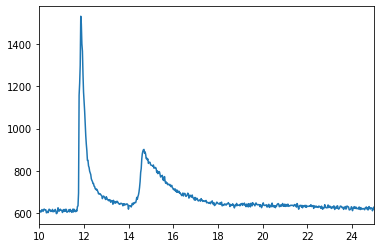

In [9]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(phi,flux)
plt.xlim(10,25)

In [10]:

phi_a = (11.8,(target.t0 - t[0])/target.Prot_d * 2 * np.pi)
theta_a = (49*np.pi/180, 59*np.pi/180)
a = (1.5, target.ampl)
fwhm = (0.5, target.dur /target.Prot_d * 2 * np.pi/5)
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 240 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = (phi[-1], phi[-1])
for _a in a:
    radius = calculate_angular_radius(Fth, _a, qlum, R)
    print(radius)
theta_a, i_mu, phi_a


20.9253963026697
11.485683712824796


((0.8552113334772214, 1.0297442586766543),
 0.3718561470554695,
 (11.8, 14.724101266474062))

(600, 1000)

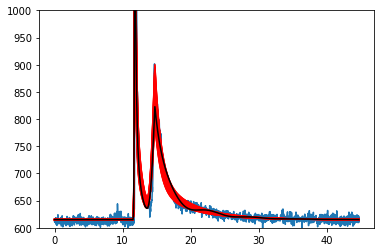

In [11]:
plt.plot(phi,flux)
for i in range(0,360,20):
    plt.plot(phi, full_model_2flares2ars(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=1,)
plt.plot(phi, full_model_2flares2ars(phi_a, theta_a, a, fwhm, i_mu, phi0=240 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(600,1000)

### Save inits

In [14]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
    f.write(firstout)
    f.write(out)

## Run MCMC

In [12]:

inits = np.array([*phi_a, *theta_a, *a, *fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 10))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
# filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
# backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim)


# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares2ars,
#                                 args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
#                                       "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
#                                 backend=backend)

In [16]:

sampler.run_mcmc(pos, 50, progress=True, store=True);

100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


In [16]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

Initial size: 68433


In [17]:
tstamp, target.ID

('13_01_2020_11_28', 237880881)

In [18]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares2ars, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))

  0%|          | 0/50000 [00:00<?, ?it/s]

INF PRIOR


  0%|          | 1/50000 [00:10<149:38:24, 10.77s/it]

INF PRIOR
INF PRIOR


  0%|          | 2/50000 [00:21<149:37:15, 10.77s/it]

INF PRIOR


  0%|          | 3/50000 [00:34<157:18:39, 11.33s/it]

INF PRIOR
INF PRIOR


  0%|          | 4/50000 [00:44<153:26:28, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 5/50000 [00:55<151:41:01, 10.92s/it]

INF PRIOR


  0%|          | 6/50000 [01:06<153:48:10, 11.08s/it]

INF PRIOR
INF PRIOR


  0%|          | 7/50000 [01:18<158:13:11, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 8/50000 [01:29<156:49:56, 11.29s/it]

INF PRIOR


  0%|          | 9/50000 [01:43<164:47:48, 11.87s/it]

INF PRIOR


  0%|          | 10/50000 [01:54<165:04:18, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 11/50000 [02:04<156:22:00, 11.26s/it]

INF PRIOR
INF PRIOR


  0%|          | 14/50000 [02:41<164:33:00, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 15/50000 [02:52<163:19:35, 11.76s/it]

INF PRIOR
INF PRIOR


  0%|          | 16/50000 [03:04<162:10:10, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 17/50000 [03:15<159:47:03, 11.51s/it]

INF PRIOR
INF PRIOR


  0%|          | 19/50000 [03:38<162:52:35, 11.73s/it]

INF PRIOR
INF PRIOR


  0%|          | 20/50000 [03:50<160:07:42, 11.53s/it]

INF PRIOR
INF PRIOR


  0%|          | 21/50000 [04:01<158:11:39, 11.39s/it]

INF PRIOR


  0%|          | 22/50000 [04:12<159:08:17, 11.46s/it]

INF PRIOR


  0%|          | 23/50000 [04:24<162:19:02, 11.69s/it]

INF PRIOR
INF PRIOR


  0%|          | 25/50000 [04:48<164:37:05, 11.86s/it]

INF PRIOR


  0%|          | 26/50000 [05:00<164:07:08, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 27/50000 [05:11<160:29:22, 11.56s/it]

INF PRIOR
INF PRIOR


  0%|          | 28/50000 [05:23<161:49:05, 11.66s/it]

INF PRIOR
INF PRIOR


  0%|          | 30/50000 [05:45<160:32:34, 11.57s/it]

INF PRIOR
INF PRIOR


  0%|          | 31/50000 [05:57<159:33:47, 11.50s/it]

INF PRIOR


  0%|          | 32/50000 [06:08<160:07:01, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 33/50000 [06:19<156:41:24, 11.29s/it]

INF PRIOR


  0%|          | 34/50000 [06:32<161:03:40, 11.60s/it]

INF PRIOR


  0%|          | 35/50000 [06:43<159:50:14, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 37/50000 [07:06<161:00:59, 11.60s/it]

INF PRIOR


  0%|          | 38/50000 [07:17<159:34:01, 11.50s/it]

INF PRIOR
INF PRIOR


  0%|          | 39/50000 [07:28<158:54:34, 11.45s/it]

INF PRIOR
INF PRIOR


  0%|          | 40/50000 [07:39<155:37:57, 11.21s/it]

INF PRIOR


  0%|          | 41/50000 [07:51<156:45:07, 11.30s/it]

INF PRIOR


  0%|          | 43/50000 [08:14<158:46:35, 11.44s/it]

INF PRIOR
INF PRIOR


  0%|          | 45/50000 [08:37<160:23:41, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 46/50000 [08:48<156:46:03, 11.30s/it]

INF PRIOR


  0%|          | 48/50000 [09:11<160:47:22, 11.59s/it]

INF PRIOR


  0%|          | 49/50000 [09:23<160:14:16, 11.55s/it]

INF PRIOR


  0%|          | 50/50000 [09:34<157:57:28, 11.38s/it]

INF PRIOR
INF PRIOR


  0%|          | 51/50000 [09:44<152:30:41, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 53/50000 [10:06<153:51:17, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 54/50000 [10:17<154:13:23, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 55/50000 [10:27<150:09:46, 10.82s/it]

INF PRIOR


  0%|          | 56/50000 [10:39<153:06:08, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 57/50000 [10:50<154:05:56, 11.11s/it]

INF PRIOR


  0%|          | 58/50000 [11:01<152:46:50, 11.01s/it]

INF PRIOR
INF PRIOR


  0%|          | 60/50000 [11:24<157:10:56, 11.33s/it]

INF PRIOR


  0%|          | 61/50000 [11:36<159:09:32, 11.47s/it]

INF PRIOR


  0%|          | 63/50000 [12:00<163:22:46, 11.78s/it]

INF PRIOR
INF PRIOR


  0%|          | 65/50000 [12:23<161:01:24, 11.61s/it]

INF PRIOR


  0%|          | 66/50000 [12:34<160:56:06, 11.60s/it]

INF PRIOR
INF PRIOR


  0%|          | 70/50000 [13:21<163:28:30, 11.79s/it]

INF PRIOR


  0%|          | 71/50000 [13:32<159:50:31, 11.52s/it]

INF PRIOR


  0%|          | 72/50000 [13:44<158:31:14, 11.43s/it]

INF PRIOR
INF PRIOR


  0%|          | 73/50000 [13:54<156:26:47, 11.28s/it]

INF PRIOR


  0%|          | 74/50000 [14:06<155:32:17, 11.22s/it]

INF PRIOR


  0%|          | 75/50000 [14:17<156:25:21, 11.28s/it]

INF PRIOR
INF PRIOR


  0%|          | 76/50000 [14:28<155:19:06, 11.20s/it]

INF PRIOR


  0%|          | 77/50000 [14:39<155:45:08, 11.23s/it]

INF PRIOR


  0%|          | 80/50000 [15:15<162:01:49, 11.68s/it]

INF PRIOR
INF PRIOR


  0%|          | 81/50000 [15:26<158:35:43, 11.44s/it]

INF PRIOR


  0%|          | 82/50000 [15:37<159:26:12, 11.50s/it]

INF PRIOR


  0%|          | 84/50000 [16:01<162:04:32, 11.69s/it]

INF PRIOR
INF PRIOR


  0%|          | 85/50000 [16:12<158:15:08, 11.41s/it]

INF PRIOR


  0%|          | 87/50000 [16:34<158:30:36, 11.43s/it]

INF PRIOR


  0%|          | 88/50000 [16:46<158:03:46, 11.40s/it]

INF PRIOR


  0%|          | 89/50000 [16:58<160:01:30, 11.54s/it]

INF PRIOR


  0%|          | 90/50000 [17:09<160:19:27, 11.56s/it]

INF PRIOR


  0%|          | 91/50000 [17:20<157:08:50, 11.34s/it]

INF PRIOR
INF PRIOR


  0%|          | 94/50000 [17:55<159:51:34, 11.53s/it]

INF PRIOR
INF PRIOR


  0%|          | 95/50000 [18:06<157:01:35, 11.33s/it]

INF PRIOR
INF PRIOR


  0%|          | 97/50000 [18:28<155:22:03, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 98/50000 [18:38<149:37:25, 10.79s/it]

INF PRIOR
INF PRIOR


  0%|          | 99/50000 [18:48<148:40:49, 10.73s/it]

INF PRIOR


  0%|          | 101/50000 [19:11<151:30:46, 10.93s/it]

INF PRIOR
INF PRIOR


  0%|          | 102/50000 [19:22<154:50:46, 11.17s/it]

INF PRIOR
INF PRIOR


  0%|          | 103/50000 [19:33<154:23:04, 11.14s/it]

INF PRIOR


  0%|          | 104/50000 [19:45<154:41:55, 11.16s/it]

INF PRIOR


  0%|          | 107/50000 [20:20<161:48:02, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 108/50000 [20:31<156:48:19, 11.31s/it]

INF PRIOR
INF PRIOR


  0%|          | 109/50000 [20:42<158:03:48, 11.41s/it]

INF PRIOR


  0%|          | 111/50000 [21:05<159:35:44, 11.52s/it]

INF PRIOR
INF PRIOR


  0%|          | 112/50000 [21:16<153:55:02, 11.11s/it]

INF PRIOR


  0%|          | 113/50000 [21:26<150:16:04, 10.84s/it]

INF PRIOR


  0%|          | 114/50000 [21:38<154:22:41, 11.14s/it]

INF PRIOR
INF PRIOR


  0%|          | 116/50000 [22:00<154:09:37, 11.13s/it]

INF PRIOR


  0%|          | 117/50000 [22:12<158:10:28, 11.42s/it]

INF PRIOR
INF PRIOR


  0%|          | 118/50000 [22:23<155:54:26, 11.25s/it]

INF PRIOR


  0%|          | 119/50000 [22:35<157:59:37, 11.40s/it]

INF PRIOR


  0%|          | 120/50000 [22:46<158:13:51, 11.42s/it]

INF PRIOR
INF PRIOR


  0%|          | 121/50000 [22:57<156:18:06, 11.28s/it]

INF PRIOR
INF PRIOR


  0%|          | 122/50000 [23:08<156:31:51, 11.30s/it]

INF PRIOR


  0%|          | 124/50000 [23:31<157:38:20, 11.38s/it]

INF PRIOR
INF PRIOR


  0%|          | 128/50000 [24:18<160:59:49, 11.62s/it]

INF PRIOR
INF PRIOR


  0%|          | 129/50000 [24:29<157:33:08, 11.37s/it]

INF PRIOR
INF PRIOR


  0%|          | 130/50000 [24:40<155:48:42, 11.25s/it]

INF PRIOR


  0%|          | 131/50000 [24:51<157:33:52, 11.37s/it]

INF PRIOR


  0%|          | 134/50000 [25:28<163:51:09, 11.83s/it]

INF PRIOR


  0%|          | 135/50000 [25:40<166:05:15, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 136/50000 [25:50<158:11:19, 11.42s/it]

INF PRIOR


  0%|          | 137/50000 [26:01<155:50:59, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 138/50000 [26:12<154:56:07, 11.19s/it]

INF PRIOR


  0%|          | 139/50000 [26:23<151:20:28, 10.93s/it]

INF PRIOR


  0%|          | 140/50000 [26:35<159:21:01, 11.51s/it]

INF PRIOR
INF PRIOR


  0%|          | 141/50000 [26:46<156:07:17, 11.27s/it]

INF PRIOR


  0%|          | 142/50000 [26:57<156:04:35, 11.27s/it]

INF PRIOR
INF PRIOR


  0%|          | 143/50000 [27:08<155:02:06, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 145/50000 [27:31<156:54:15, 11.33s/it]

INF PRIOR


  0%|          | 146/50000 [27:42<153:23:48, 11.08s/it]

INF PRIOR
INF PRIOR


  0%|          | 147/50000 [27:53<153:41:49, 11.10s/it]

INF PRIOR


  0%|          | 148/50000 [28:04<155:38:14, 11.24s/it]

INF PRIOR
INF PRIOR


  0%|          | 149/50000 [28:15<155:15:40, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 151/50000 [28:38<155:48:04, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 152/50000 [28:48<153:04:36, 11.06s/it]

INF PRIOR
INF PRIOR


  0%|          | 154/50000 [29:11<156:07:10, 11.28s/it]

INF PRIOR
INF PRIOR


  0%|          | 155/50000 [29:22<152:55:06, 11.04s/it]

INF PRIOR


  0%|          | 156/50000 [29:33<154:31:24, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 158/50000 [29:55<152:41:51, 11.03s/it]

INF PRIOR


  0%|          | 160/50000 [30:18<155:21:24, 11.22s/it]

INF PRIOR


  0%|          | 161/50000 [30:29<154:03:00, 11.13s/it]

INF PRIOR
INF PRIOR


  0%|          | 162/50000 [30:40<154:13:36, 11.14s/it]

INF PRIOR
INF PRIOR


  0%|          | 163/50000 [30:51<153:10:10, 11.06s/it]

INF PRIOR


  0%|          | 164/50000 [31:02<152:57:22, 11.05s/it]

INF PRIOR
INF PRIOR


  0%|          | 165/50000 [31:13<154:24:39, 11.15s/it]

INF PRIOR


  0%|          | 167/50000 [31:35<154:09:41, 11.14s/it]

INF PRIOR
INF PRIOR


  0%|          | 168/50000 [31:46<152:47:56, 11.04s/it]

INF PRIOR


  0%|          | 169/50000 [31:57<153:35:19, 11.10s/it]

INF PRIOR


  0%|          | 170/50000 [32:08<153:07:59, 11.06s/it]

INF PRIOR
INF PRIOR


  0%|          | 172/50000 [32:31<154:13:18, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 175/50000 [33:07<164:33:07, 11.89s/it]

INF PRIOR


  0%|          | 176/50000 [33:18<161:45:26, 11.69s/it]

INF PRIOR


  0%|          | 178/50000 [33:41<160:54:11, 11.63s/it]

INF PRIOR
INF PRIOR


  0%|          | 179/50000 [33:52<156:46:51, 11.33s/it]

INF PRIOR


  0%|          | 181/50000 [34:16<163:25:04, 11.81s/it]

INF PRIOR


  0%|          | 182/50000 [34:28<162:02:20, 11.71s/it]

INF PRIOR


  0%|          | 183/50000 [34:39<158:33:36, 11.46s/it]

INF PRIOR
INF PRIOR


  0%|          | 184/50000 [34:49<155:19:24, 11.22s/it]

INF PRIOR


  0%|          | 185/50000 [35:00<154:19:27, 11.15s/it]

INF PRIOR
INF PRIOR


  0%|          | 186/50000 [35:12<154:46:44, 11.19s/it]

INF PRIOR


  0%|          | 187/50000 [35:22<151:14:52, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 188/50000 [35:34<153:48:06, 11.12s/it]

INF PRIOR


  0%|          | 190/50000 [35:58<160:51:49, 11.63s/it]

INF PRIOR
INF PRIOR


  0%|          | 192/50000 [36:21<163:01:01, 11.78s/it]

INF PRIOR
INF PRIOR


  0%|          | 194/50000 [36:43<158:34:28, 11.46s/it]

INF PRIOR


  0%|          | 197/50000 [37:19<163:08:43, 11.79s/it]

INF PRIOR
INF PRIOR


  0%|          | 198/50000 [37:30<159:31:07, 11.53s/it]

INF PRIOR
INF PRIOR


  0%|          | 199/50000 [37:40<153:57:13, 11.13s/it]

INF PRIOR


  0%|          | 200/50000 [37:52<155:27:44, 11.24s/it]

INF PRIOR


  0%|          | 202/50000 [38:16<160:12:19, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 203/50000 [38:26<156:38:11, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 204/50000 [38:37<152:26:35, 11.02s/it]

INF PRIOR
INF PRIOR


  0%|          | 205/50000 [38:48<152:32:09, 11.03s/it]

INF PRIOR
INF PRIOR


  0%|          | 207/50000 [39:11<157:44:25, 11.40s/it]

INF PRIOR


  0%|          | 208/50000 [39:23<159:07:02, 11.50s/it]

INF PRIOR


  0%|          | 209/50000 [39:34<158:00:48, 11.42s/it]

INF PRIOR


  0%|          | 210/50000 [39:47<161:25:47, 11.67s/it]

INF PRIOR
INF PRIOR


  0%|          | 211/50000 [39:58<160:04:04, 11.57s/it]

INF PRIOR
INF PRIOR


  0%|          | 212/50000 [40:08<155:52:33, 11.27s/it]

INF PRIOR
INF PRIOR


  0%|          | 213/50000 [40:19<154:15:28, 11.15s/it]

INF PRIOR


  0%|          | 214/50000 [40:31<157:09:18, 11.36s/it]

INF PRIOR


  0%|          | 217/50000 [41:08<164:41:10, 11.91s/it]

INF PRIOR
INF PRIOR


  0%|          | 219/50000 [41:34<170:05:15, 12.30s/it]

INF PRIOR
INF PRIOR


  0%|          | 220/50000 [41:46<169:15:44, 12.24s/it]

INF PRIOR
INF PRIOR


  0%|          | 221/50000 [41:57<162:51:14, 11.78s/it]

INF PRIOR


  0%|          | 223/50000 [42:22<167:58:11, 12.15s/it]

INF PRIOR
INF PRIOR


  0%|          | 224/50000 [42:33<164:31:48, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 226/50000 [42:56<164:07:03, 11.87s/it]

INF PRIOR
INF PRIOR


  0%|          | 227/50000 [43:08<161:40:33, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 228/50000 [43:18<154:07:13, 11.15s/it]

INF PRIOR
INF PRIOR


  0%|          | 229/50000 [43:28<150:10:18, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 230/50000 [43:38<147:52:44, 10.70s/it]

INF PRIOR
INF PRIOR


  0%|          | 232/50000 [44:00<151:46:46, 10.98s/it]

INF PRIOR
INF PRIOR


  0%|          | 235/50000 [44:38<167:30:53, 12.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  0%|          | 236/50000 [44:49<161:51:06, 11.71s/it]

INF PRIOR


  0%|          | 237/50000 [45:00<160:18:22, 11.60s/it]

INF PRIOR
INF PRIOR


  0%|          | 239/50000 [45:26<169:42:42, 12.28s/it]

INF PRIOR
INF PRIOR


  0%|          | 240/50000 [45:37<167:00:29, 12.08s/it]

INF PRIOR
INF PRIOR


  0%|          | 241/50000 [45:49<165:04:48, 11.94s/it]

INF PRIOR


  0%|          | 243/50000 [46:14<168:14:33, 12.17s/it]

INF PRIOR


  0%|          | 244/50000 [46:25<165:31:00, 11.98s/it]

INF PRIOR


  0%|          | 246/50000 [46:49<164:29:27, 11.90s/it]

INF PRIOR
INF PRIOR


  0%|          | 247/50000 [47:00<162:59:46, 11.79s/it]

INF PRIOR


  0%|          | 248/50000 [47:11<159:40:59, 11.55s/it]

INF PRIOR
INF PRIOR


  0%|          | 250/50000 [47:34<157:04:35, 11.37s/it]

INF PRIOR


  1%|          | 251/50000 [47:45<155:58:44, 11.29s/it]

INF PRIOR


  1%|          | 253/50000 [48:08<159:05:41, 11.51s/it]

INF PRIOR


  1%|          | 254/50000 [48:21<162:16:05, 11.74s/it]

INF PRIOR


  1%|          | 255/50000 [48:32<160:25:31, 11.61s/it]

INF PRIOR


  1%|          | 256/50000 [48:43<159:31:41, 11.55s/it]

INF PRIOR


  1%|          | 257/50000 [48:55<159:16:57, 11.53s/it]

INF PRIOR


  1%|          | 260/50000 [49:31<164:26:42, 11.90s/it]

INF PRIOR
INF PRIOR


  1%|          | 261/50000 [49:41<158:42:44, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 262/50000 [49:51<152:05:14, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 263/50000 [50:02<151:02:45, 10.93s/it]

INF PRIOR
INF PRIOR


  1%|          | 264/50000 [50:14<154:52:34, 11.21s/it]

INF PRIOR


  1%|          | 265/50000 [50:26<158:20:19, 11.46s/it]

INF PRIOR
INF PRIOR


  1%|          | 268/50000 [51:01<163:05:36, 11.81s/it]

INF PRIOR


  1%|          | 269/50000 [51:14<168:31:52, 12.20s/it]

INF PRIOR


  1%|          | 270/50000 [51:26<166:44:17, 12.07s/it]

INF PRIOR


  1%|          | 271/50000 [51:37<162:47:24, 11.78s/it]

INF PRIOR
INF PRIOR


  1%|          | 272/50000 [51:48<159:27:17, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 273/50000 [51:58<152:50:40, 11.07s/it]

INF PRIOR
INF PRIOR


  1%|          | 274/50000 [52:10<155:23:12, 11.25s/it]

INF PRIOR


  1%|          | 276/50000 [52:34<162:53:44, 11.79s/it]

INF PRIOR


  1%|          | 277/50000 [52:46<161:21:12, 11.68s/it]

INF PRIOR


  1%|          | 278/50000 [52:57<157:46:18, 11.42s/it]

INF PRIOR
INF PRIOR


  1%|          | 279/50000 [53:09<160:25:30, 11.62s/it]

INF PRIOR


  1%|          | 281/50000 [53:33<162:23:11, 11.76s/it]

INF PRIOR
INF PRIOR


  1%|          | 282/50000 [53:44<160:36:09, 11.63s/it]

INF PRIOR
INF PRIOR


  1%|          | 283/50000 [53:57<166:07:07, 12.03s/it]

INF PRIOR


  1%|          | 284/50000 [54:09<166:55:16, 12.09s/it]

INF PRIOR
INF PRIOR


  1%|          | 285/50000 [54:21<165:58:09, 12.02s/it]

INF PRIOR


  1%|          | 286/50000 [54:33<164:05:28, 11.88s/it]

INF PRIOR
INF PRIOR


  1%|          | 287/50000 [54:44<163:09:41, 11.82s/it]

INF PRIOR


  1%|          | 288/50000 [54:56<164:31:41, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 289/50000 [55:06<156:38:53, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 291/50000 [55:30<161:48:15, 11.72s/it]

INF PRIOR
INF PRIOR


  1%|          | 292/50000 [55:44<168:06:54, 12.18s/it]

INF PRIOR


  1%|          | 294/50000 [56:08<168:19:30, 12.19s/it]

INF PRIOR


  1%|          | 295/50000 [56:20<165:52:24, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 296/50000 [56:31<161:35:43, 11.70s/it]

INF PRIOR


  1%|          | 297/50000 [56:44<167:26:39, 12.13s/it]

INF PRIOR


  1%|          | 300/50000 [57:20<166:23:01, 12.05s/it]

INF PRIOR


  1%|          | 301/50000 [57:32<166:26:21, 12.06s/it]

INF PRIOR


  1%|          | 302/50000 [57:44<165:23:38, 11.98s/it]

INF PRIOR


  1%|          | 304/50000 [58:08<166:20:46, 12.05s/it]

INF PRIOR
INF PRIOR


  1%|          | 305/50000 [58:19<164:36:51, 11.92s/it]

INF PRIOR


  1%|          | 306/50000 [58:30<159:51:22, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 307/50000 [58:41<157:57:53, 11.44s/it]

INF PRIOR
INF PRIOR


  1%|          | 308/50000 [58:52<155:11:10, 11.24s/it]

INF PRIOR


  1%|          | 310/50000 [59:16<160:31:21, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 311/50000 [59:27<156:09:27, 11.31s/it]

INF PRIOR


  1%|          | 312/50000 [59:38<156:03:47, 11.31s/it]

INF PRIOR


  1%|          | 313/50000 [59:50<160:46:23, 11.65s/it]

INF PRIOR


  1%|          | 315/50000 [1:00:13<158:00:36, 11.45s/it]

INF PRIOR


  1%|          | 316/50000 [1:00:24<158:06:25, 11.46s/it]

INF PRIOR


  1%|          | 317/50000 [1:00:37<161:18:06, 11.69s/it]

INF PRIOR


  1%|          | 318/50000 [1:00:47<157:21:27, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 319/50000 [1:00:58<155:40:32, 11.28s/it]

INF PRIOR
INF PRIOR


  1%|          | 320/50000 [1:01:09<154:24:41, 11.19s/it]

INF PRIOR


  1%|          | 321/50000 [1:01:20<154:21:16, 11.19s/it]

INF PRIOR
INF PRIOR


  1%|          | 322/50000 [1:01:31<152:48:05, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 323/50000 [1:01:41<147:46:32, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 324/50000 [1:01:52<149:13:38, 10.81s/it]

INF PRIOR


  1%|          | 325/50000 [1:02:04<151:57:48, 11.01s/it]

INF PRIOR


  1%|          | 326/50000 [1:02:15<153:42:16, 11.14s/it]

INF PRIOR


  1%|          | 327/50000 [1:02:26<154:05:48, 11.17s/it]

INF PRIOR


  1%|          | 328/50000 [1:02:38<157:30:00, 11.41s/it]

INF PRIOR


  1%|          | 329/50000 [1:02:49<154:17:45, 11.18s/it]

INF PRIOR


  1%|          | 330/50000 [1:03:01<159:11:13, 11.54s/it]

INF PRIOR


  1%|          | 331/50000 [1:03:13<159:24:51, 11.55s/it]

INF PRIOR
INF PRIOR


  1%|          | 332/50000 [1:03:24<157:48:52, 11.44s/it]

INF PRIOR


  1%|          | 333/50000 [1:03:35<156:48:30, 11.37s/it]

INF PRIOR


  1%|          | 336/50000 [1:04:11<161:48:54, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 337/50000 [1:04:22<157:48:53, 11.44s/it]

INF PRIOR
INF PRIOR


  1%|          | 338/50000 [1:04:34<160:56:38, 11.67s/it]

INF PRIOR


  1%|          | 339/50000 [1:04:46<161:59:04, 11.74s/it]

INF PRIOR


  1%|          | 340/50000 [1:04:57<160:55:32, 11.67s/it]

INF PRIOR
INF PRIOR


  1%|          | 341/50000 [1:05:08<155:42:09, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 342/50000 [1:05:19<153:30:51, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 343/50000 [1:05:30<153:44:33, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 344/50000 [1:05:40<150:51:50, 10.94s/it]

INF PRIOR


  1%|          | 345/50000 [1:05:51<151:56:09, 11.02s/it]

INF PRIOR


  1%|          | 346/50000 [1:06:03<153:42:11, 11.14s/it]

INF PRIOR


  1%|          | 348/50000 [1:06:25<154:55:08, 11.23s/it]

INF PRIOR
INF PRIOR


  1%|          | 349/50000 [1:06:36<152:34:08, 11.06s/it]

INF PRIOR
INF PRIOR


  1%|          | 350/50000 [1:06:47<154:44:17, 11.22s/it]

INF PRIOR


  1%|          | 351/50000 [1:06:59<154:51:34, 11.23s/it]

INF PRIOR
INF PRIOR


  1%|          | 353/50000 [1:07:22<157:46:43, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 354/50000 [1:07:32<151:50:56, 11.01s/it]

INF PRIOR
INF PRIOR


  1%|          | 355/50000 [1:07:44<154:34:19, 11.21s/it]

INF PRIOR


  1%|          | 357/50000 [1:08:06<154:11:11, 11.18s/it]

INF PRIOR
INF PRIOR


  1%|          | 358/50000 [1:08:17<151:51:04, 11.01s/it]

INF PRIOR
INF PRIOR


  1%|          | 361/50000 [1:08:54<164:09:09, 11.90s/it]

INF PRIOR
INF PRIOR


  1%|          | 362/50000 [1:09:04<159:30:02, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 364/50000 [1:09:28<162:59:14, 11.82s/it]

INF PRIOR
INF PRIOR


  1%|          | 365/50000 [1:09:39<156:49:45, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 366/50000 [1:09:50<155:50:18, 11.30s/it]

INF PRIOR
INF PRIOR


  1%|          | 367/50000 [1:10:01<155:43:21, 11.29s/it]

INF PRIOR
INF PRIOR


  1%|          | 369/50000 [1:10:25<159:21:11, 11.56s/it]

INF PRIOR


  1%|          | 370/50000 [1:10:37<161:43:23, 11.73s/it]

INF PRIOR
INF PRIOR


  1%|          | 371/50000 [1:10:48<157:53:02, 11.45s/it]

INF PRIOR


  1%|          | 372/50000 [1:10:58<154:44:03, 11.22s/it]

INF PRIOR


  1%|          | 373/50000 [1:11:10<156:35:27, 11.36s/it]

INF PRIOR
INF PRIOR


  1%|          | 374/50000 [1:11:20<152:54:47, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 375/50000 [1:11:31<152:02:54, 11.03s/it]

INF PRIOR
INF PRIOR


  1%|          | 376/50000 [1:11:42<151:59:39, 11.03s/it]

INF PRIOR


  1%|          | 378/50000 [1:12:06<157:42:01, 11.44s/it]

INF PRIOR


  1%|          | 379/50000 [1:12:18<159:07:46, 11.54s/it]

INF PRIOR


  1%|          | 381/50000 [1:12:41<161:25:47, 11.71s/it]

INF PRIOR


  1%|          | 382/50000 [1:12:53<159:15:16, 11.55s/it]

INF PRIOR


  1%|          | 383/50000 [1:13:04<158:41:56, 11.51s/it]

INF PRIOR
INF PRIOR


  1%|          | 384/50000 [1:13:15<155:27:22, 11.28s/it]

INF PRIOR
INF PRIOR


  1%|          | 385/50000 [1:13:25<149:50:39, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 386/50000 [1:13:35<148:46:01, 10.79s/it]

INF PRIOR


  1%|          | 387/50000 [1:13:46<149:40:30, 10.86s/it]

INF PRIOR
INF PRIOR


  1%|          | 388/50000 [1:13:58<152:27:33, 11.06s/it]

INF PRIOR


  1%|          | 389/50000 [1:14:09<152:36:00, 11.07s/it]

INF PRIOR


  1%|          | 390/50000 [1:14:21<156:23:41, 11.35s/it]

INF PRIOR


  1%|          | 391/50000 [1:14:32<155:51:40, 11.31s/it]

INF PRIOR


  1%|          | 392/50000 [1:14:43<153:45:27, 11.16s/it]

INF PRIOR


  1%|          | 393/50000 [1:14:55<156:06:55, 11.33s/it]

INF PRIOR


  1%|          | 394/50000 [1:15:06<155:44:13, 11.30s/it]

INF PRIOR


  1%|          | 395/50000 [1:15:18<157:22:41, 11.42s/it]

INF PRIOR
INF PRIOR


  1%|          | 396/50000 [1:15:29<157:50:38, 11.46s/it]

INF PRIOR


  1%|          | 397/50000 [1:15:41<158:53:24, 11.53s/it]

INF PRIOR
INF PRIOR


  1%|          | 399/50000 [1:16:03<157:30:06, 11.43s/it]

INF PRIOR


  1%|          | 400/50000 [1:16:14<154:10:25, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 401/50000 [1:16:24<148:03:22, 10.75s/it]

INF PRIOR
INF PRIOR


  1%|          | 402/50000 [1:16:35<149:13:06, 10.83s/it]

INF PRIOR
INF PRIOR


  1%|          | 403/50000 [1:16:45<148:24:51, 10.77s/it]

INF PRIOR
INF PRIOR


  1%|          | 404/50000 [1:16:56<148:27:08, 10.78s/it]

INF PRIOR
INF PRIOR


  1%|          | 405/50000 [1:17:06<145:00:59, 10.53s/it]

INF PRIOR


  1%|          | 406/50000 [1:17:17<144:33:10, 10.49s/it]

INF PRIOR
INF PRIOR


  1%|          | 407/50000 [1:17:28<147:39:40, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 408/50000 [1:17:39<148:34:11, 10.79s/it]

INF PRIOR


  1%|          | 409/50000 [1:17:49<148:37:15, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 410/50000 [1:18:01<150:17:09, 10.91s/it]

INF PRIOR


  1%|          | 411/50000 [1:18:12<152:40:40, 11.08s/it]

INF PRIOR


  1%|          | 412/50000 [1:18:24<155:29:02, 11.29s/it]

INF PRIOR
INF PRIOR


  1%|          | 413/50000 [1:18:34<151:57:33, 11.03s/it]

INF PRIOR
INF PRIOR


  1%|          | 414/50000 [1:18:46<154:51:15, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 416/50000 [1:19:07<151:25:49, 10.99s/it]

INF PRIOR
INF PRIOR


  1%|          | 417/50000 [1:19:17<147:34:38, 10.71s/it]

INF PRIOR


  1%|          | 418/50000 [1:19:29<150:38:23, 10.94s/it]

INF PRIOR
INF PRIOR


  1%|          | 419/50000 [1:19:40<150:14:21, 10.91s/it]

INF PRIOR
INF PRIOR


  1%|          | 421/50000 [1:20:03<157:18:13, 11.42s/it]

INF PRIOR
INF PRIOR


  1%|          | 422/50000 [1:20:14<153:45:51, 11.17s/it]

INF PRIOR
INF PRIOR


  1%|          | 423/50000 [1:20:25<153:11:45, 11.12s/it]

INF PRIOR


  1%|          | 425/50000 [1:20:49<158:42:19, 11.52s/it]

INF PRIOR
INF PRIOR


  1%|          | 427/50000 [1:21:11<155:50:41, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 431/50000 [1:21:57<159:07:05, 11.56s/it]

INF PRIOR


  1%|          | 432/50000 [1:22:09<162:10:37, 11.78s/it]

INF PRIOR
INF PRIOR


  1%|          | 435/50000 [1:22:43<160:46:08, 11.68s/it]

INF PRIOR


  1%|          | 436/50000 [1:22:55<159:30:41, 11.59s/it]

INF PRIOR


  1%|          | 437/50000 [1:23:06<156:57:14, 11.40s/it]

INF PRIOR


  1%|          | 438/50000 [1:23:18<161:48:33, 11.75s/it]

INF PRIOR


  1%|          | 439/50000 [1:23:29<158:31:31, 11.51s/it]

INF PRIOR
INF PRIOR


  1%|          | 440/50000 [1:23:40<154:58:48, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 442/50000 [1:24:03<159:02:25, 11.55s/it]

INF PRIOR
INF PRIOR


  1%|          | 443/50000 [1:24:15<158:47:08, 11.53s/it]

INF PRIOR


  1%|          | 444/50000 [1:24:26<159:30:24, 11.59s/it]

INF PRIOR
INF PRIOR


  1%|          | 445/50000 [1:24:37<156:02:18, 11.34s/it]

INF PRIOR


  1%|          | 446/50000 [1:24:49<157:48:59, 11.47s/it]

INF PRIOR


  1%|          | 447/50000 [1:25:00<156:33:17, 11.37s/it]

INF PRIOR
INF PRIOR


  1%|          | 448/50000 [1:25:11<155:05:51, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 449/50000 [1:25:21<149:09:38, 10.84s/it]

INF PRIOR
INF PRIOR


  1%|          | 453/50000 [1:26:05<151:57:14, 11.04s/it]

INF PRIOR


  1%|          | 454/50000 [1:26:16<152:27:39, 11.08s/it]

INF PRIOR


  1%|          | 456/50000 [1:26:38<152:27:15, 11.08s/it]

INF PRIOR
INF PRIOR


  1%|          | 458/50000 [1:27:01<153:43:17, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 460/50000 [1:27:22<152:09:49, 11.06s/it]

INF PRIOR
INF PRIOR


  1%|          | 461/50000 [1:27:34<153:06:39, 11.13s/it]

INF PRIOR
INF PRIOR


  1%|          | 462/50000 [1:27:44<150:41:43, 10.95s/it]

INF PRIOR


  1%|          | 463/50000 [1:27:55<148:08:14, 10.77s/it]

INF PRIOR
INF PRIOR


  1%|          | 464/50000 [1:28:05<147:15:53, 10.70s/it]

INF PRIOR


  1%|          | 466/50000 [1:28:27<149:17:10, 10.85s/it]

INF PRIOR


  1%|          | 467/50000 [1:28:39<151:26:33, 11.01s/it]

INF PRIOR


  1%|          | 469/50000 [1:29:02<154:38:10, 11.24s/it]

INF PRIOR
INF PRIOR


  1%|          | 470/50000 [1:29:12<153:23:56, 11.15s/it]

INF PRIOR


  1%|          | 473/50000 [1:29:47<155:10:59, 11.28s/it]

INF PRIOR


  1%|          | 474/50000 [1:29:58<155:12:54, 11.28s/it]

INF PRIOR
INF PRIOR


  1%|          | 476/50000 [1:30:20<153:06:20, 11.13s/it]

INF PRIOR
INF PRIOR


  1%|          | 477/50000 [1:30:31<154:12:37, 11.21s/it]

INF PRIOR


  1%|          | 478/50000 [1:30:41<149:55:52, 10.90s/it]

INF PRIOR
INF PRIOR


  1%|          | 479/50000 [1:30:52<149:23:26, 10.86s/it]

INF PRIOR
INF PRIOR


  1%|          | 480/50000 [1:31:04<153:13:29, 11.14s/it]

INF PRIOR


  1%|          | 481/50000 [1:31:15<152:48:27, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 482/50000 [1:31:25<145:57:58, 10.61s/it]

INF PRIOR
INF PRIOR


  1%|          | 484/50000 [1:31:46<148:59:51, 10.83s/it]

INF PRIOR


  1%|          | 485/50000 [1:31:58<151:13:17, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 486/50000 [1:32:09<151:03:26, 10.98s/it]

INF PRIOR
INF PRIOR


  1%|          | 487/50000 [1:32:19<149:30:03, 10.87s/it]

INF PRIOR
INF PRIOR


  1%|          | 488/50000 [1:32:31<151:39:01, 11.03s/it]

INF PRIOR


  1%|          | 489/50000 [1:32:42<152:50:31, 11.11s/it]

INF PRIOR


  1%|          | 490/50000 [1:32:54<154:12:51, 11.21s/it]

INF PRIOR


  1%|          | 491/50000 [1:33:04<153:05:47, 11.13s/it]

INF PRIOR
INF PRIOR


  1%|          | 492/50000 [1:33:16<152:44:13, 11.11s/it]

INF PRIOR
INF PRIOR


  1%|          | 494/50000 [1:33:38<155:35:08, 11.31s/it]

INF PRIOR


  1%|          | 496/50000 [1:34:01<156:47:45, 11.40s/it]

INF PRIOR


  1%|          | 500/50000 [1:34:50<164:50:28, 11.99s/it]

INF PRIOR


  1%|          | 503/50000 [1:35:28<170:29:12, 12.40s/it]

INF PRIOR


  1%|          | 505/50000 [1:35:51<166:45:07, 12.13s/it]

INF PRIOR
INF PRIOR


  1%|          | 506/50000 [1:36:02<162:13:15, 11.80s/it]

INF PRIOR


  1%|          | 507/50000 [1:36:14<161:46:29, 11.77s/it]

INF PRIOR


  1%|          | 508/50000 [1:36:27<164:07:09, 11.94s/it]

INF PRIOR


  1%|          | 509/50000 [1:36:38<162:38:55, 11.83s/it]

INF PRIOR


  1%|          | 510/50000 [1:36:50<161:04:07, 11.72s/it]

INF PRIOR


  1%|          | 511/50000 [1:37:02<163:28:28, 11.89s/it]

INF PRIOR


  1%|          | 512/50000 [1:37:15<168:23:13, 12.25s/it]

INF PRIOR


  1%|          | 513/50000 [1:37:27<167:29:57, 12.18s/it]

INF PRIOR


  1%|          | 514/50000 [1:37:38<163:05:13, 11.86s/it]

INF PRIOR


  1%|          | 516/50000 [1:38:02<163:43:10, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 517/50000 [1:38:13<157:23:52, 11.45s/it]

INF PRIOR


  1%|          | 518/50000 [1:38:24<156:47:33, 11.41s/it]

INF PRIOR


  1%|          | 519/50000 [1:38:36<158:52:18, 11.56s/it]

INF PRIOR


  1%|          | 520/50000 [1:38:47<158:30:14, 11.53s/it]

INF PRIOR


  1%|          | 521/50000 [1:38:59<159:34:25, 11.61s/it]

INF PRIOR


  1%|          | 522/50000 [1:39:11<160:17:14, 11.66s/it]

INF PRIOR


  1%|          | 523/50000 [1:39:22<158:59:24, 11.57s/it]

INF PRIOR


  1%|          | 524/50000 [1:39:33<157:22:35, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 525/50000 [1:39:44<155:38:21, 11.32s/it]

INF PRIOR
INF PRIOR


  1%|          | 526/50000 [1:39:55<153:15:24, 11.15s/it]

INF PRIOR


  1%|          | 527/50000 [1:40:06<153:35:24, 11.18s/it]

INF PRIOR
INF PRIOR


  1%|          | 528/50000 [1:40:17<152:56:36, 11.13s/it]

INF PRIOR
INF PRIOR


  1%|          | 529/50000 [1:40:28<152:00:43, 11.06s/it]

INF PRIOR


  1%|          | 531/50000 [1:40:52<157:07:58, 11.44s/it]

INF PRIOR


  1%|          | 533/50000 [1:41:16<161:30:08, 11.75s/it]

INF PRIOR


  1%|          | 534/50000 [1:41:28<165:24:51, 12.04s/it]

INF PRIOR
INF PRIOR


  1%|          | 535/50000 [1:41:40<163:24:47, 11.89s/it]

INF PRIOR


  1%|          | 536/50000 [1:41:52<162:49:13, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 537/50000 [1:42:02<154:40:26, 11.26s/it]

INF PRIOR


  1%|          | 538/50000 [1:42:12<149:50:21, 10.91s/it]

INF PRIOR
INF PRIOR


  1%|          | 539/50000 [1:42:23<152:44:52, 11.12s/it]

INF PRIOR


  1%|          | 540/50000 [1:42:33<148:38:04, 10.82s/it]

INF PRIOR
INF PRIOR


  1%|          | 541/50000 [1:42:45<150:36:55, 10.96s/it]

INF PRIOR


  1%|          | 542/50000 [1:42:56<152:13:07, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 543/50000 [1:43:06<148:54:37, 10.84s/it]

INF PRIOR
INF PRIOR


  1%|          | 544/50000 [1:43:17<146:57:00, 10.70s/it]

INF PRIOR
INF PRIOR


  1%|          | 546/50000 [1:43:41<155:34:04, 11.32s/it]

INF PRIOR
INF PRIOR


  1%|          | 548/50000 [1:44:04<157:31:37, 11.47s/it]

INF PRIOR


  1%|          | 549/50000 [1:44:15<157:03:27, 11.43s/it]

INF PRIOR
INF PRIOR


  1%|          | 550/50000 [1:44:27<157:52:18, 11.49s/it]

INF PRIOR


  1%|          | 551/50000 [1:44:38<158:37:06, 11.55s/it]

INF PRIOR


  1%|          | 552/50000 [1:44:49<157:17:00, 11.45s/it]

INF PRIOR


  1%|          | 553/50000 [1:45:00<154:21:18, 11.24s/it]

INF PRIOR


  1%|          | 555/50000 [1:45:24<159:01:35, 11.58s/it]

INF PRIOR


  1%|          | 559/50000 [1:46:10<158:00:00, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 560/50000 [1:46:21<155:52:25, 11.35s/it]

INF PRIOR


  1%|          | 561/50000 [1:46:32<152:10:27, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 562/50000 [1:46:43<151:37:39, 11.04s/it]

INF PRIOR


  1%|          | 563/50000 [1:46:54<151:51:42, 11.06s/it]

INF PRIOR


  1%|          | 564/50000 [1:47:05<153:27:12, 11.17s/it]

INF PRIOR


  1%|          | 565/50000 [1:47:17<155:29:56, 11.32s/it]

INF PRIOR
INF PRIOR


  1%|          | 566/50000 [1:47:27<152:08:50, 11.08s/it]

INF PRIOR
INF PRIOR


  1%|          | 568/50000 [1:47:49<151:40:07, 11.05s/it]

INF PRIOR


  1%|          | 570/50000 [1:48:13<158:13:12, 11.52s/it]

INF PRIOR


  1%|          | 572/50000 [1:48:35<154:36:44, 11.26s/it]

INF PRIOR


  1%|          | 573/50000 [1:48:46<152:29:19, 11.11s/it]

INF PRIOR


  1%|          | 574/50000 [1:48:57<151:32:22, 11.04s/it]

INF PRIOR


  1%|          | 578/50000 [1:49:44<158:57:23, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 579/50000 [1:49:53<150:57:41, 11.00s/it]

INF PRIOR


  1%|          | 580/50000 [1:50:05<152:50:10, 11.13s/it]

INF PRIOR


  1%|          | 581/50000 [1:50:16<153:26:26, 11.18s/it]

INF PRIOR


  1%|          | 582/50000 [1:50:28<154:37:32, 11.26s/it]

INF PRIOR


  1%|          | 583/50000 [1:50:39<154:19:03, 11.24s/it]

INF PRIOR


  1%|          | 584/50000 [1:50:50<154:17:34, 11.24s/it]

INF PRIOR
INF PRIOR


  1%|          | 585/50000 [1:51:00<150:52:00, 10.99s/it]

INF PRIOR
INF PRIOR


  1%|          | 587/50000 [1:51:23<152:47:44, 11.13s/it]

INF PRIOR


  1%|          | 591/50000 [1:52:09<157:39:06, 11.49s/it]

INF PRIOR
INF PRIOR


  1%|          | 592/50000 [1:52:20<155:21:30, 11.32s/it]

INF PRIOR


  1%|          | 595/50000 [1:52:56<161:49:35, 11.79s/it]

INF PRIOR


  1%|          | 597/50000 [1:53:19<161:28:40, 11.77s/it]

INF PRIOR


  1%|          | 598/50000 [1:53:31<161:13:11, 11.75s/it]

INF PRIOR


  1%|          | 600/50000 [1:53:54<159:57:07, 11.66s/it]

INF PRIOR


  1%|          | 606/50000 [1:55:04<161:33:12, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 609/50000 [1:55:36<154:52:33, 11.29s/it]

INF PRIOR
INF PRIOR


  1%|          | 610/50000 [1:55:48<155:21:15, 11.32s/it]

INF PRIOR


  1%|          | 612/50000 [1:56:09<151:40:57, 11.06s/it]

INF PRIOR


  1%|          | 613/50000 [1:56:21<153:46:32, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 614/50000 [1:56:31<150:15:16, 10.95s/it]

INF PRIOR
INF PRIOR


  1%|          | 616/50000 [1:56:52<147:27:05, 10.75s/it]

INF PRIOR
INF PRIOR


  1%|          | 619/50000 [1:57:29<163:15:42, 11.90s/it]

INF PRIOR
INF PRIOR


  1%|          | 620/50000 [1:57:40<159:42:02, 11.64s/it]

INF PRIOR


  1%|          | 621/50000 [1:57:51<156:15:03, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 625/50000 [1:58:38<159:32:19, 11.63s/it]

INF PRIOR


  1%|▏         | 626/50000 [1:58:49<159:33:06, 11.63s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 630/50000 [1:59:35<157:23:19, 11.48s/it]

INF PRIOR


  1%|▏         | 631/50000 [1:59:47<158:57:53, 11.59s/it]

INF PRIOR


  1%|▏         | 632/50000 [1:59:57<155:05:56, 11.31s/it]

INF PRIOR


  1%|▏         | 633/50000 [2:00:09<155:09:46, 11.31s/it]

INF PRIOR


  1%|▏         | 636/50000 [2:00:44<157:31:20, 11.49s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 637/50000 [2:00:55<156:30:29, 11.41s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 638/50000 [2:01:05<152:19:06, 11.11s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 640/50000 [2:01:28<154:45:58, 11.29s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 641/50000 [2:01:40<155:06:19, 11.31s/it]

INF PRIOR


  1%|▏         | 643/50000 [2:02:03<158:39:17, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 645/50000 [2:02:25<153:59:24, 11.23s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 646/50000 [2:02:36<154:20:28, 11.26s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 647/50000 [2:02:47<151:40:35, 11.06s/it]

INF PRIOR


  1%|▏         | 648/50000 [2:02:57<150:21:07, 10.97s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 650/50000 [2:03:20<153:42:29, 11.21s/it]

INF PRIOR


  1%|▏         | 652/50000 [2:03:44<157:32:03, 11.49s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 653/50000 [2:03:54<151:41:54, 11.07s/it]

INF PRIOR


  1%|▏         | 655/50000 [2:04:16<152:26:26, 11.12s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 656/50000 [2:04:27<149:08:14, 10.88s/it]

INF PRIOR


  1%|▏         | 657/50000 [2:04:37<147:36:23, 10.77s/it]

INF PRIOR


  1%|▏         | 659/50000 [2:05:01<155:22:09, 11.34s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 660/50000 [2:05:12<152:13:09, 11.11s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 662/50000 [2:05:34<153:42:45, 11.22s/it]

INF PRIOR


  1%|▏         | 663/50000 [2:05:46<155:14:41, 11.33s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 664/50000 [2:05:58<158:03:09, 11.53s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 665/50000 [2:06:09<154:39:52, 11.29s/it]

INF PRIOR


  1%|▏         | 667/50000 [2:06:31<154:55:23, 11.31s/it]

INF PRIOR


  1%|▏         | 668/50000 [2:06:42<153:01:14, 11.17s/it]

INF PRIOR


  1%|▏         | 671/50000 [2:07:18<160:31:53, 11.72s/it]

INF PRIOR


  1%|▏         | 673/50000 [2:07:42<162:22:02, 11.85s/it]

INF PRIOR


  1%|▏         | 674/50000 [2:07:53<159:26:10, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 676/50000 [2:08:15<154:58:38, 11.31s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 680/50000 [2:09:07<171:30:14, 12.52s/it]

INF PRIOR


  1%|▏         | 681/50000 [2:09:19<168:06:02, 12.27s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 682/50000 [2:09:29<162:34:43, 11.87s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 683/50000 [2:09:40<158:57:50, 11.60s/it]

INF PRIOR


  1%|▏         | 685/50000 [2:10:06<165:39:49, 12.09s/it]

INF PRIOR


  1%|▏         | 686/50000 [2:10:18<165:36:03, 12.09s/it]

INF PRIOR


  1%|▏         | 687/50000 [2:10:29<164:17:04, 11.99s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 688/50000 [2:10:40<160:43:13, 11.73s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 689/50000 [2:10:52<159:39:55, 11.66s/it]

INF PRIOR


  1%|▏         | 690/50000 [2:11:03<158:53:46, 11.60s/it]

INF PRIOR


  1%|▏         | 692/50000 [2:11:28<165:19:22, 12.07s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 693/50000 [2:11:40<163:22:31, 11.93s/it]

INF PRIOR


  1%|▏         | 694/50000 [2:11:52<164:41:26, 12.02s/it]

INF PRIOR


  1%|▏         | 695/50000 [2:12:05<165:31:00, 12.09s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 696/50000 [2:12:16<162:20:38, 11.85s/it]

INF PRIOR


  1%|▏         | 698/50000 [2:12:40<165:37:43, 12.09s/it]

INF PRIOR


  1%|▏         | 700/50000 [2:13:04<163:34:17, 11.94s/it]

INF PRIOR


  1%|▏         | 703/50000 [2:13:39<160:24:03, 11.71s/it]

INF PRIOR


  1%|▏         | 704/50000 [2:13:50<158:48:44, 11.60s/it]

INF PRIOR


  1%|▏         | 705/50000 [2:14:02<159:21:03, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 707/50000 [2:14:24<156:09:43, 11.40s/it]

INF PRIOR


  1%|▏         | 708/50000 [2:14:36<159:04:39, 11.62s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 709/50000 [2:14:46<150:41:27, 11.01s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 711/50000 [2:15:10<159:06:37, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 712/50000 [2:15:22<158:30:12, 11.58s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 713/50000 [2:15:33<156:36:54, 11.44s/it]

INF PRIOR


  1%|▏         | 715/50000 [2:15:58<163:43:24, 11.96s/it]

INF PRIOR


  1%|▏         | 716/50000 [2:16:09<162:05:30, 11.84s/it]

INF PRIOR


  1%|▏         | 719/50000 [2:16:47<167:37:37, 12.25s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 721/50000 [2:17:12<169:55:55, 12.41s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 722/50000 [2:17:23<166:49:21, 12.19s/it]

INF PRIOR


  1%|▏         | 724/50000 [2:17:47<163:49:37, 11.97s/it]

INF PRIOR


  1%|▏         | 725/50000 [2:17:57<159:19:41, 11.64s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 726/50000 [2:18:09<157:27:54, 11.50s/it]

INF PRIOR


  1%|▏         | 727/50000 [2:18:20<157:00:59, 11.47s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 729/50000 [2:18:46<167:50:50, 12.26s/it]

INF PRIOR


  1%|▏         | 730/50000 [2:18:57<164:47:35, 12.04s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 731/50000 [2:19:09<162:09:01, 11.85s/it]

INF PRIOR


  1%|▏         | 732/50000 [2:19:21<161:32:43, 11.80s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 733/50000 [2:19:31<154:45:24, 11.31s/it]

INF PRIOR


  1%|▏         | 735/50000 [2:19:55<160:38:47, 11.74s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 736/50000 [2:20:06<159:31:01, 11.66s/it]

INF PRIOR


  1%|▏         | 737/50000 [2:20:18<159:39:17, 11.67s/it]

INF PRIOR


  1%|▏         | 738/50000 [2:20:29<158:24:05, 11.58s/it]

INF PRIOR


  1%|▏         | 739/50000 [2:20:42<161:21:22, 11.79s/it]

INF PRIOR


  1%|▏         | 741/50000 [2:21:06<162:35:50, 11.88s/it]

INF PRIOR


  1%|▏         | 744/50000 [2:21:41<161:38:39, 11.81s/it]

INF PRIOR


  1%|▏         | 746/50000 [2:22:06<167:21:30, 12.23s/it]

INF PRIOR


  1%|▏         | 748/50000 [2:22:30<167:05:03, 12.21s/it]

INF PRIOR


  1%|▏         | 749/50000 [2:22:42<163:39:50, 11.96s/it]

INF PRIOR


  2%|▏         | 750/50000 [2:22:54<165:06:19, 12.07s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 752/50000 [2:23:19<167:39:08, 12.26s/it]

INF PRIOR


  2%|▏         | 754/50000 [2:23:44<170:01:50, 12.43s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 756/50000 [2:24:08<166:26:23, 12.17s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 759/50000 [2:24:44<164:24:33, 12.02s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 761/50000 [2:25:08<166:06:16, 12.14s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 762/50000 [2:25:20<164:47:17, 12.05s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 764/50000 [2:25:44<166:34:01, 12.18s/it]

INF PRIOR


  2%|▏         | 765/50000 [2:25:55<162:17:08, 11.87s/it]

INF PRIOR


  2%|▏         | 766/50000 [2:26:07<162:47:04, 11.90s/it]

INF PRIOR


  2%|▏         | 768/50000 [2:26:32<164:54:13, 12.06s/it]

INF PRIOR


  2%|▏         | 771/50000 [2:27:07<158:54:38, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 772/50000 [2:27:18<156:38:23, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 774/50000 [2:27:39<152:01:35, 11.12s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 775/50000 [2:27:49<148:27:51, 10.86s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 776/50000 [2:28:00<149:54:17, 10.96s/it]

INF PRIOR


  2%|▏         | 778/50000 [2:28:28<170:21:46, 12.46s/it]

INF PRIOR


  2%|▏         | 781/50000 [2:29:05<169:22:41, 12.39s/it]

INF PRIOR


  2%|▏         | 784/50000 [2:29:41<166:23:01, 12.17s/it]

INF PRIOR


  2%|▏         | 786/50000 [2:30:06<166:15:18, 12.16s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 788/50000 [2:30:31<170:54:08, 12.50s/it]

INF PRIOR


  2%|▏         | 790/50000 [2:30:54<163:15:55, 11.94s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 791/50000 [2:31:06<161:33:40, 11.82s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 792/50000 [2:31:17<159:17:47, 11.65s/it]

INF PRIOR


  2%|▏         | 794/50000 [2:31:42<165:01:31, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 795/50000 [2:31:54<162:33:05, 11.89s/it]

INF PRIOR


  2%|▏         | 796/50000 [2:32:06<163:42:47, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 797/50000 [2:32:16<155:53:11, 11.41s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 801/50000 [2:33:06<164:24:34, 12.03s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 802/50000 [2:33:17<163:19:19, 11.95s/it]

INF PRIOR


  2%|▏         | 804/50000 [2:33:42<167:03:46, 12.23s/it]

INF PRIOR


  2%|▏         | 805/50000 [2:33:54<166:15:17, 12.17s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 807/50000 [2:34:18<162:30:27, 11.89s/it]

INF PRIOR


  2%|▏         | 808/50000 [2:34:30<162:53:06, 11.92s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 809/50000 [2:34:41<161:05:28, 11.79s/it]

INF PRIOR


  2%|▏         | 810/50000 [2:34:53<163:23:32, 11.96s/it]

INF PRIOR


  2%|▏         | 811/50000 [2:35:05<161:04:51, 11.79s/it]

INF PRIOR


  2%|▏         | 812/50000 [2:35:15<156:37:01, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 813/50000 [2:35:27<155:49:07, 11.40s/it]

INF PRIOR


  2%|▏         | 814/50000 [2:35:38<155:49:01, 11.40s/it]

INF PRIOR


  2%|▏         | 815/50000 [2:35:50<157:43:16, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 816/50000 [2:36:01<153:42:54, 11.25s/it]

INF PRIOR


  2%|▏         | 818/50000 [2:36:23<155:25:00, 11.38s/it]

INF PRIOR


  2%|▏         | 819/50000 [2:36:36<160:32:20, 11.75s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 820/50000 [2:36:47<155:32:47, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 821/50000 [2:36:58<154:43:31, 11.33s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 822/50000 [2:37:09<153:29:00, 11.24s/it]

INF PRIOR


  2%|▏         | 823/50000 [2:37:20<155:18:36, 11.37s/it]

INF PRIOR


  2%|▏         | 824/50000 [2:37:32<155:36:50, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 826/50000 [2:37:55<158:40:56, 11.62s/it]

INF PRIOR


  2%|▏         | 827/50000 [2:38:06<156:22:32, 11.45s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 828/50000 [2:38:18<156:11:30, 11.44s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 829/50000 [2:38:29<153:11:52, 11.22s/it]

INF PRIOR


  2%|▏         | 830/50000 [2:38:41<157:27:55, 11.53s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 831/50000 [2:38:52<154:56:59, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 832/50000 [2:39:03<154:00:40, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 833/50000 [2:39:14<152:35:59, 11.17s/it]

INF PRIOR


  2%|▏         | 834/50000 [2:39:26<155:14:23, 11.37s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 837/50000 [2:40:02<162:53:44, 11.93s/it]

INF PRIOR


  2%|▏         | 838/50000 [2:40:15<164:52:44, 12.07s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 839/50000 [2:40:26<163:44:09, 11.99s/it]

INF PRIOR


  2%|▏         | 840/50000 [2:40:39<165:06:01, 12.09s/it]

INF PRIOR


  2%|▏         | 841/50000 [2:40:50<161:52:37, 11.85s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 842/50000 [2:41:01<159:48:29, 11.70s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 843/50000 [2:41:13<160:41:28, 11.77s/it]

INF PRIOR


  2%|▏         | 845/50000 [2:41:39<166:51:07, 12.22s/it]

INF PRIOR


  2%|▏         | 846/50000 [2:41:51<165:44:35, 12.14s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 847/50000 [2:42:02<163:36:47, 11.98s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 848/50000 [2:42:12<154:29:18, 11.32s/it]

INF PRIOR


  2%|▏         | 850/50000 [2:42:37<162:00:32, 11.87s/it]

INF PRIOR


  2%|▏         | 851/50000 [2:42:50<166:58:44, 12.23s/it]

INF PRIOR


  2%|▏         | 852/50000 [2:43:02<165:16:24, 12.11s/it]

INF PRIOR


  2%|▏         | 854/50000 [2:43:25<164:16:54, 12.03s/it]

INF PRIOR


  2%|▏         | 855/50000 [2:43:37<162:19:05, 11.89s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 856/50000 [2:43:48<158:38:43, 11.62s/it]

INF PRIOR


  2%|▏         | 857/50000 [2:44:00<159:54:55, 11.71s/it]

INF PRIOR


  2%|▏         | 858/50000 [2:44:12<163:01:54, 11.94s/it]

INF PRIOR


  2%|▏         | 859/50000 [2:44:25<165:48:08, 12.15s/it]

INF PRIOR


  2%|▏         | 860/50000 [2:44:38<169:20:53, 12.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 861/50000 [2:44:50<166:13:43, 12.18s/it]

INF PRIOR


  2%|▏         | 862/50000 [2:45:02<166:41:38, 12.21s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 863/50000 [2:45:13<162:52:23, 11.93s/it]

INF PRIOR


  2%|▏         | 864/50000 [2:45:25<162:16:16, 11.89s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 865/50000 [2:45:38<165:11:40, 12.10s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 866/50000 [2:45:50<164:56:40, 12.09s/it]

INF PRIOR


  2%|▏         | 868/50000 [2:46:15<167:48:18, 12.30s/it]

INF PRIOR


  2%|▏         | 870/50000 [2:46:39<166:50:07, 12.22s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 871/50000 [2:46:50<163:49:54, 12.01s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 873/50000 [2:47:14<161:36:34, 11.84s/it]

INF PRIOR


  2%|▏         | 874/50000 [2:47:25<161:24:07, 11.83s/it]

INF PRIOR


  2%|▏         | 875/50000 [2:47:37<162:27:35, 11.91s/it]

INF PRIOR


  2%|▏         | 880/50000 [2:48:40<172:04:13, 12.61s/it]

INF PRIOR


  2%|▏         | 881/50000 [2:48:53<170:45:43, 12.52s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 882/50000 [2:49:04<165:30:58, 12.13s/it]

INF PRIOR


  2%|▏         | 883/50000 [2:49:16<166:35:51, 12.21s/it]

INF PRIOR


  2%|▏         | 884/50000 [2:49:28<165:27:16, 12.13s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 885/50000 [2:49:39<161:03:56, 11.81s/it]

INF PRIOR


  2%|▏         | 886/50000 [2:49:51<162:47:51, 11.93s/it]

INF PRIOR


  2%|▏         | 888/50000 [2:50:16<164:44:37, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 890/50000 [2:50:38<159:56:11, 11.72s/it]

INF PRIOR


  2%|▏         | 891/50000 [2:50:50<160:40:46, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 892/50000 [2:51:02<162:18:46, 11.90s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 893/50000 [2:51:14<162:16:13, 11.90s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 894/50000 [2:51:25<158:47:20, 11.64s/it]

INF PRIOR


  2%|▏         | 895/50000 [2:51:37<158:56:21, 11.65s/it]

INF PRIOR


  2%|▏         | 896/50000 [2:51:49<159:45:14, 11.71s/it]

INF PRIOR


  2%|▏         | 898/50000 [2:52:12<160:17:56, 11.75s/it]

INF PRIOR


  2%|▏         | 899/50000 [2:52:23<156:33:48, 11.48s/it]

INF PRIOR


  2%|▏         | 900/50000 [2:52:35<156:50:53, 11.50s/it]

INF PRIOR


  2%|▏         | 901/50000 [2:52:46<156:02:01, 11.44s/it]

INF PRIOR


  2%|▏         | 902/50000 [2:52:57<155:33:27, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 904/50000 [2:53:21<160:41:59, 11.78s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 905/50000 [2:53:33<160:10:54, 11.75s/it]

INF PRIOR


  2%|▏         | 906/50000 [2:53:45<162:17:13, 11.90s/it]

INF PRIOR


  2%|▏         | 907/50000 [2:53:57<161:57:03, 11.88s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 909/50000 [2:54:20<161:49:01, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 910/50000 [2:54:32<161:46:12, 11.86s/it]

INF PRIOR


  2%|▏         | 911/50000 [2:54:44<159:45:26, 11.72s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 912/50000 [2:54:56<161:06:21, 11.82s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 913/50000 [2:55:07<159:59:51, 11.73s/it]

INF PRIOR


  2%|▏         | 914/50000 [2:55:19<159:02:56, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 915/50000 [2:55:30<155:50:21, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 916/50000 [2:55:39<148:36:15, 10.90s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 917/50000 [2:55:51<152:34:07, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 918/50000 [2:56:02<153:00:40, 11.22s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 919/50000 [2:56:13<150:45:07, 11.06s/it]

INF PRIOR


  2%|▏         | 920/50000 [2:56:24<151:48:13, 11.13s/it]

INF PRIOR


  2%|▏         | 921/50000 [2:56:35<151:53:01, 11.14s/it]

INF PRIOR


  2%|▏         | 922/50000 [2:56:47<153:21:32, 11.25s/it]

INF PRIOR


  2%|▏         | 923/50000 [2:56:59<154:44:30, 11.35s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 924/50000 [2:57:10<154:30:19, 11.33s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 925/50000 [2:57:21<151:47:30, 11.13s/it]

INF PRIOR


  2%|▏         | 926/50000 [2:57:32<152:09:12, 11.16s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 928/50000 [2:57:55<156:44:17, 11.50s/it]

INF PRIOR


  2%|▏         | 929/50000 [2:58:07<157:22:14, 11.55s/it]

INF PRIOR


  2%|▏         | 930/50000 [2:58:19<157:32:25, 11.56s/it]

INF PRIOR


  2%|▏         | 931/50000 [2:58:30<158:33:32, 11.63s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 932/50000 [2:58:41<154:38:43, 11.35s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 933/50000 [2:58:52<154:37:58, 11.35s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 934/50000 [2:59:04<156:19:12, 11.47s/it]

INF PRIOR


  2%|▏         | 935/50000 [2:59:16<159:02:33, 11.67s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 937/50000 [2:59:39<159:02:09, 11.67s/it]

INF PRIOR


  2%|▏         | 938/50000 [2:59:52<161:06:35, 11.82s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 939/50000 [3:00:03<161:24:08, 11.84s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 940/50000 [3:00:14<155:43:10, 11.43s/it]

INF PRIOR


  2%|▏         | 941/50000 [3:00:25<152:51:47, 11.22s/it]

INF PRIOR


  2%|▏         | 943/50000 [3:00:50<162:55:56, 11.96s/it]

INF PRIOR


  2%|▏         | 944/50000 [3:01:02<163:01:54, 11.96s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 945/50000 [3:01:13<160:30:00, 11.78s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 947/50000 [3:01:36<158:17:30, 11.62s/it]

INF PRIOR


  2%|▏         | 949/50000 [3:01:59<157:28:07, 11.56s/it]

INF PRIOR


  2%|▏         | 952/50000 [3:02:35<160:43:51, 11.80s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 953/50000 [3:02:46<157:15:56, 11.54s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 955/50000 [3:03:08<156:21:36, 11.48s/it]

INF PRIOR


  2%|▏         | 956/50000 [3:03:20<156:43:09, 11.50s/it]

INF PRIOR


  2%|▏         | 957/50000 [3:03:32<157:38:15, 11.57s/it]

INF PRIOR


  2%|▏         | 958/50000 [3:03:44<159:25:56, 11.70s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 959/50000 [3:03:55<157:59:24, 11.60s/it]

INF PRIOR


  2%|▏         | 960/50000 [3:04:07<159:16:42, 11.69s/it]

INF PRIOR


  2%|▏         | 961/50000 [3:04:18<157:49:03, 11.59s/it]

INF PRIOR


  2%|▏         | 962/50000 [3:04:29<156:28:27, 11.49s/it]

INF PRIOR


  2%|▏         | 963/50000 [3:04:41<155:04:31, 11.38s/it]

INF PRIOR


  2%|▏         | 966/50000 [3:05:17<161:24:07, 11.85s/it]

INF PRIOR


  2%|▏         | 967/50000 [3:05:28<160:30:50, 11.78s/it]

INF PRIOR


  2%|▏         | 970/50000 [3:06:05<164:54:33, 12.11s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 971/50000 [3:06:16<163:10:06, 11.98s/it]

INF PRIOR


  2%|▏         | 972/50000 [3:06:28<160:35:42, 11.79s/it]

INF PRIOR


  2%|▏         | 973/50000 [3:06:39<160:03:48, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 974/50000 [3:06:52<162:13:03, 11.91s/it]

INF PRIOR


  2%|▏         | 975/50000 [3:07:04<164:38:29, 12.09s/it]

INF PRIOR


  2%|▏         | 976/50000 [3:07:15<160:25:55, 11.78s/it]

INF PRIOR


  2%|▏         | 977/50000 [3:07:26<157:39:32, 11.58s/it]

INF PRIOR


  2%|▏         | 978/50000 [3:07:38<157:23:50, 11.56s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 981/50000 [3:08:13<158:19:08, 11.63s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 983/50000 [3:08:37<161:42:14, 11.88s/it]

INF PRIOR


  2%|▏         | 984/50000 [3:08:48<159:31:08, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 987/50000 [3:09:23<159:57:10, 11.75s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 989/50000 [3:09:47<160:05:40, 11.76s/it]

INF PRIOR


  2%|▏         | 990/50000 [3:09:57<155:44:51, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 991/50000 [3:10:08<154:25:50, 11.34s/it]

INF PRIOR


  2%|▏         | 992/50000 [3:10:20<154:52:03, 11.38s/it]

INF PRIOR


  2%|▏         | 993/50000 [3:10:31<155:21:02, 11.41s/it]

INF PRIOR


  2%|▏         | 994/50000 [3:10:42<152:54:36, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 996/50000 [3:11:04<154:14:03, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 997/50000 [3:11:14<147:06:47, 10.81s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 998/50000 [3:11:26<150:12:08, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 999/50000 [3:11:36<147:27:37, 10.83s/it]

INF PRIOR


  2%|▏         | 1000/50000 [3:11:48<151:22:56, 11.12s/it]

INF PRIOR


  2%|▏         | 1001/50000 [3:11:59<151:31:33, 11.13s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1002/50000 [3:12:09<147:22:41, 10.83s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1003/50000 [3:12:22<155:59:41, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1004/50000 [3:12:33<153:17:59, 11.26s/it]

INF PRIOR


  2%|▏         | 1005/50000 [3:12:46<161:31:41, 11.87s/it]

INF PRIOR


  2%|▏         | 1006/50000 [3:12:58<162:40:44, 11.95s/it]

INF PRIOR


  2%|▏         | 1008/50000 [3:13:22<161:05:58, 11.84s/it]

INF PRIOR


  2%|▏         | 1009/50000 [3:13:32<155:56:36, 11.46s/it]

INF PRIOR


  2%|▏         | 1010/50000 [3:13:44<158:28:58, 11.65s/it]

INF PRIOR


  2%|▏         | 1012/50000 [3:14:09<164:02:01, 12.05s/it]

INF PRIOR


  2%|▏         | 1013/50000 [3:14:22<165:50:21, 12.19s/it]

INF PRIOR


  2%|▏         | 1014/50000 [3:14:34<165:48:48, 12.19s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1015/50000 [3:14:45<163:04:24, 11.98s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1016/50000 [3:14:56<157:26:06, 11.57s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1017/50000 [3:15:07<157:04:09, 11.54s/it]

INF PRIOR


  2%|▏         | 1018/50000 [3:15:19<158:01:42, 11.61s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1019/50000 [3:15:31<157:38:01, 11.59s/it]

INF PRIOR


  2%|▏         | 1021/50000 [3:15:55<162:24:17, 11.94s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1022/50000 [3:16:07<163:14:07, 12.00s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1023/50000 [3:16:20<167:12:12, 12.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1024/50000 [3:16:32<165:55:17, 12.20s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1025/50000 [3:16:44<164:49:40, 12.12s/it]

INF PRIOR


  2%|▏         | 1026/50000 [3:16:56<163:44:22, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1028/50000 [3:17:20<164:45:39, 12.11s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1030/50000 [3:17:45<166:32:52, 12.24s/it]

INF PRIOR


  2%|▏         | 1031/50000 [3:17:57<168:04:04, 12.36s/it]

INF PRIOR


  2%|▏         | 1035/50000 [3:18:46<167:17:37, 12.30s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1036/50000 [3:18:57<162:06:35, 11.92s/it]

INF PRIOR


  2%|▏         | 1037/50000 [3:19:09<160:57:26, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1038/50000 [3:19:20<157:24:43, 11.57s/it]

INF PRIOR


  2%|▏         | 1039/50000 [3:19:31<156:02:45, 11.47s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1041/50000 [3:19:55<159:40:24, 11.74s/it]

INF PRIOR


  2%|▏         | 1042/50000 [3:20:07<163:11:21, 12.00s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1043/50000 [3:20:19<161:20:48, 11.86s/it]

INF PRIOR


  2%|▏         | 1044/50000 [3:20:31<162:13:10, 11.93s/it]

INF PRIOR


  2%|▏         | 1045/50000 [3:20:43<163:39:36, 12.04s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1046/50000 [3:20:55<162:42:32, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1047/50000 [3:21:06<158:14:16, 11.64s/it]

INF PRIOR


  2%|▏         | 1048/50000 [3:21:17<156:31:15, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1049/50000 [3:21:27<150:29:47, 11.07s/it]

INF PRIOR


  2%|▏         | 1050/50000 [3:21:39<154:23:09, 11.35s/it]

INF PRIOR


  2%|▏         | 1051/50000 [3:21:51<158:17:53, 11.64s/it]

INF PRIOR


  2%|▏         | 1052/50000 [3:22:04<160:25:52, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1053/50000 [3:22:15<158:05:02, 11.63s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1054/50000 [3:22:26<154:26:10, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1055/50000 [3:22:36<152:07:32, 11.19s/it]

INF PRIOR


  2%|▏         | 1056/50000 [3:22:49<156:10:19, 11.49s/it]

INF PRIOR


  2%|▏         | 1057/50000 [3:23:00<155:16:01, 11.42s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1058/50000 [3:23:12<156:55:28, 11.54s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1059/50000 [3:23:23<154:38:45, 11.38s/it]

INF PRIOR


  2%|▏         | 1060/50000 [3:23:34<156:12:35, 11.49s/it]

INF PRIOR


  2%|▏         | 1061/50000 [3:23:46<157:02:12, 11.55s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1062/50000 [3:23:56<151:12:54, 11.12s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1063/50000 [3:24:09<156:19:39, 11.50s/it]

INF PRIOR


  2%|▏         | 1064/50000 [3:24:21<158:45:49, 11.68s/it]

INF PRIOR


  2%|▏         | 1065/50000 [3:24:33<160:40:27, 11.82s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1068/50000 [3:25:08<160:24:37, 11.80s/it]

INF PRIOR


  2%|▏         | 1069/50000 [3:25:20<159:59:58, 11.77s/it]

INF PRIOR


  2%|▏         | 1070/50000 [3:25:31<157:44:53, 11.61s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1071/50000 [3:25:41<153:03:34, 11.26s/it]

INF PRIOR


  2%|▏         | 1072/50000 [3:25:53<156:18:26, 11.50s/it]

INF PRIOR


  2%|▏         | 1075/50000 [3:26:30<164:26:35, 12.10s/it]

INF PRIOR


  2%|▏         | 1077/50000 [3:26:56<169:30:43, 12.47s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1078/50000 [3:27:08<169:04:16, 12.44s/it]

INF PRIOR


  2%|▏         | 1079/50000 [3:27:20<167:16:40, 12.31s/it]

INF PRIOR


  2%|▏         | 1080/50000 [3:27:32<164:13:50, 12.09s/it]

INF PRIOR


  2%|▏         | 1082/50000 [3:27:57<167:33:04, 12.33s/it]

INF PRIOR


  2%|▏         | 1083/50000 [3:28:09<167:27:00, 12.32s/it]

INF PRIOR


  2%|▏         | 1084/50000 [3:28:21<164:03:28, 12.07s/it]

INF PRIOR


  2%|▏         | 1086/50000 [3:28:44<162:30:38, 11.96s/it]

INF PRIOR


  2%|▏         | 1088/50000 [3:29:08<164:02:39, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1089/50000 [3:29:19<156:48:23, 11.54s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1091/50000 [3:29:44<165:16:04, 12.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1093/50000 [3:30:10<169:29:31, 12.48s/it]

INF PRIOR


  2%|▏         | 1094/50000 [3:30:21<164:04:12, 12.08s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1095/50000 [3:30:33<166:30:28, 12.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1096/50000 [3:30:45<164:42:59, 12.13s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1097/50000 [3:30:57<165:00:28, 12.15s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1099/50000 [3:31:20<158:27:44, 11.67s/it]

INF PRIOR


  2%|▏         | 1100/50000 [3:31:30<151:25:14, 11.15s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1101/50000 [3:31:40<150:12:32, 11.06s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1102/50000 [3:31:51<149:43:03, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1103/50000 [3:32:01<145:56:10, 10.74s/it]

INF PRIOR


  2%|▏         | 1104/50000 [3:32:13<149:18:45, 10.99s/it]

INF PRIOR


  2%|▏         | 1106/50000 [3:32:40<166:06:39, 12.23s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1107/50000 [3:32:51<164:13:39, 12.09s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1109/50000 [3:33:14<158:55:48, 11.70s/it]

INF PRIOR


  2%|▏         | 1110/50000 [3:33:25<156:47:26, 11.55s/it]

INF PRIOR


  2%|▏         | 1111/50000 [3:33:37<159:11:19, 11.72s/it]

INF PRIOR


  2%|▏         | 1112/50000 [3:33:48<156:41:07, 11.54s/it]

INF PRIOR


  2%|▏         | 1114/50000 [3:34:12<158:43:03, 11.69s/it]

INF PRIOR


  2%|▏         | 1117/50000 [3:34:48<162:30:56, 11.97s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1118/50000 [3:34:59<159:48:18, 11.77s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1119/50000 [3:35:11<158:12:24, 11.65s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1120/50000 [3:35:22<155:06:04, 11.42s/it]

INF PRIOR


  2%|▏         | 1121/50000 [3:35:33<155:31:05, 11.45s/it]

INF PRIOR


  2%|▏         | 1122/50000 [3:35:45<156:27:20, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1124/50000 [3:36:08<159:21:20, 11.74s/it]

INF PRIOR


  2%|▏         | 1125/50000 [3:36:20<159:25:30, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1126/50000 [3:36:30<152:26:55, 11.23s/it]

INF PRIOR


  2%|▏         | 1127/50000 [3:36:43<157:35:34, 11.61s/it]

INF PRIOR


  2%|▏         | 1128/50000 [3:36:55<158:43:36, 11.69s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1129/50000 [3:37:06<156:47:05, 11.55s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1130/50000 [3:37:19<163:35:44, 12.05s/it]

INF PRIOR


  2%|▏         | 1131/50000 [3:37:31<161:52:39, 11.92s/it]

INF PRIOR


  2%|▏         | 1135/50000 [3:38:21<169:41:37, 12.50s/it]

INF PRIOR


  2%|▏         | 1136/50000 [3:38:34<170:22:42, 12.55s/it]

INF PRIOR


  2%|▏         | 1137/50000 [3:38:45<162:44:38, 11.99s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1138/50000 [3:38:56<158:05:25, 11.65s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1139/50000 [3:39:08<161:02:00, 11.86s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1140/50000 [3:39:19<159:03:24, 11.72s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1142/50000 [3:39:44<164:34:09, 12.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1144/50000 [3:40:09<167:21:51, 12.33s/it]

INF PRIOR


  2%|▏         | 1145/50000 [3:40:21<166:30:37, 12.27s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1146/50000 [3:40:32<163:26:29, 12.04s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1147/50000 [3:40:44<161:03:37, 11.87s/it]

INF PRIOR


  2%|▏         | 1148/50000 [3:40:56<160:08:05, 11.80s/it]

INF PRIOR


  2%|▏         | 1150/50000 [3:41:20<162:24:31, 11.97s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1151/50000 [3:41:30<155:38:39, 11.47s/it]

INF PRIOR


  2%|▏         | 1152/50000 [3:41:43<162:19:18, 11.96s/it]

INF PRIOR


  2%|▏         | 1153/50000 [3:41:54<159:59:59, 11.79s/it]

INF PRIOR


  2%|▏         | 1154/50000 [3:42:07<162:48:19, 12.00s/it]

INF PRIOR


  2%|▏         | 1155/50000 [3:42:19<164:49:09, 12.15s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1156/50000 [3:42:30<157:52:00, 11.64s/it]

INF PRIOR


  2%|▏         | 1157/50000 [3:42:42<161:09:01, 11.88s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1159/50000 [3:43:06<160:01:31, 11.80s/it]

INF PRIOR


  2%|▏         | 1160/50000 [3:43:17<158:29:47, 11.68s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1162/50000 [3:43:41<161:07:29, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1163/50000 [3:43:51<154:19:28, 11.38s/it]

INF PRIOR


  2%|▏         | 1164/50000 [3:44:03<155:10:36, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1165/50000 [3:44:14<154:21:07, 11.38s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1166/50000 [3:44:26<155:54:29, 11.49s/it]

INF PRIOR


  2%|▏         | 1167/50000 [3:44:38<158:11:31, 11.66s/it]

INF PRIOR


  2%|▏         | 1168/50000 [3:44:49<157:34:16, 11.62s/it]

INF PRIOR


  2%|▏         | 1169/50000 [3:45:01<157:53:52, 11.64s/it]

INF PRIOR


  2%|▏         | 1170/50000 [3:45:14<162:41:20, 11.99s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1171/50000 [3:45:25<159:06:22, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1172/50000 [3:45:35<151:23:47, 11.16s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1173/50000 [3:45:47<155:00:18, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1174/50000 [3:45:58<153:44:23, 11.34s/it]

INF PRIOR


  2%|▏         | 1175/50000 [3:46:10<157:51:56, 11.64s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1176/50000 [3:46:22<157:42:49, 11.63s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1177/50000 [3:46:33<156:05:50, 11.51s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1179/50000 [3:46:58<161:59:22, 11.94s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1180/50000 [3:47:10<161:44:13, 11.93s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1181/50000 [3:47:21<161:39:18, 11.92s/it]

INF PRIOR


  2%|▏         | 1182/50000 [3:47:33<160:19:29, 11.82s/it]

INF PRIOR


  2%|▏         | 1183/50000 [3:47:44<156:44:34, 11.56s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1184/50000 [3:47:57<160:36:05, 11.84s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1185/50000 [3:48:08<159:46:32, 11.78s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1186/50000 [3:48:20<160:55:57, 11.87s/it]

INF PRIOR


  2%|▏         | 1188/50000 [3:48:44<161:37:47, 11.92s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1189/50000 [3:48:55<157:38:38, 11.63s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1190/50000 [3:49:06<154:46:52, 11.42s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1191/50000 [3:49:17<152:59:12, 11.28s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1192/50000 [3:49:28<153:47:22, 11.34s/it]

INF PRIOR


  2%|▏         | 1193/50000 [3:49:40<154:27:32, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1194/50000 [3:49:50<150:25:31, 11.10s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1195/50000 [3:50:02<153:10:37, 11.30s/it]

INF PRIOR


  2%|▏         | 1196/50000 [3:50:14<157:36:04, 11.63s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1197/50000 [3:50:26<156:52:22, 11.57s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1198/50000 [3:50:37<155:00:17, 11.43s/it]

INF PRIOR


  2%|▏         | 1199/50000 [3:50:49<156:49:19, 11.57s/it]

INF PRIOR


  2%|▏         | 1200/50000 [3:51:01<158:54:36, 11.72s/it]

INF PRIOR


  2%|▏         | 1201/50000 [3:51:13<159:51:43, 11.79s/it]

INF PRIOR


  2%|▏         | 1202/50000 [3:51:24<158:00:15, 11.66s/it]

INF PRIOR


  2%|▏         | 1203/50000 [3:51:36<159:18:16, 11.75s/it]

INF PRIOR


  2%|▏         | 1204/50000 [3:51:48<158:51:13, 11.72s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1206/50000 [3:52:11<159:18:39, 11.75s/it]

INF PRIOR


  2%|▏         | 1207/50000 [3:52:23<158:02:58, 11.66s/it]

INF PRIOR


  2%|▏         | 1208/50000 [3:52:34<157:51:44, 11.65s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1209/50000 [3:52:46<156:22:12, 11.54s/it]

INF PRIOR


  2%|▏         | 1210/50000 [3:52:57<155:23:27, 11.47s/it]

INF PRIOR


  2%|▏         | 1211/50000 [3:53:09<155:56:42, 11.51s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1212/50000 [3:53:19<152:01:30, 11.22s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1213/50000 [3:53:30<150:06:54, 11.08s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1214/50000 [3:53:40<148:07:41, 10.93s/it]

INF PRIOR


  2%|▏         | 1215/50000 [3:53:51<148:21:43, 10.95s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1216/50000 [3:54:01<144:28:32, 10.66s/it]

INF PRIOR


  2%|▏         | 1218/50000 [3:54:24<149:55:05, 11.06s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1221/50000 [3:55:00<157:26:52, 11.62s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1222/50000 [3:55:11<156:11:57, 11.53s/it]

INF PRIOR


  2%|▏         | 1223/50000 [3:55:23<159:42:42, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1225/50000 [3:55:48<162:34:28, 12.00s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1226/50000 [3:55:58<157:16:39, 11.61s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1227/50000 [3:56:09<153:37:15, 11.34s/it]

INF PRIOR


  2%|▏         | 1229/50000 [3:56:33<157:15:37, 11.61s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1230/50000 [3:56:44<154:45:14, 11.42s/it]

INF PRIOR


  2%|▏         | 1232/50000 [3:57:09<161:11:23, 11.90s/it]

INF PRIOR


  2%|▏         | 1233/50000 [3:57:20<158:51:18, 11.73s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1234/50000 [3:57:30<153:55:28, 11.36s/it]

INF PRIOR


  2%|▏         | 1235/50000 [3:57:42<154:15:39, 11.39s/it]

INF PRIOR


  2%|▏         | 1236/50000 [3:57:53<152:29:52, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1238/50000 [3:58:17<158:27:03, 11.70s/it]

INF PRIOR


  2%|▏         | 1239/50000 [3:58:28<155:23:07, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1242/50000 [3:59:03<160:13:26, 11.83s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 1246/50000 [3:59:53<167:20:46, 12.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1247/50000 [4:00:03<159:19:32, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1248/50000 [4:00:16<164:54:33, 12.18s/it]

INF PRIOR
INF PRIOR


  2%|▎         | 1250/50000 [4:00:41<165:31:49, 12.22s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1251/50000 [4:00:51<158:49:45, 11.73s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1252/50000 [4:01:02<153:46:49, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1253/50000 [4:01:11<145:54:40, 10.78s/it]

INF PRIOR


  3%|▎         | 1256/50000 [4:01:45<151:28:16, 11.19s/it]

INF PRIOR


  3%|▎         | 1257/50000 [4:01:57<153:13:02, 11.32s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1258/50000 [4:02:08<150:52:43, 11.14s/it]

INF PRIOR


  3%|▎         | 1259/50000 [4:02:19<150:26:49, 11.11s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1260/50000 [4:02:30<151:35:23, 11.20s/it]

INF PRIOR


  3%|▎         | 1262/50000 [4:02:54<158:28:20, 11.71s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1263/50000 [4:03:05<156:04:36, 11.53s/it]

INF PRIOR


  3%|▎         | 1264/50000 [4:03:17<155:46:38, 11.51s/it]

INF PRIOR


  3%|▎         | 1265/50000 [4:03:28<154:21:31, 11.40s/it]

INF PRIOR


  3%|▎         | 1266/50000 [4:03:39<153:46:13, 11.36s/it]

INF PRIOR


  3%|▎         | 1267/50000 [4:03:50<152:33:29, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1268/50000 [4:04:00<146:58:32, 10.86s/it]

INF PRIOR


  3%|▎         | 1269/50000 [4:04:12<148:29:27, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1270/50000 [4:04:22<144:54:34, 10.71s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1271/50000 [4:04:33<146:42:08, 10.84s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1273/50000 [4:04:55<148:21:31, 10.96s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1274/50000 [4:05:07<153:46:25, 11.36s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1275/50000 [4:05:19<156:34:51, 11.57s/it]

INF PRIOR


  3%|▎         | 1276/50000 [4:05:30<155:46:23, 11.51s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1277/50000 [4:05:42<156:30:36, 11.56s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1278/50000 [4:05:54<157:31:49, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1280/50000 [4:06:17<157:27:44, 11.64s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1281/50000 [4:06:28<156:40:48, 11.58s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1282/50000 [4:06:40<156:38:47, 11.58s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1283/50000 [4:06:53<164:30:58, 12.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1284/50000 [4:07:06<167:25:14, 12.37s/it]

INF PRIOR


  3%|▎         | 1285/50000 [4:07:19<168:16:57, 12.44s/it]

INF PRIOR


  3%|▎         | 1287/50000 [4:07:43<164:46:14, 12.18s/it]

INF PRIOR


  3%|▎         | 1290/50000 [4:08:19<164:31:45, 12.16s/it]

INF PRIOR


  3%|▎         | 1291/50000 [4:08:30<161:33:43, 11.94s/it]

INF PRIOR


  3%|▎         | 1292/50000 [4:08:42<160:38:41, 11.87s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1293/50000 [4:08:53<157:55:11, 11.67s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1294/50000 [4:09:05<159:53:44, 11.82s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1296/50000 [4:09:31<167:06:31, 12.35s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1297/50000 [4:09:42<163:10:59, 12.06s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1299/50000 [4:10:06<161:49:40, 11.96s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1300/50000 [4:10:17<158:28:46, 11.72s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1301/50000 [4:10:28<156:52:55, 11.60s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1302/50000 [4:10:38<152:15:56, 11.26s/it]

INF PRIOR


  3%|▎         | 1303/50000 [4:10:50<152:37:51, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1305/50000 [4:11:13<153:37:01, 11.36s/it]

INF PRIOR


  3%|▎         | 1307/50000 [4:11:35<153:31:09, 11.35s/it]

INF PRIOR


  3%|▎         | 1308/50000 [4:11:47<156:03:50, 11.54s/it]

INF PRIOR


  3%|▎         | 1311/50000 [4:12:23<161:00:37, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1313/50000 [4:12:46<156:33:34, 11.58s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1315/50000 [4:13:08<155:02:39, 11.46s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1316/50000 [4:13:18<149:26:34, 11.05s/it]

INF PRIOR


  3%|▎         | 1317/50000 [4:13:30<152:10:34, 11.25s/it]

INF PRIOR


  3%|▎         | 1318/50000 [4:13:42<153:46:29, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1319/50000 [4:13:52<149:42:24, 11.07s/it]

INF PRIOR


  3%|▎         | 1321/50000 [4:14:15<153:38:49, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1322/50000 [4:14:26<150:54:29, 11.16s/it]

INF PRIOR


  3%|▎         | 1323/50000 [4:14:37<152:15:57, 11.26s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1324/50000 [4:14:48<151:26:06, 11.20s/it]

INF PRIOR


  3%|▎         | 1325/50000 [4:14:59<150:13:08, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1326/50000 [4:15:10<148:32:00, 10.99s/it]

INF PRIOR


  3%|▎         | 1327/50000 [4:15:21<148:15:06, 10.97s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1328/50000 [4:15:31<146:30:38, 10.84s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1329/50000 [4:15:43<149:02:42, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1330/50000 [4:15:53<146:54:49, 10.87s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1331/50000 [4:16:04<145:36:41, 10.77s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1332/50000 [4:16:15<148:45:06, 11.00s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1333/50000 [4:16:27<151:29:20, 11.21s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1334/50000 [4:16:39<153:05:21, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1336/50000 [4:17:02<157:33:45, 11.66s/it]

INF PRIOR


  3%|▎         | 1337/50000 [4:17:14<156:19:47, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1338/50000 [4:17:24<151:29:08, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1339/50000 [4:17:34<147:05:08, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1341/50000 [4:17:57<151:24:19, 11.20s/it]

INF PRIOR


  3%|▎         | 1343/50000 [4:18:22<160:48:19, 11.90s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1344/50000 [4:18:33<159:18:32, 11.79s/it]

INF PRIOR


  3%|▎         | 1345/50000 [4:18:47<164:28:41, 12.17s/it]

INF PRIOR


  3%|▎         | 1346/50000 [4:18:58<162:52:22, 12.05s/it]

INF PRIOR


  3%|▎         | 1348/50000 [4:19:21<159:03:30, 11.77s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1349/50000 [4:19:32<154:09:17, 11.41s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1351/50000 [4:19:55<156:48:29, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1352/50000 [4:20:06<151:43:37, 11.23s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1354/50000 [4:20:28<152:22:01, 11.28s/it]

INF PRIOR


  3%|▎         | 1356/50000 [4:20:51<154:32:14, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1357/50000 [4:21:01<149:50:35, 11.09s/it]

INF PRIOR


  3%|▎         | 1359/50000 [4:21:25<156:21:23, 11.57s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1360/50000 [4:21:37<156:43:25, 11.60s/it]

INF PRIOR


  3%|▎         | 1361/50000 [4:21:50<161:52:44, 11.98s/it]

INF PRIOR


  3%|▎         | 1362/50000 [4:22:01<161:06:48, 11.93s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1363/50000 [4:22:12<157:55:59, 11.69s/it]

INF PRIOR


  3%|▎         | 1364/50000 [4:22:24<157:56:15, 11.69s/it]

INF PRIOR


  3%|▎         | 1365/50000 [4:22:36<157:51:02, 11.68s/it]

INF PRIOR


  3%|▎         | 1367/50000 [4:22:59<156:54:05, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1368/50000 [4:23:10<154:23:38, 11.43s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1369/50000 [4:23:21<154:40:05, 11.45s/it]

INF PRIOR


  3%|▎         | 1370/50000 [4:23:34<161:08:35, 11.93s/it]

INF PRIOR


  3%|▎         | 1371/50000 [4:23:46<160:56:25, 11.91s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1372/50000 [4:23:58<160:12:49, 11.86s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1373/50000 [4:24:09<155:07:14, 11.48s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1374/50000 [4:24:20<153:36:54, 11.37s/it]

INF PRIOR


  3%|▎         | 1375/50000 [4:24:31<153:57:55, 11.40s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1376/50000 [4:24:42<152:24:43, 11.28s/it]

INF PRIOR


  3%|▎         | 1377/50000 [4:24:54<153:31:28, 11.37s/it]

INF PRIOR


  3%|▎         | 1378/50000 [4:25:06<157:50:19, 11.69s/it]

INF PRIOR


  3%|▎         | 1379/50000 [4:25:19<163:28:57, 12.10s/it]

INF PRIOR


  3%|▎         | 1380/50000 [4:25:31<163:38:19, 12.12s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1381/50000 [4:25:42<158:56:43, 11.77s/it]

INF PRIOR


  3%|▎         | 1382/50000 [4:25:54<158:50:59, 11.76s/it]

INF PRIOR


  3%|▎         | 1383/50000 [4:26:05<156:34:39, 11.59s/it]

INF PRIOR


  3%|▎         | 1384/50000 [4:26:17<155:16:13, 11.50s/it]

INF PRIOR


  3%|▎         | 1385/50000 [4:26:28<155:09:10, 11.49s/it]

INF PRIOR


  3%|▎         | 1386/50000 [4:26:40<158:30:22, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1387/50000 [4:26:50<151:02:21, 11.19s/it]

INF PRIOR


  3%|▎         | 1389/50000 [4:27:15<158:00:12, 11.70s/it]

INF PRIOR


  3%|▎         | 1391/50000 [4:27:38<158:50:26, 11.76s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1392/50000 [4:27:49<155:58:17, 11.55s/it]

INF PRIOR


  3%|▎         | 1393/50000 [4:28:02<160:18:07, 11.87s/it]

INF PRIOR


  3%|▎         | 1394/50000 [4:28:15<162:43:00, 12.05s/it]

INF PRIOR


  3%|▎         | 1397/50000 [4:28:51<163:37:23, 12.12s/it]

INF PRIOR


  3%|▎         | 1398/50000 [4:29:03<160:45:04, 11.91s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1399/50000 [4:29:13<155:06:33, 11.49s/it]

INF PRIOR


  3%|▎         | 1401/50000 [4:29:37<157:02:50, 11.63s/it]

INF PRIOR


  3%|▎         | 1402/50000 [4:29:48<158:12:06, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1403/50000 [4:29:59<153:24:18, 11.36s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1404/50000 [4:30:10<152:12:46, 11.28s/it]

INF PRIOR


  3%|▎         | 1405/50000 [4:30:22<154:17:26, 11.43s/it]

INF PRIOR


  3%|▎         | 1406/50000 [4:30:34<157:35:21, 11.67s/it]

INF PRIOR


  3%|▎         | 1407/50000 [4:30:45<155:15:23, 11.50s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1409/50000 [4:31:07<152:49:36, 11.32s/it]

INF PRIOR


  3%|▎         | 1410/50000 [4:31:19<154:20:16, 11.43s/it]

INF PRIOR


  3%|▎         | 1411/50000 [4:31:31<157:03:05, 11.64s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1412/50000 [4:31:41<150:11:11, 11.13s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1413/50000 [4:31:51<145:31:27, 10.78s/it]

INF PRIOR


  3%|▎         | 1415/50000 [4:32:14<150:51:33, 11.18s/it]

INF PRIOR


  3%|▎         | 1416/50000 [4:32:26<151:52:31, 11.25s/it]

INF PRIOR


  3%|▎         | 1418/50000 [4:32:50<159:10:52, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1419/50000 [4:33:01<154:54:47, 11.48s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1422/50000 [4:33:35<156:03:52, 11.57s/it]

INF PRIOR


  3%|▎         | 1424/50000 [4:33:58<155:38:28, 11.53s/it]

INF PRIOR


  3%|▎         | 1425/50000 [4:34:09<153:31:43, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1427/50000 [4:34:32<154:31:20, 11.45s/it]

INF PRIOR


  3%|▎         | 1429/50000 [4:34:57<162:31:45, 12.05s/it]

INF PRIOR


  3%|▎         | 1430/50000 [4:35:09<160:35:39, 11.90s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1431/50000 [4:35:20<158:23:45, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1432/50000 [4:35:30<148:34:22, 11.01s/it]

INF PRIOR


  3%|▎         | 1433/50000 [4:35:41<150:10:58, 11.13s/it]

INF PRIOR


  3%|▎         | 1435/50000 [4:36:04<153:30:03, 11.38s/it]

INF PRIOR


  3%|▎         | 1436/50000 [4:36:16<154:29:12, 11.45s/it]

INF PRIOR


  3%|▎         | 1438/50000 [4:36:40<159:58:08, 11.86s/it]

INF PRIOR


  3%|▎         | 1439/50000 [4:36:53<162:40:22, 12.06s/it]

INF PRIOR


  3%|▎         | 1441/50000 [4:37:14<155:06:21, 11.50s/it]

INF PRIOR


  3%|▎         | 1442/50000 [4:37:26<154:32:03, 11.46s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1444/50000 [4:37:48<153:56:20, 11.41s/it]

INF PRIOR


  3%|▎         | 1445/50000 [4:37:59<150:54:40, 11.19s/it]

INF PRIOR


  3%|▎         | 1446/50000 [4:38:10<149:00:25, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1448/50000 [4:38:33<153:37:42, 11.39s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1449/50000 [4:38:45<156:56:39, 11.64s/it]

INF PRIOR


  3%|▎         | 1450/50000 [4:38:57<158:04:33, 11.72s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1451/50000 [4:39:09<158:55:14, 11.78s/it]

INF PRIOR


  3%|▎         | 1452/50000 [4:39:21<160:37:36, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1454/50000 [4:39:44<160:17:56, 11.89s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1455/50000 [4:39:55<153:34:40, 11.39s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1457/50000 [4:40:18<154:11:45, 11.44s/it]

INF PRIOR


  3%|▎         | 1458/50000 [4:40:29<153:28:58, 11.38s/it]

INF PRIOR


  3%|▎         | 1460/50000 [4:40:52<156:29:36, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1463/50000 [4:41:26<153:54:53, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1466/50000 [4:41:59<153:26:02, 11.38s/it]

INF PRIOR


  3%|▎         | 1467/50000 [4:42:10<152:36:38, 11.32s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1468/50000 [4:42:22<152:00:14, 11.28s/it]

INF PRIOR


  3%|▎         | 1469/50000 [4:42:33<152:48:34, 11.34s/it]

INF PRIOR


  3%|▎         | 1471/50000 [4:42:56<156:07:07, 11.58s/it]

INF PRIOR


  3%|▎         | 1473/50000 [4:43:19<155:35:06, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1474/50000 [4:43:29<148:45:51, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1476/50000 [4:43:51<149:12:02, 11.07s/it]

INF PRIOR


  3%|▎         | 1477/50000 [4:44:02<147:44:25, 10.96s/it]

INF PRIOR


  3%|▎         | 1478/50000 [4:44:13<149:40:03, 11.10s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1480/50000 [4:44:36<150:44:25, 11.18s/it]

INF PRIOR


  3%|▎         | 1481/50000 [4:44:47<151:57:23, 11.27s/it]

INF PRIOR


  3%|▎         | 1482/50000 [4:44:58<150:56:41, 11.20s/it]

INF PRIOR


  3%|▎         | 1485/50000 [4:45:33<156:07:02, 11.58s/it]

INF PRIOR


  3%|▎         | 1486/50000 [4:45:44<151:49:25, 11.27s/it]

INF PRIOR


  3%|▎         | 1487/50000 [4:45:55<150:47:20, 11.19s/it]

INF PRIOR


  3%|▎         | 1488/50000 [4:46:06<152:49:53, 11.34s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1489/50000 [4:46:18<152:36:37, 11.33s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1491/50000 [4:46:40<153:17:35, 11.38s/it]

INF PRIOR


  3%|▎         | 1494/50000 [4:47:15<156:14:03, 11.60s/it]

INF PRIOR


  3%|▎         | 1495/50000 [4:47:27<157:48:06, 11.71s/it]

INF PRIOR


  3%|▎         | 1496/50000 [4:47:38<155:11:00, 11.52s/it]

INF PRIOR


  3%|▎         | 1497/50000 [4:47:49<151:52:59, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1498/50000 [4:47:58<144:31:18, 10.73s/it]

INF PRIOR


  3%|▎         | 1504/50000 [4:49:08<154:06:31, 11.44s/it]

INF PRIOR


  3%|▎         | 1506/50000 [4:49:31<155:05:34, 11.51s/it]

INF PRIOR


  3%|▎         | 1507/50000 [4:49:42<151:46:59, 11.27s/it]

INF PRIOR


  3%|▎         | 1513/50000 [4:50:50<154:37:49, 11.48s/it]

INF PRIOR


  3%|▎         | 1515/50000 [4:51:12<152:02:36, 11.29s/it]

INF PRIOR


  3%|▎         | 1516/50000 [4:51:23<150:00:03, 11.14s/it]

INF PRIOR


  3%|▎         | 1517/50000 [4:51:34<148:54:15, 11.06s/it]

INF PRIOR


  3%|▎         | 1518/50000 [4:51:45<148:08:21, 11.00s/it]

INF PRIOR


  3%|▎         | 1519/50000 [4:51:56<147:07:35, 10.93s/it]

INF PRIOR


  3%|▎         | 1520/50000 [4:52:06<145:54:27, 10.83s/it]

INF PRIOR


  3%|▎         | 1522/50000 [4:52:28<147:13:42, 10.93s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1523/50000 [4:52:39<147:10:31, 10.93s/it]

INF PRIOR


  3%|▎         | 1524/50000 [4:52:49<145:31:15, 10.81s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1525/50000 [4:53:00<144:32:14, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1526/50000 [4:53:10<139:23:18, 10.35s/it]

INF PRIOR


  3%|▎         | 1528/50000 [4:53:32<144:50:46, 10.76s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1529/50000 [4:53:42<141:54:59, 10.54s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1530/50000 [4:53:52<139:51:38, 10.39s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1532/50000 [4:54:12<140:55:58, 10.47s/it]

INF PRIOR


  3%|▎         | 1533/50000 [4:54:24<143:43:14, 10.68s/it]

INF PRIOR


  3%|▎         | 1535/50000 [4:54:47<151:37:33, 11.26s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1536/50000 [4:54:58<149:04:45, 11.07s/it]

INF PRIOR


  3%|▎         | 1537/50000 [4:55:08<147:25:36, 10.95s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1538/50000 [4:55:19<147:25:19, 10.95s/it]

INF PRIOR


  3%|▎         | 1539/50000 [4:55:30<147:37:30, 10.97s/it]

INF PRIOR


  3%|▎         | 1540/50000 [4:55:42<148:49:08, 11.06s/it]

INF PRIOR


  3%|▎         | 1541/50000 [4:55:52<148:05:40, 11.00s/it]

INF PRIOR


  3%|▎         | 1543/50000 [4:56:15<148:24:29, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1544/50000 [4:56:24<141:55:17, 10.54s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1545/50000 [4:56:34<139:56:24, 10.40s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1547/50000 [4:56:55<142:05:05, 10.56s/it]

INF PRIOR


  3%|▎         | 1548/50000 [4:57:06<143:18:23, 10.65s/it]

INF PRIOR


  3%|▎         | 1549/50000 [4:57:17<144:07:52, 10.71s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1552/50000 [4:57:50<148:26:56, 11.03s/it]

INF PRIOR


  3%|▎         | 1553/50000 [4:58:01<148:19:08, 11.02s/it]

INF PRIOR


  3%|▎         | 1555/50000 [4:58:24<150:36:26, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1558/50000 [4:58:57<151:22:17, 11.25s/it]

INF PRIOR


  3%|▎         | 1560/50000 [4:59:19<150:37:14, 11.19s/it]

INF PRIOR


  3%|▎         | 1561/50000 [4:59:31<152:29:53, 11.33s/it]

INF PRIOR


  3%|▎         | 1562/50000 [4:59:42<152:35:04, 11.34s/it]

INF PRIOR


  3%|▎         | 1563/50000 [4:59:53<150:10:03, 11.16s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1565/50000 [5:00:15<149:49:30, 11.14s/it]

INF PRIOR


  3%|▎         | 1566/50000 [5:00:26<146:39:20, 10.90s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1567/50000 [5:00:36<144:27:12, 10.74s/it]

INF PRIOR


  3%|▎         | 1568/50000 [5:00:47<146:46:35, 10.91s/it]

INF PRIOR


  3%|▎         | 1569/50000 [5:00:58<145:08:20, 10.79s/it]

INF PRIOR


  3%|▎         | 1570/50000 [5:01:09<147:17:44, 10.95s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1574/50000 [5:01:55<152:52:25, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1576/50000 [5:02:16<147:39:47, 10.98s/it]

INF PRIOR


  3%|▎         | 1577/50000 [5:02:28<151:12:57, 11.24s/it]

INF PRIOR


  3%|▎         | 1578/50000 [5:02:38<149:45:42, 11.13s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1579/50000 [5:02:49<147:46:56, 10.99s/it]

INF PRIOR


  3%|▎         | 1580/50000 [5:02:59<144:18:52, 10.73s/it]

INF PRIOR


  3%|▎         | 1581/50000 [5:03:10<142:58:22, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1582/50000 [5:03:19<137:17:57, 10.21s/it]

INF PRIOR


  3%|▎         | 1584/50000 [5:03:40<141:00:54, 10.49s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1585/50000 [5:03:51<143:31:34, 10.67s/it]

INF PRIOR


  3%|▎         | 1586/50000 [5:04:02<144:09:58, 10.72s/it]

INF PRIOR


  3%|▎         | 1587/50000 [5:04:14<147:14:57, 10.95s/it]

INF PRIOR


  3%|▎         | 1588/50000 [5:04:25<147:26:06, 10.96s/it]

INF PRIOR


  3%|▎         | 1589/50000 [5:04:36<150:17:11, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1590/50000 [5:04:46<145:09:55, 10.80s/it]

INF PRIOR


  3%|▎         | 1592/50000 [5:05:09<149:17:43, 11.10s/it]

INF PRIOR


  3%|▎         | 1593/50000 [5:05:21<151:43:34, 11.28s/it]

INF PRIOR


  3%|▎         | 1594/50000 [5:05:32<150:30:50, 11.19s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1595/50000 [5:05:42<145:40:17, 10.83s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1596/50000 [5:05:53<147:00:10, 10.93s/it]

INF PRIOR


  3%|▎         | 1597/50000 [5:06:04<145:51:20, 10.85s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1598/50000 [5:06:14<143:45:57, 10.69s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1599/50000 [5:06:24<142:46:36, 10.62s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1601/50000 [5:06:46<146:03:43, 10.86s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1603/50000 [5:07:08<146:14:22, 10.88s/it]

INF PRIOR


  3%|▎         | 1605/50000 [5:07:31<150:36:53, 11.20s/it]

INF PRIOR


  3%|▎         | 1606/50000 [5:07:42<150:03:48, 11.16s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1607/50000 [5:07:53<148:08:54, 11.02s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1609/50000 [5:08:14<146:45:42, 10.92s/it]

INF PRIOR


  3%|▎         | 1611/50000 [5:08:36<146:36:06, 10.91s/it]

INF PRIOR


  3%|▎         | 1613/50000 [5:08:59<150:16:11, 11.18s/it]

INF PRIOR


  3%|▎         | 1614/50000 [5:09:10<151:13:03, 11.25s/it]

INF PRIOR


  3%|▎         | 1615/50000 [5:09:21<151:35:52, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1616/50000 [5:09:32<147:08:13, 10.95s/it]

INF PRIOR


  3%|▎         | 1617/50000 [5:09:42<143:59:23, 10.71s/it]

INF PRIOR


  3%|▎         | 1618/50000 [5:09:53<146:21:44, 10.89s/it]

INF PRIOR


  3%|▎         | 1619/50000 [5:10:04<147:01:18, 10.94s/it]

INF PRIOR


  3%|▎         | 1621/50000 [5:10:27<149:28:05, 11.12s/it]

INF PRIOR


  3%|▎         | 1623/50000 [5:10:49<149:42:10, 11.14s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1624/50000 [5:10:59<144:58:33, 10.79s/it]

INF PRIOR


  3%|▎         | 1626/50000 [5:11:21<147:36:12, 10.98s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1628/50000 [5:11:43<149:06:33, 11.10s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1630/50000 [5:12:04<146:25:22, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1631/50000 [5:12:14<141:41:42, 10.55s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1632/50000 [5:12:24<139:23:35, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1633/50000 [5:12:34<137:18:57, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1634/50000 [5:12:44<137:10:33, 10.21s/it]

INF PRIOR


  3%|▎         | 1635/50000 [5:12:54<139:06:37, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1636/50000 [5:13:04<135:45:22, 10.11s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1637/50000 [5:13:15<138:13:35, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1639/50000 [5:13:35<138:39:21, 10.32s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1640/50000 [5:13:46<139:20:07, 10.37s/it]

INF PRIOR


  3%|▎         | 1641/50000 [5:13:56<141:00:54, 10.50s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1642/50000 [5:14:06<139:11:09, 10.36s/it]

INF PRIOR


  3%|▎         | 1644/50000 [5:14:28<143:37:27, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1645/50000 [5:14:37<135:47:40, 10.11s/it]

INF PRIOR


  3%|▎         | 1646/50000 [5:14:48<138:08:37, 10.28s/it]

INF PRIOR


  3%|▎         | 1647/50000 [5:14:58<139:38:57, 10.40s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1650/50000 [5:15:33<149:40:36, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1651/50000 [5:15:42<144:39:38, 10.77s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1652/50000 [5:15:53<144:13:26, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1653/50000 [5:16:03<140:53:47, 10.49s/it]

INF PRIOR


  3%|▎         | 1654/50000 [5:16:13<140:52:29, 10.49s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1655/50000 [5:16:24<140:29:07, 10.46s/it]

INF PRIOR


  3%|▎         | 1656/50000 [5:16:34<139:29:05, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1657/50000 [5:16:44<136:54:01, 10.19s/it]

INF PRIOR


  3%|▎         | 1659/50000 [5:17:06<144:37:18, 10.77s/it]

INF PRIOR


  3%|▎         | 1660/50000 [5:17:17<145:13:02, 10.81s/it]

INF PRIOR


  3%|▎         | 1662/50000 [5:17:39<146:17:22, 10.90s/it]

INF PRIOR


  3%|▎         | 1663/50000 [5:17:50<146:29:00, 10.91s/it]

INF PRIOR


  3%|▎         | 1664/50000 [5:18:01<145:42:40, 10.85s/it]

INF PRIOR


  3%|▎         | 1665/50000 [5:18:12<145:59:23, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1666/50000 [5:18:22<142:09:04, 10.59s/it]

INF PRIOR


  3%|▎         | 1667/50000 [5:18:33<143:37:49, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1668/50000 [5:18:42<139:52:00, 10.42s/it]

INF PRIOR


  3%|▎         | 1669/50000 [5:18:54<143:53:04, 10.72s/it]

INF PRIOR


  3%|▎         | 1670/50000 [5:19:04<143:38:20, 10.70s/it]

INF PRIOR


  3%|▎         | 1671/50000 [5:19:15<143:40:09, 10.70s/it]

INF PRIOR


  3%|▎         | 1673/50000 [5:19:37<145:04:44, 10.81s/it]

INF PRIOR


  3%|▎         | 1674/50000 [5:19:48<144:32:19, 10.77s/it]

INF PRIOR


  3%|▎         | 1676/50000 [5:20:11<150:45:00, 11.23s/it]

INF PRIOR


  3%|▎         | 1679/50000 [5:20:45<152:51:16, 11.39s/it]

INF PRIOR


  3%|▎         | 1680/50000 [5:20:55<149:37:50, 11.15s/it]

INF PRIOR


  3%|▎         | 1682/50000 [5:21:17<149:04:24, 11.11s/it]

INF PRIOR


  3%|▎         | 1683/50000 [5:21:28<148:10:32, 11.04s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1687/50000 [5:22:14<152:27:46, 11.36s/it]

INF PRIOR


  3%|▎         | 1688/50000 [5:22:24<149:36:02, 11.15s/it]

INF PRIOR


  3%|▎         | 1689/50000 [5:22:35<148:09:47, 11.04s/it]

INF PRIOR


  3%|▎         | 1690/50000 [5:22:46<147:37:15, 11.00s/it]

INF PRIOR


  3%|▎         | 1691/50000 [5:22:57<146:53:42, 10.95s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1694/50000 [5:23:31<151:11:12, 11.27s/it]

INF PRIOR


  3%|▎         | 1697/50000 [5:24:06<155:15:03, 11.57s/it]

INF PRIOR


  3%|▎         | 1698/50000 [5:24:17<153:39:41, 11.45s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1699/50000 [5:24:28<149:41:01, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1701/50000 [5:24:49<146:51:01, 10.95s/it]

INF PRIOR


  3%|▎         | 1702/50000 [5:25:01<150:15:04, 11.20s/it]

INF PRIOR


  3%|▎         | 1703/50000 [5:25:11<149:23:10, 11.14s/it]

INF PRIOR


  3%|▎         | 1704/50000 [5:25:22<147:45:44, 11.01s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1705/50000 [5:25:33<146:42:40, 10.94s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1706/50000 [5:25:43<145:01:57, 10.81s/it]

INF PRIOR


  3%|▎         | 1707/50000 [5:25:54<145:27:10, 10.84s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1709/50000 [5:26:16<144:58:29, 10.81s/it]

INF PRIOR


  3%|▎         | 1710/50000 [5:26:27<146:33:58, 10.93s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1711/50000 [5:26:37<143:58:08, 10.73s/it]

INF PRIOR


  3%|▎         | 1714/50000 [5:27:11<149:08:52, 11.12s/it]

INF PRIOR


  3%|▎         | 1715/50000 [5:27:23<151:16:22, 11.28s/it]

INF PRIOR


  3%|▎         | 1716/50000 [5:27:33<149:48:33, 11.17s/it]

INF PRIOR


  3%|▎         | 1717/50000 [5:27:45<151:36:38, 11.30s/it]

INF PRIOR


  3%|▎         | 1718/50000 [5:27:57<153:23:58, 11.44s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1719/50000 [5:28:07<149:04:05, 11.12s/it]

INF PRIOR


  3%|▎         | 1721/50000 [5:28:30<152:45:12, 11.39s/it]

INF PRIOR


  3%|▎         | 1722/50000 [5:28:42<153:24:35, 11.44s/it]

INF PRIOR


  3%|▎         | 1724/50000 [5:29:06<156:39:25, 11.68s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1725/50000 [5:29:16<152:44:19, 11.39s/it]

INF PRIOR


  3%|▎         | 1727/50000 [5:29:40<157:52:06, 11.77s/it]

INF PRIOR


  3%|▎         | 1728/50000 [5:29:51<151:55:27, 11.33s/it]

INF PRIOR


  3%|▎         | 1732/50000 [5:30:39<159:07:27, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1733/50000 [5:30:49<152:33:45, 11.38s/it]

INF PRIOR


  3%|▎         | 1735/50000 [5:31:12<153:27:32, 11.45s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1736/50000 [5:31:22<150:03:19, 11.19s/it]

INF PRIOR


  3%|▎         | 1737/50000 [5:31:33<148:20:57, 11.07s/it]

INF PRIOR


  3%|▎         | 1738/50000 [5:31:44<149:26:20, 11.15s/it]

INF PRIOR


  3%|▎         | 1739/50000 [5:31:55<148:34:13, 11.08s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1740/50000 [5:32:06<146:03:22, 10.90s/it]

INF PRIOR


  3%|▎         | 1741/50000 [5:32:17<147:12:23, 10.98s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1742/50000 [5:32:28<145:17:43, 10.84s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1743/50000 [5:32:38<143:28:24, 10.70s/it]

INF PRIOR


  3%|▎         | 1744/50000 [5:32:50<147:25:58, 11.00s/it]

INF PRIOR


  3%|▎         | 1745/50000 [5:33:01<147:15:03, 10.99s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1746/50000 [5:33:11<144:48:16, 10.80s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1748/50000 [5:33:33<146:56:15, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▎         | 1750/50000 [5:33:55<148:02:53, 11.05s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1753/50000 [5:34:29<152:28:37, 11.38s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1754/50000 [5:34:40<150:30:19, 11.23s/it]

INF PRIOR


  4%|▎         | 1755/50000 [5:34:51<148:41:49, 11.10s/it]

INF PRIOR


  4%|▎         | 1758/50000 [5:35:26<154:55:49, 11.56s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1760/50000 [5:35:48<151:42:09, 11.32s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1761/50000 [5:35:58<146:17:53, 10.92s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1762/50000 [5:36:09<145:17:46, 10.84s/it]

INF PRIOR


  4%|▎         | 1763/50000 [5:36:19<144:01:18, 10.75s/it]

INF PRIOR


  4%|▎         | 1765/50000 [5:36:42<148:55:46, 11.12s/it]

INF PRIOR


  4%|▎         | 1767/50000 [5:37:05<151:37:55, 11.32s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1768/50000 [5:37:16<150:39:06, 11.24s/it]

INF PRIOR


  4%|▎         | 1769/50000 [5:37:27<150:02:20, 11.20s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1771/50000 [5:37:49<148:25:57, 11.08s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1772/50000 [5:38:00<147:12:09, 10.99s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1773/50000 [5:38:10<145:17:30, 10.85s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1774/50000 [5:38:20<142:14:12, 10.62s/it]

INF PRIOR


  4%|▎         | 1776/50000 [5:38:42<142:24:51, 10.63s/it]

INF PRIOR


  4%|▎         | 1777/50000 [5:38:53<144:46:53, 10.81s/it]

INF PRIOR


  4%|▎         | 1778/50000 [5:39:04<147:21:30, 11.00s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1781/50000 [5:39:38<151:26:18, 11.31s/it]

INF PRIOR


  4%|▎         | 1782/50000 [5:39:49<150:01:19, 11.20s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1783/50000 [5:40:00<147:36:28, 11.02s/it]

INF PRIOR


  4%|▎         | 1784/50000 [5:40:11<148:46:17, 11.11s/it]

INF PRIOR


  4%|▎         | 1785/50000 [5:40:21<146:14:10, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▎         | 1791/50000 [5:41:30<153:31:33, 11.46s/it]

INF PRIOR


  4%|▎         | 1793/50000 [5:41:52<151:12:15, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▎         | 1794/50000 [5:42:03<148:30:01, 11.09s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1796/50000 [5:42:24<146:30:03, 10.94s/it]

INF PRIOR


  4%|▎         | 1799/50000 [5:42:59<154:15:44, 11.52s/it]

INF PRIOR


  4%|▎         | 1801/50000 [5:43:23<155:23:29, 11.61s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1802/50000 [5:43:33<150:00:10, 11.20s/it]

INF PRIOR


  4%|▎         | 1803/50000 [5:43:44<150:30:14, 11.24s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1804/50000 [5:43:54<145:47:11, 10.89s/it]

INF PRIOR


  4%|▎         | 1806/50000 [5:44:17<148:46:17, 11.11s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1808/50000 [5:44:39<150:32:15, 11.25s/it]

INF PRIOR


  4%|▎         | 1809/50000 [5:44:51<150:33:21, 11.25s/it]

INF PRIOR


  4%|▎         | 1810/50000 [5:45:01<148:38:02, 11.10s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1812/50000 [5:45:23<148:09:47, 11.07s/it]

INF PRIOR


  4%|▎         | 1813/50000 [5:45:34<146:40:36, 10.96s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1815/50000 [5:45:57<151:39:00, 11.33s/it]

INF PRIOR


  4%|▎         | 1816/50000 [5:46:08<149:25:09, 11.16s/it]

INF PRIOR


  4%|▎         | 1817/50000 [5:46:19<150:09:18, 11.22s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1820/50000 [5:46:52<149:18:17, 11.16s/it]

INF PRIOR


  4%|▎         | 1821/50000 [5:47:03<148:34:38, 11.10s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1822/50000 [5:47:13<146:18:44, 10.93s/it]

INF PRIOR


  4%|▎         | 1824/50000 [5:47:36<149:24:15, 11.16s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1825/50000 [5:47:47<146:30:40, 10.95s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1826/50000 [5:47:57<144:37:30, 10.81s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1829/50000 [5:48:30<146:57:03, 10.98s/it]

INF PRIOR


  4%|▎         | 1830/50000 [5:48:41<149:05:32, 11.14s/it]

INF PRIOR


  4%|▎         | 1832/50000 [5:49:04<149:13:17, 11.15s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1834/50000 [5:49:26<151:11:29, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▎         | 1835/50000 [5:49:36<145:51:19, 10.90s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1837/50000 [5:49:58<147:34:04, 11.03s/it]

INF PRIOR


  4%|▎         | 1839/50000 [5:50:20<147:42:38, 11.04s/it]

INF PRIOR


  4%|▎         | 1840/50000 [5:50:31<146:37:31, 10.96s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1841/50000 [5:50:42<145:10:49, 10.85s/it]

INF PRIOR


  4%|▎         | 1842/50000 [5:50:53<145:36:43, 10.89s/it]

INF PRIOR


  4%|▎         | 1843/50000 [5:51:04<145:07:51, 10.85s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1844/50000 [5:51:14<143:14:19, 10.71s/it]

INF PRIOR


  4%|▎         | 1847/50000 [5:51:47<146:53:27, 10.98s/it]

INF PRIOR


  4%|▎         | 1848/50000 [5:51:58<145:52:08, 10.91s/it]

INF PRIOR


  4%|▎         | 1849/50000 [5:52:09<146:19:43, 10.94s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1854/50000 [5:53:07<154:50:44, 11.58s/it]

INF PRIOR


  4%|▎         | 1857/50000 [5:53:41<154:35:26, 11.56s/it]

INF PRIOR


  4%|▎         | 1860/50000 [5:54:15<152:36:03, 11.41s/it]

INF PRIOR


  4%|▎         | 1863/50000 [5:54:48<148:54:35, 11.14s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1864/50000 [5:54:59<147:35:10, 11.04s/it]

INF PRIOR


  4%|▎         | 1865/50000 [5:55:10<147:32:36, 11.03s/it]

INF PRIOR


  4%|▎         | 1866/50000 [5:55:21<145:41:52, 10.90s/it]

INF PRIOR


  4%|▎         | 1872/50000 [5:56:29<152:10:27, 11.38s/it]

INF PRIOR


  4%|▎         | 1873/50000 [5:56:40<153:34:58, 11.49s/it]

INF PRIOR


  4%|▎         | 1874/50000 [5:56:51<150:38:25, 11.27s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1876/50000 [5:57:13<150:43:00, 11.27s/it]

INF PRIOR


  4%|▍         | 1878/50000 [5:57:36<152:18:40, 11.39s/it]

INF PRIOR


  4%|▍         | 1879/50000 [5:57:47<150:05:50, 11.23s/it]

INF PRIOR


  4%|▍         | 1880/50000 [5:57:59<150:44:17, 11.28s/it]

INF PRIOR


  4%|▍         | 1883/50000 [5:58:33<152:40:15, 11.42s/it]

INF PRIOR


  4%|▍         | 1884/50000 [5:58:44<151:39:21, 11.35s/it]

INF PRIOR


  4%|▍         | 1885/50000 [5:58:55<150:43:58, 11.28s/it]

INF PRIOR


  4%|▍         | 1888/50000 [5:59:30<155:00:19, 11.60s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1889/50000 [5:59:41<154:46:50, 11.58s/it]

INF PRIOR


  4%|▍         | 1892/50000 [6:00:16<154:06:27, 11.53s/it]

INF PRIOR


  4%|▍         | 1895/50000 [6:00:51<154:48:08, 11.58s/it]

INF PRIOR


  4%|▍         | 1897/50000 [6:01:13<152:01:28, 11.38s/it]

INF PRIOR


  4%|▍         | 1899/50000 [6:01:36<154:27:05, 11.56s/it]

INF PRIOR


  4%|▍         | 1902/50000 [6:02:09<152:27:44, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 1906/50000 [6:02:53<150:27:49, 11.26s/it]

INF PRIOR


  4%|▍         | 1908/50000 [6:03:16<149:47:49, 11.21s/it]

INF PRIOR


  4%|▍         | 1909/50000 [6:03:27<148:26:18, 11.11s/it]

INF PRIOR


  4%|▍         | 1910/50000 [6:03:37<147:08:47, 11.02s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1911/50000 [6:03:48<147:09:25, 11.02s/it]

INF PRIOR


  4%|▍         | 1912/50000 [6:03:59<146:12:37, 10.95s/it]

INF PRIOR


  4%|▍         | 1914/50000 [6:04:21<146:39:28, 10.98s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1915/50000 [6:04:32<144:33:41, 10.82s/it]

INF PRIOR


  4%|▍         | 1917/50000 [6:04:54<147:59:39, 11.08s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1918/50000 [6:05:05<147:13:51, 11.02s/it]

INF PRIOR


  4%|▍         | 1919/50000 [6:05:17<148:53:10, 11.15s/it]

INF PRIOR


  4%|▍         | 1921/50000 [6:05:40<152:21:13, 11.41s/it]

INF PRIOR


  4%|▍         | 1922/50000 [6:05:51<153:18:42, 11.48s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1926/50000 [6:06:37<151:55:13, 11.38s/it]

INF PRIOR


  4%|▍         | 1927/50000 [6:06:48<149:35:11, 11.20s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1928/50000 [6:06:58<146:55:06, 11.00s/it]

INF PRIOR


  4%|▍         | 1929/50000 [6:07:09<146:57:14, 11.01s/it]

INF PRIOR


  4%|▍         | 1930/50000 [6:07:20<146:27:25, 10.97s/it]

INF PRIOR


  4%|▍         | 1931/50000 [6:07:31<144:59:16, 10.86s/it]

INF PRIOR


  4%|▍         | 1935/50000 [6:08:17<152:50:56, 11.45s/it]

INF PRIOR


  4%|▍         | 1936/50000 [6:08:28<151:35:08, 11.35s/it]

INF PRIOR


  4%|▍         | 1937/50000 [6:08:40<152:12:37, 11.40s/it]

INF PRIOR


  4%|▍         | 1939/50000 [6:09:02<151:38:47, 11.36s/it]

INF PRIOR


  4%|▍         | 1942/50000 [6:09:36<152:11:45, 11.40s/it]

INF PRIOR


  4%|▍         | 1943/50000 [6:09:47<151:33:45, 11.35s/it]

INF PRIOR


  4%|▍         | 1944/50000 [6:09:58<149:48:50, 11.22s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1946/50000 [6:10:20<148:20:59, 11.11s/it]

INF PRIOR


  4%|▍         | 1947/50000 [6:10:31<146:53:39, 11.00s/it]

INF PRIOR


  4%|▍         | 1949/50000 [6:10:54<149:39:17, 11.21s/it]

INF PRIOR


  4%|▍         | 1951/50000 [6:11:16<151:17:08, 11.33s/it]

INF PRIOR


  4%|▍         | 1953/50000 [6:11:39<150:12:15, 11.25s/it]

INF PRIOR


  4%|▍         | 1955/50000 [6:12:01<150:36:47, 11.29s/it]

INF PRIOR


  4%|▍         | 1956/50000 [6:12:12<147:38:22, 11.06s/it]

INF PRIOR


  4%|▍         | 1964/50000 [6:13:41<152:48:45, 11.45s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1965/50000 [6:13:52<149:41:09, 11.22s/it]

INF PRIOR


  4%|▍         | 1966/50000 [6:14:03<149:41:29, 11.22s/it]

INF PRIOR


  4%|▍         | 1968/50000 [6:14:26<150:28:15, 11.28s/it]

INF PRIOR


  4%|▍         | 1969/50000 [6:14:37<149:22:12, 11.20s/it]

INF PRIOR


  4%|▍         | 1970/50000 [6:14:48<147:09:48, 11.03s/it]

INF PRIOR


  4%|▍         | 1975/50000 [6:15:43<148:34:36, 11.14s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1976/50000 [6:15:53<144:18:50, 10.82s/it]

INF PRIOR


  4%|▍         | 1977/50000 [6:16:04<145:22:52, 10.90s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1978/50000 [6:16:15<142:36:50, 10.69s/it]

INF PRIOR


  4%|▍         | 1979/50000 [6:16:25<142:44:05, 10.70s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1980/50000 [6:16:36<141:42:51, 10.62s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1983/50000 [6:17:09<146:03:11, 10.95s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1988/50000 [6:18:05<151:41:16, 11.37s/it]

INF PRIOR


  4%|▍         | 1989/50000 [6:18:17<150:46:20, 11.31s/it]

INF PRIOR


  4%|▍         | 1991/50000 [6:18:39<152:11:48, 11.41s/it]

INF PRIOR


  4%|▍         | 1994/50000 [6:19:13<150:11:59, 11.26s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1997/50000 [6:19:45<146:36:46, 11.00s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1998/50000 [6:19:55<143:22:15, 10.75s/it]

INF PRIOR


  4%|▍         | 1999/50000 [6:20:06<143:07:20, 10.73s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2000/50000 [6:20:16<140:03:56, 10.50s/it]

INF PRIOR


  4%|▍         | 2001/50000 [6:20:27<142:33:41, 10.69s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2003/50000 [6:20:48<143:23:09, 10.75s/it]

INF PRIOR


  4%|▍         | 2005/50000 [6:21:10<144:47:29, 10.86s/it]

INF PRIOR


  4%|▍         | 2007/50000 [6:21:32<147:35:30, 11.07s/it]

INF PRIOR


  4%|▍         | 2011/50000 [6:22:17<149:22:17, 11.21s/it]

INF PRIOR


  4%|▍         | 2016/50000 [6:23:12<148:00:23, 11.10s/it]

INF PRIOR


  4%|▍         | 2017/50000 [6:23:23<147:47:09, 11.09s/it]

INF PRIOR


  4%|▍         | 2020/50000 [6:23:57<149:03:29, 11.18s/it]

INF PRIOR


  4%|▍         | 2021/50000 [6:24:08<149:37:36, 11.23s/it]

INF PRIOR


  4%|▍         | 2023/50000 [6:24:31<150:23:28, 11.28s/it]

INF PRIOR


  4%|▍         | 2025/50000 [6:24:53<147:34:42, 11.07s/it]

INF PRIOR


  4%|▍         | 2030/50000 [6:25:47<146:52:42, 11.02s/it]

INF PRIOR


  4%|▍         | 2031/50000 [6:25:58<146:06:29, 10.97s/it]

INF PRIOR


  4%|▍         | 2032/50000 [6:26:09<145:53:02, 10.95s/it]

INF PRIOR


  4%|▍         | 2033/50000 [6:26:20<145:55:07, 10.95s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2038/50000 [6:27:13<143:14:23, 10.75s/it]

INF PRIOR


  4%|▍         | 2039/50000 [6:27:24<143:55:23, 10.80s/it]

INF PRIOR


  4%|▍         | 2043/50000 [6:28:09<147:10:36, 11.05s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2044/50000 [6:28:20<146:40:58, 11.01s/it]

INF PRIOR


  4%|▍         | 2045/50000 [6:28:30<143:19:26, 10.76s/it]

INF PRIOR


  4%|▍         | 2048/50000 [6:29:03<147:56:58, 11.11s/it]

INF PRIOR


  4%|▍         | 2050/50000 [6:29:26<150:35:43, 11.31s/it]

INF PRIOR


  4%|▍         | 2051/50000 [6:29:37<146:43:15, 11.02s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2054/50000 [6:30:10<150:07:23, 11.27s/it]

INF PRIOR


  4%|▍         | 2056/50000 [6:30:32<147:24:24, 11.07s/it]

INF PRIOR


  4%|▍         | 2057/50000 [6:30:42<145:06:20, 10.90s/it]

INF PRIOR


  4%|▍         | 2060/50000 [6:31:15<144:09:47, 10.83s/it]

INF PRIOR


  4%|▍         | 2061/50000 [6:31:25<143:41:54, 10.79s/it]

INF PRIOR


  4%|▍         | 2065/50000 [6:32:11<150:38:51, 11.31s/it]

INF PRIOR


  4%|▍         | 2066/50000 [6:32:22<148:04:49, 11.12s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2067/50000 [6:32:32<146:21:44, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2074/50000 [6:33:52<152:45:49, 11.47s/it]

INF PRIOR


  4%|▍         | 2075/50000 [6:34:03<149:45:46, 11.25s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2076/50000 [6:34:13<145:02:22, 10.90s/it]

INF PRIOR


  4%|▍         | 2077/50000 [6:34:23<144:36:37, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2078/50000 [6:34:33<140:54:11, 10.58s/it]

INF PRIOR


  4%|▍         | 2080/50000 [6:34:55<141:27:10, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2081/50000 [6:35:04<136:43:21, 10.27s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2082/50000 [6:35:14<136:19:30, 10.24s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2083/50000 [6:35:24<135:54:59, 10.21s/it]

INF PRIOR


  4%|▍         | 2084/50000 [6:35:35<138:37:32, 10.42s/it]

INF PRIOR


  4%|▍         | 2087/50000 [6:36:08<144:36:41, 10.87s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2089/50000 [6:36:30<144:46:50, 10.88s/it]

INF PRIOR


  4%|▍         | 2091/50000 [6:36:52<146:46:49, 11.03s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2092/50000 [6:37:03<144:37:40, 10.87s/it]

INF PRIOR


  4%|▍         | 2096/50000 [6:37:47<146:04:04, 10.98s/it]

INF PRIOR


  4%|▍         | 2097/50000 [6:37:57<143:56:04, 10.82s/it]

INF PRIOR


  4%|▍         | 2098/50000 [6:38:08<143:50:31, 10.81s/it]

INF PRIOR


  4%|▍         | 2099/50000 [6:38:19<144:07:46, 10.83s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2100/50000 [6:38:29<141:56:59, 10.67s/it]

INF PRIOR


  4%|▍         | 2103/50000 [6:39:02<146:00:02, 10.97s/it]

INF PRIOR


  4%|▍         | 2105/50000 [6:39:24<145:26:12, 10.93s/it]

INF PRIOR


  4%|▍         | 2106/50000 [6:39:35<143:48:50, 10.81s/it]

INF PRIOR


  4%|▍         | 2107/50000 [6:39:45<143:24:05, 10.78s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2108/50000 [6:39:55<139:41:30, 10.50s/it]

INF PRIOR


  4%|▍         | 2111/50000 [6:40:28<145:04:46, 10.91s/it]

INF PRIOR


  4%|▍         | 2112/50000 [6:40:39<145:14:01, 10.92s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2113/50000 [6:40:50<144:07:00, 10.83s/it]

INF PRIOR


  4%|▍         | 2115/50000 [6:41:13<148:11:05, 11.14s/it]

INF PRIOR


  4%|▍         | 2119/50000 [6:41:57<147:19:51, 11.08s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2122/50000 [6:42:29<145:17:18, 10.92s/it]

INF PRIOR


  4%|▍         | 2123/50000 [6:42:40<143:54:13, 10.82s/it]

INF PRIOR


  4%|▍         | 2129/50000 [6:43:45<144:10:02, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2132/50000 [6:44:15<140:52:04, 10.59s/it]

INF PRIOR


  4%|▍         | 2133/50000 [6:44:26<140:32:57, 10.57s/it]

INF PRIOR


  4%|▍         | 2134/50000 [6:44:36<138:02:10, 10.38s/it]

INF PRIOR


  4%|▍         | 2136/50000 [6:44:57<138:26:46, 10.41s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2137/50000 [6:45:07<136:23:33, 10.26s/it]

INF PRIOR


  4%|▍         | 2139/50000 [6:45:28<139:01:28, 10.46s/it]

INF PRIOR


  4%|▍         | 2142/50000 [6:46:01<144:51:10, 10.90s/it]

INF PRIOR


  4%|▍         | 2145/50000 [6:46:33<144:24:18, 10.86s/it]

INF PRIOR


  4%|▍         | 2147/50000 [6:46:55<143:10:57, 10.77s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2150/50000 [6:47:26<141:37:10, 10.65s/it]

INF PRIOR


  4%|▍         | 2153/50000 [6:47:59<144:32:20, 10.88s/it]

INF PRIOR


  4%|▍         | 2154/50000 [6:48:10<143:12:06, 10.77s/it]

INF PRIOR


  4%|▍         | 2155/50000 [6:48:20<142:45:41, 10.74s/it]

INF PRIOR


  4%|▍         | 2157/50000 [6:48:42<145:36:39, 10.96s/it]

INF PRIOR


  4%|▍         | 2158/50000 [6:48:53<143:15:30, 10.78s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2159/50000 [6:49:02<138:12:43, 10.40s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2161/50000 [6:49:24<141:05:55, 10.62s/it]

INF PRIOR


  4%|▍         | 2162/50000 [6:49:34<139:05:43, 10.47s/it]

INF PRIOR


  4%|▍         | 2165/50000 [6:50:08<146:24:52, 11.02s/it]

INF PRIOR


  4%|▍         | 2166/50000 [6:50:19<145:32:41, 10.95s/it]

INF PRIOR


  4%|▍         | 2168/50000 [6:50:40<146:13:48, 11.01s/it]

INF PRIOR


  4%|▍         | 2169/50000 [6:50:51<144:34:45, 10.88s/it]

INF PRIOR


  4%|▍         | 2170/50000 [6:51:02<145:12:59, 10.93s/it]

INF PRIOR


  4%|▍         | 2174/50000 [6:51:46<146:21:11, 11.02s/it]

INF PRIOR


  4%|▍         | 2175/50000 [6:51:56<143:45:32, 10.82s/it]

INF PRIOR


  4%|▍         | 2176/50000 [6:52:07<142:04:11, 10.69s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2189/50000 [6:54:32<149:17:13, 11.24s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2191/50000 [6:54:53<147:22:04, 11.10s/it]

INF PRIOR


  4%|▍         | 2194/50000 [6:55:27<147:23:43, 11.10s/it]

INF PRIOR


  4%|▍         | 2195/50000 [6:55:37<144:06:11, 10.85s/it]

INF PRIOR


  4%|▍         | 2196/50000 [6:55:48<145:40:20, 10.97s/it]

INF PRIOR


  4%|▍         | 2197/50000 [6:55:59<144:30:28, 10.88s/it]

INF PRIOR


  4%|▍         | 2199/50000 [6:56:21<145:01:49, 10.92s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2202/50000 [6:56:54<146:36:08, 11.04s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2208/50000 [6:58:00<149:57:18, 11.30s/it]

INF PRIOR


  4%|▍         | 2213/50000 [6:58:57<150:00:43, 11.30s/it]

INF PRIOR


  4%|▍         | 2214/50000 [6:59:07<148:32:26, 11.19s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2216/50000 [6:59:28<143:11:36, 10.79s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2221/50000 [7:00:25<151:37:28, 11.42s/it]

INF PRIOR


  4%|▍         | 2222/50000 [7:00:36<150:12:13, 11.32s/it]

INF PRIOR


  4%|▍         | 2223/50000 [7:00:47<147:44:40, 11.13s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2224/50000 [7:00:57<145:14:41, 10.94s/it]

INF PRIOR


  4%|▍         | 2225/50000 [7:01:08<145:58:30, 11.00s/it]

INF PRIOR


  4%|▍         | 2226/50000 [7:01:19<145:58:30, 11.00s/it]

INF PRIOR


  4%|▍         | 2228/50000 [7:01:42<147:39:43, 11.13s/it]

INF PRIOR


  4%|▍         | 2229/50000 [7:01:53<148:40:24, 11.20s/it]

INF PRIOR


  4%|▍         | 2230/50000 [7:02:04<148:16:28, 11.17s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2231/50000 [7:02:15<144:45:27, 10.91s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2232/50000 [7:02:25<141:39:41, 10.68s/it]

INF PRIOR


  4%|▍         | 2233/50000 [7:02:36<144:05:31, 10.86s/it]

INF PRIOR


  4%|▍         | 2234/50000 [7:02:46<142:52:48, 10.77s/it]

INF PRIOR


  4%|▍         | 2235/50000 [7:02:57<140:19:47, 10.58s/it]

INF PRIOR


  4%|▍         | 2236/50000 [7:03:08<143:27:11, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2237/50000 [7:03:18<141:18:58, 10.65s/it]

INF PRIOR


  4%|▍         | 2238/50000 [7:03:29<141:28:45, 10.66s/it]

INF PRIOR


  4%|▍         | 2239/50000 [7:03:40<143:43:53, 10.83s/it]

INF PRIOR


  4%|▍         | 2240/50000 [7:03:52<146:05:22, 11.01s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 2241/50000 [7:04:02<145:13:53, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2242/50000 [7:04:11<136:01:05, 10.25s/it]

INF PRIOR


  4%|▍         | 2244/50000 [7:04:34<143:26:52, 10.81s/it]

INF PRIOR


  4%|▍         | 2245/50000 [7:04:45<144:20:08, 10.88s/it]

INF PRIOR


  4%|▍         | 2246/50000 [7:04:56<146:04:17, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  4%|▍         | 2247/50000 [7:05:06<142:26:09, 10.74s/it]

INF PRIOR


  5%|▍         | 2251/50000 [7:05:52<151:02:48, 11.39s/it]

INF PRIOR


  5%|▍         | 2252/50000 [7:06:03<150:57:26, 11.38s/it]

INF PRIOR


  5%|▍         | 2253/50000 [7:06:14<149:24:57, 11.27s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2254/50000 [7:06:25<147:13:22, 11.10s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2256/50000 [7:06:48<149:27:25, 11.27s/it]

INF PRIOR


  5%|▍         | 2257/50000 [7:06:58<146:42:32, 11.06s/it]

INF PRIOR


  5%|▍         | 2258/50000 [7:07:09<145:00:19, 10.93s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2261/50000 [7:07:43<147:38:32, 11.13s/it]

INF PRIOR


  5%|▍         | 2264/50000 [7:08:15<145:54:34, 11.00s/it]

INF PRIOR


  5%|▍         | 2265/50000 [7:08:26<145:38:20, 10.98s/it]

INF PRIOR


  5%|▍         | 2267/50000 [7:08:49<147:05:08, 11.09s/it]

INF PRIOR


  5%|▍         | 2268/50000 [7:09:00<147:06:39, 11.10s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2270/50000 [7:09:22<147:05:05, 11.09s/it]

INF PRIOR


  5%|▍         | 2272/50000 [7:09:44<148:22:21, 11.19s/it]

INF PRIOR


  5%|▍         | 2274/50000 [7:10:07<150:01:47, 11.32s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2275/50000 [7:10:18<147:56:03, 11.16s/it]

INF PRIOR


  5%|▍         | 2276/50000 [7:10:29<147:18:38, 11.11s/it]

INF PRIOR


  5%|▍         | 2277/50000 [7:10:39<145:53:04, 11.00s/it]

INF PRIOR


  5%|▍         | 2279/50000 [7:11:02<148:48:36, 11.23s/it]

INF PRIOR


  5%|▍         | 2281/50000 [7:11:25<147:10:51, 11.10s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2282/50000 [7:11:35<146:18:38, 11.04s/it]

INF PRIOR


  5%|▍         | 2283/50000 [7:11:47<147:24:20, 11.12s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2284/50000 [7:11:57<145:12:24, 10.96s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2287/50000 [7:12:31<148:59:56, 11.24s/it]

INF PRIOR


  5%|▍         | 2288/50000 [7:12:42<149:17:33, 11.26s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2289/50000 [7:12:53<144:40:40, 10.92s/it]

INF PRIOR


  5%|▍         | 2290/50000 [7:13:04<145:50:50, 11.01s/it]

INF PRIOR


  5%|▍         | 2291/50000 [7:13:15<146:08:52, 11.03s/it]

INF PRIOR


  5%|▍         | 2292/50000 [7:13:26<145:25:38, 10.97s/it]

INF PRIOR


  5%|▍         | 2294/50000 [7:13:48<146:34:12, 11.06s/it]

INF PRIOR


  5%|▍         | 2297/50000 [7:14:20<143:11:41, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2301/50000 [7:15:05<148:18:34, 11.19s/it]

INF PRIOR


  5%|▍         | 2305/50000 [7:15:49<146:42:40, 11.07s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2308/50000 [7:16:21<144:33:20, 10.91s/it]

INF PRIOR


  5%|▍         | 2313/50000 [7:17:17<148:21:27, 11.20s/it]

INF PRIOR


  5%|▍         | 2314/50000 [7:17:29<148:17:56, 11.20s/it]

INF PRIOR


  5%|▍         | 2315/50000 [7:17:39<146:00:50, 11.02s/it]

INF PRIOR


  5%|▍         | 2318/50000 [7:18:13<148:11:47, 11.19s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2319/50000 [7:18:23<146:04:23, 11.03s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2323/50000 [7:19:07<147:01:27, 11.10s/it]

INF PRIOR


  5%|▍         | 2325/50000 [7:19:30<147:28:44, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2326/50000 [7:19:39<141:28:13, 10.68s/it]

INF PRIOR


  5%|▍         | 2328/50000 [7:20:02<145:27:43, 10.98s/it]

INF PRIOR


  5%|▍         | 2329/50000 [7:20:13<145:27:03, 10.98s/it]

INF PRIOR


  5%|▍         | 2330/50000 [7:20:23<143:45:04, 10.86s/it]

INF PRIOR


  5%|▍         | 2331/50000 [7:20:34<142:58:41, 10.80s/it]

INF PRIOR


  5%|▍         | 2332/50000 [7:20:44<140:56:35, 10.64s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2333/50000 [7:20:55<141:19:45, 10.67s/it]

INF PRIOR


  5%|▍         | 2334/50000 [7:21:06<142:40:29, 10.78s/it]

INF PRIOR


  5%|▍         | 2335/50000 [7:21:17<143:37:56, 10.85s/it]

INF PRIOR


  5%|▍         | 2336/50000 [7:21:27<141:17:27, 10.67s/it]

INF PRIOR


  5%|▍         | 2337/50000 [7:21:39<143:42:33, 10.85s/it]

INF PRIOR


  5%|▍         | 2338/50000 [7:21:49<142:36:49, 10.77s/it]

INF PRIOR


  5%|▍         | 2339/50000 [7:22:01<145:15:09, 10.97s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2344/50000 [7:22:57<150:03:31, 11.34s/it]

INF PRIOR


  5%|▍         | 2346/50000 [7:23:18<147:08:04, 11.12s/it]

INF PRIOR


  5%|▍         | 2349/50000 [7:23:53<150:38:21, 11.38s/it]

INF PRIOR


  5%|▍         | 2351/50000 [7:24:15<148:18:19, 11.20s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2352/50000 [7:24:25<144:38:33, 10.93s/it]

INF PRIOR


  5%|▍         | 2355/50000 [7:24:59<146:36:20, 11.08s/it]

INF PRIOR


  5%|▍         | 2356/50000 [7:25:10<149:37:53, 11.31s/it]

INF PRIOR


  5%|▍         | 2359/50000 [7:25:43<146:12:23, 11.05s/it]

INF PRIOR


  5%|▍         | 2360/50000 [7:25:55<148:23:06, 11.21s/it]

INF PRIOR


  5%|▍         | 2364/50000 [7:26:39<147:55:35, 11.18s/it]

INF PRIOR


  5%|▍         | 2367/50000 [7:27:13<149:32:02, 11.30s/it]

INF PRIOR


  5%|▍         | 2369/50000 [7:27:35<147:43:11, 11.16s/it]

INF PRIOR


  5%|▍         | 2370/50000 [7:27:47<148:44:54, 11.24s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2371/50000 [7:27:57<144:38:51, 10.93s/it]

INF PRIOR


  5%|▍         | 2372/50000 [7:28:07<142:25:14, 10.76s/it]

INF PRIOR


  5%|▍         | 2376/50000 [7:28:52<147:22:17, 11.14s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2378/50000 [7:29:13<146:03:45, 11.04s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2380/50000 [7:29:35<145:34:15, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2381/50000 [7:29:45<140:55:23, 10.65s/it]

INF PRIOR


  5%|▍         | 2384/50000 [7:30:19<146:24:36, 11.07s/it]

INF PRIOR


  5%|▍         | 2386/50000 [7:30:40<145:49:14, 11.03s/it]

INF PRIOR


  5%|▍         | 2387/50000 [7:30:51<143:33:24, 10.85s/it]

INF PRIOR


  5%|▍         | 2388/50000 [7:31:02<143:34:04, 10.86s/it]

INF PRIOR


  5%|▍         | 2390/50000 [7:31:24<146:14:56, 11.06s/it]

INF PRIOR


  5%|▍         | 2391/50000 [7:31:34<142:22:53, 10.77s/it]

INF PRIOR


  5%|▍         | 2393/50000 [7:31:56<144:50:26, 10.95s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2396/50000 [7:32:30<148:35:05, 11.24s/it]

INF PRIOR


  5%|▍         | 2397/50000 [7:32:41<145:25:41, 11.00s/it]

INF PRIOR


  5%|▍         | 2400/50000 [7:33:14<145:10:46, 10.98s/it]

INF PRIOR


  5%|▍         | 2401/50000 [7:33:25<146:52:35, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2402/50000 [7:33:35<143:47:54, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2403/50000 [7:33:44<136:40:38, 10.34s/it]

INF PRIOR


  5%|▍         | 2404/50000 [7:33:56<141:09:19, 10.68s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2405/50000 [7:34:06<141:08:36, 10.68s/it]

INF PRIOR


  5%|▍         | 2406/50000 [7:34:17<140:29:13, 10.63s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2407/50000 [7:34:27<138:49:18, 10.50s/it]

INF PRIOR


  5%|▍         | 2409/50000 [7:34:50<144:39:48, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2413/50000 [7:35:35<150:06:41, 11.36s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2415/50000 [7:35:56<146:10:33, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2418/50000 [7:36:29<147:50:19, 11.19s/it]

INF PRIOR


  5%|▍         | 2419/50000 [7:36:40<145:19:24, 11.00s/it]

INF PRIOR


  5%|▍         | 2421/50000 [7:37:02<146:31:59, 11.09s/it]

INF PRIOR


  5%|▍         | 2423/50000 [7:37:24<145:18:46, 11.00s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2426/50000 [7:37:58<149:03:07, 11.28s/it]

INF PRIOR


  5%|▍         | 2432/50000 [7:39:07<150:56:02, 11.42s/it]

INF PRIOR


  5%|▍         | 2433/50000 [7:39:18<149:01:52, 11.28s/it]

INF PRIOR


  5%|▍         | 2437/50000 [7:40:03<150:35:53, 11.40s/it]

INF PRIOR


  5%|▍         | 2438/50000 [7:40:14<148:33:21, 11.24s/it]

INF PRIOR


  5%|▍         | 2439/50000 [7:40:26<149:02:55, 11.28s/it]

INF PRIOR


  5%|▍         | 2442/50000 [7:41:00<151:45:12, 11.49s/it]

INF PRIOR


  5%|▍         | 2444/50000 [7:41:22<150:26:41, 11.39s/it]

INF PRIOR


  5%|▍         | 2447/50000 [7:41:57<152:40:08, 11.56s/it]

INF PRIOR


  5%|▍         | 2449/50000 [7:42:20<153:12:43, 11.60s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2451/50000 [7:42:42<150:30:32, 11.40s/it]

INF PRIOR


  5%|▍         | 2452/50000 [7:42:53<149:59:20, 11.36s/it]

INF PRIOR


  5%|▍         | 2454/50000 [7:43:16<150:49:59, 11.42s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2455/50000 [7:43:26<145:08:43, 10.99s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2456/50000 [7:43:37<142:30:24, 10.79s/it]

INF PRIOR


  5%|▍         | 2458/50000 [7:43:59<145:40:31, 11.03s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2459/50000 [7:44:10<144:46:29, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2461/50000 [7:44:31<141:24:26, 10.71s/it]

INF PRIOR


  5%|▍         | 2462/50000 [7:44:42<144:22:20, 10.93s/it]

INF PRIOR


  5%|▍         | 2464/50000 [7:45:03<142:55:00, 10.82s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2465/50000 [7:45:15<143:58:09, 10.90s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2466/50000 [7:45:24<139:43:37, 10.58s/it]

INF PRIOR


  5%|▍         | 2467/50000 [7:45:35<140:18:23, 10.63s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2468/50000 [7:45:46<141:42:50, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2469/50000 [7:45:56<137:25:41, 10.41s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2470/50000 [7:46:06<134:55:53, 10.22s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2471/50000 [7:46:17<139:43:26, 10.58s/it]

INF PRIOR


  5%|▍         | 2474/50000 [7:46:52<149:42:49, 11.34s/it]

INF PRIOR


  5%|▍         | 2475/50000 [7:47:03<147:36:34, 11.18s/it]

INF PRIOR


  5%|▍         | 2479/50000 [7:47:48<148:47:24, 11.27s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2480/50000 [7:47:59<146:39:34, 11.11s/it]

INF PRIOR


  5%|▍         | 2481/50000 [7:48:09<143:15:38, 10.85s/it]

INF PRIOR


  5%|▍         | 2482/50000 [7:48:19<138:59:01, 10.53s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2483/50000 [7:48:29<138:54:27, 10.52s/it]

INF PRIOR


  5%|▍         | 2484/50000 [7:48:39<137:42:53, 10.43s/it]

INF PRIOR


  5%|▍         | 2486/50000 [7:49:01<141:52:42, 10.75s/it]

INF PRIOR
INF PRIOR


  5%|▍         | 2488/50000 [7:49:22<141:15:52, 10.70s/it]

INF PRIOR


  5%|▍         | 2489/50000 [7:49:34<142:44:18, 10.82s/it]

INF PRIOR


  5%|▍         | 2490/50000 [7:49:44<141:36:29, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▍         | 2492/50000 [7:50:06<144:41:41, 10.96s/it]

INF PRIOR


  5%|▍         | 2493/50000 [7:50:17<143:38:13, 10.88s/it]

INF PRIOR


  5%|▍         | 2494/50000 [7:50:28<143:51:44, 10.90s/it]

INF PRIOR


  5%|▍         | 2496/50000 [7:50:50<146:13:47, 11.08s/it]

INF PRIOR


  5%|▍         | 2498/50000 [7:51:13<149:49:05, 11.35s/it]

INF PRIOR


  5%|▌         | 2500/50000 [7:51:36<149:52:14, 11.36s/it]

INF PRIOR


  5%|▌         | 2501/50000 [7:51:47<147:22:37, 11.17s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2502/50000 [7:51:57<144:22:54, 10.94s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2503/50000 [7:52:07<140:33:49, 10.65s/it]

INF PRIOR


  5%|▌         | 2504/50000 [7:52:18<141:40:03, 10.74s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2505/50000 [7:52:28<138:00:07, 10.46s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2506/50000 [7:52:38<137:17:52, 10.41s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2507/50000 [7:52:49<139:54:00, 10.60s/it]

INF PRIOR


  5%|▌         | 2510/50000 [7:53:22<143:30:02, 10.88s/it]

INF PRIOR


  5%|▌         | 2511/50000 [7:53:32<141:45:01, 10.75s/it]

INF PRIOR


  5%|▌         | 2514/50000 [7:54:06<145:50:14, 11.06s/it]

INF PRIOR


  5%|▌         | 2515/50000 [7:54:17<145:37:06, 11.04s/it]

INF PRIOR


  5%|▌         | 2517/50000 [7:54:38<143:21:39, 10.87s/it]

INF PRIOR


  5%|▌         | 2523/50000 [7:55:46<150:18:14, 11.40s/it]

INF PRIOR


  5%|▌         | 2524/50000 [7:55:57<148:01:28, 11.22s/it]

INF PRIOR


  5%|▌         | 2526/50000 [7:56:19<147:52:08, 11.21s/it]

INF PRIOR


  5%|▌         | 2527/50000 [7:56:30<146:07:39, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2528/50000 [7:56:40<141:39:49, 10.74s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2533/50000 [7:57:35<148:02:13, 11.23s/it]

INF PRIOR


  5%|▌         | 2534/50000 [7:57:46<146:08:40, 11.08s/it]

INF PRIOR


  5%|▌         | 2535/50000 [7:57:57<144:39:07, 10.97s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2537/50000 [7:58:19<144:55:34, 10.99s/it]

INF PRIOR


  5%|▌         | 2541/50000 [7:59:02<144:48:13, 10.98s/it]

INF PRIOR


  5%|▌         | 2543/50000 [7:59:24<146:18:55, 11.10s/it]

INF PRIOR


  5%|▌         | 2544/50000 [7:59:35<143:38:41, 10.90s/it]

INF PRIOR


  5%|▌         | 2546/50000 [7:59:57<144:00:14, 10.92s/it]

INF PRIOR


  5%|▌         | 2547/50000 [8:00:08<144:32:07, 10.97s/it]

INF PRIOR


  5%|▌         | 2550/50000 [8:00:40<145:26:10, 11.03s/it]

INF PRIOR


  5%|▌         | 2556/50000 [8:01:49<152:04:57, 11.54s/it]

INF PRIOR


  5%|▌         | 2557/50000 [8:02:00<148:46:31, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2558/50000 [8:02:10<144:22:30, 10.96s/it]

INF PRIOR


  5%|▌         | 2559/50000 [8:02:21<144:00:05, 10.93s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2560/50000 [8:02:31<140:17:44, 10.65s/it]

INF PRIOR


  5%|▌         | 2561/50000 [8:02:42<141:02:58, 10.70s/it]

INF PRIOR


  5%|▌         | 2563/50000 [8:03:03<141:58:42, 10.77s/it]

INF PRIOR


  5%|▌         | 2565/50000 [8:03:26<146:16:25, 11.10s/it]

INF PRIOR


  5%|▌         | 2567/50000 [8:03:48<144:25:14, 10.96s/it]

INF PRIOR


  5%|▌         | 2569/50000 [8:04:10<145:36:50, 11.05s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2570/50000 [8:04:20<140:52:44, 10.69s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2571/50000 [8:04:30<138:12:11, 10.49s/it]

INF PRIOR


  5%|▌         | 2572/50000 [8:04:40<139:36:57, 10.60s/it]

INF PRIOR


  5%|▌         | 2576/50000 [8:05:24<144:02:04, 10.93s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2577/50000 [8:05:34<140:30:16, 10.67s/it]

INF PRIOR


  5%|▌         | 2578/50000 [8:05:45<142:00:04, 10.78s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2579/50000 [8:05:56<140:55:23, 10.70s/it]

INF PRIOR


  5%|▌         | 2581/50000 [8:06:17<141:55:17, 10.77s/it]

INF PRIOR


  5%|▌         | 2582/50000 [8:06:28<141:30:26, 10.74s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2584/50000 [8:06:49<142:23:10, 10.81s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2586/50000 [8:07:11<143:14:45, 10.88s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2587/50000 [8:07:22<142:32:49, 10.82s/it]

INF PRIOR


  5%|▌         | 2589/50000 [8:07:43<142:02:35, 10.79s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2590/50000 [8:07:54<140:09:11, 10.64s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2594/50000 [8:08:37<144:46:46, 10.99s/it]

INF PRIOR


  5%|▌         | 2595/50000 [8:08:48<143:32:58, 10.90s/it]

INF PRIOR


  5%|▌         | 2597/50000 [8:09:10<144:53:47, 11.00s/it]

INF PRIOR


  5%|▌         | 2598/50000 [8:09:21<144:44:46, 10.99s/it]

INF PRIOR


  5%|▌         | 2601/50000 [8:09:54<142:56:38, 10.86s/it]

INF PRIOR


  5%|▌         | 2606/50000 [8:10:49<147:12:52, 11.18s/it]

INF PRIOR


  5%|▌         | 2607/50000 [8:11:00<144:42:21, 10.99s/it]

INF PRIOR


  5%|▌         | 2608/50000 [8:11:11<144:10:49, 10.95s/it]

INF PRIOR


  5%|▌         | 2612/50000 [8:11:55<144:21:23, 10.97s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2613/50000 [8:12:05<140:20:19, 10.66s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2618/50000 [8:13:00<145:22:35, 11.05s/it]

INF PRIOR


  5%|▌         | 2621/50000 [8:13:32<144:45:58, 11.00s/it]

INF PRIOR


  5%|▌         | 2622/50000 [8:13:43<143:52:10, 10.93s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2623/50000 [8:13:53<140:17:35, 10.66s/it]

INF PRIOR


  5%|▌         | 2624/50000 [8:14:03<138:19:18, 10.51s/it]

INF PRIOR


  5%|▌         | 2627/50000 [8:14:37<143:43:33, 10.92s/it]

INF PRIOR


  5%|▌         | 2628/50000 [8:14:48<144:07:51, 10.95s/it]

INF PRIOR


  5%|▌         | 2630/50000 [8:15:09<142:53:49, 10.86s/it]

INF PRIOR


  5%|▌         | 2631/50000 [8:15:20<142:00:25, 10.79s/it]

INF PRIOR


  5%|▌         | 2632/50000 [8:15:30<141:02:35, 10.72s/it]

INF PRIOR


  5%|▌         | 2634/50000 [8:15:52<143:05:29, 10.88s/it]

INF PRIOR


  5%|▌         | 2636/50000 [8:16:14<143:17:48, 10.89s/it]

INF PRIOR


  5%|▌         | 2639/50000 [8:16:47<142:59:18, 10.87s/it]

INF PRIOR


  5%|▌         | 2640/50000 [8:16:58<143:18:05, 10.89s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2642/50000 [8:17:18<140:23:39, 10.67s/it]

INF PRIOR


  5%|▌         | 2643/50000 [8:17:29<140:31:32, 10.68s/it]

INF PRIOR


  5%|▌         | 2644/50000 [8:17:40<139:58:43, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2645/50000 [8:17:49<135:33:17, 10.31s/it]

INF PRIOR


  5%|▌         | 2646/50000 [8:18:00<138:05:00, 10.50s/it]

INF PRIOR


  5%|▌         | 2648/50000 [8:18:21<138:57:01, 10.56s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2653/50000 [8:19:16<144:07:25, 10.96s/it]

INF PRIOR


  5%|▌         | 2654/50000 [8:19:26<142:51:02, 10.86s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2655/50000 [8:19:36<139:42:08, 10.62s/it]

INF PRIOR


  5%|▌         | 2656/50000 [8:19:47<138:07:57, 10.50s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2657/50000 [8:19:57<135:49:49, 10.33s/it]

INF PRIOR


  5%|▌         | 2659/50000 [8:20:18<140:22:59, 10.68s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2660/50000 [8:20:29<140:00:47, 10.65s/it]

INF PRIOR


  5%|▌         | 2662/50000 [8:20:51<141:56:47, 10.79s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2666/50000 [8:21:35<143:59:06, 10.95s/it]

INF PRIOR


  5%|▌         | 2667/50000 [8:21:45<142:24:50, 10.83s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2669/50000 [8:22:07<142:26:44, 10.83s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2671/50000 [8:22:28<141:48:40, 10.79s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2672/50000 [8:22:38<138:17:03, 10.52s/it]

INF PRIOR


  5%|▌         | 2676/50000 [8:23:21<138:27:24, 10.53s/it]

INF PRIOR


  5%|▌         | 2678/50000 [8:23:42<140:55:47, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2681/50000 [8:24:13<139:02:07, 10.58s/it]

INF PRIOR


  5%|▌         | 2682/50000 [8:24:24<137:52:09, 10.49s/it]

INF PRIOR


  5%|▌         | 2683/50000 [8:24:34<137:29:15, 10.46s/it]

INF PRIOR


  5%|▌         | 2684/50000 [8:24:45<139:00:28, 10.58s/it]

INF PRIOR


  5%|▌         | 2687/50000 [8:25:17<141:35:07, 10.77s/it]

INF PRIOR


  5%|▌         | 2688/50000 [8:25:28<143:01:21, 10.88s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2689/50000 [8:25:38<139:06:33, 10.59s/it]

INF PRIOR


  5%|▌         | 2690/50000 [8:25:49<139:00:32, 10.58s/it]

INF PRIOR


  5%|▌         | 2692/50000 [8:26:11<141:10:54, 10.74s/it]

INF PRIOR


  5%|▌         | 2693/50000 [8:26:21<139:44:25, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2695/50000 [8:26:41<137:56:30, 10.50s/it]

INF PRIOR


  5%|▌         | 2696/50000 [8:26:52<138:22:52, 10.53s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2698/50000 [8:27:14<141:01:12, 10.73s/it]

INF PRIOR


  5%|▌         | 2699/50000 [8:27:24<140:33:30, 10.70s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2701/50000 [8:27:45<139:33:23, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2702/50000 [8:27:54<134:23:03, 10.23s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2703/50000 [8:28:04<133:38:17, 10.17s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2704/50000 [8:28:15<134:50:22, 10.26s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2705/50000 [8:28:25<133:40:10, 10.17s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2707/50000 [8:28:46<136:07:28, 10.36s/it]

INF PRIOR


  5%|▌         | 2708/50000 [8:28:56<136:09:05, 10.36s/it]

INF PRIOR


  5%|▌         | 2709/50000 [8:29:06<135:32:40, 10.32s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2710/50000 [8:29:16<134:26:22, 10.23s/it]

INF PRIOR


  5%|▌         | 2712/50000 [8:29:39<141:10:33, 10.75s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2713/50000 [8:29:49<139:23:33, 10.61s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2714/50000 [8:29:59<138:11:58, 10.52s/it]

INF PRIOR


  5%|▌         | 2715/50000 [8:30:10<137:12:20, 10.45s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2716/50000 [8:30:20<135:54:25, 10.35s/it]

INF PRIOR


  5%|▌         | 2718/50000 [8:30:41<138:29:15, 10.54s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2719/50000 [8:30:52<137:47:47, 10.49s/it]

INF PRIOR


  5%|▌         | 2720/50000 [8:31:03<140:11:46, 10.67s/it]

INF PRIOR


  5%|▌         | 2721/50000 [8:31:13<138:31:20, 10.55s/it]

INF PRIOR


  5%|▌         | 2723/50000 [8:31:34<138:40:21, 10.56s/it]

INF PRIOR


  5%|▌         | 2724/50000 [8:31:44<138:18:19, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2725/50000 [8:31:54<134:56:00, 10.28s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2726/50000 [8:32:04<132:45:40, 10.11s/it]

INF PRIOR


  5%|▌         | 2729/50000 [8:32:37<141:41:25, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2730/50000 [8:32:47<138:34:09, 10.55s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2731/50000 [8:32:57<134:44:44, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2733/50000 [8:33:16<132:11:02, 10.07s/it]

INF PRIOR


  5%|▌         | 2735/50000 [8:33:39<139:48:03, 10.65s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2736/50000 [8:33:49<137:12:40, 10.45s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2737/50000 [8:33:59<136:08:09, 10.37s/it]

INF PRIOR


  5%|▌         | 2738/50000 [8:34:09<135:45:47, 10.34s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2739/50000 [8:34:19<134:58:06, 10.28s/it]

INF PRIOR


  5%|▌         | 2740/50000 [8:34:30<136:40:51, 10.41s/it]

INF PRIOR


  5%|▌         | 2741/50000 [8:34:40<136:27:43, 10.40s/it]

INF PRIOR


  5%|▌         | 2742/50000 [8:34:51<138:38:59, 10.56s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2743/50000 [8:35:01<135:22:27, 10.31s/it]

INF PRIOR


  5%|▌         | 2745/50000 [8:35:22<138:48:02, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  5%|▌         | 2746/50000 [8:35:32<134:02:20, 10.21s/it]

INF PRIOR


  5%|▌         | 2747/50000 [8:35:42<132:25:27, 10.09s/it]

INF PRIOR


  5%|▌         | 2748/50000 [8:35:52<134:41:15, 10.26s/it]

INF PRIOR
INF PRIOR


  5%|▌         | 2749/50000 [8:36:02<134:09:34, 10.22s/it]

INF PRIOR


  6%|▌         | 2750/50000 [8:36:13<135:59:48, 10.36s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2752/50000 [8:36:35<139:27:40, 10.63s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2753/50000 [8:36:45<139:39:49, 10.64s/it]

INF PRIOR


  6%|▌         | 2754/50000 [8:36:56<140:59:56, 10.74s/it]

INF PRIOR


  6%|▌         | 2755/50000 [8:37:07<140:24:36, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2756/50000 [8:37:17<137:57:28, 10.51s/it]

INF PRIOR


  6%|▌         | 2757/50000 [8:37:28<137:23:15, 10.47s/it]

INF PRIOR


  6%|▌         | 2758/50000 [8:37:38<136:21:59, 10.39s/it]

INF PRIOR


  6%|▌         | 2759/50000 [8:37:48<137:18:09, 10.46s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2760/50000 [8:37:59<137:37:07, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2761/50000 [8:38:09<137:20:04, 10.47s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2763/50000 [8:38:31<140:57:19, 10.74s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2764/50000 [8:38:41<137:25:06, 10.47s/it]

INF PRIOR


  6%|▌         | 2765/50000 [8:38:51<137:40:41, 10.49s/it]

INF PRIOR


  6%|▌         | 2766/50000 [8:39:02<137:18:23, 10.46s/it]

INF PRIOR


  6%|▌         | 2767/50000 [8:39:13<139:46:59, 10.65s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2768/50000 [8:39:23<137:47:08, 10.50s/it]

INF PRIOR


  6%|▌         | 2769/50000 [8:39:33<137:23:30, 10.47s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2770/50000 [8:39:44<136:17:06, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2771/50000 [8:39:53<133:26:46, 10.17s/it]

INF PRIOR


  6%|▌         | 2772/50000 [8:40:03<132:27:41, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2774/50000 [8:40:24<136:44:36, 10.42s/it]

INF PRIOR


  6%|▌         | 2775/50000 [8:40:35<137:04:07, 10.45s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2776/50000 [8:40:46<138:05:46, 10.53s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2778/50000 [8:41:07<138:31:34, 10.56s/it]

INF PRIOR


  6%|▌         | 2780/50000 [8:41:28<140:00:19, 10.67s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2781/50000 [8:41:39<139:05:53, 10.60s/it]

INF PRIOR


  6%|▌         | 2782/50000 [8:41:50<141:10:29, 10.76s/it]

INF PRIOR


  6%|▌         | 2784/50000 [8:42:12<143:09:04, 10.91s/it]

INF PRIOR


  6%|▌         | 2785/50000 [8:42:22<139:54:24, 10.67s/it]

INF PRIOR


  6%|▌         | 2786/50000 [8:42:32<139:19:56, 10.62s/it]

INF PRIOR


  6%|▌         | 2787/50000 [8:42:43<140:25:03, 10.71s/it]

INF PRIOR


  6%|▌         | 2788/50000 [8:42:53<138:04:17, 10.53s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2789/50000 [8:43:04<136:47:06, 10.43s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2790/50000 [8:43:13<134:03:55, 10.22s/it]

INF PRIOR


  6%|▌         | 2791/50000 [8:43:24<135:59:56, 10.37s/it]

INF PRIOR


  6%|▌         | 2792/50000 [8:43:35<137:55:56, 10.52s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2793/50000 [8:43:45<135:12:56, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2795/50000 [8:44:05<134:05:29, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2796/50000 [8:44:15<131:56:03, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2797/50000 [8:44:24<130:43:04,  9.97s/it]

INF PRIOR


  6%|▌         | 2798/50000 [8:44:35<134:46:03, 10.28s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2799/50000 [8:44:46<138:08:34, 10.54s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2800/50000 [8:44:56<134:28:02, 10.26s/it]

INF PRIOR


  6%|▌         | 2801/50000 [8:45:07<135:30:23, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2802/50000 [8:45:16<131:20:39, 10.02s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2803/50000 [8:45:26<133:21:22, 10.17s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2804/50000 [8:45:36<131:27:36, 10.03s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2805/50000 [8:45:47<134:02:54, 10.23s/it]

INF PRIOR


  6%|▌         | 2808/50000 [8:46:21<145:33:34, 11.10s/it]

INF PRIOR


  6%|▌         | 2809/50000 [8:46:33<150:11:02, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2810/50000 [8:46:43<145:57:26, 11.13s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2811/50000 [8:46:53<141:56:34, 10.83s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2812/50000 [8:47:05<144:02:42, 10.99s/it]

INF PRIOR


  6%|▌         | 2813/50000 [8:47:16<146:14:03, 11.16s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2814/50000 [8:47:27<144:23:05, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2815/50000 [8:47:37<139:43:40, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2816/50000 [8:47:47<137:44:14, 10.51s/it]

INF PRIOR


  6%|▌         | 2817/50000 [8:47:57<137:26:04, 10.49s/it]

INF PRIOR


  6%|▌         | 2818/50000 [8:48:07<134:19:56, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2819/50000 [8:48:17<133:59:50, 10.22s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2820/50000 [8:48:28<137:48:56, 10.52s/it]

INF PRIOR


  6%|▌         | 2823/50000 [8:49:01<143:20:14, 10.94s/it]

INF PRIOR


  6%|▌         | 2824/50000 [8:49:12<141:41:44, 10.81s/it]

INF PRIOR


  6%|▌         | 2825/50000 [8:49:22<140:19:54, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2826/50000 [8:49:32<134:55:04, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2828/50000 [8:49:52<135:46:56, 10.36s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2829/50000 [8:50:02<134:01:45, 10.23s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2830/50000 [8:50:12<132:54:37, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2831/50000 [8:50:21<129:29:10,  9.88s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2832/50000 [8:50:31<129:08:38,  9.86s/it]

INF PRIOR


  6%|▌         | 2833/50000 [8:50:42<132:40:12, 10.13s/it]

INF PRIOR


  6%|▌         | 2834/50000 [8:50:53<134:57:46, 10.30s/it]

INF PRIOR


  6%|▌         | 2835/50000 [8:51:04<136:52:40, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2836/50000 [8:51:14<135:33:48, 10.35s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2837/50000 [8:51:24<134:44:19, 10.28s/it]

INF PRIOR


  6%|▌         | 2838/50000 [8:51:34<136:02:52, 10.38s/it]

INF PRIOR


  6%|▌         | 2839/50000 [8:51:45<138:04:16, 10.54s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2840/50000 [8:51:55<136:16:40, 10.40s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2841/50000 [8:52:06<135:40:46, 10.36s/it]

INF PRIOR


  6%|▌         | 2842/50000 [8:52:17<138:51:15, 10.60s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2843/50000 [8:52:27<136:34:21, 10.43s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2844/50000 [8:52:37<134:54:25, 10.30s/it]

INF PRIOR


  6%|▌         | 2845/50000 [8:52:47<136:18:52, 10.41s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2846/50000 [8:52:57<133:54:54, 10.22s/it]

INF PRIOR


  6%|▌         | 2847/50000 [8:53:08<135:17:59, 10.33s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2849/50000 [8:53:30<140:36:16, 10.74s/it]

INF PRIOR


  6%|▌         | 2850/50000 [8:53:40<137:48:21, 10.52s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2851/50000 [8:53:50<135:57:29, 10.38s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2852/50000 [8:54:00<134:37:21, 10.28s/it]

INF PRIOR


  6%|▌         | 2853/50000 [8:54:10<133:47:10, 10.22s/it]

INF PRIOR


  6%|▌         | 2854/50000 [8:54:21<136:20:26, 10.41s/it]

INF PRIOR


  6%|▌         | 2855/50000 [8:54:31<135:06:38, 10.32s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2857/50000 [8:54:52<138:10:18, 10.55s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2858/50000 [8:55:03<136:44:31, 10.44s/it]

INF PRIOR


  6%|▌         | 2859/50000 [8:55:13<137:26:15, 10.50s/it]

INF PRIOR


  6%|▌         | 2860/50000 [8:55:25<140:47:21, 10.75s/it]

INF PRIOR


  6%|▌         | 2862/50000 [8:55:47<143:59:13, 11.00s/it]

INF PRIOR


  6%|▌         | 2863/50000 [8:55:58<142:57:18, 10.92s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2864/50000 [8:56:07<138:01:03, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2865/50000 [8:56:17<135:45:26, 10.37s/it]

INF PRIOR


  6%|▌         | 2866/50000 [8:56:28<135:19:59, 10.34s/it]

INF PRIOR


  6%|▌         | 2870/50000 [8:57:11<140:47:31, 10.75s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2871/50000 [8:57:21<138:37:08, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2872/50000 [8:57:30<132:54:16, 10.15s/it]

INF PRIOR


  6%|▌         | 2873/50000 [8:57:41<134:22:23, 10.26s/it]

INF PRIOR


  6%|▌         | 2874/50000 [8:57:51<133:58:51, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2875/50000 [8:58:00<129:58:37,  9.93s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2877/50000 [8:58:22<134:56:42, 10.31s/it]

INF PRIOR


  6%|▌         | 2878/50000 [8:58:32<136:33:28, 10.43s/it]

INF PRIOR


  6%|▌         | 2879/50000 [8:58:43<138:22:15, 10.57s/it]

INF PRIOR


  6%|▌         | 2880/50000 [8:58:54<138:42:09, 10.60s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2881/50000 [8:59:04<137:08:17, 10.48s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2882/50000 [8:59:14<134:50:13, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2883/50000 [8:59:24<132:41:37, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2884/50000 [8:59:34<133:03:20, 10.17s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2885/50000 [8:59:44<132:07:22, 10.10s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2887/50000 [9:00:05<135:32:39, 10.36s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2888/50000 [9:00:14<131:18:30, 10.03s/it]

INF PRIOR


  6%|▌         | 2889/50000 [9:00:24<132:37:21, 10.13s/it]

INF PRIOR


  6%|▌         | 2890/50000 [9:00:35<134:01:56, 10.24s/it]

INF PRIOR


  6%|▌         | 2891/50000 [9:00:45<133:57:47, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2892/50000 [9:00:55<131:38:05, 10.06s/it]

INF PRIOR


  6%|▌         | 2893/50000 [9:01:06<135:28:19, 10.35s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2895/50000 [9:01:27<136:57:01, 10.47s/it]

INF PRIOR


  6%|▌         | 2896/50000 [9:01:38<139:15:45, 10.64s/it]

INF PRIOR


  6%|▌         | 2897/50000 [9:01:49<140:41:58, 10.75s/it]

INF PRIOR


  6%|▌         | 2899/50000 [9:02:10<140:12:40, 10.72s/it]

INF PRIOR


  6%|▌         | 2900/50000 [9:02:21<139:51:30, 10.69s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2901/50000 [9:02:31<138:41:12, 10.60s/it]

INF PRIOR


  6%|▌         | 2902/50000 [9:02:42<141:16:50, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2903/50000 [9:02:53<141:59:04, 10.85s/it]

INF PRIOR


  6%|▌         | 2904/50000 [9:03:05<143:27:54, 10.97s/it]

INF PRIOR


  6%|▌         | 2905/50000 [9:03:16<144:51:30, 11.07s/it]

INF PRIOR


  6%|▌         | 2906/50000 [9:03:27<144:08:50, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2907/50000 [9:03:37<141:40:51, 10.83s/it]

INF PRIOR


  6%|▌         | 2910/50000 [9:04:11<145:25:58, 11.12s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2911/50000 [9:04:21<142:32:30, 10.90s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2912/50000 [9:04:31<137:50:35, 10.54s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2913/50000 [9:04:41<136:08:58, 10.41s/it]

INF PRIOR


  6%|▌         | 2914/50000 [9:04:51<135:50:14, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2915/50000 [9:05:00<128:54:06,  9.86s/it]

INF PRIOR


  6%|▌         | 2916/50000 [9:05:11<132:14:28, 10.11s/it]

INF PRIOR


  6%|▌         | 2917/50000 [9:05:21<133:57:51, 10.24s/it]

INF PRIOR


  6%|▌         | 2918/50000 [9:05:32<137:03:22, 10.48s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2919/50000 [9:05:42<136:01:25, 10.40s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2921/50000 [9:06:04<138:10:36, 10.57s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2923/50000 [9:06:26<142:03:24, 10.86s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2926/50000 [9:06:59<143:51:37, 11.00s/it]

INF PRIOR


  6%|▌         | 2927/50000 [9:07:09<141:49:44, 10.85s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2929/50000 [9:07:32<145:05:16, 11.10s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2930/50000 [9:07:41<140:16:42, 10.73s/it]

INF PRIOR


  6%|▌         | 2931/50000 [9:07:52<139:44:08, 10.69s/it]

INF PRIOR


  6%|▌         | 2932/50000 [9:08:03<139:27:32, 10.67s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2933/50000 [9:08:13<139:40:47, 10.68s/it]

INF PRIOR


  6%|▌         | 2934/50000 [9:08:24<141:02:14, 10.79s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2935/50000 [9:08:34<138:20:43, 10.58s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2937/50000 [9:08:56<140:05:26, 10.72s/it]

INF PRIOR


  6%|▌         | 2938/50000 [9:09:07<140:32:34, 10.75s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2939/50000 [9:09:17<140:01:53, 10.71s/it]

INF PRIOR


  6%|▌         | 2940/50000 [9:09:28<139:05:31, 10.64s/it]

INF PRIOR


  6%|▌         | 2941/50000 [9:09:39<140:55:37, 10.78s/it]

INF PRIOR


  6%|▌         | 2942/50000 [9:09:50<140:33:35, 10.75s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2943/50000 [9:10:00<139:54:59, 10.70s/it]

INF PRIOR


  6%|▌         | 2944/50000 [9:10:11<140:01:09, 10.71s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2945/50000 [9:10:22<139:54:59, 10.70s/it]

INF PRIOR


  6%|▌         | 2946/50000 [9:10:32<139:21:27, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2947/50000 [9:10:42<135:17:05, 10.35s/it]

INF PRIOR


  6%|▌         | 2949/50000 [9:11:04<139:39:13, 10.69s/it]

INF PRIOR


  6%|▌         | 2950/50000 [9:11:15<139:56:55, 10.71s/it]

INF PRIOR


  6%|▌         | 2951/50000 [9:11:25<137:34:41, 10.53s/it]

INF PRIOR


  6%|▌         | 2952/50000 [9:11:35<137:19:57, 10.51s/it]

INF PRIOR


  6%|▌         | 2953/50000 [9:11:46<138:48:31, 10.62s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2954/50000 [9:11:56<137:04:14, 10.49s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2955/50000 [9:12:06<135:26:52, 10.36s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2956/50000 [9:12:16<134:33:37, 10.30s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2957/50000 [9:12:26<133:09:25, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2958/50000 [9:12:37<135:34:43, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 2959/50000 [9:12:47<132:45:26, 10.16s/it]

INF PRIOR


  6%|▌         | 2960/50000 [9:12:58<135:03:33, 10.34s/it]

INF PRIOR


  6%|▌         | 2961/50000 [9:13:08<134:48:09, 10.32s/it]

INF PRIOR


  6%|▌         | 2962/50000 [9:13:19<136:44:15, 10.47s/it]

INF PRIOR


  6%|▌         | 2963/50000 [9:13:29<137:42:23, 10.54s/it]

INF PRIOR


  6%|▌         | 2965/50000 [9:13:51<139:19:28, 10.66s/it]

INF PRIOR


  6%|▌         | 2966/50000 [9:14:02<139:52:19, 10.71s/it]

INF PRIOR


  6%|▌         | 2967/50000 [9:14:12<137:34:31, 10.53s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2969/50000 [9:14:33<136:59:58, 10.49s/it]

INF PRIOR


  6%|▌         | 2970/50000 [9:14:43<137:46:43, 10.55s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2971/50000 [9:14:54<136:36:39, 10.46s/it]

INF PRIOR


  6%|▌         | 2973/50000 [9:15:15<137:37:24, 10.54s/it]

INF PRIOR


  6%|▌         | 2976/50000 [9:15:48<142:57:44, 10.94s/it]

INF PRIOR


  6%|▌         | 2979/50000 [9:16:21<142:37:25, 10.92s/it]

INF PRIOR


  6%|▌         | 2980/50000 [9:16:32<142:35:26, 10.92s/it]

INF PRIOR


  6%|▌         | 2981/50000 [9:16:42<140:45:07, 10.78s/it]

INF PRIOR


  6%|▌         | 2983/50000 [9:17:04<142:33:08, 10.91s/it]

INF PRIOR


  6%|▌         | 2984/50000 [9:17:15<140:39:37, 10.77s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2985/50000 [9:17:25<140:27:35, 10.76s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2986/50000 [9:17:36<138:13:43, 10.58s/it]

INF PRIOR


  6%|▌         | 2987/50000 [9:17:46<139:29:29, 10.68s/it]

INF PRIOR


  6%|▌         | 2988/50000 [9:17:58<141:28:59, 10.83s/it]

INF PRIOR


  6%|▌         | 2989/50000 [9:18:08<141:07:56, 10.81s/it]

INF PRIOR


  6%|▌         | 2991/50000 [9:18:30<140:21:24, 10.75s/it]

INF PRIOR


  6%|▌         | 2992/50000 [9:18:40<139:10:26, 10.66s/it]

INF PRIOR


  6%|▌         | 2993/50000 [9:18:51<138:42:55, 10.62s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2994/50000 [9:19:01<137:18:41, 10.52s/it]

INF PRIOR


  6%|▌         | 2995/50000 [9:19:12<137:40:30, 10.54s/it]

INF PRIOR


  6%|▌         | 2996/50000 [9:19:23<139:40:28, 10.70s/it]

INF PRIOR


  6%|▌         | 2997/50000 [9:19:34<141:34:47, 10.84s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2998/50000 [9:19:44<139:11:18, 10.66s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 2999/50000 [9:19:55<139:02:23, 10.65s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3000/50000 [9:20:05<138:31:09, 10.61s/it]

INF PRIOR


  6%|▌         | 3001/50000 [9:20:17<142:03:56, 10.88s/it]

INF PRIOR


  6%|▌         | 3002/50000 [9:20:27<140:27:43, 10.76s/it]

INF PRIOR


  6%|▌         | 3003/50000 [9:20:38<141:20:35, 10.83s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3008/50000 [9:21:33<144:44:48, 11.09s/it]

INF PRIOR


  6%|▌         | 3010/50000 [9:21:55<145:28:54, 11.15s/it]

INF PRIOR


  6%|▌         | 3011/50000 [9:22:06<143:59:15, 11.03s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3013/50000 [9:22:27<142:12:02, 10.89s/it]

INF PRIOR


  6%|▌         | 3014/50000 [9:22:38<141:20:20, 10.83s/it]

INF PRIOR


  6%|▌         | 3015/50000 [9:22:48<140:24:45, 10.76s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3016/50000 [9:22:59<139:27:46, 10.69s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3017/50000 [9:23:09<136:56:41, 10.49s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3018/50000 [9:23:18<132:43:00, 10.17s/it]

INF PRIOR


  6%|▌         | 3019/50000 [9:23:29<133:36:12, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 3020/50000 [9:23:39<131:29:00, 10.08s/it]

INF PRIOR


  6%|▌         | 3021/50000 [9:23:49<133:16:23, 10.21s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3022/50000 [9:23:59<133:10:09, 10.20s/it]

INF PRIOR


  6%|▌         | 3023/50000 [9:24:10<135:05:57, 10.35s/it]

INF PRIOR


  6%|▌         | 3026/50000 [9:24:43<142:14:37, 10.90s/it]

INF PRIOR


  6%|▌         | 3030/50000 [9:25:29<146:41:39, 11.24s/it]

INF PRIOR


  6%|▌         | 3033/50000 [9:26:02<145:38:14, 11.16s/it]

INF PRIOR


  6%|▌         | 3034/50000 [9:26:12<143:59:12, 11.04s/it]

INF PRIOR


  6%|▌         | 3035/50000 [9:26:23<142:07:30, 10.89s/it]

INF PRIOR


  6%|▌         | 3037/50000 [9:26:45<143:28:17, 11.00s/it]

INF PRIOR


  6%|▌         | 3038/50000 [9:26:56<142:50:15, 10.95s/it]

INF PRIOR


  6%|▌         | 3039/50000 [9:27:07<143:17:12, 10.98s/it]

INF PRIOR


  6%|▌         | 3041/50000 [9:27:29<143:41:40, 11.02s/it]

INF PRIOR


  6%|▌         | 3043/50000 [9:27:51<144:39:18, 11.09s/it]

INF PRIOR


  6%|▌         | 3044/50000 [9:28:02<143:49:41, 11.03s/it]

INF PRIOR


  6%|▌         | 3045/50000 [9:28:13<143:10:08, 10.98s/it]

INF PRIOR


  6%|▌         | 3046/50000 [9:28:23<141:29:13, 10.85s/it]

INF PRIOR


  6%|▌         | 3047/50000 [9:28:34<140:23:32, 10.76s/it]

INF PRIOR


  6%|▌         | 3052/50000 [9:29:29<143:52:16, 11.03s/it]

INF PRIOR


  6%|▌         | 3053/50000 [9:29:40<145:03:06, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 3054/50000 [9:29:50<139:35:20, 10.70s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3055/50000 [9:30:00<136:35:41, 10.47s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3058/50000 [9:30:33<142:53:56, 10.96s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3060/50000 [9:30:55<142:46:25, 10.95s/it]

INF PRIOR


  6%|▌         | 3061/50000 [9:31:05<138:30:52, 10.62s/it]

INF PRIOR


  6%|▌         | 3062/50000 [9:31:16<141:12:25, 10.83s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3063/50000 [9:31:26<137:27:26, 10.54s/it]

INF PRIOR


  6%|▌         | 3064/50000 [9:31:37<139:57:16, 10.73s/it]

INF PRIOR


  6%|▌         | 3065/50000 [9:31:48<141:41:52, 10.87s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3066/50000 [9:31:58<137:38:49, 10.56s/it]

INF PRIOR


  6%|▌         | 3067/50000 [9:32:09<139:17:07, 10.68s/it]

INF PRIOR


  6%|▌         | 3068/50000 [9:32:20<140:13:13, 10.76s/it]

INF PRIOR


  6%|▌         | 3069/50000 [9:32:30<138:27:09, 10.62s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3072/50000 [9:33:04<143:03:17, 10.97s/it]

INF PRIOR


  6%|▌         | 3073/50000 [9:33:14<140:16:53, 10.76s/it]

INF PRIOR


  6%|▌         | 3074/50000 [9:33:25<141:08:32, 10.83s/it]

INF PRIOR


  6%|▌         | 3076/50000 [9:33:47<143:40:21, 11.02s/it]

INF PRIOR


  6%|▌         | 3077/50000 [9:33:59<145:00:29, 11.13s/it]

INF PRIOR


  6%|▌         | 3079/50000 [9:34:21<144:13:47, 11.07s/it]

INF PRIOR


  6%|▌         | 3080/50000 [9:34:31<143:06:52, 10.98s/it]

INF PRIOR


  6%|▌         | 3081/50000 [9:34:42<142:45:25, 10.95s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3083/50000 [9:35:03<141:12:32, 10.84s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3084/50000 [9:35:14<140:12:56, 10.76s/it]

INF PRIOR


  6%|▌         | 3085/50000 [9:35:25<139:35:52, 10.71s/it]

INF PRIOR


  6%|▌         | 3086/50000 [9:35:35<138:58:10, 10.66s/it]

INF PRIOR


  6%|▌         | 3087/50000 [9:35:46<140:12:33, 10.76s/it]

INF PRIOR


  6%|▌         | 3088/50000 [9:35:57<140:27:33, 10.78s/it]

INF PRIOR


  6%|▌         | 3089/50000 [9:36:07<139:29:40, 10.70s/it]

INF PRIOR


  6%|▌         | 3090/50000 [9:36:18<137:50:58, 10.58s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3091/50000 [9:36:27<134:22:04, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 3092/50000 [9:36:37<132:51:22, 10.20s/it]

INF PRIOR


  6%|▌         | 3093/50000 [9:36:48<134:58:59, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 3094/50000 [9:36:58<133:09:58, 10.22s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3095/50000 [9:37:09<134:34:35, 10.33s/it]

INF PRIOR


  6%|▌         | 3096/50000 [9:37:19<135:24:44, 10.39s/it]

INF PRIOR


  6%|▌         | 3098/50000 [9:37:42<141:38:59, 10.87s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3099/50000 [9:37:52<139:21:13, 10.70s/it]

INF PRIOR


  6%|▌         | 3101/50000 [9:38:14<142:57:57, 10.97s/it]

INF PRIOR


  6%|▌         | 3103/50000 [9:38:37<145:16:00, 11.15s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3104/50000 [9:38:46<139:25:36, 10.70s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3105/50000 [9:38:57<139:50:39, 10.74s/it]

INF PRIOR


  6%|▌         | 3106/50000 [9:39:08<140:30:27, 10.79s/it]

INF PRIOR


  6%|▌         | 3107/50000 [9:39:19<141:02:14, 10.83s/it]

INF PRIOR


  6%|▌         | 3108/50000 [9:39:29<139:05:54, 10.68s/it]

INF PRIOR


  6%|▌         | 3109/50000 [9:39:40<140:45:14, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▌         | 3110/50000 [9:39:50<137:32:51, 10.56s/it]

INF PRIOR


  6%|▌         | 3111/50000 [9:40:01<138:07:06, 10.60s/it]

INF PRIOR


  6%|▌         | 3112/50000 [9:40:12<140:28:43, 10.79s/it]

INF PRIOR


  6%|▌         | 3114/50000 [9:40:34<140:23:45, 10.78s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3115/50000 [9:40:44<138:24:29, 10.63s/it]

INF PRIOR


  6%|▌         | 3116/50000 [9:40:55<137:52:55, 10.59s/it]

INF PRIOR


  6%|▌         | 3117/50000 [9:41:05<138:01:50, 10.60s/it]

INF PRIOR


  6%|▌         | 3118/50000 [9:41:17<140:30:51, 10.79s/it]

INF PRIOR


  6%|▌         | 3120/50000 [9:41:38<142:01:40, 10.91s/it]

INF PRIOR


  6%|▌         | 3121/50000 [9:41:50<142:36:24, 10.95s/it]

INF PRIOR


  6%|▌         | 3122/50000 [9:42:00<141:57:39, 10.90s/it]

INF PRIOR
INF PRIOR


  6%|▌         | 3124/50000 [9:42:22<142:01:59, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3125/50000 [9:42:32<139:40:23, 10.73s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3127/50000 [9:42:53<138:21:35, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3128/50000 [9:43:02<132:56:31, 10.21s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3131/50000 [9:43:36<140:57:37, 10.83s/it]

INF PRIOR


  6%|▋         | 3133/50000 [9:43:58<143:32:22, 11.03s/it]

INF PRIOR


  6%|▋         | 3134/50000 [9:44:09<142:56:19, 10.98s/it]

INF PRIOR


  6%|▋         | 3135/50000 [9:44:19<140:41:39, 10.81s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3136/50000 [9:44:30<140:29:02, 10.79s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3138/50000 [9:44:51<141:09:23, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3139/50000 [9:45:00<134:09:40, 10.31s/it]

INF PRIOR


  6%|▋         | 3141/50000 [9:45:23<139:24:01, 10.71s/it]

INF PRIOR


  6%|▋         | 3142/50000 [9:45:33<138:23:29, 10.63s/it]

INF PRIOR


  6%|▋         | 3143/50000 [9:45:44<139:18:25, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3144/50000 [9:45:53<134:06:58, 10.30s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3145/50000 [9:46:03<131:42:57, 10.12s/it]

INF PRIOR


  6%|▋         | 3147/50000 [9:46:25<138:16:30, 10.62s/it]

INF PRIOR


  6%|▋         | 3148/50000 [9:46:36<139:21:02, 10.71s/it]

INF PRIOR


  6%|▋         | 3149/50000 [9:46:47<138:18:34, 10.63s/it]

INF PRIOR


  6%|▋         | 3152/50000 [9:47:20<142:31:30, 10.95s/it]

INF PRIOR


  6%|▋         | 3153/50000 [9:47:31<143:16:50, 11.01s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3155/50000 [9:47:52<139:58:50, 10.76s/it]

INF PRIOR


  6%|▋         | 3156/50000 [9:48:02<139:04:41, 10.69s/it]

INF PRIOR


  6%|▋         | 3157/50000 [9:48:13<139:19:43, 10.71s/it]

INF PRIOR


  6%|▋         | 3158/50000 [9:48:24<141:38:33, 10.89s/it]

INF PRIOR


  6%|▋         | 3161/50000 [9:48:59<146:59:19, 11.30s/it]

INF PRIOR


  6%|▋         | 3163/50000 [9:49:21<147:03:09, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3164/50000 [9:49:31<140:34:59, 10.81s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3166/50000 [9:49:52<141:24:31, 10.87s/it]

INF PRIOR


  6%|▋         | 3168/50000 [9:50:14<143:09:37, 11.00s/it]

INF PRIOR


  6%|▋         | 3169/50000 [9:50:25<142:03:11, 10.92s/it]

INF PRIOR


  6%|▋         | 3170/50000 [9:50:36<143:06:35, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3172/50000 [9:50:59<146:53:51, 11.29s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3173/50000 [9:51:09<141:41:07, 10.89s/it]

INF PRIOR


  6%|▋         | 3174/50000 [9:51:20<141:22:00, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3175/50000 [9:51:30<137:09:57, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3176/50000 [9:51:39<133:21:25, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3177/50000 [9:51:49<130:14:05, 10.01s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3179/50000 [9:52:11<137:26:50, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3180/50000 [9:52:20<133:54:43, 10.30s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3181/50000 [9:52:30<133:17:55, 10.25s/it]

INF PRIOR


  6%|▋         | 3182/50000 [9:52:41<135:08:12, 10.39s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3183/50000 [9:52:52<136:10:06, 10.47s/it]

INF PRIOR


  6%|▋         | 3184/50000 [9:53:02<135:21:21, 10.41s/it]

INF PRIOR


  6%|▋         | 3185/50000 [9:53:13<136:33:19, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3187/50000 [9:53:34<139:32:25, 10.73s/it]

INF PRIOR


  6%|▋         | 3188/50000 [9:53:45<138:32:53, 10.65s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3190/50000 [9:54:07<143:02:17, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3191/50000 [9:54:17<139:29:08, 10.73s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3195/50000 [9:55:01<143:02:10, 11.00s/it]

INF PRIOR


  6%|▋         | 3196/50000 [9:55:12<140:54:59, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3197/50000 [9:55:21<135:32:28, 10.43s/it]

INF PRIOR


  6%|▋         | 3198/50000 [9:55:32<137:34:15, 10.58s/it]

INF PRIOR


  6%|▋         | 3199/50000 [9:55:43<138:01:22, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3200/50000 [9:55:52<133:06:53, 10.24s/it]

INF PRIOR


  6%|▋         | 3201/50000 [9:56:03<136:00:31, 10.46s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3204/50000 [9:56:36<142:25:09, 10.96s/it]

INF PRIOR


  6%|▋         | 3205/50000 [9:56:47<142:03:12, 10.93s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3206/50000 [9:56:57<139:48:30, 10.76s/it]

INF PRIOR


  6%|▋         | 3207/50000 [9:57:08<138:10:36, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3210/50000 [9:57:39<138:49:27, 10.68s/it]

INF PRIOR


  6%|▋         | 3212/50000 [9:58:01<140:20:30, 10.80s/it]

INF PRIOR


  6%|▋         | 3213/50000 [9:58:12<140:10:39, 10.79s/it]

INF PRIOR


  6%|▋         | 3214/50000 [9:58:23<139:52:48, 10.76s/it]

INF PRIOR


  6%|▋         | 3215/50000 [9:58:33<137:50:21, 10.61s/it]

INF PRIOR


  6%|▋         | 3216/50000 [9:58:44<139:21:10, 10.72s/it]

INF PRIOR


  6%|▋         | 3219/50000 [9:59:18<143:58:09, 11.08s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3223/50000 [10:00:01<141:20:44, 10.88s/it]

INF PRIOR


  6%|▋         | 3224/50000 [10:00:11<140:33:01, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  6%|▋         | 3225/50000 [10:00:22<138:26:47, 10.66s/it]

INF PRIOR


  6%|▋         | 3226/50000 [10:00:32<139:18:04, 10.72s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3227/50000 [10:00:43<136:40:45, 10.52s/it]

INF PRIOR


  6%|▋         | 3229/50000 [10:01:04<138:06:23, 10.63s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3230/50000 [10:01:14<137:24:29, 10.58s/it]

INF PRIOR


  6%|▋         | 3231/50000 [10:01:25<136:14:18, 10.49s/it]

INF PRIOR


  6%|▋         | 3232/50000 [10:01:35<137:04:51, 10.55s/it]

INF PRIOR


  6%|▋         | 3233/50000 [10:01:46<138:12:23, 10.64s/it]

INF PRIOR


  6%|▋         | 3234/50000 [10:01:58<141:41:20, 10.91s/it]

INF PRIOR


  6%|▋         | 3235/50000 [10:02:08<140:19:47, 10.80s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3238/50000 [10:02:40<140:40:58, 10.83s/it]

INF PRIOR


  6%|▋         | 3239/50000 [10:02:51<139:13:20, 10.72s/it]

INF PRIOR


  6%|▋         | 3241/50000 [10:03:13<141:09:27, 10.87s/it]

INF PRIOR


  6%|▋         | 3242/50000 [10:03:23<140:09:13, 10.79s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3243/50000 [10:03:33<135:32:02, 10.44s/it]

INF PRIOR
INF PRIOR


  6%|▋         | 3248/50000 [10:04:28<142:56:27, 11.01s/it]

INF PRIOR


  6%|▋         | 3250/50000 [10:04:49<139:22:20, 10.73s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3251/50000 [10:04:59<136:12:23, 10.49s/it]

INF PRIOR


  7%|▋         | 3253/50000 [10:05:21<139:02:12, 10.71s/it]

INF PRIOR


  7%|▋         | 3254/50000 [10:05:32<140:26:16, 10.82s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3255/50000 [10:05:42<138:38:55, 10.68s/it]

INF PRIOR


  7%|▋         | 3257/50000 [10:06:03<136:59:44, 10.55s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3258/50000 [10:06:13<134:08:10, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3259/50000 [10:06:22<128:36:03,  9.90s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3260/50000 [10:06:32<128:14:13,  9.88s/it]

INF PRIOR


  7%|▋         | 3261/50000 [10:06:42<131:04:02, 10.10s/it]

INF PRIOR


  7%|▋         | 3262/50000 [10:06:53<132:52:28, 10.23s/it]

INF PRIOR


  7%|▋         | 3263/50000 [10:07:03<134:10:52, 10.34s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3265/50000 [10:07:24<136:01:43, 10.48s/it]

INF PRIOR


  7%|▋         | 3266/50000 [10:07:36<139:12:33, 10.72s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3267/50000 [10:07:46<137:47:58, 10.62s/it]

INF PRIOR


  7%|▋         | 3269/50000 [10:08:09<143:39:33, 11.07s/it]

INF PRIOR


  7%|▋         | 3270/50000 [10:08:20<143:36:25, 11.06s/it]

INF PRIOR


  7%|▋         | 3274/50000 [10:09:06<147:13:55, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3275/50000 [10:09:15<141:15:36, 10.88s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3276/50000 [10:09:26<138:47:57, 10.69s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3277/50000 [10:09:36<138:02:32, 10.64s/it]

INF PRIOR


  7%|▋         | 3278/50000 [10:09:47<138:24:02, 10.66s/it]

INF PRIOR


  7%|▋         | 3279/50000 [10:09:57<137:20:13, 10.58s/it]

INF PRIOR


  7%|▋         | 3280/50000 [10:10:08<139:27:30, 10.75s/it]

INF PRIOR


  7%|▋         | 3281/50000 [10:10:19<137:50:22, 10.62s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3283/50000 [10:10:41<140:25:06, 10.82s/it]

INF PRIOR


  7%|▋         | 3287/50000 [10:11:26<145:08:32, 11.19s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3288/50000 [10:11:35<140:02:32, 10.79s/it]

INF PRIOR


  7%|▋         | 3290/50000 [10:11:57<139:29:03, 10.75s/it]

INF PRIOR


  7%|▋         | 3293/50000 [10:12:30<142:33:49, 10.99s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3295/50000 [10:12:51<141:03:52, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3296/50000 [10:13:01<137:39:23, 10.61s/it]

INF PRIOR


  7%|▋         | 3297/50000 [10:13:12<138:48:23, 10.70s/it]

INF PRIOR


  7%|▋         | 3299/50000 [10:13:34<142:15:53, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3300/50000 [10:13:45<140:07:20, 10.80s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3302/50000 [10:14:06<139:29:00, 10.75s/it]

INF PRIOR


  7%|▋         | 3303/50000 [10:14:16<137:41:49, 10.62s/it]

INF PRIOR


  7%|▋         | 3304/50000 [10:14:27<136:47:34, 10.55s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3305/50000 [10:14:37<133:43:03, 10.31s/it]

INF PRIOR


  7%|▋         | 3306/50000 [10:14:48<136:44:50, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3308/50000 [10:15:08<137:04:59, 10.57s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3309/50000 [10:15:19<136:01:47, 10.49s/it]

INF PRIOR


  7%|▋         | 3310/50000 [10:15:30<138:27:44, 10.68s/it]

INF PRIOR


  7%|▋         | 3312/50000 [10:15:52<142:07:00, 10.96s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3313/50000 [10:16:02<139:17:05, 10.74s/it]

INF PRIOR


  7%|▋         | 3314/50000 [10:16:13<140:03:24, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3315/50000 [10:16:23<137:23:40, 10.59s/it]

INF PRIOR


  7%|▋         | 3316/50000 [10:16:34<136:38:45, 10.54s/it]

INF PRIOR


  7%|▋         | 3317/50000 [10:16:44<136:09:57, 10.50s/it]

INF PRIOR


  7%|▋         | 3318/50000 [10:16:55<136:30:00, 10.53s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3319/50000 [10:17:05<136:24:24, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3321/50000 [10:17:27<139:15:24, 10.74s/it]

INF PRIOR


  7%|▋         | 3323/50000 [10:17:49<140:10:24, 10.81s/it]

INF PRIOR


  7%|▋         | 3324/50000 [10:17:59<138:32:24, 10.69s/it]

INF PRIOR


  7%|▋         | 3325/50000 [10:18:09<136:41:00, 10.54s/it]

INF PRIOR


  7%|▋         | 3326/50000 [10:18:20<137:26:18, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3327/50000 [10:18:30<133:23:33, 10.29s/it]

INF PRIOR


  7%|▋         | 3328/50000 [10:18:41<135:45:18, 10.47s/it]

INF PRIOR


  7%|▋         | 3329/50000 [10:18:52<138:30:39, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3332/50000 [10:19:24<140:14:32, 10.82s/it]

INF PRIOR


  7%|▋         | 3333/50000 [10:19:35<140:38:43, 10.85s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3334/50000 [10:19:45<139:06:17, 10.73s/it]

INF PRIOR


  7%|▋         | 3335/50000 [10:19:56<138:28:49, 10.68s/it]

INF PRIOR


  7%|▋         | 3336/50000 [10:20:07<139:23:23, 10.75s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3337/50000 [10:20:17<136:07:12, 10.50s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3338/50000 [10:20:27<135:32:03, 10.46s/it]

INF PRIOR


  7%|▋         | 3339/50000 [10:20:37<134:38:41, 10.39s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3340/50000 [10:20:48<134:40:24, 10.39s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3341/50000 [10:20:58<133:19:41, 10.29s/it]

INF PRIOR


  7%|▋         | 3342/50000 [10:21:09<136:25:34, 10.53s/it]

INF PRIOR


  7%|▋         | 3343/50000 [10:21:20<139:25:50, 10.76s/it]

INF PRIOR


  7%|▋         | 3344/50000 [10:21:31<139:01:09, 10.73s/it]

INF PRIOR


  7%|▋         | 3346/50000 [10:21:53<140:39:23, 10.85s/it]

INF PRIOR


  7%|▋         | 3350/50000 [10:22:36<141:15:31, 10.90s/it]

INF PRIOR


  7%|▋         | 3351/50000 [10:22:47<140:50:57, 10.87s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3352/50000 [10:22:56<137:07:41, 10.58s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3353/50000 [10:23:06<134:54:52, 10.41s/it]

INF PRIOR


  7%|▋         | 3354/50000 [10:23:16<133:14:56, 10.28s/it]

INF PRIOR


  7%|▋         | 3355/50000 [10:23:27<135:44:15, 10.48s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3356/50000 [10:23:38<136:08:16, 10.51s/it]

INF PRIOR


  7%|▋         | 3359/50000 [10:24:12<143:22:51, 11.07s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3360/50000 [10:24:22<139:10:01, 10.74s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3361/50000 [10:24:32<137:52:13, 10.64s/it]

INF PRIOR


  7%|▋         | 3362/50000 [10:24:43<137:17:27, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3363/50000 [10:24:53<135:27:04, 10.46s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3364/50000 [10:25:03<133:54:50, 10.34s/it]

INF PRIOR


  7%|▋         | 3365/50000 [10:25:13<134:12:45, 10.36s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3367/50000 [10:25:35<137:26:09, 10.61s/it]

INF PRIOR


  7%|▋         | 3368/50000 [10:25:46<137:45:06, 10.63s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3369/50000 [10:25:56<136:27:25, 10.53s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3370/50000 [10:26:06<135:06:55, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3371/50000 [10:26:16<132:57:21, 10.26s/it]

INF PRIOR


  7%|▋         | 3372/50000 [10:26:27<134:07:59, 10.36s/it]

INF PRIOR


  7%|▋         | 3373/50000 [10:26:37<135:08:15, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3374/50000 [10:26:46<130:04:11, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3375/50000 [10:26:56<127:22:21,  9.83s/it]

INF PRIOR


  7%|▋         | 3376/50000 [10:27:06<130:05:36, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3377/50000 [10:27:16<128:12:14,  9.90s/it]

INF PRIOR


  7%|▋         | 3378/50000 [10:27:26<129:33:18, 10.00s/it]

INF PRIOR


  7%|▋         | 3379/50000 [10:27:36<131:19:32, 10.14s/it]

INF PRIOR


  7%|▋         | 3380/50000 [10:27:47<131:40:46, 10.17s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3381/50000 [10:27:57<133:43:40, 10.33s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3383/50000 [10:28:19<136:18:30, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3384/50000 [10:28:29<134:18:38, 10.37s/it]

INF PRIOR


  7%|▋         | 3385/50000 [10:28:40<136:31:47, 10.54s/it]

INF PRIOR


  7%|▋         | 3386/50000 [10:28:51<138:31:58, 10.70s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3387/50000 [10:29:02<138:47:05, 10.72s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3388/50000 [10:29:12<136:32:04, 10.55s/it]

INF PRIOR


  7%|▋         | 3391/50000 [10:29:44<139:00:11, 10.74s/it]

INF PRIOR


  7%|▋         | 3393/50000 [10:30:06<140:44:41, 10.87s/it]

INF PRIOR


  7%|▋         | 3395/50000 [10:30:29<143:16:00, 11.07s/it]

INF PRIOR


  7%|▋         | 3396/50000 [10:30:39<142:53:06, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3397/50000 [10:30:49<138:01:34, 10.66s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3398/50000 [10:30:59<135:43:16, 10.48s/it]

INF PRIOR


  7%|▋         | 3399/50000 [10:31:10<136:14:07, 10.52s/it]

INF PRIOR


  7%|▋         | 3401/50000 [10:31:33<142:12:19, 10.99s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3402/50000 [10:31:43<138:55:24, 10.73s/it]

INF PRIOR


  7%|▋         | 3403/50000 [10:31:53<136:58:44, 10.58s/it]

INF PRIOR


  7%|▋         | 3405/50000 [10:32:15<140:27:44, 10.85s/it]

INF PRIOR


  7%|▋         | 3406/50000 [10:32:26<140:02:42, 10.82s/it]

INF PRIOR


  7%|▋         | 3407/50000 [10:32:38<143:10:35, 11.06s/it]

INF PRIOR


  7%|▋         | 3408/50000 [10:32:48<140:41:07, 10.87s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3409/50000 [10:32:59<139:40:43, 10.79s/it]

INF PRIOR


  7%|▋         | 3410/50000 [10:33:09<137:43:07, 10.64s/it]

INF PRIOR


  7%|▋         | 3411/50000 [10:33:19<135:55:35, 10.50s/it]

INF PRIOR


  7%|▋         | 3412/50000 [10:33:29<135:36:01, 10.48s/it]

INF PRIOR


  7%|▋         | 3413/50000 [10:33:40<134:51:56, 10.42s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3414/50000 [10:33:50<132:41:30, 10.25s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3418/50000 [10:34:32<136:48:25, 10.57s/it]

INF PRIOR


  7%|▋         | 3419/50000 [10:34:43<139:20:09, 10.77s/it]

INF PRIOR


  7%|▋         | 3421/50000 [10:35:05<140:25:16, 10.85s/it]

INF PRIOR


  7%|▋         | 3423/50000 [10:35:26<139:43:46, 10.80s/it]

INF PRIOR


  7%|▋         | 3425/50000 [10:35:49<142:17:00, 11.00s/it]

INF PRIOR


  7%|▋         | 3426/50000 [10:35:59<139:12:45, 10.76s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3428/50000 [10:36:20<139:44:39, 10.80s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3429/50000 [10:36:30<136:17:40, 10.54s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3430/50000 [10:36:40<133:02:13, 10.28s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3431/50000 [10:36:50<132:00:48, 10.21s/it]

INF PRIOR


  7%|▋         | 3432/50000 [10:37:01<133:46:05, 10.34s/it]

INF PRIOR


  7%|▋         | 3433/50000 [10:37:10<131:16:39, 10.15s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3435/50000 [10:37:32<137:28:56, 10.63s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3436/50000 [10:37:42<135:50:24, 10.50s/it]

INF PRIOR


  7%|▋         | 3437/50000 [10:37:53<136:32:46, 10.56s/it]

INF PRIOR


  7%|▋         | 3438/50000 [10:38:04<136:38:50, 10.57s/it]

INF PRIOR


  7%|▋         | 3439/50000 [10:38:15<138:16:36, 10.69s/it]

INF PRIOR


  7%|▋         | 3441/50000 [10:38:36<138:47:41, 10.73s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3443/50000 [10:38:57<137:28:51, 10.63s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3444/50000 [10:39:07<136:20:36, 10.54s/it]

INF PRIOR


  7%|▋         | 3445/50000 [10:39:18<136:16:56, 10.54s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3446/50000 [10:39:28<134:50:02, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3447/50000 [10:39:38<132:02:46, 10.21s/it]

INF PRIOR


  7%|▋         | 3448/50000 [10:39:48<132:29:53, 10.25s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3449/50000 [10:39:58<133:04:39, 10.29s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3450/50000 [10:40:08<129:45:48, 10.04s/it]

INF PRIOR


  7%|▋         | 3451/50000 [10:40:18<130:32:56, 10.10s/it]

INF PRIOR


  7%|▋         | 3452/50000 [10:40:29<132:57:27, 10.28s/it]

INF PRIOR


  7%|▋         | 3453/50000 [10:40:40<136:02:15, 10.52s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3454/50000 [10:40:49<132:44:42, 10.27s/it]

INF PRIOR


  7%|▋         | 3455/50000 [10:41:00<132:39:03, 10.26s/it]

INF PRIOR


  7%|▋         | 3457/50000 [10:41:22<138:44:32, 10.73s/it]

INF PRIOR


  7%|▋         | 3458/50000 [10:41:34<142:19:40, 11.01s/it]

INF PRIOR


  7%|▋         | 3460/50000 [10:41:54<136:43:47, 10.58s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3464/50000 [10:42:36<137:34:22, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3465/50000 [10:42:46<135:38:17, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3466/50000 [10:42:56<131:50:29, 10.20s/it]

INF PRIOR


  7%|▋         | 3467/50000 [10:43:06<132:03:43, 10.22s/it]

INF PRIOR


  7%|▋         | 3468/50000 [10:43:17<134:47:25, 10.43s/it]

INF PRIOR


  7%|▋         | 3469/50000 [10:43:28<135:52:05, 10.51s/it]

INF PRIOR


  7%|▋         | 3470/50000 [10:43:38<136:03:50, 10.53s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3472/50000 [10:44:00<137:13:07, 10.62s/it]

INF PRIOR


  7%|▋         | 3473/50000 [10:44:11<139:05:13, 10.76s/it]

INF PRIOR


  7%|▋         | 3474/50000 [10:44:22<139:53:47, 10.82s/it]

INF PRIOR


  7%|▋         | 3476/50000 [10:44:43<140:54:52, 10.90s/it]

INF PRIOR


  7%|▋         | 3478/50000 [10:45:05<140:50:20, 10.90s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3479/50000 [10:45:15<139:03:52, 10.76s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3481/50000 [10:45:37<138:49:01, 10.74s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3482/50000 [10:45:47<135:17:11, 10.47s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3484/50000 [10:46:07<135:09:28, 10.46s/it]

INF PRIOR


  7%|▋         | 3485/50000 [10:46:18<137:45:41, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3488/50000 [10:46:50<139:22:01, 10.79s/it]

INF PRIOR


  7%|▋         | 3489/50000 [10:47:01<140:13:11, 10.85s/it]

INF PRIOR


  7%|▋         | 3490/50000 [10:47:12<140:55:32, 10.91s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3491/50000 [10:47:22<136:16:08, 10.55s/it]

INF PRIOR


  7%|▋         | 3492/50000 [10:47:32<136:21:29, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3495/50000 [10:48:05<141:07:29, 10.92s/it]

INF PRIOR


  7%|▋         | 3496/50000 [10:48:16<141:03:31, 10.92s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3497/50000 [10:48:26<137:52:30, 10.67s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3499/50000 [10:48:48<139:30:15, 10.80s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3500/50000 [10:48:58<137:00:23, 10.61s/it]

INF PRIOR


  7%|▋         | 3501/50000 [10:49:09<137:11:33, 10.62s/it]

INF PRIOR


  7%|▋         | 3502/50000 [10:49:20<139:32:04, 10.80s/it]

INF PRIOR


  7%|▋         | 3503/50000 [10:49:31<140:33:37, 10.88s/it]

INF PRIOR


  7%|▋         | 3504/50000 [10:49:42<139:50:25, 10.83s/it]

INF PRIOR


  7%|▋         | 3505/50000 [10:49:53<141:05:57, 10.92s/it]

INF PRIOR


  7%|▋         | 3506/50000 [10:50:04<142:08:29, 11.01s/it]

INF PRIOR


  7%|▋         | 3508/50000 [10:50:26<142:32:55, 11.04s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3509/50000 [10:50:37<141:48:31, 10.98s/it]

INF PRIOR


  7%|▋         | 3511/50000 [10:50:59<142:07:22, 11.01s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3512/50000 [10:51:10<141:01:34, 10.92s/it]

INF PRIOR


  7%|▋         | 3513/50000 [10:51:20<139:15:14, 10.78s/it]

INF PRIOR


  7%|▋         | 3514/50000 [10:51:31<138:35:04, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3515/50000 [10:51:41<135:50:30, 10.52s/it]

INF PRIOR


  7%|▋         | 3516/50000 [10:51:52<136:57:35, 10.61s/it]

INF PRIOR


  7%|▋         | 3517/50000 [10:52:03<138:12:24, 10.70s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3519/50000 [10:52:25<140:51:20, 10.91s/it]

INF PRIOR


  7%|▋         | 3520/50000 [10:52:35<139:47:15, 10.83s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3521/50000 [10:52:46<138:39:33, 10.74s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3522/50000 [10:52:56<135:55:49, 10.53s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3523/50000 [10:53:06<132:06:41, 10.23s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3524/50000 [10:53:15<128:16:40,  9.94s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3525/50000 [10:53:25<128:34:37,  9.96s/it]

INF PRIOR


  7%|▋         | 3526/50000 [10:53:36<132:23:46, 10.26s/it]

INF PRIOR


  7%|▋         | 3527/50000 [10:53:46<134:11:23, 10.39s/it]

INF PRIOR


  7%|▋         | 3528/50000 [10:53:57<136:16:50, 10.56s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3529/50000 [10:54:08<135:57:19, 10.53s/it]

INF PRIOR


  7%|▋         | 3530/50000 [10:54:18<135:42:02, 10.51s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3531/50000 [10:54:29<136:00:51, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3532/50000 [10:54:39<134:20:34, 10.41s/it]

INF PRIOR


  7%|▋         | 3536/50000 [10:55:25<144:32:05, 11.20s/it]

INF PRIOR


  7%|▋         | 3537/50000 [10:55:35<142:13:31, 11.02s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3538/50000 [10:55:45<139:18:50, 10.79s/it]

INF PRIOR


  7%|▋         | 3539/50000 [10:55:56<139:31:18, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3540/50000 [10:56:06<134:53:34, 10.45s/it]

INF PRIOR


  7%|▋         | 3542/50000 [10:56:28<138:26:48, 10.73s/it]

INF PRIOR


  7%|▋         | 3543/50000 [10:56:38<137:30:04, 10.66s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3545/50000 [10:57:00<139:26:14, 10.81s/it]

INF PRIOR


  7%|▋         | 3546/50000 [10:57:11<139:13:24, 10.79s/it]

INF PRIOR


  7%|▋         | 3547/50000 [10:57:22<140:57:50, 10.92s/it]

INF PRIOR


  7%|▋         | 3550/50000 [10:57:56<143:55:31, 11.15s/it]

INF PRIOR


  7%|▋         | 3551/50000 [10:58:07<142:45:27, 11.06s/it]

INF PRIOR


  7%|▋         | 3553/50000 [10:58:29<142:33:50, 11.05s/it]

INF PRIOR


  7%|▋         | 3554/50000 [10:58:40<143:50:21, 11.15s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3555/50000 [10:58:51<140:54:28, 10.92s/it]

INF PRIOR


  7%|▋         | 3557/50000 [10:59:14<145:16:29, 11.26s/it]

INF PRIOR


  7%|▋         | 3558/50000 [10:59:25<144:15:29, 11.18s/it]

INF PRIOR


  7%|▋         | 3559/50000 [10:59:36<143:36:25, 11.13s/it]

INF PRIOR


  7%|▋         | 3560/50000 [10:59:46<139:26:01, 10.81s/it]

INF PRIOR


  7%|▋         | 3562/50000 [11:00:08<141:18:44, 10.95s/it]

INF PRIOR


  7%|▋         | 3564/50000 [11:00:31<143:53:41, 11.16s/it]

INF PRIOR


  7%|▋         | 3565/50000 [11:00:41<141:42:38, 10.99s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3566/50000 [11:00:52<140:37:05, 10.90s/it]

INF PRIOR


  7%|▋         | 3567/50000 [11:01:03<142:04:59, 11.02s/it]

INF PRIOR


  7%|▋         | 3568/50000 [11:01:14<140:58:50, 10.93s/it]

INF PRIOR


  7%|▋         | 3569/50000 [11:01:25<142:41:36, 11.06s/it]

INF PRIOR


  7%|▋         | 3570/50000 [11:01:36<141:53:33, 11.00s/it]

INF PRIOR


  7%|▋         | 3571/50000 [11:01:48<143:41:46, 11.14s/it]

INF PRIOR


  7%|▋         | 3572/50000 [11:01:58<141:20:31, 10.96s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3573/50000 [11:02:09<140:16:14, 10.88s/it]

INF PRIOR


  7%|▋         | 3574/50000 [11:02:20<141:09:36, 10.95s/it]

INF PRIOR


  7%|▋         | 3575/50000 [11:02:31<140:18:23, 10.88s/it]

INF PRIOR


  7%|▋         | 3576/50000 [11:02:41<138:43:26, 10.76s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3577/50000 [11:02:52<140:14:38, 10.88s/it]

INF PRIOR


  7%|▋         | 3579/50000 [11:03:15<142:50:44, 11.08s/it]

INF PRIOR


  7%|▋         | 3580/50000 [11:03:26<143:26:09, 11.12s/it]

INF PRIOR


  7%|▋         | 3584/50000 [11:04:11<146:22:17, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3585/50000 [11:04:21<141:57:02, 11.01s/it]

INF PRIOR


  7%|▋         | 3586/50000 [11:04:32<140:58:19, 10.93s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3587/50000 [11:04:42<137:29:35, 10.66s/it]

INF PRIOR


  7%|▋         | 3593/50000 [11:05:51<147:47:12, 11.46s/it]

INF PRIOR


  7%|▋         | 3594/50000 [11:06:03<147:08:53, 11.42s/it]

INF PRIOR


  7%|▋         | 3598/50000 [11:06:47<142:44:34, 11.07s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3599/50000 [11:06:57<140:18:34, 10.89s/it]

INF PRIOR


  7%|▋         | 3605/50000 [11:08:06<149:29:25, 11.60s/it]

INF PRIOR


  7%|▋         | 3607/50000 [11:08:30<151:22:14, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3608/50000 [11:08:40<144:52:53, 11.24s/it]

INF PRIOR


  7%|▋         | 3609/50000 [11:08:51<144:44:12, 11.23s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3610/50000 [11:09:02<142:00:33, 11.02s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3612/50000 [11:09:24<141:20:44, 10.97s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3615/50000 [11:09:58<145:54:22, 11.32s/it]

INF PRIOR


  7%|▋         | 3616/50000 [11:10:09<143:49:32, 11.16s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3617/50000 [11:10:19<142:15:41, 11.04s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3618/50000 [11:10:30<140:32:07, 10.91s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3620/50000 [11:10:52<142:20:43, 11.05s/it]

INF PRIOR


  7%|▋         | 3624/50000 [11:11:39<147:30:23, 11.45s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3626/50000 [11:12:00<145:18:32, 11.28s/it]

INF PRIOR


  7%|▋         | 3627/50000 [11:12:12<144:57:15, 11.25s/it]

INF PRIOR


  7%|▋         | 3629/50000 [11:12:35<148:48:13, 11.55s/it]

INF PRIOR


  7%|▋         | 3630/50000 [11:12:47<147:57:28, 11.49s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3631/50000 [11:12:57<145:24:37, 11.29s/it]

INF PRIOR


  7%|▋         | 3632/50000 [11:13:08<142:34:00, 11.07s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3635/50000 [11:13:41<144:01:57, 11.18s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3636/50000 [11:13:52<142:40:28, 11.08s/it]

INF PRIOR


  7%|▋         | 3637/50000 [11:14:03<142:39:00, 11.08s/it]

INF PRIOR


  7%|▋         | 3638/50000 [11:14:14<141:55:06, 11.02s/it]

INF PRIOR


  7%|▋         | 3640/50000 [11:14:37<144:17:44, 11.21s/it]

INF PRIOR


  7%|▋         | 3641/50000 [11:14:48<143:08:46, 11.12s/it]

INF PRIOR


  7%|▋         | 3642/50000 [11:14:59<142:25:12, 11.06s/it]

INF PRIOR


  7%|▋         | 3644/50000 [11:15:20<141:55:33, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3645/50000 [11:15:31<138:33:54, 10.76s/it]

INF PRIOR


  7%|▋         | 3646/50000 [11:15:42<139:22:14, 10.82s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3647/50000 [11:15:52<139:32:45, 10.84s/it]

INF PRIOR


  7%|▋         | 3648/50000 [11:16:04<140:36:31, 10.92s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3650/50000 [11:16:25<141:07:11, 10.96s/it]

INF PRIOR


  7%|▋         | 3651/50000 [11:16:36<139:45:26, 10.86s/it]

INF PRIOR


  7%|▋         | 3653/50000 [11:16:57<139:47:35, 10.86s/it]

INF PRIOR


  7%|▋         | 3656/50000 [11:17:30<141:40:13, 11.00s/it]

INF PRIOR


  7%|▋         | 3657/50000 [11:17:42<145:19:31, 11.29s/it]

INF PRIOR


  7%|▋         | 3658/50000 [11:17:54<144:59:42, 11.26s/it]

INF PRIOR


  7%|▋         | 3659/50000 [11:18:04<141:16:08, 10.97s/it]

INF PRIOR


  7%|▋         | 3660/50000 [11:18:14<139:58:27, 10.87s/it]

INF PRIOR


  7%|▋         | 3661/50000 [11:18:25<140:18:49, 10.90s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3663/50000 [11:18:48<143:29:22, 11.15s/it]

INF PRIOR


  7%|▋         | 3664/50000 [11:18:59<141:39:21, 11.01s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3665/50000 [11:19:10<141:05:54, 10.96s/it]

INF PRIOR


  7%|▋         | 3666/50000 [11:19:21<141:02:30, 10.96s/it]

INF PRIOR


  7%|▋         | 3668/50000 [11:19:43<143:44:36, 11.17s/it]

INF PRIOR


  7%|▋         | 3669/50000 [11:19:54<142:30:53, 11.07s/it]

INF PRIOR


  7%|▋         | 3670/50000 [11:20:05<142:53:19, 11.10s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3672/50000 [11:20:27<141:36:04, 11.00s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3678/50000 [11:21:37<149:40:30, 11.63s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3679/50000 [11:21:47<144:55:45, 11.26s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3680/50000 [11:21:58<143:35:39, 11.16s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3681/50000 [11:22:09<144:07:43, 11.20s/it]

INF PRIOR


  7%|▋         | 3684/50000 [11:22:44<147:10:08, 11.44s/it]

INF PRIOR


  7%|▋         | 3685/50000 [11:22:54<144:11:58, 11.21s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3686/50000 [11:23:05<140:53:55, 10.95s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3689/50000 [11:23:39<146:21:39, 11.38s/it]

INF PRIOR


  7%|▋         | 3690/50000 [11:23:50<146:21:40, 11.38s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3693/50000 [11:24:25<148:42:50, 11.56s/it]

INF PRIOR


  7%|▋         | 3694/50000 [11:24:36<146:24:31, 11.38s/it]

INF PRIOR


  7%|▋         | 3698/50000 [11:25:22<147:59:32, 11.51s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3700/50000 [11:25:45<147:01:42, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3701/50000 [11:25:54<139:17:01, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  7%|▋         | 3703/50000 [11:26:16<139:36:20, 10.86s/it]

INF PRIOR


  7%|▋         | 3704/50000 [11:26:27<143:03:50, 11.12s/it]

INF PRIOR


  7%|▋         | 3709/50000 [11:27:27<151:06:46, 11.75s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3710/50000 [11:27:37<145:49:17, 11.34s/it]

INF PRIOR


  7%|▋         | 3711/50000 [11:27:47<142:12:29, 11.06s/it]

INF PRIOR


  7%|▋         | 3712/50000 [11:27:58<140:40:05, 10.94s/it]

INF PRIOR


  7%|▋         | 3714/50000 [11:28:20<140:46:07, 10.95s/it]

INF PRIOR


  7%|▋         | 3715/50000 [11:28:30<137:55:20, 10.73s/it]

INF PRIOR


  7%|▋         | 3717/50000 [11:28:52<140:49:23, 10.95s/it]

INF PRIOR


  7%|▋         | 3718/50000 [11:29:03<140:58:34, 10.97s/it]

INF PRIOR


  7%|▋         | 3719/50000 [11:29:14<140:26:17, 10.92s/it]

INF PRIOR


  7%|▋         | 3720/50000 [11:29:25<140:48:45, 10.95s/it]

INF PRIOR


  7%|▋         | 3721/50000 [11:29:36<141:08:24, 10.98s/it]

INF PRIOR


  7%|▋         | 3722/50000 [11:29:47<140:59:55, 10.97s/it]

INF PRIOR


  7%|▋         | 3730/50000 [11:31:17<145:04:11, 11.29s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3731/50000 [11:31:27<141:29:03, 11.01s/it]

INF PRIOR


  7%|▋         | 3732/50000 [11:31:37<138:39:34, 10.79s/it]

INF PRIOR


  7%|▋         | 3734/50000 [11:32:00<142:20:24, 11.08s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3736/50000 [11:32:22<143:27:26, 11.16s/it]

INF PRIOR


  7%|▋         | 3739/50000 [11:32:56<143:46:25, 11.19s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3740/50000 [11:33:06<139:15:19, 10.84s/it]

INF PRIOR


  7%|▋         | 3742/50000 [11:33:28<141:53:17, 11.04s/it]

INF PRIOR


  7%|▋         | 3746/50000 [11:34:12<142:19:55, 11.08s/it]

INF PRIOR
INF PRIOR


  7%|▋         | 3748/50000 [11:34:34<141:25:53, 11.01s/it]

INF PRIOR


  7%|▋         | 3749/50000 [11:34:45<142:03:37, 11.06s/it]

INF PRIOR


  8%|▊         | 3751/50000 [11:35:07<141:44:15, 11.03s/it]

INF PRIOR


  8%|▊         | 3754/50000 [11:35:40<142:56:41, 11.13s/it]

INF PRIOR


  8%|▊         | 3755/50000 [11:35:51<141:26:39, 11.01s/it]

INF PRIOR


  8%|▊         | 3756/50000 [11:36:02<141:40:22, 11.03s/it]

INF PRIOR


  8%|▊         | 3757/50000 [11:36:13<142:58:49, 11.13s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3758/50000 [11:36:24<141:24:24, 11.01s/it]

INF PRIOR


  8%|▊         | 3759/50000 [11:36:35<139:45:46, 10.88s/it]

INF PRIOR


  8%|▊         | 3762/50000 [11:37:07<140:13:58, 10.92s/it]

INF PRIOR


  8%|▊         | 3766/50000 [11:37:52<143:46:27, 11.19s/it]

INF PRIOR


  8%|▊         | 3767/50000 [11:38:03<141:47:07, 11.04s/it]

INF PRIOR


  8%|▊         | 3768/50000 [11:38:14<141:07:28, 10.99s/it]

INF PRIOR


  8%|▊         | 3769/50000 [11:38:24<139:15:33, 10.84s/it]

INF PRIOR


  8%|▊         | 3770/50000 [11:38:35<138:52:03, 10.81s/it]

INF PRIOR


  8%|▊         | 3773/50000 [11:39:09<142:58:25, 11.13s/it]

INF PRIOR


  8%|▊         | 3774/50000 [11:39:19<141:06:04, 10.99s/it]

INF PRIOR


  8%|▊         | 3775/50000 [11:39:30<140:04:16, 10.91s/it]

INF PRIOR


  8%|▊         | 3776/50000 [11:39:40<137:50:51, 10.74s/it]

INF PRIOR


  8%|▊         | 3777/50000 [11:39:51<136:07:45, 10.60s/it]

INF PRIOR


  8%|▊         | 3778/50000 [11:40:01<136:29:52, 10.63s/it]

INF PRIOR


  8%|▊         | 3780/50000 [11:40:23<138:25:19, 10.78s/it]

INF PRIOR


  8%|▊         | 3784/50000 [11:41:07<139:24:13, 10.86s/it]

INF PRIOR


  8%|▊         | 3786/50000 [11:41:28<139:21:39, 10.86s/it]

INF PRIOR


  8%|▊         | 3789/50000 [11:42:01<140:32:46, 10.95s/it]

INF PRIOR


  8%|▊         | 3790/50000 [11:42:12<139:46:14, 10.89s/it]

INF PRIOR


  8%|▊         | 3791/50000 [11:42:22<137:27:39, 10.71s/it]

INF PRIOR


  8%|▊         | 3792/50000 [11:42:32<135:19:37, 10.54s/it]

INF PRIOR


  8%|▊         | 3793/50000 [11:42:43<134:16:07, 10.46s/it]

INF PRIOR


  8%|▊         | 3794/50000 [11:42:53<135:37:25, 10.57s/it]

INF PRIOR


  8%|▊         | 3795/50000 [11:43:04<135:21:53, 10.55s/it]

INF PRIOR


  8%|▊         | 3796/50000 [11:43:14<134:54:28, 10.51s/it]

INF PRIOR


  8%|▊         | 3797/50000 [11:43:25<136:21:38, 10.62s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3800/50000 [11:43:57<136:54:53, 10.67s/it]

INF PRIOR


  8%|▊         | 3803/50000 [11:44:29<137:44:52, 10.73s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3804/50000 [11:44:40<138:46:12, 10.81s/it]

INF PRIOR


  8%|▊         | 3806/50000 [11:45:03<141:50:18, 11.05s/it]

INF PRIOR


  8%|▊         | 3807/50000 [11:45:13<140:28:09, 10.95s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3808/50000 [11:45:24<139:02:51, 10.84s/it]

INF PRIOR


  8%|▊         | 3809/50000 [11:45:35<138:09:52, 10.77s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3810/50000 [11:45:44<134:11:32, 10.46s/it]

INF PRIOR


  8%|▊         | 3811/50000 [11:45:55<134:58:33, 10.52s/it]

INF PRIOR


  8%|▊         | 3812/50000 [11:46:07<139:03:21, 10.84s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3814/50000 [11:46:28<137:16:36, 10.70s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3817/50000 [11:46:59<137:22:16, 10.71s/it]

INF PRIOR


  8%|▊         | 3820/50000 [11:47:33<143:12:37, 11.16s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3821/50000 [11:47:44<141:24:23, 11.02s/it]

INF PRIOR


  8%|▊         | 3822/50000 [11:47:54<138:19:47, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3823/50000 [11:48:05<136:26:14, 10.64s/it]

INF PRIOR


  8%|▊         | 3825/50000 [11:48:26<136:53:30, 10.67s/it]

INF PRIOR


  8%|▊         | 3826/50000 [11:48:36<135:59:52, 10.60s/it]

INF PRIOR


  8%|▊         | 3829/50000 [11:49:09<136:30:10, 10.64s/it]

INF PRIOR


  8%|▊         | 3830/50000 [11:49:19<136:06:00, 10.61s/it]

INF PRIOR


  8%|▊         | 3833/50000 [11:49:52<138:47:52, 10.82s/it]

INF PRIOR


  8%|▊         | 3837/50000 [11:50:38<145:21:05, 11.34s/it]

INF PRIOR


  8%|▊         | 3839/50000 [11:50:59<142:55:41, 11.15s/it]

INF PRIOR


  8%|▊         | 3840/50000 [11:51:10<140:44:23, 10.98s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3841/50000 [11:51:20<138:23:08, 10.79s/it]

INF PRIOR


  8%|▊         | 3842/50000 [11:51:31<138:47:10, 10.82s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3843/50000 [11:51:41<135:02:18, 10.53s/it]

INF PRIOR


  8%|▊         | 3845/50000 [11:52:03<138:01:13, 10.77s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3847/50000 [11:52:24<138:47:42, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3848/50000 [11:52:34<135:53:15, 10.60s/it]

INF PRIOR


  8%|▊         | 3850/50000 [11:52:56<136:42:44, 10.66s/it]

INF PRIOR


  8%|▊         | 3851/50000 [11:53:07<137:19:47, 10.71s/it]

INF PRIOR


  8%|▊         | 3854/50000 [11:53:40<141:52:04, 11.07s/it]

INF PRIOR


  8%|▊         | 3855/50000 [11:53:51<141:18:06, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3856/50000 [11:54:01<135:37:55, 10.58s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3857/50000 [11:54:11<133:53:17, 10.45s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3858/50000 [11:54:20<130:36:22, 10.19s/it]

INF PRIOR


  8%|▊         | 3859/50000 [11:54:31<132:18:04, 10.32s/it]

INF PRIOR


  8%|▊         | 3861/50000 [11:54:52<134:09:35, 10.47s/it]

INF PRIOR


  8%|▊         | 3862/50000 [11:55:02<132:36:29, 10.35s/it]

INF PRIOR


  8%|▊         | 3863/50000 [11:55:12<132:23:42, 10.33s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3864/50000 [11:55:23<132:58:32, 10.38s/it]

INF PRIOR


  8%|▊         | 3865/50000 [11:55:33<133:25:42, 10.41s/it]

INF PRIOR


  8%|▊         | 3866/50000 [11:55:44<136:07:32, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3867/50000 [11:55:54<132:03:22, 10.31s/it]

INF PRIOR


  8%|▊         | 3869/50000 [11:56:16<136:25:58, 10.65s/it]

INF PRIOR


  8%|▊         | 3870/50000 [11:56:26<136:18:23, 10.64s/it]

INF PRIOR


  8%|▊         | 3871/50000 [11:56:37<136:21:55, 10.64s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3872/50000 [11:56:47<133:56:51, 10.45s/it]

INF PRIOR


  8%|▊         | 3874/50000 [11:57:09<138:20:06, 10.80s/it]

INF PRIOR


  8%|▊         | 3875/50000 [11:57:19<135:22:49, 10.57s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3876/50000 [11:57:30<135:01:00, 10.54s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3877/50000 [11:57:40<132:04:53, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3878/50000 [11:57:49<128:22:17, 10.02s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3879/50000 [11:57:59<128:24:01, 10.02s/it]

INF PRIOR


  8%|▊         | 3882/50000 [11:58:32<136:23:47, 10.65s/it]

INF PRIOR


  8%|▊         | 3883/50000 [11:58:43<136:35:47, 10.66s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3884/50000 [11:58:53<135:23:20, 10.57s/it]

INF PRIOR


  8%|▊         | 3886/50000 [11:59:15<137:07:25, 10.70s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3888/50000 [11:59:35<136:06:25, 10.63s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3889/50000 [11:59:46<134:21:56, 10.49s/it]

INF PRIOR


  8%|▊         | 3890/50000 [11:59:57<136:06:33, 10.63s/it]

INF PRIOR


  8%|▊         | 3891/50000 [12:00:08<138:26:36, 10.81s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3893/50000 [12:00:29<138:35:20, 10.82s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3894/50000 [12:00:39<136:03:34, 10.62s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3895/50000 [12:00:50<134:23:22, 10.49s/it]

INF PRIOR


  8%|▊         | 3896/50000 [12:01:00<135:04:07, 10.55s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3897/50000 [12:01:10<133:11:19, 10.40s/it]

INF PRIOR


  8%|▊         | 3898/50000 [12:01:21<132:46:14, 10.37s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3899/50000 [12:01:31<133:44:58, 10.44s/it]

INF PRIOR


  8%|▊         | 3900/50000 [12:01:41<131:42:36, 10.29s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3902/50000 [12:02:03<136:17:01, 10.64s/it]

INF PRIOR


  8%|▊         | 3908/50000 [12:03:09<140:11:34, 10.95s/it]

INF PRIOR


  8%|▊         | 3909/50000 [12:03:20<138:44:55, 10.84s/it]

INF PRIOR


  8%|▊         | 3910/50000 [12:03:30<136:47:27, 10.68s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3911/50000 [12:03:40<133:39:53, 10.44s/it]

INF PRIOR


  8%|▊         | 3912/50000 [12:03:50<133:09:51, 10.40s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3913/50000 [12:04:00<131:43:50, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3914/50000 [12:04:10<128:29:14, 10.04s/it]

INF PRIOR


  8%|▊         | 3915/50000 [12:04:20<131:12:04, 10.25s/it]

INF PRIOR


  8%|▊         | 3917/50000 [12:04:41<133:01:15, 10.39s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3919/50000 [12:05:02<132:54:55, 10.38s/it]

INF PRIOR


  8%|▊         | 3922/50000 [12:05:35<137:20:59, 10.73s/it]

INF PRIOR


  8%|▊         | 3923/50000 [12:05:45<137:31:21, 10.74s/it]

INF PRIOR


  8%|▊         | 3927/50000 [12:06:30<141:32:32, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3928/50000 [12:06:39<134:36:50, 10.52s/it]

INF PRIOR


  8%|▊         | 3929/50000 [12:06:50<133:58:45, 10.47s/it]

INF PRIOR


  8%|▊         | 3930/50000 [12:07:00<135:20:00, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3932/50000 [12:07:21<135:53:02, 10.62s/it]

INF PRIOR


  8%|▊         | 3933/50000 [12:07:32<134:17:35, 10.49s/it]

INF PRIOR


  8%|▊         | 3934/50000 [12:07:42<132:55:53, 10.39s/it]

INF PRIOR


  8%|▊         | 3936/50000 [12:08:03<135:11:22, 10.57s/it]

INF PRIOR


  8%|▊         | 3937/50000 [12:08:14<136:54:52, 10.70s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3939/50000 [12:08:36<137:41:36, 10.76s/it]

INF PRIOR


  8%|▊         | 3940/50000 [12:08:46<136:02:30, 10.63s/it]

INF PRIOR


  8%|▊         | 3941/50000 [12:08:57<137:54:11, 10.78s/it]

INF PRIOR


  8%|▊         | 3942/50000 [12:09:08<136:44:20, 10.69s/it]

INF PRIOR


  8%|▊         | 3944/50000 [12:09:29<138:25:22, 10.82s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3946/50000 [12:09:50<136:24:02, 10.66s/it]

INF PRIOR


  8%|▊         | 3948/50000 [12:10:12<138:03:53, 10.79s/it]

INF PRIOR


  8%|▊         | 3949/50000 [12:10:24<141:37:40, 11.07s/it]

INF PRIOR


  8%|▊         | 3951/50000 [12:10:46<140:54:59, 11.02s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3952/50000 [12:10:55<136:26:22, 10.67s/it]

INF PRIOR


  8%|▊         | 3953/50000 [12:11:06<136:04:52, 10.64s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3954/50000 [12:11:17<135:40:11, 10.61s/it]

INF PRIOR


  8%|▊         | 3957/50000 [12:11:52<144:41:36, 11.31s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3959/50000 [12:12:12<139:40:03, 10.92s/it]

INF PRIOR


  8%|▊         | 3961/50000 [12:12:35<141:13:45, 11.04s/it]

INF PRIOR


  8%|▊         | 3962/50000 [12:12:46<141:40:16, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3963/50000 [12:12:56<136:55:39, 10.71s/it]

INF PRIOR


  8%|▊         | 3964/50000 [12:13:06<137:11:36, 10.73s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3965/50000 [12:13:16<134:10:15, 10.49s/it]

INF PRIOR


  8%|▊         | 3966/50000 [12:13:26<132:24:29, 10.35s/it]

INF PRIOR


  8%|▊         | 3967/50000 [12:13:37<134:14:28, 10.50s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3968/50000 [12:13:47<133:16:59, 10.42s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3969/50000 [12:13:57<131:28:08, 10.28s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3971/50000 [12:14:19<134:07:31, 10.49s/it]

INF PRIOR


  8%|▊         | 3972/50000 [12:14:30<136:47:13, 10.70s/it]

INF PRIOR


  8%|▊         | 3973/50000 [12:14:40<136:38:21, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3974/50000 [12:14:50<131:00:48, 10.25s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3975/50000 [12:15:00<131:03:09, 10.25s/it]

INF PRIOR


  8%|▊         | 3976/50000 [12:15:11<133:40:23, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 3979/50000 [12:15:42<134:10:12, 10.50s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3983/50000 [12:16:25<138:25:04, 10.83s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3984/50000 [12:16:35<135:25:56, 10.60s/it]

INF PRIOR


  8%|▊         | 3985/50000 [12:16:46<135:05:47, 10.57s/it]

INF PRIOR


  8%|▊         | 3987/50000 [12:17:08<137:42:49, 10.77s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3988/50000 [12:17:17<133:23:43, 10.44s/it]

INF PRIOR


  8%|▊         | 3990/50000 [12:17:39<135:16:46, 10.58s/it]

INF PRIOR


  8%|▊         | 3991/50000 [12:17:49<135:55:30, 10.64s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3992/50000 [12:18:00<134:01:51, 10.49s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3994/50000 [12:18:21<136:28:50, 10.68s/it]

INF PRIOR


  8%|▊         | 3995/50000 [12:18:32<135:38:53, 10.61s/it]

INF PRIOR


  8%|▊         | 3996/50000 [12:18:42<136:09:22, 10.65s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3997/50000 [12:18:52<133:23:05, 10.44s/it]

INF PRIOR


  8%|▊         | 3998/50000 [12:19:03<135:01:18, 10.57s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 3999/50000 [12:19:13<133:55:12, 10.48s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4000/50000 [12:19:24<132:44:37, 10.39s/it]

INF PRIOR


  8%|▊         | 4001/50000 [12:19:34<133:51:39, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 4003/50000 [12:19:55<134:53:47, 10.56s/it]

INF PRIOR


  8%|▊         | 4004/50000 [12:20:06<136:58:39, 10.72s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4005/50000 [12:20:16<133:59:17, 10.49s/it]

INF PRIOR


  8%|▊         | 4006/50000 [12:20:27<134:11:45, 10.50s/it]

INF PRIOR


  8%|▊         | 4007/50000 [12:20:37<133:53:38, 10.48s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4009/50000 [12:20:59<136:33:55, 10.69s/it]

INF PRIOR


  8%|▊         | 4011/50000 [12:21:21<140:48:13, 11.02s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4013/50000 [12:21:43<140:13:15, 10.98s/it]

INF PRIOR


  8%|▊         | 4014/50000 [12:21:54<138:35:35, 10.85s/it]

INF PRIOR


  8%|▊         | 4015/50000 [12:22:04<136:55:44, 10.72s/it]

INF PRIOR


  8%|▊         | 4016/50000 [12:22:15<136:52:15, 10.72s/it]

INF PRIOR


  8%|▊         | 4017/50000 [12:22:25<136:04:41, 10.65s/it]

INF PRIOR


  8%|▊         | 4018/50000 [12:22:36<136:00:57, 10.65s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4021/50000 [12:23:10<142:02:49, 11.12s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4023/50000 [12:23:32<142:18:06, 11.14s/it]

INF PRIOR


  8%|▊         | 4025/50000 [12:23:55<143:48:40, 11.26s/it]

INF PRIOR


  8%|▊         | 4026/50000 [12:24:06<142:39:59, 11.17s/it]

INF PRIOR


  8%|▊         | 4027/50000 [12:24:16<139:22:04, 10.91s/it]

INF PRIOR


  8%|▊         | 4033/50000 [12:25:23<144:01:13, 11.28s/it]

INF PRIOR


  8%|▊         | 4035/50000 [12:25:45<144:23:49, 11.31s/it]

INF PRIOR


  8%|▊         | 4037/50000 [12:26:07<141:30:35, 11.08s/it]

INF PRIOR


  8%|▊         | 4038/50000 [12:26:18<139:51:21, 10.95s/it]

INF PRIOR


  8%|▊         | 4040/50000 [12:26:40<139:55:03, 10.96s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4041/50000 [12:26:50<139:08:26, 10.90s/it]

INF PRIOR


  8%|▊         | 4044/50000 [12:27:24<142:46:23, 11.18s/it]

INF PRIOR


  8%|▊         | 4045/50000 [12:27:35<143:30:03, 11.24s/it]

INF PRIOR


  8%|▊         | 4046/50000 [12:27:46<141:55:26, 11.12s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4049/50000 [12:28:20<143:38:38, 11.25s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4050/50000 [12:28:30<141:00:06, 11.05s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4051/50000 [12:28:41<139:59:26, 10.97s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4053/50000 [12:29:04<142:29:02, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 4055/50000 [12:29:25<139:44:18, 10.95s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4056/50000 [12:29:36<141:31:24, 11.09s/it]

INF PRIOR


  8%|▊         | 4057/50000 [12:29:47<140:50:36, 11.04s/it]

INF PRIOR


  8%|▊         | 4058/50000 [12:29:58<139:46:39, 10.95s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4060/50000 [12:30:20<141:48:47, 11.11s/it]

INF PRIOR


  8%|▊         | 4061/50000 [12:30:31<140:56:11, 11.04s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4062/50000 [12:30:42<138:45:02, 10.87s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4063/50000 [12:30:52<137:13:26, 10.75s/it]

INF PRIOR


  8%|▊         | 4064/50000 [12:31:04<140:00:18, 10.97s/it]

INF PRIOR


  8%|▊         | 4065/50000 [12:31:15<142:28:43, 11.17s/it]

INF PRIOR


  8%|▊         | 4066/50000 [12:31:26<141:16:07, 11.07s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4068/50000 [12:31:48<140:05:20, 10.98s/it]

INF PRIOR


  8%|▊         | 4069/50000 [12:31:58<138:01:29, 10.82s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4070/50000 [12:32:09<136:54:51, 10.73s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4071/50000 [12:32:20<138:07:53, 10.83s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4072/50000 [12:32:31<138:24:05, 10.85s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4073/50000 [12:32:41<135:40:47, 10.64s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4074/50000 [12:32:51<134:10:32, 10.52s/it]

INF PRIOR


  8%|▊         | 4077/50000 [12:33:25<142:56:15, 11.21s/it]

INF PRIOR


  8%|▊         | 4078/50000 [12:33:36<140:07:16, 10.98s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4079/50000 [12:33:46<138:24:39, 10.85s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4081/50000 [12:34:08<139:41:32, 10.95s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4083/50000 [12:34:30<140:02:28, 10.98s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4084/50000 [12:34:41<138:50:00, 10.89s/it]

INF PRIOR


  8%|▊         | 4085/50000 [12:34:52<140:06:07, 10.98s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4086/50000 [12:35:03<139:52:16, 10.97s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4089/50000 [12:35:37<144:04:55, 11.30s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4090/50000 [12:35:48<141:09:33, 11.07s/it]

INF PRIOR


  8%|▊         | 4091/50000 [12:35:59<141:22:01, 11.09s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4092/50000 [12:36:09<138:27:45, 10.86s/it]

INF PRIOR


  8%|▊         | 4093/50000 [12:36:20<140:02:33, 10.98s/it]

INF PRIOR


  8%|▊         | 4094/50000 [12:36:31<138:12:53, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 4097/50000 [12:37:03<139:10:38, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 4099/50000 [12:37:26<142:38:24, 11.19s/it]

INF PRIOR


  8%|▊         | 4100/50000 [12:37:37<142:25:57, 11.17s/it]

INF PRIOR


  8%|▊         | 4101/50000 [12:37:48<141:17:08, 11.08s/it]

INF PRIOR


  8%|▊         | 4103/50000 [12:38:10<141:28:10, 11.10s/it]

INF PRIOR


  8%|▊         | 4105/50000 [12:38:34<149:33:43, 11.73s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4108/50000 [12:39:08<146:52:26, 11.52s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4110/50000 [12:39:31<145:22:46, 11.40s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4111/50000 [12:39:41<143:20:39, 11.25s/it]

INF PRIOR


  8%|▊         | 4112/50000 [12:39:52<142:09:22, 11.15s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4113/50000 [12:40:03<139:33:47, 10.95s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4114/50000 [12:40:13<137:56:45, 10.82s/it]

INF PRIOR


  8%|▊         | 4115/50000 [12:40:24<138:38:14, 10.88s/it]

INF PRIOR


  8%|▊         | 4117/50000 [12:40:46<139:00:43, 10.91s/it]

INF PRIOR


  8%|▊         | 4118/50000 [12:40:57<137:35:49, 10.80s/it]

INF PRIOR


  8%|▊         | 4119/50000 [12:41:08<138:21:34, 10.86s/it]

INF PRIOR


  8%|▊         | 4121/50000 [12:41:31<145:26:45, 11.41s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4122/50000 [12:41:42<141:48:27, 11.13s/it]

INF PRIOR


  8%|▊         | 4123/50000 [12:41:53<142:37:52, 11.19s/it]

INF PRIOR


  8%|▊         | 4126/50000 [12:42:27<144:26:22, 11.34s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4128/50000 [12:42:49<142:37:54, 11.19s/it]

INF PRIOR


  8%|▊         | 4130/50000 [12:43:12<144:45:02, 11.36s/it]

INF PRIOR


  8%|▊         | 4131/50000 [12:43:23<143:43:46, 11.28s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4134/50000 [12:43:57<144:27:09, 11.34s/it]

INF PRIOR


  8%|▊         | 4137/50000 [12:44:32<149:10:08, 11.71s/it]

INF PRIOR


  8%|▊         | 4138/50000 [12:44:43<147:23:08, 11.57s/it]

INF PRIOR


  8%|▊         | 4139/50000 [12:44:55<145:29:03, 11.42s/it]

INF PRIOR


  8%|▊         | 4142/50000 [12:45:28<142:10:17, 11.16s/it]

INF PRIOR


  8%|▊         | 4143/50000 [12:45:38<139:55:21, 10.98s/it]

INF PRIOR


  8%|▊         | 4145/50000 [12:46:01<143:58:48, 11.30s/it]

INF PRIOR


  8%|▊         | 4146/50000 [12:46:12<141:57:08, 11.14s/it]

INF PRIOR


  8%|▊         | 4149/50000 [12:46:46<144:18:58, 11.33s/it]

INF PRIOR


  8%|▊         | 4150/50000 [12:46:56<139:37:46, 10.96s/it]

INF PRIOR


  8%|▊         | 4151/50000 [12:47:07<138:04:39, 10.84s/it]

INF PRIOR


  8%|▊         | 4153/50000 [12:47:29<140:09:54, 11.01s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4154/50000 [12:47:40<139:10:37, 10.93s/it]

INF PRIOR


  8%|▊         | 4155/50000 [12:47:51<140:09:48, 11.01s/it]

INF PRIOR


  8%|▊         | 4156/50000 [12:48:02<139:06:14, 10.92s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4158/50000 [12:48:23<139:52:47, 10.98s/it]

INF PRIOR


  8%|▊         | 4160/50000 [12:48:46<142:07:31, 11.16s/it]

INF PRIOR


  8%|▊         | 4162/50000 [12:49:09<143:22:26, 11.26s/it]

INF PRIOR


  8%|▊         | 4164/50000 [12:49:31<142:29:38, 11.19s/it]

INF PRIOR


  8%|▊         | 4165/50000 [12:49:41<140:36:11, 11.04s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4166/50000 [12:49:51<136:38:12, 10.73s/it]

INF PRIOR


  8%|▊         | 4170/50000 [12:50:36<141:58:08, 11.15s/it]

INF PRIOR


  8%|▊         | 4173/50000 [12:51:09<140:42:58, 11.05s/it]

INF PRIOR


  8%|▊         | 4174/50000 [12:51:20<139:39:19, 10.97s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4178/50000 [12:52:05<143:31:06, 11.28s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4179/50000 [12:52:15<139:03:18, 10.93s/it]

INF PRIOR


  8%|▊         | 4181/50000 [12:52:36<137:16:14, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 4183/50000 [12:52:57<136:50:52, 10.75s/it]

INF PRIOR


  8%|▊         | 4186/50000 [12:53:31<140:18:34, 11.03s/it]

INF PRIOR


  8%|▊         | 4188/50000 [12:53:52<140:07:03, 11.01s/it]

INF PRIOR


  8%|▊         | 4189/50000 [12:54:04<141:53:59, 11.15s/it]

INF PRIOR


  8%|▊         | 4191/50000 [12:54:26<141:52:25, 11.15s/it]

INF PRIOR


  8%|▊         | 4192/50000 [12:54:37<140:40:22, 11.06s/it]

INF PRIOR


  8%|▊         | 4196/50000 [12:55:23<144:20:24, 11.34s/it]

INF PRIOR


  8%|▊         | 4197/50000 [12:55:33<142:41:29, 11.22s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4199/50000 [12:55:56<142:46:14, 11.22s/it]

INF PRIOR


  8%|▊         | 4200/50000 [12:56:07<142:38:51, 11.21s/it]

INF PRIOR


  8%|▊         | 4201/50000 [12:56:17<139:46:38, 10.99s/it]

INF PRIOR


  8%|▊         | 4202/50000 [12:56:28<139:52:30, 11.00s/it]

INF PRIOR


  8%|▊         | 4203/50000 [12:56:39<139:42:27, 10.98s/it]

INF PRIOR


  8%|▊         | 4204/50000 [12:56:50<137:17:21, 10.79s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4206/50000 [12:57:12<139:11:39, 10.94s/it]

INF PRIOR


  8%|▊         | 4208/50000 [12:57:34<140:11:43, 11.02s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4209/50000 [12:57:44<138:03:41, 10.85s/it]

INF PRIOR


  8%|▊         | 4210/50000 [12:57:55<137:19:39, 10.80s/it]

INF PRIOR


  8%|▊         | 4211/50000 [12:58:06<138:31:39, 10.89s/it]

INF PRIOR


  8%|▊         | 4214/50000 [12:58:39<140:33:57, 11.05s/it]

INF PRIOR


  8%|▊         | 4215/50000 [12:58:50<140:12:09, 11.02s/it]

INF PRIOR


  8%|▊         | 4217/50000 [12:59:11<136:28:09, 10.73s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4218/50000 [12:59:22<135:51:15, 10.68s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4221/50000 [12:59:55<139:21:19, 10.96s/it]

INF PRIOR


  8%|▊         | 4222/50000 [13:00:05<137:07:45, 10.78s/it]

INF PRIOR


  8%|▊         | 4223/50000 [13:00:16<136:43:37, 10.75s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4225/50000 [13:00:38<139:54:36, 11.00s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4227/50000 [13:00:59<138:03:46, 10.86s/it]

INF PRIOR


  8%|▊         | 4229/50000 [13:01:21<139:06:18, 10.94s/it]

INF PRIOR


  8%|▊         | 4234/50000 [13:02:17<142:39:47, 11.22s/it]

INF PRIOR


  8%|▊         | 4235/50000 [13:02:28<141:08:10, 11.10s/it]

INF PRIOR


  8%|▊         | 4236/50000 [13:02:39<140:54:44, 11.08s/it]

INF PRIOR


  8%|▊         | 4238/50000 [13:03:02<142:26:16, 11.21s/it]

INF PRIOR
INF PRIOR


  8%|▊         | 4239/50000 [13:03:12<140:16:44, 11.04s/it]

INF PRIOR


  8%|▊         | 4241/50000 [13:03:34<138:32:30, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  8%|▊         | 4245/50000 [13:04:18<141:31:18, 11.13s/it]

INF PRIOR


  8%|▊         | 4246/50000 [13:04:29<140:34:41, 11.06s/it]

INF PRIOR


  8%|▊         | 4247/50000 [13:04:40<141:01:23, 11.10s/it]

INF PRIOR


  8%|▊         | 4248/50000 [13:04:51<141:00:49, 11.10s/it]

INF PRIOR


  9%|▊         | 4251/50000 [13:05:25<144:54:25, 11.40s/it]

INF PRIOR


  9%|▊         | 4255/50000 [13:06:13<149:14:12, 11.74s/it]

INF PRIOR


  9%|▊         | 4257/50000 [13:06:35<144:38:47, 11.38s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4258/50000 [13:06:44<138:45:01, 10.92s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4260/50000 [13:07:07<140:31:50, 11.06s/it]

INF PRIOR


  9%|▊         | 4261/50000 [13:07:17<139:11:24, 10.96s/it]

INF PRIOR


  9%|▊         | 4263/50000 [13:07:39<138:48:22, 10.93s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4265/50000 [13:08:01<139:29:56, 10.98s/it]

INF PRIOR


  9%|▊         | 4266/50000 [13:08:12<139:12:45, 10.96s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4270/50000 [13:08:56<139:50:41, 11.01s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4272/50000 [13:09:17<139:40:23, 11.00s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4273/50000 [13:09:28<136:15:32, 10.73s/it]

INF PRIOR


  9%|▊         | 4274/50000 [13:09:37<132:56:08, 10.47s/it]

INF PRIOR


  9%|▊         | 4275/50000 [13:09:48<131:57:00, 10.39s/it]

INF PRIOR


  9%|▊         | 4276/50000 [13:09:59<133:52:15, 10.54s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4277/50000 [13:10:09<132:10:34, 10.41s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4278/50000 [13:10:18<129:56:10, 10.23s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4279/50000 [13:10:28<126:52:20,  9.99s/it]

INF PRIOR


  9%|▊         | 4280/50000 [13:10:38<129:15:02, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4282/50000 [13:10:59<130:58:18, 10.31s/it]

INF PRIOR


  9%|▊         | 4283/50000 [13:11:10<132:04:12, 10.40s/it]

INF PRIOR


  9%|▊         | 4284/50000 [13:11:21<134:28:57, 10.59s/it]

INF PRIOR


  9%|▊         | 4285/50000 [13:11:31<133:37:48, 10.52s/it]

INF PRIOR


  9%|▊         | 4286/50000 [13:11:42<134:45:44, 10.61s/it]

INF PRIOR


  9%|▊         | 4287/50000 [13:11:52<132:45:40, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4288/50000 [13:12:02<131:59:57, 10.40s/it]

INF PRIOR


  9%|▊         | 4290/50000 [13:12:24<133:42:23, 10.53s/it]

INF PRIOR


  9%|▊         | 4291/50000 [13:12:35<136:01:07, 10.71s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4292/50000 [13:12:45<133:35:15, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4293/50000 [13:12:55<131:19:25, 10.34s/it]

INF PRIOR


  9%|▊         | 4294/50000 [13:13:05<131:20:51, 10.35s/it]

INF PRIOR


  9%|▊         | 4295/50000 [13:13:15<131:22:09, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4297/50000 [13:13:38<137:18:03, 10.82s/it]

INF PRIOR


  9%|▊         | 4299/50000 [13:14:00<139:47:17, 11.01s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4301/50000 [13:14:21<137:27:27, 10.83s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4302/50000 [13:14:32<136:07:01, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4303/50000 [13:14:42<133:15:06, 10.50s/it]

INF PRIOR


  9%|▊         | 4308/50000 [13:15:35<136:24:43, 10.75s/it]

INF PRIOR


  9%|▊         | 4309/50000 [13:15:46<135:52:40, 10.71s/it]

INF PRIOR


  9%|▊         | 4310/50000 [13:15:57<136:20:46, 10.74s/it]

INF PRIOR


  9%|▊         | 4311/50000 [13:16:08<136:41:14, 10.77s/it]

INF PRIOR


  9%|▊         | 4312/50000 [13:16:18<135:43:45, 10.69s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4313/50000 [13:16:28<132:16:59, 10.42s/it]

INF PRIOR


  9%|▊         | 4314/50000 [13:16:38<130:58:05, 10.32s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4315/50000 [13:16:48<128:45:26, 10.15s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4316/50000 [13:16:57<126:47:21,  9.99s/it]

INF PRIOR


  9%|▊         | 4317/50000 [13:17:08<128:21:38, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4318/50000 [13:17:17<124:43:52,  9.83s/it]

INF PRIOR


  9%|▊         | 4320/50000 [13:17:39<132:11:06, 10.42s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4321/50000 [13:17:49<130:53:08, 10.32s/it]

INF PRIOR


  9%|▊         | 4322/50000 [13:18:00<131:43:11, 10.38s/it]

INF PRIOR


  9%|▊         | 4324/50000 [13:18:21<135:44:10, 10.70s/it]

INF PRIOR


  9%|▊         | 4325/50000 [13:18:32<135:17:52, 10.66s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4326/50000 [13:18:42<131:43:18, 10.38s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4327/50000 [13:18:52<131:31:34, 10.37s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4330/50000 [13:19:25<136:44:07, 10.78s/it]

INF PRIOR


  9%|▊         | 4331/50000 [13:19:35<136:08:50, 10.73s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4334/50000 [13:20:07<137:38:45, 10.85s/it]

INF PRIOR


  9%|▊         | 4335/50000 [13:20:18<137:47:17, 10.86s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4336/50000 [13:20:28<134:25:05, 10.60s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4338/50000 [13:20:50<137:01:07, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4339/50000 [13:21:00<134:37:20, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▊         | 4341/50000 [13:21:20<130:24:46, 10.28s/it]

INF PRIOR


  9%|▊         | 4342/50000 [13:21:31<132:11:40, 10.42s/it]

INF PRIOR


  9%|▊         | 4343/50000 [13:21:41<132:32:46, 10.45s/it]

INF PRIOR


  9%|▊         | 4347/50000 [13:22:25<138:06:28, 10.89s/it]

INF PRIOR


  9%|▊         | 4352/50000 [13:23:20<141:54:59, 11.19s/it]

INF PRIOR


  9%|▊         | 4353/50000 [13:23:30<137:56:07, 10.88s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4354/50000 [13:23:41<138:05:57, 10.89s/it]

INF PRIOR


  9%|▊         | 4355/50000 [13:23:52<136:27:57, 10.76s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4359/50000 [13:24:37<141:49:18, 11.19s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4362/50000 [13:25:09<137:42:25, 10.86s/it]

INF PRIOR


  9%|▊         | 4363/50000 [13:25:19<137:35:01, 10.85s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4365/50000 [13:25:40<135:23:51, 10.68s/it]

INF PRIOR


  9%|▊         | 4366/50000 [13:25:51<135:40:02, 10.70s/it]

INF PRIOR


  9%|▊         | 4367/50000 [13:26:02<136:43:23, 10.79s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4369/50000 [13:26:24<137:38:21, 10.86s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4370/50000 [13:26:34<134:45:43, 10.63s/it]

INF PRIOR
INF PRIOR


  9%|▊         | 4371/50000 [13:26:44<133:28:37, 10.53s/it]

INF PRIOR


  9%|▊         | 4372/50000 [13:26:55<135:35:30, 10.70s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4375/50000 [13:27:28<138:20:52, 10.92s/it]

INF PRIOR


  9%|▉         | 4376/50000 [13:27:40<140:49:28, 11.11s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4378/50000 [13:28:02<141:05:15, 11.13s/it]

INF PRIOR


  9%|▉         | 4379/50000 [13:28:13<140:58:16, 11.12s/it]

INF PRIOR


  9%|▉         | 4380/50000 [13:28:24<140:20:47, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4383/50000 [13:28:55<135:50:29, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4387/50000 [13:29:39<138:55:33, 10.96s/it]

INF PRIOR


  9%|▉         | 4388/50000 [13:29:50<139:21:37, 11.00s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4389/50000 [13:30:00<135:56:53, 10.73s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4390/50000 [13:30:10<133:07:35, 10.51s/it]

INF PRIOR


  9%|▉         | 4391/50000 [13:30:21<133:44:40, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4392/50000 [13:30:30<129:28:36, 10.22s/it]

INF PRIOR


  9%|▉         | 4394/50000 [13:30:52<134:06:45, 10.59s/it]

INF PRIOR


  9%|▉         | 4398/50000 [13:31:36<139:35:39, 11.02s/it]

INF PRIOR


  9%|▉         | 4399/50000 [13:31:47<138:30:35, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4401/50000 [13:32:08<135:49:56, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4402/50000 [13:32:17<129:19:49, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4403/50000 [13:32:27<128:26:24, 10.14s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4408/50000 [13:33:23<140:30:21, 11.09s/it]

INF PRIOR


  9%|▉         | 4409/50000 [13:33:34<139:08:06, 10.99s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4410/50000 [13:33:44<133:38:05, 10.55s/it]

INF PRIOR


  9%|▉         | 4412/50000 [13:34:06<138:55:57, 10.97s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4413/50000 [13:34:16<133:59:23, 10.58s/it]

INF PRIOR


  9%|▉         | 4415/50000 [13:34:38<136:29:50, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4416/50000 [13:34:47<132:17:37, 10.45s/it]

INF PRIOR


  9%|▉         | 4417/50000 [13:34:59<135:41:21, 10.72s/it]

INF PRIOR


  9%|▉         | 4418/50000 [13:35:09<133:12:23, 10.52s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4422/50000 [13:35:52<138:09:19, 10.91s/it]

INF PRIOR


  9%|▉         | 4424/50000 [13:36:14<136:47:20, 10.80s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4425/50000 [13:36:23<133:07:40, 10.52s/it]

INF PRIOR


  9%|▉         | 4426/50000 [13:36:34<131:56:47, 10.42s/it]

INF PRIOR


  9%|▉         | 4427/50000 [13:36:44<133:01:06, 10.51s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4428/50000 [13:36:54<130:09:53, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4430/50000 [13:37:14<130:23:27, 10.30s/it]

INF PRIOR


  9%|▉         | 4431/50000 [13:37:25<130:08:21, 10.28s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4432/50000 [13:37:36<132:46:11, 10.49s/it]

INF PRIOR


  9%|▉         | 4434/50000 [13:37:57<135:10:00, 10.68s/it]

INF PRIOR


  9%|▉         | 4435/50000 [13:38:08<135:48:15, 10.73s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4436/50000 [13:38:19<135:25:43, 10.70s/it]

INF PRIOR


  9%|▉         | 4437/50000 [13:38:29<135:14:39, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4438/50000 [13:38:39<131:29:41, 10.39s/it]

INF PRIOR


  9%|▉         | 4439/50000 [13:38:50<132:36:28, 10.48s/it]

INF PRIOR


  9%|▉         | 4440/50000 [13:39:00<133:33:56, 10.55s/it]

INF PRIOR


  9%|▉         | 4441/50000 [13:39:11<133:55:27, 10.58s/it]

INF PRIOR


  9%|▉         | 4442/50000 [13:39:22<136:14:38, 10.77s/it]

INF PRIOR


  9%|▉         | 4446/50000 [13:40:07<141:08:28, 11.15s/it]

INF PRIOR


  9%|▉         | 4450/50000 [13:40:51<141:05:51, 11.15s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4452/50000 [13:41:14<141:36:20, 11.19s/it]

INF PRIOR


  9%|▉         | 4453/50000 [13:41:25<141:55:21, 11.22s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4455/50000 [13:41:47<140:38:24, 11.12s/it]

INF PRIOR


  9%|▉         | 4457/50000 [13:42:08<138:56:56, 10.98s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4458/50000 [13:42:18<134:34:17, 10.64s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4459/50000 [13:42:28<132:24:12, 10.47s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4460/50000 [13:42:38<131:00:09, 10.36s/it]

INF PRIOR


  9%|▉         | 4461/50000 [13:42:49<131:03:55, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4462/50000 [13:42:59<129:20:28, 10.23s/it]

INF PRIOR


  9%|▉         | 4463/50000 [13:43:09<130:11:50, 10.29s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4465/50000 [13:43:31<134:42:59, 10.65s/it]

INF PRIOR


  9%|▉         | 4467/50000 [13:43:53<137:50:11, 10.90s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4468/50000 [13:44:03<134:36:12, 10.64s/it]

INF PRIOR


  9%|▉         | 4469/50000 [13:44:14<137:11:30, 10.85s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4470/50000 [13:44:25<134:48:41, 10.66s/it]

INF PRIOR


  9%|▉         | 4471/50000 [13:44:36<135:44:27, 10.73s/it]

INF PRIOR


  9%|▉         | 4472/50000 [13:44:46<133:25:42, 10.55s/it]

INF PRIOR


  9%|▉         | 4473/50000 [13:44:56<133:29:52, 10.56s/it]

INF PRIOR


  9%|▉         | 4474/50000 [13:45:07<134:59:22, 10.67s/it]

INF PRIOR


  9%|▉         | 4475/50000 [13:45:18<133:41:36, 10.57s/it]

INF PRIOR


  9%|▉         | 4476/50000 [13:45:28<132:59:24, 10.52s/it]

INF PRIOR


  9%|▉         | 4477/50000 [13:45:39<134:27:02, 10.63s/it]

INF PRIOR


  9%|▉         | 4479/50000 [13:46:01<139:21:32, 11.02s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4480/50000 [13:46:11<135:25:07, 10.71s/it]

INF PRIOR


  9%|▉         | 4481/50000 [13:46:22<136:43:45, 10.81s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4482/50000 [13:46:33<135:16:48, 10.70s/it]

INF PRIOR


  9%|▉         | 4484/50000 [13:46:55<137:14:38, 10.86s/it]

INF PRIOR


  9%|▉         | 4485/50000 [13:47:06<137:47:31, 10.90s/it]

INF PRIOR


  9%|▉         | 4486/50000 [13:47:17<138:09:10, 10.93s/it]

INF PRIOR


  9%|▉         | 4487/50000 [13:47:28<138:51:08, 10.98s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4488/50000 [13:47:38<133:55:30, 10.59s/it]

INF PRIOR


  9%|▉         | 4490/50000 [13:47:59<136:15:47, 10.78s/it]

INF PRIOR


  9%|▉         | 4491/50000 [13:48:10<134:31:14, 10.64s/it]

INF PRIOR


  9%|▉         | 4492/50000 [13:48:21<136:07:31, 10.77s/it]

INF PRIOR


  9%|▉         | 4493/50000 [13:48:32<137:29:29, 10.88s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4495/50000 [13:48:53<137:36:39, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4497/50000 [13:49:15<137:36:01, 10.89s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4498/50000 [13:49:25<135:31:17, 10.72s/it]

INF PRIOR


  9%|▉         | 4499/50000 [13:49:36<134:58:17, 10.68s/it]

INF PRIOR


  9%|▉         | 4500/50000 [13:49:47<135:16:59, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4501/50000 [13:49:55<127:51:57, 10.12s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4502/50000 [13:50:05<127:24:08, 10.08s/it]

INF PRIOR


  9%|▉         | 4505/50000 [13:50:39<138:11:39, 10.94s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4506/50000 [13:50:50<136:23:41, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4508/50000 [13:51:11<136:47:38, 10.83s/it]

INF PRIOR


  9%|▉         | 4509/50000 [13:51:22<138:50:45, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4510/50000 [13:51:32<135:08:45, 10.70s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4511/50000 [13:51:42<133:06:41, 10.53s/it]

INF PRIOR


  9%|▉         | 4514/50000 [13:52:17<140:21:01, 11.11s/it]

INF PRIOR


  9%|▉         | 4515/50000 [13:52:27<138:44:01, 10.98s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4516/50000 [13:52:38<138:10:29, 10.94s/it]

INF PRIOR


  9%|▉         | 4517/50000 [13:52:49<136:30:14, 10.80s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4518/50000 [13:52:59<135:09:49, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4519/50000 [13:53:09<131:01:56, 10.37s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4520/50000 [13:53:19<131:51:43, 10.44s/it]

INF PRIOR


  9%|▉         | 4522/50000 [13:53:42<137:57:10, 10.92s/it]

INF PRIOR


  9%|▉         | 4523/50000 [13:53:53<139:11:50, 11.02s/it]

INF PRIOR


  9%|▉         | 4524/50000 [13:54:04<140:00:08, 11.08s/it]

INF PRIOR


  9%|▉         | 4526/50000 [13:54:27<142:54:21, 11.31s/it]

INF PRIOR


  9%|▉         | 4527/50000 [13:54:38<142:49:36, 11.31s/it]

INF PRIOR


  9%|▉         | 4529/50000 [13:55:00<140:15:33, 11.10s/it]

INF PRIOR


  9%|▉         | 4530/50000 [13:55:11<138:53:08, 11.00s/it]

INF PRIOR


  9%|▉         | 4532/50000 [13:55:33<139:41:22, 11.06s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4533/50000 [13:55:44<137:04:51, 10.85s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4534/50000 [13:55:54<134:19:24, 10.64s/it]

INF PRIOR


  9%|▉         | 4535/50000 [13:56:05<136:47:05, 10.83s/it]

INF PRIOR


  9%|▉         | 4537/50000 [13:56:28<140:34:12, 11.13s/it]

INF PRIOR


  9%|▉         | 4538/50000 [13:56:39<140:29:10, 11.12s/it]

INF PRIOR


  9%|▉         | 4539/50000 [13:56:49<138:40:37, 10.98s/it]

INF PRIOR


  9%|▉         | 4540/50000 [13:56:59<135:42:37, 10.75s/it]

INF PRIOR


  9%|▉         | 4547/50000 [13:58:18<142:58:27, 11.32s/it]

INF PRIOR


  9%|▉         | 4549/50000 [13:58:40<141:43:41, 11.23s/it]

INF PRIOR


  9%|▉         | 4554/50000 [13:59:37<143:11:37, 11.34s/it]

INF PRIOR


  9%|▉         | 4555/50000 [13:59:47<140:15:05, 11.11s/it]

INF PRIOR


  9%|▉         | 4556/50000 [13:59:58<138:54:56, 11.00s/it]

INF PRIOR


  9%|▉         | 4558/50000 [14:00:20<139:15:17, 11.03s/it]

INF PRIOR


  9%|▉         | 4559/50000 [14:00:31<137:57:24, 10.93s/it]

INF PRIOR


  9%|▉         | 4560/50000 [14:00:42<136:40:46, 10.83s/it]

INF PRIOR


  9%|▉         | 4561/50000 [14:00:52<134:49:51, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4562/50000 [14:01:01<129:44:17, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4563/50000 [14:01:11<129:03:07, 10.22s/it]

INF PRIOR


  9%|▉         | 4566/50000 [14:01:45<135:59:06, 10.77s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4568/50000 [14:02:07<138:13:02, 10.95s/it]

INF PRIOR


  9%|▉         | 4569/50000 [14:02:17<137:16:15, 10.88s/it]

INF PRIOR


  9%|▉         | 4571/50000 [14:02:40<140:51:53, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4573/50000 [14:03:02<140:03:56, 11.10s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4574/50000 [14:03:13<138:33:22, 10.98s/it]

INF PRIOR


  9%|▉         | 4575/50000 [14:03:24<140:07:29, 11.11s/it]

INF PRIOR


  9%|▉         | 4576/50000 [14:03:35<139:46:44, 11.08s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4577/50000 [14:03:45<136:26:29, 10.81s/it]

INF PRIOR


  9%|▉         | 4578/50000 [14:03:56<136:39:53, 10.83s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4579/50000 [14:04:07<136:58:50, 10.86s/it]

INF PRIOR


  9%|▉         | 4580/50000 [14:04:18<139:40:43, 11.07s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4581/50000 [14:04:29<135:42:48, 10.76s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4583/50000 [14:04:50<136:23:14, 10.81s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4587/50000 [14:05:35<140:43:24, 11.16s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4588/50000 [14:05:45<138:27:34, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4589/50000 [14:05:55<135:16:00, 10.72s/it]

INF PRIOR


  9%|▉         | 4590/50000 [14:06:07<138:23:08, 10.97s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4591/50000 [14:06:18<136:51:44, 10.85s/it]

INF PRIOR


  9%|▉         | 4593/50000 [14:06:40<139:30:35, 11.06s/it]

INF PRIOR


  9%|▉         | 4594/50000 [14:06:50<135:07:06, 10.71s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4595/50000 [14:07:00<134:09:10, 10.64s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4596/50000 [14:07:11<134:42:53, 10.68s/it]

INF PRIOR


  9%|▉         | 4599/50000 [14:07:45<140:23:56, 11.13s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4600/50000 [14:07:55<136:19:20, 10.81s/it]

INF PRIOR


  9%|▉         | 4601/50000 [14:08:06<137:59:03, 10.94s/it]

INF PRIOR


  9%|▉         | 4602/50000 [14:08:17<137:09:13, 10.88s/it]

INF PRIOR


  9%|▉         | 4603/50000 [14:08:28<136:18:22, 10.81s/it]

INF PRIOR


  9%|▉         | 4604/50000 [14:08:39<138:57:48, 11.02s/it]

INF PRIOR


  9%|▉         | 4605/50000 [14:08:49<135:58:31, 10.78s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4606/50000 [14:08:59<133:11:50, 10.56s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4607/50000 [14:09:10<133:49:30, 10.61s/it]

INF PRIOR


  9%|▉         | 4610/50000 [14:09:43<137:47:55, 10.93s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4611/50000 [14:09:54<136:49:22, 10.85s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4612/50000 [14:10:04<133:19:07, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4614/50000 [14:10:24<128:56:26, 10.23s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4615/50000 [14:10:34<128:45:53, 10.21s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4617/50000 [14:10:56<135:45:24, 10.77s/it]

INF PRIOR


  9%|▉         | 4619/50000 [14:11:19<140:28:30, 11.14s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4620/50000 [14:11:29<137:30:58, 10.91s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4621/50000 [14:11:40<135:11:46, 10.73s/it]

INF PRIOR


  9%|▉         | 4622/50000 [14:11:51<136:35:31, 10.84s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4623/50000 [14:12:01<133:55:30, 10.62s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4624/50000 [14:12:11<133:35:47, 10.60s/it]

INF PRIOR


  9%|▉         | 4625/50000 [14:12:22<133:14:31, 10.57s/it]

INF PRIOR


  9%|▉         | 4626/50000 [14:12:34<137:51:05, 10.94s/it]

INF PRIOR


  9%|▉         | 4627/50000 [14:12:44<136:17:58, 10.81s/it]

INF PRIOR


  9%|▉         | 4629/50000 [14:13:06<136:19:29, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4630/50000 [14:13:15<131:12:27, 10.41s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4632/50000 [14:13:38<136:43:20, 10.85s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4633/50000 [14:13:48<133:38:42, 10.61s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4634/50000 [14:13:58<132:33:36, 10.52s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4639/50000 [14:14:54<141:42:25, 11.25s/it]

INF PRIOR


  9%|▉         | 4640/50000 [14:15:05<140:02:59, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4641/50000 [14:15:16<140:31:38, 11.15s/it]

INF PRIOR


  9%|▉         | 4643/50000 [14:15:39<143:23:32, 11.38s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4644/50000 [14:15:49<138:41:26, 11.01s/it]

INF PRIOR


  9%|▉         | 4645/50000 [14:16:01<139:05:45, 11.04s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4646/50000 [14:16:10<133:23:17, 10.59s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4647/50000 [14:16:20<131:54:23, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4649/50000 [14:16:42<133:23:55, 10.59s/it]

INF PRIOR


  9%|▉         | 4650/50000 [14:16:53<136:27:09, 10.83s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4653/50000 [14:17:27<143:04:51, 11.36s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4654/50000 [14:17:38<142:02:50, 11.28s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4656/50000 [14:18:01<142:28:59, 11.31s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4658/50000 [14:18:24<142:04:19, 11.28s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4660/50000 [14:18:45<138:08:22, 10.97s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4661/50000 [14:18:56<137:42:03, 10.93s/it]

INF PRIOR


  9%|▉         | 4662/50000 [14:19:07<139:52:19, 11.11s/it]

INF PRIOR


  9%|▉         | 4663/50000 [14:19:18<138:33:25, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4664/50000 [14:19:28<134:47:12, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4665/50000 [14:19:38<131:45:25, 10.46s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4667/50000 [14:20:00<136:06:32, 10.81s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4668/50000 [14:20:11<136:33:16, 10.84s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4669/50000 [14:20:21<133:53:06, 10.63s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4670/50000 [14:20:32<134:41:25, 10.70s/it]

INF PRIOR


  9%|▉         | 4671/50000 [14:20:43<137:11:25, 10.90s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4672/50000 [14:20:54<136:18:51, 10.83s/it]

INF PRIOR


  9%|▉         | 4673/50000 [14:21:04<135:10:45, 10.74s/it]

INF PRIOR


  9%|▉         | 4675/50000 [14:21:27<140:29:12, 11.16s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4679/50000 [14:22:14<144:55:48, 11.51s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4681/50000 [14:22:36<143:00:39, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4683/50000 [14:22:59<144:33:54, 11.48s/it]

INF PRIOR


  9%|▉         | 4684/50000 [14:23:10<142:29:29, 11.32s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4685/50000 [14:23:22<143:57:55, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4686/50000 [14:23:31<136:23:33, 10.84s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4687/50000 [14:23:41<134:57:45, 10.72s/it]

INF PRIOR


  9%|▉         | 4688/50000 [14:23:53<136:46:23, 10.87s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4689/50000 [14:24:03<135:33:04, 10.77s/it]

INF PRIOR


  9%|▉         | 4690/50000 [14:24:14<137:30:13, 10.93s/it]

INF PRIOR


  9%|▉         | 4693/50000 [14:24:49<141:58:46, 11.28s/it]

INF PRIOR


  9%|▉         | 4695/50000 [14:25:13<146:24:54, 11.63s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4696/50000 [14:25:23<140:24:33, 11.16s/it]

INF PRIOR


  9%|▉         | 4697/50000 [14:25:35<143:54:52, 11.44s/it]

INF PRIOR


  9%|▉         | 4698/50000 [14:25:46<142:56:41, 11.36s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4699/50000 [14:25:57<140:54:07, 11.20s/it]

INF PRIOR


  9%|▉         | 4700/50000 [14:26:09<142:53:47, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4701/50000 [14:26:19<138:07:11, 10.98s/it]

INF PRIOR


  9%|▉         | 4702/50000 [14:26:29<136:59:23, 10.89s/it]

INF PRIOR


  9%|▉         | 4703/50000 [14:26:41<139:44:00, 11.11s/it]

INF PRIOR


  9%|▉         | 4704/50000 [14:26:52<139:24:05, 11.08s/it]

INF PRIOR


  9%|▉         | 4705/50000 [14:27:04<141:38:51, 11.26s/it]

INF PRIOR


  9%|▉         | 4707/50000 [14:27:27<144:30:28, 11.49s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4708/50000 [14:27:37<141:10:24, 11.22s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4709/50000 [14:27:48<136:59:51, 10.89s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4710/50000 [14:27:59<137:26:10, 10.92s/it]

INF PRIOR


  9%|▉         | 4711/50000 [14:28:09<136:47:58, 10.87s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4713/50000 [14:28:31<137:25:36, 10.92s/it]

INF PRIOR


  9%|▉         | 4715/50000 [14:28:54<140:29:35, 11.17s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4716/50000 [14:29:04<137:43:02, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4717/50000 [14:29:15<135:24:03, 10.76s/it]

INF PRIOR


  9%|▉         | 4718/50000 [14:29:26<138:29:20, 11.01s/it]

INF PRIOR


  9%|▉         | 4719/50000 [14:29:37<138:18:16, 11.00s/it]

INF PRIOR


  9%|▉         | 4721/50000 [14:29:59<138:11:40, 10.99s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4722/50000 [14:30:10<138:59:38, 11.05s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4723/50000 [14:30:21<137:38:39, 10.94s/it]

INF PRIOR


  9%|▉         | 4725/50000 [14:30:44<142:13:54, 11.31s/it]

INF PRIOR


  9%|▉         | 4726/50000 [14:30:55<141:36:08, 11.26s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4727/50000 [14:31:06<139:14:05, 11.07s/it]

INF PRIOR


  9%|▉         | 4729/50000 [14:31:30<144:03:03, 11.46s/it]

INF PRIOR


  9%|▉         | 4730/50000 [14:31:41<142:17:44, 11.32s/it]

INF PRIOR


  9%|▉         | 4732/50000 [14:32:04<144:20:56, 11.48s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4733/50000 [14:32:15<143:37:23, 11.42s/it]

INF PRIOR


  9%|▉         | 4734/50000 [14:32:27<145:34:23, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4735/50000 [14:32:37<138:14:26, 10.99s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4736/50000 [14:32:47<135:07:23, 10.75s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4737/50000 [14:32:58<137:59:52, 10.98s/it]

INF PRIOR


  9%|▉         | 4738/50000 [14:33:10<141:42:50, 11.27s/it]

INF PRIOR


  9%|▉         | 4739/50000 [14:33:22<143:17:23, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4740/50000 [14:33:32<137:36:38, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4741/50000 [14:33:42<134:39:08, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4742/50000 [14:33:52<129:48:05, 10.32s/it]

INF PRIOR


  9%|▉         | 4743/50000 [14:34:03<134:02:36, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  9%|▉         | 4744/50000 [14:34:14<134:42:27, 10.72s/it]

INF PRIOR


  9%|▉         | 4745/50000 [14:34:25<138:15:39, 11.00s/it]

INF PRIOR
INF PRIOR


  9%|▉         | 4746/50000 [14:34:37<139:32:13, 11.10s/it]

INF PRIOR


  9%|▉         | 4749/50000 [14:35:12<146:15:12, 11.64s/it]

INF PRIOR


 10%|▉         | 4750/50000 [14:35:23<144:14:27, 11.48s/it]

INF PRIOR


 10%|▉         | 4751/50000 [14:35:35<145:46:59, 11.60s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4754/50000 [14:36:10<146:05:45, 11.62s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4755/50000 [14:36:21<143:07:35, 11.39s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4756/50000 [14:36:32<139:56:56, 11.14s/it]

INF PRIOR


 10%|▉         | 4757/50000 [14:36:43<141:41:05, 11.27s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4758/50000 [14:36:54<139:18:04, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4760/50000 [14:37:17<144:44:02, 11.52s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4761/50000 [14:37:28<141:46:47, 11.28s/it]

INF PRIOR


 10%|▉         | 4762/50000 [14:37:39<141:54:56, 11.29s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4763/50000 [14:37:50<138:12:12, 11.00s/it]

INF PRIOR


 10%|▉         | 4764/50000 [14:38:01<139:44:55, 11.12s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4765/50000 [14:38:12<140:04:34, 11.15s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4766/50000 [14:38:23<138:46:16, 11.04s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4767/50000 [14:38:34<138:54:33, 11.06s/it]

INF PRIOR


 10%|▉         | 4768/50000 [14:38:45<138:47:16, 11.05s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4769/50000 [14:38:57<139:39:23, 11.12s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4771/50000 [14:39:19<142:22:56, 11.33s/it]

INF PRIOR


 10%|▉         | 4772/50000 [14:39:31<142:43:09, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4773/50000 [14:39:41<137:44:27, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4774/50000 [14:39:51<133:36:19, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4775/50000 [14:40:02<135:27:39, 10.78s/it]

INF PRIOR


 10%|▉         | 4776/50000 [14:40:13<138:11:06, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4777/50000 [14:40:23<134:52:09, 10.74s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4778/50000 [14:40:35<136:22:05, 10.86s/it]

INF PRIOR


 10%|▉         | 4779/50000 [14:40:46<138:52:23, 11.06s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4780/50000 [14:40:57<139:57:23, 11.14s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4781/50000 [14:41:08<136:29:12, 10.87s/it]

INF PRIOR


 10%|▉         | 4782/50000 [14:41:19<136:39:08, 10.88s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4783/50000 [14:41:29<136:15:28, 10.85s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4784/50000 [14:41:40<136:46:03, 10.89s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4785/50000 [14:41:51<135:42:36, 10.81s/it]

INF PRIOR


 10%|▉         | 4786/50000 [14:42:02<138:36:36, 11.04s/it]

INF PRIOR


 10%|▉         | 4787/50000 [14:42:14<140:30:52, 11.19s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4788/50000 [14:42:25<139:24:19, 11.10s/it]

INF PRIOR


 10%|▉         | 4790/50000 [14:42:48<143:38:10, 11.44s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4791/50000 [14:43:00<145:53:11, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4792/50000 [14:43:11<143:31:45, 11.43s/it]

INF PRIOR


 10%|▉         | 4794/50000 [14:43:34<143:28:03, 11.43s/it]

INF PRIOR


 10%|▉         | 4795/50000 [14:43:46<143:28:56, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4796/50000 [14:43:56<137:43:29, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4797/50000 [14:44:06<137:12:03, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4798/50000 [14:44:17<136:12:33, 10.85s/it]

INF PRIOR


 10%|▉         | 4800/50000 [14:44:41<145:33:01, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4801/50000 [14:44:52<140:46:15, 11.21s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4803/50000 [14:45:15<143:34:47, 11.44s/it]

INF PRIOR


 10%|▉         | 4804/50000 [14:45:26<143:57:36, 11.47s/it]

INF PRIOR


 10%|▉         | 4805/50000 [14:45:38<145:12:40, 11.57s/it]

INF PRIOR


 10%|▉         | 4806/50000 [14:45:50<145:27:36, 11.59s/it]

INF PRIOR


 10%|▉         | 4807/50000 [14:46:02<146:17:10, 11.65s/it]

INF PRIOR


 10%|▉         | 4810/50000 [14:46:38<151:36:36, 12.08s/it]

INF PRIOR


 10%|▉         | 4811/50000 [14:46:50<148:37:27, 11.84s/it]

INF PRIOR


 10%|▉         | 4812/50000 [14:47:01<147:07:52, 11.72s/it]

INF PRIOR


 10%|▉         | 4813/50000 [14:47:12<145:00:13, 11.55s/it]

INF PRIOR


 10%|▉         | 4814/50000 [14:47:24<146:50:52, 11.70s/it]

INF PRIOR


 10%|▉         | 4819/50000 [14:48:24<148:14:59, 11.81s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4820/50000 [14:48:34<143:46:01, 11.46s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4821/50000 [14:48:45<141:08:39, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4822/50000 [14:48:55<137:43:34, 10.97s/it]

INF PRIOR


 10%|▉         | 4823/50000 [14:49:07<139:00:37, 11.08s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4825/50000 [14:49:30<142:53:31, 11.39s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4826/50000 [14:49:41<142:11:35, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4827/50000 [14:49:51<137:24:29, 10.95s/it]

INF PRIOR


 10%|▉         | 4828/50000 [14:50:03<140:37:10, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4829/50000 [14:50:13<137:16:32, 10.94s/it]

INF PRIOR


 10%|▉         | 4830/50000 [14:50:25<138:32:00, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4831/50000 [14:50:34<132:59:41, 10.60s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4832/50000 [14:50:45<134:38:46, 10.73s/it]

INF PRIOR


 10%|▉         | 4833/50000 [14:50:56<136:13:21, 10.86s/it]

INF PRIOR


 10%|▉         | 4834/50000 [14:51:08<137:11:23, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4836/50000 [14:51:31<141:23:39, 11.27s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4838/50000 [14:51:53<138:20:02, 11.03s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4839/50000 [14:52:05<143:52:40, 11.47s/it]

INF PRIOR


 10%|▉         | 4840/50000 [14:52:16<141:22:52, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4841/50000 [14:52:26<137:09:40, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4842/50000 [14:52:36<133:59:30, 10.68s/it]

INF PRIOR


 10%|▉         | 4845/50000 [14:53:12<143:34:34, 11.45s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4846/50000 [14:53:22<138:42:59, 11.06s/it]

INF PRIOR


 10%|▉         | 4847/50000 [14:53:33<139:15:28, 11.10s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4848/50000 [14:53:44<140:40:21, 11.22s/it]

INF PRIOR


 10%|▉         | 4849/50000 [14:53:56<140:30:44, 11.20s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4850/50000 [14:54:06<138:19:22, 11.03s/it]

INF PRIOR


 10%|▉         | 4851/50000 [14:54:18<141:10:52, 11.26s/it]

INF PRIOR


 10%|▉         | 4852/50000 [14:54:30<143:56:34, 11.48s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4853/50000 [14:54:41<141:00:45, 11.24s/it]

INF PRIOR


 10%|▉         | 4856/50000 [14:55:15<142:33:51, 11.37s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4857/50000 [14:55:25<139:31:06, 11.13s/it]

INF PRIOR


 10%|▉         | 4859/50000 [14:55:48<139:42:24, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4860/50000 [14:55:57<135:15:39, 10.79s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4861/50000 [14:56:08<135:15:13, 10.79s/it]

INF PRIOR


 10%|▉         | 4863/50000 [14:56:31<139:42:28, 11.14s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4864/50000 [14:56:43<141:28:38, 11.28s/it]

INF PRIOR


 10%|▉         | 4865/50000 [14:56:54<140:23:27, 11.20s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4867/50000 [14:57:16<140:56:59, 11.24s/it]

INF PRIOR


 10%|▉         | 4868/50000 [14:57:27<139:50:25, 11.15s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4869/50000 [14:57:38<137:26:07, 10.96s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4870/50000 [14:57:49<137:32:44, 10.97s/it]

INF PRIOR


 10%|▉         | 4871/50000 [14:58:00<137:59:33, 11.01s/it]

INF PRIOR


 10%|▉         | 4872/50000 [14:58:11<137:19:32, 10.95s/it]

INF PRIOR


 10%|▉         | 4873/50000 [14:58:22<139:15:43, 11.11s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4874/50000 [14:58:33<137:09:14, 10.94s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4876/50000 [14:58:55<139:32:51, 11.13s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4877/50000 [14:59:06<139:25:32, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4878/50000 [14:59:16<135:34:26, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4879/50000 [14:59:26<131:55:08, 10.53s/it]

INF PRIOR


 10%|▉         | 4880/50000 [14:59:38<135:59:09, 10.85s/it]

INF PRIOR


 10%|▉         | 4881/50000 [14:59:49<138:21:37, 11.04s/it]

INF PRIOR


 10%|▉         | 4882/50000 [15:00:00<139:24:04, 11.12s/it]

INF PRIOR


 10%|▉         | 4883/50000 [15:00:11<138:29:30, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4884/50000 [15:00:22<138:39:05, 11.06s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4885/50000 [15:00:33<136:58:54, 10.93s/it]

INF PRIOR


 10%|▉         | 4886/50000 [15:00:44<138:32:48, 11.06s/it]

INF PRIOR


 10%|▉         | 4887/50000 [15:00:55<138:16:40, 11.03s/it]

INF PRIOR


 10%|▉         | 4888/50000 [15:01:06<136:35:14, 10.90s/it]

INF PRIOR


 10%|▉         | 4889/50000 [15:01:17<137:00:36, 10.93s/it]

INF PRIOR


 10%|▉         | 4892/50000 [15:01:51<141:47:57, 11.32s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4893/50000 [15:02:03<141:29:45, 11.29s/it]

INF PRIOR


 10%|▉         | 4894/50000 [15:02:15<143:44:17, 11.47s/it]

INF PRIOR


 10%|▉         | 4895/50000 [15:02:25<138:58:20, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4898/50000 [15:03:00<144:17:24, 11.52s/it]

INF PRIOR


 10%|▉         | 4899/50000 [15:03:11<141:30:49, 11.30s/it]

INF PRIOR


 10%|▉         | 4901/50000 [15:03:33<142:52:13, 11.40s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4903/50000 [15:03:56<140:48:49, 11.24s/it]

INF PRIOR


 10%|▉         | 4904/50000 [15:04:07<140:17:36, 11.20s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4905/50000 [15:04:17<136:01:53, 10.86s/it]

INF PRIOR


 10%|▉         | 4907/50000 [15:04:40<140:55:30, 11.25s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4908/50000 [15:04:50<138:33:02, 11.06s/it]

INF PRIOR


 10%|▉         | 4909/50000 [15:05:01<136:01:04, 10.86s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4910/50000 [15:05:12<135:27:54, 10.82s/it]

INF PRIOR


 10%|▉         | 4912/50000 [15:05:34<138:46:04, 11.08s/it]

INF PRIOR


 10%|▉         | 4913/50000 [15:05:45<136:58:51, 10.94s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4914/50000 [15:05:56<139:11:38, 11.11s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4915/50000 [15:06:07<136:14:25, 10.88s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4917/50000 [15:06:29<138:26:25, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4918/50000 [15:06:39<134:00:04, 10.70s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4919/50000 [15:06:50<133:54:45, 10.69s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4920/50000 [15:06:59<130:56:40, 10.46s/it]

INF PRIOR


 10%|▉         | 4921/50000 [15:07:10<132:09:30, 10.55s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4924/50000 [15:07:45<141:14:02, 11.28s/it]

INF PRIOR


 10%|▉         | 4926/50000 [15:08:08<141:31:44, 11.30s/it]

INF PRIOR


 10%|▉         | 4927/50000 [15:08:18<137:20:30, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4928/50000 [15:08:29<137:16:43, 10.96s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4929/50000 [15:08:38<131:56:45, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4930/50000 [15:08:49<133:16:59, 10.65s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4931/50000 [15:09:00<134:03:42, 10.71s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4932/50000 [15:09:11<136:34:03, 10.91s/it]

INF PRIOR


 10%|▉         | 4934/50000 [15:09:35<142:52:12, 11.41s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4935/50000 [15:09:46<142:29:17, 11.38s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4936/50000 [15:09:57<138:17:22, 11.05s/it]

INF PRIOR


 10%|▉         | 4938/50000 [15:10:19<138:45:53, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4939/50000 [15:10:29<134:43:33, 10.76s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4940/50000 [15:10:40<135:29:23, 10.82s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4941/50000 [15:10:51<134:06:33, 10.71s/it]

INF PRIOR


 10%|▉         | 4942/50000 [15:11:01<135:00:15, 10.79s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4943/50000 [15:11:13<136:59:49, 10.95s/it]

INF PRIOR


 10%|▉         | 4944/50000 [15:11:23<136:06:05, 10.87s/it]

INF PRIOR


 10%|▉         | 4945/50000 [15:11:34<136:07:58, 10.88s/it]

INF PRIOR


 10%|▉         | 4946/50000 [15:11:46<139:38:59, 11.16s/it]

INF PRIOR


 10%|▉         | 4947/50000 [15:11:57<138:30:21, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4948/50000 [15:12:07<136:09:30, 10.88s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4949/50000 [15:12:17<132:28:36, 10.59s/it]

INF PRIOR


 10%|▉         | 4950/50000 [15:12:29<134:37:32, 10.76s/it]

INF PRIOR


 10%|▉         | 4951/50000 [15:12:40<137:36:05, 11.00s/it]

INF PRIOR


 10%|▉         | 4952/50000 [15:12:51<137:36:06, 11.00s/it]

INF PRIOR


 10%|▉         | 4953/50000 [15:13:02<137:35:15, 11.00s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4954/50000 [15:13:12<134:04:50, 10.72s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4955/50000 [15:13:24<137:44:42, 11.01s/it]

INF PRIOR


 10%|▉         | 4957/50000 [15:13:46<139:41:46, 11.17s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4959/50000 [15:14:08<137:29:52, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4960/50000 [15:14:19<136:29:04, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4962/50000 [15:14:40<136:36:50, 10.92s/it]

INF PRIOR


 10%|▉         | 4963/50000 [15:14:51<135:58:38, 10.87s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4965/50000 [15:15:13<135:50:51, 10.86s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4966/50000 [15:15:22<132:02:52, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4967/50000 [15:15:32<129:59:38, 10.39s/it]

INF PRIOR


 10%|▉         | 4968/50000 [15:15:45<136:19:23, 10.90s/it]

INF PRIOR


 10%|▉         | 4971/50000 [15:16:20<144:48:18, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4973/50000 [15:16:42<142:08:25, 11.36s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4974/50000 [15:16:53<140:39:41, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4975/50000 [15:17:02<132:51:20, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4976/50000 [15:17:12<131:37:16, 10.52s/it]

INF PRIOR


 10%|▉         | 4978/50000 [15:17:35<137:40:28, 11.01s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4979/50000 [15:17:45<135:15:14, 10.82s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4980/50000 [15:17:56<134:15:02, 10.74s/it]

INF PRIOR


 10%|▉         | 4981/50000 [15:18:07<136:27:01, 10.91s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4982/50000 [15:18:17<134:47:00, 10.78s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4983/50000 [15:18:28<133:26:36, 10.67s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4984/50000 [15:18:39<133:43:52, 10.69s/it]

INF PRIOR


 10%|▉         | 4985/50000 [15:18:49<134:22:42, 10.75s/it]

INF PRIOR


 10%|▉         | 4986/50000 [15:19:00<135:02:39, 10.80s/it]

INF PRIOR


 10%|▉         | 4987/50000 [15:19:12<136:32:14, 10.92s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4989/50000 [15:19:33<137:14:30, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4990/50000 [15:19:44<136:01:26, 10.88s/it]

INF PRIOR


 10%|▉         | 4991/50000 [15:19:56<139:12:55, 11.14s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4992/50000 [15:20:07<138:45:04, 11.10s/it]

INF PRIOR


 10%|▉         | 4993/50000 [15:20:18<138:42:51, 11.10s/it]

INF PRIOR


 10%|▉         | 4994/50000 [15:20:30<142:22:51, 11.39s/it]

INF PRIOR


 10%|▉         | 4995/50000 [15:20:41<142:10:19, 11.37s/it]

INF PRIOR


 10%|▉         | 4996/50000 [15:20:53<143:00:49, 11.44s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4997/50000 [15:21:04<139:47:03, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|▉         | 4998/50000 [15:21:14<135:58:00, 10.88s/it]

INF PRIOR
INF PRIOR


 10%|▉         | 4999/50000 [15:21:24<135:18:28, 10.82s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5000/50000 [15:21:35<135:27:51, 10.84s/it]

INF PRIOR


 10%|█         | 5001/50000 [15:21:47<138:29:39, 11.08s/it]

INF PRIOR


 10%|█         | 5003/50000 [15:22:10<143:17:16, 11.46s/it]

INF PRIOR


 10%|█         | 5006/50000 [15:22:44<142:18:19, 11.39s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5007/50000 [15:22:55<138:58:42, 11.12s/it]

INF PRIOR


 10%|█         | 5008/50000 [15:23:06<138:49:15, 11.11s/it]

INF PRIOR


 10%|█         | 5009/50000 [15:23:17<139:35:15, 11.17s/it]

INF PRIOR


 10%|█         | 5010/50000 [15:23:28<139:30:11, 11.16s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5012/50000 [15:23:50<139:26:21, 11.16s/it]

INF PRIOR


 10%|█         | 5014/50000 [15:24:13<139:26:06, 11.16s/it]

INF PRIOR


 10%|█         | 5015/50000 [15:24:24<140:37:20, 11.25s/it]

INF PRIOR


 10%|█         | 5016/50000 [15:24:36<141:49:29, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5019/50000 [15:25:10<142:40:19, 11.42s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5020/50000 [15:25:21<141:21:11, 11.31s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5021/50000 [15:25:32<140:37:35, 11.26s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5022/50000 [15:25:43<138:35:52, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5023/50000 [15:25:53<135:08:55, 10.82s/it]

INF PRIOR


 10%|█         | 5024/50000 [15:26:04<135:28:40, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5026/50000 [15:26:26<137:16:10, 10.99s/it]

INF PRIOR


 10%|█         | 5027/50000 [15:26:37<138:33:30, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5028/50000 [15:26:48<136:49:52, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5029/50000 [15:26:58<134:19:33, 10.75s/it]

INF PRIOR


 10%|█         | 5030/50000 [15:27:09<136:25:36, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5031/50000 [15:27:20<135:47:22, 10.87s/it]

INF PRIOR


 10%|█         | 5032/50000 [15:27:32<138:43:47, 11.11s/it]

INF PRIOR


 10%|█         | 5033/50000 [15:27:43<139:51:47, 11.20s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5034/50000 [15:27:54<137:32:38, 11.01s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5035/50000 [15:28:04<136:53:02, 10.96s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5036/50000 [15:28:14<133:27:22, 10.69s/it]

INF PRIOR


 10%|█         | 5038/50000 [15:28:37<137:52:57, 11.04s/it]

INF PRIOR


 10%|█         | 5039/50000 [15:28:49<140:10:53, 11.22s/it]

INF PRIOR


 10%|█         | 5041/50000 [15:29:13<146:20:58, 11.72s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5042/50000 [15:29:24<143:48:02, 11.51s/it]

INF PRIOR


 10%|█         | 5043/50000 [15:29:36<143:24:58, 11.48s/it]

INF PRIOR


 10%|█         | 5044/50000 [15:29:48<145:15:44, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5046/50000 [15:30:10<142:24:58, 11.40s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5047/50000 [15:30:21<140:33:52, 11.26s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5048/50000 [15:30:31<136:37:57, 10.94s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5049/50000 [15:30:42<136:59:23, 10.97s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5050/50000 [15:30:53<136:33:59, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5051/50000 [15:31:03<135:20:41, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5052/50000 [15:31:13<129:50:25, 10.40s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5053/50000 [15:31:23<129:31:31, 10.37s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5054/50000 [15:31:34<133:02:12, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5055/50000 [15:31:44<130:54:01, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5058/50000 [15:32:18<138:42:39, 11.11s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5059/50000 [15:32:29<137:07:50, 10.98s/it]

INF PRIOR


 10%|█         | 5060/50000 [15:32:41<141:00:50, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5061/50000 [15:32:51<137:08:33, 10.99s/it]

INF PRIOR


 10%|█         | 5062/50000 [15:33:02<138:15:45, 11.08s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5064/50000 [15:33:25<139:14:44, 11.16s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5065/50000 [15:33:35<137:10:26, 10.99s/it]

INF PRIOR


 10%|█         | 5066/50000 [15:33:47<139:47:29, 11.20s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5067/50000 [15:33:57<134:15:06, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5068/50000 [15:34:07<132:03:20, 10.58s/it]

INF PRIOR


 10%|█         | 5069/50000 [15:34:19<136:23:20, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5070/50000 [15:34:29<134:57:41, 10.81s/it]

INF PRIOR


 10%|█         | 5071/50000 [15:34:41<136:51:09, 10.97s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5072/50000 [15:34:51<133:19:15, 10.68s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5073/50000 [15:35:02<134:41:08, 10.79s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5074/50000 [15:35:13<135:03:43, 10.82s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5075/50000 [15:35:23<133:42:12, 10.71s/it]

INF PRIOR


 10%|█         | 5076/50000 [15:35:34<136:20:25, 10.93s/it]

INF PRIOR


 10%|█         | 5077/50000 [15:35:45<135:41:57, 10.87s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5078/50000 [15:35:56<135:40:03, 10.87s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5079/50000 [15:36:06<133:26:28, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5080/50000 [15:36:17<133:46:00, 10.72s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5081/50000 [15:36:28<133:58:28, 10.74s/it]

INF PRIOR


 10%|█         | 5082/50000 [15:36:39<133:40:24, 10.71s/it]

INF PRIOR


 10%|█         | 5083/50000 [15:36:51<138:24:53, 11.09s/it]

INF PRIOR


 10%|█         | 5084/50000 [15:37:02<139:47:57, 11.20s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5085/50000 [15:37:13<139:41:54, 11.20s/it]

INF PRIOR


 10%|█         | 5086/50000 [15:37:24<138:50:34, 11.13s/it]

INF PRIOR


 10%|█         | 5087/50000 [15:37:35<139:19:47, 11.17s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5088/50000 [15:37:46<138:19:01, 11.09s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5089/50000 [15:37:57<137:41:21, 11.04s/it]

INF PRIOR


 10%|█         | 5090/50000 [15:38:08<137:22:44, 11.01s/it]

INF PRIOR


 10%|█         | 5091/50000 [15:38:19<138:11:50, 11.08s/it]

INF PRIOR


 10%|█         | 5093/50000 [15:38:42<140:08:59, 11.24s/it]

INF PRIOR


 10%|█         | 5095/50000 [15:39:05<142:00:51, 11.39s/it]

INF PRIOR


 10%|█         | 5096/50000 [15:39:17<142:34:16, 11.43s/it]

INF PRIOR


 10%|█         | 5097/50000 [15:39:28<141:06:00, 11.31s/it]

INF PRIOR


 10%|█         | 5098/50000 [15:39:38<137:13:37, 11.00s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5099/50000 [15:39:49<136:16:45, 10.93s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5100/50000 [15:40:00<136:34:47, 10.95s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5101/50000 [15:40:10<134:39:53, 10.80s/it]

INF PRIOR


 10%|█         | 5102/50000 [15:40:21<134:35:44, 10.79s/it]

INF PRIOR


 10%|█         | 5108/50000 [15:41:30<143:37:01, 11.52s/it]

INF PRIOR


 10%|█         | 5109/50000 [15:41:42<143:45:28, 11.53s/it]

INF PRIOR


 10%|█         | 5112/50000 [15:42:17<145:42:52, 11.69s/it]

INF PRIOR


 10%|█         | 5114/50000 [15:42:40<144:57:14, 11.63s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5115/50000 [15:42:51<140:54:56, 11.30s/it]

INF PRIOR


 10%|█         | 5116/50000 [15:43:02<139:39:54, 11.20s/it]

INF PRIOR


 10%|█         | 5118/50000 [15:43:24<139:18:51, 11.17s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5119/50000 [15:43:35<138:06:44, 11.08s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5120/50000 [15:43:45<137:27:36, 11.03s/it]

INF PRIOR


 10%|█         | 5121/50000 [15:43:56<136:15:12, 10.93s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5122/50000 [15:44:07<134:11:26, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5124/50000 [15:44:29<136:28:30, 10.95s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5125/50000 [15:44:39<134:48:29, 10.81s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5127/50000 [15:45:01<136:29:35, 10.95s/it]

INF PRIOR


 10%|█         | 5128/50000 [15:45:12<136:40:25, 10.97s/it]

INF PRIOR


 10%|█         | 5129/50000 [15:45:23<137:00:32, 10.99s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5130/50000 [15:45:34<137:18:18, 11.02s/it]

INF PRIOR


 10%|█         | 5132/50000 [15:45:57<138:44:32, 11.13s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5133/50000 [15:46:07<136:11:15, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5134/50000 [15:46:17<132:47:50, 10.66s/it]

INF PRIOR


 10%|█         | 5135/50000 [15:46:28<134:00:35, 10.75s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5137/50000 [15:46:49<133:55:38, 10.75s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5138/50000 [15:47:00<132:37:13, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5140/50000 [15:47:22<136:37:56, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5144/50000 [15:48:08<143:17:28, 11.50s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5145/50000 [15:48:19<140:20:06, 11.26s/it]

INF PRIOR


 10%|█         | 5146/50000 [15:48:29<137:48:16, 11.06s/it]

INF PRIOR


 10%|█         | 5147/50000 [15:48:41<140:55:44, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5148/50000 [15:48:51<135:08:41, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5149/50000 [15:49:02<134:47:41, 10.82s/it]

INF PRIOR


 10%|█         | 5151/50000 [15:49:25<141:24:11, 11.35s/it]

INF PRIOR


 10%|█         | 5152/50000 [15:49:37<141:16:15, 11.34s/it]

INF PRIOR


 10%|█         | 5155/50000 [15:50:11<142:56:59, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5158/50000 [15:50:44<140:49:05, 11.31s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5160/50000 [15:51:07<142:19:57, 11.43s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5161/50000 [15:51:18<142:02:08, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5162/50000 [15:51:28<136:57:28, 11.00s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5164/50000 [15:51:51<138:13:56, 11.10s/it]

INF PRIOR


 10%|█         | 5165/50000 [15:52:01<136:24:56, 10.95s/it]

INF PRIOR


 10%|█         | 5166/50000 [15:52:12<137:03:04, 11.00s/it]

INF PRIOR


 10%|█         | 5169/50000 [15:52:47<141:16:14, 11.34s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5171/50000 [15:53:10<142:36:29, 11.45s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5172/50000 [15:53:20<138:48:40, 11.15s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5174/50000 [15:53:43<140:28:47, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5175/50000 [15:53:53<135:53:22, 10.91s/it]

INF PRIOR


 10%|█         | 5177/50000 [15:54:14<134:25:47, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5178/50000 [15:54:25<134:13:47, 10.78s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5179/50000 [15:54:35<131:56:07, 10.60s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5180/50000 [15:54:46<132:15:29, 10.62s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5181/50000 [15:54:56<132:52:00, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5182/50000 [15:55:06<129:00:19, 10.36s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5183/50000 [15:55:16<128:20:32, 10.31s/it]

INF PRIOR


 10%|█         | 5184/50000 [15:55:27<128:59:13, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5185/50000 [15:55:37<128:55:40, 10.36s/it]

INF PRIOR


 10%|█         | 5186/50000 [15:55:48<132:30:42, 10.64s/it]

INF PRIOR


 10%|█         | 5187/50000 [15:55:59<134:07:48, 10.78s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5188/50000 [15:56:10<132:43:24, 10.66s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5191/50000 [15:56:44<140:03:53, 11.25s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5192/50000 [15:56:55<137:48:40, 11.07s/it]

INF PRIOR


 10%|█         | 5193/50000 [15:57:06<138:07:27, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5194/50000 [15:57:16<134:23:56, 10.80s/it]

INF PRIOR


 10%|█         | 5196/50000 [15:57:38<137:02:49, 11.01s/it]

INF PRIOR


 10%|█         | 5197/50000 [15:57:50<138:49:10, 11.15s/it]

INF PRIOR


 10%|█         | 5199/50000 [15:58:13<141:27:43, 11.37s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5200/50000 [15:58:23<136:16:28, 10.95s/it]

INF PRIOR


 10%|█         | 5202/50000 [15:58:45<136:14:54, 10.95s/it]

INF PRIOR


 10%|█         | 5205/50000 [15:59:20<143:10:28, 11.51s/it]

INF PRIOR


 10%|█         | 5206/50000 [15:59:31<140:09:36, 11.26s/it]

INF PRIOR


 10%|█         | 5207/50000 [15:59:41<138:31:43, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5208/50000 [15:59:51<132:29:05, 10.65s/it]

INF PRIOR


 10%|█         | 5209/50000 [16:00:01<131:00:56, 10.53s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5210/50000 [16:00:11<129:16:20, 10.39s/it]

INF PRIOR


 10%|█         | 5211/50000 [16:00:22<131:55:49, 10.60s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5212/50000 [16:00:32<130:00:38, 10.45s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5213/50000 [16:00:43<130:47:51, 10.51s/it]

INF PRIOR


 10%|█         | 5214/50000 [16:00:54<131:41:42, 10.59s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5215/50000 [16:01:04<131:54:53, 10.60s/it]

INF PRIOR


 10%|█         | 5216/50000 [16:01:15<130:38:21, 10.50s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5217/50000 [16:01:25<131:30:56, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5218/50000 [16:01:35<128:50:24, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5219/50000 [16:01:45<126:43:51, 10.19s/it]

INF PRIOR


 10%|█         | 5220/50000 [16:01:57<133:03:24, 10.70s/it]

INF PRIOR


 10%|█         | 5221/50000 [16:02:08<134:58:07, 10.85s/it]

INF PRIOR


 10%|█         | 5222/50000 [16:02:19<134:25:19, 10.81s/it]

INF PRIOR


 10%|█         | 5223/50000 [16:02:30<135:54:33, 10.93s/it]

INF PRIOR


 10%|█         | 5224/50000 [16:02:41<136:25:55, 10.97s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5225/50000 [16:02:51<132:37:36, 10.66s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5229/50000 [16:03:35<137:32:37, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5230/50000 [16:03:44<129:28:21, 10.41s/it]

INF PRIOR


 10%|█         | 5231/50000 [16:03:55<129:46:59, 10.44s/it]

INF PRIOR


 10%|█         | 5232/50000 [16:04:06<131:58:50, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5233/50000 [16:04:16<129:12:04, 10.39s/it]

INF PRIOR


 10%|█         | 5234/50000 [16:04:26<128:17:52, 10.32s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5236/50000 [16:04:47<131:02:44, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5237/50000 [16:04:57<129:08:02, 10.39s/it]

INF PRIOR
INF PRIOR


 10%|█         | 5238/50000 [16:05:08<130:30:24, 10.50s/it]

INF PRIOR


 10%|█         | 5239/50000 [16:05:19<132:01:10, 10.62s/it]

INF PRIOR


 10%|█         | 5241/50000 [16:05:41<135:51:13, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 10%|█         | 5243/50000 [16:06:02<134:27:38, 10.82s/it]

INF PRIOR


 10%|█         | 5244/50000 [16:06:13<134:56:30, 10.85s/it]

INF PRIOR


 10%|█         | 5245/50000 [16:06:24<136:10:14, 10.95s/it]

INF PRIOR


 10%|█         | 5246/50000 [16:06:35<135:45:49, 10.92s/it]

INF PRIOR


 10%|█         | 5247/50000 [16:06:46<135:02:47, 10.86s/it]

INF PRIOR


 10%|█         | 5250/50000 [16:07:20<138:33:03, 11.15s/it]

INF PRIOR


 11%|█         | 5251/50000 [16:07:31<138:04:50, 11.11s/it]

INF PRIOR


 11%|█         | 5253/50000 [16:07:53<136:46:03, 11.00s/it]

INF PRIOR


 11%|█         | 5254/50000 [16:08:03<135:30:33, 10.90s/it]

INF PRIOR


 11%|█         | 5255/50000 [16:08:14<134:43:33, 10.84s/it]

INF PRIOR


 11%|█         | 5257/50000 [16:08:35<134:21:58, 10.81s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5260/50000 [16:09:09<136:44:17, 11.00s/it]

INF PRIOR


 11%|█         | 5261/50000 [16:09:19<136:14:38, 10.96s/it]

INF PRIOR


 11%|█         | 5263/50000 [16:09:41<137:05:10, 11.03s/it]

INF PRIOR


 11%|█         | 5268/50000 [16:10:38<139:37:49, 11.24s/it]

INF PRIOR


 11%|█         | 5269/50000 [16:10:49<138:38:33, 11.16s/it]

INF PRIOR


 11%|█         | 5270/50000 [16:10:59<136:44:10, 11.00s/it]

INF PRIOR


 11%|█         | 5271/50000 [16:11:10<137:02:06, 11.03s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5273/50000 [16:11:32<136:26:27, 10.98s/it]

INF PRIOR


 11%|█         | 5274/50000 [16:11:43<137:00:27, 11.03s/it]

INF PRIOR


 11%|█         | 5275/50000 [16:11:54<136:53:21, 11.02s/it]

INF PRIOR


 11%|█         | 5279/50000 [16:12:39<137:45:27, 11.09s/it]

INF PRIOR


 11%|█         | 5281/50000 [16:13:01<139:05:07, 11.20s/it]

INF PRIOR


 11%|█         | 5282/50000 [16:13:13<139:46:09, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5283/50000 [16:13:23<136:05:22, 10.96s/it]

INF PRIOR


 11%|█         | 5284/50000 [16:13:34<135:54:43, 10.94s/it]

INF PRIOR


 11%|█         | 5285/50000 [16:13:43<131:16:40, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5287/50000 [16:14:05<134:30:00, 10.83s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5291/50000 [16:14:51<140:45:09, 11.33s/it]

INF PRIOR


 11%|█         | 5293/50000 [16:15:13<139:42:05, 11.25s/it]

INF PRIOR


 11%|█         | 5295/50000 [16:15:35<139:36:20, 11.24s/it]

INF PRIOR


 11%|█         | 5296/50000 [16:15:46<137:41:43, 11.09s/it]

INF PRIOR


 11%|█         | 5297/50000 [16:15:57<137:59:21, 11.11s/it]

INF PRIOR


 11%|█         | 5299/50000 [16:16:19<138:22:03, 11.14s/it]

INF PRIOR


 11%|█         | 5301/50000 [16:16:42<138:26:37, 11.15s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5302/50000 [16:16:51<132:22:02, 10.66s/it]

INF PRIOR


 11%|█         | 5303/50000 [16:17:03<135:49:31, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5305/50000 [16:17:23<132:30:25, 10.67s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5306/50000 [16:17:34<131:33:16, 10.60s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5307/50000 [16:17:45<133:44:38, 10.77s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5308/50000 [16:17:55<130:07:13, 10.48s/it]

INF PRIOR


 11%|█         | 5310/50000 [16:18:17<134:03:30, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5311/50000 [16:18:27<131:11:28, 10.57s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5313/50000 [16:18:49<133:33:33, 10.76s/it]

INF PRIOR


 11%|█         | 5314/50000 [16:19:00<135:59:42, 10.96s/it]

INF PRIOR


 11%|█         | 5315/50000 [16:19:11<136:57:33, 11.03s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5316/50000 [16:19:21<133:54:59, 10.79s/it]

INF PRIOR


 11%|█         | 5319/50000 [16:19:57<142:18:10, 11.47s/it]

INF PRIOR


 11%|█         | 5322/50000 [16:20:31<142:13:41, 11.46s/it]

INF PRIOR


 11%|█         | 5323/50000 [16:20:42<141:24:07, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5324/50000 [16:20:51<134:31:07, 10.84s/it]

INF PRIOR


 11%|█         | 5327/50000 [16:21:25<137:47:11, 11.10s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5331/50000 [16:22:10<139:42:54, 11.26s/it]

INF PRIOR


 11%|█         | 5332/50000 [16:22:21<138:03:20, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5333/50000 [16:22:31<134:21:28, 10.83s/it]

INF PRIOR


 11%|█         | 5334/50000 [16:22:42<136:23:16, 10.99s/it]

INF PRIOR


 11%|█         | 5335/50000 [16:22:52<132:50:39, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5336/50000 [16:23:03<131:24:20, 10.59s/it]

INF PRIOR


 11%|█         | 5337/50000 [16:23:13<131:12:48, 10.58s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5338/50000 [16:23:23<129:52:34, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5339/50000 [16:23:33<125:09:41, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5340/50000 [16:23:43<126:24:32, 10.19s/it]

INF PRIOR


 11%|█         | 5341/50000 [16:23:54<127:23:21, 10.27s/it]

INF PRIOR


 11%|█         | 5342/50000 [16:24:04<129:18:22, 10.42s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5343/50000 [16:24:14<128:16:09, 10.34s/it]

INF PRIOR


 11%|█         | 5344/50000 [16:24:25<129:31:02, 10.44s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5346/50000 [16:24:47<132:22:52, 10.67s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5347/50000 [16:24:58<134:01:19, 10.81s/it]

INF PRIOR


 11%|█         | 5348/50000 [16:25:09<134:25:40, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5349/50000 [16:25:19<130:51:51, 10.55s/it]

INF PRIOR


 11%|█         | 5351/50000 [16:25:41<135:28:09, 10.92s/it]

INF PRIOR


 11%|█         | 5352/50000 [16:25:52<135:38:09, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5353/50000 [16:26:02<131:06:47, 10.57s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5355/50000 [16:26:24<133:49:42, 10.79s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5356/50000 [16:26:34<132:32:59, 10.69s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5357/50000 [16:26:45<131:20:35, 10.59s/it]

INF PRIOR


 11%|█         | 5358/50000 [16:26:56<135:09:34, 10.90s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5359/50000 [16:27:07<135:09:00, 10.90s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5360/50000 [16:27:17<132:05:28, 10.65s/it]

INF PRIOR


 11%|█         | 5361/50000 [16:27:28<134:31:58, 10.85s/it]

INF PRIOR


 11%|█         | 5362/50000 [16:27:39<133:39:37, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5364/50000 [16:28:00<132:46:11, 10.71s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5365/50000 [16:28:10<130:21:32, 10.51s/it]

INF PRIOR


 11%|█         | 5366/50000 [16:28:21<132:19:49, 10.67s/it]

INF PRIOR


 11%|█         | 5368/50000 [16:28:43<135:46:04, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5369/50000 [16:28:53<130:39:25, 10.54s/it]

INF PRIOR


 11%|█         | 5370/50000 [16:29:04<132:03:21, 10.65s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5371/50000 [16:29:15<132:59:48, 10.73s/it]

INF PRIOR


 11%|█         | 5372/50000 [16:29:26<134:50:19, 10.88s/it]

INF PRIOR


 11%|█         | 5373/50000 [16:29:37<136:35:06, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5374/50000 [16:29:48<134:03:38, 10.81s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5375/50000 [16:29:58<133:00:11, 10.73s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5376/50000 [16:30:09<134:15:33, 10.83s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5377/50000 [16:30:20<132:08:13, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5378/50000 [16:30:29<127:38:21, 10.30s/it]

INF PRIOR


 11%|█         | 5379/50000 [16:30:40<129:58:00, 10.49s/it]

INF PRIOR


 11%|█         | 5380/50000 [16:30:51<132:04:04, 10.66s/it]

INF PRIOR


 11%|█         | 5381/50000 [16:31:01<131:14:29, 10.59s/it]

INF PRIOR


 11%|█         | 5382/50000 [16:31:12<132:24:55, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5383/50000 [16:31:23<131:24:32, 10.60s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5384/50000 [16:31:33<131:01:08, 10.57s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5385/50000 [16:31:43<127:38:30, 10.30s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5386/50000 [16:31:53<126:45:41, 10.23s/it]

INF PRIOR


 11%|█         | 5388/50000 [16:32:16<134:51:52, 10.88s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5389/50000 [16:32:26<132:03:11, 10.66s/it]

INF PRIOR


 11%|█         | 5390/50000 [16:32:36<131:28:08, 10.61s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5391/50000 [16:32:47<132:24:09, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5393/50000 [16:33:08<129:53:50, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5394/50000 [16:33:18<131:09:38, 10.59s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5395/50000 [16:33:28<127:19:57, 10.28s/it]

INF PRIOR


 11%|█         | 5396/50000 [16:33:39<129:04:02, 10.42s/it]

INF PRIOR


 11%|█         | 5397/50000 [16:33:50<130:50:35, 10.56s/it]

INF PRIOR


 11%|█         | 5398/50000 [16:34:00<131:20:50, 10.60s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5400/50000 [16:34:22<134:59:22, 10.90s/it]

INF PRIOR


 11%|█         | 5402/50000 [16:34:44<136:15:16, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5403/50000 [16:34:54<132:25:57, 10.69s/it]

INF PRIOR


 11%|█         | 5404/50000 [16:35:05<132:10:37, 10.67s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5405/50000 [16:35:15<128:37:21, 10.38s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5406/50000 [16:35:24<125:56:15, 10.17s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5407/50000 [16:35:35<126:48:09, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5408/50000 [16:35:45<127:12:58, 10.27s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5410/50000 [16:36:07<130:34:46, 10.54s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5411/50000 [16:36:16<128:06:29, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5412/50000 [16:36:26<124:31:32, 10.05s/it]

INF PRIOR


 11%|█         | 5413/50000 [16:36:37<127:05:49, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5414/50000 [16:36:47<127:19:09, 10.28s/it]

INF PRIOR


 11%|█         | 5415/50000 [16:36:57<128:41:27, 10.39s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5416/50000 [16:37:08<128:19:10, 10.36s/it]

INF PRIOR


 11%|█         | 5417/50000 [16:37:18<128:59:15, 10.42s/it]

INF PRIOR


 11%|█         | 5418/50000 [16:37:29<130:25:16, 10.53s/it]

INF PRIOR


 11%|█         | 5419/50000 [16:37:40<131:40:36, 10.63s/it]

INF PRIOR


 11%|█         | 5420/50000 [16:37:50<130:03:59, 10.50s/it]

INF PRIOR


 11%|█         | 5422/50000 [16:38:13<138:03:02, 11.15s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5424/50000 [16:38:35<135:38:56, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5425/50000 [16:38:44<130:04:15, 10.50s/it]

INF PRIOR


 11%|█         | 5427/50000 [16:39:06<134:05:21, 10.83s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5428/50000 [16:39:17<132:31:21, 10.70s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5429/50000 [16:39:28<133:13:36, 10.76s/it]

INF PRIOR


 11%|█         | 5431/50000 [16:39:49<131:45:08, 10.64s/it]

INF PRIOR


 11%|█         | 5432/50000 [16:39:59<130:18:40, 10.53s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5433/50000 [16:40:10<131:07:12, 10.59s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5434/50000 [16:40:20<130:26:20, 10.54s/it]

INF PRIOR


 11%|█         | 5435/50000 [16:40:31<131:41:40, 10.64s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5436/50000 [16:40:41<128:52:52, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5437/50000 [16:40:52<129:29:23, 10.46s/it]

INF PRIOR


 11%|█         | 5438/50000 [16:41:02<131:06:06, 10.59s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5439/50000 [16:41:13<129:29:31, 10.46s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5440/50000 [16:41:23<130:48:43, 10.57s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5441/50000 [16:41:35<132:45:47, 10.73s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5442/50000 [16:41:45<132:49:21, 10.73s/it]

INF PRIOR


 11%|█         | 5443/50000 [16:41:57<135:37:22, 10.96s/it]

INF PRIOR


 11%|█         | 5444/50000 [16:42:07<134:19:28, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5445/50000 [16:42:17<130:16:52, 10.53s/it]

INF PRIOR


 11%|█         | 5447/50000 [16:42:40<135:28:54, 10.95s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5451/50000 [16:43:25<140:51:59, 11.38s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5453/50000 [16:43:47<138:40:45, 11.21s/it]

INF PRIOR


 11%|█         | 5454/50000 [16:43:58<138:09:47, 11.17s/it]

INF PRIOR


 11%|█         | 5456/50000 [16:44:20<137:09:17, 11.08s/it]

INF PRIOR


 11%|█         | 5457/50000 [16:44:31<136:29:10, 11.03s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5459/50000 [16:44:53<136:39:44, 11.05s/it]

INF PRIOR


 11%|█         | 5460/50000 [16:45:04<136:22:28, 11.02s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5461/50000 [16:45:15<134:21:22, 10.86s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5462/50000 [16:45:25<133:57:08, 10.83s/it]

INF PRIOR


 11%|█         | 5464/50000 [16:45:47<134:24:24, 10.86s/it]

INF PRIOR


 11%|█         | 5465/50000 [16:45:58<134:30:06, 10.87s/it]

INF PRIOR


 11%|█         | 5466/50000 [16:46:09<135:13:21, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5467/50000 [16:46:19<130:06:15, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5468/50000 [16:46:28<125:00:18, 10.11s/it]

INF PRIOR


 11%|█         | 5469/50000 [16:46:38<126:52:56, 10.26s/it]

INF PRIOR


 11%|█         | 5471/50000 [16:47:00<132:20:42, 10.70s/it]

INF PRIOR


 11%|█         | 5472/50000 [16:47:11<132:16:45, 10.69s/it]

INF PRIOR


 11%|█         | 5474/50000 [16:47:33<134:22:17, 10.86s/it]

INF PRIOR


 11%|█         | 5475/50000 [16:47:44<134:31:46, 10.88s/it]

INF PRIOR


 11%|█         | 5476/50000 [16:47:54<133:04:19, 10.76s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5477/50000 [16:48:05<133:49:50, 10.82s/it]

INF PRIOR


 11%|█         | 5479/50000 [16:48:27<134:39:00, 10.89s/it]

INF PRIOR


 11%|█         | 5480/50000 [16:48:38<134:20:11, 10.86s/it]

INF PRIOR


 11%|█         | 5481/50000 [16:48:48<133:19:22, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5482/50000 [16:48:59<131:21:36, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5483/50000 [16:49:09<130:57:49, 10.59s/it]

INF PRIOR


 11%|█         | 5484/50000 [16:49:20<131:01:38, 10.60s/it]

INF PRIOR


 11%|█         | 5486/50000 [16:49:42<133:45:22, 10.82s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5488/50000 [16:50:03<133:55:40, 10.83s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5489/50000 [16:50:15<135:04:44, 10.93s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5490/50000 [16:50:25<133:59:50, 10.84s/it]

INF PRIOR


 11%|█         | 5492/50000 [16:50:47<136:53:15, 11.07s/it]

INF PRIOR


 11%|█         | 5494/50000 [16:51:10<138:11:29, 11.18s/it]

INF PRIOR


 11%|█         | 5495/50000 [16:51:21<136:25:15, 11.04s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5496/50000 [16:51:31<135:31:39, 10.96s/it]

INF PRIOR


 11%|█         | 5497/50000 [16:51:42<135:48:42, 10.99s/it]

INF PRIOR


 11%|█         | 5498/50000 [16:51:53<135:09:06, 10.93s/it]

INF PRIOR


 11%|█         | 5499/50000 [16:52:04<135:46:25, 10.98s/it]

INF PRIOR


 11%|█         | 5500/50000 [16:52:15<133:41:14, 10.82s/it]

INF PRIOR


 11%|█         | 5501/50000 [16:52:27<138:41:41, 11.22s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5502/50000 [16:52:38<136:23:22, 11.03s/it]

INF PRIOR


 11%|█         | 5503/50000 [16:52:48<135:44:19, 10.98s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5504/50000 [16:52:59<132:38:19, 10.73s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5505/50000 [16:53:09<130:56:44, 10.59s/it]

INF PRIOR


 11%|█         | 5506/50000 [16:53:19<130:48:25, 10.58s/it]

INF PRIOR


 11%|█         | 5507/50000 [16:53:30<132:09:21, 10.69s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5508/50000 [16:53:41<131:15:00, 10.62s/it]

INF PRIOR


 11%|█         | 5509/50000 [16:53:51<130:06:34, 10.53s/it]

INF PRIOR


 11%|█         | 5511/50000 [16:54:14<136:30:36, 11.05s/it]

INF PRIOR


 11%|█         | 5512/50000 [16:54:25<137:15:12, 11.11s/it]

INF PRIOR


 11%|█         | 5513/50000 [16:54:37<137:29:43, 11.13s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5514/50000 [16:54:47<135:05:45, 10.93s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5515/50000 [16:54:58<133:43:31, 10.82s/it]

INF PRIOR


 11%|█         | 5517/50000 [16:55:20<134:53:54, 10.92s/it]

INF PRIOR


 11%|█         | 5518/50000 [16:55:30<134:25:19, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5519/50000 [16:55:40<129:07:56, 10.45s/it]

INF PRIOR


 11%|█         | 5520/50000 [16:55:51<130:22:15, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5524/50000 [16:56:35<137:12:43, 11.11s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5525/50000 [16:56:46<135:24:20, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5526/50000 [16:56:56<130:36:59, 10.57s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5527/50000 [16:57:06<128:49:29, 10.43s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5528/50000 [16:57:16<127:24:19, 10.31s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5529/50000 [16:57:26<126:11:57, 10.22s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5530/50000 [16:57:37<127:54:39, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5531/50000 [16:57:47<127:18:25, 10.31s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5532/50000 [16:57:57<127:07:34, 10.29s/it]

INF PRIOR


 11%|█         | 5535/50000 [16:58:31<136:56:26, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5536/50000 [16:58:41<133:19:07, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5537/50000 [16:58:52<131:06:21, 10.62s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5538/50000 [16:59:02<129:15:39, 10.47s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5539/50000 [16:59:12<127:35:24, 10.33s/it]

INF PRIOR


 11%|█         | 5541/50000 [16:59:33<131:54:38, 10.68s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5542/50000 [16:59:44<132:36:16, 10.74s/it]

INF PRIOR


 11%|█         | 5543/50000 [16:59:55<132:59:51, 10.77s/it]

INF PRIOR


 11%|█         | 5544/50000 [17:00:06<134:03:01, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5545/50000 [17:00:15<127:14:26, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5546/50000 [17:00:25<125:34:58, 10.17s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5547/50000 [17:00:36<127:15:22, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5548/50000 [17:00:45<125:06:23, 10.13s/it]

INF PRIOR


 11%|█         | 5549/50000 [17:00:56<128:14:41, 10.39s/it]

INF PRIOR


 11%|█         | 5550/50000 [17:01:07<128:58:52, 10.45s/it]

INF PRIOR


 11%|█         | 5551/50000 [17:01:18<129:11:19, 10.46s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5552/50000 [17:01:28<128:39:21, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5553/50000 [17:01:39<130:43:48, 10.59s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5554/50000 [17:01:49<129:38:35, 10.50s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5555/50000 [17:02:00<129:28:06, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5556/50000 [17:02:10<129:42:40, 10.51s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5557/50000 [17:02:21<129:53:01, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5558/50000 [17:02:31<127:19:26, 10.31s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5559/50000 [17:02:41<128:45:10, 10.43s/it]

INF PRIOR


 11%|█         | 5560/50000 [17:02:52<128:42:10, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5561/50000 [17:03:01<124:36:19, 10.09s/it]

INF PRIOR


 11%|█         | 5562/50000 [17:03:12<127:56:24, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5563/50000 [17:03:22<126:59:13, 10.29s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5564/50000 [17:03:32<126:58:36, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5565/50000 [17:03:43<126:42:52, 10.27s/it]

INF PRIOR


 11%|█         | 5566/50000 [17:03:53<128:07:00, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5567/50000 [17:04:03<126:50:19, 10.28s/it]

INF PRIOR


 11%|█         | 5568/50000 [17:04:14<128:34:03, 10.42s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5569/50000 [17:04:24<128:17:51, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5571/50000 [17:04:45<130:15:41, 10.55s/it]

INF PRIOR


 11%|█         | 5572/50000 [17:04:57<132:16:59, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5573/50000 [17:05:06<127:56:32, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5574/50000 [17:05:16<127:54:33, 10.36s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5575/50000 [17:05:27<128:59:52, 10.45s/it]

INF PRIOR


 11%|█         | 5576/50000 [17:05:38<131:50:16, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5577/50000 [17:05:48<126:34:39, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5578/50000 [17:05:57<125:02:52, 10.13s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5579/50000 [17:06:08<128:05:45, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5581/50000 [17:06:30<132:39:57, 10.75s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5582/50000 [17:06:41<132:03:32, 10.70s/it]

INF PRIOR


 11%|█         | 5583/50000 [17:06:53<136:18:39, 11.05s/it]

INF PRIOR


 11%|█         | 5584/50000 [17:07:04<136:30:26, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5585/50000 [17:07:13<131:42:44, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5586/50000 [17:07:24<129:36:13, 10.51s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5587/50000 [17:07:34<128:18:18, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5588/50000 [17:07:43<123:06:01,  9.98s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5589/50000 [17:07:53<124:46:27, 10.11s/it]

INF PRIOR


 11%|█         | 5590/50000 [17:08:04<127:36:53, 10.34s/it]

INF PRIOR


 11%|█         | 5591/50000 [17:08:16<132:25:34, 10.74s/it]

INF PRIOR


 11%|█         | 5592/50000 [17:08:27<135:08:50, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5593/50000 [17:08:36<128:07:28, 10.39s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5594/50000 [17:08:47<131:24:59, 10.65s/it]

INF PRIOR


 11%|█         | 5595/50000 [17:08:59<132:59:16, 10.78s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5597/50000 [17:09:20<135:08:17, 10.96s/it]

INF PRIOR


 11%|█         | 5598/50000 [17:09:32<136:12:26, 11.04s/it]

INF PRIOR


 11%|█         | 5599/50000 [17:09:43<136:42:10, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5600/50000 [17:09:52<128:57:00, 10.46s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5601/50000 [17:10:03<132:16:53, 10.73s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5602/50000 [17:10:14<133:07:26, 10.79s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5603/50000 [17:10:25<132:13:03, 10.72s/it]

INF PRIOR


 11%|█         | 5604/50000 [17:10:36<132:28:36, 10.74s/it]

INF PRIOR


 11%|█         | 5605/50000 [17:10:47<135:34:05, 10.99s/it]

INF PRIOR


 11%|█         | 5606/50000 [17:10:58<136:07:29, 11.04s/it]

INF PRIOR


 11%|█         | 5607/50000 [17:11:09<136:22:24, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5608/50000 [17:11:19<131:16:19, 10.65s/it]

INF PRIOR


 11%|█         | 5609/50000 [17:11:30<133:51:48, 10.86s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5610/50000 [17:11:41<132:32:59, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5612/50000 [17:12:02<131:47:23, 10.69s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5613/50000 [17:12:13<132:47:29, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5614/50000 [17:12:22<127:26:12, 10.34s/it]

INF PRIOR


 11%|█         | 5615/50000 [17:12:34<133:14:57, 10.81s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5616/50000 [17:12:45<133:04:17, 10.79s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5617/50000 [17:12:55<131:06:36, 10.63s/it]

INF PRIOR


 11%|█         | 5618/50000 [17:13:06<133:15:15, 10.81s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5619/50000 [17:13:17<133:33:13, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5620/50000 [17:13:28<132:53:28, 10.78s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5621/50000 [17:13:38<131:44:55, 10.69s/it]

INF PRIOR


 11%|█         | 5622/50000 [17:13:50<133:54:28, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█         | 5623/50000 [17:13:59<129:38:52, 10.52s/it]

INF PRIOR
INF PRIOR


 11%|█         | 5624/50000 [17:14:10<129:09:39, 10.48s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5625/50000 [17:14:21<131:19:08, 10.65s/it]

INF PRIOR


 11%|█▏        | 5626/50000 [17:14:32<132:50:09, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5627/50000 [17:14:40<123:58:19, 10.06s/it]

INF PRIOR


 11%|█▏        | 5628/50000 [17:14:51<126:49:08, 10.29s/it]

INF PRIOR


 11%|█▏        | 5629/50000 [17:15:02<130:22:24, 10.58s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5631/50000 [17:15:24<133:39:46, 10.85s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5632/50000 [17:15:35<132:18:05, 10.73s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5634/50000 [17:15:57<136:12:35, 11.05s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5635/50000 [17:16:08<133:10:03, 10.81s/it]

INF PRIOR


 11%|█▏        | 5636/50000 [17:16:19<136:22:18, 11.07s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5637/50000 [17:16:30<134:36:54, 10.92s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5639/50000 [17:16:52<135:40:29, 11.01s/it]

INF PRIOR


 11%|█▏        | 5640/50000 [17:17:03<137:17:59, 11.14s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5641/50000 [17:17:14<135:35:31, 11.00s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5642/50000 [17:17:24<132:11:01, 10.73s/it]

INF PRIOR


 11%|█▏        | 5643/50000 [17:17:36<135:51:30, 11.03s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5644/50000 [17:17:47<136:17:38, 11.06s/it]

INF PRIOR


 11%|█▏        | 5645/50000 [17:17:58<135:46:18, 11.02s/it]

INF PRIOR


 11%|█▏        | 5646/50000 [17:18:09<136:40:43, 11.09s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5647/50000 [17:18:20<136:03:09, 11.04s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5648/50000 [17:18:30<132:37:16, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5649/50000 [17:18:40<129:38:04, 10.52s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5650/50000 [17:18:51<131:31:57, 10.68s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5651/50000 [17:19:02<132:53:15, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5652/50000 [17:19:12<128:31:19, 10.43s/it]

INF PRIOR


 11%|█▏        | 5653/50000 [17:19:23<129:56:06, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5654/50000 [17:19:33<127:43:13, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5655/50000 [17:19:43<126:29:30, 10.27s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5656/50000 [17:19:53<126:54:28, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5657/50000 [17:20:04<127:55:51, 10.39s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5659/50000 [17:20:25<131:58:12, 10.71s/it]

INF PRIOR


 11%|█▏        | 5660/50000 [17:20:37<135:08:21, 10.97s/it]

INF PRIOR


 11%|█▏        | 5661/50000 [17:20:49<137:24:28, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5662/50000 [17:20:58<130:13:53, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5663/50000 [17:21:07<125:55:04, 10.22s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5664/50000 [17:21:17<126:13:54, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5665/50000 [17:21:27<122:58:37,  9.99s/it]

INF PRIOR


 11%|█▏        | 5667/50000 [17:21:49<130:18:20, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5668/50000 [17:21:58<125:02:05, 10.15s/it]

INF PRIOR


 11%|█▏        | 5669/50000 [17:22:10<129:49:18, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5670/50000 [17:22:20<129:08:24, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5671/50000 [17:22:30<126:47:15, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5672/50000 [17:22:39<124:04:51, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5673/50000 [17:22:50<124:14:20, 10.09s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5674/50000 [17:23:00<126:26:39, 10.27s/it]

INF PRIOR


 11%|█▏        | 5675/50000 [17:23:11<129:50:20, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5677/50000 [17:23:32<130:52:28, 10.63s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5678/50000 [17:23:44<133:12:31, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5679/50000 [17:23:54<130:32:25, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5680/50000 [17:24:04<127:45:53, 10.38s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5681/50000 [17:24:14<127:57:26, 10.39s/it]

INF PRIOR


 11%|█▏        | 5682/50000 [17:24:25<128:40:52, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5684/50000 [17:24:47<132:43:05, 10.78s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5685/50000 [17:24:57<131:23:55, 10.67s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5687/50000 [17:25:20<135:54:57, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5688/50000 [17:25:30<131:14:44, 10.66s/it]

INF PRIOR


 11%|█▏        | 5689/50000 [17:25:41<133:24:55, 10.84s/it]

INF PRIOR


 11%|█▏        | 5690/50000 [17:25:52<133:35:23, 10.85s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5691/50000 [17:26:02<132:59:54, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5692/50000 [17:26:12<127:40:42, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5693/50000 [17:26:20<119:56:36,  9.75s/it]

INF PRIOR


 11%|█▏        | 5694/50000 [17:26:31<125:03:00, 10.16s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5695/50000 [17:26:43<129:30:37, 10.52s/it]

INF PRIOR


 11%|█▏        | 5696/50000 [17:26:54<131:25:49, 10.68s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5697/50000 [17:27:05<133:17:42, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5698/50000 [17:27:15<131:04:03, 10.65s/it]

INF PRIOR


 11%|█▏        | 5699/50000 [17:27:26<131:27:11, 10.68s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5700/50000 [17:27:36<131:20:06, 10.67s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5701/50000 [17:27:47<130:24:37, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5702/50000 [17:27:57<129:07:31, 10.49s/it]

INF PRIOR


 11%|█▏        | 5703/50000 [17:28:08<131:05:13, 10.65s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5704/50000 [17:28:19<130:56:30, 10.64s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5705/50000 [17:28:29<129:09:45, 10.50s/it]

INF PRIOR


 11%|█▏        | 5706/50000 [17:28:41<133:24:19, 10.84s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5707/50000 [17:28:51<131:31:35, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5708/50000 [17:29:01<127:41:38, 10.38s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5709/50000 [17:29:11<129:04:18, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5710/50000 [17:29:21<127:25:10, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5711/50000 [17:29:32<127:49:04, 10.39s/it]

INF PRIOR


 11%|█▏        | 5712/50000 [17:29:43<129:32:41, 10.53s/it]

INF PRIOR


 11%|█▏        | 5713/50000 [17:29:54<133:36:31, 10.86s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5714/50000 [17:30:05<133:39:21, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5716/50000 [17:30:27<135:49:47, 11.04s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5718/50000 [17:30:50<138:50:02, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5719/50000 [17:31:01<138:16:45, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5720/50000 [17:31:11<132:41:06, 10.79s/it]

INF PRIOR


 11%|█▏        | 5721/50000 [17:31:22<134:17:03, 10.92s/it]

INF PRIOR


 11%|█▏        | 5722/50000 [17:31:33<134:42:25, 10.95s/it]

INF PRIOR


 11%|█▏        | 5723/50000 [17:31:45<138:26:40, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5724/50000 [17:31:54<131:20:45, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5725/50000 [17:32:05<130:51:53, 10.64s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5726/50000 [17:32:16<131:18:56, 10.68s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5727/50000 [17:32:27<132:57:35, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5728/50000 [17:32:36<127:08:47, 10.34s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5729/50000 [17:32:47<128:04:00, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5730/50000 [17:32:56<123:56:16, 10.08s/it]

INF PRIOR


 11%|█▏        | 5731/50000 [17:33:07<125:57:08, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5732/50000 [17:33:17<127:01:07, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5733/50000 [17:33:27<126:01:56, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5734/50000 [17:33:37<123:03:08, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5735/50000 [17:33:47<123:45:58, 10.07s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5736/50000 [17:33:57<124:18:08, 10.11s/it]

INF PRIOR


 11%|█▏        | 5738/50000 [17:34:20<133:32:52, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5739/50000 [17:34:30<128:56:32, 10.49s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5740/50000 [17:34:40<129:42:39, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5741/50000 [17:34:50<127:25:39, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5742/50000 [17:35:00<125:18:35, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5743/50000 [17:35:10<123:53:21, 10.08s/it]

INF PRIOR
INF PRIOR


 11%|█▏        | 5744/50000 [17:35:21<127:47:29, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5745/50000 [17:35:31<125:55:00, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5746/50000 [17:35:41<124:59:09, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 11%|█▏        | 5748/50000 [17:36:02<127:00:29, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5750/50000 [17:36:23<131:05:35, 10.67s/it]

INF PRIOR


 12%|█▏        | 5751/50000 [17:36:34<130:54:49, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5752/50000 [17:36:44<130:54:48, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5753/50000 [17:36:55<130:52:43, 10.65s/it]

INF PRIOR


 12%|█▏        | 5754/50000 [17:37:06<132:42:49, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5755/50000 [17:37:16<128:19:54, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5756/50000 [17:37:26<128:04:00, 10.42s/it]

INF PRIOR


 12%|█▏        | 5757/50000 [17:37:38<131:49:20, 10.73s/it]

INF PRIOR


 12%|█▏        | 5759/50000 [17:38:02<140:55:13, 11.47s/it]

INF PRIOR


 12%|█▏        | 5760/50000 [17:38:13<140:13:03, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5761/50000 [17:38:23<133:10:59, 10.84s/it]

INF PRIOR


 12%|█▏        | 5762/50000 [17:38:34<134:31:42, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5763/50000 [17:38:44<133:08:14, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5764/50000 [17:38:54<128:05:29, 10.42s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5766/50000 [17:39:17<135:17:58, 11.01s/it]

INF PRIOR


 12%|█▏        | 5767/50000 [17:39:28<135:33:03, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5768/50000 [17:39:39<136:49:34, 11.14s/it]

INF PRIOR


 12%|█▏        | 5769/50000 [17:39:51<137:46:38, 11.21s/it]

INF PRIOR


 12%|█▏        | 5770/50000 [17:40:02<139:14:24, 11.33s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5771/50000 [17:40:13<137:23:48, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5772/50000 [17:40:24<134:12:28, 10.92s/it]

INF PRIOR


 12%|█▏        | 5773/50000 [17:40:35<137:04:49, 11.16s/it]

INF PRIOR


 12%|█▏        | 5774/50000 [17:40:46<135:22:29, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5775/50000 [17:40:57<134:08:45, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5776/50000 [17:41:06<128:45:55, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5777/50000 [17:41:16<127:43:17, 10.40s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5778/50000 [17:41:27<130:13:40, 10.60s/it]

INF PRIOR


 12%|█▏        | 5779/50000 [17:41:39<135:16:38, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5780/50000 [17:41:50<135:31:42, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5781/50000 [17:42:00<130:36:47, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5783/50000 [17:42:22<133:39:31, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5784/50000 [17:42:33<132:43:49, 10.81s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5785/50000 [17:42:44<133:20:21, 10.86s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5786/50000 [17:42:54<130:16:10, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5787/50000 [17:43:04<128:18:41, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5788/50000 [17:43:14<126:39:01, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5789/50000 [17:43:24<128:09:05, 10.44s/it]

INF PRIOR


 12%|█▏        | 5790/50000 [17:43:36<133:38:35, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5791/50000 [17:43:46<130:01:51, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5792/50000 [17:43:56<128:43:00, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5793/50000 [17:44:07<128:38:04, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5794/50000 [17:44:17<128:30:16, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5795/50000 [17:44:28<128:56:12, 10.50s/it]

INF PRIOR


 12%|█▏        | 5796/50000 [17:44:39<132:09:08, 10.76s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5797/50000 [17:44:50<133:31:22, 10.87s/it]

INF PRIOR


 12%|█▏        | 5798/50000 [17:45:02<136:20:28, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5799/50000 [17:45:12<130:33:21, 10.63s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5800/50000 [17:45:23<132:54:05, 10.82s/it]

INF PRIOR


 12%|█▏        | 5801/50000 [17:45:34<134:51:09, 10.98s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5802/50000 [17:45:45<135:29:56, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5803/50000 [17:45:55<130:28:15, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5804/50000 [17:46:05<128:29:28, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5806/50000 [17:46:27<132:41:44, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5807/50000 [17:46:38<132:05:14, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5808/50000 [17:46:48<129:01:15, 10.51s/it]

INF PRIOR


 12%|█▏        | 5809/50000 [17:46:59<131:06:37, 10.68s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5810/50000 [17:47:10<131:29:58, 10.71s/it]

INF PRIOR


 12%|█▏        | 5811/50000 [17:47:21<134:05:31, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5812/50000 [17:47:31<130:51:49, 10.66s/it]

INF PRIOR


 12%|█▏        | 5813/50000 [17:47:42<131:39:02, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5814/50000 [17:47:53<132:52:23, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5815/50000 [17:48:03<130:33:21, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5816/50000 [17:48:13<127:56:13, 10.42s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5817/50000 [17:48:25<132:25:39, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5819/50000 [17:48:46<132:42:03, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5820/50000 [17:48:56<131:17:58, 10.70s/it]

INF PRIOR


 12%|█▏        | 5821/50000 [17:49:08<135:02:59, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5822/50000 [17:49:18<130:37:23, 10.64s/it]

INF PRIOR


 12%|█▏        | 5823/50000 [17:49:29<132:59:13, 10.84s/it]

INF PRIOR


 12%|█▏        | 5824/50000 [17:49:41<138:04:17, 11.25s/it]

INF PRIOR


 12%|█▏        | 5825/50000 [17:49:53<139:04:57, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5826/50000 [17:50:03<134:19:24, 10.95s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5827/50000 [17:50:14<135:07:49, 11.01s/it]

INF PRIOR


 12%|█▏        | 5828/50000 [17:50:26<137:55:13, 11.24s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5829/50000 [17:50:37<138:21:01, 11.28s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5830/50000 [17:50:49<139:53:14, 11.40s/it]

INF PRIOR


 12%|█▏        | 5831/50000 [17:51:01<140:59:52, 11.49s/it]

INF PRIOR


 12%|█▏        | 5832/50000 [17:51:12<139:07:30, 11.34s/it]

INF PRIOR


 12%|█▏        | 5833/50000 [17:51:23<140:26:40, 11.45s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5834/50000 [17:51:34<136:39:39, 11.14s/it]

INF PRIOR


 12%|█▏        | 5835/50000 [17:51:45<135:23:01, 11.04s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5837/50000 [17:52:07<138:21:47, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5838/50000 [17:52:18<135:00:51, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5840/50000 [17:52:39<135:09:07, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5842/50000 [17:53:01<134:28:40, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5843/50000 [17:53:10<129:38:52, 10.57s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5844/50000 [17:53:22<131:59:31, 10.76s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5845/50000 [17:53:33<135:15:56, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5846/50000 [17:53:44<132:40:00, 10.82s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5847/50000 [17:53:55<134:12:39, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5848/50000 [17:54:05<132:00:11, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5849/50000 [17:54:15<127:27:44, 10.39s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5850/50000 [17:54:26<132:14:05, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5851/50000 [17:54:36<127:16:51, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5852/50000 [17:54:46<126:33:00, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5853/50000 [17:54:57<128:12:32, 10.45s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5854/50000 [17:55:08<132:30:08, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5855/50000 [17:55:20<134:39:05, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5856/50000 [17:55:30<130:11:18, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5857/50000 [17:55:40<129:46:33, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5858/50000 [17:55:51<130:58:43, 10.68s/it]

INF PRIOR


 12%|█▏        | 5859/50000 [17:56:03<134:46:37, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5860/50000 [17:56:13<131:38:33, 10.74s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5861/50000 [17:56:24<134:55:14, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5862/50000 [17:56:35<132:02:03, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5863/50000 [17:56:45<129:24:00, 10.55s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5864/50000 [17:56:56<130:40:38, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5865/50000 [17:57:06<129:21:12, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5866/50000 [17:57:16<126:46:18, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5867/50000 [17:57:26<125:39:06, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5868/50000 [17:57:35<121:00:49,  9.87s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5869/50000 [17:57:46<126:07:09, 10.29s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5870/50000 [17:57:56<125:52:54, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5871/50000 [17:58:07<127:37:45, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5872/50000 [17:58:17<125:26:41, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5873/50000 [17:58:28<128:46:27, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5874/50000 [17:58:38<126:37:06, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5875/50000 [17:58:47<123:40:54, 10.09s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5876/50000 [17:58:58<125:36:35, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5877/50000 [17:59:08<125:51:00, 10.27s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5878/50000 [17:59:19<128:34:18, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5879/50000 [17:59:29<126:37:47, 10.33s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5880/50000 [17:59:40<128:22:15, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5881/50000 [17:59:49<123:35:17, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5882/50000 [18:00:00<124:24:45, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5884/50000 [18:00:21<130:18:26, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5885/50000 [18:00:31<126:32:06, 10.33s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5886/50000 [18:00:41<127:29:09, 10.40s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5887/50000 [18:00:53<131:07:44, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5888/50000 [18:01:02<125:00:36, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5889/50000 [18:01:12<126:05:46, 10.29s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5890/50000 [18:01:24<129:49:32, 10.60s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5891/50000 [18:01:35<133:04:49, 10.86s/it]

INF PRIOR


 12%|█▏        | 5892/50000 [18:01:47<135:16:55, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5893/50000 [18:01:57<134:55:46, 11.01s/it]

INF PRIOR


 12%|█▏        | 5894/50000 [18:02:09<135:09:57, 11.03s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5895/50000 [18:02:20<136:23:47, 11.13s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5896/50000 [18:02:30<133:45:00, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5897/50000 [18:02:41<134:22:14, 10.97s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5898/50000 [18:02:53<137:56:45, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5899/50000 [18:03:04<137:25:29, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5900/50000 [18:03:14<132:20:20, 10.80s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5901/50000 [18:03:26<135:53:59, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5902/50000 [18:03:37<134:11:38, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5903/50000 [18:03:47<130:23:22, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5904/50000 [18:03:57<128:25:46, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5905/50000 [18:04:06<125:22:20, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5906/50000 [18:04:17<125:20:26, 10.23s/it]

INF PRIOR


 12%|█▏        | 5907/50000 [18:04:28<129:27:35, 10.57s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5908/50000 [18:04:40<133:08:45, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5909/50000 [18:04:51<134:33:20, 10.99s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5910/50000 [18:05:02<135:55:53, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5911/50000 [18:05:12<132:39:25, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5912/50000 [18:05:23<132:00:11, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5913/50000 [18:05:32<127:07:23, 10.38s/it]

INF PRIOR


 12%|█▏        | 5914/50000 [18:05:43<127:56:53, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5915/50000 [18:05:54<128:49:29, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5916/50000 [18:06:04<126:38:31, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5917/50000 [18:06:13<121:10:40,  9.90s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5918/50000 [18:06:23<124:44:16, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5919/50000 [18:06:32<117:08:00,  9.57s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5920/50000 [18:06:43<123:34:26, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5921/50000 [18:06:53<122:48:57, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5922/50000 [18:07:04<126:12:03, 10.31s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5923/50000 [18:07:15<129:27:49, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5924/50000 [18:07:25<125:55:37, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5925/50000 [18:07:35<125:54:54, 10.28s/it]

INF PRIOR


 12%|█▏        | 5926/50000 [18:07:47<131:42:16, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5927/50000 [18:07:58<132:08:51, 10.79s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5928/50000 [18:08:08<131:47:01, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5929/50000 [18:08:18<126:24:36, 10.33s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5930/50000 [18:08:29<128:52:45, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5931/50000 [18:08:38<125:54:35, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5932/50000 [18:08:50<131:24:20, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5933/50000 [18:09:00<126:54:34, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5934/50000 [18:09:10<127:32:47, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5935/50000 [18:09:20<125:07:44, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5936/50000 [18:09:30<125:00:14, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5937/50000 [18:09:41<127:00:26, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5938/50000 [18:09:52<128:20:48, 10.49s/it]

INF PRIOR


 12%|█▏        | 5939/50000 [18:10:03<133:08:06, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5940/50000 [18:10:13<127:23:05, 10.41s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5941/50000 [18:10:24<130:49:04, 10.69s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5942/50000 [18:10:35<131:01:46, 10.71s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5943/50000 [18:10:46<134:41:16, 11.01s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5944/50000 [18:10:57<134:05:09, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5945/50000 [18:11:08<131:39:05, 10.76s/it]

INF PRIOR


 12%|█▏        | 5946/50000 [18:11:19<133:54:21, 10.94s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5947/50000 [18:11:30<134:56:42, 11.03s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5948/50000 [18:11:41<135:04:41, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5949/50000 [18:11:53<137:12:52, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5950/50000 [18:12:03<132:51:42, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5951/50000 [18:12:12<126:37:10, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5952/50000 [18:12:23<127:18:59, 10.41s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5953/50000 [18:12:34<130:24:38, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5954/50000 [18:12:45<130:39:52, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5955/50000 [18:12:56<132:05:27, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5956/50000 [18:13:05<126:00:18, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5957/50000 [18:13:13<118:09:05,  9.66s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5958/50000 [18:13:24<123:48:20, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5959/50000 [18:13:33<119:27:46,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5960/50000 [18:13:44<122:05:36,  9.98s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5961/50000 [18:13:54<124:07:51, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5962/50000 [18:14:05<125:56:44, 10.30s/it]

INF PRIOR


 12%|█▏        | 5963/50000 [18:14:16<130:01:28, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5964/50000 [18:14:26<128:55:12, 10.54s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5965/50000 [18:14:37<129:41:16, 10.60s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5966/50000 [18:14:49<134:02:12, 10.96s/it]

INF PRIOR


 12%|█▏        | 5967/50000 [18:15:01<136:42:04, 11.18s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5968/50000 [18:15:11<135:05:26, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5969/50000 [18:15:22<132:12:08, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5970/50000 [18:15:33<133:45:33, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5971/50000 [18:15:43<131:25:15, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5972/50000 [18:15:55<135:28:43, 11.08s/it]

INF PRIOR


 12%|█▏        | 5973/50000 [18:16:07<138:55:02, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5974/50000 [18:16:18<136:08:47, 11.13s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5975/50000 [18:16:28<133:43:51, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5976/50000 [18:16:39<132:57:58, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5977/50000 [18:16:49<130:02:38, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5978/50000 [18:16:59<128:58:07, 10.55s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5979/50000 [18:17:10<128:49:22, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5980/50000 [18:17:21<130:11:50, 10.65s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5981/50000 [18:17:32<131:37:45, 10.77s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5982/50000 [18:17:43<134:37:59, 11.01s/it]

INF PRIOR


 12%|█▏        | 5983/50000 [18:17:56<139:04:11, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5984/50000 [18:18:05<132:58:56, 10.88s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5985/50000 [18:18:17<134:15:09, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5986/50000 [18:18:26<127:35:29, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5987/50000 [18:18:35<122:03:54,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5988/50000 [18:18:44<121:00:15,  9.90s/it]

INF PRIOR


 12%|█▏        | 5989/50000 [18:18:55<125:16:16, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5990/50000 [18:19:05<121:31:25,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5991/50000 [18:19:15<121:47:10,  9.96s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5992/50000 [18:19:26<127:31:25, 10.43s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5993/50000 [18:19:38<132:05:35, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5994/50000 [18:19:47<125:40:05, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5995/50000 [18:19:58<127:13:36, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5996/50000 [18:20:07<124:41:28, 10.20s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 5997/50000 [18:20:18<126:58:14, 10.39s/it]

INF PRIOR


 12%|█▏        | 5998/50000 [18:20:30<131:53:53, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 5999/50000 [18:20:40<128:47:15, 10.54s/it]

INF PRIOR


 12%|█▏        | 6000/50000 [18:20:52<136:34:14, 11.17s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6001/50000 [18:21:04<137:18:40, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6002/50000 [18:21:13<130:58:24, 10.72s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6003/50000 [18:21:25<134:22:23, 10.99s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6004/50000 [18:21:36<133:05:59, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6005/50000 [18:21:46<132:34:50, 10.85s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6006/50000 [18:21:58<135:05:29, 11.05s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6007/50000 [18:22:09<136:56:20, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6008/50000 [18:22:20<135:56:12, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6009/50000 [18:22:30<130:16:32, 10.66s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6010/50000 [18:22:41<130:23:40, 10.67s/it]

INF PRIOR


 12%|█▏        | 6011/50000 [18:22:53<134:38:20, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6012/50000 [18:23:03<132:09:55, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6013/50000 [18:23:13<130:28:12, 10.68s/it]

INF PRIOR


 12%|█▏        | 6014/50000 [18:23:25<135:10:35, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6015/50000 [18:23:36<135:36:10, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6016/50000 [18:23:47<135:36:32, 11.10s/it]

INF PRIOR


 12%|█▏        | 6017/50000 [18:23:59<135:55:51, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6018/50000 [18:24:08<130:49:28, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6019/50000 [18:24:18<126:17:39, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6020/50000 [18:24:28<125:45:13, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6021/50000 [18:24:38<124:26:47, 10.19s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6022/50000 [18:24:49<128:53:04, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6023/50000 [18:25:00<129:48:43, 10.63s/it]

INF PRIOR


 12%|█▏        | 6024/50000 [18:25:12<133:48:56, 10.95s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6025/50000 [18:25:23<134:27:39, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6026/50000 [18:25:33<129:15:01, 10.58s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6027/50000 [18:25:43<130:17:09, 10.67s/it]

INF PRIOR


 12%|█▏        | 6028/50000 [18:25:55<133:54:28, 10.96s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6029/50000 [18:26:06<134:04:22, 10.98s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6031/50000 [18:26:29<136:59:49, 11.22s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6032/50000 [18:26:40<135:08:25, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6034/50000 [18:27:01<135:08:13, 11.07s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6035/50000 [18:27:12<134:48:51, 11.04s/it]

INF PRIOR


 12%|█▏        | 6036/50000 [18:27:24<136:59:13, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6037/50000 [18:27:34<132:41:46, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6038/50000 [18:27:45<131:45:02, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6039/50000 [18:27:55<128:21:38, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6040/50000 [18:28:05<126:29:10, 10.36s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6041/50000 [18:28:15<127:13:52, 10.42s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6042/50000 [18:28:26<128:05:43, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6043/50000 [18:28:36<128:53:05, 10.56s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6045/50000 [18:28:59<135:23:46, 11.09s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6046/50000 [18:29:11<136:22:01, 11.17s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6047/50000 [18:29:22<135:44:08, 11.12s/it]

INF PRIOR


 12%|█▏        | 6048/50000 [18:29:33<136:19:07, 11.17s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6049/50000 [18:29:45<137:50:50, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6050/50000 [18:29:55<134:20:52, 11.00s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6053/50000 [18:30:30<139:28:39, 11.43s/it]

INF PRIOR


 12%|█▏        | 6054/50000 [18:30:41<139:51:15, 11.46s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6055/50000 [18:30:52<137:44:54, 11.28s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6056/50000 [18:31:03<136:41:24, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6057/50000 [18:31:12<127:30:51, 10.45s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6058/50000 [18:31:23<129:17:44, 10.59s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6059/50000 [18:31:34<131:06:00, 10.74s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6060/50000 [18:31:45<132:58:57, 10.90s/it]

INF PRIOR


 12%|█▏        | 6061/50000 [18:31:57<138:41:35, 11.36s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6063/50000 [18:32:21<140:52:21, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6064/50000 [18:32:31<137:05:07, 11.23s/it]

INF PRIOR


 12%|█▏        | 6065/50000 [18:32:42<135:15:04, 11.08s/it]

INF PRIOR


 12%|█▏        | 6066/50000 [18:32:53<136:21:02, 11.17s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6067/50000 [18:33:05<138:32:43, 11.35s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6068/50000 [18:33:16<135:50:20, 11.13s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6069/50000 [18:33:27<136:30:57, 11.19s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6070/50000 [18:33:37<134:09:14, 10.99s/it]

INF PRIOR


 12%|█▏        | 6071/50000 [18:33:49<135:47:13, 11.13s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6072/50000 [18:34:00<134:47:03, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6073/50000 [18:34:11<134:25:13, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6074/50000 [18:34:20<127:27:31, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6075/50000 [18:34:30<127:48:13, 10.47s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6076/50000 [18:34:41<129:35:40, 10.62s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6078/50000 [18:35:05<137:24:50, 11.26s/it]

INF PRIOR


 12%|█▏        | 6079/50000 [18:35:16<137:59:27, 11.31s/it]

INF PRIOR


 12%|█▏        | 6080/50000 [18:35:28<138:38:33, 11.36s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6081/50000 [18:35:39<139:03:26, 11.40s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6082/50000 [18:35:50<137:07:06, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6083/50000 [18:36:00<131:05:15, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6084/50000 [18:36:10<129:57:57, 10.65s/it]

INF PRIOR


 12%|█▏        | 6085/50000 [18:36:22<135:14:52, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6086/50000 [18:36:31<125:08:29, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6087/50000 [18:36:40<122:55:52, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6088/50000 [18:36:51<125:27:46, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6089/50000 [18:37:01<123:43:05, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6090/50000 [18:37:11<125:45:21, 10.31s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6091/50000 [18:37:22<126:48:00, 10.40s/it]

INF PRIOR


 12%|█▏        | 6092/50000 [18:37:34<131:23:06, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6094/50000 [18:37:56<134:27:04, 11.02s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6095/50000 [18:38:07<135:42:54, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6096/50000 [18:38:17<130:28:03, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6097/50000 [18:38:27<128:38:53, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6098/50000 [18:38:37<126:31:32, 10.38s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6099/50000 [18:38:49<132:24:20, 10.86s/it]

INF PRIOR


 12%|█▏        | 6100/50000 [18:39:01<135:32:18, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6101/50000 [18:39:11<134:07:53, 11.00s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6102/50000 [18:39:23<136:18:34, 11.18s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6103/50000 [18:39:34<134:26:41, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6104/50000 [18:39:44<132:46:52, 10.89s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6105/50000 [18:39:56<134:18:17, 11.01s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6106/50000 [18:40:06<132:41:50, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6107/50000 [18:40:17<131:48:04, 10.81s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6108/50000 [18:40:28<131:27:24, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6109/50000 [18:40:38<130:19:30, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6110/50000 [18:40:49<129:40:50, 10.64s/it]

INF PRIOR


 12%|█▏        | 6111/50000 [18:41:01<134:44:32, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6112/50000 [18:41:10<129:06:41, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6113/50000 [18:41:21<128:59:21, 10.58s/it]

INF PRIOR


 12%|█▏        | 6114/50000 [18:41:33<134:39:44, 11.05s/it]

INF PRIOR


 12%|█▏        | 6115/50000 [18:41:44<137:11:26, 11.25s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6116/50000 [18:41:56<137:56:17, 11.32s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6117/50000 [18:42:07<136:20:10, 11.18s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6118/50000 [18:42:17<133:45:10, 10.97s/it]

INF PRIOR


 12%|█▏        | 6119/50000 [18:42:29<137:22:03, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6120/50000 [18:42:40<134:52:17, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6121/50000 [18:42:50<131:31:12, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6122/50000 [18:43:01<131:26:13, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6123/50000 [18:43:11<128:02:51, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6124/50000 [18:43:22<132:18:12, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6125/50000 [18:43:33<129:55:51, 10.66s/it]

INF PRIOR


 12%|█▏        | 6126/50000 [18:43:44<133:57:02, 10.99s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6127/50000 [18:43:56<135:14:39, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6128/50000 [18:44:05<127:45:21, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6129/50000 [18:44:15<128:20:11, 10.53s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6130/50000 [18:44:26<130:39:48, 10.72s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6131/50000 [18:44:37<131:40:05, 10.81s/it]

INF PRIOR


 12%|█▏        | 6132/50000 [18:44:50<138:07:08, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6133/50000 [18:45:00<134:03:26, 11.00s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6134/50000 [18:45:11<134:27:48, 11.04s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6135/50000 [18:45:23<136:33:19, 11.21s/it]

INF PRIOR


 12%|█▏        | 6136/50000 [18:45:35<139:27:16, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6138/50000 [18:45:58<141:47:40, 11.64s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6139/50000 [18:46:10<140:59:28, 11.57s/it]

INF PRIOR


 12%|█▏        | 6140/50000 [18:46:21<141:21:55, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6141/50000 [18:46:32<138:23:45, 11.36s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6142/50000 [18:46:43<137:08:21, 11.26s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6143/50000 [18:46:54<136:41:03, 11.22s/it]

INF PRIOR


 12%|█▏        | 6144/50000 [18:47:06<139:47:44, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6145/50000 [18:47:15<129:33:01, 10.63s/it]

INF PRIOR


 12%|█▏        | 6146/50000 [18:47:27<134:28:57, 11.04s/it]

INF PRIOR


 12%|█▏        | 6147/50000 [18:47:39<136:11:09, 11.18s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6148/50000 [18:47:51<141:01:38, 11.58s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6149/50000 [18:48:02<140:09:22, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6150/50000 [18:48:13<138:22:16, 11.36s/it]

INF PRIOR


 12%|█▏        | 6152/50000 [18:48:38<143:26:13, 11.78s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6153/50000 [18:48:49<141:35:08, 11.62s/it]

INF PRIOR


 12%|█▏        | 6154/50000 [18:49:01<143:59:23, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6155/50000 [18:49:11<138:06:04, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6156/50000 [18:49:22<135:09:07, 11.10s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6157/50000 [18:49:33<133:27:48, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6158/50000 [18:49:41<124:01:24, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6159/50000 [18:49:52<127:18:02, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6161/50000 [18:50:15<135:23:14, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6162/50000 [18:50:26<133:19:23, 10.95s/it]

INF PRIOR


 12%|█▏        | 6163/50000 [18:50:37<135:15:32, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6164/50000 [18:50:47<129:32:26, 10.64s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6165/50000 [18:50:58<131:32:45, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6166/50000 [18:51:08<130:40:05, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6167/50000 [18:51:19<129:24:20, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6168/50000 [18:51:29<127:02:08, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6169/50000 [18:51:40<129:21:15, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6170/50000 [18:51:51<131:10:02, 10.77s/it]

INF PRIOR


 12%|█▏        | 6171/50000 [18:52:03<135:30:59, 11.13s/it]

INF PRIOR


 12%|█▏        | 6172/50000 [18:52:14<136:04:04, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6173/50000 [18:52:25<134:59:51, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6174/50000 [18:52:36<133:31:02, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6175/50000 [18:52:45<128:07:54, 10.53s/it]

INF PRIOR


 12%|█▏        | 6176/50000 [18:52:57<132:19:39, 10.87s/it]

INF PRIOR


 12%|█▏        | 6177/50000 [18:53:09<136:42:45, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6178/50000 [18:53:20<134:53:29, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6180/50000 [18:53:42<137:45:34, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6181/50000 [18:53:53<134:18:18, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6183/50000 [18:54:16<139:54:04, 11.49s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6184/50000 [18:54:28<140:20:11, 11.53s/it]

INF PRIOR


 12%|█▏        | 6185/50000 [18:54:39<139:21:30, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6186/50000 [18:54:50<135:52:37, 11.16s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6187/50000 [18:55:01<136:53:52, 11.25s/it]

INF PRIOR


 12%|█▏        | 6188/50000 [18:55:13<140:10:56, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6189/50000 [18:55:24<137:43:27, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6190/50000 [18:55:35<137:36:51, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6191/50000 [18:55:47<136:55:34, 11.25s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6192/50000 [18:55:58<136:23:07, 11.21s/it]

INF PRIOR


 12%|█▏        | 6193/50000 [18:56:09<138:38:20, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6194/50000 [18:56:20<136:30:40, 11.22s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6195/50000 [18:56:31<135:42:00, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6196/50000 [18:56:42<134:41:00, 11.07s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6197/50000 [18:56:55<139:43:42, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6198/50000 [18:57:06<138:59:27, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6199/50000 [18:57:17<137:36:33, 11.31s/it]

INF PRIOR


 12%|█▏        | 6200/50000 [18:57:29<140:24:34, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6201/50000 [18:57:39<134:35:12, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6202/50000 [18:57:49<130:16:08, 10.71s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6203/50000 [18:58:00<132:36:16, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6204/50000 [18:58:11<131:10:28, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6205/50000 [18:58:22<134:57:53, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6206/50000 [18:58:33<133:34:27, 10.98s/it]

INF PRIOR


 12%|█▏        | 6207/50000 [18:58:46<138:36:49, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6208/50000 [18:58:55<132:08:58, 10.86s/it]

INF PRIOR


 12%|█▏        | 6209/50000 [18:59:07<134:18:07, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6210/50000 [18:59:17<131:49:42, 10.84s/it]

INF PRIOR


 12%|█▏        | 6211/50000 [18:59:29<136:28:16, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6212/50000 [18:59:40<135:25:57, 11.13s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6213/50000 [18:59:52<139:10:11, 11.44s/it]

INF PRIOR


 12%|█▏        | 6214/50000 [19:00:05<144:08:34, 11.85s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6215/50000 [19:00:16<141:18:15, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6216/50000 [19:00:26<135:17:17, 11.12s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6217/50000 [19:00:37<135:33:24, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6218/50000 [19:00:47<132:02:24, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6219/50000 [19:00:58<131:47:40, 10.84s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6220/50000 [19:01:09<132:31:25, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6221/50000 [19:01:20<130:14:18, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6222/50000 [19:01:30<130:50:06, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6223/50000 [19:01:41<129:50:20, 10.68s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6225/50000 [19:02:05<139:22:52, 11.46s/it]

INF PRIOR


 12%|█▏        | 6226/50000 [19:02:16<137:21:39, 11.30s/it]

INF PRIOR


 12%|█▏        | 6227/50000 [19:02:28<138:34:23, 11.40s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6228/50000 [19:02:40<141:01:33, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6229/50000 [19:02:51<138:29:52, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6230/50000 [19:03:00<132:50:57, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6231/50000 [19:03:12<134:12:12, 11.04s/it]

INF PRIOR


 12%|█▏        | 6232/50000 [19:03:24<139:40:57, 11.49s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6233/50000 [19:03:36<138:42:16, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6234/50000 [19:03:46<135:58:25, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6235/50000 [19:03:57<134:31:10, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6236/50000 [19:04:07<131:36:34, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6237/50000 [19:04:19<134:35:15, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6238/50000 [19:04:30<136:20:25, 11.22s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6239/50000 [19:04:42<138:46:07, 11.42s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6240/50000 [19:04:54<138:46:39, 11.42s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6241/50000 [19:05:05<137:55:21, 11.35s/it]

INF PRIOR


 12%|█▏        | 6242/50000 [19:05:17<141:52:37, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6243/50000 [19:05:28<136:35:59, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6244/50000 [19:05:38<135:02:07, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6245/50000 [19:05:49<134:19:06, 11.05s/it]

INF PRIOR
INF PRIOR


 12%|█▏        | 6246/50000 [19:06:00<134:10:06, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6247/50000 [19:06:11<132:52:19, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 12%|█▏        | 6248/50000 [19:06:23<135:23:43, 11.14s/it]

INF PRIOR


 12%|█▏        | 6249/50000 [19:06:35<138:41:19, 11.41s/it]

INF PRIOR
INF PRIOR


 12%|█▎        | 6250/50000 [19:06:46<140:09:42, 11.53s/it]

INF PRIOR


 13%|█▎        | 6251/50000 [19:06:59<142:46:16, 11.75s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6252/50000 [19:07:10<141:35:19, 11.65s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6253/50000 [19:07:21<140:13:57, 11.54s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6254/50000 [19:07:33<141:58:47, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6255/50000 [19:07:45<140:32:43, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6256/50000 [19:07:55<135:56:11, 11.19s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6257/50000 [19:08:07<138:36:11, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6258/50000 [19:08:18<137:53:28, 11.35s/it]

INF PRIOR


 13%|█▎        | 6259/50000 [19:08:30<139:48:29, 11.51s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6260/50000 [19:08:41<139:11:30, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6261/50000 [19:08:50<129:43:22, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6262/50000 [19:09:01<131:05:31, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6263/50000 [19:09:12<131:24:56, 10.82s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6264/50000 [19:09:24<134:28:44, 11.07s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6265/50000 [19:09:35<134:39:01, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6266/50000 [19:09:46<134:00:00, 11.03s/it]

INF PRIOR


 13%|█▎        | 6267/50000 [19:09:58<136:58:00, 11.27s/it]

INF PRIOR


 13%|█▎        | 6268/50000 [19:10:10<140:10:00, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6269/50000 [19:10:20<135:11:07, 11.13s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6270/50000 [19:10:32<137:45:46, 11.34s/it]

INF PRIOR


 13%|█▎        | 6271/50000 [19:10:43<138:45:59, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6272/50000 [19:10:53<130:11:07, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6273/50000 [19:11:03<129:28:17, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6274/50000 [19:11:14<129:20:16, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6275/50000 [19:11:25<132:46:33, 10.93s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6276/50000 [19:11:37<136:01:21, 11.20s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6277/50000 [19:11:48<133:10:21, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6278/50000 [19:11:58<131:02:32, 10.79s/it]

INF PRIOR


 13%|█▎        | 6279/50000 [19:12:10<134:12:41, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6280/50000 [19:12:20<132:09:35, 10.88s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6281/50000 [19:12:32<134:15:22, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6282/50000 [19:12:42<132:41:01, 10.93s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6283/50000 [19:12:53<133:16:36, 10.98s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6284/50000 [19:13:05<136:02:19, 11.20s/it]

INF PRIOR


 13%|█▎        | 6285/50000 [19:13:17<139:21:00, 11.48s/it]

INF PRIOR


 13%|█▎        | 6286/50000 [19:13:29<142:16:41, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6287/50000 [19:13:39<136:15:24, 11.22s/it]

INF PRIOR


 13%|█▎        | 6288/50000 [19:13:51<139:16:44, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6289/50000 [19:14:02<134:54:46, 11.11s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6291/50000 [19:14:25<139:49:22, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6292/50000 [19:14:36<135:38:08, 11.17s/it]

INF PRIOR


 13%|█▎        | 6293/50000 [19:14:49<141:25:13, 11.65s/it]

INF PRIOR


 13%|█▎        | 6294/50000 [19:15:00<139:52:26, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6295/50000 [19:15:10<135:09:37, 11.13s/it]

INF PRIOR


 13%|█▎        | 6296/50000 [19:15:22<137:20:51, 11.31s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6297/50000 [19:15:34<139:05:06, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6298/50000 [19:15:44<134:33:01, 11.08s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6299/50000 [19:15:56<137:14:27, 11.31s/it]

INF PRIOR


 13%|█▎        | 6301/50000 [19:16:20<142:32:36, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6302/50000 [19:16:30<136:48:25, 11.27s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6303/50000 [19:16:41<135:44:58, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6304/50000 [19:16:52<133:42:02, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6305/50000 [19:17:02<132:21:20, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6306/50000 [19:17:14<133:45:41, 11.02s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6307/50000 [19:17:25<135:06:33, 11.13s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6308/50000 [19:17:36<134:56:46, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6309/50000 [19:17:47<135:18:42, 11.15s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6310/50000 [19:17:59<136:44:41, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6311/50000 [19:18:08<129:29:52, 10.67s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6312/50000 [19:18:20<133:36:17, 11.01s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6313/50000 [19:18:31<135:21:03, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6314/50000 [19:18:42<133:43:29, 11.02s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6315/50000 [19:18:54<137:10:39, 11.30s/it]

INF PRIOR


 13%|█▎        | 6316/50000 [19:19:06<140:20:42, 11.57s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6317/50000 [19:19:17<137:46:39, 11.35s/it]

INF PRIOR


 13%|█▎        | 6318/50000 [19:19:29<140:36:42, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6319/50000 [19:19:39<135:14:06, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6320/50000 [19:19:50<134:20:13, 11.07s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6321/50000 [19:20:00<131:05:57, 10.81s/it]

INF PRIOR


 13%|█▎        | 6322/50000 [19:20:12<134:27:07, 11.08s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6323/50000 [19:20:24<137:14:47, 11.31s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6324/50000 [19:20:35<136:13:06, 11.23s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6325/50000 [19:20:46<135:21:30, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6326/50000 [19:20:56<131:55:04, 10.87s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6327/50000 [19:21:08<133:31:37, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6328/50000 [19:21:18<131:23:08, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6329/50000 [19:21:29<131:08:34, 10.81s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6330/50000 [19:21:40<132:16:50, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6331/50000 [19:21:51<133:25:18, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6333/50000 [19:22:14<138:48:52, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6335/50000 [19:22:38<141:14:47, 11.65s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6336/50000 [19:22:50<143:25:33, 11.83s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6337/50000 [19:23:02<142:27:41, 11.75s/it]

INF PRIOR


 13%|█▎        | 6338/50000 [19:23:13<142:27:34, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6339/50000 [19:23:24<139:28:03, 11.50s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6340/50000 [19:23:36<141:28:04, 11.66s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6341/50000 [19:23:48<141:13:14, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6342/50000 [19:23:59<138:46:29, 11.44s/it]

INF PRIOR


 13%|█▎        | 6344/50000 [19:24:24<145:58:08, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6345/50000 [19:24:35<141:17:49, 11.65s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6346/50000 [19:24:46<140:15:47, 11.57s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6347/50000 [19:24:58<139:39:35, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6348/50000 [19:25:08<137:00:42, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6350/50000 [19:25:32<142:07:57, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6351/50000 [19:25:44<141:20:59, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6352/50000 [19:25:55<139:03:56, 11.47s/it]

INF PRIOR


 13%|█▎        | 6353/50000 [19:26:06<139:20:51, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6354/50000 [19:26:17<137:03:04, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6355/50000 [19:26:26<127:48:46, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6356/50000 [19:26:37<130:42:54, 10.78s/it]

INF PRIOR


 13%|█▎        | 6357/50000 [19:26:49<134:15:09, 11.07s/it]

INF PRIOR


 13%|█▎        | 6358/50000 [19:27:01<135:25:32, 11.17s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6359/50000 [19:27:12<135:22:23, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6361/50000 [19:27:35<138:53:46, 11.46s/it]

INF PRIOR


 13%|█▎        | 6362/50000 [19:27:47<140:18:23, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6363/50000 [19:27:57<136:36:30, 11.27s/it]

INF PRIOR


 13%|█▎        | 6364/50000 [19:28:09<137:59:11, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6365/50000 [19:28:19<132:28:33, 10.93s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6366/50000 [19:28:30<134:53:58, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6367/50000 [19:28:40<130:45:29, 10.79s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6368/50000 [19:28:51<131:15:36, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6369/50000 [19:29:03<132:46:48, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6370/50000 [19:29:13<131:46:17, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6371/50000 [19:29:24<129:53:19, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6372/50000 [19:29:34<130:00:01, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6374/50000 [19:29:57<135:24:16, 11.17s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6375/50000 [19:30:08<133:39:17, 11.03s/it]

INF PRIOR


 13%|█▎        | 6376/50000 [19:30:20<137:35:36, 11.35s/it]

INF PRIOR


 13%|█▎        | 6377/50000 [19:30:31<135:38:34, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6378/50000 [19:30:40<127:23:45, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6380/50000 [19:31:03<134:16:04, 11.08s/it]

INF PRIOR


 13%|█▎        | 6381/50000 [19:31:15<137:13:23, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6382/50000 [19:31:25<133:03:28, 10.98s/it]

INF PRIOR


 13%|█▎        | 6383/50000 [19:31:36<135:36:28, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6384/50000 [19:31:48<135:08:42, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6386/50000 [19:32:10<137:32:26, 11.35s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6387/50000 [19:32:22<138:11:51, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6388/50000 [19:32:33<135:56:52, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6389/50000 [19:32:44<135:53:58, 11.22s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6390/50000 [19:32:55<137:26:19, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6391/50000 [19:33:06<134:11:01, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6392/50000 [19:33:16<132:24:27, 10.93s/it]

INF PRIOR


 13%|█▎        | 6393/50000 [19:33:29<136:50:28, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6394/50000 [19:33:40<136:20:09, 11.26s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6395/50000 [19:33:51<135:35:34, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6396/50000 [19:34:02<133:49:17, 11.05s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6397/50000 [19:34:12<132:59:38, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6398/50000 [19:34:23<132:34:31, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6399/50000 [19:34:33<127:12:16, 10.50s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6400/50000 [19:34:44<130:35:49, 10.78s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6401/50000 [19:34:55<132:05:47, 10.91s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6402/50000 [19:35:06<131:33:44, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6403/50000 [19:35:16<128:48:45, 10.64s/it]

INF PRIOR


 13%|█▎        | 6404/50000 [19:35:28<132:19:24, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6405/50000 [19:35:38<130:56:37, 10.81s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6406/50000 [19:35:49<130:39:40, 10.79s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6407/50000 [19:36:00<132:45:44, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6408/50000 [19:36:11<130:45:42, 10.80s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6409/50000 [19:36:22<130:53:19, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6410/50000 [19:36:32<128:43:33, 10.63s/it]

INF PRIOR


 13%|█▎        | 6411/50000 [19:36:44<133:10:09, 11.00s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6412/50000 [19:36:55<133:46:25, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6413/50000 [19:37:06<133:59:42, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6414/50000 [19:37:16<131:03:59, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6415/50000 [19:37:27<131:05:12, 10.83s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6416/50000 [19:37:38<131:49:36, 10.89s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6417/50000 [19:37:49<131:49:10, 10.89s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6418/50000 [19:38:01<136:25:02, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6419/50000 [19:38:10<127:46:12, 10.55s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6420/50000 [19:38:21<128:54:51, 10.65s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6421/50000 [19:38:32<130:46:26, 10.80s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6422/50000 [19:38:43<132:30:13, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6423/50000 [19:38:54<131:57:58, 10.90s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6424/50000 [19:39:06<135:40:00, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6425/50000 [19:39:17<134:03:17, 11.08s/it]

INF PRIOR


 13%|█▎        | 6426/50000 [19:39:29<136:48:37, 11.30s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6427/50000 [19:39:39<134:25:05, 11.11s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6428/50000 [19:39:50<132:47:45, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6429/50000 [19:40:01<130:52:50, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6430/50000 [19:40:12<134:16:41, 11.09s/it]

INF PRIOR


 13%|█▎        | 6431/50000 [19:40:24<137:04:03, 11.33s/it]

INF PRIOR


 13%|█▎        | 6432/50000 [19:40:36<139:00:51, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6433/50000 [19:40:46<135:23:45, 11.19s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6434/50000 [19:40:58<135:03:47, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6435/50000 [19:41:09<134:20:21, 11.10s/it]

INF PRIOR


 13%|█▎        | 6436/50000 [19:41:20<135:43:30, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6437/50000 [19:41:30<131:03:17, 10.83s/it]

INF PRIOR


 13%|█▎        | 6439/50000 [19:41:55<141:09:36, 11.67s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6440/50000 [19:42:05<138:13:13, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6441/50000 [19:42:16<134:28:40, 11.11s/it]

INF PRIOR


 13%|█▎        | 6442/50000 [19:42:28<137:50:27, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6443/50000 [19:42:38<132:01:26, 10.91s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6444/50000 [19:42:48<131:17:06, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6445/50000 [19:43:00<134:13:23, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6446/50000 [19:43:10<131:21:03, 10.86s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6447/50000 [19:43:22<134:46:57, 11.14s/it]

INF PRIOR


 13%|█▎        | 6448/50000 [19:43:34<137:54:42, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6449/50000 [19:43:44<131:43:57, 10.89s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6451/50000 [19:44:08<140:20:47, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6452/50000 [19:44:18<134:46:34, 11.14s/it]

INF PRIOR


 13%|█▎        | 6453/50000 [19:44:30<136:05:23, 11.25s/it]

INF PRIOR


 13%|█▎        | 6454/50000 [19:44:42<139:04:18, 11.50s/it]

INF PRIOR


 13%|█▎        | 6455/50000 [19:44:54<141:24:57, 11.69s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6456/50000 [19:45:06<140:56:51, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6457/50000 [19:45:15<134:01:36, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6458/50000 [19:45:25<128:54:03, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6459/50000 [19:45:35<125:22:12, 10.37s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6461/50000 [19:45:59<136:16:26, 11.27s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6462/50000 [19:46:10<135:17:20, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6463/50000 [19:46:20<132:54:27, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6464/50000 [19:46:31<131:21:13, 10.86s/it]

INF PRIOR


 13%|█▎        | 6465/50000 [19:46:43<134:30:38, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6466/50000 [19:46:53<130:18:21, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6467/50000 [19:47:04<131:42:45, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6468/50000 [19:47:14<129:50:02, 10.74s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6469/50000 [19:47:25<131:25:28, 10.87s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6470/50000 [19:47:37<133:33:44, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6471/50000 [19:47:47<131:29:22, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6472/50000 [19:47:56<125:25:32, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6473/50000 [19:48:07<126:01:58, 10.42s/it]

INF PRIOR


 13%|█▎        | 6474/50000 [19:48:18<128:30:22, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6475/50000 [19:48:28<127:26:01, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6476/50000 [19:48:38<123:53:54, 10.25s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6477/50000 [19:48:49<127:28:48, 10.54s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6478/50000 [19:49:01<130:40:22, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6479/50000 [19:49:11<127:47:16, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6480/50000 [19:49:21<126:06:35, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6481/50000 [19:49:32<128:15:49, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6482/50000 [19:49:43<129:04:58, 10.68s/it]

INF PRIOR


 13%|█▎        | 6483/50000 [19:49:55<134:44:32, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6484/50000 [19:50:05<131:51:51, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6485/50000 [19:50:14<125:43:35, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6487/50000 [19:50:37<133:22:08, 11.03s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6488/50000 [19:50:49<137:07:14, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6489/50000 [19:51:00<135:08:37, 11.18s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6490/50000 [19:51:11<135:24:46, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6491/50000 [19:51:22<134:52:51, 11.16s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6492/50000 [19:51:33<131:47:57, 10.91s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6493/50000 [19:51:44<133:05:51, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6494/50000 [19:51:55<134:06:46, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6495/50000 [19:52:05<130:37:13, 10.81s/it]

INF PRIOR


 13%|█▎        | 6496/50000 [19:52:17<134:56:19, 11.17s/it]

INF PRIOR


 13%|█▎        | 6497/50000 [19:52:29<138:20:48, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6498/50000 [19:52:41<136:52:55, 11.33s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6499/50000 [19:52:51<134:27:51, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6500/50000 [19:53:01<129:53:09, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6501/50000 [19:53:11<125:59:28, 10.43s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6502/50000 [19:53:22<129:39:17, 10.73s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6503/50000 [19:53:34<131:52:55, 10.92s/it]

INF PRIOR


 13%|█▎        | 6504/50000 [19:53:45<135:13:03, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6505/50000 [19:53:55<128:56:36, 10.67s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6506/50000 [19:54:06<130:49:22, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6507/50000 [19:54:16<129:28:22, 10.72s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6508/50000 [19:54:29<134:15:15, 11.11s/it]

INF PRIOR


 13%|█▎        | 6509/50000 [19:54:40<135:59:34, 11.26s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6510/50000 [19:54:52<136:55:25, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6512/50000 [19:55:14<138:27:16, 11.46s/it]

INF PRIOR


 13%|█▎        | 6513/50000 [19:55:25<137:22:32, 11.37s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6514/50000 [19:55:37<138:01:16, 11.43s/it]

INF PRIOR


 13%|█▎        | 6515/50000 [19:55:49<139:43:23, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6516/50000 [19:56:00<138:22:54, 11.46s/it]

INF PRIOR


 13%|█▎        | 6517/50000 [19:56:12<139:30:18, 11.55s/it]

INF PRIOR


 13%|█▎        | 6518/50000 [19:56:23<139:52:06, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6519/50000 [19:56:34<135:56:24, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6520/50000 [19:56:44<132:58:29, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6521/50000 [19:56:56<134:42:04, 11.15s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6522/50000 [19:57:07<135:15:44, 11.20s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6523/50000 [19:57:18<133:20:12, 11.04s/it]

INF PRIOR


 13%|█▎        | 6524/50000 [19:57:29<135:37:52, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6525/50000 [19:57:39<130:37:16, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6526/50000 [19:57:49<128:05:00, 10.61s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6527/50000 [19:58:01<130:46:27, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6528/50000 [19:58:11<128:02:39, 10.60s/it]

INF PRIOR


 13%|█▎        | 6529/50000 [19:58:23<132:29:09, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6530/50000 [19:58:31<123:18:37, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6531/50000 [19:58:41<122:25:33, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6532/50000 [19:58:52<125:46:23, 10.42s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6534/50000 [19:59:15<133:37:27, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6535/50000 [19:59:25<129:27:49, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6536/50000 [19:59:36<127:49:10, 10.59s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6538/50000 [19:59:58<133:32:01, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6539/50000 [20:00:09<131:00:21, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6540/50000 [20:00:19<129:38:19, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6541/50000 [20:00:29<124:29:50, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6542/50000 [20:00:40<127:36:31, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6543/50000 [20:00:50<124:46:05, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6544/50000 [20:01:00<126:03:59, 10.44s/it]

INF PRIOR


 13%|█▎        | 6545/50000 [20:01:11<128:40:23, 10.66s/it]

INF PRIOR


 13%|█▎        | 6546/50000 [20:01:23<133:41:14, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6547/50000 [20:01:34<133:23:43, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6548/50000 [20:01:45<133:15:12, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6549/50000 [20:01:56<131:36:17, 10.90s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6550/50000 [20:02:08<134:55:00, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6551/50000 [20:02:17<128:41:14, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6552/50000 [20:02:28<129:47:19, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6553/50000 [20:02:37<122:08:40, 10.12s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6554/50000 [20:02:48<124:24:05, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6555/50000 [20:02:58<123:49:36, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6556/50000 [20:03:08<124:42:21, 10.33s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6557/50000 [20:03:20<129:11:37, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6558/50000 [20:03:31<129:33:36, 10.74s/it]

INF PRIOR


 13%|█▎        | 6559/50000 [20:03:42<132:14:51, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6560/50000 [20:03:53<130:51:32, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6562/50000 [20:04:15<133:32:40, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6563/50000 [20:04:24<128:12:08, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6564/50000 [20:04:35<127:41:05, 10.58s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6565/50000 [20:04:46<128:49:38, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6566/50000 [20:04:56<128:26:19, 10.65s/it]

INF PRIOR


 13%|█▎        | 6567/50000 [20:05:08<133:31:40, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6568/50000 [20:05:19<131:33:18, 10.90s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6569/50000 [20:05:30<132:47:55, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6570/50000 [20:05:41<133:58:05, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6571/50000 [20:05:52<131:56:04, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6572/50000 [20:06:03<130:12:22, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6573/50000 [20:06:13<127:55:02, 10.60s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6574/50000 [20:06:24<132:00:59, 10.94s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6575/50000 [20:06:36<134:30:57, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6576/50000 [20:06:47<132:55:38, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6577/50000 [20:06:57<131:30:04, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6578/50000 [20:07:06<124:24:05, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6579/50000 [20:07:16<122:05:33, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6580/50000 [20:07:26<120:39:47, 10.00s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6581/50000 [20:07:37<124:02:19, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6582/50000 [20:07:47<123:51:44, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6583/50000 [20:07:58<126:55:34, 10.52s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6584/50000 [20:08:10<130:26:41, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6585/50000 [20:08:20<130:07:31, 10.79s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6586/50000 [20:08:32<133:46:55, 11.09s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6587/50000 [20:08:43<131:51:06, 10.93s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6588/50000 [20:08:55<136:03:47, 11.28s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6589/50000 [20:09:06<136:29:17, 11.32s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6590/50000 [20:09:18<136:51:26, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6591/50000 [20:09:27<129:36:34, 10.75s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6592/50000 [20:09:38<130:17:20, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6593/50000 [20:09:46<121:23:40, 10.07s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6594/50000 [20:09:58<126:56:39, 10.53s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6595/50000 [20:10:10<131:56:52, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6596/50000 [20:10:19<126:56:48, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6597/50000 [20:10:30<128:05:03, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6598/50000 [20:10:41<128:38:04, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6600/50000 [20:11:02<130:19:47, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6601/50000 [20:11:13<132:05:26, 10.96s/it]

INF PRIOR


 13%|█▎        | 6602/50000 [20:11:25<134:09:04, 11.13s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6603/50000 [20:11:36<134:13:38, 11.13s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6604/50000 [20:11:48<137:00:05, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6605/50000 [20:11:58<133:09:53, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6606/50000 [20:12:07<126:04:57, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6608/50000 [20:12:31<133:50:08, 11.10s/it]

INF PRIOR


 13%|█▎        | 6609/50000 [20:12:42<136:04:09, 11.29s/it]

INF PRIOR


 13%|█▎        | 6610/50000 [20:12:54<139:14:48, 11.55s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6611/50000 [20:13:06<138:39:07, 11.50s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6612/50000 [20:13:18<140:04:49, 11.62s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6613/50000 [20:13:29<137:59:56, 11.45s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6614/50000 [20:13:40<135:27:22, 11.24s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6615/50000 [20:13:51<134:44:37, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6616/50000 [20:14:01<132:31:05, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6617/50000 [20:14:11<128:26:03, 10.66s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6618/50000 [20:14:22<127:48:27, 10.61s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6619/50000 [20:14:33<130:30:17, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6620/50000 [20:14:41<120:22:33,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6621/50000 [20:14:52<124:38:32, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6622/50000 [20:15:03<126:20:00, 10.48s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6623/50000 [20:15:15<133:20:18, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6624/50000 [20:15:26<131:43:43, 10.93s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6625/50000 [20:15:38<136:32:18, 11.33s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6626/50000 [20:15:49<136:10:21, 11.30s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6627/50000 [20:16:01<137:25:27, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6628/50000 [20:16:12<136:01:28, 11.29s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6629/50000 [20:16:24<137:10:03, 11.39s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6630/50000 [20:16:35<136:57:19, 11.37s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6631/50000 [20:16:47<138:34:13, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6632/50000 [20:16:58<135:32:50, 11.25s/it]

INF PRIOR


 13%|█▎        | 6633/50000 [20:17:10<139:00:09, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6634/50000 [20:17:19<132:32:26, 11.00s/it]

INF PRIOR


 13%|█▎        | 6635/50000 [20:17:31<134:34:23, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6636/50000 [20:17:41<130:03:37, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6637/50000 [20:17:52<132:33:20, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6638/50000 [20:18:03<130:30:50, 10.84s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6639/50000 [20:18:14<131:37:23, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6640/50000 [20:18:26<134:52:04, 11.20s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6641/50000 [20:18:38<136:32:58, 11.34s/it]

INF PRIOR


 13%|█▎        | 6642/50000 [20:18:50<138:47:39, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6643/50000 [20:19:00<134:13:11, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6644/50000 [20:19:10<132:16:08, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6645/50000 [20:19:20<128:25:51, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6646/50000 [20:19:31<129:04:33, 10.72s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6647/50000 [20:19:42<129:14:12, 10.73s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6648/50000 [20:19:54<135:32:32, 11.26s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6649/50000 [20:20:06<135:56:16, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6650/50000 [20:20:16<132:59:15, 11.04s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6651/50000 [20:20:28<135:26:02, 11.25s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6652/50000 [20:20:40<137:23:42, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6653/50000 [20:20:51<135:09:07, 11.22s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6654/50000 [20:21:02<135:37:49, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6655/50000 [20:21:11<128:42:33, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6656/50000 [20:21:22<129:05:08, 10.72s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6657/50000 [20:21:34<132:59:03, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6658/50000 [20:21:45<132:26:45, 11.00s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6659/50000 [20:21:56<134:25:46, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6660/50000 [20:22:05<127:16:43, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6661/50000 [20:22:16<127:01:07, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6662/50000 [20:22:26<126:43:54, 10.53s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6663/50000 [20:22:37<127:58:30, 10.63s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6664/50000 [20:22:49<131:35:48, 10.93s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6665/50000 [20:23:00<133:03:19, 11.05s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6666/50000 [20:23:12<135:32:39, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6667/50000 [20:23:23<134:01:44, 11.13s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6668/50000 [20:23:34<133:54:06, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6669/50000 [20:23:44<131:46:13, 10.95s/it]

INF PRIOR


 13%|█▎        | 6670/50000 [20:23:56<134:45:58, 11.20s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6671/50000 [20:24:08<135:19:24, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6672/50000 [20:24:19<134:35:30, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6673/50000 [20:24:29<132:42:46, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6675/50000 [20:24:53<138:06:28, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6676/50000 [20:25:02<129:26:48, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6677/50000 [20:25:14<132:10:59, 10.98s/it]

INF PRIOR


 13%|█▎        | 6678/50000 [20:25:25<134:27:14, 11.17s/it]

INF PRIOR


 13%|█▎        | 6679/50000 [20:25:38<139:28:45, 11.59s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6680/50000 [20:25:49<139:28:04, 11.59s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6681/50000 [20:26:01<138:51:08, 11.54s/it]

INF PRIOR


 13%|█▎        | 6682/50000 [20:26:13<141:05:37, 11.73s/it]

INF PRIOR


 13%|█▎        | 6683/50000 [20:26:25<142:00:25, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6684/50000 [20:26:36<138:33:28, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6685/50000 [20:26:47<136:11:07, 11.32s/it]

INF PRIOR


 13%|█▎        | 6686/50000 [20:26:59<141:00:28, 11.72s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6687/50000 [20:27:11<140:26:27, 11.67s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6688/50000 [20:27:22<138:38:28, 11.52s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6690/50000 [20:27:46<143:10:16, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6691/50000 [20:27:57<138:25:40, 11.51s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6692/50000 [20:28:08<137:38:10, 11.44s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6693/50000 [20:28:20<140:35:43, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6694/50000 [20:28:31<138:30:19, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6695/50000 [20:28:41<132:43:00, 11.03s/it]

INF PRIOR


 13%|█▎        | 6697/50000 [20:29:05<138:51:49, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6698/50000 [20:29:16<133:28:25, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6699/50000 [20:29:26<132:01:17, 10.98s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6701/50000 [20:29:51<140:06:24, 11.65s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6702/50000 [20:30:02<138:09:21, 11.49s/it]

INF PRIOR


 13%|█▎        | 6703/50000 [20:30:14<140:35:39, 11.69s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6704/50000 [20:30:25<136:50:58, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6706/50000 [20:30:47<137:54:56, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6708/50000 [20:31:10<138:31:09, 11.52s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6709/50000 [20:31:21<138:03:58, 11.48s/it]

INF PRIOR


 13%|█▎        | 6710/50000 [20:31:33<138:55:45, 11.55s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6711/50000 [20:31:44<136:52:11, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6712/50000 [20:31:55<134:31:02, 11.19s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6714/50000 [20:32:18<138:25:49, 11.51s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6715/50000 [20:32:29<135:25:25, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6716/50000 [20:32:39<133:09:57, 11.08s/it]

INF PRIOR


 13%|█▎        | 6718/50000 [20:33:03<138:31:34, 11.52s/it]

INF PRIOR


 13%|█▎        | 6720/50000 [20:33:27<142:39:37, 11.87s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6721/50000 [20:33:38<139:34:12, 11.61s/it]

INF PRIOR


 13%|█▎        | 6722/50000 [20:33:50<139:48:20, 11.63s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6723/50000 [20:34:02<139:34:51, 11.61s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6724/50000 [20:34:14<141:15:24, 11.75s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6726/50000 [20:34:38<143:05:19, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 13%|█▎        | 6727/50000 [20:34:48<138:29:07, 11.52s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6728/50000 [20:35:00<138:09:04, 11.49s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6729/50000 [20:35:11<137:21:46, 11.43s/it]

INF PRIOR


 13%|█▎        | 6730/50000 [20:35:23<140:23:48, 11.68s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6731/50000 [20:35:34<138:22:03, 11.51s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6732/50000 [20:35:45<135:45:16, 11.30s/it]

INF PRIOR


 13%|█▎        | 6733/50000 [20:35:57<137:51:08, 11.47s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6734/50000 [20:36:08<136:14:00, 11.34s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6735/50000 [20:36:19<135:39:02, 11.29s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6737/50000 [20:36:42<138:16:43, 11.51s/it]

INF PRIOR


 13%|█▎        | 6738/50000 [20:36:54<138:33:55, 11.53s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6740/50000 [20:37:18<140:22:42, 11.68s/it]

INF PRIOR


 13%|█▎        | 6741/50000 [20:37:29<139:05:48, 11.58s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6743/50000 [20:37:53<141:08:14, 11.75s/it]

INF PRIOR


 13%|█▎        | 6744/50000 [20:38:04<141:51:31, 11.81s/it]

INF PRIOR


 13%|█▎        | 6745/50000 [20:38:16<140:33:51, 11.70s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6746/50000 [20:38:26<134:51:57, 11.22s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6747/50000 [20:38:36<131:33:51, 10.95s/it]

INF PRIOR
INF PRIOR


 13%|█▎        | 6748/50000 [20:38:47<130:55:19, 10.90s/it]

INF PRIOR


 13%|█▎        | 6749/50000 [20:38:58<131:54:54, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6750/50000 [20:39:09<129:07:55, 10.75s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6751/50000 [20:39:20<131:20:48, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6753/50000 [20:39:41<131:00:16, 10.91s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6754/50000 [20:39:52<129:25:26, 10.77s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6755/50000 [20:40:03<131:54:02, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6756/50000 [20:40:13<127:34:41, 10.62s/it]

INF PRIOR


 14%|█▎        | 6757/50000 [20:40:25<131:56:00, 10.98s/it]

INF PRIOR


 14%|█▎        | 6758/50000 [20:40:36<134:18:17, 11.18s/it]

INF PRIOR


 14%|█▎        | 6759/50000 [20:40:48<135:55:00, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6760/50000 [20:40:58<131:37:32, 10.96s/it]

INF PRIOR


 14%|█▎        | 6761/50000 [20:41:10<133:43:17, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6762/50000 [20:41:20<132:06:00, 11.00s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6763/50000 [20:41:31<131:01:17, 10.91s/it]

INF PRIOR


 14%|█▎        | 6764/50000 [20:41:43<133:51:50, 11.15s/it]

INF PRIOR


 14%|█▎        | 6765/50000 [20:41:54<134:30:40, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6766/50000 [20:42:04<127:55:37, 10.65s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6767/50000 [20:42:14<127:36:10, 10.63s/it]

INF PRIOR


 14%|█▎        | 6768/50000 [20:42:26<132:34:17, 11.04s/it]

INF PRIOR


 14%|█▎        | 6769/50000 [20:42:38<135:01:56, 11.24s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6771/50000 [20:43:01<138:41:00, 11.55s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6772/50000 [20:43:12<136:55:20, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6773/50000 [20:43:23<133:09:45, 11.09s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6774/50000 [20:43:33<131:21:11, 10.94s/it]

INF PRIOR


 14%|█▎        | 6775/50000 [20:43:46<137:22:20, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6776/50000 [20:43:56<132:24:50, 11.03s/it]

INF PRIOR


 14%|█▎        | 6778/50000 [20:44:21<140:38:46, 11.71s/it]

INF PRIOR


 14%|█▎        | 6779/50000 [20:44:32<139:58:42, 11.66s/it]

INF PRIOR


 14%|█▎        | 6780/50000 [20:44:45<142:19:37, 11.86s/it]

INF PRIOR


 14%|█▎        | 6781/50000 [20:44:57<142:40:03, 11.88s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6782/50000 [20:45:08<140:56:39, 11.74s/it]

INF PRIOR


 14%|█▎        | 6783/50000 [20:45:20<139:58:12, 11.66s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6784/50000 [20:45:30<137:27:53, 11.45s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6785/50000 [20:45:42<137:48:33, 11.48s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6786/50000 [20:45:53<137:36:18, 11.46s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6787/50000 [20:46:05<136:23:19, 11.36s/it]

INF PRIOR


 14%|█▎        | 6788/50000 [20:46:16<137:51:57, 11.49s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6790/50000 [20:46:40<138:55:46, 11.57s/it]

INF PRIOR


 14%|█▎        | 6791/50000 [20:46:51<140:06:32, 11.67s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6792/50000 [20:47:03<138:39:05, 11.55s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6793/50000 [20:47:14<138:10:22, 11.51s/it]

INF PRIOR


 14%|█▎        | 6794/50000 [20:47:26<140:31:59, 11.71s/it]

INF PRIOR


 14%|█▎        | 6795/50000 [20:47:38<139:59:19, 11.66s/it]

INF PRIOR


 14%|█▎        | 6796/50000 [20:47:50<140:02:18, 11.67s/it]

INF PRIOR


 14%|█▎        | 6797/50000 [20:48:01<138:33:10, 11.55s/it]

INF PRIOR


 14%|█▎        | 6799/50000 [20:48:25<141:46:44, 11.81s/it]

INF PRIOR


 14%|█▎        | 6800/50000 [20:48:36<140:49:41, 11.74s/it]

INF PRIOR


 14%|█▎        | 6801/50000 [20:48:48<141:22:53, 11.78s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6803/50000 [20:49:12<141:25:22, 11.79s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6804/50000 [20:49:23<139:57:10, 11.66s/it]

INF PRIOR


 14%|█▎        | 6805/50000 [20:49:36<142:52:08, 11.91s/it]

INF PRIOR


 14%|█▎        | 6806/50000 [20:49:48<143:44:26, 11.98s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6807/50000 [20:49:59<140:18:18, 11.69s/it]

INF PRIOR


 14%|█▎        | 6808/50000 [20:50:11<140:27:45, 11.71s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6809/50000 [20:50:22<138:14:09, 11.52s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6810/50000 [20:50:33<136:27:23, 11.37s/it]

INF PRIOR


 14%|█▎        | 6811/50000 [20:50:44<136:39:05, 11.39s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6812/50000 [20:50:55<136:29:54, 11.38s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6813/50000 [20:51:07<137:14:47, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6814/50000 [20:51:18<134:06:07, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6815/50000 [20:51:28<130:56:36, 10.92s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6816/50000 [20:51:39<130:14:28, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6817/50000 [20:51:49<129:31:59, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6818/50000 [20:52:00<128:57:55, 10.75s/it]

INF PRIOR


 14%|█▎        | 6819/50000 [20:52:11<130:37:40, 10.89s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6820/50000 [20:52:22<131:15:14, 10.94s/it]

INF PRIOR


 14%|█▎        | 6821/50000 [20:52:34<134:56:50, 11.25s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6822/50000 [20:52:45<134:28:06, 11.21s/it]

INF PRIOR


 14%|█▎        | 6823/50000 [20:52:57<135:13:46, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6824/50000 [20:53:07<130:42:36, 10.90s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6825/50000 [20:53:18<131:48:26, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6827/50000 [20:53:42<138:41:41, 11.57s/it]

INF PRIOR


 14%|█▎        | 6830/50000 [20:54:18<143:04:26, 11.93s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6831/50000 [20:54:30<143:11:21, 11.94s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6833/50000 [20:54:54<142:23:42, 11.88s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6834/50000 [20:55:05<138:23:40, 11.54s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6836/50000 [20:55:28<140:22:31, 11.71s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6837/50000 [20:55:39<138:08:04, 11.52s/it]

INF PRIOR


 14%|█▎        | 6838/50000 [20:55:51<138:05:06, 11.52s/it]

INF PRIOR


 14%|█▎        | 6839/50000 [20:56:03<140:16:10, 11.70s/it]

INF PRIOR


 14%|█▎        | 6840/50000 [20:56:15<140:40:29, 11.73s/it]

INF PRIOR


 14%|█▎        | 6842/50000 [20:56:38<141:46:37, 11.83s/it]

INF PRIOR


 14%|█▎        | 6843/50000 [20:56:50<140:33:56, 11.73s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6844/50000 [20:57:01<139:38:59, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6845/50000 [20:57:12<135:31:32, 11.31s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6846/50000 [20:57:23<134:54:25, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6847/50000 [20:57:32<127:54:47, 10.67s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6848/50000 [20:57:44<130:38:01, 10.90s/it]

INF PRIOR


 14%|█▎        | 6849/50000 [20:57:56<135:38:51, 11.32s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6850/50000 [20:58:07<134:09:39, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6851/50000 [20:58:18<132:38:12, 11.07s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6852/50000 [20:58:29<133:13:05, 11.11s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6853/50000 [20:58:40<134:27:50, 11.22s/it]

INF PRIOR


 14%|█▎        | 6854/50000 [20:58:52<137:25:39, 11.47s/it]

INF PRIOR


 14%|█▎        | 6856/50000 [20:59:17<143:44:23, 11.99s/it]

INF PRIOR


 14%|█▎        | 6857/50000 [20:59:29<143:34:25, 11.98s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6858/50000 [20:59:40<140:30:06, 11.72s/it]

INF PRIOR


 14%|█▎        | 6859/50000 [20:59:52<140:41:58, 11.74s/it]

INF PRIOR


 14%|█▎        | 6860/50000 [21:00:03<139:10:23, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6861/50000 [21:00:13<133:40:44, 11.16s/it]

INF PRIOR


 14%|█▎        | 6862/50000 [21:00:25<136:36:49, 11.40s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6863/50000 [21:00:36<135:23:07, 11.30s/it]

INF PRIOR


 14%|█▎        | 6864/50000 [21:00:49<138:37:15, 11.57s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6865/50000 [21:01:00<137:35:45, 11.48s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6866/50000 [21:01:12<138:20:21, 11.55s/it]

INF PRIOR


 14%|█▎        | 6867/50000 [21:01:24<142:01:21, 11.85s/it]

INF PRIOR


 14%|█▎        | 6868/50000 [21:01:37<143:38:39, 11.99s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6869/50000 [21:01:48<141:16:56, 11.79s/it]

INF PRIOR
INF PRIOR


 14%|█▎        | 6870/50000 [21:01:59<139:19:31, 11.63s/it]

INF PRIOR


 14%|█▎        | 6871/50000 [21:02:11<141:23:32, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▎        | 6872/50000 [21:02:22<138:41:12, 11.58s/it]

INF PRIOR


 14%|█▎        | 6873/50000 [21:02:34<137:56:54, 11.52s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6875/50000 [21:02:58<143:18:17, 11.96s/it]

INF PRIOR


 14%|█▍        | 6877/50000 [21:03:23<145:25:55, 12.14s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6878/50000 [21:03:34<141:57:31, 11.85s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6879/50000 [21:03:45<137:55:58, 11.52s/it]

INF PRIOR


 14%|█▍        | 6880/50000 [21:03:56<137:50:50, 11.51s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6881/50000 [21:04:07<136:41:16, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6882/50000 [21:04:18<133:36:13, 11.15s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6883/50000 [21:04:29<133:44:06, 11.17s/it]

INF PRIOR


 14%|█▍        | 6884/50000 [21:04:41<136:06:27, 11.36s/it]

INF PRIOR


 14%|█▍        | 6885/50000 [21:04:52<137:18:41, 11.47s/it]

INF PRIOR


 14%|█▍        | 6886/50000 [21:05:04<137:17:24, 11.46s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6887/50000 [21:05:15<134:56:30, 11.27s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6889/50000 [21:05:40<142:59:20, 11.94s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6890/50000 [21:05:51<139:36:22, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6891/50000 [21:06:01<134:22:38, 11.22s/it]

INF PRIOR


 14%|█▍        | 6892/50000 [21:06:13<138:10:07, 11.54s/it]

INF PRIOR


 14%|█▍        | 6893/50000 [21:06:25<140:08:37, 11.70s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6894/50000 [21:06:37<140:34:47, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6895/50000 [21:06:48<137:00:53, 11.44s/it]

INF PRIOR


 14%|█▍        | 6896/50000 [21:06:59<137:24:31, 11.48s/it]

INF PRIOR


 14%|█▍        | 6898/50000 [21:07:23<140:56:09, 11.77s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6899/50000 [21:07:35<140:00:51, 11.69s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6900/50000 [21:07:46<138:06:29, 11.54s/it]

INF PRIOR


 14%|█▍        | 6902/50000 [21:08:11<143:38:41, 12.00s/it]

INF PRIOR


 14%|█▍        | 6903/50000 [21:08:23<142:37:47, 11.91s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6904/50000 [21:08:34<140:32:34, 11.74s/it]

INF PRIOR


 14%|█▍        | 6905/50000 [21:08:46<142:01:44, 11.86s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6907/50000 [21:09:09<141:48:25, 11.85s/it]

INF PRIOR


 14%|█▍        | 6909/50000 [21:09:35<146:12:04, 12.21s/it]

INF PRIOR


 14%|█▍        | 6910/50000 [21:09:46<142:38:02, 11.92s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6911/50000 [21:09:57<139:40:18, 11.67s/it]

INF PRIOR


 14%|█▍        | 6912/50000 [21:10:08<138:33:01, 11.58s/it]

INF PRIOR


 14%|█▍        | 6913/50000 [21:10:19<137:29:51, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6914/50000 [21:10:31<137:33:46, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6915/50000 [21:10:42<134:50:46, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6916/50000 [21:10:53<133:34:57, 11.16s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6917/50000 [21:11:04<134:12:29, 11.21s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6918/50000 [21:11:16<135:24:37, 11.32s/it]

INF PRIOR


 14%|█▍        | 6919/50000 [21:11:27<135:22:04, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6920/50000 [21:11:37<130:19:50, 10.89s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6921/50000 [21:11:48<132:17:57, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6923/50000 [21:12:12<136:05:26, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6924/50000 [21:12:23<136:01:55, 11.37s/it]

INF PRIOR


 14%|█▍        | 6925/50000 [21:12:34<136:00:14, 11.37s/it]

INF PRIOR


 14%|█▍        | 6926/50000 [21:12:46<136:19:24, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6927/50000 [21:12:56<131:02:04, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6928/50000 [21:13:06<129:38:04, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6929/50000 [21:13:17<129:25:52, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6931/50000 [21:13:41<136:16:35, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6932/50000 [21:13:50<129:49:27, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6933/50000 [21:14:01<128:44:32, 10.76s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6934/50000 [21:14:12<130:29:08, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6935/50000 [21:14:22<128:39:43, 10.76s/it]

INF PRIOR


 14%|█▍        | 6936/50000 [21:14:34<132:29:07, 11.08s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6937/50000 [21:14:45<132:29:18, 11.08s/it]

INF PRIOR


 14%|█▍        | 6938/50000 [21:14:57<134:21:11, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6939/50000 [21:15:07<130:46:35, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6940/50000 [21:15:17<126:56:34, 10.61s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6942/50000 [21:15:40<133:11:39, 11.14s/it]

INF PRIOR


 14%|█▍        | 6943/50000 [21:15:51<133:46:45, 11.19s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6944/50000 [21:16:02<132:20:29, 11.07s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6946/50000 [21:16:25<136:33:28, 11.42s/it]

INF PRIOR


 14%|█▍        | 6947/50000 [21:16:37<136:48:20, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6949/50000 [21:16:59<136:16:26, 11.40s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6951/50000 [21:17:24<140:53:51, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6953/50000 [21:17:45<134:34:21, 11.25s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6954/50000 [21:17:55<132:53:00, 11.11s/it]

INF PRIOR


 14%|█▍        | 6955/50000 [21:18:06<131:06:41, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6956/50000 [21:18:17<130:36:31, 10.92s/it]

INF PRIOR


 14%|█▍        | 6957/50000 [21:18:28<132:00:50, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6958/50000 [21:18:39<130:34:47, 10.92s/it]

INF PRIOR


 14%|█▍        | 6959/50000 [21:18:50<130:53:52, 10.95s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6960/50000 [21:19:01<130:52:01, 10.95s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6961/50000 [21:19:12<132:24:44, 11.08s/it]

INF PRIOR


 14%|█▍        | 6962/50000 [21:19:24<135:27:22, 11.33s/it]

INF PRIOR


 14%|█▍        | 6964/50000 [21:19:47<137:50:51, 11.53s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6966/50000 [21:20:09<136:05:14, 11.38s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6967/50000 [21:20:20<134:41:43, 11.27s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6968/50000 [21:20:31<132:50:30, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6969/50000 [21:20:42<131:54:06, 11.03s/it]

INF PRIOR


 14%|█▍        | 6970/50000 [21:20:55<137:18:22, 11.49s/it]

INF PRIOR


 14%|█▍        | 6971/50000 [21:21:06<138:22:03, 11.58s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6972/50000 [21:21:17<134:50:53, 11.28s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6973/50000 [21:21:28<134:00:28, 11.21s/it]

INF PRIOR


 14%|█▍        | 6974/50000 [21:21:39<134:22:16, 11.24s/it]

INF PRIOR


 14%|█▍        | 6976/50000 [21:22:03<138:53:26, 11.62s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6977/50000 [21:22:15<138:32:54, 11.59s/it]

INF PRIOR


 14%|█▍        | 6978/50000 [21:22:26<138:18:48, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6979/50000 [21:22:37<133:30:56, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6980/50000 [21:22:47<132:07:49, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6981/50000 [21:22:58<130:13:53, 10.90s/it]

INF PRIOR


 14%|█▍        | 6982/50000 [21:23:09<132:04:45, 11.05s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6983/50000 [21:23:20<130:58:08, 10.96s/it]

INF PRIOR


 14%|█▍        | 6985/50000 [21:23:43<136:28:20, 11.42s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6986/50000 [21:23:55<135:53:25, 11.37s/it]

INF PRIOR


 14%|█▍        | 6987/50000 [21:24:06<135:25:39, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6989/50000 [21:24:30<139:08:29, 11.65s/it]

INF PRIOR


 14%|█▍        | 6990/50000 [21:24:42<140:02:01, 11.72s/it]

INF PRIOR


 14%|█▍        | 6991/50000 [21:24:54<141:17:59, 11.83s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6992/50000 [21:25:05<137:59:08, 11.55s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6993/50000 [21:25:16<137:08:23, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6995/50000 [21:25:38<135:35:52, 11.35s/it]

INF PRIOR


 14%|█▍        | 6996/50000 [21:25:49<134:34:02, 11.27s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6997/50000 [21:26:00<133:38:30, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 6998/50000 [21:26:11<131:03:30, 10.97s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 6999/50000 [21:26:21<129:13:11, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7000/50000 [21:26:31<126:19:44, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7001/50000 [21:26:41<125:41:55, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7002/50000 [21:26:51<124:05:38, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7005/50000 [21:27:25<131:33:22, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7006/50000 [21:27:35<128:29:41, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7007/50000 [21:27:44<120:50:06, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7008/50000 [21:27:54<121:50:08, 10.20s/it]

INF PRIOR


 14%|█▍        | 7009/50000 [21:28:05<125:35:56, 10.52s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7010/50000 [21:28:18<131:30:47, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7011/50000 [21:28:28<128:47:42, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7012/50000 [21:28:38<128:06:22, 10.73s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7013/50000 [21:28:51<134:10:31, 11.24s/it]

INF PRIOR


 14%|█▍        | 7014/50000 [21:29:02<135:50:30, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7015/50000 [21:29:12<129:55:14, 10.88s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7016/50000 [21:29:23<131:16:26, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7017/50000 [21:29:34<128:14:47, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7018/50000 [21:29:43<123:56:26, 10.38s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7019/50000 [21:29:55<130:28:45, 10.93s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7020/50000 [21:30:06<128:50:53, 10.79s/it]

INF PRIOR


 14%|█▍        | 7021/50000 [21:30:18<134:32:30, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7022/50000 [21:30:28<130:02:10, 10.89s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7023/50000 [21:30:39<130:17:43, 10.91s/it]

INF PRIOR


 14%|█▍        | 7024/50000 [21:30:51<132:24:23, 11.09s/it]

INF PRIOR


 14%|█▍        | 7026/50000 [21:31:15<137:56:13, 11.56s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7027/50000 [21:31:26<137:42:27, 11.54s/it]

INF PRIOR


 14%|█▍        | 7028/50000 [21:31:38<138:55:54, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7029/50000 [21:31:48<132:45:39, 11.12s/it]

INF PRIOR


 14%|█▍        | 7030/50000 [21:32:00<135:47:39, 11.38s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7032/50000 [21:32:23<136:09:12, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7033/50000 [21:32:33<133:28:14, 11.18s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7034/50000 [21:32:44<132:29:19, 11.10s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7035/50000 [21:32:55<132:39:48, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7036/50000 [21:33:05<127:42:00, 10.70s/it]

INF PRIOR


 14%|█▍        | 7037/50000 [21:33:16<129:30:33, 10.85s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7038/50000 [21:33:27<130:01:07, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7039/50000 [21:33:38<129:32:26, 10.86s/it]

INF PRIOR


 14%|█▍        | 7040/50000 [21:33:49<129:34:09, 10.86s/it]

INF PRIOR


 14%|█▍        | 7041/50000 [21:34:01<132:10:14, 11.08s/it]

INF PRIOR


 14%|█▍        | 7042/50000 [21:34:12<133:02:35, 11.15s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7043/50000 [21:34:24<135:25:54, 11.35s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7044/50000 [21:34:35<134:34:56, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7045/50000 [21:34:46<133:01:46, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7046/50000 [21:34:57<132:20:23, 11.09s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7047/50000 [21:35:08<132:28:09, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7048/50000 [21:35:18<128:25:11, 10.76s/it]

INF PRIOR


 14%|█▍        | 7049/50000 [21:35:29<130:24:47, 10.93s/it]

INF PRIOR


 14%|█▍        | 7050/50000 [21:35:40<131:48:02, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7051/50000 [21:35:51<131:04:46, 10.99s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7052/50000 [21:36:02<131:52:56, 11.05s/it]

INF PRIOR


 14%|█▍        | 7053/50000 [21:36:13<131:19:44, 11.01s/it]

INF PRIOR


 14%|█▍        | 7054/50000 [21:36:25<134:36:01, 11.28s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7055/50000 [21:36:36<134:03:01, 11.24s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7056/50000 [21:36:48<135:16:26, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7057/50000 [21:36:59<134:21:41, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7058/50000 [21:37:10<131:35:04, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7059/50000 [21:37:20<131:01:23, 10.98s/it]

INF PRIOR


 14%|█▍        | 7060/50000 [21:37:33<135:29:47, 11.36s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7061/50000 [21:37:43<132:31:17, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7062/50000 [21:37:53<128:44:16, 10.79s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7063/50000 [21:38:04<129:23:02, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7064/50000 [21:38:14<125:46:33, 10.55s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7065/50000 [21:38:25<128:21:28, 10.76s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7066/50000 [21:38:36<127:35:06, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7067/50000 [21:38:45<121:40:34, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7068/50000 [21:38:56<125:06:17, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7069/50000 [21:39:06<124:22:20, 10.43s/it]

INF PRIOR


 14%|█▍        | 7070/50000 [21:39:19<131:51:48, 11.06s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7071/50000 [21:39:30<131:18:01, 11.01s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7072/50000 [21:39:40<129:44:38, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7073/50000 [21:39:52<130:47:11, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7075/50000 [21:40:15<135:33:43, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7076/50000 [21:40:24<127:13:41, 10.67s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7077/50000 [21:40:35<129:44:12, 10.88s/it]

INF PRIOR


 14%|█▍        | 7078/50000 [21:40:46<131:05:39, 11.00s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7079/50000 [21:40:57<128:52:30, 10.81s/it]

INF PRIOR


 14%|█▍        | 7080/50000 [21:41:09<134:26:52, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7081/50000 [21:41:20<132:13:16, 11.09s/it]

INF PRIOR


 14%|█▍        | 7082/50000 [21:41:32<134:37:42, 11.29s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7083/50000 [21:41:43<135:01:36, 11.33s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7084/50000 [21:41:54<134:26:24, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7085/50000 [21:42:05<132:39:29, 11.13s/it]

INF PRIOR


 14%|█▍        | 7086/50000 [21:42:17<135:28:17, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7087/50000 [21:42:28<134:01:09, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7088/50000 [21:42:39<133:30:11, 11.20s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7089/50000 [21:42:50<133:22:20, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7090/50000 [21:43:01<133:32:32, 11.20s/it]

INF PRIOR


 14%|█▍        | 7091/50000 [21:43:13<136:34:55, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7093/50000 [21:43:36<138:09:59, 11.59s/it]

INF PRIOR


 14%|█▍        | 7094/50000 [21:43:49<140:14:14, 11.77s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7095/50000 [21:44:00<138:03:49, 11.58s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7096/50000 [21:44:11<135:25:27, 11.36s/it]

INF PRIOR


 14%|█▍        | 7097/50000 [21:44:22<135:12:20, 11.35s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7098/50000 [21:44:33<134:51:21, 11.32s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7099/50000 [21:44:44<134:03:23, 11.25s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7100/50000 [21:44:56<134:34:16, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7101/50000 [21:45:06<130:21:41, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7102/50000 [21:45:16<129:25:46, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7103/50000 [21:45:26<124:59:11, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7104/50000 [21:45:37<125:31:08, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7105/50000 [21:45:47<123:49:40, 10.39s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7106/50000 [21:45:58<127:17:57, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7107/50000 [21:46:08<125:07:58, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7108/50000 [21:46:18<122:03:53, 10.25s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7109/50000 [21:46:29<126:47:32, 10.64s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7110/50000 [21:46:41<130:32:26, 10.96s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7111/50000 [21:46:53<134:30:51, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7112/50000 [21:47:04<133:04:09, 11.17s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7113/50000 [21:47:15<133:55:24, 11.24s/it]

INF PRIOR


 14%|█▍        | 7114/50000 [21:47:27<135:41:54, 11.39s/it]

INF PRIOR


 14%|█▍        | 7115/50000 [21:47:39<137:15:39, 11.52s/it]

INF PRIOR


 14%|█▍        | 7116/50000 [21:47:52<142:04:23, 11.93s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7117/50000 [21:48:04<141:43:30, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7118/50000 [21:48:14<136:14:10, 11.44s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7119/50000 [21:48:25<134:00:55, 11.25s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7120/50000 [21:48:36<134:27:39, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7121/50000 [21:48:47<130:44:44, 10.98s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7122/50000 [21:48:58<133:19:23, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7123/50000 [21:49:09<130:44:45, 10.98s/it]

INF PRIOR


 14%|█▍        | 7125/50000 [21:49:34<139:55:48, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7126/50000 [21:49:44<135:41:18, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7127/50000 [21:49:55<133:06:05, 11.18s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7128/50000 [21:50:06<135:09:24, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7129/50000 [21:50:17<130:35:29, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7130/50000 [21:50:26<126:09:08, 10.59s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7131/50000 [21:50:38<130:08:43, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7132/50000 [21:50:49<129:19:39, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7133/50000 [21:50:59<128:41:34, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7134/50000 [21:51:09<124:40:16, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7135/50000 [21:51:20<124:41:11, 10.47s/it]

INF PRIOR


 14%|█▍        | 7136/50000 [21:51:32<130:17:40, 10.94s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7137/50000 [21:51:42<130:00:33, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7138/50000 [21:51:53<128:06:08, 10.76s/it]

INF PRIOR


 14%|█▍        | 7139/50000 [21:52:05<133:22:16, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7140/50000 [21:52:15<130:01:43, 10.92s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7141/50000 [21:52:27<132:20:34, 11.12s/it]

INF PRIOR


 14%|█▍        | 7142/50000 [21:52:39<135:59:47, 11.42s/it]

INF PRIOR


 14%|█▍        | 7143/50000 [21:52:51<138:00:07, 11.59s/it]

INF PRIOR


 14%|█▍        | 7144/50000 [21:53:03<138:44:35, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7145/50000 [21:53:14<136:34:42, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7146/50000 [21:53:25<136:38:34, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7147/50000 [21:53:37<136:37:25, 11.48s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7148/50000 [21:53:49<138:10:33, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7149/50000 [21:53:58<130:27:55, 10.96s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7150/50000 [21:54:11<135:18:54, 11.37s/it]

INF PRIOR


 14%|█▍        | 7151/50000 [21:54:22<137:15:05, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7152/50000 [21:54:33<132:46:38, 11.16s/it]

INF PRIOR


 14%|█▍        | 7153/50000 [21:54:45<137:13:52, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7154/50000 [21:54:55<132:51:13, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7155/50000 [21:55:06<131:47:47, 11.07s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7156/50000 [21:55:18<133:49:40, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7157/50000 [21:55:29<131:36:31, 11.06s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7158/50000 [21:55:41<135:45:24, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7159/50000 [21:55:50<129:23:18, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7160/50000 [21:56:02<130:46:58, 10.99s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7161/50000 [21:56:13<132:39:50, 11.15s/it]

INF PRIOR


 14%|█▍        | 7162/50000 [21:56:25<135:33:11, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7163/50000 [21:56:36<133:44:02, 11.24s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7164/50000 [21:56:47<133:32:40, 11.22s/it]

INF PRIOR


 14%|█▍        | 7165/50000 [21:57:00<138:49:21, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7166/50000 [21:57:10<134:00:40, 11.26s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7167/50000 [21:57:23<137:51:27, 11.59s/it]

INF PRIOR


 14%|█▍        | 7168/50000 [21:57:35<139:34:25, 11.73s/it]

INF PRIOR


 14%|█▍        | 7169/50000 [21:57:47<140:20:32, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7170/50000 [21:57:58<138:00:00, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7171/50000 [21:58:09<136:08:12, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7172/50000 [21:58:19<131:55:37, 11.09s/it]

INF PRIOR


 14%|█▍        | 7173/50000 [21:58:31<134:43:44, 11.33s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7174/50000 [21:58:43<138:00:15, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7175/50000 [21:58:54<134:41:51, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7176/50000 [21:59:05<132:36:07, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7177/50000 [21:59:15<130:14:47, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7178/50000 [21:59:26<129:06:44, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7179/50000 [21:59:36<127:42:03, 10.74s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7180/50000 [21:59:49<133:34:14, 11.23s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7181/50000 [22:00:00<133:23:37, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7182/50000 [22:00:11<133:00:26, 11.18s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7183/50000 [22:00:22<132:23:59, 11.13s/it]

INF PRIOR


 14%|█▍        | 7184/50000 [22:00:34<134:28:47, 11.31s/it]

INF PRIOR


 14%|█▍        | 7185/50000 [22:00:46<137:36:07, 11.57s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7186/50000 [22:00:57<136:55:35, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7187/50000 [22:01:08<135:34:15, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7188/50000 [22:01:19<131:49:12, 11.08s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7189/50000 [22:01:30<133:20:47, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7190/50000 [22:01:40<128:28:51, 10.80s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7191/50000 [22:01:52<132:01:42, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7192/50000 [22:02:02<129:09:11, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7193/50000 [22:02:13<129:08:21, 10.86s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7194/50000 [22:02:24<130:21:54, 10.96s/it]

INF PRIOR


 14%|█▍        | 7195/50000 [22:02:36<132:24:55, 11.14s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7196/50000 [22:02:47<132:16:32, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7197/50000 [22:02:57<127:23:24, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7198/50000 [22:03:06<123:02:06, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7199/50000 [22:03:17<123:38:32, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7200/50000 [22:03:27<124:49:57, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7201/50000 [22:03:37<123:04:38, 10.35s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7202/50000 [22:03:48<125:06:33, 10.52s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7203/50000 [22:04:00<128:22:57, 10.80s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7204/50000 [22:04:11<129:08:17, 10.86s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7205/50000 [22:04:21<128:37:45, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7206/50000 [22:04:32<126:29:07, 10.64s/it]

INF PRIOR


 14%|█▍        | 7207/50000 [22:04:43<130:43:49, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7208/50000 [22:04:54<128:05:10, 10.78s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7209/50000 [22:05:06<131:48:10, 11.09s/it]

INF PRIOR


 14%|█▍        | 7210/50000 [22:05:17<132:33:40, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7211/50000 [22:05:27<129:24:04, 10.89s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7212/50000 [22:05:37<127:30:41, 10.73s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7213/50000 [22:05:49<129:43:50, 10.92s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7214/50000 [22:06:01<132:55:49, 11.18s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7215/50000 [22:06:12<131:55:10, 11.10s/it]

INF PRIOR


 14%|█▍        | 7216/50000 [22:06:24<135:48:52, 11.43s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7217/50000 [22:06:35<135:21:28, 11.39s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7218/50000 [22:06:46<134:33:16, 11.32s/it]

INF PRIOR


 14%|█▍        | 7219/50000 [22:06:58<137:44:03, 11.59s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7220/50000 [22:07:09<134:11:25, 11.29s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7221/50000 [22:07:20<133:53:14, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7222/50000 [22:07:31<130:33:19, 10.99s/it]

INF PRIOR


 14%|█▍        | 7223/50000 [22:07:42<133:02:19, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7224/50000 [22:07:52<128:29:07, 10.81s/it]

INF PRIOR


 14%|█▍        | 7225/50000 [22:08:04<131:23:45, 11.06s/it]

INF PRIOR


 14%|█▍        | 7226/50000 [22:08:16<134:05:37, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7227/50000 [22:08:26<132:20:27, 11.14s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7228/50000 [22:08:38<132:22:07, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7229/50000 [22:08:47<126:53:00, 10.68s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7230/50000 [22:08:59<129:54:13, 10.93s/it]

INF PRIOR


 14%|█▍        | 7231/50000 [22:09:10<132:56:06, 11.19s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7232/50000 [22:09:21<131:04:28, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7233/50000 [22:09:31<127:49:00, 10.76s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7234/50000 [22:09:42<127:31:04, 10.73s/it]

INF PRIOR


 14%|█▍        | 7235/50000 [22:09:53<129:37:33, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7237/50000 [22:10:17<135:05:34, 11.37s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7238/50000 [22:10:28<133:47:56, 11.26s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7239/50000 [22:10:39<133:12:42, 11.21s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7240/50000 [22:10:49<131:43:35, 11.09s/it]

INF PRIOR


 14%|█▍        | 7241/50000 [22:11:01<133:40:18, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7242/50000 [22:11:12<131:51:31, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7243/50000 [22:11:23<130:12:41, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7244/50000 [22:11:33<128:17:27, 10.80s/it]

INF PRIOR
INF PRIOR


 14%|█▍        | 7246/50000 [22:11:57<135:55:10, 11.44s/it]

INF PRIOR


 14%|█▍        | 7247/50000 [22:12:09<137:00:21, 11.54s/it]

INF PRIOR


 14%|█▍        | 7248/50000 [22:12:20<137:18:34, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7249/50000 [22:12:31<133:47:04, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 14%|█▍        | 7250/50000 [22:12:41<129:34:14, 10.91s/it]

INF PRIOR


 15%|█▍        | 7251/50000 [22:12:53<134:22:02, 11.32s/it]

INF PRIOR


 15%|█▍        | 7253/50000 [22:13:17<138:44:08, 11.68s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7254/50000 [22:13:28<134:43:03, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7255/50000 [22:13:38<131:31:10, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7256/50000 [22:13:48<128:18:36, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7257/50000 [22:13:59<128:03:14, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7258/50000 [22:14:09<126:26:48, 10.65s/it]

INF PRIOR


 15%|█▍        | 7259/50000 [22:14:21<131:16:58, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7260/50000 [22:14:32<129:49:07, 10.93s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7261/50000 [22:14:43<129:31:16, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7262/50000 [22:14:54<130:40:31, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7263/50000 [22:15:04<126:42:30, 10.67s/it]

INF PRIOR


 15%|█▍        | 7264/50000 [22:15:14<125:32:22, 10.58s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7265/50000 [22:15:25<127:40:09, 10.75s/it]

INF PRIOR


 15%|█▍        | 7266/50000 [22:15:37<129:03:08, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7267/50000 [22:15:47<126:35:38, 10.66s/it]

INF PRIOR


 15%|█▍        | 7268/50000 [22:15:58<128:50:52, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7269/50000 [22:16:09<128:08:50, 10.80s/it]

INF PRIOR


 15%|█▍        | 7270/50000 [22:16:20<130:24:01, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7271/50000 [22:16:31<129:19:55, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7272/50000 [22:16:40<124:09:14, 10.46s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7273/50000 [22:16:51<126:19:30, 10.64s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7274/50000 [22:17:02<127:18:35, 10.73s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7275/50000 [22:17:13<127:39:05, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7276/50000 [22:17:23<124:48:24, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7277/50000 [22:17:34<125:01:23, 10.53s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7278/50000 [22:17:45<126:45:22, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7279/50000 [22:17:55<126:46:05, 10.68s/it]

INF PRIOR


 15%|█▍        | 7280/50000 [22:18:07<129:47:24, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7281/50000 [22:18:17<128:00:58, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7282/50000 [22:18:28<128:19:56, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7283/50000 [22:18:38<125:02:51, 10.54s/it]

INF PRIOR


 15%|█▍        | 7284/50000 [22:18:50<128:25:47, 10.82s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7285/50000 [22:19:01<129:23:21, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7286/50000 [22:19:11<125:50:40, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7287/50000 [22:19:22<127:30:20, 10.75s/it]

INF PRIOR


 15%|█▍        | 7288/50000 [22:19:33<128:52:00, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7289/50000 [22:19:44<129:22:11, 10.90s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7290/50000 [22:19:55<130:39:52, 11.01s/it]

INF PRIOR


 15%|█▍        | 7291/50000 [22:20:06<131:00:22, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7293/50000 [22:20:29<134:33:27, 11.34s/it]

INF PRIOR


 15%|█▍        | 7294/50000 [22:20:41<135:59:29, 11.46s/it]

INF PRIOR


 15%|█▍        | 7295/50000 [22:20:52<136:11:59, 11.48s/it]

INF PRIOR


 15%|█▍        | 7296/50000 [22:21:04<136:22:09, 11.50s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7297/50000 [22:21:15<136:44:15, 11.53s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7298/50000 [22:21:28<139:50:15, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7299/50000 [22:21:38<135:59:20, 11.46s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7300/50000 [22:21:49<133:02:15, 11.22s/it]

INF PRIOR


 15%|█▍        | 7301/50000 [22:22:01<135:17:42, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7302/50000 [22:22:11<129:22:40, 10.91s/it]

INF PRIOR


 15%|█▍        | 7303/50000 [22:22:23<133:37:27, 11.27s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7304/50000 [22:22:34<132:59:29, 11.21s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7305/50000 [22:22:45<133:44:11, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7307/50000 [22:23:08<135:30:33, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7309/50000 [22:23:31<135:57:27, 11.46s/it]

INF PRIOR


 15%|█▍        | 7310/50000 [22:23:42<134:07:36, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7311/50000 [22:23:54<137:55:39, 11.63s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7312/50000 [22:24:06<137:36:26, 11.60s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7313/50000 [22:24:18<138:17:09, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7314/50000 [22:24:28<134:20:33, 11.33s/it]

INF PRIOR


 15%|█▍        | 7315/50000 [22:24:40<136:05:15, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7316/50000 [22:24:51<133:09:04, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7317/50000 [22:25:01<129:33:23, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7318/50000 [22:25:12<128:36:04, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7319/50000 [22:25:22<127:23:39, 10.75s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7320/50000 [22:25:34<129:38:56, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7321/50000 [22:25:44<127:18:26, 10.74s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7322/50000 [22:25:55<128:30:22, 10.84s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7323/50000 [22:26:06<131:02:21, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7325/50000 [22:26:30<135:17:45, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7326/50000 [22:26:40<132:03:22, 11.14s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7327/50000 [22:26:52<133:03:17, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7328/50000 [22:27:02<129:30:48, 10.93s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7329/50000 [22:27:13<130:16:51, 10.99s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7330/50000 [22:27:24<130:30:55, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7331/50000 [22:27:34<127:37:35, 10.77s/it]

INF PRIOR


 15%|█▍        | 7332/50000 [22:27:46<131:16:22, 11.08s/it]

INF PRIOR


 15%|█▍        | 7334/50000 [22:28:11<139:20:31, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7335/50000 [22:28:21<134:50:25, 11.38s/it]

INF PRIOR


 15%|█▍        | 7336/50000 [22:28:33<136:40:58, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7337/50000 [22:28:43<131:26:37, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7338/50000 [22:28:54<131:20:37, 11.08s/it]

INF PRIOR


 15%|█▍        | 7339/50000 [22:29:07<135:24:54, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7340/50000 [22:29:17<131:36:01, 11.11s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7341/50000 [22:29:29<133:13:18, 11.24s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7342/50000 [22:29:40<134:49:24, 11.38s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7343/50000 [22:29:53<138:30:31, 11.69s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7344/50000 [22:30:04<136:56:22, 11.56s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7345/50000 [22:30:16<137:51:55, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7346/50000 [22:30:26<134:43:01, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7347/50000 [22:30:36<128:43:15, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7348/50000 [22:30:47<128:25:34, 10.84s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7349/50000 [22:30:58<128:26:41, 10.84s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7350/50000 [22:31:10<132:23:38, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7351/50000 [22:31:20<128:45:04, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7352/50000 [22:31:31<128:27:45, 10.84s/it]

INF PRIOR


 15%|█▍        | 7353/50000 [22:31:43<132:59:58, 11.23s/it]

INF PRIOR


 15%|█▍        | 7354/50000 [22:31:55<135:32:40, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7355/50000 [22:32:05<132:35:50, 11.19s/it]

INF PRIOR


 15%|█▍        | 7356/50000 [22:32:17<135:27:03, 11.43s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7357/50000 [22:32:29<134:46:15, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7358/50000 [22:32:39<130:10:57, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7359/50000 [22:32:50<132:11:52, 11.16s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7360/50000 [22:33:03<136:18:44, 11.51s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7363/50000 [22:33:39<143:30:04, 12.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7365/50000 [22:34:03<142:37:24, 12.04s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7366/50000 [22:34:14<140:03:26, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7367/50000 [22:34:25<137:34:39, 11.62s/it]

INF PRIOR


 15%|█▍        | 7368/50000 [22:34:37<138:50:21, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7369/50000 [22:34:48<134:32:16, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7370/50000 [22:34:57<125:26:52, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7371/50000 [22:35:07<124:05:58, 10.48s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7372/50000 [22:35:17<124:24:22, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7373/50000 [22:35:28<124:01:03, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7374/50000 [22:35:38<123:47:27, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7376/50000 [22:36:00<128:48:30, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7377/50000 [22:36:11<130:09:47, 10.99s/it]

INF PRIOR


 15%|█▍        | 7378/50000 [22:36:24<135:06:14, 11.41s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7379/50000 [22:36:36<136:13:35, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7380/50000 [22:36:46<133:30:52, 11.28s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7381/50000 [22:36:57<131:09:41, 11.08s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7382/50000 [22:37:08<130:26:22, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7383/50000 [22:37:19<129:59:41, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7384/50000 [22:37:29<126:53:53, 10.72s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7385/50000 [22:37:40<127:54:41, 10.81s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7386/50000 [22:37:51<129:24:13, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7387/50000 [22:38:02<128:01:46, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7388/50000 [22:38:11<123:55:49, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7389/50000 [22:38:23<126:58:05, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7390/50000 [22:38:33<124:41:30, 10.53s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7391/50000 [22:38:43<125:56:55, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7392/50000 [22:38:54<126:06:13, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7393/50000 [22:39:05<125:21:49, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7394/50000 [22:39:14<122:32:43, 10.35s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7395/50000 [22:39:25<124:13:25, 10.50s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7396/50000 [22:39:37<127:00:17, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7397/50000 [22:39:46<121:50:10, 10.30s/it]

INF PRIOR


 15%|█▍        | 7398/50000 [22:39:58<128:41:10, 10.87s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7399/50000 [22:40:09<129:46:56, 10.97s/it]

INF PRIOR


 15%|█▍        | 7400/50000 [22:40:20<130:39:43, 11.04s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7401/50000 [22:40:31<129:31:54, 10.95s/it]

INF PRIOR


 15%|█▍        | 7402/50000 [22:40:43<131:59:14, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7403/50000 [22:40:53<129:45:57, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7404/50000 [22:41:03<124:54:17, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7405/50000 [22:41:14<125:38:37, 10.62s/it]

INF PRIOR


 15%|█▍        | 7406/50000 [22:41:26<130:52:03, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7407/50000 [22:41:36<129:13:06, 10.92s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7408/50000 [22:41:47<129:28:56, 10.94s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7409/50000 [22:41:59<132:53:09, 11.23s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7410/50000 [22:42:10<131:19:28, 11.10s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7411/50000 [22:42:21<129:55:46, 10.98s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7412/50000 [22:42:32<129:46:47, 10.97s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7413/50000 [22:42:43<130:46:16, 11.05s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7414/50000 [22:42:54<131:19:45, 11.10s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7415/50000 [22:43:05<131:19:54, 11.10s/it]

INF PRIOR


 15%|█▍        | 7416/50000 [22:43:17<134:12:02, 11.35s/it]

INF PRIOR


 15%|█▍        | 7417/50000 [22:43:29<134:22:42, 11.36s/it]

INF PRIOR


 15%|█▍        | 7418/50000 [22:43:40<135:38:48, 11.47s/it]

INF PRIOR


 15%|█▍        | 7419/50000 [22:43:53<138:43:47, 11.73s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7420/50000 [22:44:04<136:44:53, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7422/50000 [22:44:27<137:40:50, 11.64s/it]

INF PRIOR


 15%|█▍        | 7423/50000 [22:44:38<136:36:42, 11.55s/it]

INF PRIOR


 15%|█▍        | 7424/50000 [22:44:50<136:58:42, 11.58s/it]

INF PRIOR


 15%|█▍        | 7425/50000 [22:45:02<137:19:55, 11.61s/it]

INF PRIOR


 15%|█▍        | 7426/50000 [22:45:13<137:05:57, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7427/50000 [22:45:24<135:58:49, 11.50s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7428/50000 [22:45:34<130:57:27, 11.07s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7429/50000 [22:45:45<130:25:45, 11.03s/it]

INF PRIOR


 15%|█▍        | 7430/50000 [22:45:57<134:10:15, 11.35s/it]

INF PRIOR


 15%|█▍        | 7431/50000 [22:46:09<133:54:54, 11.33s/it]

INF PRIOR


 15%|█▍        | 7432/50000 [22:46:21<135:52:49, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7433/50000 [22:46:31<131:12:09, 11.10s/it]

INF PRIOR


 15%|█▍        | 7434/50000 [22:46:43<134:25:30, 11.37s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7435/50000 [22:46:54<134:39:54, 11.39s/it]

INF PRIOR


 15%|█▍        | 7436/50000 [22:47:06<136:27:59, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7437/50000 [22:47:17<134:11:56, 11.35s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7438/50000 [22:47:29<134:53:43, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7439/50000 [22:47:39<129:51:22, 10.98s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7440/50000 [22:47:49<128:39:28, 10.88s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7441/50000 [22:48:01<130:52:00, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7442/50000 [22:48:11<128:27:09, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7443/50000 [22:48:22<127:37:44, 10.80s/it]

INF PRIOR


 15%|█▍        | 7444/50000 [22:48:34<131:33:04, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7445/50000 [22:48:44<129:33:10, 10.96s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7446/50000 [22:48:56<131:04:33, 11.09s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7447/50000 [22:49:07<132:03:47, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7448/50000 [22:49:18<131:43:00, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7449/50000 [22:49:29<130:05:59, 11.01s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7450/50000 [22:49:40<131:40:44, 11.14s/it]

INF PRIOR


 15%|█▍        | 7452/50000 [22:50:03<133:10:38, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7453/50000 [22:50:14<132:51:52, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7454/50000 [22:50:25<132:17:44, 11.19s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7455/50000 [22:50:36<131:11:49, 11.10s/it]

INF PRIOR


 15%|█▍        | 7456/50000 [22:50:48<134:31:04, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7457/50000 [22:50:59<132:59:14, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7458/50000 [22:51:09<128:23:59, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7459/50000 [22:51:20<127:47:26, 10.81s/it]

INF PRIOR


 15%|█▍        | 7460/50000 [22:51:31<129:10:10, 10.93s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7461/50000 [22:51:43<131:28:14, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7462/50000 [22:51:53<130:24:44, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7463/50000 [22:52:04<129:27:01, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7464/50000 [22:52:15<129:12:58, 10.94s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7465/50000 [22:52:26<129:44:26, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7466/50000 [22:52:37<129:53:06, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7467/50000 [22:52:48<128:16:25, 10.86s/it]

INF PRIOR


 15%|█▍        | 7468/50000 [22:53:00<132:36:47, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7469/50000 [22:53:10<130:44:13, 11.07s/it]

INF PRIOR


 15%|█▍        | 7470/50000 [22:53:23<134:21:15, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7471/50000 [22:53:33<131:27:01, 11.13s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7472/50000 [22:53:45<135:30:11, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7473/50000 [22:53:56<133:35:50, 11.31s/it]

INF PRIOR


 15%|█▍        | 7474/50000 [22:54:09<137:56:12, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7475/50000 [22:54:20<136:17:04, 11.54s/it]

INF PRIOR


 15%|█▍        | 7476/50000 [22:54:32<136:30:03, 11.56s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7477/50000 [22:54:43<135:50:14, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7478/50000 [22:54:54<133:12:12, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7479/50000 [22:55:03<127:14:38, 10.77s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7480/50000 [22:55:15<130:40:58, 11.06s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7481/50000 [22:55:26<131:38:47, 11.15s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7482/50000 [22:55:38<133:34:58, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7483/50000 [22:55:49<131:13:03, 11.11s/it]

INF PRIOR


 15%|█▍        | 7484/50000 [22:56:00<130:39:16, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7485/50000 [22:56:10<126:29:22, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7486/50000 [22:56:20<125:18:41, 10.61s/it]

INF PRIOR


 15%|█▍        | 7487/50000 [22:56:33<133:12:14, 11.28s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7488/50000 [22:56:45<134:48:46, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7489/50000 [22:56:55<132:15:12, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7490/50000 [22:57:05<125:56:58, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7491/50000 [22:57:14<120:28:52, 10.20s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7492/50000 [22:57:25<124:18:06, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7493/50000 [22:57:36<123:50:11, 10.49s/it]

INF PRIOR


 15%|█▍        | 7494/50000 [22:57:48<129:30:50, 10.97s/it]

INF PRIOR
INF PRIOR


 15%|█▍        | 7495/50000 [22:57:59<130:41:16, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7496/50000 [22:58:09<126:40:26, 10.73s/it]

INF PRIOR


 15%|█▍        | 7497/50000 [22:58:21<131:37:36, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7498/50000 [22:58:31<129:14:05, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▍        | 7499/50000 [22:58:43<130:26:02, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7500/50000 [22:58:54<130:23:25, 11.04s/it]

INF PRIOR


 15%|█▌        | 7501/50000 [22:59:05<132:25:25, 11.22s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7502/50000 [22:59:17<133:24:33, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7503/50000 [22:59:26<126:51:59, 10.75s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7504/50000 [22:59:38<128:59:57, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7505/50000 [22:59:49<130:42:03, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7506/50000 [23:00:00<130:56:41, 11.09s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7507/50000 [23:00:11<131:09:40, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7508/50000 [23:00:22<128:31:38, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7509/50000 [23:00:33<128:56:42, 10.92s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7510/50000 [23:00:44<131:06:42, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7511/50000 [23:00:55<129:44:53, 10.99s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7512/50000 [23:01:06<131:08:20, 11.11s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7513/50000 [23:01:18<132:11:21, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7514/50000 [23:01:28<129:55:24, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7515/50000 [23:01:39<127:24:33, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7516/50000 [23:01:49<127:11:57, 10.78s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7517/50000 [23:02:01<130:17:58, 11.04s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7518/50000 [23:02:13<134:24:31, 11.39s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7519/50000 [23:02:25<134:33:12, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7520/50000 [23:02:34<127:38:54, 10.82s/it]

INF PRIOR


 15%|█▌        | 7521/50000 [23:02:47<135:27:07, 11.48s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7522/50000 [23:02:59<136:06:52, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7523/50000 [23:03:10<135:26:20, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7524/50000 [23:03:19<126:50:08, 10.75s/it]

INF PRIOR


 15%|█▌        | 7525/50000 [23:03:31<131:07:39, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7526/50000 [23:03:41<127:59:37, 10.85s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7527/50000 [23:03:53<131:00:18, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7528/50000 [23:04:03<126:16:58, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7529/50000 [23:04:13<123:34:42, 10.47s/it]

INF PRIOR


 15%|█▌        | 7530/50000 [23:04:25<129:38:00, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7531/50000 [23:04:36<130:59:54, 11.10s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7532/50000 [23:04:48<131:53:11, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7533/50000 [23:04:58<128:36:18, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7534/50000 [23:05:10<130:40:13, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7535/50000 [23:05:20<129:16:21, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7536/50000 [23:05:30<123:27:49, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7537/50000 [23:05:40<122:33:06, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7538/50000 [23:05:50<122:59:00, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7539/50000 [23:06:01<123:37:34, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7540/50000 [23:06:11<120:58:29, 10.26s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7541/50000 [23:06:22<125:27:34, 10.64s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7542/50000 [23:06:34<129:14:47, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7543/50000 [23:06:43<124:40:42, 10.57s/it]

INF PRIOR


 15%|█▌        | 7544/50000 [23:06:55<128:15:36, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7545/50000 [23:07:06<128:57:23, 10.93s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7546/50000 [23:07:18<131:25:05, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7547/50000 [23:07:27<125:18:17, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7548/50000 [23:07:38<125:39:52, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7549/50000 [23:07:47<120:11:43, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7550/50000 [23:07:57<120:07:48, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7551/50000 [23:08:07<117:32:00,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7552/50000 [23:08:17<119:58:47, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7553/50000 [23:08:28<122:22:11, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7554/50000 [23:08:38<119:31:44, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7555/50000 [23:08:47<118:10:03, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7556/50000 [23:08:59<123:19:48, 10.46s/it]

INF PRIOR


 15%|█▌        | 7557/50000 [23:09:11<130:04:16, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7558/50000 [23:09:22<127:36:44, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7559/50000 [23:09:32<125:30:39, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7560/50000 [23:09:42<122:37:24, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7562/50000 [23:10:03<126:33:15, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7563/50000 [23:10:14<128:11:40, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7564/50000 [23:10:26<129:34:00, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7565/50000 [23:10:36<128:22:45, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7566/50000 [23:10:46<123:58:18, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7567/50000 [23:10:55<119:09:58, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7568/50000 [23:11:06<120:29:06, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7569/50000 [23:11:17<122:46:33, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7570/50000 [23:11:25<116:33:36,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7571/50000 [23:11:36<119:41:49, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7572/50000 [23:11:46<118:12:57, 10.03s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7573/50000 [23:11:57<124:06:00, 10.53s/it]

INF PRIOR


 15%|█▌        | 7574/50000 [23:12:10<131:27:03, 11.15s/it]

INF PRIOR


 15%|█▌        | 7575/50000 [23:12:22<134:09:19, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7576/50000 [23:12:33<131:47:54, 11.18s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7577/50000 [23:12:44<133:03:45, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7578/50000 [23:12:55<129:59:51, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7579/50000 [23:13:05<127:12:41, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7580/50000 [23:13:15<123:53:10, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7581/50000 [23:13:25<121:22:17, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7582/50000 [23:13:33<115:15:40,  9.78s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7583/50000 [23:13:44<119:08:30, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7584/50000 [23:13:54<119:21:20, 10.13s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7585/50000 [23:14:06<124:39:11, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7586/50000 [23:14:17<126:54:54, 10.77s/it]

INF PRIOR


 15%|█▌        | 7587/50000 [23:14:29<132:44:40, 11.27s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7588/50000 [23:14:41<132:02:10, 11.21s/it]

INF PRIOR


 15%|█▌        | 7589/50000 [23:14:52<134:06:22, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7590/50000 [23:15:03<133:18:57, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7591/50000 [23:15:14<131:28:33, 11.16s/it]

INF PRIOR


 15%|█▌        | 7592/50000 [23:15:26<133:34:06, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7593/50000 [23:15:36<127:28:58, 10.82s/it]

INF PRIOR


 15%|█▌        | 7594/50000 [23:15:46<126:56:48, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7595/50000 [23:15:57<124:51:13, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7596/50000 [23:16:07<125:44:24, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7597/50000 [23:16:18<126:29:15, 10.74s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7598/50000 [23:16:29<125:28:28, 10.65s/it]

INF PRIOR


 15%|█▌        | 7599/50000 [23:16:41<129:35:40, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7600/50000 [23:16:51<128:25:23, 10.90s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7601/50000 [23:17:02<128:29:14, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7602/50000 [23:17:12<125:49:33, 10.68s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7603/50000 [23:17:24<129:04:49, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7604/50000 [23:17:33<121:32:26, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7605/50000 [23:17:42<118:07:55, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7606/50000 [23:17:52<118:19:31, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7607/50000 [23:18:02<118:00:03, 10.02s/it]

INF PRIOR


 15%|█▌        | 7608/50000 [23:18:14<124:10:08, 10.54s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7609/50000 [23:18:25<126:00:38, 10.70s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7610/50000 [23:18:36<127:24:21, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7611/50000 [23:18:47<126:17:56, 10.73s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7612/50000 [23:18:58<129:49:27, 11.03s/it]

INF PRIOR


 15%|█▌        | 7613/50000 [23:19:10<133:24:11, 11.33s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7614/50000 [23:19:22<134:36:51, 11.43s/it]

INF PRIOR


 15%|█▌        | 7615/50000 [23:19:34<137:54:47, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7616/50000 [23:19:45<135:20:30, 11.50s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7617/50000 [23:19:57<134:38:52, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7618/50000 [23:20:07<131:40:59, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7619/50000 [23:20:18<130:59:24, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7620/50000 [23:20:29<128:19:30, 10.90s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7621/50000 [23:20:40<131:09:31, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7622/50000 [23:20:50<126:34:56, 10.75s/it]

INF PRIOR


 15%|█▌        | 7623/50000 [23:21:02<131:15:07, 11.15s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7624/50000 [23:21:13<131:40:37, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7625/50000 [23:21:23<126:47:30, 10.77s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7626/50000 [23:21:35<129:49:14, 11.03s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7627/50000 [23:21:46<129:47:54, 11.03s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7628/50000 [23:21:57<131:37:08, 11.18s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7629/50000 [23:22:08<130:49:54, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7630/50000 [23:22:19<129:59:05, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7631/50000 [23:22:29<125:56:44, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7632/50000 [23:22:40<126:00:47, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7633/50000 [23:22:50<125:12:13, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7635/50000 [23:23:14<134:10:16, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7636/50000 [23:23:25<132:46:14, 11.28s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7637/50000 [23:23:37<132:46:20, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7638/50000 [23:23:47<129:59:36, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7639/50000 [23:23:57<126:15:49, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7640/50000 [23:24:06<118:55:19, 10.11s/it]

INF PRIOR


 15%|█▌        | 7641/50000 [23:24:18<126:49:08, 10.78s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7642/50000 [23:24:30<130:15:56, 11.07s/it]

INF PRIOR


 15%|█▌        | 7643/50000 [23:24:42<134:20:14, 11.42s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7644/50000 [23:24:53<132:46:49, 11.29s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7645/50000 [23:25:05<133:24:11, 11.34s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7647/50000 [23:25:27<134:11:18, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7648/50000 [23:25:38<130:20:24, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7650/50000 [23:26:00<132:31:59, 11.27s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7651/50000 [23:26:12<133:10:58, 11.32s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7652/50000 [23:26:23<132:29:54, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7653/50000 [23:26:32<126:22:48, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7654/50000 [23:26:43<126:05:38, 10.72s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7655/50000 [23:26:56<133:01:12, 11.31s/it]

INF PRIOR


 15%|█▌        | 7656/50000 [23:27:08<136:04:49, 11.57s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7657/50000 [23:27:19<136:06:13, 11.57s/it]

INF PRIOR


 15%|█▌        | 7658/50000 [23:27:31<136:09:30, 11.58s/it]

INF PRIOR


 15%|█▌        | 7659/50000 [23:27:43<135:47:14, 11.55s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7660/50000 [23:27:54<134:56:52, 11.47s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7661/50000 [23:28:05<133:35:01, 11.36s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7663/50000 [23:28:29<137:44:06, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7664/50000 [23:28:39<133:00:39, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7665/50000 [23:28:51<132:34:25, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7666/50000 [23:29:01<128:45:57, 10.95s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7667/50000 [23:29:12<129:22:34, 11.00s/it]

INF PRIOR


 15%|█▌        | 7668/50000 [23:29:24<132:02:36, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7669/50000 [23:29:33<126:01:20, 10.72s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7670/50000 [23:29:44<126:28:39, 10.76s/it]

INF PRIOR


 15%|█▌        | 7671/50000 [23:29:56<131:11:05, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7672/50000 [23:30:07<129:41:35, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7673/50000 [23:30:18<130:29:17, 11.10s/it]

INF PRIOR


 15%|█▌        | 7674/50000 [23:30:30<132:42:10, 11.29s/it]

INF PRIOR


 15%|█▌        | 7675/50000 [23:30:41<133:30:49, 11.36s/it]

INF PRIOR


 15%|█▌        | 7676/50000 [23:30:53<133:36:22, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7677/50000 [23:31:03<129:34:38, 11.02s/it]

INF PRIOR


 15%|█▌        | 7678/50000 [23:31:15<132:53:06, 11.30s/it]

INF PRIOR


 15%|█▌        | 7680/50000 [23:31:39<138:48:29, 11.81s/it]

INF PRIOR


 15%|█▌        | 7681/50000 [23:31:51<138:25:45, 11.78s/it]

INF PRIOR


 15%|█▌        | 7682/50000 [23:32:03<139:45:07, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7683/50000 [23:32:13<132:07:26, 11.24s/it]

INF PRIOR


 15%|█▌        | 7684/50000 [23:32:25<135:58:55, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7685/50000 [23:32:36<133:17:04, 11.34s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7686/50000 [23:32:48<133:42:00, 11.37s/it]

INF PRIOR


 15%|█▌        | 7687/50000 [23:32:59<134:57:00, 11.48s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7688/50000 [23:33:11<133:54:27, 11.39s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7689/50000 [23:33:22<134:44:24, 11.46s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7690/50000 [23:33:33<133:17:40, 11.34s/it]

INF PRIOR


 15%|█▌        | 7691/50000 [23:33:45<134:07:09, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7692/50000 [23:33:55<128:24:39, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7693/50000 [23:34:04<124:35:09, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7694/50000 [23:34:14<121:20:17, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7695/50000 [23:34:24<120:20:40, 10.24s/it]

INF PRIOR


 15%|█▌        | 7696/50000 [23:34:37<128:07:16, 10.90s/it]

INF PRIOR


 15%|█▌        | 7697/50000 [23:34:48<131:20:48, 11.18s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7699/50000 [23:35:12<136:33:26, 11.62s/it]

INF PRIOR


 15%|█▌        | 7700/50000 [23:35:24<136:01:55, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7701/50000 [23:35:34<131:53:17, 11.22s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7702/50000 [23:35:46<135:10:24, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7703/50000 [23:35:57<134:14:38, 11.43s/it]

INF PRIOR


 15%|█▌        | 7704/50000 [23:36:10<137:36:06, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7705/50000 [23:36:20<132:32:46, 11.28s/it]

INF PRIOR


 15%|█▌        | 7706/50000 [23:36:32<133:02:50, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7707/50000 [23:36:42<128:58:54, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7708/50000 [23:36:52<127:06:04, 10.82s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7710/50000 [23:37:15<132:02:57, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7711/50000 [23:37:26<129:55:12, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7712/50000 [23:37:37<128:31:42, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7714/50000 [23:38:01<136:36:53, 11.63s/it]

INF PRIOR


 15%|█▌        | 7716/50000 [23:38:25<138:39:55, 11.81s/it]

INF PRIOR


 15%|█▌        | 7717/50000 [23:38:36<137:26:42, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7718/50000 [23:38:46<131:10:33, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7720/50000 [23:39:09<132:49:33, 11.31s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7721/50000 [23:39:20<131:53:46, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7722/50000 [23:39:31<130:00:58, 11.07s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7723/50000 [23:39:41<128:36:09, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7724/50000 [23:39:52<126:01:49, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7726/50000 [23:40:13<126:35:32, 10.78s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7727/50000 [23:40:24<128:07:49, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7728/50000 [23:40:35<129:23:07, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7729/50000 [23:40:46<127:13:09, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7730/50000 [23:40:57<127:03:47, 10.82s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7731/50000 [23:41:08<128:32:53, 10.95s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7732/50000 [23:41:19<128:01:59, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7733/50000 [23:41:28<123:18:43, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7734/50000 [23:41:39<123:52:23, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7735/50000 [23:41:48<119:59:43, 10.22s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7736/50000 [23:41:59<120:55:00, 10.30s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7737/50000 [23:42:10<122:42:31, 10.45s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7738/50000 [23:42:20<123:22:02, 10.51s/it]

INF PRIOR


 15%|█▌        | 7739/50000 [23:42:32<127:10:57, 10.83s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7740/50000 [23:42:43<128:37:58, 10.96s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7742/50000 [23:43:05<129:38:10, 11.04s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7743/50000 [23:43:16<129:04:16, 11.00s/it]

INF PRIOR


 15%|█▌        | 7744/50000 [23:43:27<130:14:18, 11.10s/it]

INF PRIOR


 15%|█▌        | 7745/50000 [23:43:39<130:58:20, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 15%|█▌        | 7746/50000 [23:43:49<127:02:45, 10.82s/it]

INF PRIOR
INF PRIOR


 15%|█▌        | 7747/50000 [23:44:00<129:38:33, 11.05s/it]

INF PRIOR


 15%|█▌        | 7748/50000 [23:44:12<132:17:26, 11.27s/it]

INF PRIOR


 15%|█▌        | 7749/50000 [23:44:24<134:27:37, 11.46s/it]

INF PRIOR


 16%|█▌        | 7750/50000 [23:44:35<133:53:59, 11.41s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7751/50000 [23:44:46<133:00:48, 11.33s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7752/50000 [23:44:58<134:23:54, 11.45s/it]

INF PRIOR


 16%|█▌        | 7753/50000 [23:45:11<138:40:34, 11.82s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7754/50000 [23:45:22<137:15:14, 11.70s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7756/50000 [23:45:46<137:49:14, 11.74s/it]

INF PRIOR


 16%|█▌        | 7757/50000 [23:45:58<139:03:56, 11.85s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7758/50000 [23:46:09<136:37:18, 11.64s/it]

INF PRIOR


 16%|█▌        | 7759/50000 [23:46:20<135:05:35, 11.51s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7762/50000 [23:46:56<139:14:06, 11.87s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7764/50000 [23:47:20<141:00:02, 12.02s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7765/50000 [23:47:31<136:25:32, 11.63s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7766/50000 [23:47:42<133:55:04, 11.42s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7773/50000 [23:49:07<142:23:51, 12.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7774/50000 [23:49:17<136:50:12, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7776/50000 [23:49:40<136:37:15, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7777/50000 [23:49:51<134:01:13, 11.43s/it]

INF PRIOR


 16%|█▌        | 7778/50000 [23:50:03<136:07:57, 11.61s/it]

INF PRIOR


 16%|█▌        | 7779/50000 [23:50:14<135:11:12, 11.53s/it]

INF PRIOR


 16%|█▌        | 7780/50000 [23:50:26<137:00:41, 11.68s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7781/50000 [23:50:38<137:06:46, 11.69s/it]

INF PRIOR


 16%|█▌        | 7783/50000 [23:51:03<141:21:52, 12.05s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7785/50000 [23:51:27<141:53:53, 12.10s/it]

INF PRIOR


 16%|█▌        | 7786/50000 [23:51:38<139:30:20, 11.90s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7787/50000 [23:51:49<134:56:01, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7788/50000 [23:51:59<130:45:28, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7789/50000 [23:52:09<127:36:48, 10.88s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7790/50000 [23:52:21<129:35:50, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7791/50000 [23:52:31<127:30:46, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7792/50000 [23:52:42<127:21:42, 10.86s/it]

INF PRIOR


 16%|█▌        | 7793/50000 [23:52:54<131:26:51, 11.21s/it]

INF PRIOR


 16%|█▌        | 7794/50000 [23:53:06<133:55:26, 11.42s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7795/50000 [23:53:17<133:37:08, 11.40s/it]

INF PRIOR


 16%|█▌        | 7796/50000 [23:53:29<136:19:43, 11.63s/it]

INF PRIOR


 16%|█▌        | 7797/50000 [23:53:42<141:12:16, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7798/50000 [23:53:54<139:12:55, 11.88s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7799/50000 [23:54:06<139:07:22, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7800/50000 [23:54:17<135:32:25, 11.56s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7801/50000 [23:54:28<135:23:51, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7802/50000 [23:54:38<128:09:40, 10.93s/it]

INF PRIOR


 16%|█▌        | 7803/50000 [23:54:49<129:27:43, 11.04s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7804/50000 [23:55:01<131:43:35, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7805/50000 [23:55:11<129:28:38, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7806/50000 [23:55:21<126:29:22, 10.79s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7808/50000 [23:55:45<133:26:32, 11.39s/it]

INF PRIOR


 16%|█▌        | 7810/50000 [23:56:10<138:37:02, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7812/50000 [23:56:33<138:49:54, 11.85s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7813/50000 [23:56:45<137:32:03, 11.74s/it]

INF PRIOR


 16%|█▌        | 7814/50000 [23:56:57<137:31:00, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7815/50000 [23:57:07<132:12:25, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7816/50000 [23:57:18<131:53:10, 11.26s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7817/50000 [23:57:29<132:16:28, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7818/50000 [23:57:40<130:17:09, 11.12s/it]

INF PRIOR


 16%|█▌        | 7819/50000 [23:57:52<133:37:30, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7820/50000 [23:58:03<130:21:47, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7821/50000 [23:58:14<131:46:08, 11.25s/it]

INF PRIOR


 16%|█▌        | 7822/50000 [23:58:26<133:35:56, 11.40s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7824/50000 [23:58:50<138:20:50, 11.81s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7826/50000 [23:59:14<141:42:15, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7828/50000 [23:59:38<140:58:57, 12.03s/it]

INF PRIOR


 16%|█▌        | 7829/50000 [23:59:50<140:57:27, 12.03s/it]

INF PRIOR


 16%|█▌        | 7830/50000 [24:00:02<139:19:13, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7831/50000 [24:00:12<135:33:03, 11.57s/it]

INF PRIOR


 16%|█▌        | 7832/50000 [24:00:24<136:21:01, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7834/50000 [24:00:49<140:24:57, 11.99s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7835/50000 [24:01:00<136:40:49, 11.67s/it]

INF PRIOR


 16%|█▌        | 7836/50000 [24:01:12<137:48:15, 11.77s/it]

INF PRIOR


 16%|█▌        | 7837/50000 [24:01:23<135:00:40, 11.53s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7838/50000 [24:01:34<134:56:28, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7839/50000 [24:01:45<133:17:42, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7840/50000 [24:01:56<130:41:59, 11.16s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7841/50000 [24:02:08<134:44:11, 11.51s/it]

INF PRIOR


 16%|█▌        | 7843/50000 [24:02:33<140:03:48, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7844/50000 [24:02:44<136:10:22, 11.63s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7845/50000 [24:02:56<138:22:35, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7846/50000 [24:03:08<140:03:30, 11.96s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7847/50000 [24:03:19<135:25:16, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7848/50000 [24:03:30<133:38:47, 11.41s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7849/50000 [24:03:41<132:42:26, 11.33s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7851/50000 [24:04:06<138:28:25, 11.83s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7852/50000 [24:04:17<136:41:07, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7853/50000 [24:04:27<131:37:51, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7854/50000 [24:04:37<128:28:52, 10.97s/it]

INF PRIOR


 16%|█▌        | 7855/50000 [24:04:49<130:56:32, 11.19s/it]

INF PRIOR


 16%|█▌        | 7856/50000 [24:05:01<133:44:08, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7857/50000 [24:05:12<132:58:58, 11.36s/it]

INF PRIOR


 16%|█▌        | 7858/50000 [24:05:25<136:20:32, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7859/50000 [24:05:35<133:33:37, 11.41s/it]

INF PRIOR


 16%|█▌        | 7860/50000 [24:05:48<136:49:12, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7861/50000 [24:05:58<130:56:35, 11.19s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7863/50000 [24:06:22<135:42:58, 11.59s/it]

INF PRIOR


 16%|█▌        | 7864/50000 [24:06:33<135:17:17, 11.56s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7865/50000 [24:06:44<134:36:13, 11.50s/it]

INF PRIOR


 16%|█▌        | 7867/50000 [24:07:09<139:08:27, 11.89s/it]

INF PRIOR


 16%|█▌        | 7869/50000 [24:07:33<140:57:37, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7870/50000 [24:07:43<134:47:44, 11.52s/it]

INF PRIOR


 16%|█▌        | 7871/50000 [24:07:55<135:53:56, 11.61s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7872/50000 [24:08:08<138:13:24, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7873/50000 [24:08:18<132:45:46, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7874/50000 [24:08:29<132:10:14, 11.30s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7875/50000 [24:08:40<129:43:22, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7876/50000 [24:08:49<124:12:37, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7877/50000 [24:08:59<121:42:31, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7878/50000 [24:09:08<117:56:49, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7879/50000 [24:09:19<120:24:57, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7880/50000 [24:09:31<124:43:13, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7881/50000 [24:09:41<124:45:18, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7882/50000 [24:09:52<124:10:43, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7883/50000 [24:10:03<124:30:28, 10.64s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7885/50000 [24:10:26<132:24:22, 11.32s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7887/50000 [24:10:52<140:54:25, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7889/50000 [24:11:15<140:51:05, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7890/50000 [24:11:26<136:21:57, 11.66s/it]

INF PRIOR


 16%|█▌        | 7891/50000 [24:11:38<139:37:01, 11.94s/it]

INF PRIOR


 16%|█▌        | 7892/50000 [24:11:51<139:58:38, 11.97s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7893/50000 [24:12:02<139:36:46, 11.94s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7894/50000 [24:12:14<137:38:32, 11.77s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7895/50000 [24:12:25<137:08:13, 11.73s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7896/50000 [24:12:37<136:16:06, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7897/50000 [24:12:48<132:49:16, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7898/50000 [24:12:59<131:42:57, 11.26s/it]

INF PRIOR


 16%|█▌        | 7899/50000 [24:13:11<135:06:56, 11.55s/it]

INF PRIOR


 16%|█▌        | 7900/50000 [24:13:23<136:27:15, 11.67s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7901/50000 [24:13:35<137:14:12, 11.74s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7902/50000 [24:13:46<136:15:27, 11.65s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7903/50000 [24:13:58<137:34:22, 11.76s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7904/50000 [24:14:10<137:54:25, 11.79s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7905/50000 [24:14:21<136:41:26, 11.69s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7906/50000 [24:14:33<136:02:37, 11.63s/it]

INF PRIOR


 16%|█▌        | 7907/50000 [24:14:45<136:37:04, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7908/50000 [24:14:55<132:50:45, 11.36s/it]

INF PRIOR


 16%|█▌        | 7909/50000 [24:15:07<135:10:31, 11.56s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7910/50000 [24:15:19<135:30:06, 11.59s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7911/50000 [24:15:30<134:29:31, 11.50s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7912/50000 [24:15:41<132:52:45, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7913/50000 [24:15:52<130:06:37, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7914/50000 [24:16:03<129:02:42, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7915/50000 [24:16:15<131:31:52, 11.25s/it]

INF PRIOR


 16%|█▌        | 7916/50000 [24:16:27<135:38:14, 11.60s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7917/50000 [24:16:39<136:19:30, 11.66s/it]

INF PRIOR


 16%|█▌        | 7918/50000 [24:16:50<135:03:49, 11.55s/it]

INF PRIOR


 16%|█▌        | 7919/50000 [24:17:02<135:02:00, 11.55s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7920/50000 [24:17:13<134:31:32, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7921/50000 [24:17:23<130:13:05, 11.14s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7922/50000 [24:17:34<127:19:27, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7923/50000 [24:17:44<126:22:15, 10.81s/it]

INF PRIOR


 16%|█▌        | 7924/50000 [24:17:56<130:50:31, 11.19s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7925/50000 [24:18:08<130:56:24, 11.20s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7926/50000 [24:18:19<131:29:55, 11.25s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7927/50000 [24:18:30<131:56:30, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7928/50000 [24:18:41<129:46:44, 11.10s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7929/50000 [24:18:52<130:13:45, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7931/50000 [24:19:17<137:07:15, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7932/50000 [24:19:27<134:17:15, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7933/50000 [24:19:38<131:42:13, 11.27s/it]

INF PRIOR


 16%|█▌        | 7934/50000 [24:19:50<132:42:22, 11.36s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7935/50000 [24:20:01<133:39:33, 11.44s/it]

INF PRIOR


 16%|█▌        | 7936/50000 [24:20:13<135:25:15, 11.59s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7937/50000 [24:20:25<136:01:17, 11.64s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7938/50000 [24:20:36<135:01:18, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7939/50000 [24:20:48<133:30:45, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7940/50000 [24:20:59<132:37:38, 11.35s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7941/50000 [24:21:11<134:44:04, 11.53s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7942/50000 [24:21:22<133:46:47, 11.45s/it]

INF PRIOR


 16%|█▌        | 7943/50000 [24:21:34<134:33:26, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7944/50000 [24:21:45<134:02:00, 11.47s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7945/50000 [24:21:57<134:08:30, 11.48s/it]

INF PRIOR


 16%|█▌        | 7946/50000 [24:22:09<136:27:19, 11.68s/it]

INF PRIOR


 16%|█▌        | 7947/50000 [24:22:20<135:49:00, 11.63s/it]

INF PRIOR


 16%|█▌        | 7948/50000 [24:22:31<134:08:45, 11.48s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7949/50000 [24:22:42<131:09:01, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7950/50000 [24:22:53<128:54:38, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7951/50000 [24:23:03<126:19:49, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7953/50000 [24:23:27<133:18:46, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7954/50000 [24:23:37<130:12:16, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7955/50000 [24:23:47<124:13:39, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7956/50000 [24:23:57<123:43:39, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7957/50000 [24:24:08<125:59:58, 10.79s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7958/50000 [24:24:20<129:37:10, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7959/50000 [24:24:30<126:06:54, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7960/50000 [24:24:41<125:27:28, 10.74s/it]

INF PRIOR


 16%|█▌        | 7961/50000 [24:24:53<130:48:08, 11.20s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7962/50000 [24:25:05<132:04:38, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7963/50000 [24:25:15<127:23:56, 10.91s/it]

INF PRIOR


 16%|█▌        | 7964/50000 [24:25:26<129:18:41, 11.07s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7966/50000 [24:25:51<139:06:06, 11.91s/it]

INF PRIOR


 16%|█▌        | 7967/50000 [24:26:03<137:00:06, 11.73s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7968/50000 [24:26:15<137:54:47, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7969/50000 [24:26:25<133:48:33, 11.46s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7970/50000 [24:26:37<135:49:17, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7971/50000 [24:26:48<133:40:12, 11.45s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7972/50000 [24:26:59<132:26:21, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7973/50000 [24:27:10<130:21:01, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7974/50000 [24:27:21<130:01:40, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7975/50000 [24:27:31<124:20:44, 10.65s/it]

INF PRIOR


 16%|█▌        | 7976/50000 [24:27:43<130:01:13, 11.14s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7977/50000 [24:27:55<132:35:41, 11.36s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7978/50000 [24:28:06<131:11:47, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7979/50000 [24:28:16<127:53:12, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7980/50000 [24:28:27<127:53:06, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7981/50000 [24:28:38<126:36:45, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7982/50000 [24:28:48<125:04:09, 10.72s/it]

INF PRIOR


 16%|█▌        | 7983/50000 [24:29:01<131:00:46, 11.23s/it]

INF PRIOR


 16%|█▌        | 7984/50000 [24:29:13<134:58:44, 11.57s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7985/50000 [24:29:24<132:08:22, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7986/50000 [24:29:34<127:26:38, 10.92s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7987/50000 [24:29:45<129:35:09, 11.10s/it]

INF PRIOR


 16%|█▌        | 7988/50000 [24:29:57<133:25:08, 11.43s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7989/50000 [24:30:10<136:28:43, 11.70s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7990/50000 [24:30:21<134:46:54, 11.55s/it]

INF PRIOR


 16%|█▌        | 7992/50000 [24:30:44<135:41:32, 11.63s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7993/50000 [24:30:55<133:59:32, 11.48s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7994/50000 [24:31:06<131:59:56, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7995/50000 [24:31:17<128:49:32, 11.04s/it]

INF PRIOR


 16%|█▌        | 7996/50000 [24:31:28<130:33:55, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7997/50000 [24:31:39<127:42:27, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 7998/50000 [24:31:49<127:13:55, 10.91s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 7999/50000 [24:32:02<131:35:47, 11.28s/it]

INF PRIOR


 16%|█▌        | 8000/50000 [24:32:13<131:41:54, 11.29s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8002/50000 [24:32:37<137:17:57, 11.77s/it]

INF PRIOR


 16%|█▌        | 8003/50000 [24:32:50<139:33:30, 11.96s/it]

INF PRIOR


 16%|█▌        | 8004/50000 [24:33:02<141:51:52, 12.16s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8005/50000 [24:33:14<140:48:54, 12.07s/it]

INF PRIOR


 16%|█▌        | 8006/50000 [24:33:26<141:27:47, 12.13s/it]

INF PRIOR


 16%|█▌        | 8007/50000 [24:33:40<145:31:11, 12.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8008/50000 [24:33:50<138:47:46, 11.90s/it]

INF PRIOR


 16%|█▌        | 8009/50000 [24:34:03<141:46:31, 12.15s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8010/50000 [24:34:14<138:31:43, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8011/50000 [24:34:26<137:19:29, 11.77s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8012/50000 [24:34:38<138:56:43, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8013/50000 [24:34:50<138:06:22, 11.84s/it]

INF PRIOR


 16%|█▌        | 8014/50000 [24:35:03<142:47:26, 12.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8015/50000 [24:35:14<139:55:12, 12.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8016/50000 [24:35:25<135:16:41, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8017/50000 [24:35:35<130:56:49, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8018/50000 [24:35:46<128:04:50, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8019/50000 [24:35:57<127:41:03, 10.95s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8020/50000 [24:36:08<129:12:07, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8021/50000 [24:36:19<128:12:56, 11.00s/it]

INF PRIOR


 16%|█▌        | 8022/50000 [24:36:31<133:18:02, 11.43s/it]

INF PRIOR


 16%|█▌        | 8023/50000 [24:36:43<135:33:54, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8024/50000 [24:36:54<132:07:32, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8025/50000 [24:37:06<133:03:59, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8026/50000 [24:37:16<131:25:18, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8027/50000 [24:37:27<130:17:28, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8028/50000 [24:37:37<124:54:56, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8029/50000 [24:37:47<123:26:05, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8030/50000 [24:37:57<119:55:40, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8031/50000 [24:38:07<120:09:52, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8032/50000 [24:38:18<120:21:28, 10.32s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8033/50000 [24:38:29<124:32:11, 10.68s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8034/50000 [24:38:41<127:20:35, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8035/50000 [24:38:52<127:46:25, 10.96s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8036/50000 [24:39:04<132:49:03, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8037/50000 [24:39:16<133:22:35, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8038/50000 [24:39:26<127:42:32, 10.96s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8039/50000 [24:39:38<133:14:55, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8040/50000 [24:39:48<128:52:48, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8041/50000 [24:39:59<127:10:37, 10.91s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8042/50000 [24:40:11<131:39:39, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8043/50000 [24:40:22<132:20:46, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8044/50000 [24:40:34<133:38:40, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8045/50000 [24:40:45<132:49:02, 11.40s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8046/50000 [24:40:57<134:58:50, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8047/50000 [24:41:09<133:07:15, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8048/50000 [24:41:19<131:09:09, 11.25s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8049/50000 [24:41:31<133:26:50, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8050/50000 [24:41:43<132:58:08, 11.41s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8051/50000 [24:41:55<137:43:57, 11.82s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8052/50000 [24:42:08<140:23:19, 12.05s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8053/50000 [24:42:20<140:07:13, 12.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8054/50000 [24:42:30<133:04:23, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8055/50000 [24:42:40<129:33:05, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8056/50000 [24:42:52<133:00:43, 11.42s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8058/50000 [24:43:16<136:29:29, 11.72s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8059/50000 [24:43:27<134:21:48, 11.53s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8060/50000 [24:43:39<134:44:09, 11.57s/it]

INF PRIOR


 16%|█▌        | 8061/50000 [24:43:51<136:25:03, 11.71s/it]

INF PRIOR


 16%|█▌        | 8062/50000 [24:44:03<138:51:51, 11.92s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8063/50000 [24:44:15<139:44:32, 12.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8064/50000 [24:44:26<135:06:23, 11.60s/it]

INF PRIOR


 16%|█▌        | 8065/50000 [24:44:39<140:36:24, 12.07s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8066/50000 [24:44:51<139:13:10, 11.95s/it]

INF PRIOR


 16%|█▌        | 8067/50000 [24:45:02<137:36:15, 11.81s/it]

INF PRIOR


 16%|█▌        | 8068/50000 [24:45:14<136:34:47, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8069/50000 [24:45:25<135:27:51, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8070/50000 [24:45:35<128:22:20, 11.02s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8071/50000 [24:45:45<125:56:36, 10.81s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8072/50000 [24:45:57<130:50:50, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8073/50000 [24:46:08<129:26:17, 11.11s/it]

INF PRIOR


 16%|█▌        | 8074/50000 [24:46:20<130:50:33, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8075/50000 [24:46:29<124:53:40, 10.72s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8076/50000 [24:46:41<129:17:22, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8077/50000 [24:46:53<129:45:32, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8078/50000 [24:47:02<123:59:16, 10.65s/it]

INF PRIOR


 16%|█▌        | 8079/50000 [24:47:14<128:28:18, 11.03s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8080/50000 [24:47:26<131:07:18, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8081/50000 [24:47:37<131:06:18, 11.26s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8082/50000 [24:47:49<134:00:56, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8083/50000 [24:48:00<131:39:18, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8084/50000 [24:48:11<129:34:27, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8085/50000 [24:48:22<128:32:18, 11.04s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8087/50000 [24:48:45<134:14:38, 11.53s/it]

INF PRIOR


 16%|█▌        | 8088/50000 [24:48:57<134:24:49, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8089/50000 [24:49:08<132:55:56, 11.42s/it]

INF PRIOR


 16%|█▌        | 8090/50000 [24:49:20<135:06:21, 11.61s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8091/50000 [24:49:32<134:37:05, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8092/50000 [24:49:42<131:07:36, 11.26s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8094/50000 [24:50:06<137:47:54, 11.84s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8095/50000 [24:50:18<137:40:13, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8096/50000 [24:50:28<131:34:05, 11.30s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8097/50000 [24:50:39<129:42:22, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8099/50000 [24:51:03<134:05:16, 11.52s/it]

INF PRIOR


 16%|█▌        | 8101/50000 [24:51:29<143:14:18, 12.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8102/50000 [24:51:40<139:29:43, 11.99s/it]

INF PRIOR


 16%|█▌        | 8104/50000 [24:52:05<142:52:10, 12.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8106/50000 [24:52:29<141:01:02, 12.12s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8107/50000 [24:52:40<138:57:59, 11.94s/it]

INF PRIOR


 16%|█▌        | 8108/50000 [24:52:52<139:14:40, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8109/50000 [24:53:03<134:11:38, 11.53s/it]

INF PRIOR


 16%|█▌        | 8110/50000 [24:53:15<136:25:37, 11.72s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8111/50000 [24:53:27<136:32:56, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8112/50000 [24:53:36<130:01:28, 11.17s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8113/50000 [24:53:48<132:43:13, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8114/50000 [24:53:59<129:24:44, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8115/50000 [24:54:10<128:51:54, 11.08s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8116/50000 [24:54:22<131:43:56, 11.32s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8118/50000 [24:54:46<136:20:44, 11.72s/it]

INF PRIOR
INF PRIOR


 16%|█▌        | 8119/50000 [24:54:57<133:54:23, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8120/50000 [24:55:08<133:19:30, 11.46s/it]

INF PRIOR


 16%|█▌        | 8121/50000 [24:55:20<134:37:21, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8123/50000 [24:55:45<139:38:31, 12.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▌        | 8124/50000 [24:55:55<132:37:24, 11.40s/it]

INF PRIOR


 16%|█▋        | 8125/50000 [24:56:06<132:47:47, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8126/50000 [24:56:16<129:06:41, 11.10s/it]

INF PRIOR


 16%|█▋        | 8127/50000 [24:56:29<132:47:42, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8128/50000 [24:56:40<133:28:17, 11.48s/it]

INF PRIOR


 16%|█▋        | 8129/50000 [24:56:53<139:32:55, 12.00s/it]

INF PRIOR


 16%|█▋        | 8130/50000 [24:57:06<143:00:03, 12.30s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8131/50000 [24:57:18<141:32:40, 12.17s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8132/50000 [24:57:30<139:07:44, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8133/50000 [24:57:41<135:13:26, 11.63s/it]

INF PRIOR


 16%|█▋        | 8134/50000 [24:57:53<139:44:03, 12.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8135/50000 [24:58:04<132:50:09, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8136/50000 [24:58:14<129:20:41, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8137/50000 [24:58:25<128:44:30, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8138/50000 [24:58:35<125:29:30, 10.79s/it]

INF PRIOR


 16%|█▋        | 8139/50000 [24:58:48<134:10:20, 11.54s/it]

INF PRIOR


 16%|█▋        | 8140/50000 [24:59:01<137:56:42, 11.86s/it]

INF PRIOR


 16%|█▋        | 8141/50000 [24:59:13<137:11:35, 11.80s/it]

INF PRIOR


 16%|█▋        | 8142/50000 [24:59:25<139:24:58, 11.99s/it]

INF PRIOR


 16%|█▋        | 8143/50000 [24:59:37<139:03:25, 11.96s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8145/50000 [25:00:01<140:24:29, 12.08s/it]

INF PRIOR


 16%|█▋        | 8146/50000 [25:00:13<140:36:09, 12.09s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8147/50000 [25:00:24<136:00:53, 11.70s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8148/50000 [25:00:35<134:29:22, 11.57s/it]

INF PRIOR


 16%|█▋        | 8149/50000 [25:00:48<137:35:10, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8150/50000 [25:00:59<134:25:12, 11.56s/it]

INF PRIOR


 16%|█▋        | 8151/50000 [25:01:10<135:26:17, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8152/50000 [25:01:22<134:43:18, 11.59s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8153/50000 [25:01:33<134:12:03, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8154/50000 [25:01:44<132:25:03, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8155/50000 [25:01:55<128:41:32, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8156/50000 [25:02:07<131:34:58, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8157/50000 [25:02:17<128:22:43, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8158/50000 [25:02:28<127:31:10, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8159/50000 [25:02:39<126:51:01, 10.91s/it]

INF PRIOR


 16%|█▋        | 8160/50000 [25:02:51<131:21:54, 11.30s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8161/50000 [25:03:02<131:28:27, 11.31s/it]

INF PRIOR


 16%|█▋        | 8162/50000 [25:03:14<133:53:26, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8163/50000 [25:03:25<132:47:49, 11.43s/it]

INF PRIOR


 16%|█▋        | 8165/50000 [25:03:50<136:23:44, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8166/50000 [25:04:00<133:31:28, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8167/50000 [25:04:11<129:57:08, 11.18s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8168/50000 [25:04:22<128:40:56, 11.07s/it]

INF PRIOR


 16%|█▋        | 8169/50000 [25:04:33<129:51:41, 11.18s/it]

INF PRIOR


 16%|█▋        | 8170/50000 [25:04:44<130:13:03, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8171/50000 [25:04:56<132:49:36, 11.43s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8172/50000 [25:05:07<130:39:44, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8173/50000 [25:05:16<123:33:36, 10.63s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8174/50000 [25:05:28<126:22:55, 10.88s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8175/50000 [25:05:39<128:27:15, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8176/50000 [25:05:50<127:49:20, 11.00s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8177/50000 [25:06:02<130:45:07, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8179/50000 [25:06:25<131:49:16, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8180/50000 [25:06:35<130:13:31, 11.21s/it]

INF PRIOR


 16%|█▋        | 8181/50000 [25:06:47<132:13:38, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8182/50000 [25:06:58<128:56:37, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8183/50000 [25:07:08<126:37:19, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8184/50000 [25:07:18<123:42:09, 10.65s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8185/50000 [25:07:30<128:17:46, 11.05s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8186/50000 [25:07:42<130:45:13, 11.26s/it]

INF PRIOR


 16%|█▋        | 8188/50000 [25:08:07<139:32:32, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8189/50000 [25:08:16<128:24:41, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8190/50000 [25:08:27<127:45:40, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8191/50000 [25:08:38<126:31:56, 10.90s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8192/50000 [25:08:49<129:48:44, 11.18s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8193/50000 [25:09:01<130:28:01, 11.23s/it]

INF PRIOR


 16%|█▋        | 8194/50000 [25:09:12<132:07:21, 11.38s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8195/50000 [25:09:24<132:12:54, 11.39s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8196/50000 [25:09:35<132:09:16, 11.38s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8197/50000 [25:09:47<132:04:23, 11.37s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8199/50000 [25:10:11<137:08:50, 11.81s/it]

INF PRIOR


 16%|█▋        | 8200/50000 [25:10:23<138:56:12, 11.97s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8201/50000 [25:10:34<136:15:44, 11.74s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8202/50000 [25:10:46<135:51:09, 11.70s/it]

INF PRIOR


 16%|█▋        | 8203/50000 [25:10:59<139:09:30, 11.99s/it]

INF PRIOR


 16%|█▋        | 8204/50000 [25:11:11<139:21:31, 12.00s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8205/50000 [25:11:23<141:12:57, 12.16s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8206/50000 [25:11:35<140:28:08, 12.10s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8207/50000 [25:11:46<137:47:01, 11.87s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8208/50000 [25:11:58<137:12:15, 11.82s/it]

INF PRIOR


 16%|█▋        | 8209/50000 [25:12:10<137:51:25, 11.88s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8210/50000 [25:12:22<136:59:18, 11.80s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8212/50000 [25:12:47<142:07:19, 12.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8213/50000 [25:12:59<139:23:28, 12.01s/it]

INF PRIOR


 16%|█▋        | 8214/50000 [25:13:11<140:53:16, 12.14s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8215/50000 [25:13:23<140:45:59, 12.13s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8216/50000 [25:13:35<140:44:25, 12.13s/it]

INF PRIOR


 16%|█▋        | 8217/50000 [25:13:47<140:21:06, 12.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8218/50000 [25:13:58<136:45:43, 11.78s/it]

INF PRIOR


 16%|█▋        | 8219/50000 [25:14:11<139:41:54, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8220/50000 [25:14:22<135:20:19, 11.66s/it]

INF PRIOR


 16%|█▋        | 8221/50000 [25:14:34<137:43:31, 11.87s/it]

INF PRIOR


 16%|█▋        | 8222/50000 [25:14:46<139:28:17, 12.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8223/50000 [25:14:57<134:41:39, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8224/50000 [25:15:09<137:08:47, 11.82s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8225/50000 [25:15:21<137:28:07, 11.85s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8226/50000 [25:15:33<136:35:43, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8227/50000 [25:15:43<131:20:54, 11.32s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8229/50000 [25:16:09<140:40:16, 12.12s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8230/50000 [25:16:20<138:27:18, 11.93s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8231/50000 [25:16:32<137:05:21, 11.82s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8232/50000 [25:16:44<137:57:54, 11.89s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8233/50000 [25:16:55<137:10:17, 11.82s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8234/50000 [25:17:07<136:42:59, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8235/50000 [25:17:18<134:03:54, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8236/50000 [25:17:29<131:46:37, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8237/50000 [25:17:39<127:52:13, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8238/50000 [25:17:50<127:04:32, 10.95s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8239/50000 [25:18:02<130:30:47, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8240/50000 [25:18:12<126:57:32, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8241/50000 [25:18:24<128:42:47, 11.10s/it]

INF PRIOR


 16%|█▋        | 8242/50000 [25:18:37<136:15:57, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8243/50000 [25:18:47<129:39:39, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8244/50000 [25:18:58<131:23:42, 11.33s/it]

INF PRIOR


 16%|█▋        | 8245/50000 [25:19:11<135:34:39, 11.69s/it]

INF PRIOR


 16%|█▋        | 8246/50000 [25:19:23<138:05:33, 11.91s/it]

INF PRIOR
INF PRIOR


 16%|█▋        | 8247/50000 [25:19:34<134:56:31, 11.63s/it]

INF PRIOR


 16%|█▋        | 8248/50000 [25:19:47<138:30:30, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 16%|█▋        | 8249/50000 [25:19:58<135:14:53, 11.66s/it]

INF PRIOR


 17%|█▋        | 8251/50000 [25:20:24<145:14:51, 12.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8252/50000 [25:20:36<141:48:12, 12.23s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8253/50000 [25:20:48<142:21:15, 12.28s/it]

INF PRIOR


 17%|█▋        | 8254/50000 [25:21:01<145:18:46, 12.53s/it]

INF PRIOR


 17%|█▋        | 8255/50000 [25:21:14<146:16:29, 12.61s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8256/50000 [25:21:27<145:03:14, 12.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8257/50000 [25:21:37<138:45:42, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8259/50000 [25:22:03<144:44:42, 12.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8260/50000 [25:22:14<138:54:50, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8261/50000 [25:22:25<135:11:10, 11.66s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8262/50000 [25:22:37<138:01:58, 11.91s/it]

INF PRIOR


 17%|█▋        | 8263/50000 [25:22:50<141:49:51, 12.23s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8264/50000 [25:23:02<140:34:24, 12.13s/it]

INF PRIOR


 17%|█▋        | 8265/50000 [25:23:14<139:24:30, 12.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8267/50000 [25:23:39<143:44:01, 12.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8268/50000 [25:23:51<140:15:24, 12.10s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8269/50000 [25:24:04<144:05:52, 12.43s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8270/50000 [25:24:16<144:03:09, 12.43s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8271/50000 [25:24:28<143:12:35, 12.35s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8272/50000 [25:24:41<142:29:46, 12.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8273/50000 [25:24:52<141:23:50, 12.20s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8274/50000 [25:25:04<140:08:05, 12.09s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8275/50000 [25:25:17<140:38:19, 12.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8276/50000 [25:25:28<137:33:27, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8277/50000 [25:25:39<135:54:55, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8278/50000 [25:25:51<135:42:18, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8279/50000 [25:26:02<133:59:24, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8280/50000 [25:26:14<136:47:12, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8281/50000 [25:26:26<134:47:50, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8282/50000 [25:26:37<134:08:31, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8283/50000 [25:26:50<137:00:28, 11.82s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8284/50000 [25:27:03<140:59:22, 12.17s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8285/50000 [25:27:15<140:46:49, 12.15s/it]

INF PRIOR


 17%|█▋        | 8286/50000 [25:27:27<143:02:34, 12.34s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8288/50000 [25:27:52<142:36:01, 12.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8289/50000 [25:28:03<139:30:07, 12.04s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8290/50000 [25:28:16<141:16:19, 12.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8292/50000 [25:28:40<142:59:16, 12.34s/it]

INF PRIOR


 17%|█▋        | 8293/50000 [25:28:54<145:49:05, 12.59s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8294/50000 [25:29:05<141:01:20, 12.17s/it]

INF PRIOR


 17%|█▋        | 8295/50000 [25:29:18<143:54:36, 12.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8296/50000 [25:29:30<141:40:13, 12.23s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8297/50000 [25:29:42<140:56:21, 12.17s/it]

INF PRIOR


 17%|█▋        | 8298/50000 [25:29:54<141:19:32, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8299/50000 [25:30:05<136:12:20, 11.76s/it]

INF PRIOR


 17%|█▋        | 8300/50000 [25:30:17<138:39:16, 11.97s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8301/50000 [25:30:29<140:00:22, 12.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8302/50000 [25:30:40<133:28:27, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8303/50000 [25:30:51<133:33:19, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8304/50000 [25:31:01<127:03:33, 10.97s/it]

INF PRIOR


 17%|█▋        | 8305/50000 [25:31:14<133:58:45, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8306/50000 [25:31:26<135:15:52, 11.68s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8307/50000 [25:31:39<139:45:34, 12.07s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8308/50000 [25:31:51<140:14:29, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8309/50000 [25:32:03<139:07:10, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8310/50000 [25:32:14<138:13:42, 11.94s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8311/50000 [25:32:25<131:56:35, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8312/50000 [25:32:37<134:35:25, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8313/50000 [25:32:49<135:14:32, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8314/50000 [25:32:59<130:09:33, 11.24s/it]

INF PRIOR


 17%|█▋        | 8315/50000 [25:33:12<136:14:21, 11.77s/it]

INF PRIOR


 17%|█▋        | 8316/50000 [25:33:24<137:26:43, 11.87s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8317/50000 [25:33:36<138:18:34, 11.95s/it]

INF PRIOR


 17%|█▋        | 8318/50000 [25:33:49<141:08:45, 12.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8319/50000 [25:34:00<137:35:35, 11.88s/it]

INF PRIOR


 17%|█▋        | 8320/50000 [25:34:12<138:32:35, 11.97s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8321/50000 [25:34:24<138:42:02, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8322/50000 [25:34:35<135:27:15, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8323/50000 [25:34:47<135:46:43, 11.73s/it]

INF PRIOR


 17%|█▋        | 8324/50000 [25:35:00<140:37:00, 12.15s/it]

INF PRIOR


 17%|█▋        | 8325/50000 [25:35:13<142:06:17, 12.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8326/50000 [25:35:24<137:26:57, 11.87s/it]

INF PRIOR


 17%|█▋        | 8327/50000 [25:35:36<139:00:36, 12.01s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8328/50000 [25:35:47<135:55:31, 11.74s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8329/50000 [25:35:58<134:29:10, 11.62s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8330/50000 [25:36:10<135:24:19, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8331/50000 [25:36:21<133:38:48, 11.55s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8332/50000 [25:36:33<132:34:29, 11.45s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8333/50000 [25:36:43<127:22:08, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8334/50000 [25:36:53<126:20:04, 10.92s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8335/50000 [25:37:05<129:29:38, 11.19s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8336/50000 [25:37:17<132:55:30, 11.49s/it]

INF PRIOR


 17%|█▋        | 8337/50000 [25:37:30<136:04:23, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8338/50000 [25:37:40<131:33:54, 11.37s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8339/50000 [25:37:52<132:18:53, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8340/50000 [25:38:02<128:06:04, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8341/50000 [25:38:13<126:48:52, 10.96s/it]

INF PRIOR


 17%|█▋        | 8342/50000 [25:38:25<130:00:20, 11.23s/it]

INF PRIOR


 17%|█▋        | 8343/50000 [25:38:37<133:34:31, 11.54s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8344/50000 [25:38:49<136:33:08, 11.80s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8345/50000 [25:39:02<139:22:38, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8346/50000 [25:39:13<136:47:24, 11.82s/it]

INF PRIOR


 17%|█▋        | 8347/50000 [25:39:25<138:24:58, 11.96s/it]

INF PRIOR


 17%|█▋        | 8348/50000 [25:39:38<139:59:25, 12.10s/it]

INF PRIOR


 17%|█▋        | 8349/50000 [25:39:50<141:58:00, 12.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8350/50000 [25:40:02<139:24:41, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8351/50000 [25:40:12<133:50:11, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8352/50000 [25:40:24<133:31:09, 11.54s/it]

INF PRIOR


 17%|█▋        | 8353/50000 [25:40:37<137:03:35, 11.85s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8354/50000 [25:40:49<138:58:18, 12.01s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8355/50000 [25:41:01<138:03:24, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8356/50000 [25:41:12<137:00:48, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8357/50000 [25:41:24<138:01:45, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8358/50000 [25:41:36<135:55:01, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8359/50000 [25:41:45<128:09:55, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8360/50000 [25:41:57<129:04:07, 11.16s/it]

INF PRIOR


 17%|█▋        | 8361/50000 [25:42:10<135:13:25, 11.69s/it]

INF PRIOR


 17%|█▋        | 8362/50000 [25:42:22<137:35:18, 11.90s/it]

INF PRIOR


 17%|█▋        | 8363/50000 [25:42:34<139:56:32, 12.10s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8364/50000 [25:42:46<138:37:13, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8365/50000 [25:42:58<136:28:51, 11.80s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8366/50000 [25:43:09<136:15:43, 11.78s/it]

INF PRIOR


 17%|█▋        | 8367/50000 [25:43:22<140:30:55, 12.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8368/50000 [25:43:33<135:27:05, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8369/50000 [25:43:45<135:36:17, 11.73s/it]

INF PRIOR


 17%|█▋        | 8370/50000 [25:43:57<137:08:20, 11.86s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8371/50000 [25:44:08<135:27:15, 11.71s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8372/50000 [25:44:21<137:46:55, 11.92s/it]

INF PRIOR


 17%|█▋        | 8373/50000 [25:44:33<139:19:06, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8374/50000 [25:44:44<134:03:10, 11.59s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8375/50000 [25:44:56<135:26:05, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8376/50000 [25:45:07<134:14:01, 11.61s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8377/50000 [25:45:18<133:55:09, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8378/50000 [25:45:28<127:51:00, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8379/50000 [25:45:39<127:32:23, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8380/50000 [25:45:51<128:15:13, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8381/50000 [25:46:01<125:28:43, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8382/50000 [25:46:12<126:00:04, 10.90s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8383/50000 [25:46:23<127:20:42, 11.02s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8384/50000 [25:46:35<130:30:18, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8385/50000 [25:46:47<131:49:00, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8386/50000 [25:46:57<128:57:28, 11.16s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8387/50000 [25:47:09<132:28:20, 11.46s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8388/50000 [25:47:21<133:45:54, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8389/50000 [25:47:33<132:40:53, 11.48s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8390/50000 [25:47:45<134:51:08, 11.67s/it]

INF PRIOR


 17%|█▋        | 8391/50000 [25:47:57<138:53:31, 12.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8392/50000 [25:48:08<134:33:17, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8393/50000 [25:48:19<129:58:20, 11.25s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8394/50000 [25:48:31<132:29:36, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8395/50000 [25:48:41<128:42:42, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8397/50000 [25:49:05<134:42:26, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8398/50000 [25:49:16<133:50:17, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8399/50000 [25:49:27<132:13:04, 11.44s/it]

INF PRIOR


 17%|█▋        | 8400/50000 [25:49:39<133:41:23, 11.57s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8401/50000 [25:49:51<134:46:48, 11.66s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8402/50000 [25:50:03<135:12:16, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8403/50000 [25:50:14<134:00:00, 11.60s/it]

INF PRIOR


 17%|█▋        | 8404/50000 [25:50:26<135:12:33, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8405/50000 [25:50:37<133:42:23, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8406/50000 [25:50:48<131:15:48, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8407/50000 [25:50:59<129:14:29, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8408/50000 [25:51:11<131:34:13, 11.39s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8409/50000 [25:51:23<133:08:24, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8410/50000 [25:51:34<133:12:18, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8411/50000 [25:51:45<129:32:41, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8412/50000 [25:51:56<130:44:46, 11.32s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8414/50000 [25:52:22<138:55:00, 12.03s/it]

INF PRIOR


 17%|█▋        | 8415/50000 [25:52:34<139:34:11, 12.08s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8416/50000 [25:52:46<139:14:56, 12.06s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8417/50000 [25:52:57<137:55:19, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8418/50000 [25:53:09<136:39:54, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8419/50000 [25:53:20<133:46:21, 11.58s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8420/50000 [25:53:32<134:13:49, 11.62s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8421/50000 [25:53:44<135:20:12, 11.72s/it]

INF PRIOR


 17%|█▋        | 8422/50000 [25:53:56<137:17:20, 11.89s/it]

INF PRIOR


 17%|█▋        | 8423/50000 [25:54:09<140:11:40, 12.14s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8425/50000 [25:54:34<142:33:59, 12.34s/it]

INF PRIOR


 17%|█▋        | 8426/50000 [25:54:46<142:43:40, 12.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8427/50000 [25:54:56<134:24:04, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8428/50000 [25:55:07<131:19:36, 11.37s/it]

INF PRIOR


 17%|█▋        | 8430/50000 [25:55:32<139:28:42, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8431/50000 [25:55:42<133:20:04, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8432/50000 [25:55:53<130:29:06, 11.30s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8433/50000 [25:56:05<131:17:44, 11.37s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8434/50000 [25:56:16<131:09:44, 11.36s/it]

INF PRIOR


 17%|█▋        | 8435/50000 [25:56:28<133:35:31, 11.57s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8436/50000 [25:56:40<134:27:59, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8438/50000 [25:57:03<135:34:27, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8439/50000 [25:57:14<133:17:45, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8440/50000 [25:57:25<130:06:33, 11.27s/it]

INF PRIOR


 17%|█▋        | 8441/50000 [25:57:37<133:36:12, 11.57s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8442/50000 [25:57:49<134:04:01, 11.61s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8443/50000 [25:58:00<134:10:37, 11.62s/it]

INF PRIOR


 17%|█▋        | 8444/50000 [25:58:12<134:24:32, 11.64s/it]

INF PRIOR


 17%|█▋        | 8445/50000 [25:58:24<136:32:40, 11.83s/it]

INF PRIOR


 17%|█▋        | 8446/50000 [25:58:36<137:28:59, 11.91s/it]

INF PRIOR


 17%|█▋        | 8447/50000 [25:58:48<136:25:22, 11.82s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8448/50000 [25:58:59<134:59:04, 11.69s/it]

INF PRIOR


 17%|█▋        | 8449/50000 [25:59:12<137:50:21, 11.94s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8451/50000 [25:59:37<141:53:40, 12.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8452/50000 [25:59:48<137:28:27, 11.91s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8453/50000 [26:00:00<135:51:01, 11.77s/it]

INF PRIOR


 17%|█▋        | 8454/50000 [26:00:12<139:16:38, 12.07s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8455/50000 [26:00:25<140:09:00, 12.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8456/50000 [26:00:34<130:39:18, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8457/50000 [26:00:44<126:42:04, 10.98s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8458/50000 [26:00:56<128:43:44, 11.16s/it]

INF PRIOR


 17%|█▋        | 8459/50000 [26:01:08<132:22:15, 11.47s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8460/50000 [26:01:20<134:36:36, 11.67s/it]

INF PRIOR


 17%|█▋        | 8461/50000 [26:01:32<134:17:07, 11.64s/it]

INF PRIOR


 17%|█▋        | 8462/50000 [26:01:43<134:41:01, 11.67s/it]

INF PRIOR


 17%|█▋        | 8463/50000 [26:01:56<137:17:01, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8464/50000 [26:02:06<132:42:15, 11.50s/it]

INF PRIOR


 17%|█▋        | 8465/50000 [26:02:18<134:41:47, 11.67s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8466/50000 [26:02:30<133:51:08, 11.60s/it]

INF PRIOR


 17%|█▋        | 8467/50000 [26:02:42<134:14:26, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8468/50000 [26:02:52<129:37:11, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8470/50000 [26:03:16<134:51:52, 11.69s/it]

INF PRIOR


 17%|█▋        | 8471/50000 [26:03:28<135:30:29, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8472/50000 [26:03:38<131:45:29, 11.42s/it]

INF PRIOR


 17%|█▋        | 8473/50000 [26:03:51<134:28:50, 11.66s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8474/50000 [26:04:02<133:25:23, 11.57s/it]

INF PRIOR


 17%|█▋        | 8475/50000 [26:04:14<134:50:12, 11.69s/it]

INF PRIOR


 17%|█▋        | 8476/50000 [26:04:26<137:12:23, 11.90s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8477/50000 [26:04:38<136:31:43, 11.84s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8479/50000 [26:05:03<139:31:57, 12.10s/it]

INF PRIOR


 17%|█▋        | 8480/50000 [26:05:15<139:09:50, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8481/50000 [26:05:25<133:50:29, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8482/50000 [26:05:36<131:34:59, 11.41s/it]

INF PRIOR


 17%|█▋        | 8484/50000 [26:06:01<137:27:44, 11.92s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8485/50000 [26:06:12<135:48:42, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8486/50000 [26:06:23<131:17:10, 11.38s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8487/50000 [26:06:34<132:29:29, 11.49s/it]

INF PRIOR


 17%|█▋        | 8489/50000 [26:06:59<138:34:56, 12.02s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8490/50000 [26:07:11<135:47:03, 11.78s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8491/50000 [26:07:21<132:23:57, 11.48s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8493/50000 [26:07:46<138:13:58, 11.99s/it]

INF PRIOR


 17%|█▋        | 8494/50000 [26:07:58<138:15:29, 11.99s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8495/50000 [26:08:10<137:11:43, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8496/50000 [26:08:20<131:44:31, 11.43s/it]

INF PRIOR


 17%|█▋        | 8498/50000 [26:08:45<137:46:26, 11.95s/it]

INF PRIOR


 17%|█▋        | 8499/50000 [26:08:57<137:34:57, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8500/50000 [26:09:09<137:28:18, 11.93s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8501/50000 [26:09:20<136:08:53, 11.81s/it]

INF PRIOR


 17%|█▋        | 8502/50000 [26:09:33<137:54:47, 11.96s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8504/50000 [26:09:56<137:24:46, 11.92s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8505/50000 [26:10:08<135:13:02, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8506/50000 [26:10:18<131:50:40, 11.44s/it]

INF PRIOR


 17%|█▋        | 8508/50000 [26:10:43<137:17:23, 11.91s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8509/50000 [26:10:54<135:00:15, 11.71s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8510/50000 [26:11:05<133:49:25, 11.61s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8512/50000 [26:11:29<136:32:55, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8513/50000 [26:11:41<134:04:25, 11.63s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8514/50000 [26:11:52<132:54:27, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8515/50000 [26:12:04<133:05:29, 11.55s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8516/50000 [26:12:15<131:43:10, 11.43s/it]

INF PRIOR


 17%|█▋        | 8517/50000 [26:12:27<133:29:56, 11.59s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8519/50000 [26:12:50<136:33:45, 11.85s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8520/50000 [26:13:02<136:47:20, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8521/50000 [26:13:13<131:13:55, 11.39s/it]

INF PRIOR


 17%|█▋        | 8522/50000 [26:13:24<132:16:01, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8523/50000 [26:13:35<127:40:17, 11.08s/it]

INF PRIOR


 17%|█▋        | 8525/50000 [26:13:59<135:57:36, 11.80s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8526/50000 [26:14:11<134:40:36, 11.69s/it]

INF PRIOR


 17%|█▋        | 8527/50000 [26:14:23<134:43:09, 11.69s/it]

INF PRIOR


 17%|█▋        | 8528/50000 [26:14:34<134:50:06, 11.70s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8529/50000 [26:14:46<134:02:10, 11.64s/it]

INF PRIOR


 17%|█▋        | 8530/50000 [26:14:58<135:08:05, 11.73s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8531/50000 [26:15:09<134:15:42, 11.66s/it]

INF PRIOR


 17%|█▋        | 8532/50000 [26:15:21<135:36:34, 11.77s/it]

INF PRIOR


 17%|█▋        | 8533/50000 [26:15:34<137:19:05, 11.92s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8534/50000 [26:15:45<135:35:48, 11.77s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8535/50000 [26:15:56<133:45:38, 11.61s/it]

INF PRIOR


 17%|█▋        | 8536/50000 [26:16:08<135:04:27, 11.73s/it]

INF PRIOR


 17%|█▋        | 8537/50000 [26:16:20<135:50:57, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8538/50000 [26:16:32<134:25:46, 11.67s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8539/50000 [26:16:43<133:43:12, 11.61s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8540/50000 [26:16:54<133:06:16, 11.56s/it]

INF PRIOR


 17%|█▋        | 8541/50000 [26:17:07<135:21:18, 11.75s/it]

INF PRIOR


 17%|█▋        | 8542/50000 [26:17:18<135:07:38, 11.73s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8543/50000 [26:17:29<132:52:02, 11.54s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8544/50000 [26:17:41<131:41:25, 11.44s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8545/50000 [26:17:52<130:49:40, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8546/50000 [26:18:03<130:18:10, 11.32s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8547/50000 [26:18:15<132:20:00, 11.49s/it]

INF PRIOR


 17%|█▋        | 8548/50000 [26:18:27<134:44:07, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8550/50000 [26:18:51<135:58:55, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8551/50000 [26:19:01<132:30:55, 11.51s/it]

INF PRIOR


 17%|█▋        | 8552/50000 [26:19:14<134:26:13, 11.68s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8553/50000 [26:19:25<133:35:38, 11.60s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8554/50000 [26:19:36<133:08:57, 11.57s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8555/50000 [26:19:48<133:25:39, 11.59s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8556/50000 [26:19:59<132:52:58, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8557/50000 [26:20:11<131:10:50, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8558/50000 [26:20:22<130:56:55, 11.38s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8559/50000 [26:20:33<131:27:16, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8560/50000 [26:20:44<129:43:19, 11.27s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8561/50000 [26:20:55<128:14:37, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8562/50000 [26:21:06<128:38:02, 11.18s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8563/50000 [26:21:19<132:22:06, 11.50s/it]

INF PRIOR


 17%|█▋        | 8564/50000 [26:21:31<133:42:03, 11.62s/it]

INF PRIOR


 17%|█▋        | 8565/50000 [26:21:43<136:08:43, 11.83s/it]

INF PRIOR


 17%|█▋        | 8566/50000 [26:21:55<136:44:46, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8567/50000 [26:22:06<134:29:32, 11.69s/it]

INF PRIOR


 17%|█▋        | 8568/50000 [26:22:19<137:20:37, 11.93s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8569/50000 [26:22:30<135:55:44, 11.81s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8570/50000 [26:22:41<134:09:18, 11.66s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8571/50000 [26:22:53<133:22:59, 11.59s/it]

INF PRIOR


 17%|█▋        | 8574/50000 [26:23:30<138:05:35, 12.00s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8576/50000 [26:23:55<141:55:39, 12.33s/it]

INF PRIOR


 17%|█▋        | 8577/50000 [26:24:06<139:22:56, 12.11s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8578/50000 [26:24:18<137:05:23, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8579/50000 [26:24:28<131:47:08, 11.45s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8580/50000 [26:24:40<131:37:43, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8581/50000 [26:24:50<127:03:35, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8583/50000 [26:25:13<132:30:51, 11.52s/it]

INF PRIOR


 17%|█▋        | 8584/50000 [26:25:25<133:19:34, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8585/50000 [26:25:35<129:09:05, 11.23s/it]

INF PRIOR


 17%|█▋        | 8586/50000 [26:25:47<131:28:23, 11.43s/it]

INF PRIOR


 17%|█▋        | 8587/50000 [26:25:58<130:26:03, 11.34s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8588/50000 [26:26:11<132:55:39, 11.56s/it]

INF PRIOR


 17%|█▋        | 8589/50000 [26:26:23<136:03:54, 11.83s/it]

INF PRIOR


 17%|█▋        | 8590/50000 [26:26:35<137:39:10, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8592/50000 [26:26:59<136:45:29, 11.89s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8593/50000 [26:27:11<137:44:34, 11.98s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8594/50000 [26:27:23<136:55:56, 11.91s/it]

INF PRIOR


 17%|█▋        | 8596/50000 [26:27:47<140:15:17, 12.19s/it]

INF PRIOR


 17%|█▋        | 8597/50000 [26:28:01<143:57:02, 12.52s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8599/50000 [26:28:25<143:26:10, 12.47s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8600/50000 [26:28:37<140:26:37, 12.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8601/50000 [26:28:48<135:22:25, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8602/50000 [26:28:59<132:37:05, 11.53s/it]

INF PRIOR


 17%|█▋        | 8603/50000 [26:29:11<135:17:19, 11.77s/it]

INF PRIOR


 17%|█▋        | 8606/50000 [26:29:49<143:26:15, 12.47s/it]

INF PRIOR


 17%|█▋        | 8608/50000 [26:30:14<141:48:13, 12.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8609/50000 [26:30:26<140:00:07, 12.18s/it]

INF PRIOR


 17%|█▋        | 8610/50000 [26:30:37<138:11:31, 12.02s/it]

INF PRIOR


 17%|█▋        | 8611/50000 [26:30:49<138:34:44, 12.05s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8612/50000 [26:31:01<136:39:41, 11.89s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8613/50000 [26:31:14<139:12:40, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8614/50000 [26:31:24<132:48:05, 11.55s/it]

INF PRIOR


 17%|█▋        | 8615/50000 [26:31:36<136:45:04, 11.90s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8616/50000 [26:31:49<137:56:45, 12.00s/it]

INF PRIOR


 17%|█▋        | 8617/50000 [26:32:02<140:41:02, 12.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8618/50000 [26:32:13<137:47:18, 11.99s/it]

INF PRIOR


 17%|█▋        | 8620/50000 [26:32:38<142:08:06, 12.37s/it]

INF PRIOR


 17%|█▋        | 8621/50000 [26:32:50<141:16:04, 12.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8623/50000 [26:33:14<139:47:28, 12.16s/it]

INF PRIOR


 17%|█▋        | 8624/50000 [26:33:26<138:50:56, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8625/50000 [26:33:38<137:04:29, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8626/50000 [26:33:48<131:54:02, 11.48s/it]

INF PRIOR


 17%|█▋        | 8627/50000 [26:34:01<138:12:09, 12.03s/it]

INF PRIOR


 17%|█▋        | 8629/50000 [26:34:27<141:45:30, 12.34s/it]

INF PRIOR


 17%|█▋        | 8631/50000 [26:34:51<142:16:47, 12.38s/it]

INF PRIOR


 17%|█▋        | 8632/50000 [26:35:04<142:16:41, 12.38s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8633/50000 [26:35:16<140:17:46, 12.21s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8634/50000 [26:35:28<139:53:21, 12.17s/it]

INF PRIOR


 17%|█▋        | 8635/50000 [26:35:40<139:19:45, 12.13s/it]

INF PRIOR


 17%|█▋        | 8636/50000 [26:35:52<138:01:42, 12.01s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8637/50000 [26:36:04<138:16:20, 12.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8638/50000 [26:36:15<135:50:16, 11.82s/it]

INF PRIOR


 17%|█▋        | 8639/50000 [26:36:27<136:52:28, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8640/50000 [26:36:38<133:26:49, 11.62s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8641/50000 [26:36:50<134:03:02, 11.67s/it]

INF PRIOR


 17%|█▋        | 8642/50000 [26:37:02<135:57:28, 11.83s/it]

INF PRIOR


 17%|█▋        | 8643/50000 [26:37:14<135:59:41, 11.84s/it]

INF PRIOR


 17%|█▋        | 8644/50000 [26:37:26<137:24:51, 11.96s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8645/50000 [26:37:38<137:07:57, 11.94s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8646/50000 [26:37:49<135:33:16, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8647/50000 [26:38:01<134:48:43, 11.74s/it]

INF PRIOR


 17%|█▋        | 8648/50000 [26:38:13<136:48:36, 11.91s/it]

INF PRIOR


 17%|█▋        | 8649/50000 [26:38:26<139:05:46, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8650/50000 [26:38:37<134:10:00, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8652/50000 [26:39:01<136:53:56, 11.92s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8653/50000 [26:39:12<133:36:15, 11.63s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8654/50000 [26:39:23<133:38:05, 11.64s/it]

INF PRIOR


 17%|█▋        | 8655/50000 [26:39:35<134:08:37, 11.68s/it]

INF PRIOR


 17%|█▋        | 8656/50000 [26:39:47<135:03:53, 11.76s/it]

INF PRIOR


 17%|█▋        | 8659/50000 [26:40:26<143:37:30, 12.51s/it]

INF PRIOR


 17%|█▋        | 8661/50000 [26:40:50<143:09:57, 12.47s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8662/50000 [26:41:02<141:17:48, 12.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8664/50000 [26:41:26<140:53:59, 12.27s/it]

INF PRIOR


 17%|█▋        | 8665/50000 [26:41:38<138:40:34, 12.08s/it]

INF PRIOR


 17%|█▋        | 8666/50000 [26:41:50<139:17:42, 12.13s/it]

INF PRIOR


 17%|█▋        | 8667/50000 [26:42:02<137:20:18, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8668/50000 [26:42:13<136:13:07, 11.86s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8669/50000 [26:42:25<136:17:05, 11.87s/it]

INF PRIOR


 17%|█▋        | 8670/50000 [26:42:38<138:53:56, 12.10s/it]

INF PRIOR


 17%|█▋        | 8672/50000 [26:43:02<139:50:58, 12.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8673/50000 [26:43:13<135:53:10, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8675/50000 [26:43:36<134:27:42, 11.71s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8677/50000 [26:44:00<136:26:53, 11.89s/it]

INF PRIOR


 17%|█▋        | 8678/50000 [26:44:12<137:25:57, 11.97s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8679/50000 [26:44:24<135:41:24, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8681/50000 [26:44:47<136:31:16, 11.89s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8682/50000 [26:44:59<136:25:01, 11.89s/it]

INF PRIOR


 17%|█▋        | 8683/50000 [26:45:12<141:01:35, 12.29s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8684/50000 [26:45:24<137:00:07, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8685/50000 [26:45:34<133:29:44, 11.63s/it]

INF PRIOR


 17%|█▋        | 8686/50000 [26:45:47<137:04:58, 11.95s/it]

INF PRIOR


 17%|█▋        | 8687/50000 [26:45:59<136:05:56, 11.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8688/50000 [26:46:10<133:20:34, 11.62s/it]

INF PRIOR


 17%|█▋        | 8689/50000 [26:46:22<134:32:34, 11.72s/it]

INF PRIOR


 17%|█▋        | 8690/50000 [26:46:34<136:12:21, 11.87s/it]

INF PRIOR


 17%|█▋        | 8691/50000 [26:46:45<133:42:42, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8692/50000 [26:46:57<134:50:38, 11.75s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8693/50000 [26:47:09<134:33:57, 11.73s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8694/50000 [26:47:20<134:14:28, 11.70s/it]

INF PRIOR


 17%|█▋        | 8695/50000 [26:47:32<134:42:44, 11.74s/it]

INF PRIOR


 17%|█▋        | 8697/50000 [26:47:58<141:12:06, 12.31s/it]

INF PRIOR


 17%|█▋        | 8698/50000 [26:48:10<140:38:25, 12.26s/it]

INF PRIOR


 17%|█▋        | 8699/50000 [26:48:22<140:21:11, 12.23s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8700/50000 [26:48:34<139:06:27, 12.13s/it]

INF PRIOR


 17%|█▋        | 8701/50000 [26:48:46<137:05:09, 11.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8702/50000 [26:48:56<132:03:19, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8703/50000 [26:49:07<129:46:19, 11.31s/it]

INF PRIOR


 17%|█▋        | 8704/50000 [26:49:19<133:41:47, 11.66s/it]

INF PRIOR


 17%|█▋        | 8705/50000 [26:49:32<135:50:14, 11.84s/it]

INF PRIOR


 17%|█▋        | 8706/50000 [26:49:45<139:23:35, 12.15s/it]

INF PRIOR


 17%|█▋        | 8708/50000 [26:50:09<140:54:16, 12.28s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8709/50000 [26:50:22<143:19:54, 12.50s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8710/50000 [26:50:34<141:03:06, 12.30s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8711/50000 [26:50:46<138:28:50, 12.07s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8712/50000 [26:50:58<139:16:07, 12.14s/it]

INF PRIOR


 17%|█▋        | 8713/50000 [26:51:11<142:01:17, 12.38s/it]

INF PRIOR


 17%|█▋        | 8715/50000 [26:51:36<142:48:40, 12.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8716/50000 [26:51:46<134:37:38, 11.74s/it]

INF PRIOR


 17%|█▋        | 8717/50000 [26:51:58<134:53:49, 11.76s/it]

INF PRIOR


 17%|█▋        | 8718/50000 [26:52:10<137:01:57, 11.95s/it]

INF PRIOR


 17%|█▋        | 8719/50000 [26:52:23<139:38:19, 12.18s/it]

INF PRIOR


 17%|█▋        | 8720/50000 [26:52:35<138:52:44, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8721/50000 [26:52:46<135:44:34, 11.84s/it]

INF PRIOR


 17%|█▋        | 8722/50000 [26:52:58<136:57:09, 11.94s/it]

INF PRIOR


 17%|█▋        | 8723/50000 [26:53:10<138:06:29, 12.05s/it]

INF PRIOR


 17%|█▋        | 8724/50000 [26:53:23<138:24:18, 12.07s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8725/50000 [26:53:34<137:41:11, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8726/50000 [26:53:45<133:49:22, 11.67s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8727/50000 [26:53:57<134:47:43, 11.76s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8728/50000 [26:54:09<134:23:27, 11.72s/it]

INF PRIOR


 17%|█▋        | 8731/50000 [26:54:48<144:45:49, 12.63s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8732/50000 [26:55:00<143:59:06, 12.56s/it]

INF PRIOR


 17%|█▋        | 8733/50000 [26:55:13<145:04:34, 12.66s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8734/50000 [26:55:25<143:20:51, 12.51s/it]

INF PRIOR


 17%|█▋        | 8735/50000 [26:55:39<146:18:03, 12.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8736/50000 [26:55:50<141:06:54, 12.31s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8737/50000 [26:56:02<140:05:19, 12.22s/it]

INF PRIOR


 17%|█▋        | 8738/50000 [26:56:14<138:16:20, 12.06s/it]

INF PRIOR


 17%|█▋        | 8739/50000 [26:56:26<138:53:29, 12.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8740/50000 [26:56:36<131:13:27, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 17%|█▋        | 8741/50000 [26:56:46<127:39:58, 11.14s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8742/50000 [26:56:57<127:37:51, 11.14s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8743/50000 [26:57:09<129:23:43, 11.29s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8744/50000 [26:57:20<129:31:58, 11.30s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8745/50000 [26:57:32<129:26:22, 11.30s/it]

INF PRIOR


 17%|█▋        | 8746/50000 [26:57:44<132:51:22, 11.59s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8747/50000 [26:57:55<130:29:20, 11.39s/it]

INF PRIOR


 17%|█▋        | 8748/50000 [26:58:07<133:07:49, 11.62s/it]

INF PRIOR
INF PRIOR


 17%|█▋        | 8749/50000 [26:58:18<131:34:17, 11.48s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8750/50000 [26:58:30<132:10:45, 11.54s/it]

INF PRIOR


 18%|█▊        | 8753/50000 [26:59:07<139:02:39, 12.14s/it]

INF PRIOR


 18%|█▊        | 8754/50000 [26:59:19<137:27:08, 12.00s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8755/50000 [26:59:30<135:31:42, 11.83s/it]

INF PRIOR


 18%|█▊        | 8756/50000 [26:59:42<135:52:59, 11.86s/it]

INF PRIOR


 18%|█▊        | 8757/50000 [26:59:54<135:43:15, 11.85s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8758/50000 [27:00:06<134:18:05, 11.72s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8759/50000 [27:00:17<134:51:25, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8761/50000 [27:00:40<134:14:21, 11.72s/it]

INF PRIOR


 18%|█▊        | 8762/50000 [27:00:52<134:47:51, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8763/50000 [27:01:04<133:33:53, 11.66s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8765/50000 [27:01:27<133:08:31, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8766/50000 [27:01:38<131:12:43, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8767/50000 [27:01:49<128:49:11, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8768/50000 [27:01:59<126:29:46, 11.04s/it]

INF PRIOR


 18%|█▊        | 8769/50000 [27:02:11<129:57:19, 11.35s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8770/50000 [27:02:22<129:09:42, 11.28s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8771/50000 [27:02:34<129:58:44, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8772/50000 [27:02:44<126:53:51, 11.08s/it]

INF PRIOR


 18%|█▊        | 8773/50000 [27:02:57<132:12:05, 11.54s/it]

INF PRIOR


 18%|█▊        | 8774/50000 [27:03:09<135:32:27, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8775/50000 [27:03:20<131:13:03, 11.46s/it]

INF PRIOR


 18%|█▊        | 8776/50000 [27:03:31<131:07:46, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8777/50000 [27:03:42<128:15:54, 11.20s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8778/50000 [27:03:53<127:20:53, 11.12s/it]

INF PRIOR


 18%|█▊        | 8779/50000 [27:04:05<130:22:36, 11.39s/it]

INF PRIOR


 18%|█▊        | 8780/50000 [27:04:16<130:47:12, 11.42s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8781/50000 [27:04:28<131:44:41, 11.51s/it]

INF PRIOR


 18%|█▊        | 8782/50000 [27:04:40<133:50:18, 11.69s/it]

INF PRIOR


 18%|█▊        | 8783/50000 [27:04:52<134:38:12, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8784/50000 [27:05:03<131:42:56, 11.50s/it]

INF PRIOR


 18%|█▊        | 8785/50000 [27:05:15<134:13:25, 11.72s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8786/50000 [27:05:27<132:54:29, 11.61s/it]

INF PRIOR


 18%|█▊        | 8787/50000 [27:05:39<134:41:20, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8788/50000 [27:05:50<132:05:18, 11.54s/it]

INF PRIOR


 18%|█▊        | 8789/50000 [27:06:02<133:27:25, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8790/50000 [27:06:13<130:41:41, 11.42s/it]

INF PRIOR


 18%|█▊        | 8791/50000 [27:06:25<133:21:51, 11.65s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8792/50000 [27:06:37<134:39:04, 11.76s/it]

INF PRIOR


 18%|█▊        | 8794/50000 [27:07:01<137:06:51, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8796/50000 [27:07:24<136:05:10, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8798/50000 [27:07:49<138:01:36, 12.06s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8799/50000 [27:08:00<135:41:20, 11.86s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8800/50000 [27:08:11<134:00:41, 11.71s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8801/50000 [27:08:23<134:28:08, 11.75s/it]

INF PRIOR


 18%|█▊        | 8802/50000 [27:08:35<134:37:20, 11.76s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8803/50000 [27:08:46<133:32:38, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8804/50000 [27:08:57<131:08:01, 11.46s/it]

INF PRIOR


 18%|█▊        | 8805/50000 [27:09:09<131:57:03, 11.53s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8806/50000 [27:09:20<130:46:21, 11.43s/it]

INF PRIOR


 18%|█▊        | 8807/50000 [27:09:33<133:33:46, 11.67s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8808/50000 [27:09:44<134:28:49, 11.75s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8809/50000 [27:09:57<135:57:42, 11.88s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8810/50000 [27:10:08<133:53:43, 11.70s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8811/50000 [27:10:20<136:11:02, 11.90s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8812/50000 [27:10:32<134:52:14, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8813/50000 [27:10:43<132:04:31, 11.54s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8814/50000 [27:10:54<132:07:38, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8815/50000 [27:11:05<128:42:18, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8816/50000 [27:11:15<125:49:21, 11.00s/it]

INF PRIOR


 18%|█▊        | 8817/50000 [27:11:27<129:54:43, 11.36s/it]

INF PRIOR


 18%|█▊        | 8818/50000 [27:11:40<132:45:50, 11.61s/it]

INF PRIOR


 18%|█▊        | 8819/50000 [27:11:52<133:33:56, 11.68s/it]

INF PRIOR


 18%|█▊        | 8820/50000 [27:12:05<138:37:16, 12.12s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8822/50000 [27:12:31<144:07:57, 12.60s/it]

INF PRIOR


 18%|█▊        | 8823/50000 [27:12:43<144:46:19, 12.66s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8824/50000 [27:12:55<141:40:24, 12.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8825/50000 [27:13:06<134:27:27, 11.76s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8826/50000 [27:13:17<134:10:34, 11.73s/it]

INF PRIOR


 18%|█▊        | 8827/50000 [27:13:30<136:09:49, 11.91s/it]

INF PRIOR


 18%|█▊        | 8828/50000 [27:13:41<134:41:35, 11.78s/it]

INF PRIOR


 18%|█▊        | 8830/50000 [27:14:06<139:39:21, 12.21s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8831/50000 [27:14:18<139:28:39, 12.20s/it]

INF PRIOR


 18%|█▊        | 8832/50000 [27:14:30<138:36:38, 12.12s/it]

INF PRIOR


 18%|█▊        | 8834/50000 [27:14:55<140:53:08, 12.32s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8835/50000 [27:15:07<139:04:37, 12.16s/it]

INF PRIOR


 18%|█▊        | 8836/50000 [27:15:19<138:57:29, 12.15s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8837/50000 [27:15:31<136:38:58, 11.95s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8838/50000 [27:15:43<136:18:57, 11.92s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8839/50000 [27:15:55<136:36:07, 11.95s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8840/50000 [27:16:06<134:06:35, 11.73s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8841/50000 [27:16:17<132:52:33, 11.62s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8843/50000 [27:16:42<138:06:10, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8844/50000 [27:16:53<134:00:32, 11.72s/it]

INF PRIOR


 18%|█▊        | 8845/50000 [27:17:05<135:29:32, 11.85s/it]

INF PRIOR


 18%|█▊        | 8846/50000 [27:17:17<135:59:58, 11.90s/it]

INF PRIOR


 18%|█▊        | 8847/50000 [27:17:29<136:10:36, 11.91s/it]

INF PRIOR


 18%|█▊        | 8848/50000 [27:17:41<136:48:58, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8850/50000 [27:18:05<137:44:34, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8851/50000 [27:18:15<130:19:30, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8852/50000 [27:18:26<129:38:03, 11.34s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8854/50000 [27:18:50<135:16:48, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8855/50000 [27:19:01<129:39:18, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8857/50000 [27:19:24<133:34:01, 11.69s/it]

INF PRIOR


 18%|█▊        | 8858/50000 [27:19:36<134:25:53, 11.76s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8859/50000 [27:19:47<131:57:03, 11.55s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8860/50000 [27:19:59<133:22:07, 11.67s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8861/50000 [27:20:11<134:46:30, 11.79s/it]

INF PRIOR


 18%|█▊        | 8862/50000 [27:20:24<138:28:00, 12.12s/it]

INF PRIOR


 18%|█▊        | 8863/50000 [27:20:37<139:38:37, 12.22s/it]

INF PRIOR


 18%|█▊        | 8864/50000 [27:20:48<137:36:21, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8866/50000 [27:21:13<142:20:53, 12.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8867/50000 [27:21:24<136:58:43, 11.99s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8868/50000 [27:21:36<135:39:28, 11.87s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8870/50000 [27:22:00<136:00:06, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8871/50000 [27:22:11<132:46:31, 11.62s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8872/50000 [27:22:23<134:21:13, 11.76s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8873/50000 [27:22:34<132:45:17, 11.62s/it]

INF PRIOR


 18%|█▊        | 8874/50000 [27:22:46<134:16:53, 11.75s/it]

INF PRIOR


 18%|█▊        | 8876/50000 [27:23:11<139:01:42, 12.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8878/50000 [27:23:35<138:24:23, 12.12s/it]

INF PRIOR


 18%|█▊        | 8879/50000 [27:23:47<137:31:29, 12.04s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8880/50000 [27:23:59<137:43:45, 12.06s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8881/50000 [27:24:11<137:10:27, 12.01s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8882/50000 [27:24:23<136:47:12, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8883/50000 [27:24:33<130:42:01, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8884/50000 [27:24:43<126:25:23, 11.07s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8886/50000 [27:25:07<131:14:46, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8887/50000 [27:25:18<129:50:35, 11.37s/it]

INF PRIOR


 18%|█▊        | 8888/50000 [27:25:30<133:34:23, 11.70s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8889/50000 [27:25:42<133:43:47, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8890/50000 [27:25:53<132:12:28, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8891/50000 [27:26:04<130:53:09, 11.46s/it]

INF PRIOR


 18%|█▊        | 8892/50000 [27:26:17<135:51:50, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8893/50000 [27:26:29<134:26:04, 11.77s/it]

INF PRIOR


 18%|█▊        | 8894/50000 [27:26:41<135:43:26, 11.89s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8895/50000 [27:26:52<134:20:34, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8896/50000 [27:27:04<134:35:28, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8897/50000 [27:27:16<132:41:41, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8898/50000 [27:27:27<131:14:02, 11.49s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8899/50000 [27:27:38<130:46:56, 11.46s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8900/50000 [27:27:50<131:33:46, 11.52s/it]

INF PRIOR


 18%|█▊        | 8901/50000 [27:28:03<135:51:27, 11.90s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8902/50000 [27:28:14<135:11:33, 11.84s/it]

INF PRIOR


 18%|█▊        | 8903/50000 [27:28:27<136:46:13, 11.98s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8904/50000 [27:28:39<136:42:09, 11.98s/it]

INF PRIOR


 18%|█▊        | 8905/50000 [27:28:50<136:30:20, 11.96s/it]

INF PRIOR


 18%|█▊        | 8906/50000 [27:29:03<137:00:49, 12.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8907/50000 [27:29:14<134:32:27, 11.79s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8908/50000 [27:29:26<135:04:29, 11.83s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8909/50000 [27:29:37<133:48:19, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8912/50000 [27:30:14<141:53:05, 12.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8913/50000 [27:30:24<133:18:16, 11.68s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8914/50000 [27:30:36<132:49:06, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8915/50000 [27:30:46<128:03:05, 11.22s/it]

INF PRIOR


 18%|█▊        | 8916/50000 [27:30:59<132:58:03, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8917/50000 [27:31:11<133:27:40, 11.69s/it]

INF PRIOR


 18%|█▊        | 8918/50000 [27:31:23<136:25:24, 11.95s/it]

INF PRIOR


 18%|█▊        | 8919/50000 [27:31:35<137:28:05, 12.05s/it]

INF PRIOR


 18%|█▊        | 8920/50000 [27:31:47<137:08:11, 12.02s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8921/50000 [27:31:59<134:17:42, 11.77s/it]

INF PRIOR


 18%|█▊        | 8922/50000 [27:32:11<135:20:41, 11.86s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8923/50000 [27:32:22<134:38:26, 11.80s/it]

INF PRIOR


 18%|█▊        | 8924/50000 [27:32:35<136:50:39, 11.99s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8925/50000 [27:32:46<134:47:38, 11.81s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8926/50000 [27:32:57<131:58:36, 11.57s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8927/50000 [27:33:08<129:33:53, 11.36s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8928/50000 [27:33:19<129:05:19, 11.31s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8929/50000 [27:33:31<131:11:00, 11.50s/it]

INF PRIOR


 18%|█▊        | 8930/50000 [27:33:44<134:11:08, 11.76s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8931/50000 [27:33:56<135:37:44, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8933/50000 [27:34:19<133:56:35, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8934/50000 [27:34:30<131:36:01, 11.54s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8935/50000 [27:34:41<131:20:48, 11.51s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8936/50000 [27:34:53<131:42:24, 11.55s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8937/50000 [27:35:04<130:38:59, 11.45s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8938/50000 [27:35:16<133:03:06, 11.66s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8940/50000 [27:35:41<136:46:35, 11.99s/it]

INF PRIOR


 18%|█▊        | 8941/50000 [27:35:52<134:59:03, 11.84s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8942/50000 [27:36:04<135:01:26, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8943/50000 [27:36:16<134:03:55, 11.76s/it]

INF PRIOR


 18%|█▊        | 8945/50000 [27:36:40<137:37:58, 12.07s/it]

INF PRIOR


 18%|█▊        | 8946/50000 [27:36:53<139:10:02, 12.20s/it]

INF PRIOR


 18%|█▊        | 8947/50000 [27:37:05<139:57:41, 12.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8948/50000 [27:37:17<136:33:45, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8949/50000 [27:37:28<135:26:40, 11.88s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8951/50000 [27:37:53<137:25:57, 12.05s/it]

INF PRIOR


 18%|█▊        | 8952/50000 [27:38:04<136:10:31, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8953/50000 [27:38:16<135:13:54, 11.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8954/50000 [27:38:27<133:46:14, 11.73s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8955/50000 [27:38:38<131:47:42, 11.56s/it]

INF PRIOR


 18%|█▊        | 8956/50000 [27:38:50<131:37:47, 11.55s/it]

INF PRIOR


 18%|█▊        | 8957/50000 [27:39:02<132:19:55, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8958/50000 [27:39:13<130:12:26, 11.42s/it]

INF PRIOR


 18%|█▊        | 8961/50000 [27:39:51<139:46:07, 12.26s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8962/50000 [27:40:02<137:14:33, 12.04s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8963/50000 [27:40:13<133:32:05, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8964/50000 [27:40:24<131:23:08, 11.53s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8966/50000 [27:40:49<136:08:24, 11.94s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8967/50000 [27:40:59<132:24:23, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8968/50000 [27:41:10<129:15:43, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8969/50000 [27:41:20<124:55:26, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8970/50000 [27:41:32<127:24:58, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8972/50000 [27:41:55<129:50:20, 11.39s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8973/50000 [27:42:06<130:51:23, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8974/50000 [27:42:17<126:56:42, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8975/50000 [27:42:28<126:04:17, 11.06s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8976/50000 [27:42:39<128:21:21, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8977/50000 [27:42:50<126:33:26, 11.11s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8979/50000 [27:43:15<135:23:17, 11.88s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8980/50000 [27:43:27<135:13:36, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8981/50000 [27:43:38<132:07:49, 11.60s/it]

INF PRIOR


 18%|█▊        | 8982/50000 [27:43:50<132:44:03, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8983/50000 [27:44:00<128:59:55, 11.32s/it]

INF PRIOR


 18%|█▊        | 8984/50000 [27:44:13<132:28:44, 11.63s/it]

INF PRIOR


 18%|█▊        | 8985/50000 [27:44:25<133:30:49, 11.72s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8987/50000 [27:44:49<137:39:41, 12.08s/it]

INF PRIOR


 18%|█▊        | 8988/50000 [27:45:02<139:25:33, 12.24s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8989/50000 [27:45:13<137:05:50, 12.03s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8990/50000 [27:45:25<135:29:58, 11.89s/it]

INF PRIOR


 18%|█▊        | 8991/50000 [27:45:37<137:28:54, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8992/50000 [27:45:49<135:49:52, 11.92s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 8993/50000 [27:46:01<135:23:21, 11.89s/it]

INF PRIOR


 18%|█▊        | 8994/50000 [27:46:13<136:53:36, 12.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8996/50000 [27:46:37<137:13:40, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8997/50000 [27:46:48<133:10:45, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8998/50000 [27:46:59<131:31:45, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 8999/50000 [27:47:09<127:47:36, 11.22s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9001/50000 [27:47:33<130:57:36, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9002/50000 [27:47:43<127:26:10, 11.19s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9003/50000 [27:47:55<127:51:48, 11.23s/it]

INF PRIOR


 18%|█▊        | 9004/50000 [27:48:08<134:44:47, 11.83s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9006/50000 [27:48:33<139:11:49, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9007/50000 [27:48:43<130:45:17, 11.48s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9008/50000 [27:48:55<132:59:49, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9009/50000 [27:49:06<130:21:35, 11.45s/it]

INF PRIOR


 18%|█▊        | 9010/50000 [27:49:18<132:35:42, 11.65s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9011/50000 [27:49:29<130:40:57, 11.48s/it]

INF PRIOR


 18%|█▊        | 9012/50000 [27:49:41<133:42:08, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9014/50000 [27:50:05<135:39:44, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9016/50000 [27:50:29<134:51:46, 11.85s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9017/50000 [27:50:40<133:30:13, 11.73s/it]

INF PRIOR


 18%|█▊        | 9018/50000 [27:50:52<134:08:22, 11.78s/it]

INF PRIOR


 18%|█▊        | 9019/50000 [27:51:05<136:53:11, 12.02s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9020/50000 [27:51:16<135:58:21, 11.94s/it]

INF PRIOR


 18%|█▊        | 9021/50000 [27:51:28<135:44:30, 11.92s/it]

INF PRIOR


 18%|█▊        | 9022/50000 [27:51:40<135:36:02, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9023/50000 [27:51:52<134:47:04, 11.84s/it]

INF PRIOR


 18%|█▊        | 9024/50000 [27:52:04<135:42:01, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9025/50000 [27:52:16<135:43:03, 11.92s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9026/50000 [27:52:28<135:01:26, 11.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9027/50000 [27:52:39<134:29:52, 11.82s/it]

INF PRIOR


 18%|█▊        | 9028/50000 [27:52:52<137:52:03, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9029/50000 [27:53:02<131:51:23, 11.59s/it]

INF PRIOR


 18%|█▊        | 9030/50000 [27:53:14<131:10:14, 11.53s/it]

INF PRIOR


 18%|█▊        | 9031/50000 [27:53:26<134:17:56, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9032/50000 [27:53:38<133:58:03, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9033/50000 [27:53:50<134:28:16, 11.82s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9034/50000 [27:54:01<133:05:22, 11.70s/it]

INF PRIOR


 18%|█▊        | 9035/50000 [27:54:13<133:53:17, 11.77s/it]

INF PRIOR


 18%|█▊        | 9036/50000 [27:54:25<134:10:27, 11.79s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9037/50000 [27:54:37<133:10:49, 11.70s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9038/50000 [27:54:48<133:33:51, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9039/50000 [27:55:00<132:05:10, 11.61s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9040/50000 [27:55:11<131:46:25, 11.58s/it]

INF PRIOR


 18%|█▊        | 9041/50000 [27:55:24<136:19:35, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9042/50000 [27:55:36<134:25:42, 11.82s/it]

INF PRIOR


 18%|█▊        | 9043/50000 [27:55:48<135:02:08, 11.87s/it]

INF PRIOR


 18%|█▊        | 9044/50000 [27:56:00<136:23:16, 11.99s/it]

INF PRIOR


 18%|█▊        | 9045/50000 [27:56:11<134:51:40, 11.85s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9046/50000 [27:56:23<133:23:49, 11.73s/it]

INF PRIOR


 18%|█▊        | 9047/50000 [27:56:35<133:28:12, 11.73s/it]

INF PRIOR


 18%|█▊        | 9048/50000 [27:56:47<136:05:27, 11.96s/it]

INF PRIOR


 18%|█▊        | 9049/50000 [27:57:00<138:53:38, 12.21s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9050/50000 [27:57:12<139:01:29, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9051/50000 [27:57:23<136:18:10, 11.98s/it]

INF PRIOR


 18%|█▊        | 9052/50000 [27:57:35<135:02:26, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9053/50000 [27:57:47<133:52:41, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9054/50000 [27:57:59<135:20:28, 11.90s/it]

INF PRIOR


 18%|█▊        | 9056/50000 [27:58:23<137:46:18, 12.11s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9057/50000 [27:58:34<132:37:22, 11.66s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9058/50000 [27:58:45<132:15:37, 11.63s/it]

INF PRIOR


 18%|█▊        | 9060/50000 [27:59:10<137:24:39, 12.08s/it]

INF PRIOR


 18%|█▊        | 9061/50000 [27:59:22<134:49:24, 11.86s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9062/50000 [27:59:33<131:34:11, 11.57s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9063/50000 [27:59:44<130:44:09, 11.50s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9064/50000 [27:59:56<131:54:33, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9065/50000 [28:00:06<127:48:08, 11.24s/it]

INF PRIOR


 18%|█▊        | 9066/50000 [28:00:18<131:28:04, 11.56s/it]

INF PRIOR


 18%|█▊        | 9067/50000 [28:00:30<132:48:56, 11.68s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9068/50000 [28:00:41<130:28:01, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9069/50000 [28:00:52<127:50:05, 11.24s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9070/50000 [28:01:03<127:58:07, 11.26s/it]

INF PRIOR


 18%|█▊        | 9071/50000 [28:01:15<130:42:40, 11.50s/it]

INF PRIOR


 18%|█▊        | 9072/50000 [28:01:27<132:28:27, 11.65s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9073/50000 [28:01:39<133:46:26, 11.77s/it]

INF PRIOR


 18%|█▊        | 9074/50000 [28:01:52<136:55:19, 12.04s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9075/50000 [28:02:04<134:32:18, 11.83s/it]

INF PRIOR


 18%|█▊        | 9076/50000 [28:02:15<134:42:43, 11.85s/it]

INF PRIOR


 18%|█▊        | 9077/50000 [28:02:27<135:20:43, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9078/50000 [28:02:38<130:38:01, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9079/50000 [28:02:49<128:15:51, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9080/50000 [28:02:59<123:24:30, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9081/50000 [28:03:10<124:46:18, 10.98s/it]

INF PRIOR


 18%|█▊        | 9082/50000 [28:03:21<126:34:33, 11.14s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9083/50000 [28:03:33<128:18:40, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9084/50000 [28:03:43<122:58:05, 10.82s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9085/50000 [28:03:55<127:36:53, 11.23s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9086/50000 [28:04:07<129:29:16, 11.39s/it]

INF PRIOR


 18%|█▊        | 9087/50000 [28:04:19<131:55:55, 11.61s/it]

INF PRIOR


 18%|█▊        | 9088/50000 [28:04:31<132:50:45, 11.69s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9089/50000 [28:04:43<133:17:29, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9090/50000 [28:04:53<130:13:25, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9091/50000 [28:05:04<128:46:04, 11.33s/it]

INF PRIOR


 18%|█▊        | 9092/50000 [28:05:17<134:22:44, 11.83s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9093/50000 [28:05:29<133:42:50, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9095/50000 [28:05:53<136:32:27, 12.02s/it]

INF PRIOR


 18%|█▊        | 9097/50000 [28:06:19<140:44:34, 12.39s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9098/50000 [28:06:29<133:16:53, 11.73s/it]

INF PRIOR


 18%|█▊        | 9100/50000 [28:06:54<137:11:26, 12.08s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9101/50000 [28:07:05<134:36:54, 11.85s/it]

INF PRIOR


 18%|█▊        | 9102/50000 [28:07:16<133:27:11, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9103/50000 [28:07:26<127:03:52, 11.18s/it]

INF PRIOR


 18%|█▊        | 9104/50000 [28:07:37<127:04:28, 11.19s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9105/50000 [28:07:48<125:18:35, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9106/50000 [28:07:57<119:02:39, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9107/50000 [28:08:08<118:49:23, 10.46s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9108/50000 [28:08:19<123:12:46, 10.85s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9109/50000 [28:08:31<125:14:15, 11.03s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9110/50000 [28:08:42<125:44:57, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9111/50000 [28:08:53<126:24:00, 11.13s/it]

INF PRIOR


 18%|█▊        | 9113/50000 [28:09:18<134:25:47, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9114/50000 [28:09:29<130:35:31, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9115/50000 [28:09:40<129:07:48, 11.37s/it]

INF PRIOR


 18%|█▊        | 9116/50000 [28:09:52<130:08:14, 11.46s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9117/50000 [28:10:03<130:32:44, 11.50s/it]

INF PRIOR


 18%|█▊        | 9118/50000 [28:10:16<134:22:48, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9119/50000 [28:10:27<130:51:03, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9120/50000 [28:10:37<127:59:22, 11.27s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9121/50000 [28:10:48<127:16:44, 11.21s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9122/50000 [28:11:00<128:40:40, 11.33s/it]

INF PRIOR


 18%|█▊        | 9123/50000 [28:11:12<130:46:00, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9124/50000 [28:11:22<125:30:23, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9125/50000 [28:11:33<126:48:57, 11.17s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9126/50000 [28:11:45<129:32:51, 11.41s/it]

INF PRIOR


 18%|█▊        | 9127/50000 [28:11:57<130:51:08, 11.53s/it]

INF PRIOR


 18%|█▊        | 9128/50000 [28:12:09<132:00:49, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9129/50000 [28:12:20<129:44:56, 11.43s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9130/50000 [28:12:31<128:21:23, 11.31s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9131/50000 [28:12:43<129:51:11, 11.44s/it]

INF PRIOR


 18%|█▊        | 9132/50000 [28:12:54<130:27:49, 11.49s/it]

INF PRIOR


 18%|█▊        | 9134/50000 [28:13:19<134:13:09, 11.82s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9136/50000 [28:13:43<137:08:25, 12.08s/it]

INF PRIOR


 18%|█▊        | 9138/50000 [28:14:07<135:54:04, 11.97s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9139/50000 [28:14:18<132:43:01, 11.69s/it]

INF PRIOR


 18%|█▊        | 9141/50000 [28:14:41<133:02:09, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9142/50000 [28:14:52<129:02:56, 11.37s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9143/50000 [28:15:04<129:29:10, 11.41s/it]

INF PRIOR


 18%|█▊        | 9144/50000 [28:15:16<132:54:52, 11.71s/it]

INF PRIOR


 18%|█▊        | 9145/50000 [28:15:28<133:36:05, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9146/50000 [28:15:38<129:32:17, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9147/50000 [28:15:49<125:48:00, 11.09s/it]

INF PRIOR


 18%|█▊        | 9149/50000 [28:16:12<130:16:18, 11.48s/it]

INF PRIOR


 18%|█▊        | 9150/50000 [28:16:24<130:15:19, 11.48s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9152/50000 [28:16:47<132:42:01, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9153/50000 [28:16:58<128:04:10, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9154/50000 [28:17:08<125:30:14, 11.06s/it]

INF PRIOR


 18%|█▊        | 9155/50000 [28:17:19<126:09:46, 11.12s/it]

INF PRIOR


 18%|█▊        | 9156/50000 [28:17:31<128:29:47, 11.33s/it]

INF PRIOR


 18%|█▊        | 9157/50000 [28:17:42<127:37:19, 11.25s/it]

INF PRIOR


 18%|█▊        | 9159/50000 [28:18:06<131:37:37, 11.60s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9160/50000 [28:18:18<133:08:12, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9161/50000 [28:18:28<126:54:59, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9162/50000 [28:18:39<126:53:28, 11.19s/it]

INF PRIOR


 18%|█▊        | 9164/50000 [28:19:04<132:41:44, 11.70s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9166/50000 [28:19:28<134:16:22, 11.84s/it]

INF PRIOR


 18%|█▊        | 9167/50000 [28:19:40<134:50:57, 11.89s/it]

INF PRIOR


 18%|█▊        | 9168/50000 [28:19:51<133:27:10, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9169/50000 [28:20:02<131:23:40, 11.58s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9170/50000 [28:20:14<131:09:27, 11.56s/it]

INF PRIOR


 18%|█▊        | 9171/50000 [28:20:26<132:03:59, 11.64s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9172/50000 [28:20:37<131:14:22, 11.57s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9173/50000 [28:20:48<129:41:30, 11.44s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9175/50000 [28:21:11<129:27:28, 11.42s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9176/50000 [28:21:22<127:59:35, 11.29s/it]

INF PRIOR


 18%|█▊        | 9177/50000 [28:21:34<130:33:00, 11.51s/it]

INF PRIOR


 18%|█▊        | 9178/50000 [28:21:45<130:51:19, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9179/50000 [28:21:56<127:18:26, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9180/50000 [28:22:06<125:04:54, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9181/50000 [28:22:17<122:32:16, 10.81s/it]

INF PRIOR


 18%|█▊        | 9183/50000 [28:22:40<127:37:54, 11.26s/it]

INF PRIOR


 18%|█▊        | 9185/50000 [28:23:04<131:29:59, 11.60s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9186/50000 [28:23:15<131:28:23, 11.60s/it]

INF PRIOR


 18%|█▊        | 9187/50000 [28:23:28<133:23:49, 11.77s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9189/50000 [28:23:51<132:43:16, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9190/50000 [28:24:02<129:59:33, 11.47s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9191/50000 [28:24:13<129:36:18, 11.43s/it]

INF PRIOR


 18%|█▊        | 9192/50000 [28:24:25<130:51:40, 11.54s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9193/50000 [28:24:37<131:08:54, 11.57s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9195/50000 [28:25:00<133:53:05, 11.81s/it]

INF PRIOR


 18%|█▊        | 9196/50000 [28:25:12<134:48:42, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9197/50000 [28:25:23<130:19:33, 11.50s/it]

INF PRIOR


 18%|█▊        | 9198/50000 [28:25:35<133:27:18, 11.77s/it]

INF PRIOR


 18%|█▊        | 9199/50000 [28:25:47<132:04:55, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9200/50000 [28:25:58<131:18:25, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9201/50000 [28:26:08<125:55:09, 11.11s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9202/50000 [28:26:20<127:32:03, 11.25s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9203/50000 [28:26:32<129:20:07, 11.41s/it]

INF PRIOR


 18%|█▊        | 9204/50000 [28:26:43<129:07:56, 11.40s/it]

INF PRIOR


 18%|█▊        | 9205/50000 [28:26:55<130:42:16, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9206/50000 [28:27:05<126:26:44, 11.16s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9207/50000 [28:27:17<127:53:31, 11.29s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9209/50000 [28:27:41<132:38:50, 11.71s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9210/50000 [28:27:52<131:54:17, 11.64s/it]

INF PRIOR


 18%|█▊        | 9211/50000 [28:28:04<134:05:12, 11.83s/it]

INF PRIOR


 18%|█▊        | 9213/50000 [28:28:30<139:38:36, 12.33s/it]

INF PRIOR


 18%|█▊        | 9214/50000 [28:28:41<136:48:48, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9215/50000 [28:28:52<131:01:53, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9216/50000 [28:29:03<129:55:37, 11.47s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9217/50000 [28:29:15<131:16:36, 11.59s/it]

INF PRIOR


 18%|█▊        | 9218/50000 [28:29:27<133:21:54, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9219/50000 [28:29:37<128:02:55, 11.30s/it]

INF PRIOR


 18%|█▊        | 9220/50000 [28:29:49<129:31:50, 11.43s/it]

INF PRIOR


 18%|█▊        | 9221/50000 [28:30:01<130:50:31, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9222/50000 [28:30:12<129:26:18, 11.43s/it]

INF PRIOR


 18%|█▊        | 9223/50000 [28:30:23<129:11:55, 11.41s/it]

INF PRIOR


 18%|█▊        | 9224/50000 [28:30:35<130:05:16, 11.49s/it]

INF PRIOR


 18%|█▊        | 9225/50000 [28:30:47<130:57:33, 11.56s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9226/50000 [28:30:59<132:31:10, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9227/50000 [28:31:10<130:00:28, 11.48s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9228/50000 [28:31:21<128:30:32, 11.35s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9229/50000 [28:31:33<130:58:55, 11.57s/it]

INF PRIOR


 18%|█▊        | 9230/50000 [28:31:45<132:23:27, 11.69s/it]

INF PRIOR


 18%|█▊        | 9231/50000 [28:31:57<133:10:00, 11.76s/it]

INF PRIOR


 18%|█▊        | 9232/50000 [28:32:08<133:03:07, 11.75s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9233/50000 [28:32:19<129:34:47, 11.44s/it]

INF PRIOR


 18%|█▊        | 9234/50000 [28:32:31<131:04:02, 11.57s/it]

INF PRIOR


 18%|█▊        | 9235/50000 [28:32:43<133:32:59, 11.79s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9236/50000 [28:32:54<130:31:54, 11.53s/it]

INF PRIOR


 18%|█▊        | 9241/50000 [28:33:55<136:37:01, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9242/50000 [28:34:06<131:12:35, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9243/50000 [28:34:16<128:06:28, 11.32s/it]

INF PRIOR


 18%|█▊        | 9244/50000 [28:34:28<129:33:47, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9245/50000 [28:34:39<127:10:47, 11.23s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9246/50000 [28:34:50<126:24:15, 11.17s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9247/50000 [28:35:01<126:49:53, 11.20s/it]

INF PRIOR


 18%|█▊        | 9248/50000 [28:35:13<129:33:06, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 18%|█▊        | 9249/50000 [28:35:24<126:52:08, 11.21s/it]

INF PRIOR
INF PRIOR


 18%|█▊        | 9250/50000 [28:35:35<126:40:36, 11.19s/it]

INF PRIOR


 19%|█▊        | 9251/50000 [28:35:47<128:23:38, 11.34s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9252/50000 [28:35:59<130:18:38, 11.51s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9253/50000 [28:36:10<129:25:55, 11.44s/it]

INF PRIOR


 19%|█▊        | 9254/50000 [28:36:22<131:50:45, 11.65s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9255/50000 [28:36:34<131:47:15, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9256/50000 [28:36:45<129:05:05, 11.41s/it]

INF PRIOR


 19%|█▊        | 9257/50000 [28:36:56<130:22:09, 11.52s/it]

INF PRIOR


 19%|█▊        | 9258/50000 [28:37:08<129:47:00, 11.47s/it]

INF PRIOR


 19%|█▊        | 9259/50000 [28:37:19<130:13:19, 11.51s/it]

INF PRIOR


 19%|█▊        | 9260/50000 [28:37:31<132:27:40, 11.70s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9261/50000 [28:37:42<130:14:14, 11.51s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9262/50000 [28:37:54<128:53:34, 11.39s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9263/50000 [28:38:05<128:14:53, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9264/50000 [28:38:15<125:48:16, 11.12s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9265/50000 [28:38:27<126:13:52, 11.16s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9267/50000 [28:38:49<127:54:31, 11.30s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9268/50000 [28:39:00<126:20:34, 11.17s/it]

INF PRIOR


 19%|█▊        | 9269/50000 [28:39:12<128:10:39, 11.33s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9270/50000 [28:39:22<124:28:22, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9271/50000 [28:39:33<123:19:08, 10.90s/it]

INF PRIOR


 19%|█▊        | 9272/50000 [28:39:44<126:27:59, 11.18s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9273/50000 [28:39:55<123:58:23, 10.96s/it]

INF PRIOR


 19%|█▊        | 9275/50000 [28:40:18<128:26:33, 11.35s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9276/50000 [28:40:29<127:23:55, 11.26s/it]

INF PRIOR


 19%|█▊        | 9277/50000 [28:40:41<127:58:16, 11.31s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9278/50000 [28:40:52<128:05:17, 11.32s/it]

INF PRIOR


 19%|█▊        | 9279/50000 [28:41:03<128:19:32, 11.34s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9280/50000 [28:41:14<126:37:37, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9281/50000 [28:41:24<122:36:43, 10.84s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9282/50000 [28:41:35<123:00:26, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9283/50000 [28:41:46<121:30:00, 10.74s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9284/50000 [28:41:57<122:05:20, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9285/50000 [28:42:08<123:49:27, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9286/50000 [28:42:18<121:04:51, 10.71s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9288/50000 [28:42:41<125:05:13, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9289/50000 [28:42:51<122:12:16, 10.81s/it]

INF PRIOR


 19%|█▊        | 9291/50000 [28:43:14<125:52:35, 11.13s/it]

INF PRIOR


 19%|█▊        | 9292/50000 [28:43:25<127:29:10, 11.27s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9293/50000 [28:43:37<126:49:02, 11.22s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9294/50000 [28:43:47<125:15:52, 11.08s/it]

INF PRIOR


 19%|█▊        | 9295/50000 [28:43:59<127:09:58, 11.25s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9296/50000 [28:44:10<126:02:58, 11.15s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9298/50000 [28:44:33<128:14:01, 11.34s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9299/50000 [28:44:43<126:10:15, 11.16s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9300/50000 [28:44:54<125:02:10, 11.06s/it]

INF PRIOR


 19%|█▊        | 9301/50000 [28:45:06<128:05:39, 11.33s/it]

INF PRIOR


 19%|█▊        | 9302/50000 [28:45:18<128:36:32, 11.38s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9303/50000 [28:45:29<128:55:16, 11.40s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9304/50000 [28:45:41<128:39:55, 11.38s/it]

INF PRIOR


 19%|█▊        | 9305/50000 [28:45:52<130:06:53, 11.51s/it]

INF PRIOR


 19%|█▊        | 9306/50000 [28:46:04<131:22:43, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9307/50000 [28:46:15<129:48:42, 11.48s/it]

INF PRIOR


 19%|█▊        | 9309/50000 [28:46:40<134:12:04, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9310/50000 [28:46:50<128:11:08, 11.34s/it]

INF PRIOR


 19%|█▊        | 9311/50000 [28:47:01<128:30:55, 11.37s/it]

INF PRIOR


 19%|█▊        | 9312/50000 [28:47:13<128:48:05, 11.40s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9313/50000 [28:47:24<127:32:17, 11.28s/it]

INF PRIOR


 19%|█▊        | 9314/50000 [28:47:35<128:50:48, 11.40s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9315/50000 [28:47:46<127:31:56, 11.28s/it]

INF PRIOR


 19%|█▊        | 9316/50000 [28:47:59<130:55:55, 11.59s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9317/50000 [28:48:09<127:03:27, 11.24s/it]

INF PRIOR


 19%|█▊        | 9318/50000 [28:48:21<129:50:25, 11.49s/it]

INF PRIOR


 19%|█▊        | 9319/50000 [28:48:33<130:55:58, 11.59s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9320/50000 [28:48:44<127:28:05, 11.28s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9322/50000 [28:49:07<130:48:19, 11.58s/it]

INF PRIOR


 19%|█▊        | 9323/50000 [28:49:19<131:20:34, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9324/50000 [28:49:30<129:10:07, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9326/50000 [28:49:52<129:18:28, 11.44s/it]

INF PRIOR


 19%|█▊        | 9327/50000 [28:50:03<126:52:57, 11.23s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9328/50000 [28:50:14<125:38:39, 11.12s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9330/50000 [28:50:37<128:41:31, 11.39s/it]

INF PRIOR


 19%|█▊        | 9331/50000 [28:50:49<128:43:28, 11.39s/it]

INF PRIOR


 19%|█▊        | 9332/50000 [28:51:01<132:24:10, 11.72s/it]

INF PRIOR


 19%|█▊        | 9333/50000 [28:51:13<133:13:03, 11.79s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9334/50000 [28:51:24<130:22:24, 11.54s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9335/50000 [28:51:35<129:09:13, 11.43s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9336/50000 [28:51:47<128:49:35, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9337/50000 [28:51:57<126:13:00, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9338/50000 [28:52:07<122:35:05, 10.85s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9339/50000 [28:52:19<124:39:21, 11.04s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9341/50000 [28:52:42<127:34:18, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9342/50000 [28:52:52<124:59:41, 11.07s/it]

INF PRIOR


 19%|█▊        | 9343/50000 [28:53:03<125:20:11, 11.10s/it]

INF PRIOR


 19%|█▊        | 9344/50000 [28:53:15<126:04:04, 11.16s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9345/50000 [28:53:25<124:13:23, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9346/50000 [28:53:35<120:42:41, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9347/50000 [28:53:46<119:58:56, 10.62s/it]

INF PRIOR


 19%|█▊        | 9348/50000 [28:53:57<122:13:03, 10.82s/it]

INF PRIOR


 19%|█▊        | 9349/50000 [28:54:09<124:52:26, 11.06s/it]

INF PRIOR


 19%|█▊        | 9350/50000 [28:54:19<124:01:41, 10.98s/it]

INF PRIOR


 19%|█▊        | 9352/50000 [28:54:43<130:16:48, 11.54s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9355/50000 [28:55:20<135:06:12, 11.97s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9356/50000 [28:55:31<132:18:31, 11.72s/it]

INF PRIOR


 19%|█▊        | 9357/50000 [28:55:42<132:36:21, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9358/50000 [28:55:52<126:28:55, 11.20s/it]

INF PRIOR


 19%|█▊        | 9359/50000 [28:56:04<127:58:35, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9360/50000 [28:56:14<123:43:45, 10.96s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9361/50000 [28:56:26<125:45:46, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9362/50000 [28:56:35<120:39:32, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9364/50000 [28:56:57<123:31:48, 10.94s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9365/50000 [28:57:08<121:10:40, 10.74s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9367/50000 [28:57:30<125:24:09, 11.11s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9370/50000 [28:58:05<130:17:06, 11.54s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9371/50000 [28:58:16<127:35:22, 11.31s/it]

INF PRIOR


 19%|█▊        | 9372/50000 [28:58:27<124:30:00, 11.03s/it]

INF PRIOR
INF PRIOR


 19%|█▊        | 9373/50000 [28:58:38<125:03:19, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▊        | 9374/50000 [28:58:48<123:32:05, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9375/50000 [28:58:58<120:03:51, 10.64s/it]

INF PRIOR


 19%|█▉        | 9376/50000 [28:59:11<126:23:52, 11.20s/it]

INF PRIOR


 19%|█▉        | 9377/50000 [28:59:23<128:56:16, 11.43s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9378/50000 [28:59:33<126:18:41, 11.19s/it]

INF PRIOR


 19%|█▉        | 9379/50000 [28:59:45<128:33:55, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9380/50000 [28:59:56<126:54:24, 11.25s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9381/50000 [29:00:08<128:48:29, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9382/50000 [29:00:19<126:30:05, 11.21s/it]

INF PRIOR


 19%|█▉        | 9383/50000 [29:00:31<129:32:24, 11.48s/it]

INF PRIOR


 19%|█▉        | 9384/50000 [29:00:43<131:27:51, 11.65s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9385/50000 [29:00:55<132:09:42, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9386/50000 [29:01:06<130:04:21, 11.53s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9387/50000 [29:01:18<130:33:13, 11.57s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9388/50000 [29:01:30<132:37:22, 11.76s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9389/50000 [29:01:41<130:00:03, 11.52s/it]

INF PRIOR


 19%|█▉        | 9390/50000 [29:01:53<132:11:25, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9391/50000 [29:02:04<129:54:18, 11.52s/it]

INF PRIOR


 19%|█▉        | 9392/50000 [29:02:16<130:53:41, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9393/50000 [29:02:27<128:59:00, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9394/50000 [29:02:37<124:11:28, 11.01s/it]

INF PRIOR


 19%|█▉        | 9397/50000 [29:03:14<134:35:28, 11.93s/it]

INF PRIOR


 19%|█▉        | 9398/50000 [29:03:26<133:29:25, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9399/50000 [29:03:37<130:37:05, 11.58s/it]

INF PRIOR


 19%|█▉        | 9400/50000 [29:03:49<131:51:59, 11.69s/it]

INF PRIOR


 19%|█▉        | 9402/50000 [29:04:12<133:01:53, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9403/50000 [29:04:24<132:28:36, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9404/50000 [29:04:35<128:54:19, 11.43s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9405/50000 [29:04:46<127:52:19, 11.34s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9406/50000 [29:04:57<127:18:01, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9407/50000 [29:05:07<123:43:08, 10.97s/it]

INF PRIOR


 19%|█▉        | 9409/50000 [29:05:31<129:20:44, 11.47s/it]

INF PRIOR


 19%|█▉        | 9410/50000 [29:05:42<129:44:21, 11.51s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9411/50000 [29:05:54<130:22:27, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9412/50000 [29:06:05<128:09:31, 11.37s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9413/50000 [29:06:16<128:13:10, 11.37s/it]

INF PRIOR


 19%|█▉        | 9414/50000 [29:06:28<129:11:12, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9415/50000 [29:06:39<126:45:00, 11.24s/it]

INF PRIOR


 19%|█▉        | 9416/50000 [29:06:51<129:07:08, 11.45s/it]

INF PRIOR


 19%|█▉        | 9417/50000 [29:07:03<130:21:07, 11.56s/it]

INF PRIOR


 19%|█▉        | 9418/50000 [29:07:15<134:45:56, 11.95s/it]

INF PRIOR


 19%|█▉        | 9419/50000 [29:07:27<133:24:41, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9421/50000 [29:07:51<135:14:30, 12.00s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9422/50000 [29:08:02<132:24:33, 11.75s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9423/50000 [29:08:14<132:40:40, 11.77s/it]

INF PRIOR


 19%|█▉        | 9424/50000 [29:08:27<135:46:17, 12.05s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9425/50000 [29:08:38<134:25:07, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9426/50000 [29:08:50<131:59:39, 11.71s/it]

INF PRIOR


 19%|█▉        | 9427/50000 [29:09:02<134:09:09, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9428/50000 [29:09:14<132:50:15, 11.79s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9431/50000 [29:09:50<136:24:29, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9432/50000 [29:10:01<131:24:14, 11.66s/it]

INF PRIOR


 19%|█▉        | 9433/50000 [29:10:13<134:10:08, 11.91s/it]

INF PRIOR


 19%|█▉        | 9434/50000 [29:10:25<135:19:32, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9435/50000 [29:10:36<131:41:16, 11.69s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9436/50000 [29:10:48<131:22:39, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9438/50000 [29:11:11<132:06:03, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9439/50000 [29:11:22<129:32:34, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9440/50000 [29:11:33<127:40:05, 11.33s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9441/50000 [29:11:45<129:03:36, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9442/50000 [29:11:55<126:33:05, 11.23s/it]

INF PRIOR


 19%|█▉        | 9443/50000 [29:12:07<127:23:42, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9444/50000 [29:12:17<125:17:21, 11.12s/it]

INF PRIOR


 19%|█▉        | 9445/50000 [29:12:30<128:25:18, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9446/50000 [29:12:41<128:30:28, 11.41s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9448/50000 [29:13:04<130:16:42, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9449/50000 [29:13:16<129:03:12, 11.46s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9450/50000 [29:13:26<126:42:21, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9451/50000 [29:13:37<123:17:09, 10.95s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9452/50000 [29:13:49<127:11:07, 11.29s/it]

INF PRIOR


 19%|█▉        | 9453/50000 [29:14:01<129:17:43, 11.48s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9454/50000 [29:14:12<129:33:03, 11.50s/it]

INF PRIOR


 19%|█▉        | 9455/50000 [29:14:25<132:41:38, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9456/50000 [29:14:35<128:56:48, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9457/50000 [29:14:46<127:52:24, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9458/50000 [29:14:58<128:04:06, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9461/50000 [29:15:33<133:40:24, 11.87s/it]

INF PRIOR


 19%|█▉        | 9462/50000 [29:15:45<132:57:57, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9463/50000 [29:15:55<129:24:24, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9464/50000 [29:16:06<126:31:17, 11.24s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9465/50000 [29:16:18<128:03:36, 11.37s/it]

INF PRIOR


 19%|█▉        | 9466/50000 [29:16:29<127:13:46, 11.30s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9467/50000 [29:16:41<129:45:41, 11.52s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9468/50000 [29:16:52<128:16:19, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9469/50000 [29:17:03<125:17:43, 11.13s/it]

INF PRIOR


 19%|█▉        | 9470/50000 [29:17:15<128:48:39, 11.44s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9471/50000 [29:17:26<127:46:38, 11.35s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9472/50000 [29:17:37<128:29:39, 11.41s/it]

INF PRIOR


 19%|█▉        | 9473/50000 [29:17:50<132:16:46, 11.75s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9474/50000 [29:18:02<132:21:24, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9475/50000 [29:18:13<131:45:16, 11.70s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9477/50000 [29:18:37<133:55:57, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9478/50000 [29:18:48<130:07:02, 11.56s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9479/50000 [29:19:00<131:50:49, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9480/50000 [29:19:10<124:29:14, 11.06s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9481/50000 [29:19:22<126:53:24, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9482/50000 [29:19:32<123:48:14, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9483/50000 [29:19:43<122:45:28, 10.91s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9484/50000 [29:19:54<123:15:33, 10.95s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9485/50000 [29:20:05<125:24:55, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9486/50000 [29:20:15<122:20:29, 10.87s/it]

INF PRIOR


 19%|█▉        | 9487/50000 [29:20:27<125:13:24, 11.13s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9488/50000 [29:20:38<125:17:56, 11.13s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9489/50000 [29:20:50<125:34:39, 11.16s/it]

INF PRIOR


 19%|█▉        | 9490/50000 [29:21:02<128:45:38, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9491/50000 [29:21:12<126:17:33, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9492/50000 [29:21:23<123:03:52, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9494/50000 [29:21:46<128:26:14, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9495/50000 [29:21:56<123:46:44, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9496/50000 [29:22:07<121:58:34, 10.84s/it]

INF PRIOR


 19%|█▉        | 9497/50000 [29:22:19<125:17:20, 11.14s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9498/50000 [29:22:29<124:09:59, 11.04s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9499/50000 [29:22:41<124:46:55, 11.09s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9500/50000 [29:22:52<125:38:49, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9501/50000 [29:23:03<126:39:01, 11.26s/it]

INF PRIOR


 19%|█▉        | 9502/50000 [29:23:16<131:52:44, 11.72s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9503/50000 [29:23:27<130:05:45, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9504/50000 [29:23:38<127:21:04, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9506/50000 [29:24:01<129:31:34, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9507/50000 [29:24:13<129:37:07, 11.52s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9508/50000 [29:24:25<130:40:01, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9509/50000 [29:24:35<126:46:47, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9510/50000 [29:24:45<122:53:40, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9511/50000 [29:24:56<122:13:12, 10.87s/it]

INF PRIOR


 19%|█▉        | 9512/50000 [29:25:07<124:24:01, 11.06s/it]

INF PRIOR


 19%|█▉        | 9513/50000 [29:25:20<128:38:32, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9514/50000 [29:25:30<125:45:07, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9515/50000 [29:25:41<122:21:01, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9516/50000 [29:25:51<121:49:26, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9517/50000 [29:26:01<119:42:55, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9518/50000 [29:26:11<117:37:29, 10.46s/it]

INF PRIOR


 19%|█▉        | 9519/50000 [29:26:24<123:07:55, 10.95s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9521/50000 [29:26:48<129:43:26, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9522/50000 [29:26:58<126:59:29, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9523/50000 [29:27:10<127:31:59, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9524/50000 [29:27:20<123:59:23, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9525/50000 [29:27:30<119:46:44, 10.65s/it]

INF PRIOR


 19%|█▉        | 9526/50000 [29:27:42<124:52:54, 11.11s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9527/50000 [29:27:54<128:54:14, 11.47s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9528/50000 [29:28:06<129:46:30, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9529/50000 [29:28:17<128:23:16, 11.42s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9530/50000 [29:28:29<130:52:46, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9531/50000 [29:28:41<129:44:56, 11.54s/it]

INF PRIOR


 19%|█▉        | 9532/50000 [29:28:52<130:43:55, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9533/50000 [29:29:03<128:49:39, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9534/50000 [29:29:15<128:28:06, 11.43s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9535/50000 [29:29:26<128:27:36, 11.43s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9536/50000 [29:29:37<127:23:39, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9537/50000 [29:29:46<119:48:07, 10.66s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9538/50000 [29:29:58<123:17:11, 10.97s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9540/50000 [29:30:22<128:19:33, 11.42s/it]

INF PRIOR


 19%|█▉        | 9541/50000 [29:30:34<130:16:16, 11.59s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9542/50000 [29:30:45<129:37:03, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9543/50000 [29:30:55<124:50:25, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9544/50000 [29:31:07<126:03:10, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9545/50000 [29:31:16<119:43:13, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9546/50000 [29:31:27<119:29:46, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9547/50000 [29:31:37<117:49:42, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9548/50000 [29:31:46<114:29:48, 10.19s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9549/50000 [29:31:58<119:20:34, 10.62s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9550/50000 [29:32:09<122:25:44, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9551/50000 [29:32:20<120:59:14, 10.77s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9552/50000 [29:32:32<124:23:36, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9553/50000 [29:32:42<121:25:23, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9554/50000 [29:32:53<121:15:02, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9555/50000 [29:33:03<120:03:53, 10.69s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9556/50000 [29:33:15<125:30:46, 11.17s/it]

INF PRIOR


 19%|█▉        | 9557/50000 [29:33:27<126:38:40, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9558/50000 [29:33:38<124:44:02, 11.10s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9559/50000 [29:33:49<124:32:09, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9560/50000 [29:34:00<124:53:10, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9561/50000 [29:34:11<125:37:11, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9562/50000 [29:34:23<127:41:35, 11.37s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9563/50000 [29:34:35<128:45:32, 11.46s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9564/50000 [29:34:46<128:13:04, 11.42s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9565/50000 [29:34:57<126:59:30, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9566/50000 [29:35:07<123:07:52, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9567/50000 [29:35:17<119:11:30, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9568/50000 [29:35:28<119:34:39, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9569/50000 [29:35:39<121:01:46, 10.78s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9570/50000 [29:35:50<123:00:36, 10.95s/it]

INF PRIOR


 19%|█▉        | 9571/50000 [29:36:02<127:08:58, 11.32s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9572/50000 [29:36:15<130:53:59, 11.66s/it]

INF PRIOR


 19%|█▉        | 9573/50000 [29:36:28<135:01:04, 12.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9574/50000 [29:36:38<130:28:56, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9575/50000 [29:36:49<128:17:13, 11.42s/it]

INF PRIOR


 19%|█▉        | 9576/50000 [29:37:01<130:46:03, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9577/50000 [29:37:12<127:55:52, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9578/50000 [29:37:23<124:29:30, 11.09s/it]

INF PRIOR


 19%|█▉        | 9579/50000 [29:37:35<129:52:35, 11.57s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9580/50000 [29:37:47<129:03:43, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9581/50000 [29:37:57<126:43:12, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9582/50000 [29:38:08<124:00:54, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9583/50000 [29:38:18<121:38:26, 10.83s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9584/50000 [29:38:29<122:10:56, 10.88s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9585/50000 [29:38:41<125:45:56, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9586/50000 [29:38:52<125:36:33, 11.19s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9587/50000 [29:39:04<126:51:58, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9589/50000 [29:39:27<130:39:08, 11.64s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9590/50000 [29:39:39<130:12:52, 11.60s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9591/50000 [29:39:51<131:23:37, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9592/50000 [29:40:03<131:15:20, 11.69s/it]

INF PRIOR


 19%|█▉        | 9593/50000 [29:40:15<134:04:54, 11.95s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9594/50000 [29:40:27<133:37:14, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9595/50000 [29:40:38<130:56:24, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9596/50000 [29:40:50<130:24:45, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9597/50000 [29:41:01<131:29:29, 11.72s/it]

INF PRIOR


 19%|█▉        | 9599/50000 [29:41:26<133:21:00, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9600/50000 [29:41:36<129:04:51, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9602/50000 [29:42:00<130:20:30, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9603/50000 [29:42:10<127:31:54, 11.37s/it]

INF PRIOR


 19%|█▉        | 9604/50000 [29:42:23<130:30:31, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9605/50000 [29:42:34<129:27:06, 11.54s/it]

INF PRIOR


 19%|█▉        | 9606/50000 [29:42:46<130:58:06, 11.67s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9607/50000 [29:42:58<130:39:10, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9608/50000 [29:43:08<127:28:50, 11.36s/it]

INF PRIOR


 19%|█▉        | 9609/50000 [29:43:20<128:39:07, 11.47s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9610/50000 [29:43:32<130:57:37, 11.67s/it]

INF PRIOR


 19%|█▉        | 9611/50000 [29:43:44<132:45:48, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9612/50000 [29:43:55<129:30:55, 11.54s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9613/50000 [29:44:07<131:25:11, 11.71s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9614/50000 [29:44:19<130:20:35, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9615/50000 [29:44:30<130:03:02, 11.59s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9616/50000 [29:44:42<130:43:03, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9617/50000 [29:44:53<129:02:19, 11.50s/it]

INF PRIOR


 19%|█▉        | 9618/50000 [29:45:06<132:12:21, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9619/50000 [29:45:17<131:54:28, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9620/50000 [29:45:29<130:45:49, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9621/50000 [29:45:40<129:58:40, 11.59s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9622/50000 [29:45:51<128:40:49, 11.47s/it]

INF PRIOR


 19%|█▉        | 9623/50000 [29:46:03<129:53:17, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9624/50000 [29:46:14<127:36:08, 11.38s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9625/50000 [29:46:25<125:43:55, 11.21s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9626/50000 [29:46:37<129:00:40, 11.50s/it]

INF PRIOR


 19%|█▉        | 9627/50000 [29:46:49<129:39:56, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9628/50000 [29:46:59<123:56:00, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9629/50000 [29:47:10<125:31:06, 11.19s/it]

INF PRIOR


 19%|█▉        | 9630/50000 [29:47:23<130:16:26, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9631/50000 [29:47:34<130:36:38, 11.65s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9632/50000 [29:47:46<129:01:46, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9633/50000 [29:47:56<124:47:11, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9635/50000 [29:48:18<127:33:00, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9636/50000 [29:48:30<126:57:57, 11.32s/it]

INF PRIOR


 19%|█▉        | 9637/50000 [29:48:42<129:14:47, 11.53s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9638/50000 [29:48:53<128:18:08, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9639/50000 [29:49:02<120:53:07, 10.78s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9640/50000 [29:49:14<123:45:38, 11.04s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9641/50000 [29:49:25<124:50:27, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9642/50000 [29:49:36<124:24:48, 11.10s/it]

INF PRIOR


 19%|█▉        | 9643/50000 [29:49:47<124:51:28, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9644/50000 [29:49:58<124:40:30, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9645/50000 [29:50:09<122:40:07, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9646/50000 [29:50:20<123:11:34, 10.99s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9647/50000 [29:50:32<127:08:38, 11.34s/it]

INF PRIOR


 19%|█▉        | 9648/50000 [29:50:45<133:01:00, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9650/50000 [29:51:10<136:12:34, 12.15s/it]

INF PRIOR


 19%|█▉        | 9651/50000 [29:51:23<139:14:52, 12.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9652/50000 [29:51:34<136:36:12, 12.19s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9654/50000 [29:51:59<137:48:40, 12.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9655/50000 [29:52:09<129:19:06, 11.54s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9656/50000 [29:52:20<128:56:33, 11.51s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9657/50000 [29:52:32<128:09:36, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9658/50000 [29:52:43<129:48:41, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9659/50000 [29:52:55<128:11:34, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9660/50000 [29:53:07<130:30:25, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9661/50000 [29:53:17<126:41:42, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9662/50000 [29:53:28<126:21:02, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9663/50000 [29:53:39<125:34:41, 11.21s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9664/50000 [29:53:51<126:27:45, 11.29s/it]

INF PRIOR


 19%|█▉        | 9665/50000 [29:54:03<130:16:06, 11.63s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9666/50000 [29:54:17<136:47:36, 12.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9667/50000 [29:54:27<129:58:54, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9668/50000 [29:54:39<130:29:28, 11.65s/it]

INF PRIOR


 19%|█▉        | 9669/50000 [29:54:51<132:44:10, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9670/50000 [29:55:03<133:39:23, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9671/50000 [29:55:14<129:23:17, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9672/50000 [29:55:23<120:53:19, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9673/50000 [29:55:34<121:11:15, 10.82s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9674/50000 [29:55:46<126:02:16, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9675/50000 [29:55:57<125:38:05, 11.22s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9676/50000 [29:56:08<125:27:15, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9677/50000 [29:56:19<124:28:58, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9678/50000 [29:56:29<121:11:34, 10.82s/it]

INF PRIOR


 19%|█▉        | 9679/50000 [29:56:42<125:54:13, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9680/50000 [29:56:53<125:21:35, 11.19s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9681/50000 [29:57:05<129:49:26, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9682/50000 [29:57:15<122:00:19, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9683/50000 [29:57:26<124:22:10, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9684/50000 [29:57:35<118:04:42, 10.54s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9685/50000 [29:57:48<123:24:15, 11.02s/it]

INF PRIOR


 19%|█▉        | 9686/50000 [29:58:01<130:07:00, 11.62s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9687/50000 [29:58:12<130:47:38, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9688/50000 [29:58:24<129:09:02, 11.53s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9689/50000 [29:58:35<129:06:05, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9690/50000 [29:58:46<127:54:59, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9691/50000 [29:58:56<122:23:32, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9692/50000 [29:59:08<125:51:03, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9694/50000 [29:59:33<133:10:05, 11.89s/it]

INF PRIOR


 19%|█▉        | 9695/50000 [29:59:44<132:35:18, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9696/50000 [29:59:54<126:01:02, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9697/50000 [30:00:06<126:54:48, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9698/50000 [30:00:16<123:07:58, 11.00s/it]

INF PRIOR


 19%|█▉        | 9699/50000 [30:00:29<128:40:02, 11.49s/it]

INF PRIOR


 19%|█▉        | 9700/50000 [30:00:41<131:47:17, 11.77s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9701/50000 [30:00:53<131:27:24, 11.74s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9702/50000 [30:01:05<133:40:54, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9703/50000 [30:01:16<130:58:28, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9704/50000 [30:01:28<130:58:19, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9705/50000 [30:01:39<127:44:41, 11.41s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9706/50000 [30:01:50<128:17:16, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9707/50000 [30:02:01<126:04:20, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9709/50000 [30:02:25<131:38:09, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9710/50000 [30:02:37<130:23:20, 11.65s/it]

INF PRIOR


 19%|█▉        | 9711/50000 [30:02:49<132:52:20, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9712/50000 [30:03:00<129:41:39, 11.59s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9713/50000 [30:03:13<135:35:14, 12.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9714/50000 [30:03:25<133:22:37, 11.92s/it]

INF PRIOR


 19%|█▉        | 9716/50000 [30:03:51<139:07:23, 12.43s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9717/50000 [30:04:03<138:57:29, 12.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9718/50000 [30:04:14<133:36:30, 11.94s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9719/50000 [30:04:26<134:07:56, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9720/50000 [30:04:37<130:46:19, 11.69s/it]

INF PRIOR


 19%|█▉        | 9721/50000 [30:04:50<134:20:44, 12.01s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9722/50000 [30:05:02<135:12:03, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9723/50000 [30:05:14<134:57:14, 12.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9724/50000 [30:05:24<127:42:52, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9725/50000 [30:05:35<128:17:43, 11.47s/it]

INF PRIOR


 19%|█▉        | 9726/50000 [30:05:48<131:23:54, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9727/50000 [30:05:57<122:53:57, 10.99s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9728/50000 [30:06:09<124:37:45, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9729/50000 [30:06:19<122:01:03, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9730/50000 [30:06:30<121:57:39, 10.90s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9731/50000 [30:06:41<123:54:40, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9732/50000 [30:06:52<122:31:16, 10.95s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9733/50000 [30:07:04<127:52:17, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9734/50000 [30:07:16<126:40:24, 11.33s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9735/50000 [30:07:27<127:57:00, 11.44s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9736/50000 [30:07:41<133:59:13, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9737/50000 [30:07:51<127:39:06, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9738/50000 [30:08:01<125:40:38, 11.24s/it]

INF PRIOR


 19%|█▉        | 9739/50000 [30:08:14<131:35:43, 11.77s/it]

INF PRIOR


 19%|█▉        | 9740/50000 [30:08:27<132:59:01, 11.89s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9741/50000 [30:08:39<134:12:40, 12.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9742/50000 [30:08:51<133:33:30, 11.94s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9743/50000 [30:09:02<130:09:53, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9744/50000 [30:09:13<127:44:48, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9745/50000 [30:09:23<126:11:07, 11.28s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9746/50000 [30:09:35<126:53:33, 11.35s/it]

INF PRIOR
INF PRIOR


 19%|█▉        | 9747/50000 [30:09:46<126:18:34, 11.30s/it]

INF PRIOR


 19%|█▉        | 9748/50000 [30:09:59<130:47:34, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 19%|█▉        | 9749/50000 [30:10:09<127:06:21, 11.37s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9750/50000 [30:10:21<128:05:09, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9751/50000 [30:10:31<124:32:54, 11.14s/it]

INF PRIOR


 20%|█▉        | 9752/50000 [30:10:44<130:06:34, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9753/50000 [30:10:55<126:32:53, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9754/50000 [30:11:05<122:24:16, 10.95s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9755/50000 [30:11:17<126:45:58, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9756/50000 [30:11:27<122:44:23, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9757/50000 [30:11:38<122:05:32, 10.92s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9758/50000 [30:11:49<123:38:12, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9759/50000 [30:12:00<123:09:43, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9760/50000 [30:12:13<126:53:29, 11.35s/it]

INF PRIOR


 20%|█▉        | 9761/50000 [30:12:25<129:00:19, 11.54s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9762/50000 [30:12:37<133:27:14, 11.94s/it]

INF PRIOR


 20%|█▉        | 9763/50000 [30:12:50<135:48:30, 12.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9764/50000 [30:13:00<127:49:16, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9765/50000 [30:13:09<121:26:04, 10.87s/it]

INF PRIOR


 20%|█▉        | 9767/50000 [30:13:35<133:40:58, 11.96s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9768/50000 [30:13:48<136:50:01, 12.24s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9769/50000 [30:14:00<136:26:20, 12.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9770/50000 [30:14:12<135:29:00, 12.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9771/50000 [30:14:24<134:03:47, 12.00s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9772/50000 [30:14:36<135:56:12, 12.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9773/50000 [30:14:46<128:04:52, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9774/50000 [30:14:58<127:47:22, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9775/50000 [30:15:08<125:25:34, 11.23s/it]

INF PRIOR


 20%|█▉        | 9776/50000 [30:15:21<129:42:11, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9777/50000 [30:15:32<128:10:52, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9778/50000 [30:15:41<120:59:32, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9779/50000 [30:15:52<120:15:27, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9780/50000 [30:16:03<119:39:31, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9781/50000 [30:16:13<120:02:04, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9782/50000 [30:16:24<119:52:36, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9783/50000 [30:16:35<121:14:46, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9784/50000 [30:16:46<122:05:44, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9785/50000 [30:16:56<117:57:05, 10.56s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9786/50000 [30:17:08<121:50:32, 10.91s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9787/50000 [30:17:20<125:18:35, 11.22s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9788/50000 [30:17:32<129:09:25, 11.56s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9789/50000 [30:17:44<130:27:12, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9790/50000 [30:17:53<121:51:11, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9791/50000 [30:18:05<124:23:48, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9792/50000 [30:18:16<123:45:46, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9793/50000 [30:18:27<123:35:19, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9794/50000 [30:18:37<122:33:05, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9795/50000 [30:18:48<121:20:57, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9796/50000 [30:18:59<120:18:43, 10.77s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9797/50000 [30:19:10<121:36:36, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9798/50000 [30:19:21<123:09:36, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9799/50000 [30:19:31<120:35:59, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9800/50000 [30:19:42<118:28:12, 10.61s/it]

INF PRIOR


 20%|█▉        | 9801/50000 [30:19:55<127:20:34, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9802/50000 [30:20:06<126:15:04, 11.31s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9803/50000 [30:20:18<129:15:31, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9804/50000 [30:20:29<128:08:11, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9805/50000 [30:20:40<126:15:01, 11.31s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9806/50000 [30:20:53<131:59:47, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9807/50000 [30:21:05<131:37:29, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9808/50000 [30:21:18<134:07:55, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9809/50000 [30:21:29<130:33:07, 11.69s/it]

INF PRIOR


 20%|█▉        | 9810/50000 [30:21:42<136:06:41, 12.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9811/50000 [30:21:52<130:09:46, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9812/50000 [30:22:02<124:27:51, 11.15s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9813/50000 [30:22:15<129:10:15, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9814/50000 [30:22:27<131:05:52, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9815/50000 [30:22:38<129:57:16, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9816/50000 [30:22:50<129:34:58, 11.61s/it]

INF PRIOR


 20%|█▉        | 9817/50000 [30:23:03<133:05:43, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9818/50000 [30:23:14<132:28:32, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9819/50000 [30:23:25<130:10:53, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9820/50000 [30:23:36<127:28:01, 11.42s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9821/50000 [30:23:49<130:34:36, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9822/50000 [30:24:00<128:25:11, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9823/50000 [30:24:12<129:30:34, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9824/50000 [30:24:22<126:15:09, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9825/50000 [30:24:33<125:40:38, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9826/50000 [30:24:45<127:44:25, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9827/50000 [30:24:57<129:51:40, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9828/50000 [30:25:08<128:04:12, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9829/50000 [30:25:21<130:21:33, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9830/50000 [30:25:33<132:00:33, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9831/50000 [30:25:43<126:21:42, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9832/50000 [30:25:54<124:46:02, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9833/50000 [30:26:03<119:06:57, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9834/50000 [30:26:14<118:44:43, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9835/50000 [30:26:26<123:17:00, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9836/50000 [30:26:38<126:24:27, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9837/50000 [30:26:48<123:52:40, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9838/50000 [30:27:00<126:10:08, 11.31s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9839/50000 [30:27:13<130:31:32, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9840/50000 [30:27:23<127:07:40, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9841/50000 [30:27:35<127:13:35, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9842/50000 [30:27:45<123:16:04, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9843/50000 [30:27:54<114:52:49, 10.30s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9844/50000 [30:28:06<121:21:02, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9845/50000 [30:28:16<119:33:50, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9846/50000 [30:28:27<118:06:41, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9847/50000 [30:28:38<121:27:51, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9848/50000 [30:28:50<123:50:11, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9849/50000 [30:28:59<117:24:45, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9850/50000 [30:29:10<117:51:05, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9851/50000 [30:29:22<123:20:09, 11.06s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9852/50000 [30:29:35<129:14:48, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9853/50000 [30:29:47<131:49:19, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9854/50000 [30:29:59<131:35:56, 11.80s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9855/50000 [30:30:12<135:15:38, 12.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9856/50000 [30:30:23<134:02:02, 12.02s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9857/50000 [30:30:35<132:57:37, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9858/50000 [30:30:46<131:12:34, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9859/50000 [30:30:56<125:01:18, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9860/50000 [30:31:09<129:31:09, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9861/50000 [30:31:20<128:02:47, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9862/50000 [30:31:31<125:30:02, 11.26s/it]

INF PRIOR


 20%|█▉        | 9863/50000 [30:31:43<129:54:41, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9864/50000 [30:31:55<130:49:39, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9865/50000 [30:32:07<128:57:35, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9866/50000 [30:32:18<127:47:02, 11.46s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9867/50000 [30:32:30<129:30:37, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9868/50000 [30:32:41<127:12:43, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9870/50000 [30:33:05<132:21:23, 11.87s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9871/50000 [30:33:17<132:23:28, 11.88s/it]

INF PRIOR


 20%|█▉        | 9872/50000 [30:33:30<136:25:27, 12.24s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9873/50000 [30:33:42<136:43:11, 12.27s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9874/50000 [30:33:55<138:24:34, 12.42s/it]

INF PRIOR


 20%|█▉        | 9875/50000 [30:34:08<139:32:04, 12.52s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9876/50000 [30:34:20<137:52:52, 12.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9877/50000 [30:34:30<131:33:27, 11.80s/it]

INF PRIOR


 20%|█▉        | 9878/50000 [30:34:43<134:39:12, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9879/50000 [30:34:54<132:25:10, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9881/50000 [30:35:19<137:52:55, 12.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9882/50000 [30:35:31<134:29:28, 12.07s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9883/50000 [30:35:44<138:29:03, 12.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9884/50000 [30:35:56<136:12:41, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9885/50000 [30:36:07<133:47:06, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9886/50000 [30:36:19<131:26:32, 11.80s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9887/50000 [30:36:31<132:39:57, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9888/50000 [30:36:43<132:08:35, 11.86s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9889/50000 [30:36:55<134:27:44, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9890/50000 [30:37:06<130:18:19, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9891/50000 [30:37:18<131:10:07, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9892/50000 [30:37:29<127:36:59, 11.45s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9893/50000 [30:37:40<128:48:23, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9894/50000 [30:37:50<123:28:23, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9895/50000 [30:38:03<127:17:24, 11.43s/it]

INF PRIOR


 20%|█▉        | 9896/50000 [30:38:17<135:39:28, 12.18s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9897/50000 [30:38:29<136:14:28, 12.23s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9898/50000 [30:38:41<135:58:31, 12.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9899/50000 [30:38:53<136:51:03, 12.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9900/50000 [30:39:05<134:46:45, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9901/50000 [30:39:17<134:46:39, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9902/50000 [30:39:30<137:33:16, 12.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9903/50000 [30:39:42<135:17:28, 12.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9904/50000 [30:39:54<133:46:27, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9905/50000 [30:40:04<127:55:40, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9906/50000 [30:40:14<123:51:35, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9907/50000 [30:40:25<124:32:09, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9908/50000 [30:40:37<124:20:25, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9909/50000 [30:40:49<129:11:21, 11.60s/it]

INF PRIOR


 20%|█▉        | 9910/50000 [30:41:02<133:58:26, 12.03s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9911/50000 [30:41:15<135:52:13, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9912/50000 [30:41:26<132:07:56, 11.87s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9913/50000 [30:41:38<133:52:44, 12.02s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9914/50000 [30:41:50<134:01:15, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9915/50000 [30:42:03<134:48:03, 12.11s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9916/50000 [30:42:16<138:09:58, 12.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9917/50000 [30:42:28<137:16:06, 12.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9918/50000 [30:42:40<135:50:37, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9919/50000 [30:42:51<133:32:31, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9920/50000 [30:43:03<132:29:38, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9921/50000 [30:43:15<132:06:52, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9922/50000 [30:43:26<130:51:23, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9923/50000 [30:43:38<132:23:31, 11.89s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9924/50000 [30:43:51<136:01:17, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9925/50000 [30:44:03<133:44:06, 12.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9926/50000 [30:44:14<131:05:07, 11.78s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9927/50000 [30:44:26<132:04:04, 11.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9928/50000 [30:44:37<129:31:04, 11.64s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9929/50000 [30:44:50<134:06:00, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9930/50000 [30:45:01<129:24:47, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9931/50000 [30:45:13<131:28:05, 11.81s/it]

INF PRIOR


 20%|█▉        | 9932/50000 [30:45:26<135:44:08, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9933/50000 [30:45:38<135:22:09, 12.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9935/50000 [30:46:04<139:24:11, 12.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9936/50000 [30:46:15<134:32:27, 12.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9937/50000 [30:46:26<130:01:09, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9938/50000 [30:46:36<125:51:51, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9939/50000 [30:46:47<125:03:12, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9940/50000 [30:46:57<119:18:04, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9941/50000 [30:47:08<121:10:31, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9942/50000 [30:47:18<119:29:50, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9943/50000 [30:47:30<123:06:26, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9944/50000 [30:47:40<120:03:42, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9945/50000 [30:47:51<120:14:43, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9946/50000 [30:48:04<126:12:10, 11.34s/it]

INF PRIOR


 20%|█▉        | 9947/50000 [30:48:18<134:24:04, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9948/50000 [30:48:30<136:36:40, 12.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9949/50000 [30:48:42<135:58:59, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9950/50000 [30:48:53<131:29:57, 11.82s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9951/50000 [30:49:06<134:36:09, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9952/50000 [30:49:17<129:30:11, 11.64s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9953/50000 [30:49:30<133:45:23, 12.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9954/50000 [30:49:41<130:59:25, 11.78s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9955/50000 [30:49:53<133:41:38, 12.02s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9956/50000 [30:50:05<133:49:53, 12.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9957/50000 [30:50:17<130:50:08, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9958/50000 [30:50:28<130:50:36, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9959/50000 [30:50:39<128:43:51, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9960/50000 [30:50:51<128:57:28, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9961/50000 [30:51:03<130:57:53, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9962/50000 [30:51:15<132:19:23, 11.90s/it]

INF PRIOR


 20%|█▉        | 9963/50000 [30:51:28<135:55:46, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9964/50000 [30:51:40<133:18:30, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9965/50000 [30:51:51<131:07:15, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9966/50000 [30:52:03<130:15:13, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9967/50000 [30:52:14<130:07:03, 11.70s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9968/50000 [30:52:27<132:53:22, 11.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9969/50000 [30:52:37<127:08:30, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9970/50000 [30:52:50<132:34:53, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9971/50000 [30:53:02<130:52:47, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9972/50000 [30:53:14<132:17:35, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9973/50000 [30:53:26<133:42:56, 12.03s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9974/50000 [30:53:39<135:23:43, 12.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9975/50000 [30:53:48<124:54:43, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9977/50000 [30:54:14<136:02:03, 12.24s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9978/50000 [30:54:27<138:35:17, 12.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9979/50000 [30:54:37<132:08:59, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9980/50000 [30:54:48<128:32:15, 11.56s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9981/50000 [30:55:01<133:07:10, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9982/50000 [30:55:13<133:52:08, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9983/50000 [30:55:25<131:40:19, 11.85s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9984/50000 [30:55:37<133:17:21, 11.99s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9985/50000 [30:55:49<133:03:22, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9987/50000 [30:56:14<137:34:13, 12.38s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9988/50000 [30:56:26<135:03:00, 12.15s/it]

INF PRIOR


 20%|█▉        | 9989/50000 [30:56:39<137:19:46, 12.36s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9990/50000 [30:56:50<134:47:10, 12.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9991/50000 [30:57:01<129:09:05, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9992/50000 [30:57:12<127:23:44, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9993/50000 [30:57:23<127:44:23, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9994/50000 [30:57:35<128:50:43, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9995/50000 [30:57:45<123:56:43, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9996/50000 [30:57:56<124:19:18, 11.19s/it]

INF PRIOR
INF PRIOR


 20%|█▉        | 9997/50000 [30:58:09<127:38:40, 11.49s/it]

INF PRIOR


 20%|█▉        | 9998/50000 [30:58:22<134:21:55, 12.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|█▉        | 9999/50000 [30:58:33<131:09:27, 11.80s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10000/50000 [30:58:46<134:37:14, 12.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10001/50000 [30:58:57<131:41:26, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10002/50000 [30:59:08<128:57:09, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10003/50000 [30:59:20<127:31:18, 11.48s/it]

INF PRIOR


 20%|██        | 10005/50000 [30:59:45<135:43:55, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10006/50000 [30:59:55<128:36:42, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10007/50000 [31:00:05<123:29:28, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10008/50000 [31:00:15<117:59:49, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10009/50000 [31:00:27<121:31:58, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10010/50000 [31:00:38<123:07:14, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10011/50000 [31:00:50<125:21:33, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10012/50000 [31:00:59<117:47:15, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10013/50000 [31:01:10<121:42:20, 10.96s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10014/50000 [31:01:22<124:47:03, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10015/50000 [31:01:35<128:06:04, 11.53s/it]

INF PRIOR


 20%|██        | 10016/50000 [31:01:48<133:53:23, 12.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10017/50000 [31:01:58<127:24:04, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10018/50000 [31:02:10<130:13:47, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10019/50000 [31:02:22<128:30:34, 11.57s/it]

INF PRIOR


 20%|██        | 10020/50000 [31:02:35<134:04:16, 12.07s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10021/50000 [31:02:47<135:32:09, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10022/50000 [31:02:59<132:19:27, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10023/50000 [31:03:10<131:05:59, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10024/50000 [31:03:21<128:58:49, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10025/50000 [31:03:33<128:35:45, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10026/50000 [31:03:43<124:58:56, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10027/50000 [31:03:53<120:56:46, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10028/50000 [31:04:05<124:42:12, 11.23s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10029/50000 [31:04:17<126:46:34, 11.42s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10030/50000 [31:04:30<131:33:51, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10031/50000 [31:04:40<126:53:41, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10032/50000 [31:04:52<127:37:22, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10033/50000 [31:05:03<126:04:14, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10034/50000 [31:05:12<118:15:02, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10035/50000 [31:05:24<123:39:49, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10036/50000 [31:05:36<124:51:39, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10037/50000 [31:05:48<126:29:59, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10038/50000 [31:05:58<124:16:34, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10039/50000 [31:06:11<129:52:42, 11.70s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10040/50000 [31:06:24<133:16:27, 12.01s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10041/50000 [31:06:35<131:31:49, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10042/50000 [31:06:47<130:44:02, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10043/50000 [31:06:59<130:19:27, 11.74s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10044/50000 [31:07:11<132:41:33, 11.96s/it]

INF PRIOR


 20%|██        | 10045/50000 [31:07:24<136:10:48, 12.27s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10046/50000 [31:07:36<136:05:57, 12.26s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10047/50000 [31:07:48<134:18:53, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10048/50000 [31:08:00<131:53:19, 11.88s/it]

INF PRIOR


 20%|██        | 10049/50000 [31:08:13<135:54:53, 12.25s/it]

INF PRIOR


 20%|██        | 10050/50000 [31:08:26<139:14:52, 12.55s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10051/50000 [31:08:37<135:54:08, 12.25s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10052/50000 [31:08:50<136:30:00, 12.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10053/50000 [31:09:02<135:15:28, 12.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10054/50000 [31:09:13<132:04:57, 11.90s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10055/50000 [31:09:26<136:50:16, 12.33s/it]

INF PRIOR


 20%|██        | 10056/50000 [31:09:39<138:26:17, 12.48s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10057/50000 [31:09:51<137:30:45, 12.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10058/50000 [31:10:03<135:41:20, 12.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10059/50000 [31:10:16<136:44:17, 12.32s/it]

INF PRIOR


 20%|██        | 10060/50000 [31:10:29<139:13:21, 12.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10061/50000 [31:10:41<136:16:56, 12.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10062/50000 [31:10:52<132:26:29, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10063/50000 [31:11:03<131:22:53, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10064/50000 [31:11:16<133:35:33, 12.04s/it]

INF PRIOR


 20%|██        | 10065/50000 [31:11:28<135:18:25, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10066/50000 [31:11:40<132:06:17, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10067/50000 [31:11:51<129:46:39, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10068/50000 [31:12:02<127:39:27, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10069/50000 [31:12:14<129:43:45, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10070/50000 [31:12:26<131:47:09, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10071/50000 [31:12:37<127:54:31, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10072/50000 [31:12:47<123:15:09, 11.11s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10073/50000 [31:13:00<127:52:43, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10074/50000 [31:13:11<127:32:14, 11.50s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10075/50000 [31:13:23<130:32:46, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10076/50000 [31:13:34<127:52:36, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10077/50000 [31:13:46<128:13:44, 11.56s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10078/50000 [31:13:58<129:48:07, 11.71s/it]

INF PRIOR


 20%|██        | 10079/50000 [31:14:11<133:10:25, 12.01s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10080/50000 [31:14:23<132:11:30, 11.92s/it]

INF PRIOR


 20%|██        | 10081/50000 [31:14:35<134:41:01, 12.15s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10082/50000 [31:14:47<134:04:33, 12.09s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10083/50000 [31:15:00<135:48:39, 12.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10084/50000 [31:15:11<133:35:35, 12.05s/it]

INF PRIOR


 20%|██        | 10086/50000 [31:15:38<141:36:15, 12.77s/it]

INF PRIOR


 20%|██        | 10087/50000 [31:15:52<144:40:06, 13.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10088/50000 [31:16:03<138:47:25, 12.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10089/50000 [31:16:14<133:50:07, 12.07s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10090/50000 [31:16:27<134:46:42, 12.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10091/50000 [31:16:38<132:35:25, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10092/50000 [31:16:50<133:44:36, 12.06s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10093/50000 [31:17:03<134:15:50, 12.11s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10094/50000 [31:17:15<135:40:22, 12.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10095/50000 [31:17:26<131:15:47, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10096/50000 [31:17:39<133:58:33, 12.09s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10097/50000 [31:17:51<133:40:52, 12.06s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10098/50000 [31:18:03<134:31:51, 12.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10099/50000 [31:18:14<131:02:52, 11.82s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10102/50000 [31:18:53<140:23:46, 12.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10103/50000 [31:19:04<135:13:16, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10104/50000 [31:19:15<132:27:08, 11.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10105/50000 [31:19:26<128:49:44, 11.63s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10106/50000 [31:19:38<130:28:21, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10107/50000 [31:19:50<131:13:28, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10108/50000 [31:20:01<125:51:39, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10109/50000 [31:20:11<124:11:45, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10110/50000 [31:20:23<125:56:18, 11.37s/it]

INF PRIOR


 20%|██        | 10111/50000 [31:20:36<129:48:39, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10112/50000 [31:20:47<128:59:38, 11.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10113/50000 [31:20:58<124:51:14, 11.27s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10114/50000 [31:21:09<126:39:37, 11.43s/it]

INF PRIOR


 20%|██        | 10115/50000 [31:21:23<132:34:01, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10116/50000 [31:21:35<132:39:58, 11.97s/it]

INF PRIOR


 20%|██        | 10117/50000 [31:21:47<133:45:35, 12.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10118/50000 [31:21:59<133:08:44, 12.02s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10119/50000 [31:22:11<133:51:54, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10120/50000 [31:22:22<131:10:33, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10122/50000 [31:22:47<135:41:52, 12.25s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10123/50000 [31:22:59<134:16:30, 12.12s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10125/50000 [31:23:24<135:22:17, 12.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10126/50000 [31:23:35<132:45:32, 11.99s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10127/50000 [31:23:47<133:35:45, 12.06s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10128/50000 [31:23:59<134:04:18, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10129/50000 [31:24:12<134:18:01, 12.13s/it]

INF PRIOR


 20%|██        | 10130/50000 [31:24:24<136:41:14, 12.34s/it]

INF PRIOR


 20%|██        | 10131/50000 [31:24:36<133:45:01, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10132/50000 [31:24:48<133:17:52, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10133/50000 [31:24:59<130:19:06, 11.77s/it]

INF PRIOR


 20%|██        | 10134/50000 [31:25:11<129:53:00, 11.73s/it]

INF PRIOR


 20%|██        | 10135/50000 [31:25:23<132:05:40, 11.93s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10136/50000 [31:25:35<131:46:34, 11.90s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10137/50000 [31:25:47<132:09:25, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10138/50000 [31:25:57<126:26:04, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10140/50000 [31:26:21<129:44:21, 11.72s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10141/50000 [31:26:33<130:23:51, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10142/50000 [31:26:44<127:40:42, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10143/50000 [31:26:54<122:16:16, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10144/50000 [31:27:04<119:33:32, 10.80s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10145/50000 [31:27:16<123:28:39, 11.15s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10146/50000 [31:27:28<126:24:36, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10147/50000 [31:27:39<126:55:57, 11.47s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10148/50000 [31:27:51<127:00:40, 11.47s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10149/50000 [31:28:03<129:34:17, 11.71s/it]

INF PRIOR


 20%|██        | 10150/50000 [31:28:15<131:46:45, 11.90s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10151/50000 [31:28:27<131:44:22, 11.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10152/50000 [31:28:38<127:19:08, 11.50s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10153/50000 [31:28:49<126:39:49, 11.44s/it]

INF PRIOR


 20%|██        | 10154/50000 [31:29:02<131:14:18, 11.86s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10155/50000 [31:29:14<131:11:42, 11.85s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10156/50000 [31:29:26<130:32:20, 11.79s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10157/50000 [31:29:37<130:58:37, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10158/50000 [31:29:49<130:42:50, 11.81s/it]

INF PRIOR


 20%|██        | 10159/50000 [31:30:02<133:19:35, 12.05s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10160/50000 [31:30:14<133:09:49, 12.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10161/50000 [31:30:24<127:33:12, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10162/50000 [31:30:35<126:34:38, 11.44s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10163/50000 [31:30:47<128:15:48, 11.59s/it]

INF PRIOR


 20%|██        | 10164/50000 [31:31:00<130:57:56, 11.84s/it]

INF PRIOR


 20%|██        | 10165/50000 [31:31:12<132:40:38, 11.99s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10166/50000 [31:31:24<133:44:28, 12.09s/it]

INF PRIOR


 20%|██        | 10167/50000 [31:31:37<136:19:49, 12.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10168/50000 [31:31:48<129:47:45, 11.73s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10169/50000 [31:31:59<129:02:13, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10170/50000 [31:32:10<125:29:10, 11.34s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10171/50000 [31:32:22<126:57:55, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10172/50000 [31:32:32<122:26:31, 11.07s/it]

INF PRIOR


 20%|██        | 10173/50000 [31:32:44<125:49:50, 11.37s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10174/50000 [31:32:56<128:27:14, 11.61s/it]

INF PRIOR


 20%|██        | 10175/50000 [31:33:09<134:38:32, 12.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10176/50000 [31:33:21<133:54:17, 12.10s/it]

INF PRIOR


 20%|██        | 10177/50000 [31:33:34<134:08:39, 12.13s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10178/50000 [31:33:46<135:42:37, 12.27s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10179/50000 [31:33:58<133:19:53, 12.05s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10180/50000 [31:34:09<131:41:24, 11.91s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10181/50000 [31:34:21<131:40:11, 11.90s/it]

INF PRIOR


 20%|██        | 10182/50000 [31:34:33<132:16:59, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10184/50000 [31:34:57<131:58:08, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10185/50000 [31:35:07<127:38:26, 11.54s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10186/50000 [31:35:19<127:10:18, 11.50s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10187/50000 [31:35:31<129:57:09, 11.75s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10188/50000 [31:35:43<131:43:38, 11.91s/it]

INF PRIOR


 20%|██        | 10189/50000 [31:35:55<131:09:16, 11.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10190/50000 [31:36:06<127:52:46, 11.56s/it]

INF PRIOR


 20%|██        | 10192/50000 [31:36:32<135:25:34, 12.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10193/50000 [31:36:43<131:16:51, 11.87s/it]

INF PRIOR


 20%|██        | 10194/50000 [31:36:55<133:45:58, 12.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10195/50000 [31:37:06<129:12:11, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10196/50000 [31:37:17<127:27:51, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10197/50000 [31:37:27<121:53:58, 11.03s/it]

INF PRIOR


 20%|██        | 10198/50000 [31:37:39<126:19:57, 11.43s/it]

INF PRIOR


 20%|██        | 10199/50000 [31:37:51<127:46:10, 11.56s/it]

INF PRIOR


 20%|██        | 10200/50000 [31:38:03<129:37:49, 11.73s/it]

INF PRIOR


 20%|██        | 10201/50000 [31:38:16<131:41:00, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10202/50000 [31:38:27<130:30:55, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10203/50000 [31:38:38<126:27:32, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10204/50000 [31:38:50<127:30:16, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10205/50000 [31:39:01<127:12:19, 11.51s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10206/50000 [31:39:13<128:41:48, 11.64s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10207/50000 [31:39:25<130:09:27, 11.78s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10208/50000 [31:39:37<130:17:48, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10209/50000 [31:39:48<128:34:33, 11.63s/it]

INF PRIOR


 20%|██        | 10210/50000 [31:40:01<130:55:18, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10211/50000 [31:40:12<130:03:22, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10212/50000 [31:40:22<122:25:47, 11.08s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10213/50000 [31:40:34<126:07:16, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10214/50000 [31:40:44<123:04:22, 11.14s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10215/50000 [31:40:56<124:45:48, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10216/50000 [31:41:07<124:12:31, 11.24s/it]

INF PRIOR


 20%|██        | 10217/50000 [31:41:20<130:17:27, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10218/50000 [31:41:32<129:24:06, 11.71s/it]

INF PRIOR


 20%|██        | 10219/50000 [31:41:44<131:42:56, 11.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10220/50000 [31:41:53<122:54:14, 11.12s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10221/50000 [31:42:06<127:29:05, 11.54s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10222/50000 [31:42:18<130:26:49, 11.81s/it]

INF PRIOR


 20%|██        | 10223/50000 [31:42:30<131:17:51, 11.88s/it]

INF PRIOR


 20%|██        | 10224/50000 [31:42:42<132:05:06, 11.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10225/50000 [31:42:53<127:37:54, 11.55s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10226/50000 [31:43:06<130:34:03, 11.82s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10227/50000 [31:43:17<130:00:14, 11.77s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10228/50000 [31:43:29<130:31:00, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10229/50000 [31:43:41<130:17:15, 11.79s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10230/50000 [31:43:53<132:12:45, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10233/50000 [31:44:30<137:21:17, 12.43s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10234/50000 [31:44:42<134:12:20, 12.15s/it]

INF PRIOR


 20%|██        | 10235/50000 [31:44:54<134:53:21, 12.21s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10236/50000 [31:45:05<131:40:19, 11.92s/it]

INF PRIOR


 20%|██        | 10237/50000 [31:45:18<134:40:28, 12.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10238/50000 [31:45:29<130:12:27, 11.79s/it]

INF PRIOR


 20%|██        | 10239/50000 [31:45:41<131:19:01, 11.89s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10240/50000 [31:45:53<132:11:10, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10241/50000 [31:46:05<129:58:46, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10242/50000 [31:46:16<128:43:20, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10243/50000 [31:46:27<126:34:21, 11.46s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10244/50000 [31:46:38<126:20:52, 11.44s/it]

INF PRIOR


 20%|██        | 10246/50000 [31:47:03<132:19:28, 11.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10247/50000 [31:47:15<130:44:08, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10248/50000 [31:47:25<126:23:11, 11.45s/it]

INF PRIOR
INF PRIOR


 20%|██        | 10249/50000 [31:47:37<127:56:45, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 20%|██        | 10250/50000 [31:47:49<127:58:10, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10251/50000 [31:48:00<127:10:21, 11.52s/it]

INF PRIOR


 21%|██        | 10252/50000 [31:48:12<128:45:25, 11.66s/it]

INF PRIOR


 21%|██        | 10253/50000 [31:48:25<132:17:53, 11.98s/it]

INF PRIOR


 21%|██        | 10254/50000 [31:48:38<133:56:27, 12.13s/it]

INF PRIOR


 21%|██        | 10255/50000 [31:48:50<136:13:34, 12.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10256/50000 [31:49:01<132:09:47, 11.97s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10257/50000 [31:49:13<129:40:51, 11.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10258/50000 [31:49:23<125:44:07, 11.39s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10259/50000 [31:49:35<127:13:56, 11.53s/it]

INF PRIOR


 21%|██        | 10260/50000 [31:49:47<128:47:51, 11.67s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10261/50000 [31:49:59<130:14:42, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10262/50000 [31:50:11<129:29:57, 11.73s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10263/50000 [31:50:22<128:51:07, 11.67s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10264/50000 [31:50:35<131:04:01, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10265/50000 [31:50:45<126:29:33, 11.46s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10266/50000 [31:50:57<126:26:25, 11.46s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10267/50000 [31:51:09<128:18:13, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10268/50000 [31:51:20<128:10:43, 11.61s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10269/50000 [31:51:32<128:49:58, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10270/50000 [31:51:42<124:38:37, 11.29s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10271/50000 [31:51:54<126:58:22, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10272/50000 [31:52:04<120:26:49, 10.91s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10273/50000 [31:52:16<124:01:59, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10274/50000 [31:52:27<121:40:59, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10276/50000 [31:52:50<126:09:06, 11.43s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10277/50000 [31:53:01<125:15:51, 11.35s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10278/50000 [31:53:13<127:24:32, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10279/50000 [31:53:22<120:13:53, 10.90s/it]

INF PRIOR


 21%|██        | 10280/50000 [31:53:35<124:48:08, 11.31s/it]

INF PRIOR


 21%|██        | 10281/50000 [31:53:47<129:11:29, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10282/50000 [31:53:58<125:22:38, 11.36s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10283/50000 [31:54:09<123:57:10, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10284/50000 [31:54:19<122:05:05, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10285/50000 [31:54:30<119:26:07, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10286/50000 [31:54:40<118:06:46, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10287/50000 [31:54:51<118:41:52, 10.76s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10288/50000 [31:55:02<120:16:43, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10289/50000 [31:55:13<119:26:56, 10.83s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10290/50000 [31:55:25<124:17:34, 11.27s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10292/50000 [31:55:50<131:53:56, 11.96s/it]

INF PRIOR


 21%|██        | 10294/50000 [31:56:15<136:06:43, 12.34s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10295/50000 [31:56:27<132:24:42, 12.01s/it]

INF PRIOR


 21%|██        | 10296/50000 [31:56:39<133:51:54, 12.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10297/50000 [31:56:50<130:50:00, 11.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10298/50000 [31:57:01<128:11:01, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10299/50000 [31:57:12<126:04:52, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10300/50000 [31:57:23<123:01:55, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10301/50000 [31:57:35<124:59:21, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10302/50000 [31:57:45<123:41:01, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10303/50000 [31:57:56<120:41:01, 10.94s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10304/50000 [31:58:08<124:40:54, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10306/50000 [31:58:32<130:00:54, 11.79s/it]

INF PRIOR


 21%|██        | 10307/50000 [31:58:44<130:35:22, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10308/50000 [31:58:55<126:50:12, 11.50s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10309/50000 [31:59:07<128:57:10, 11.70s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10310/50000 [31:59:19<129:04:47, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10311/50000 [31:59:30<127:44:18, 11.59s/it]

INF PRIOR


 21%|██        | 10312/50000 [31:59:42<130:38:20, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10313/50000 [31:59:53<127:15:44, 11.54s/it]

INF PRIOR


 21%|██        | 10314/50000 [32:00:05<127:32:52, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10315/50000 [32:00:16<126:45:47, 11.50s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10316/50000 [32:00:28<128:01:42, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10317/50000 [32:00:39<126:24:19, 11.47s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10318/50000 [32:00:51<128:31:54, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10319/50000 [32:01:03<127:46:39, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10320/50000 [32:01:14<126:27:10, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10321/50000 [32:01:24<121:44:07, 11.04s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10322/50000 [32:01:35<122:54:52, 11.15s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10323/50000 [32:01:46<121:58:43, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10324/50000 [32:01:58<122:58:04, 11.16s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10325/50000 [32:02:09<125:13:48, 11.36s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10326/50000 [32:02:21<126:35:52, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10327/50000 [32:02:32<123:02:45, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10328/50000 [32:02:43<124:52:24, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10329/50000 [32:02:55<124:47:35, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10330/50000 [32:03:04<119:45:19, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10331/50000 [32:03:16<123:13:30, 11.18s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10332/50000 [32:03:29<126:41:51, 11.50s/it]

INF PRIOR


 21%|██        | 10333/50000 [32:03:41<130:01:00, 11.80s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10334/50000 [32:03:52<126:49:44, 11.51s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10335/50000 [32:04:04<128:07:05, 11.63s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10336/50000 [32:04:16<130:49:12, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10337/50000 [32:04:28<131:11:09, 11.91s/it]

INF PRIOR


 21%|██        | 10338/50000 [32:04:41<133:22:09, 12.11s/it]

INF PRIOR


 21%|██        | 10339/50000 [32:04:53<133:25:25, 12.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10340/50000 [32:05:04<128:55:02, 11.70s/it]

INF PRIOR


 21%|██        | 10341/50000 [32:05:17<132:24:51, 12.02s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10342/50000 [32:05:28<131:07:53, 11.90s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10344/50000 [32:05:53<136:14:38, 12.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10345/50000 [32:06:04<130:14:36, 11.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10346/50000 [32:06:15<126:21:44, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10347/50000 [32:06:26<126:25:10, 11.48s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10348/50000 [32:06:38<127:46:35, 11.60s/it]

INF PRIOR


 21%|██        | 10350/50000 [32:07:03<134:04:38, 12.17s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10351/50000 [32:07:15<133:37:26, 12.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10352/50000 [32:07:27<131:18:08, 11.92s/it]

INF PRIOR


 21%|██        | 10353/50000 [32:07:40<134:43:35, 12.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10354/50000 [32:07:51<132:13:43, 12.01s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10355/50000 [32:08:03<129:45:14, 11.78s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10356/50000 [32:08:14<128:42:53, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10357/50000 [32:08:24<124:13:14, 11.28s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10358/50000 [32:08:36<126:02:51, 11.45s/it]

INF PRIOR


 21%|██        | 10359/50000 [32:08:49<130:41:14, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10360/50000 [32:09:00<128:14:31, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10361/50000 [32:09:12<127:28:48, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10362/50000 [32:09:22<123:58:30, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10363/50000 [32:09:33<122:26:03, 11.12s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10364/50000 [32:09:44<123:49:09, 11.25s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10365/50000 [32:09:56<126:13:54, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10366/50000 [32:10:06<121:30:16, 11.04s/it]

INF PRIOR


 21%|██        | 10367/50000 [32:10:19<127:10:59, 11.55s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10369/50000 [32:10:43<129:44:17, 11.79s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10370/50000 [32:10:56<131:56:48, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10371/50000 [32:11:06<126:52:23, 11.53s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10372/50000 [32:11:17<125:53:30, 11.44s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10373/50000 [32:11:29<127:02:50, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10374/50000 [32:11:41<127:48:39, 11.61s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10375/50000 [32:11:53<129:00:28, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10376/50000 [32:12:03<123:57:25, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10377/50000 [32:12:14<122:33:41, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10378/50000 [32:12:24<118:01:46, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10380/50000 [32:12:47<124:48:55, 11.34s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10381/50000 [32:12:58<124:29:23, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10382/50000 [32:13:10<125:21:21, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10383/50000 [32:13:21<123:31:27, 11.22s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10384/50000 [32:13:33<126:51:57, 11.53s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10385/50000 [32:13:45<127:47:59, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10386/50000 [32:13:56<126:54:59, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10387/50000 [32:14:08<127:06:14, 11.55s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10388/50000 [32:14:20<127:52:09, 11.62s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10389/50000 [32:14:32<129:06:33, 11.73s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10390/50000 [32:14:43<128:25:27, 11.67s/it]

INF PRIOR


 21%|██        | 10392/50000 [32:15:09<136:43:20, 12.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10393/50000 [32:15:20<132:25:21, 12.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10394/50000 [32:15:31<127:33:37, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10395/50000 [32:15:42<124:55:09, 11.35s/it]

INF PRIOR


 21%|██        | 10396/50000 [32:15:54<128:31:04, 11.68s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10397/50000 [32:16:06<129:06:34, 11.74s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10398/50000 [32:16:18<128:57:54, 11.72s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10400/50000 [32:16:44<136:38:50, 12.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10402/50000 [32:17:09<137:43:42, 12.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10403/50000 [32:17:20<131:39:02, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10404/50000 [32:17:31<130:37:50, 11.88s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10405/50000 [32:17:43<130:15:07, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10406/50000 [32:17:55<130:06:57, 11.83s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10407/50000 [32:18:07<131:39:00, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10408/50000 [32:18:20<133:35:51, 12.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10409/50000 [32:18:30<128:11:49, 11.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10410/50000 [32:18:42<128:13:38, 11.66s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10411/50000 [32:18:54<128:46:21, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10412/50000 [32:19:04<125:17:09, 11.39s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10413/50000 [32:19:17<127:37:34, 11.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10414/50000 [32:19:29<130:45:05, 11.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10415/50000 [32:19:40<128:07:13, 11.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10416/50000 [32:19:51<126:17:24, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10417/50000 [32:20:02<123:35:08, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10418/50000 [32:20:13<122:51:34, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10419/50000 [32:20:25<124:25:14, 11.32s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10420/50000 [32:20:36<126:10:11, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10421/50000 [32:20:47<124:05:40, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10422/50000 [32:20:58<121:51:18, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10423/50000 [32:21:09<123:26:09, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10424/50000 [32:21:20<121:07:31, 11.02s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10425/50000 [32:21:31<122:29:45, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10426/50000 [32:21:42<119:24:29, 10.86s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10427/50000 [32:21:54<124:19:13, 11.31s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10428/50000 [32:22:06<126:40:14, 11.52s/it]

INF PRIOR


 21%|██        | 10429/50000 [32:22:19<130:08:31, 11.84s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10430/50000 [32:22:30<128:56:16, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10431/50000 [32:22:40<124:16:28, 11.31s/it]

INF PRIOR


 21%|██        | 10432/50000 [32:22:53<130:13:48, 11.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10433/50000 [32:23:05<129:57:55, 11.82s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10434/50000 [32:23:17<129:57:00, 11.82s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10435/50000 [32:23:29<131:16:05, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10436/50000 [32:23:41<131:24:26, 11.96s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10437/50000 [32:23:53<130:23:53, 11.87s/it]

INF PRIOR


 21%|██        | 10438/50000 [32:24:05<132:17:11, 12.04s/it]

INF PRIOR


 21%|██        | 10439/50000 [32:24:18<133:23:30, 12.14s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10440/50000 [32:24:29<131:21:07, 11.95s/it]

INF PRIOR


 21%|██        | 10441/50000 [32:24:42<135:16:39, 12.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10442/50000 [32:24:53<130:30:32, 11.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10443/50000 [32:25:04<127:12:17, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10444/50000 [32:25:14<122:37:15, 11.16s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10445/50000 [32:25:26<124:10:19, 11.30s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10446/50000 [32:25:38<126:26:18, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10447/50000 [32:25:50<126:58:16, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10448/50000 [32:26:01<125:36:17, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10449/50000 [32:26:12<124:29:02, 11.33s/it]

INF PRIOR


 21%|██        | 10450/50000 [32:26:25<129:45:17, 11.81s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10451/50000 [32:26:37<131:55:36, 12.01s/it]

INF PRIOR


 21%|██        | 10452/50000 [32:26:49<132:10:19, 12.03s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10453/50000 [32:27:01<130:30:06, 11.88s/it]

INF PRIOR


 21%|██        | 10455/50000 [32:27:29<141:46:00, 12.91s/it]

INF PRIOR


 21%|██        | 10456/50000 [32:27:41<140:44:10, 12.81s/it]

INF PRIOR


 21%|██        | 10457/50000 [32:27:55<143:56:36, 13.10s/it]

INF PRIOR


 21%|██        | 10458/50000 [32:28:08<144:19:25, 13.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10459/50000 [32:28:19<137:12:12, 12.49s/it]

INF PRIOR


 21%|██        | 10460/50000 [32:28:31<136:32:36, 12.43s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10461/50000 [32:28:43<134:35:40, 12.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10462/50000 [32:28:55<132:16:39, 12.04s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10463/50000 [32:29:07<132:29:00, 12.06s/it]

INF PRIOR


 21%|██        | 10464/50000 [32:29:20<134:29:45, 12.25s/it]

INF PRIOR


 21%|██        | 10465/50000 [32:29:32<133:18:34, 12.14s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10466/50000 [32:29:44<134:17:42, 12.23s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10467/50000 [32:29:56<132:15:14, 12.04s/it]

INF PRIOR


 21%|██        | 10468/50000 [32:30:08<134:39:38, 12.26s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10469/50000 [32:30:20<133:28:04, 12.15s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10470/50000 [32:30:32<132:04:21, 12.03s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10471/50000 [32:30:44<132:39:44, 12.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10472/50000 [32:30:56<131:20:45, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10473/50000 [32:31:07<127:03:25, 11.57s/it]

INF PRIOR


 21%|██        | 10474/50000 [32:31:19<130:33:04, 11.89s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10475/50000 [32:31:31<130:21:50, 11.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10477/50000 [32:31:56<134:04:10, 12.21s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10478/50000 [32:32:08<133:02:32, 12.12s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10479/50000 [32:32:19<131:43:04, 12.00s/it]

INF PRIOR


 21%|██        | 10480/50000 [32:32:32<132:45:57, 12.09s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10481/50000 [32:32:43<130:41:17, 11.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10482/50000 [32:32:54<128:38:34, 11.72s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10483/50000 [32:33:06<129:33:20, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10484/50000 [32:33:17<126:35:41, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10486/50000 [32:33:42<131:01:07, 11.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10487/50000 [32:33:54<130:53:15, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10488/50000 [32:34:05<127:56:26, 11.66s/it]

INF PRIOR


 21%|██        | 10489/50000 [32:34:17<129:55:31, 11.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10490/50000 [32:34:28<126:00:06, 11.48s/it]

INF PRIOR


 21%|██        | 10491/50000 [32:34:40<129:07:36, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10494/50000 [32:35:18<137:44:29, 12.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10495/50000 [32:35:29<131:25:34, 11.98s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10496/50000 [32:35:40<128:40:25, 11.73s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10497/50000 [32:35:52<128:10:54, 11.68s/it]

INF PRIOR


 21%|██        | 10498/50000 [32:36:04<131:49:23, 12.01s/it]

INF PRIOR


 21%|██        | 10499/50000 [32:36:18<136:57:17, 12.48s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10500/50000 [32:36:30<135:26:40, 12.34s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10501/50000 [32:36:42<133:24:31, 12.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10503/50000 [32:37:06<134:31:43, 12.26s/it]

INF PRIOR


 21%|██        | 10504/50000 [32:37:19<135:11:09, 12.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10505/50000 [32:37:29<130:06:38, 11.86s/it]

INF PRIOR


 21%|██        | 10506/50000 [32:37:42<133:18:04, 12.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10507/50000 [32:37:52<125:25:33, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10508/50000 [32:38:03<124:14:52, 11.33s/it]

INF PRIOR


 21%|██        | 10509/50000 [32:38:15<127:04:42, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10510/50000 [32:38:26<125:00:04, 11.40s/it]

INF PRIOR


 21%|██        | 10511/50000 [32:38:39<128:19:18, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10513/50000 [32:39:01<128:12:32, 11.69s/it]

INF PRIOR


 21%|██        | 10515/50000 [32:39:26<132:22:48, 12.07s/it]

INF PRIOR


 21%|██        | 10516/50000 [32:39:38<131:40:59, 12.01s/it]

INF PRIOR


 21%|██        | 10517/50000 [32:39:51<133:46:53, 12.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10518/50000 [32:40:02<129:16:11, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10519/50000 [32:40:12<126:02:32, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10520/50000 [32:40:24<126:15:34, 11.51s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10521/50000 [32:40:36<126:49:04, 11.56s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10522/50000 [32:40:47<124:36:37, 11.36s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10523/50000 [32:40:59<128:18:54, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10524/50000 [32:41:09<122:53:52, 11.21s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10525/50000 [32:41:22<127:15:51, 11.61s/it]

INF PRIOR


 21%|██        | 10526/50000 [32:41:34<128:13:09, 11.69s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10527/50000 [32:41:45<127:26:38, 11.62s/it]

INF PRIOR


 21%|██        | 10528/50000 [32:41:57<129:23:53, 11.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10529/50000 [32:42:08<125:33:52, 11.45s/it]

INF PRIOR


 21%|██        | 10530/50000 [32:42:20<127:19:38, 11.61s/it]

INF PRIOR


 21%|██        | 10531/50000 [32:42:32<128:55:49, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10532/50000 [32:42:42<124:27:34, 11.35s/it]

INF PRIOR


 21%|██        | 10533/50000 [32:42:54<126:38:11, 11.55s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10534/50000 [32:43:07<128:43:59, 11.74s/it]

INF PRIOR


 21%|██        | 10535/50000 [32:43:19<130:36:34, 11.91s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10536/50000 [32:43:30<127:41:28, 11.65s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10537/50000 [32:43:41<124:54:31, 11.39s/it]

INF PRIOR


 21%|██        | 10538/50000 [32:43:53<128:36:22, 11.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10539/50000 [32:44:04<126:27:47, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10540/50000 [32:44:15<125:05:33, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10541/50000 [32:44:26<123:11:11, 11.24s/it]

INF PRIOR


 21%|██        | 10543/50000 [32:44:52<131:23:04, 11.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10544/50000 [32:45:03<128:16:33, 11.70s/it]

INF PRIOR


 21%|██        | 10545/50000 [32:45:16<134:49:43, 12.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10546/50000 [32:45:27<129:26:12, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10547/50000 [32:45:38<126:15:50, 11.52s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10548/50000 [32:45:49<126:16:17, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10549/50000 [32:46:01<125:28:19, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10550/50000 [32:46:12<125:08:27, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10551/50000 [32:46:22<121:36:26, 11.10s/it]

INF PRIOR


 21%|██        | 10552/50000 [32:46:34<122:18:32, 11.16s/it]

INF PRIOR


 21%|██        | 10553/50000 [32:46:46<125:09:46, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10554/50000 [32:46:57<124:06:55, 11.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10555/50000 [32:47:08<122:14:20, 11.16s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10556/50000 [32:47:20<125:53:40, 11.49s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10557/50000 [32:47:31<125:44:21, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10559/50000 [32:47:55<130:00:43, 11.87s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10560/50000 [32:48:07<130:09:10, 11.88s/it]

INF PRIOR


 21%|██        | 10561/50000 [32:48:20<133:10:21, 12.16s/it]

INF PRIOR


 21%|██        | 10562/50000 [32:48:32<132:47:31, 12.12s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10563/50000 [32:48:44<130:53:35, 11.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10564/50000 [32:48:53<122:46:08, 11.21s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10565/50000 [32:49:05<124:51:48, 11.40s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10566/50000 [32:49:17<127:07:42, 11.61s/it]

INF PRIOR


 21%|██        | 10567/50000 [32:49:29<129:26:07, 11.82s/it]

INF PRIOR


 21%|██        | 10568/50000 [32:49:42<131:26:26, 12.00s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10569/50000 [32:49:53<129:00:57, 11.78s/it]

INF PRIOR


 21%|██        | 10570/50000 [32:50:06<133:04:22, 12.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10571/50000 [32:50:17<128:33:07, 11.74s/it]

INF PRIOR


 21%|██        | 10572/50000 [32:50:29<129:44:29, 11.85s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10573/50000 [32:50:41<128:46:39, 11.76s/it]

INF PRIOR


 21%|██        | 10575/50000 [32:51:06<133:25:23, 12.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10576/50000 [32:51:16<126:32:44, 11.56s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10577/50000 [32:51:27<126:03:33, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10578/50000 [32:51:38<122:18:36, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10579/50000 [32:51:49<122:53:41, 11.22s/it]

INF PRIOR


 21%|██        | 10580/50000 [32:52:01<127:16:19, 11.62s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10581/50000 [32:52:13<126:16:48, 11.53s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10583/50000 [32:52:37<130:45:11, 11.94s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10584/50000 [32:52:49<129:47:46, 11.85s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10585/50000 [32:53:00<127:54:21, 11.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10586/50000 [32:53:10<123:15:24, 11.26s/it]

INF PRIOR


 21%|██        | 10587/50000 [32:53:22<125:29:07, 11.46s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10588/50000 [32:53:34<125:46:01, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10589/50000 [32:53:44<122:54:57, 11.23s/it]

INF PRIOR


 21%|██        | 10590/50000 [32:53:56<125:27:57, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10591/50000 [32:54:07<122:22:46, 11.18s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10592/50000 [32:54:19<125:53:35, 11.50s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10593/50000 [32:54:32<128:41:37, 11.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10594/50000 [32:54:44<129:16:49, 11.81s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10595/50000 [32:54:54<125:38:12, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10596/50000 [32:55:05<124:51:11, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10597/50000 [32:55:16<121:45:54, 11.12s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10599/50000 [32:55:40<127:08:12, 11.62s/it]

INF PRIOR


 21%|██        | 10600/50000 [32:55:52<129:03:10, 11.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10601/50000 [32:56:04<128:35:02, 11.75s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10602/50000 [32:56:16<129:27:57, 11.83s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10603/50000 [32:56:27<128:27:46, 11.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10604/50000 [32:56:38<124:17:54, 11.36s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10605/50000 [32:56:49<123:42:25, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10606/50000 [32:56:59<119:58:44, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10607/50000 [32:57:10<121:00:52, 11.06s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10608/50000 [32:57:21<121:28:23, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10609/50000 [32:57:31<117:12:37, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10610/50000 [32:57:43<119:43:22, 10.94s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10611/50000 [32:57:55<123:41:44, 11.31s/it]

INF PRIOR


 21%|██        | 10612/50000 [32:58:07<126:38:40, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10613/50000 [32:58:17<122:38:49, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10614/50000 [32:58:28<120:15:34, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10615/50000 [32:58:38<117:31:40, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10616/50000 [32:58:49<119:13:46, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10617/50000 [32:59:00<118:22:42, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10618/50000 [32:59:10<117:01:56, 10.70s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10620/50000 [32:59:35<126:46:47, 11.59s/it]

INF PRIOR


 21%|██        | 10621/50000 [32:59:48<129:52:04, 11.87s/it]

INF PRIOR
INF PRIOR


 21%|██        | 10622/50000 [32:59:59<127:41:30, 11.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██        | 10624/50000 [33:00:22<129:03:51, 11.80s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10625/50000 [33:00:34<129:10:07, 11.81s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10626/50000 [33:00:45<126:44:07, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10627/50000 [33:00:56<123:23:09, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10628/50000 [33:01:07<123:17:07, 11.27s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10629/50000 [33:01:18<123:22:00, 11.28s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10630/50000 [33:01:30<124:32:50, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10631/50000 [33:01:40<120:38:58, 11.03s/it]

INF PRIOR


 21%|██▏       | 10633/50000 [33:02:05<127:48:10, 11.69s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10634/50000 [33:02:16<127:15:06, 11.64s/it]

INF PRIOR


 21%|██▏       | 10635/50000 [33:02:28<127:52:01, 11.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10636/50000 [33:02:38<122:35:50, 11.21s/it]

INF PRIOR


 21%|██▏       | 10637/50000 [33:02:50<124:15:18, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10640/50000 [33:03:28<134:50:34, 12.33s/it]

INF PRIOR


 21%|██▏       | 10641/50000 [33:03:39<133:18:52, 12.19s/it]

INF PRIOR


 21%|██▏       | 10642/50000 [33:03:51<131:31:42, 12.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10643/50000 [33:04:03<130:13:05, 11.91s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10644/50000 [33:04:14<128:42:34, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10645/50000 [33:04:25<126:07:26, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10646/50000 [33:04:36<124:22:51, 11.38s/it]

INF PRIOR


 21%|██▏       | 10647/50000 [33:04:49<128:46:30, 11.78s/it]

INF PRIOR


 21%|██▏       | 10648/50000 [33:05:01<128:42:33, 11.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10649/50000 [33:05:11<125:23:49, 11.47s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10650/50000 [33:05:24<128:08:02, 11.72s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10651/50000 [33:05:35<125:56:58, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10652/50000 [33:05:45<121:21:55, 11.10s/it]

INF PRIOR


 21%|██▏       | 10653/50000 [33:05:57<125:21:45, 11.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10655/50000 [33:06:19<124:04:00, 11.35s/it]

INF PRIOR


 21%|██▏       | 10656/50000 [33:06:31<125:06:38, 11.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10657/50000 [33:06:42<123:03:01, 11.26s/it]

INF PRIOR


 21%|██▏       | 10658/50000 [33:06:54<126:19:39, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10659/50000 [33:07:04<120:43:10, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10660/50000 [33:07:14<118:05:07, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10661/50000 [33:07:25<118:31:06, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10662/50000 [33:07:36<119:03:22, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10663/50000 [33:07:46<116:45:34, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10664/50000 [33:07:57<116:44:59, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10665/50000 [33:08:08<117:52:16, 10.79s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10666/50000 [33:08:19<120:15:24, 11.01s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10667/50000 [33:08:30<120:12:52, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10668/50000 [33:08:41<119:55:02, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10669/50000 [33:08:53<122:04:09, 11.17s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10670/50000 [33:09:04<121:17:21, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10671/50000 [33:09:15<121:14:20, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10672/50000 [33:09:26<120:56:21, 11.07s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10673/50000 [33:09:37<121:42:33, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10674/50000 [33:09:48<121:25:36, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10675/50000 [33:09:59<120:45:40, 11.06s/it]

INF PRIOR


 21%|██▏       | 10676/50000 [33:10:11<122:58:07, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10677/50000 [33:10:21<118:16:10, 10.83s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10678/50000 [33:10:33<122:19:35, 11.20s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10679/50000 [33:10:44<123:45:26, 11.33s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10680/50000 [33:10:56<125:20:11, 11.48s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10681/50000 [33:11:08<125:42:24, 11.51s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10682/50000 [33:11:19<124:42:47, 11.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10683/50000 [33:11:30<122:32:03, 11.22s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10684/50000 [33:11:41<123:13:50, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10685/50000 [33:11:51<117:42:48, 10.78s/it]

INF PRIOR


 21%|██▏       | 10686/50000 [33:12:03<122:38:08, 11.23s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10687/50000 [33:12:16<127:28:45, 11.67s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10688/50000 [33:12:28<128:41:03, 11.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10689/50000 [33:12:39<125:28:18, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10690/50000 [33:12:49<122:42:43, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10691/50000 [33:13:00<122:34:30, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10692/50000 [33:13:12<123:38:43, 11.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10693/50000 [33:13:24<124:37:37, 11.41s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10694/50000 [33:13:35<123:54:26, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10695/50000 [33:13:45<119:14:37, 10.92s/it]

INF PRIOR


 21%|██▏       | 10696/50000 [33:13:58<125:35:59, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10697/50000 [33:14:09<125:19:36, 11.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10698/50000 [33:14:21<125:17:57, 11.48s/it]

INF PRIOR


 21%|██▏       | 10699/50000 [33:14:34<130:53:10, 11.99s/it]

INF PRIOR


 21%|██▏       | 10700/50000 [33:14:46<130:30:31, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10701/50000 [33:14:56<126:27:13, 11.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10702/50000 [33:15:07<124:55:27, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10703/50000 [33:15:17<118:18:32, 10.84s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10704/50000 [33:15:28<119:07:16, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10705/50000 [33:15:39<118:26:34, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10706/50000 [33:15:49<116:49:34, 10.70s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10707/50000 [33:16:01<119:39:25, 10.96s/it]

INF PRIOR


 21%|██▏       | 10708/50000 [33:16:13<123:26:39, 11.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10709/50000 [33:16:23<120:59:39, 11.09s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10710/50000 [33:16:35<121:31:54, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10711/50000 [33:16:45<119:31:36, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10713/50000 [33:17:09<124:28:57, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10714/50000 [33:17:19<120:39:17, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10715/50000 [33:17:29<117:26:11, 10.76s/it]

INF PRIOR


 21%|██▏       | 10717/50000 [33:17:53<123:55:39, 11.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10718/50000 [33:18:03<122:30:52, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10719/50000 [33:18:14<121:16:50, 11.12s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10720/50000 [33:18:27<125:07:49, 11.47s/it]

INF PRIOR


 21%|██▏       | 10721/50000 [33:18:38<125:30:56, 11.50s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10722/50000 [33:18:49<124:01:10, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10723/50000 [33:19:01<123:42:28, 11.34s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10724/50000 [33:19:11<122:30:11, 11.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10725/50000 [33:19:22<119:44:08, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10726/50000 [33:19:33<120:43:53, 11.07s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10727/50000 [33:19:44<120:05:15, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10728/50000 [33:19:53<115:00:11, 10.54s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10729/50000 [33:20:05<119:01:18, 10.91s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10730/50000 [33:20:17<122:11:06, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10731/50000 [33:20:28<122:33:06, 11.23s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10732/50000 [33:20:40<124:57:31, 11.46s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10733/50000 [33:20:52<126:03:19, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10735/50000 [33:21:16<130:36:29, 11.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10736/50000 [33:21:28<129:16:38, 11.85s/it]

INF PRIOR


 21%|██▏       | 10737/50000 [33:21:40<130:08:12, 11.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10738/50000 [33:21:51<127:25:56, 11.68s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10739/50000 [33:22:02<125:39:59, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10740/50000 [33:22:13<123:43:17, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10741/50000 [33:22:22<117:07:49, 10.74s/it]

INF PRIOR


 21%|██▏       | 10742/50000 [33:22:34<120:20:44, 11.04s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10744/50000 [33:22:58<127:00:00, 11.65s/it]

INF PRIOR
INF PRIOR


 21%|██▏       | 10745/50000 [33:23:10<126:42:51, 11.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10746/50000 [33:23:20<122:13:58, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10747/50000 [33:23:30<118:34:32, 10.87s/it]

INF PRIOR


 21%|██▏       | 10748/50000 [33:23:43<123:42:32, 11.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 21%|██▏       | 10749/50000 [33:23:52<115:46:54, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10750/50000 [33:24:03<117:47:02, 10.80s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10751/50000 [33:24:14<120:09:58, 11.02s/it]

INF PRIOR


 22%|██▏       | 10752/50000 [33:24:27<124:04:01, 11.38s/it]

INF PRIOR


 22%|██▏       | 10753/50000 [33:24:38<125:17:57, 11.49s/it]

INF PRIOR


 22%|██▏       | 10754/50000 [33:24:50<126:09:50, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10755/50000 [33:25:01<123:04:44, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10756/50000 [33:25:12<122:32:26, 11.24s/it]

INF PRIOR


 22%|██▏       | 10757/50000 [33:25:24<124:35:21, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10759/50000 [33:25:46<124:26:32, 11.42s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10760/50000 [33:25:57<122:43:12, 11.26s/it]

INF PRIOR


 22%|██▏       | 10761/50000 [33:26:09<123:11:10, 11.30s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10762/50000 [33:26:20<122:30:25, 11.24s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10763/50000 [33:26:30<120:40:13, 11.07s/it]

INF PRIOR


 22%|██▏       | 10764/50000 [33:26:42<122:12:28, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10765/50000 [33:26:51<115:24:47, 10.59s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10766/50000 [33:27:02<115:24:44, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10767/50000 [33:27:12<114:14:16, 10.48s/it]

INF PRIOR


 22%|██▏       | 10769/50000 [33:27:36<123:31:38, 11.34s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10771/50000 [33:27:59<125:29:59, 11.52s/it]

INF PRIOR


 22%|██▏       | 10772/50000 [33:28:12<128:22:24, 11.78s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10773/50000 [33:28:23<126:07:58, 11.58s/it]

INF PRIOR


 22%|██▏       | 10774/50000 [33:28:34<124:58:53, 11.47s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10775/50000 [33:28:46<125:01:46, 11.47s/it]

INF PRIOR


 22%|██▏       | 10776/50000 [33:28:58<126:23:49, 11.60s/it]

INF PRIOR


 22%|██▏       | 10777/50000 [33:29:10<127:45:13, 11.73s/it]

INF PRIOR


 22%|██▏       | 10778/50000 [33:29:21<126:53:04, 11.65s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10779/50000 [33:29:32<123:39:45, 11.35s/it]

INF PRIOR


 22%|██▏       | 10780/50000 [33:29:44<125:53:16, 11.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10781/50000 [33:29:54<121:27:40, 11.15s/it]

INF PRIOR


 22%|██▏       | 10782/50000 [33:30:05<121:44:50, 11.18s/it]

INF PRIOR


 22%|██▏       | 10783/50000 [33:30:18<126:42:42, 11.63s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10785/50000 [33:30:41<127:43:26, 11.73s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10786/50000 [33:30:52<124:46:38, 11.46s/it]

INF PRIOR


 22%|██▏       | 10787/50000 [33:31:04<127:31:33, 11.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10788/50000 [33:31:14<120:42:25, 11.08s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10789/50000 [33:31:25<120:56:53, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10790/50000 [33:31:36<119:47:58, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10791/50000 [33:31:46<116:44:32, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10792/50000 [33:31:56<115:07:16, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10793/50000 [33:32:07<115:11:53, 10.58s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10794/50000 [33:32:17<113:41:14, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10795/50000 [33:32:28<116:12:34, 10.67s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10796/50000 [33:32:39<116:01:43, 10.65s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10797/50000 [33:32:50<118:47:47, 10.91s/it]

INF PRIOR


 22%|██▏       | 10799/50000 [33:33:13<123:36:49, 11.35s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10800/50000 [33:33:25<123:04:04, 11.30s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10801/50000 [33:33:35<120:56:55, 11.11s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10802/50000 [33:33:46<120:49:44, 11.10s/it]

INF PRIOR


 22%|██▏       | 10803/50000 [33:33:58<123:04:19, 11.30s/it]

INF PRIOR


 22%|██▏       | 10804/50000 [33:34:10<125:05:27, 11.49s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10805/50000 [33:34:21<121:59:24, 11.20s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10806/50000 [33:34:32<122:16:06, 11.23s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10807/50000 [33:34:43<122:36:01, 11.26s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10808/50000 [33:34:54<120:01:39, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10809/50000 [33:35:04<118:08:15, 10.85s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10810/50000 [33:35:15<118:55:47, 10.92s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10811/50000 [33:35:26<119:49:20, 11.01s/it]

INF PRIOR


 22%|██▏       | 10812/50000 [33:35:38<122:45:16, 11.28s/it]

INF PRIOR


 22%|██▏       | 10813/50000 [33:35:50<124:33:21, 11.44s/it]

INF PRIOR


 22%|██▏       | 10814/50000 [33:36:02<127:15:37, 11.69s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10815/50000 [33:36:13<123:57:24, 11.39s/it]

INF PRIOR


 22%|██▏       | 10816/50000 [33:36:25<125:59:56, 11.58s/it]

INF PRIOR


 22%|██▏       | 10817/50000 [33:36:37<126:19:14, 11.61s/it]

INF PRIOR


 22%|██▏       | 10818/50000 [33:36:48<125:58:01, 11.57s/it]

INF PRIOR


 22%|██▏       | 10820/50000 [33:37:13<131:23:28, 12.07s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10821/50000 [33:37:24<127:35:20, 11.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10822/50000 [33:37:35<123:47:03, 11.37s/it]

INF PRIOR


 22%|██▏       | 10824/50000 [33:37:59<128:44:09, 11.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10825/50000 [33:38:10<125:01:27, 11.49s/it]

INF PRIOR


 22%|██▏       | 10826/50000 [33:38:22<125:31:05, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10827/50000 [33:38:31<118:04:58, 10.85s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10828/50000 [33:38:42<119:44:24, 11.00s/it]

INF PRIOR


 22%|██▏       | 10829/50000 [33:38:55<125:02:16, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10830/50000 [33:39:05<120:07:26, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10831/50000 [33:39:16<118:52:46, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10832/50000 [33:39:27<121:32:16, 11.17s/it]

INF PRIOR


 22%|██▏       | 10833/50000 [33:39:39<123:29:31, 11.35s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10834/50000 [33:39:50<122:22:22, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10835/50000 [33:40:01<122:16:51, 11.24s/it]

INF PRIOR


 22%|██▏       | 10836/50000 [33:40:13<124:24:12, 11.44s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10837/50000 [33:40:25<124:05:41, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10838/50000 [33:40:35<120:35:05, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10839/50000 [33:40:45<118:23:00, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10840/50000 [33:40:55<115:45:17, 10.64s/it]

INF PRIOR


 22%|██▏       | 10841/50000 [33:41:07<119:12:09, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10842/50000 [33:41:18<119:37:28, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10843/50000 [33:41:29<118:01:43, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10844/50000 [33:41:39<117:35:55, 10.81s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10845/50000 [33:41:50<116:01:41, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10846/50000 [33:41:59<113:03:29, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10847/50000 [33:42:10<113:41:31, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10848/50000 [33:42:20<113:01:14, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10849/50000 [33:42:31<114:21:52, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10850/50000 [33:42:41<113:19:08, 10.42s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10851/50000 [33:42:52<114:39:22, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10852/50000 [33:43:02<112:26:45, 10.34s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10853/50000 [33:43:13<115:59:04, 10.67s/it]

INF PRIOR


 22%|██▏       | 10854/50000 [33:43:25<118:21:33, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10855/50000 [33:43:35<114:57:52, 10.57s/it]

INF PRIOR


 22%|██▏       | 10856/50000 [33:43:47<122:14:38, 11.24s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10857/50000 [33:43:59<121:52:17, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10858/50000 [33:44:10<121:58:18, 11.22s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10859/50000 [33:44:20<119:14:10, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10860/50000 [33:44:30<115:33:51, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10861/50000 [33:44:42<118:35:32, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10862/50000 [33:44:53<119:38:36, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10863/50000 [33:45:02<114:58:20, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10864/50000 [33:45:11<107:01:54,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10865/50000 [33:45:21<108:35:33,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10866/50000 [33:45:30<104:38:55,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10867/50000 [33:45:40<106:00:12,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10868/50000 [33:45:50<106:33:37,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10869/50000 [33:46:00<107:12:29,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10870/50000 [33:46:10<109:43:48, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10871/50000 [33:46:21<111:10:31, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10872/50000 [33:46:30<107:14:20,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10873/50000 [33:46:40<108:14:09,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10874/50000 [33:46:50<107:53:45,  9.93s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10875/50000 [33:47:01<112:34:12, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10876/50000 [33:47:12<113:20:59, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10877/50000 [33:47:22<112:06:17, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10878/50000 [33:47:31<108:12:35,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10879/50000 [33:47:42<112:03:46, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10880/50000 [33:47:53<113:35:09, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10881/50000 [33:48:04<114:38:53, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10882/50000 [33:48:14<113:53:11, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10883/50000 [33:48:25<115:07:24, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10884/50000 [33:48:35<112:07:11, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10885/50000 [33:48:44<110:20:51, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10886/50000 [33:48:55<112:02:09, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10887/50000 [33:49:06<115:16:27, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10888/50000 [33:49:16<113:00:11, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10889/50000 [33:49:25<108:15:01,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10890/50000 [33:49:34<105:57:35,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10891/50000 [33:49:43<101:16:54,  9.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10892/50000 [33:49:53<104:55:03,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10893/50000 [33:50:03<106:25:35,  9.80s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10894/50000 [33:50:14<110:02:06, 10.13s/it]

INF PRIOR


 22%|██▏       | 10895/50000 [33:50:26<116:51:16, 10.76s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10896/50000 [33:50:38<118:31:22, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10898/50000 [33:51:00<120:54:40, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10899/50000 [33:51:11<119:53:43, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10900/50000 [33:51:19<112:02:12, 10.32s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10901/50000 [33:51:30<114:45:11, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10902/50000 [33:51:41<113:58:49, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10903/50000 [33:51:52<116:22:37, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10904/50000 [33:52:03<115:41:22, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10905/50000 [33:52:12<110:27:50, 10.17s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10906/50000 [33:52:22<112:14:23, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10907/50000 [33:52:33<114:09:58, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10908/50000 [33:52:45<118:52:31, 10.95s/it]

INF PRIOR


 22%|██▏       | 10909/50000 [33:52:57<122:00:23, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10910/50000 [33:53:07<118:25:23, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10911/50000 [33:53:17<114:56:27, 10.59s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10912/50000 [33:53:28<115:37:44, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10913/50000 [33:53:37<111:38:42, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10914/50000 [33:53:47<110:52:47, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10915/50000 [33:53:59<114:29:48, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10916/50000 [33:54:09<113:43:30, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10917/50000 [33:54:20<114:13:12, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10918/50000 [33:54:30<113:56:05, 10.49s/it]

INF PRIOR


 22%|██▏       | 10919/50000 [33:54:42<119:10:20, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10920/50000 [33:54:52<115:02:09, 10.60s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10921/50000 [33:55:03<117:12:05, 10.80s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10922/50000 [33:55:14<118:40:41, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10923/50000 [33:55:24<114:34:51, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10924/50000 [33:55:35<115:05:24, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10925/50000 [33:55:46<117:03:47, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10926/50000 [33:55:55<112:12:21, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10927/50000 [33:56:06<113:44:45, 10.48s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10928/50000 [33:56:17<116:27:08, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10929/50000 [33:56:26<111:04:13, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10930/50000 [33:56:35<106:27:21,  9.81s/it]

INF PRIOR


 22%|██▏       | 10931/50000 [33:56:47<111:45:22, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10932/50000 [33:56:58<116:13:39, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10933/50000 [33:57:08<113:43:57, 10.48s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10934/50000 [33:57:20<118:34:16, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10935/50000 [33:57:31<117:44:33, 10.85s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10936/50000 [33:57:42<119:17:13, 10.99s/it]

INF PRIOR


 22%|██▏       | 10937/50000 [33:57:54<121:26:55, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10938/50000 [33:58:04<116:31:06, 10.74s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10939/50000 [33:58:15<119:28:34, 11.01s/it]

INF PRIOR


 22%|██▏       | 10940/50000 [33:58:27<123:25:53, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10941/50000 [33:58:39<122:37:33, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10942/50000 [33:58:49<118:31:00, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10943/50000 [33:58:59<117:10:23, 10.80s/it]

INF PRIOR


 22%|██▏       | 10944/50000 [33:59:11<120:14:05, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10945/50000 [33:59:22<118:46:12, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10946/50000 [33:59:32<116:12:05, 10.71s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10947/50000 [33:59:44<119:58:31, 11.06s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10948/50000 [33:59:55<121:59:18, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10949/50000 [34:00:04<114:03:10, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10950/50000 [34:00:16<117:54:53, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10952/50000 [34:00:37<117:00:35, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10953/50000 [34:00:47<114:19:22, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10954/50000 [34:00:58<116:36:00, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10955/50000 [34:01:08<114:56:00, 10.60s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10956/50000 [34:01:19<116:22:41, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10957/50000 [34:01:29<111:53:45, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10958/50000 [34:01:40<116:05:19, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10959/50000 [34:01:50<113:33:43, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10960/50000 [34:02:01<115:56:26, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10961/50000 [34:02:12<115:50:27, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10962/50000 [34:02:23<117:32:16, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10963/50000 [34:02:35<119:05:40, 10.98s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10964/50000 [34:02:46<121:07:49, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10965/50000 [34:02:56<115:40:06, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10966/50000 [34:03:06<115:39:13, 10.67s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10967/50000 [34:03:17<116:40:55, 10.76s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10968/50000 [34:03:28<116:05:32, 10.71s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10969/50000 [34:03:39<117:44:23, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10970/50000 [34:03:49<113:08:44, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10971/50000 [34:03:59<114:36:40, 10.57s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10972/50000 [34:04:11<116:30:54, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10973/50000 [34:04:21<116:49:16, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10974/50000 [34:04:31<113:44:00, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10975/50000 [34:04:42<113:32:56, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10976/50000 [34:04:52<111:30:22, 10.29s/it]

INF PRIOR


 22%|██▏       | 10977/50000 [34:05:04<117:11:40, 10.81s/it]

INF PRIOR


 22%|██▏       | 10978/50000 [34:05:15<120:09:30, 11.09s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10979/50000 [34:05:26<119:29:35, 11.02s/it]

INF PRIOR


 22%|██▏       | 10980/50000 [34:05:38<121:34:40, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10981/50000 [34:05:49<120:31:22, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10982/50000 [34:05:59<117:32:54, 10.85s/it]

INF PRIOR


 22%|██▏       | 10983/50000 [34:06:10<119:44:39, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10984/50000 [34:06:22<120:27:13, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10985/50000 [34:06:32<117:49:09, 10.87s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10986/50000 [34:06:43<118:19:27, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10987/50000 [34:06:54<117:23:08, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10988/50000 [34:07:04<116:29:06, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10989/50000 [34:07:15<115:20:09, 10.64s/it]

INF PRIOR


 22%|██▏       | 10990/50000 [34:07:26<119:04:56, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10991/50000 [34:07:37<117:20:44, 10.83s/it]

INF PRIOR


 22%|██▏       | 10992/50000 [34:07:48<119:08:21, 11.00s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10994/50000 [34:08:12<124:44:00, 11.51s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10995/50000 [34:08:24<125:19:50, 11.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 10996/50000 [34:08:35<122:24:59, 11.30s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10997/50000 [34:08:46<122:56:33, 11.35s/it]

INF PRIOR


 22%|██▏       | 10998/50000 [34:08:59<127:28:03, 11.77s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 10999/50000 [34:09:10<124:48:34, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11000/50000 [34:09:20<121:16:42, 11.19s/it]

INF PRIOR


 22%|██▏       | 11001/50000 [34:09:32<123:36:09, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11002/50000 [34:09:43<122:23:38, 11.30s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11003/50000 [34:09:54<121:58:04, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11004/50000 [34:10:05<118:47:50, 10.97s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11005/50000 [34:10:15<117:05:07, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11006/50000 [34:10:25<115:14:49, 10.64s/it]

INF PRIOR


 22%|██▏       | 11007/50000 [34:10:37<118:40:25, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11008/50000 [34:10:48<117:55:06, 10.89s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11010/50000 [34:11:11<122:50:02, 11.34s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11011/50000 [34:11:22<121:57:47, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11012/50000 [34:11:32<118:03:07, 10.90s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11013/50000 [34:11:43<118:27:46, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11014/50000 [34:11:54<116:48:13, 10.79s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11015/50000 [34:12:05<117:46:19, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11016/50000 [34:12:15<115:12:36, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11017/50000 [34:12:25<114:05:28, 10.54s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11018/50000 [34:12:36<114:30:51, 10.58s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11020/50000 [34:13:00<124:04:22, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11022/50000 [34:13:23<123:50:50, 11.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11023/50000 [34:13:33<120:18:40, 11.11s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11025/50000 [34:13:56<123:25:53, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11026/50000 [34:14:07<121:09:46, 11.19s/it]

INF PRIOR


 22%|██▏       | 11027/50000 [34:14:19<123:50:17, 11.44s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11028/50000 [34:14:30<120:47:29, 11.16s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11029/50000 [34:14:40<118:36:07, 10.96s/it]

INF PRIOR


 22%|██▏       | 11030/50000 [34:14:52<121:00:44, 11.18s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11031/50000 [34:15:03<121:25:31, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11032/50000 [34:15:13<117:01:07, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11033/50000 [34:15:24<117:35:13, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11034/50000 [34:15:35<117:20:23, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11035/50000 [34:15:46<118:04:23, 10.91s/it]

INF PRIOR


 22%|██▏       | 11036/50000 [34:15:58<120:55:19, 11.17s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11038/50000 [34:16:21<124:44:36, 11.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11039/50000 [34:16:31<118:24:42, 10.94s/it]

INF PRIOR


 22%|██▏       | 11040/50000 [34:16:42<120:37:02, 11.15s/it]

INF PRIOR


 22%|██▏       | 11041/50000 [34:16:54<121:35:36, 11.24s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11042/50000 [34:17:06<124:27:21, 11.50s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11043/50000 [34:17:16<121:12:34, 11.20s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11044/50000 [34:17:28<123:00:47, 11.37s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11045/50000 [34:17:39<120:48:58, 11.17s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11047/50000 [34:18:02<124:56:44, 11.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11048/50000 [34:18:12<119:53:26, 11.08s/it]

INF PRIOR


 22%|██▏       | 11049/50000 [34:18:24<121:46:35, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11050/50000 [34:18:34<119:09:35, 11.01s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11051/50000 [34:18:46<120:18:19, 11.12s/it]

INF PRIOR


 22%|██▏       | 11052/50000 [34:18:57<119:06:46, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11053/50000 [34:19:07<117:58:10, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11054/50000 [34:19:17<115:05:34, 10.64s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11055/50000 [34:19:28<115:44:11, 10.70s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11056/50000 [34:19:39<117:22:52, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11057/50000 [34:19:50<117:40:46, 10.88s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11059/50000 [34:20:13<121:56:40, 11.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11060/50000 [34:20:24<120:23:47, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11061/50000 [34:20:34<118:06:10, 10.92s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11062/50000 [34:20:45<117:53:48, 10.90s/it]

INF PRIOR


 22%|██▏       | 11063/50000 [34:20:57<120:25:09, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11064/50000 [34:21:07<117:20:06, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11065/50000 [34:21:17<113:37:00, 10.51s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11066/50000 [34:21:28<114:26:08, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11067/50000 [34:21:38<114:20:48, 10.57s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11068/50000 [34:21:49<115:46:32, 10.71s/it]

INF PRIOR


 22%|██▏       | 11069/50000 [34:22:01<118:50:10, 10.99s/it]

INF PRIOR


 22%|██▏       | 11071/50000 [34:22:25<125:32:04, 11.61s/it]

INF PRIOR


 22%|██▏       | 11072/50000 [34:22:37<126:47:19, 11.73s/it]

INF PRIOR


 22%|██▏       | 11073/50000 [34:22:48<124:37:17, 11.53s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11074/50000 [34:22:59<122:09:54, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11075/50000 [34:23:08<114:37:48, 10.60s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11076/50000 [34:23:19<116:32:20, 10.78s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11077/50000 [34:23:30<116:22:23, 10.76s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11079/50000 [34:23:52<120:06:00, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11080/50000 [34:24:02<116:21:54, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11081/50000 [34:24:13<116:43:42, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11082/50000 [34:24:24<117:33:42, 10.87s/it]

INF PRIOR


 22%|██▏       | 11083/50000 [34:24:36<118:25:59, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11084/50000 [34:24:46<118:04:29, 10.92s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11085/50000 [34:24:57<118:24:56, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11087/50000 [34:25:19<118:04:17, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11088/50000 [34:25:29<116:06:27, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11089/50000 [34:25:39<112:13:40, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11090/50000 [34:25:49<110:55:44, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11091/50000 [34:25:59<112:18:11, 10.39s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11092/50000 [34:26:10<114:14:30, 10.57s/it]

INF PRIOR


 22%|██▏       | 11093/50000 [34:26:21<115:56:59, 10.73s/it]

INF PRIOR


 22%|██▏       | 11094/50000 [34:26:33<119:12:21, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11095/50000 [34:26:43<115:16:14, 10.67s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11096/50000 [34:26:54<117:43:52, 10.89s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11097/50000 [34:27:06<118:45:54, 10.99s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11098/50000 [34:27:17<119:59:35, 11.10s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11099/50000 [34:27:28<119:57:12, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11100/50000 [34:27:38<116:55:29, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11101/50000 [34:27:48<113:37:30, 10.52s/it]

INF PRIOR


 22%|██▏       | 11102/50000 [34:28:00<119:21:15, 11.05s/it]

INF PRIOR


 22%|██▏       | 11103/50000 [34:28:12<120:15:26, 11.13s/it]

INF PRIOR


 22%|██▏       | 11104/50000 [34:28:23<121:23:19, 11.24s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11105/50000 [34:28:35<121:48:35, 11.27s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11106/50000 [34:28:46<123:08:02, 11.40s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11108/50000 [34:29:09<123:26:12, 11.43s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11109/50000 [34:29:20<121:25:02, 11.24s/it]

INF PRIOR


 22%|██▏       | 11110/50000 [34:29:30<119:29:53, 11.06s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11112/50000 [34:29:53<122:55:37, 11.38s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11113/50000 [34:30:05<122:39:33, 11.36s/it]

INF PRIOR


 22%|██▏       | 11114/50000 [34:30:17<124:19:39, 11.51s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11115/50000 [34:30:27<121:47:41, 11.28s/it]

INF PRIOR


 22%|██▏       | 11116/50000 [34:30:39<121:54:30, 11.29s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11117/50000 [34:30:49<120:11:24, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11118/50000 [34:31:00<119:13:24, 11.04s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11119/50000 [34:31:11<119:57:28, 11.11s/it]

INF PRIOR


 22%|██▏       | 11120/50000 [34:31:22<119:03:46, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11121/50000 [34:31:32<116:01:11, 10.74s/it]

INF PRIOR


 22%|██▏       | 11122/50000 [34:31:44<117:22:16, 10.87s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11124/50000 [34:32:07<121:54:17, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11125/50000 [34:32:17<118:06:24, 10.94s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11126/50000 [34:32:28<119:45:25, 11.09s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11127/50000 [34:32:39<119:47:09, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11129/50000 [34:33:02<120:56:09, 11.20s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11130/50000 [34:33:14<123:01:49, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11131/50000 [34:33:24<121:34:06, 11.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11132/50000 [34:33:35<119:18:10, 11.05s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11135/50000 [34:34:12<128:56:38, 11.94s/it]

INF PRIOR


 22%|██▏       | 11136/50000 [34:34:24<131:14:48, 12.16s/it]

INF PRIOR


 22%|██▏       | 11137/50000 [34:34:35<127:32:20, 11.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11138/50000 [34:34:46<122:51:22, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11139/50000 [34:34:56<120:32:21, 11.17s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11140/50000 [34:35:08<121:55:33, 11.30s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11142/50000 [34:35:32<124:42:32, 11.55s/it]

INF PRIOR


 22%|██▏       | 11143/50000 [34:35:45<128:53:02, 11.94s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11144/50000 [34:35:55<124:47:08, 11.56s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11145/50000 [34:36:07<125:41:58, 11.65s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11146/50000 [34:36:18<123:41:18, 11.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11147/50000 [34:36:28<117:42:21, 10.91s/it]

INF PRIOR


 22%|██▏       | 11148/50000 [34:36:39<119:54:09, 11.11s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11150/50000 [34:37:03<124:10:24, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11151/50000 [34:37:13<121:03:59, 11.22s/it]

INF PRIOR


 22%|██▏       | 11152/50000 [34:37:25<121:04:31, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11153/50000 [34:37:34<115:59:59, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11154/50000 [34:37:45<114:39:20, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11155/50000 [34:37:55<114:28:37, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11156/50000 [34:38:06<114:28:42, 10.61s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11157/50000 [34:38:17<116:43:37, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11158/50000 [34:38:28<117:43:34, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11159/50000 [34:38:39<116:13:35, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11160/50000 [34:38:49<114:16:44, 10.59s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11161/50000 [34:38:59<113:47:58, 10.55s/it]

INF PRIOR


 22%|██▏       | 11162/50000 [34:39:12<119:28:07, 11.07s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11163/50000 [34:39:22<118:17:20, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11164/50000 [34:39:32<113:42:30, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11165/50000 [34:39:42<113:33:44, 10.53s/it]

INF PRIOR


 22%|██▏       | 11166/50000 [34:39:54<117:52:40, 10.93s/it]

INF PRIOR


 22%|██▏       | 11167/50000 [34:40:06<119:06:32, 11.04s/it]

INF PRIOR


 22%|██▏       | 11168/50000 [34:40:17<119:11:16, 11.05s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11169/50000 [34:40:28<119:13:15, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11170/50000 [34:40:38<117:25:24, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11171/50000 [34:40:49<118:15:28, 10.96s/it]

INF PRIOR


 22%|██▏       | 11172/50000 [34:41:01<119:23:28, 11.07s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11173/50000 [34:41:12<119:45:15, 11.10s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11174/50000 [34:41:23<119:39:53, 11.10s/it]

INF PRIOR


 22%|██▏       | 11176/50000 [34:41:46<123:12:30, 11.42s/it]

INF PRIOR


 22%|██▏       | 11177/50000 [34:41:58<123:10:07, 11.42s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11178/50000 [34:42:09<122:03:59, 11.32s/it]

INF PRIOR


 22%|██▏       | 11179/50000 [34:42:21<123:49:03, 11.48s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11181/50000 [34:42:43<123:01:57, 11.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11182/50000 [34:42:53<117:53:26, 10.93s/it]

INF PRIOR


 22%|██▏       | 11183/50000 [34:43:05<119:51:08, 11.12s/it]

INF PRIOR


 22%|██▏       | 11184/50000 [34:43:16<121:49:25, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11185/50000 [34:43:27<119:32:05, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11186/50000 [34:43:37<118:02:02, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11187/50000 [34:43:47<114:09:00, 10.59s/it]

INF PRIOR


 22%|██▏       | 11188/50000 [34:43:58<115:58:16, 10.76s/it]

INF PRIOR


 22%|██▏       | 11190/50000 [34:44:23<124:01:03, 11.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11191/50000 [34:44:34<121:39:40, 11.29s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11192/50000 [34:44:44<118:14:43, 10.97s/it]

INF PRIOR


 22%|██▏       | 11193/50000 [34:44:55<118:59:09, 11.04s/it]

INF PRIOR


 22%|██▏       | 11194/50000 [34:45:07<120:39:03, 11.19s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11195/50000 [34:45:18<120:31:36, 11.18s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11196/50000 [34:45:29<119:32:41, 11.09s/it]

INF PRIOR


 22%|██▏       | 11197/50000 [34:45:41<123:01:34, 11.41s/it]

INF PRIOR


 22%|██▏       | 11198/50000 [34:45:52<121:44:48, 11.30s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11199/50000 [34:46:03<120:24:08, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11200/50000 [34:46:13<118:09:41, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11201/50000 [34:46:24<117:49:21, 10.93s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11202/50000 [34:46:35<119:17:40, 11.07s/it]

INF PRIOR


 22%|██▏       | 11203/50000 [34:46:47<122:19:33, 11.35s/it]

INF PRIOR


 22%|██▏       | 11204/50000 [34:46:59<123:56:06, 11.50s/it]

INF PRIOR


 22%|██▏       | 11205/50000 [34:47:11<124:00:51, 11.51s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11206/50000 [34:47:22<124:05:23, 11.52s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11208/50000 [34:47:46<124:57:17, 11.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11209/50000 [34:47:56<121:29:33, 11.28s/it]

INF PRIOR


 22%|██▏       | 11210/50000 [34:48:07<121:56:26, 11.32s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11211/50000 [34:48:18<120:03:48, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11212/50000 [34:48:28<117:13:17, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11213/50000 [34:48:38<114:05:30, 10.59s/it]

INF PRIOR


 22%|██▏       | 11214/50000 [34:48:49<115:47:53, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11215/50000 [34:48:59<113:22:03, 10.52s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11216/50000 [34:49:11<115:47:50, 10.75s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11217/50000 [34:49:22<117:18:13, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11218/50000 [34:49:34<119:35:40, 11.10s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11219/50000 [34:49:44<118:32:42, 11.00s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11220/50000 [34:49:56<120:23:04, 11.18s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11221/50000 [34:50:07<120:33:56, 11.19s/it]

INF PRIOR


 22%|██▏       | 11222/50000 [34:50:19<121:38:01, 11.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11223/50000 [34:50:29<118:56:20, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11224/50000 [34:50:40<119:27:34, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11225/50000 [34:50:50<114:22:20, 10.62s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11227/50000 [34:51:13<120:14:58, 11.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11229/50000 [34:51:36<122:59:42, 11.42s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11230/50000 [34:51:47<121:43:09, 11.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11231/50000 [34:51:56<114:58:35, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11232/50000 [34:52:07<114:53:11, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11233/50000 [34:52:17<114:00:32, 10.59s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11234/50000 [34:52:29<116:29:22, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11235/50000 [34:52:39<113:07:37, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11236/50000 [34:52:49<113:27:47, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11237/50000 [34:52:59<110:46:58, 10.29s/it]

INF PRIOR


 22%|██▏       | 11238/50000 [34:53:10<114:40:53, 10.65s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11239/50000 [34:53:21<114:41:57, 10.65s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11240/50000 [34:53:32<116:19:59, 10.80s/it]

INF PRIOR


 22%|██▏       | 11241/50000 [34:53:44<118:37:10, 11.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11242/50000 [34:53:54<116:37:14, 10.83s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11243/50000 [34:54:04<113:39:07, 10.56s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11244/50000 [34:54:15<114:37:14, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11245/50000 [34:54:26<114:51:46, 10.67s/it]

INF PRIOR
INF PRIOR


 22%|██▏       | 11246/50000 [34:54:36<114:15:56, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11247/50000 [34:54:47<113:59:29, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11248/50000 [34:54:57<113:26:02, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 22%|██▏       | 11249/50000 [34:55:07<112:28:52, 10.45s/it]

INF PRIOR
INF PRIOR


 22%|██▎       | 11250/50000 [34:55:18<114:21:24, 10.62s/it]

INF PRIOR


 23%|██▎       | 11251/50000 [34:55:30<117:08:35, 10.88s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11252/50000 [34:55:40<116:30:32, 10.82s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11253/50000 [34:55:52<118:55:29, 11.05s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11254/50000 [34:56:04<121:21:41, 11.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11256/50000 [34:56:26<120:58:10, 11.24s/it]

INF PRIOR


 23%|██▎       | 11257/50000 [34:56:38<122:20:52, 11.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11258/50000 [34:56:48<118:03:09, 10.97s/it]

INF PRIOR


 23%|██▎       | 11259/50000 [34:56:59<120:01:53, 11.15s/it]

INF PRIOR


 23%|██▎       | 11260/50000 [34:57:11<119:47:01, 11.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11261/50000 [34:57:20<115:51:14, 10.77s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11262/50000 [34:57:31<116:49:38, 10.86s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11265/50000 [34:58:07<124:41:06, 11.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11266/50000 [34:58:17<118:58:30, 11.06s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11268/50000 [34:58:39<120:18:50, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11270/50000 [34:59:01<120:20:19, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11271/50000 [34:59:11<114:48:49, 10.67s/it]

INF PRIOR


 23%|██▎       | 11272/50000 [34:59:22<116:36:42, 10.84s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11273/50000 [34:59:33<116:31:35, 10.83s/it]

INF PRIOR


 23%|██▎       | 11274/50000 [34:59:44<116:59:07, 10.88s/it]

INF PRIOR


 23%|██▎       | 11275/50000 [34:59:55<118:09:06, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11276/50000 [35:00:04<113:28:19, 10.55s/it]

INF PRIOR


 23%|██▎       | 11277/50000 [35:00:16<118:17:24, 11.00s/it]

INF PRIOR


 23%|██▎       | 11278/50000 [35:00:29<123:27:21, 11.48s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11279/50000 [35:00:41<125:02:44, 11.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11280/50000 [35:00:51<119:18:03, 11.09s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11281/50000 [35:01:02<119:18:59, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11282/50000 [35:01:12<115:34:38, 10.75s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11283/50000 [35:01:23<115:49:45, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11284/50000 [35:01:32<110:29:57, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11285/50000 [35:01:41<108:12:49, 10.06s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11286/50000 [35:01:52<109:58:40, 10.23s/it]

INF PRIOR


 23%|██▎       | 11287/50000 [35:02:04<114:39:15, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11288/50000 [35:02:14<112:36:51, 10.47s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11289/50000 [35:02:25<114:06:19, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11290/50000 [35:02:34<109:36:40, 10.19s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11292/50000 [35:02:57<118:34:29, 11.03s/it]

INF PRIOR


 23%|██▎       | 11293/50000 [35:03:09<119:42:54, 11.13s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11294/50000 [35:03:20<119:54:29, 11.15s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11295/50000 [35:03:30<117:45:08, 10.95s/it]

INF PRIOR


 23%|██▎       | 11296/50000 [35:03:42<118:39:32, 11.04s/it]

INF PRIOR


 23%|██▎       | 11297/50000 [35:03:54<121:42:42, 11.32s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11298/50000 [35:04:05<121:49:45, 11.33s/it]

INF PRIOR


 23%|██▎       | 11300/50000 [35:04:27<121:42:50, 11.32s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11301/50000 [35:04:38<119:30:17, 11.12s/it]

INF PRIOR


 23%|██▎       | 11302/50000 [35:04:49<119:09:36, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11303/50000 [35:04:59<114:50:58, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11305/50000 [35:05:21<118:00:20, 10.98s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11306/50000 [35:05:32<116:48:28, 10.87s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11307/50000 [35:05:42<114:25:26, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11308/50000 [35:05:52<113:07:28, 10.53s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11309/50000 [35:06:03<114:26:14, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11310/50000 [35:06:14<115:09:03, 10.71s/it]

INF PRIOR


 23%|██▎       | 11311/50000 [35:06:24<114:59:47, 10.70s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11313/50000 [35:06:47<117:41:34, 10.95s/it]

INF PRIOR


 23%|██▎       | 11315/50000 [35:07:09<119:59:58, 11.17s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11316/50000 [35:07:20<117:07:27, 10.90s/it]

INF PRIOR


 23%|██▎       | 11317/50000 [35:07:31<119:04:44, 11.08s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11318/50000 [35:07:42<119:06:20, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11320/50000 [35:08:04<117:59:38, 10.98s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11322/50000 [35:08:26<119:16:41, 11.10s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11323/50000 [35:08:37<118:18:09, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11324/50000 [35:08:47<116:38:18, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11325/50000 [35:08:57<111:53:18, 10.41s/it]

INF PRIOR


 23%|██▎       | 11326/50000 [35:09:08<115:08:21, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11327/50000 [35:09:19<116:15:27, 10.82s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11328/50000 [35:09:30<117:35:21, 10.95s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11329/50000 [35:09:41<116:45:04, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11330/50000 [35:09:52<115:54:35, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11332/50000 [35:10:13<117:21:08, 10.93s/it]

INF PRIOR


 23%|██▎       | 11334/50000 [35:10:37<121:29:27, 11.31s/it]

INF PRIOR


 23%|██▎       | 11335/50000 [35:10:48<121:40:22, 11.33s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11336/50000 [35:10:59<120:14:59, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11337/50000 [35:11:09<117:51:46, 10.97s/it]

INF PRIOR


 23%|██▎       | 11339/50000 [35:11:31<118:32:13, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11340/50000 [35:11:42<116:04:28, 10.81s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11341/50000 [35:11:52<116:10:36, 10.82s/it]

INF PRIOR


 23%|██▎       | 11342/50000 [35:12:04<117:02:42, 10.90s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11343/50000 [35:12:14<116:23:04, 10.84s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11344/50000 [35:12:25<116:53:06, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11345/50000 [35:12:35<113:11:20, 10.54s/it]

INF PRIOR


 23%|██▎       | 11346/50000 [35:12:46<115:20:24, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11347/50000 [35:12:57<114:32:40, 10.67s/it]

INF PRIOR


 23%|██▎       | 11348/50000 [35:13:08<116:22:46, 10.84s/it]

INF PRIOR


 23%|██▎       | 11349/50000 [35:13:19<118:31:57, 11.04s/it]

INF PRIOR


 23%|██▎       | 11350/50000 [35:13:31<119:21:10, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11352/50000 [35:13:53<120:06:13, 11.19s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11353/50000 [35:14:05<120:51:42, 11.26s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11355/50000 [35:14:27<121:17:21, 11.30s/it]

INF PRIOR


 23%|██▎       | 11356/50000 [35:14:38<121:37:48, 11.33s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11357/50000 [35:14:49<119:40:37, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11358/50000 [35:14:59<116:06:42, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11359/50000 [35:15:09<111:33:41, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11362/50000 [35:15:42<117:49:36, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11363/50000 [35:15:52<113:37:40, 10.59s/it]

INF PRIOR


 23%|██▎       | 11364/50000 [35:16:02<113:51:49, 10.61s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11366/50000 [35:16:26<119:56:42, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11367/50000 [35:16:36<116:09:34, 10.82s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11368/50000 [35:16:47<117:47:57, 10.98s/it]

INF PRIOR


 23%|██▎       | 11369/50000 [35:16:58<117:52:00, 10.98s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11370/50000 [35:17:09<118:08:12, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11371/50000 [35:17:18<113:30:24, 10.58s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11373/50000 [35:17:42<119:55:18, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11374/50000 [35:17:51<114:47:42, 10.70s/it]

INF PRIOR


 23%|██▎       | 11375/50000 [35:18:03<116:41:24, 10.88s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11376/50000 [35:18:13<116:02:00, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11377/50000 [35:18:23<113:41:28, 10.60s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11379/50000 [35:18:46<118:37:11, 11.06s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11380/50000 [35:18:57<116:32:10, 10.86s/it]

INF PRIOR


 23%|██▎       | 11381/50000 [35:19:09<119:44:39, 11.16s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11382/50000 [35:19:19<117:36:06, 10.96s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11383/50000 [35:19:30<117:17:55, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11384/50000 [35:19:39<112:11:45, 10.46s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11386/50000 [35:20:02<119:00:00, 11.09s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11387/50000 [35:20:14<119:13:24, 11.12s/it]

INF PRIOR


 23%|██▎       | 11388/50000 [35:20:25<118:55:52, 11.09s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11389/50000 [35:20:36<119:25:17, 11.13s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11390/50000 [35:20:46<117:23:53, 10.95s/it]

INF PRIOR


 23%|██▎       | 11391/50000 [35:20:57<116:44:00, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11392/50000 [35:21:07<113:18:36, 10.57s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11393/50000 [35:21:18<114:55:09, 10.72s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11394/50000 [35:21:29<114:56:36, 10.72s/it]

INF PRIOR


 23%|██▎       | 11395/50000 [35:21:40<117:59:52, 11.00s/it]

INF PRIOR


 23%|██▎       | 11396/50000 [35:21:52<120:17:30, 11.22s/it]

INF PRIOR


 23%|██▎       | 11397/50000 [35:22:04<121:09:33, 11.30s/it]

INF PRIOR


 23%|██▎       | 11398/50000 [35:22:15<123:00:43, 11.47s/it]

INF PRIOR


 23%|██▎       | 11399/50000 [35:22:27<123:07:40, 11.48s/it]

INF PRIOR


 23%|██▎       | 11400/50000 [35:22:38<123:10:34, 11.49s/it]

INF PRIOR


 23%|██▎       | 11401/50000 [35:22:50<122:12:00, 11.40s/it]

INF PRIOR


 23%|██▎       | 11402/50000 [35:23:01<122:07:31, 11.39s/it]

INF PRIOR


 23%|██▎       | 11403/50000 [35:23:13<122:33:13, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11404/50000 [35:23:23<117:59:09, 11.01s/it]

INF PRIOR


 23%|██▎       | 11405/50000 [35:23:34<119:19:36, 11.13s/it]

INF PRIOR


 23%|██▎       | 11406/50000 [35:23:45<120:30:16, 11.24s/it]

INF PRIOR


 23%|██▎       | 11408/50000 [35:24:09<122:37:41, 11.44s/it]

INF PRIOR


 23%|██▎       | 11409/50000 [35:24:21<124:27:23, 11.61s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11410/50000 [35:24:32<122:29:57, 11.43s/it]

INF PRIOR


 23%|██▎       | 11411/50000 [35:24:43<123:22:10, 11.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11412/50000 [35:24:54<119:51:05, 11.18s/it]

INF PRIOR


 23%|██▎       | 11413/50000 [35:25:04<118:00:32, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11414/50000 [35:25:15<115:38:32, 10.79s/it]

INF PRIOR


 23%|██▎       | 11416/50000 [35:25:39<122:27:12, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11417/50000 [35:25:48<116:27:15, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11418/50000 [35:25:59<116:22:40, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11419/50000 [35:26:10<114:55:34, 10.72s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11420/50000 [35:26:20<114:11:13, 10.66s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11421/50000 [35:26:31<115:06:40, 10.74s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11422/50000 [35:26:42<116:24:05, 10.86s/it]

INF PRIOR


 23%|██▎       | 11423/50000 [35:26:53<117:31:46, 10.97s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11424/50000 [35:27:04<118:02:52, 11.02s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11425/50000 [35:27:15<117:33:33, 10.97s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11426/50000 [35:27:27<120:11:47, 11.22s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11427/50000 [35:27:38<119:02:50, 11.11s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11428/50000 [35:27:48<116:32:54, 10.88s/it]

INF PRIOR


 23%|██▎       | 11429/50000 [35:27:59<117:03:09, 10.93s/it]

INF PRIOR


 23%|██▎       | 11430/50000 [35:28:10<116:56:05, 10.91s/it]

INF PRIOR


 23%|██▎       | 11431/50000 [35:28:22<118:43:14, 11.08s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11432/50000 [35:28:33<119:03:10, 11.11s/it]

INF PRIOR


 23%|██▎       | 11433/50000 [35:28:44<120:17:38, 11.23s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11434/50000 [35:28:55<118:43:34, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11435/50000 [35:29:06<117:08:31, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11436/50000 [35:29:16<114:10:36, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11437/50000 [35:29:26<112:38:33, 10.52s/it]

INF PRIOR


 23%|██▎       | 11438/50000 [35:29:37<114:39:50, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11440/50000 [35:29:58<115:19:28, 10.77s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11441/50000 [35:30:09<113:53:43, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11442/50000 [35:30:20<114:19:28, 10.67s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11443/50000 [35:30:30<115:03:49, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11444/50000 [35:30:40<112:20:04, 10.49s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11445/50000 [35:30:51<112:59:06, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11446/50000 [35:31:01<111:27:21, 10.41s/it]

INF PRIOR


 23%|██▎       | 11448/50000 [35:31:22<112:27:29, 10.50s/it]

INF PRIOR


 23%|██▎       | 11449/50000 [35:31:33<111:30:58, 10.41s/it]

INF PRIOR


 23%|██▎       | 11450/50000 [35:31:43<111:59:07, 10.46s/it]

INF PRIOR


 23%|██▎       | 11451/50000 [35:31:54<112:25:08, 10.50s/it]

INF PRIOR


 23%|██▎       | 11452/50000 [35:32:04<112:12:19, 10.48s/it]

INF PRIOR


 23%|██▎       | 11453/50000 [35:32:14<110:34:28, 10.33s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11454/50000 [35:32:24<110:34:48, 10.33s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11455/50000 [35:32:34<109:43:29, 10.25s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11457/50000 [35:32:55<111:12:43, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11458/50000 [35:33:05<110:01:32, 10.28s/it]

INF PRIOR


 23%|██▎       | 11460/50000 [35:33:27<114:57:38, 10.74s/it]

INF PRIOR


 23%|██▎       | 11461/50000 [35:33:38<114:11:53, 10.67s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11462/50000 [35:33:48<111:38:05, 10.43s/it]

INF PRIOR


 23%|██▎       | 11464/50000 [35:34:09<113:05:59, 10.57s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11465/50000 [35:34:19<111:31:04, 10.42s/it]

INF PRIOR


 23%|██▎       | 11467/50000 [35:34:41<114:43:05, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11468/50000 [35:34:50<109:47:26, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11469/50000 [35:35:00<107:07:16, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11470/50000 [35:35:10<106:22:41,  9.94s/it]

INF PRIOR


 23%|██▎       | 11471/50000 [35:35:20<108:01:04, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11472/50000 [35:35:29<105:28:22,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11473/50000 [35:35:39<103:38:57,  9.69s/it]

INF PRIOR


 23%|██▎       | 11474/50000 [35:35:49<104:47:42,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11476/50000 [35:36:10<110:21:13, 10.31s/it]

INF PRIOR


 23%|██▎       | 11477/50000 [35:36:21<113:54:20, 10.64s/it]

INF PRIOR


 23%|██▎       | 11478/50000 [35:36:32<112:51:27, 10.55s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11479/50000 [35:36:42<110:43:32, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11480/50000 [35:36:51<107:10:03, 10.02s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11481/50000 [35:37:00<105:39:23,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11482/50000 [35:37:09<102:34:49,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11483/50000 [35:37:18<98:59:31,  9.25s/it] 

INF PRIOR


 23%|██▎       | 11484/50000 [35:37:29<103:51:18,  9.71s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11485/50000 [35:37:39<104:38:00,  9.78s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11488/50000 [35:38:11<112:24:03, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11489/50000 [35:38:20<108:47:50, 10.17s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11491/50000 [35:38:42<111:39:01, 10.44s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11492/50000 [35:38:51<109:57:13, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11493/50000 [35:39:01<108:58:19, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11494/50000 [35:39:10<105:14:54,  9.84s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11495/50000 [35:39:20<104:38:29,  9.78s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11496/50000 [35:39:30<105:06:27,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11497/50000 [35:39:39<100:49:16,  9.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11498/50000 [35:39:47<99:00:50,  9.26s/it] 

INF PRIOR


 23%|██▎       | 11499/50000 [35:39:58<102:27:20,  9.58s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11501/50000 [35:40:19<108:50:32, 10.18s/it]

INF PRIOR


 23%|██▎       | 11502/50000 [35:40:29<109:22:05, 10.23s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11503/50000 [35:40:39<107:21:10, 10.04s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11504/50000 [35:40:49<106:58:30, 10.00s/it]

INF PRIOR


 23%|██▎       | 11505/50000 [35:41:00<109:04:53, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11506/50000 [35:41:09<107:27:34, 10.05s/it]

INF PRIOR


 23%|██▎       | 11507/50000 [35:41:20<108:32:29, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11508/50000 [35:41:29<106:32:45,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11509/50000 [35:41:39<106:36:23,  9.97s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11510/50000 [35:41:49<105:26:36,  9.86s/it]

INF PRIOR


 23%|██▎       | 11511/50000 [35:41:59<107:05:02, 10.02s/it]

INF PRIOR


 23%|██▎       | 11512/50000 [35:42:09<107:57:49, 10.10s/it]

INF PRIOR


 23%|██▎       | 11513/50000 [35:42:21<111:15:45, 10.41s/it]

INF PRIOR


 23%|██▎       | 11514/50000 [35:42:31<112:48:43, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11515/50000 [35:42:41<110:51:01, 10.37s/it]

INF PRIOR


 23%|██▎       | 11517/50000 [35:43:02<112:00:30, 10.48s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11518/50000 [35:43:12<110:22:11, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11519/50000 [35:43:22<107:12:47, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11520/50000 [35:43:31<105:47:49,  9.90s/it]

INF PRIOR


 23%|██▎       | 11521/50000 [35:43:42<107:44:24, 10.08s/it]

INF PRIOR


 23%|██▎       | 11522/50000 [35:43:53<110:22:29, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11523/50000 [35:44:02<107:17:30, 10.04s/it]

INF PRIOR


 23%|██▎       | 11524/50000 [35:44:13<109:15:01, 10.22s/it]

INF PRIOR


 23%|██▎       | 11525/50000 [35:44:23<110:45:01, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11526/50000 [35:44:33<108:41:34, 10.17s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11527/50000 [35:44:43<107:26:14, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11528/50000 [35:44:52<105:17:43,  9.85s/it]

INF PRIOR


 23%|██▎       | 11529/50000 [35:45:02<105:23:20,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11530/50000 [35:45:11<102:02:48,  9.55s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11532/50000 [35:45:33<109:43:44, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11533/50000 [35:45:41<104:29:16,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11534/50000 [35:45:50<100:21:54,  9.39s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11535/50000 [35:46:00<102:14:10,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11536/50000 [35:46:10<102:51:05,  9.63s/it]

INF PRIOR


 23%|██▎       | 11537/50000 [35:46:20<105:54:56,  9.91s/it]

INF PRIOR


 23%|██▎       | 11538/50000 [35:46:31<108:18:49, 10.14s/it]

INF PRIOR


 23%|██▎       | 11539/50000 [35:46:41<108:31:16, 10.16s/it]

INF PRIOR


 23%|██▎       | 11540/50000 [35:46:51<108:37:26, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11541/50000 [35:47:00<103:30:32,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11542/50000 [35:47:09<103:16:49,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11543/50000 [35:47:19<102:11:55,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11544/50000 [35:47:28<101:05:04,  9.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11545/50000 [35:47:38<101:56:11,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11547/50000 [35:47:58<106:53:01, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11548/50000 [35:48:08<105:03:39,  9.84s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11549/50000 [35:48:18<106:12:54,  9.94s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11550/50000 [35:48:28<106:51:54, 10.01s/it]

INF PRIOR


 23%|██▎       | 11551/50000 [35:48:38<107:11:14, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11552/50000 [35:48:48<105:14:27,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11553/50000 [35:48:58<106:07:46,  9.94s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11554/50000 [35:49:07<105:08:47,  9.85s/it]

INF PRIOR


 23%|██▎       | 11555/50000 [35:49:19<109:50:03, 10.28s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11556/50000 [35:49:29<108:34:16, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11557/50000 [35:49:38<105:18:33,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11558/50000 [35:49:47<102:42:17,  9.62s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11559/50000 [35:49:57<103:33:34,  9.70s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11560/50000 [35:50:07<105:17:22,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11561/50000 [35:50:16<104:18:11,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11562/50000 [35:50:26<103:49:37,  9.72s/it]

INF PRIOR


 23%|██▎       | 11563/50000 [35:50:37<106:44:47, 10.00s/it]

INF PRIOR


 23%|██▎       | 11564/50000 [35:50:47<108:33:01, 10.17s/it]

INF PRIOR


 23%|██▎       | 11565/50000 [35:50:58<109:13:57, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11566/50000 [35:51:07<107:17:49, 10.05s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11567/50000 [35:51:18<107:56:30, 10.11s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11568/50000 [35:51:28<108:12:19, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11569/50000 [35:51:37<104:53:41,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11570/50000 [35:51:47<105:05:55,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11571/50000 [35:51:56<103:34:27,  9.70s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11572/50000 [35:52:07<107:14:14, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11573/50000 [35:52:16<105:06:39,  9.85s/it]

INF PRIOR


 23%|██▎       | 11574/50000 [35:52:27<107:43:34, 10.09s/it]

INF PRIOR


 23%|██▎       | 11575/50000 [35:52:38<111:32:56, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11576/50000 [35:52:48<109:05:05, 10.22s/it]

INF PRIOR


 23%|██▎       | 11577/50000 [35:52:58<109:47:10, 10.29s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11579/50000 [35:53:19<111:57:28, 10.49s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11580/50000 [35:53:30<111:17:31, 10.43s/it]

INF PRIOR


 23%|██▎       | 11581/50000 [35:53:41<112:40:00, 10.56s/it]

INF PRIOR


 23%|██▎       | 11582/50000 [35:53:51<112:39:10, 10.56s/it]

INF PRIOR


 23%|██▎       | 11584/50000 [35:54:13<114:17:10, 10.71s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11586/50000 [35:54:35<116:25:06, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11587/50000 [35:54:44<110:04:14, 10.32s/it]

INF PRIOR


 23%|██▎       | 11588/50000 [35:54:54<111:16:04, 10.43s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11589/50000 [35:55:04<109:37:23, 10.27s/it]

INF PRIOR


 23%|██▎       | 11591/50000 [35:55:26<112:09:46, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11592/50000 [35:55:35<107:04:18, 10.04s/it]

INF PRIOR


 23%|██▎       | 11593/50000 [35:55:46<109:49:28, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11594/50000 [35:55:55<106:01:56,  9.94s/it]

INF PRIOR


 23%|██▎       | 11596/50000 [35:56:16<110:50:40, 10.39s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11597/50000 [35:56:26<110:14:52, 10.33s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11598/50000 [35:56:36<108:14:46, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11599/50000 [35:56:45<104:14:09,  9.77s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11600/50000 [35:56:55<103:41:30,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11601/50000 [35:57:04<101:00:28,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11602/50000 [35:57:12<99:10:36,  9.30s/it] 

INF PRIOR


 23%|██▎       | 11603/50000 [35:57:23<101:48:03,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11604/50000 [35:57:32<100:52:29,  9.46s/it]

INF PRIOR


 23%|██▎       | 11605/50000 [35:57:43<105:03:25,  9.85s/it]

INF PRIOR


 23%|██▎       | 11606/50000 [35:57:53<106:56:17, 10.03s/it]

INF PRIOR


 23%|██▎       | 11607/50000 [35:58:03<108:17:57, 10.15s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11608/50000 [35:58:13<106:22:12,  9.97s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11609/50000 [35:58:23<106:23:55,  9.98s/it]

INF PRIOR


 23%|██▎       | 11610/50000 [35:58:34<109:48:23, 10.30s/it]

INF PRIOR


 23%|██▎       | 11612/50000 [35:58:56<113:31:23, 10.65s/it]

INF PRIOR


 23%|██▎       | 11613/50000 [35:59:06<112:59:40, 10.60s/it]

INF PRIOR


 23%|██▎       | 11614/50000 [35:59:17<113:19:43, 10.63s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11615/50000 [35:59:28<113:16:09, 10.62s/it]

INF PRIOR


 23%|██▎       | 11616/50000 [35:59:38<112:21:47, 10.54s/it]

INF PRIOR


 23%|██▎       | 11617/50000 [35:59:49<113:33:11, 10.65s/it]

INF PRIOR


 23%|██▎       | 11618/50000 [36:00:00<113:13:35, 10.62s/it]

INF PRIOR


 23%|██▎       | 11619/50000 [36:00:10<111:54:20, 10.50s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11620/50000 [36:00:20<110:37:14, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11622/50000 [36:00:40<110:03:39, 10.32s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11623/50000 [36:00:50<108:46:25, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11624/50000 [36:00:59<105:19:49,  9.88s/it]

INF PRIOR


 23%|██▎       | 11625/50000 [36:01:10<108:28:49, 10.18s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11626/50000 [36:01:20<107:55:09, 10.12s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11627/50000 [36:01:29<105:29:26,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11629/50000 [36:01:52<112:25:47, 10.55s/it]

INF PRIOR


 23%|██▎       | 11630/50000 [36:02:02<110:33:41, 10.37s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11631/50000 [36:02:12<109:24:37, 10.27s/it]

INF PRIOR


 23%|██▎       | 11632/50000 [36:02:22<109:06:03, 10.24s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11633/50000 [36:02:32<108:15:41, 10.16s/it]

INF PRIOR


 23%|██▎       | 11634/50000 [36:02:42<108:03:09, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11635/50000 [36:02:51<104:26:43,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11636/50000 [36:03:00<102:49:17,  9.65s/it]

INF PRIOR


 23%|██▎       | 11637/50000 [36:03:10<104:18:54,  9.79s/it]

INF PRIOR


 23%|██▎       | 11638/50000 [36:03:21<107:08:00, 10.05s/it]

INF PRIOR


 23%|██▎       | 11639/50000 [36:03:32<109:03:40, 10.23s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11640/50000 [36:03:41<107:34:20, 10.10s/it]

INF PRIOR


 23%|██▎       | 11641/50000 [36:03:52<108:34:06, 10.19s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11642/50000 [36:04:02<108:25:46, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11643/50000 [36:04:12<107:03:37, 10.05s/it]

INF PRIOR


 23%|██▎       | 11644/50000 [36:04:22<108:59:31, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11646/50000 [36:04:42<107:35:32, 10.10s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11647/50000 [36:04:52<106:12:23,  9.97s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11648/50000 [36:05:02<105:30:47,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11649/50000 [36:05:11<104:08:14,  9.78s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11650/50000 [36:05:21<104:48:45,  9.84s/it]

INF PRIOR


 23%|██▎       | 11651/50000 [36:05:31<106:50:17, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11652/50000 [36:05:41<104:06:21,  9.77s/it]

INF PRIOR


 23%|██▎       | 11653/50000 [36:05:51<105:42:52,  9.92s/it]

INF PRIOR


 23%|██▎       | 11654/50000 [36:06:02<108:17:28, 10.17s/it]

INF PRIOR


 23%|██▎       | 11655/50000 [36:06:12<108:59:48, 10.23s/it]

INF PRIOR


 23%|██▎       | 11656/50000 [36:06:22<109:20:09, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11657/50000 [36:06:31<103:00:53,  9.67s/it]

INF PRIOR


 23%|██▎       | 11659/50000 [36:06:52<107:18:03, 10.07s/it]

INF PRIOR


 23%|██▎       | 11660/50000 [36:07:02<109:27:22, 10.28s/it]

INF PRIOR


 23%|██▎       | 11661/50000 [36:07:13<110:03:31, 10.33s/it]

INF PRIOR


 23%|██▎       | 11662/50000 [36:07:24<111:22:02, 10.46s/it]

INF PRIOR


 23%|██▎       | 11663/50000 [36:07:34<111:52:03, 10.50s/it]

INF PRIOR


 23%|██▎       | 11664/50000 [36:07:44<110:52:18, 10.41s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11665/50000 [36:07:54<108:41:00, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11666/50000 [36:08:03<104:24:30,  9.81s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11667/50000 [36:08:13<103:53:40,  9.76s/it]

INF PRIOR


 23%|██▎       | 11669/50000 [36:08:33<105:47:57,  9.94s/it]

INF PRIOR


 23%|██▎       | 11670/50000 [36:08:43<106:15:29,  9.98s/it]

INF PRIOR


 23%|██▎       | 11671/50000 [36:08:54<110:21:54, 10.37s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11672/50000 [36:09:04<107:29:29, 10.10s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11673/50000 [36:09:14<107:53:16, 10.13s/it]

INF PRIOR


 23%|██▎       | 11674/50000 [36:09:24<107:58:42, 10.14s/it]

INF PRIOR


 23%|██▎       | 11675/50000 [36:09:35<109:13:48, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11676/50000 [36:09:44<104:57:25,  9.86s/it]

INF PRIOR


 23%|██▎       | 11678/50000 [36:10:06<111:24:30, 10.47s/it]

INF PRIOR


 23%|██▎       | 11679/50000 [36:10:16<111:57:15, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11680/50000 [36:10:25<106:06:57,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11681/50000 [36:10:34<104:30:40,  9.82s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11682/50000 [36:10:44<104:54:48,  9.86s/it]

INF PRIOR


 23%|██▎       | 11683/50000 [36:10:55<107:14:44, 10.08s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11684/50000 [36:11:05<106:57:49, 10.05s/it]

INF PRIOR


 23%|██▎       | 11685/50000 [36:11:15<107:46:00, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11686/50000 [36:11:24<105:14:28,  9.89s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11687/50000 [36:11:34<105:06:57,  9.88s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11688/50000 [36:11:44<105:06:12,  9.88s/it]

INF PRIOR


 23%|██▎       | 11689/50000 [36:11:55<107:52:51, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11690/50000 [36:12:04<105:30:40,  9.91s/it]

INF PRIOR


 23%|██▎       | 11691/50000 [36:12:15<107:52:20, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11692/50000 [36:12:25<108:08:59, 10.16s/it]

INF PRIOR


 23%|██▎       | 11693/50000 [36:12:35<107:10:32, 10.07s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11694/50000 [36:12:45<105:48:25,  9.94s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11695/50000 [36:12:54<104:01:43,  9.78s/it]

INF PRIOR


 23%|██▎       | 11696/50000 [36:13:04<105:34:56,  9.92s/it]

INF PRIOR


 23%|██▎       | 11697/50000 [36:13:15<106:22:47, 10.00s/it]

INF PRIOR


 23%|██▎       | 11698/50000 [36:13:26<110:10:17, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11699/50000 [36:13:34<103:51:48,  9.76s/it]

INF PRIOR


 23%|██▎       | 11700/50000 [36:13:45<106:05:58,  9.97s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11701/50000 [36:13:54<105:11:45,  9.89s/it]

INF PRIOR


 23%|██▎       | 11702/50000 [36:14:04<105:41:55,  9.94s/it]

INF PRIOR


 23%|██▎       | 11703/50000 [36:14:14<106:06:42,  9.97s/it]

INF PRIOR


 23%|██▎       | 11705/50000 [36:14:36<110:12:26, 10.36s/it]

INF PRIOR


 23%|██▎       | 11707/50000 [36:14:56<110:37:29, 10.40s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11708/50000 [36:15:06<108:05:57, 10.16s/it]

INF PRIOR


 23%|██▎       | 11709/50000 [36:15:16<108:05:52, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11710/50000 [36:15:25<104:33:48,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11711/50000 [36:15:35<104:50:40,  9.86s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11712/50000 [36:15:45<104:01:20,  9.78s/it]

INF PRIOR


 23%|██▎       | 11714/50000 [36:16:07<110:55:22, 10.43s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11715/50000 [36:16:17<110:46:08, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11716/50000 [36:16:27<108:32:37, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11717/50000 [36:16:36<105:50:35,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11718/50000 [36:16:46<104:54:17,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11720/50000 [36:17:06<106:54:47, 10.05s/it]

INF PRIOR


 23%|██▎       | 11721/50000 [36:17:17<108:57:54, 10.25s/it]

INF PRIOR


 23%|██▎       | 11722/50000 [36:17:28<111:21:41, 10.47s/it]

INF PRIOR


 23%|██▎       | 11723/50000 [36:17:38<109:34:24, 10.31s/it]

INF PRIOR


 23%|██▎       | 11724/50000 [36:17:48<108:06:12, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11725/50000 [36:17:57<104:57:39,  9.87s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11728/50000 [36:18:28<108:47:10, 10.23s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11729/50000 [36:18:38<106:37:48, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11730/50000 [36:18:47<103:44:33,  9.76s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11731/50000 [36:18:56<102:42:29,  9.66s/it]

INF PRIOR


 23%|██▎       | 11732/50000 [36:19:07<106:49:10, 10.05s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11733/50000 [36:19:17<107:16:33, 10.09s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11734/50000 [36:19:27<106:55:09, 10.06s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11736/50000 [36:19:48<108:55:50, 10.25s/it]

INF PRIOR


 23%|██▎       | 11737/50000 [36:19:59<110:31:10, 10.40s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11738/50000 [36:20:09<109:41:24, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 23%|██▎       | 11739/50000 [36:20:18<107:17:54, 10.10s/it]

INF PRIOR


 23%|██▎       | 11740/50000 [36:20:29<108:18:35, 10.19s/it]

INF PRIOR


 23%|██▎       | 11742/50000 [36:20:50<110:53:46, 10.44s/it]

INF PRIOR


 23%|██▎       | 11744/50000 [36:21:11<111:23:16, 10.48s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11745/50000 [36:21:22<113:50:31, 10.71s/it]

INF PRIOR


 23%|██▎       | 11746/50000 [36:21:33<113:06:19, 10.64s/it]

INF PRIOR


 23%|██▎       | 11747/50000 [36:21:43<112:16:38, 10.57s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11748/50000 [36:21:52<107:41:07, 10.13s/it]

INF PRIOR
INF PRIOR


 23%|██▎       | 11749/50000 [36:22:03<108:23:08, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11750/50000 [36:22:12<104:28:33,  9.83s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11752/50000 [36:22:32<106:51:34, 10.06s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11753/50000 [36:22:42<106:43:46, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11755/50000 [36:23:02<108:09:05, 10.18s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11756/50000 [36:23:12<106:36:29, 10.04s/it]

INF PRIOR


 24%|██▎       | 11757/50000 [36:23:23<108:20:06, 10.20s/it]

INF PRIOR


 24%|██▎       | 11759/50000 [36:23:44<112:26:58, 10.59s/it]

INF PRIOR


 24%|██▎       | 11763/50000 [36:24:27<114:13:43, 10.75s/it]

INF PRIOR


 24%|██▎       | 11764/50000 [36:24:38<113:10:39, 10.66s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11765/50000 [36:24:48<110:59:24, 10.45s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11766/50000 [36:24:58<108:41:25, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11767/50000 [36:25:07<106:56:02, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11768/50000 [36:25:17<105:53:12,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11769/50000 [36:25:27<104:59:23,  9.89s/it]

INF PRIOR


 24%|██▎       | 11770/50000 [36:25:38<108:39:03, 10.23s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11771/50000 [36:25:48<108:21:00, 10.20s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11772/50000 [36:25:58<108:51:49, 10.25s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11773/50000 [36:26:08<107:42:39, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11774/50000 [36:26:17<102:43:59,  9.68s/it]

INF PRIOR


 24%|██▎       | 11775/50000 [36:26:27<105:28:52,  9.93s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11776/50000 [36:26:37<105:01:52,  9.89s/it]

INF PRIOR


 24%|██▎       | 11777/50000 [36:26:47<106:14:18, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11778/50000 [36:26:56<102:38:07,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11779/50000 [36:27:05<101:21:56,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11782/50000 [36:27:37<108:25:46, 10.21s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11783/50000 [36:27:46<107:06:59, 10.09s/it]

INF PRIOR


 24%|██▎       | 11784/50000 [36:27:57<109:06:01, 10.28s/it]

INF PRIOR


 24%|██▎       | 11785/50000 [36:28:07<109:00:36, 10.27s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11786/50000 [36:28:17<107:26:46, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11787/50000 [36:28:27<105:40:27,  9.96s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11788/50000 [36:28:38<109:44:33, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11789/50000 [36:28:48<108:31:57, 10.23s/it]

INF PRIOR


 24%|██▎       | 11790/50000 [36:28:59<110:12:46, 10.38s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11791/50000 [36:29:09<109:56:14, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11792/50000 [36:29:19<107:55:10, 10.17s/it]

INF PRIOR


 24%|██▎       | 11793/50000 [36:29:30<110:14:50, 10.39s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11795/50000 [36:29:50<110:38:35, 10.43s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11796/50000 [36:30:00<108:31:20, 10.23s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11797/50000 [36:30:10<107:11:16, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11798/50000 [36:30:20<107:36:55, 10.14s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11799/50000 [36:30:30<108:01:47, 10.18s/it]

INF PRIOR


 24%|██▎       | 11800/50000 [36:30:41<108:52:04, 10.26s/it]

INF PRIOR


 24%|██▎       | 11801/50000 [36:30:51<107:05:31, 10.09s/it]

INF PRIOR


 24%|██▎       | 11802/50000 [36:31:01<106:57:26, 10.08s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11803/50000 [36:31:11<107:24:37, 10.12s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11804/50000 [36:31:20<105:34:10,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11805/50000 [36:31:30<105:11:00,  9.91s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11806/50000 [36:31:40<105:05:47,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11807/50000 [36:31:49<102:50:48,  9.69s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11808/50000 [36:31:59<102:42:01,  9.68s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11809/50000 [36:32:09<103:02:58,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11810/50000 [36:32:18<99:59:04,  9.43s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11811/50000 [36:32:27<99:57:04,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11812/50000 [36:32:36<99:58:32,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11813/50000 [36:32:46<100:10:07,  9.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11815/50000 [36:33:06<104:17:25,  9.83s/it]

INF PRIOR


 24%|██▎       | 11816/50000 [36:33:17<107:58:49, 10.18s/it]

INF PRIOR


 24%|██▎       | 11817/50000 [36:33:28<109:23:35, 10.31s/it]

INF PRIOR


 24%|██▎       | 11818/50000 [36:33:38<110:40:05, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11819/50000 [36:33:48<106:38:22, 10.05s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11820/50000 [36:33:57<105:52:28,  9.98s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11821/50000 [36:34:07<104:15:04,  9.83s/it]

INF PRIOR


 24%|██▎       | 11823/50000 [36:34:29<110:17:55, 10.40s/it]

INF PRIOR


 24%|██▎       | 11824/50000 [36:34:39<111:16:19, 10.49s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11825/50000 [36:34:49<109:17:13, 10.31s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11826/50000 [36:34:58<106:17:36, 10.02s/it]

INF PRIOR


 24%|██▎       | 11828/50000 [36:35:19<108:15:04, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11829/50000 [36:35:29<107:41:14, 10.16s/it]

INF PRIOR


 24%|██▎       | 11830/50000 [36:35:40<109:51:43, 10.36s/it]

INF PRIOR


 24%|██▎       | 11831/50000 [36:35:50<109:04:21, 10.29s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11832/50000 [36:36:00<107:40:54, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11833/50000 [36:36:09<103:26:10,  9.76s/it]

INF PRIOR


 24%|██▎       | 11834/50000 [36:36:19<105:23:51,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11835/50000 [36:36:29<103:21:29,  9.75s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11836/50000 [36:36:39<104:29:24,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11838/50000 [36:36:59<107:44:35, 10.16s/it]

INF PRIOR


 24%|██▎       | 11839/50000 [36:37:10<109:20:55, 10.32s/it]

INF PRIOR


 24%|██▎       | 11840/50000 [36:37:21<110:18:49, 10.41s/it]

INF PRIOR


 24%|██▎       | 11841/50000 [36:37:31<111:08:53, 10.49s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11842/50000 [36:37:42<110:02:05, 10.38s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11843/50000 [36:37:52<109:08:52, 10.30s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11844/50000 [36:38:02<108:45:40, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11845/50000 [36:38:11<104:41:40,  9.88s/it]

INF PRIOR


 24%|██▎       | 11846/50000 [36:38:21<106:34:36, 10.06s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11847/50000 [36:38:31<105:30:46,  9.96s/it]

INF PRIOR


 24%|██▎       | 11848/50000 [36:38:41<106:19:30, 10.03s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11849/50000 [36:38:52<107:46:46, 10.17s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11850/50000 [36:39:02<108:11:40, 10.21s/it]

INF PRIOR


 24%|██▎       | 11851/50000 [36:39:13<109:17:29, 10.31s/it]

INF PRIOR


 24%|██▎       | 11852/50000 [36:39:23<109:22:59, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11853/50000 [36:39:33<108:03:02, 10.20s/it]

INF PRIOR


 24%|██▎       | 11854/50000 [36:39:43<108:43:35, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11855/50000 [36:39:52<105:18:55,  9.94s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11856/50000 [36:40:03<106:57:18, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11857/50000 [36:40:13<107:32:06, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11858/50000 [36:40:23<105:13:32,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11859/50000 [36:40:33<105:27:06,  9.95s/it]

INF PRIOR


 24%|██▎       | 11860/50000 [36:40:43<106:07:11, 10.02s/it]

INF PRIOR


 24%|██▎       | 11861/50000 [36:40:53<106:39:46, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11862/50000 [36:41:03<107:02:32, 10.10s/it]

INF PRIOR


 24%|██▎       | 11863/50000 [36:41:14<108:08:17, 10.21s/it]

INF PRIOR


 24%|██▎       | 11864/50000 [36:41:24<109:10:28, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11865/50000 [36:41:33<105:49:27,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▎       | 11866/50000 [36:41:43<103:16:08,  9.75s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11867/50000 [36:41:53<104:29:48,  9.87s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11868/50000 [36:42:03<105:15:32,  9.94s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11869/50000 [36:42:12<104:08:39,  9.83s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11872/50000 [36:42:44<109:41:53, 10.36s/it]

INF PRIOR
INF PRIOR


 24%|██▎       | 11873/50000 [36:42:54<108:18:25, 10.23s/it]

INF PRIOR


 24%|██▎       | 11874/50000 [36:43:04<108:14:42, 10.22s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11875/50000 [36:43:14<106:12:07, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11876/50000 [36:43:22<101:20:13,  9.57s/it]

INF PRIOR


 24%|██▍       | 11877/50000 [36:43:32<102:35:29,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11878/50000 [36:43:41<101:49:31,  9.62s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11879/50000 [36:43:51<101:51:27,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11880/50000 [36:44:00<100:04:54,  9.45s/it]

INF PRIOR


 24%|██▍       | 11882/50000 [36:44:22<109:29:04, 10.34s/it]

INF PRIOR


 24%|██▍       | 11883/50000 [36:44:33<111:08:47, 10.50s/it]

INF PRIOR


 24%|██▍       | 11884/50000 [36:44:44<110:54:23, 10.47s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11885/50000 [36:44:53<108:42:03, 10.27s/it]

INF PRIOR


 24%|██▍       | 11887/50000 [36:45:15<113:05:08, 10.68s/it]

INF PRIOR


 24%|██▍       | 11888/50000 [36:45:26<112:10:57, 10.60s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11889/50000 [36:45:36<109:09:17, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11890/50000 [36:45:44<104:00:52,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11891/50000 [36:45:53<101:50:56,  9.62s/it]

INF PRIOR


 24%|██▍       | 11892/50000 [36:46:04<104:47:18,  9.90s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11893/50000 [36:46:14<105:22:55,  9.96s/it]

INF PRIOR


 24%|██▍       | 11894/50000 [36:46:24<106:49:29, 10.09s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11895/50000 [36:46:35<107:04:53, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11898/50000 [36:47:06<111:31:36, 10.54s/it]

INF PRIOR


 24%|██▍       | 11899/50000 [36:47:16<111:17:40, 10.52s/it]

INF PRIOR


 24%|██▍       | 11901/50000 [36:47:38<112:30:15, 10.63s/it]

INF PRIOR


 24%|██▍       | 11903/50000 [36:48:00<114:26:13, 10.81s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11904/50000 [36:48:09<111:00:06, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11905/50000 [36:48:19<107:13:19, 10.13s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11906/50000 [36:48:30<110:04:41, 10.40s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11908/50000 [36:48:51<110:47:25, 10.47s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11909/50000 [36:49:01<109:13:40, 10.32s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11910/50000 [36:49:10<106:41:06, 10.08s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11911/50000 [36:49:21<107:51:15, 10.19s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11912/50000 [36:49:31<108:08:43, 10.22s/it]

INF PRIOR


 24%|██▍       | 11913/50000 [36:49:42<109:36:01, 10.36s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11914/50000 [36:49:52<110:28:21, 10.44s/it]

INF PRIOR


 24%|██▍       | 11915/50000 [36:50:03<110:27:12, 10.44s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11919/50000 [36:50:44<111:49:40, 10.57s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11920/50000 [36:50:54<109:37:21, 10.36s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11921/50000 [36:51:04<107:26:28, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11922/50000 [36:51:13<103:16:21,  9.76s/it]

INF PRIOR


 24%|██▍       | 11923/50000 [36:51:23<104:48:00,  9.91s/it]

INF PRIOR


 24%|██▍       | 11924/50000 [36:51:34<107:24:30, 10.16s/it]

INF PRIOR


 24%|██▍       | 11925/50000 [36:51:44<108:59:28, 10.31s/it]

INF PRIOR


 24%|██▍       | 11927/50000 [36:52:06<112:26:39, 10.63s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11928/50000 [36:52:16<108:47:43, 10.29s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11930/50000 [36:52:37<111:43:07, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11931/50000 [36:52:47<109:28:28, 10.35s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11932/50000 [36:52:57<109:14:35, 10.33s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11933/50000 [36:53:08<110:15:23, 10.43s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11934/50000 [36:53:18<108:30:00, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11935/50000 [36:53:27<106:42:11, 10.09s/it]

INF PRIOR


 24%|██▍       | 11936/50000 [36:53:38<108:27:12, 10.26s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11937/50000 [36:53:48<107:26:56, 10.16s/it]

INF PRIOR


 24%|██▍       | 11938/50000 [36:53:58<107:19:21, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11939/50000 [36:54:08<105:45:45, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11940/50000 [36:54:17<102:33:17,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11941/50000 [36:54:26<100:02:35,  9.46s/it]

INF PRIOR


 24%|██▍       | 11942/50000 [36:54:36<104:05:34,  9.85s/it]

INF PRIOR


 24%|██▍       | 11943/50000 [36:54:47<106:15:39, 10.05s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11944/50000 [36:54:57<106:34:28, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11945/50000 [36:55:06<103:43:42,  9.81s/it]

INF PRIOR


 24%|██▍       | 11946/50000 [36:55:17<107:04:29, 10.13s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11947/50000 [36:55:27<106:34:27, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11948/50000 [36:55:37<105:06:54,  9.94s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11949/50000 [36:55:48<107:56:28, 10.21s/it]

INF PRIOR


 24%|██▍       | 11950/50000 [36:55:58<109:00:29, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11951/50000 [36:56:07<105:14:37,  9.96s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11952/50000 [36:56:17<104:26:28,  9.88s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11953/50000 [36:56:27<105:03:59,  9.94s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11954/50000 [36:56:37<104:38:23,  9.90s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11955/50000 [36:56:47<104:36:37,  9.90s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11956/50000 [36:56:56<103:11:48,  9.77s/it]

INF PRIOR


 24%|██▍       | 11957/50000 [36:57:07<107:05:44, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11958/50000 [36:57:16<103:16:37,  9.77s/it]

INF PRIOR


 24%|██▍       | 11959/50000 [36:57:27<107:22:56, 10.16s/it]

INF PRIOR


 24%|██▍       | 11960/50000 [36:57:37<106:02:59, 10.04s/it]

INF PRIOR


 24%|██▍       | 11961/50000 [36:57:48<108:32:52, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11962/50000 [36:57:56<103:15:46,  9.77s/it]

INF PRIOR


 24%|██▍       | 11963/50000 [36:58:07<106:28:12, 10.08s/it]

INF PRIOR


 24%|██▍       | 11964/50000 [36:58:17<107:09:21, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11965/50000 [36:58:27<104:20:55,  9.88s/it]

INF PRIOR


 24%|██▍       | 11966/50000 [36:58:37<106:27:17, 10.08s/it]

INF PRIOR


 24%|██▍       | 11967/50000 [36:58:47<107:02:00, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11968/50000 [36:58:57<104:12:29,  9.86s/it]

INF PRIOR


 24%|██▍       | 11969/50000 [36:59:08<108:05:39, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11970/50000 [36:59:17<106:22:59, 10.07s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11971/50000 [36:59:27<105:37:43, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11972/50000 [36:59:37<103:51:30,  9.83s/it]

INF PRIOR


 24%|██▍       | 11973/50000 [36:59:47<106:31:16, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11974/50000 [36:59:56<102:18:39,  9.69s/it]

INF PRIOR


 24%|██▍       | 11975/50000 [37:00:06<102:59:34,  9.75s/it]

INF PRIOR


 24%|██▍       | 11976/50000 [37:00:17<106:29:09, 10.08s/it]

INF PRIOR


 24%|██▍       | 11977/50000 [37:00:27<106:39:59, 10.10s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11979/50000 [37:00:49<111:16:24, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11980/50000 [37:00:59<108:34:17, 10.28s/it]

INF PRIOR


 24%|██▍       | 11981/50000 [37:01:09<110:17:51, 10.44s/it]

INF PRIOR


 24%|██▍       | 11982/50000 [37:01:20<110:03:17, 10.42s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11983/50000 [37:01:30<109:52:22, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11984/50000 [37:01:40<108:17:50, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11985/50000 [37:01:50<106:00:23, 10.04s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11986/50000 [37:02:00<106:19:38, 10.07s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11987/50000 [37:02:09<105:16:57,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11988/50000 [37:02:19<105:00:35,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 11989/50000 [37:02:29<103:47:06,  9.83s/it]

INF PRIOR


 24%|██▍       | 11993/50000 [37:03:12<112:09:04, 10.62s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 11994/50000 [37:03:22<110:33:04, 10.47s/it]

INF PRIOR


 24%|██▍       | 11995/50000 [37:03:33<109:42:13, 10.39s/it]

INF PRIOR


 24%|██▍       | 11996/50000 [37:03:44<112:40:52, 10.67s/it]

INF PRIOR


 24%|██▍       | 11997/50000 [37:03:54<110:29:33, 10.47s/it]

INF PRIOR


 24%|██▍       | 11998/50000 [37:04:04<110:35:51, 10.48s/it]

INF PRIOR


 24%|██▍       | 11999/50000 [37:04:15<112:04:46, 10.62s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12000/50000 [37:04:26<110:59:47, 10.52s/it]

INF PRIOR


 24%|██▍       | 12001/50000 [37:04:36<111:13:58, 10.54s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12002/50000 [37:04:46<109:35:43, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12003/50000 [37:04:56<107:46:20, 10.21s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12006/50000 [37:05:29<114:35:12, 10.86s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12007/50000 [37:05:39<110:21:55, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12008/50000 [37:05:49<108:44:35, 10.30s/it]

INF PRIOR


 24%|██▍       | 12009/50000 [37:05:59<107:27:40, 10.18s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12011/50000 [37:06:20<111:47:23, 10.59s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12012/50000 [37:06:31<110:49:03, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12013/50000 [37:06:40<106:53:35, 10.13s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12014/50000 [37:06:50<106:25:13, 10.09s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12015/50000 [37:07:00<105:52:44, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12016/50000 [37:07:09<101:59:11,  9.67s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12018/50000 [37:07:29<106:04:15, 10.05s/it]

INF PRIOR


 24%|██▍       | 12019/50000 [37:07:41<109:36:47, 10.39s/it]

INF PRIOR


 24%|██▍       | 12020/50000 [37:07:51<109:20:55, 10.36s/it]

INF PRIOR


 24%|██▍       | 12022/50000 [37:08:12<111:29:22, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12023/50000 [37:08:22<108:18:52, 10.27s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12025/50000 [37:08:43<110:34:00, 10.48s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12026/50000 [37:08:53<109:07:56, 10.35s/it]

INF PRIOR


 24%|██▍       | 12027/50000 [37:09:04<109:24:52, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12028/50000 [37:09:13<105:20:36,  9.99s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12029/50000 [37:09:23<104:58:18,  9.95s/it]

INF PRIOR


 24%|██▍       | 12030/50000 [37:09:33<106:57:39, 10.14s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12032/50000 [37:09:54<109:05:56, 10.34s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12033/50000 [37:10:04<106:25:23, 10.09s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12034/50000 [37:10:14<106:04:52, 10.06s/it]

INF PRIOR


 24%|██▍       | 12035/50000 [37:10:25<108:57:36, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12036/50000 [37:10:34<104:57:46,  9.95s/it]

INF PRIOR


 24%|██▍       | 12037/50000 [37:10:44<107:18:31, 10.18s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12038/50000 [37:10:55<109:00:48, 10.34s/it]

INF PRIOR


 24%|██▍       | 12039/50000 [37:11:05<109:17:47, 10.37s/it]

INF PRIOR


 24%|██▍       | 12040/50000 [37:11:16<109:08:17, 10.35s/it]

INF PRIOR


 24%|██▍       | 12041/50000 [37:11:27<110:50:18, 10.51s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12042/50000 [37:11:35<105:07:33,  9.97s/it]

INF PRIOR


 24%|██▍       | 12043/50000 [37:11:45<105:15:15,  9.98s/it]

INF PRIOR


 24%|██▍       | 12044/50000 [37:11:56<106:31:55, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12046/50000 [37:12:16<106:44:45, 10.13s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12047/50000 [37:12:26<105:43:05, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12048/50000 [37:12:34<101:08:00,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12050/50000 [37:12:54<102:59:57,  9.77s/it]

INF PRIOR


 24%|██▍       | 12051/50000 [37:13:05<105:59:36, 10.05s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12053/50000 [37:13:26<109:30:00, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12054/50000 [37:13:36<107:18:03, 10.18s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12055/50000 [37:13:46<107:17:12, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12056/50000 [37:13:55<103:48:00,  9.85s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12057/50000 [37:14:05<105:17:34,  9.99s/it]

INF PRIOR


 24%|██▍       | 12058/50000 [37:14:16<108:09:51, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12059/50000 [37:14:26<105:48:50, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12060/50000 [37:14:36<105:41:57, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12062/50000 [37:14:57<108:56:37, 10.34s/it]

INF PRIOR


 24%|██▍       | 12063/50000 [37:15:07<109:26:41, 10.39s/it]

INF PRIOR


 24%|██▍       | 12064/50000 [37:15:18<110:05:46, 10.45s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12065/50000 [37:15:28<110:13:58, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12067/50000 [37:15:49<110:38:07, 10.50s/it]

INF PRIOR


 24%|██▍       | 12068/50000 [37:15:59<111:05:55, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12069/50000 [37:16:08<105:26:46, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12070/50000 [37:16:17<102:30:48,  9.73s/it]

INF PRIOR


 24%|██▍       | 12071/50000 [37:16:28<106:40:54, 10.13s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12072/50000 [37:16:38<105:56:29, 10.06s/it]

INF PRIOR


 24%|██▍       | 12073/50000 [37:16:49<107:39:19, 10.22s/it]

INF PRIOR


 24%|██▍       | 12074/50000 [37:16:59<107:31:41, 10.21s/it]

INF PRIOR


 24%|██▍       | 12075/50000 [37:17:10<109:19:43, 10.38s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12078/50000 [37:17:41<110:43:31, 10.51s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12079/50000 [37:17:51<107:57:32, 10.25s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12080/50000 [37:18:01<107:19:27, 10.19s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12081/50000 [37:18:10<104:52:16,  9.96s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12082/50000 [37:18:20<104:35:57,  9.93s/it]

INF PRIOR


 24%|██▍       | 12083/50000 [37:18:30<103:49:16,  9.86s/it]

INF PRIOR


 24%|██▍       | 12084/50000 [37:18:40<104:03:15,  9.88s/it]

INF PRIOR


 24%|██▍       | 12085/50000 [37:18:50<105:37:23, 10.03s/it]

INF PRIOR


 24%|██▍       | 12086/50000 [37:19:01<107:43:10, 10.23s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12089/50000 [37:19:33<111:05:29, 10.55s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12090/50000 [37:19:43<109:55:09, 10.44s/it]

INF PRIOR


 24%|██▍       | 12092/50000 [37:20:05<112:00:29, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12093/50000 [37:20:14<109:07:40, 10.36s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12097/50000 [37:20:58<113:54:24, 10.82s/it]

INF PRIOR


 24%|██▍       | 12098/50000 [37:21:09<113:44:08, 10.80s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12100/50000 [37:21:30<114:20:29, 10.86s/it]

INF PRIOR


 24%|██▍       | 12101/50000 [37:21:41<113:56:35, 10.82s/it]

INF PRIOR


 24%|██▍       | 12102/50000 [37:21:52<114:01:02, 10.83s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12103/50000 [37:22:01<109:49:46, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12105/50000 [37:22:21<107:06:16, 10.17s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12106/50000 [37:22:31<106:13:32, 10.09s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12107/50000 [37:22:41<105:58:17, 10.07s/it]

INF PRIOR


 24%|██▍       | 12109/50000 [37:23:02<108:49:56, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12111/50000 [37:23:23<110:11:42, 10.47s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12112/50000 [37:23:33<107:48:50, 10.24s/it]

INF PRIOR


 24%|██▍       | 12113/50000 [37:23:43<109:16:09, 10.38s/it]

INF PRIOR


 24%|██▍       | 12114/50000 [37:23:54<110:34:24, 10.51s/it]

INF PRIOR


 24%|██▍       | 12115/50000 [37:24:04<109:40:47, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12117/50000 [37:24:25<110:00:03, 10.45s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12118/50000 [37:24:35<108:20:34, 10.30s/it]

INF PRIOR


 24%|██▍       | 12119/50000 [37:24:45<107:16:56, 10.20s/it]

INF PRIOR


 24%|██▍       | 12120/50000 [37:24:55<107:07:11, 10.18s/it]

INF PRIOR


 24%|██▍       | 12121/50000 [37:25:04<104:41:19,  9.95s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12122/50000 [37:25:14<103:03:05,  9.79s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12125/50000 [37:25:47<111:23:54, 10.59s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12126/50000 [37:25:56<108:06:09, 10.28s/it]

INF PRIOR


 24%|██▍       | 12127/50000 [37:26:07<110:13:28, 10.48s/it]

INF PRIOR


 24%|██▍       | 12128/50000 [37:26:17<109:40:33, 10.43s/it]

INF PRIOR


 24%|██▍       | 12129/50000 [37:26:27<107:44:42, 10.24s/it]

INF PRIOR


 24%|██▍       | 12130/50000 [37:26:38<109:24:21, 10.40s/it]

INF PRIOR


 24%|██▍       | 12131/50000 [37:26:48<108:53:06, 10.35s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12132/50000 [37:26:58<106:59:55, 10.17s/it]

INF PRIOR


 24%|██▍       | 12134/50000 [37:27:20<111:05:19, 10.56s/it]

INF PRIOR


 24%|██▍       | 12136/50000 [37:27:41<110:11:02, 10.48s/it]

INF PRIOR


 24%|██▍       | 12137/50000 [37:27:51<109:37:55, 10.42s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12138/50000 [37:28:00<105:13:03, 10.00s/it]

INF PRIOR


 24%|██▍       | 12140/50000 [37:28:21<109:00:54, 10.37s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12141/50000 [37:28:31<106:26:48, 10.12s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12143/50000 [37:28:52<108:38:02, 10.33s/it]

INF PRIOR


 24%|██▍       | 12144/50000 [37:29:02<109:00:22, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12145/50000 [37:29:11<104:28:56,  9.94s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12146/50000 [37:29:21<102:26:31,  9.74s/it]

INF PRIOR


 24%|██▍       | 12147/50000 [37:29:31<103:28:02,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12148/50000 [37:29:40<102:13:39,  9.72s/it]

INF PRIOR


 24%|██▍       | 12149/50000 [37:29:51<105:14:09, 10.01s/it]

INF PRIOR


 24%|██▍       | 12150/50000 [37:30:01<105:01:33,  9.99s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12151/50000 [37:30:11<104:25:08,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12152/50000 [37:30:19<99:59:51,  9.51s/it] 

INF PRIOR


 24%|██▍       | 12153/50000 [37:30:29<100:58:22,  9.60s/it]

INF PRIOR


 24%|██▍       | 12154/50000 [37:30:39<103:15:59,  9.82s/it]

INF PRIOR


 24%|██▍       | 12155/50000 [37:30:49<103:05:10,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12156/50000 [37:30:59<103:16:43,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12157/50000 [37:31:09<102:59:28,  9.80s/it]

INF PRIOR


 24%|██▍       | 12158/50000 [37:31:19<103:52:26,  9.88s/it]

INF PRIOR


 24%|██▍       | 12159/50000 [37:31:28<103:12:05,  9.82s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12160/50000 [37:31:38<103:24:17,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12161/50000 [37:31:48<102:30:47,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12163/50000 [37:32:08<104:31:54,  9.95s/it]

INF PRIOR


 24%|██▍       | 12164/50000 [37:32:18<105:36:21, 10.05s/it]

INF PRIOR


 24%|██▍       | 12165/50000 [37:32:29<107:59:42, 10.28s/it]

INF PRIOR


 24%|██▍       | 12166/50000 [37:32:39<106:52:21, 10.17s/it]

INF PRIOR


 24%|██▍       | 12167/50000 [37:32:49<106:21:07, 10.12s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12168/50000 [37:32:58<104:22:19,  9.93s/it]

INF PRIOR


 24%|██▍       | 12170/50000 [37:33:19<108:48:17, 10.35s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12171/50000 [37:33:30<108:21:10, 10.31s/it]

INF PRIOR


 24%|██▍       | 12172/50000 [37:33:40<108:10:49, 10.30s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12173/50000 [37:33:49<105:25:32, 10.03s/it]

INF PRIOR


 24%|██▍       | 12174/50000 [37:34:00<106:37:54, 10.15s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12175/50000 [37:34:09<103:46:19,  9.88s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12176/50000 [37:34:18<102:25:35,  9.75s/it]

INF PRIOR


 24%|██▍       | 12177/50000 [37:34:29<103:48:41,  9.88s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12178/50000 [37:34:38<103:23:35,  9.84s/it]

INF PRIOR


 24%|██▍       | 12179/50000 [37:34:49<104:45:50,  9.97s/it]

INF PRIOR


 24%|██▍       | 12180/50000 [37:34:59<105:26:41, 10.04s/it]

INF PRIOR


 24%|██▍       | 12181/50000 [37:35:09<105:02:01, 10.00s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12182/50000 [37:35:19<105:37:55, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12183/50000 [37:35:29<103:56:38,  9.89s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12184/50000 [37:35:38<103:29:50,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12186/50000 [37:35:59<106:31:36, 10.14s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12187/50000 [37:36:09<106:31:19, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12190/50000 [37:36:40<108:43:09, 10.35s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12191/50000 [37:36:50<107:46:36, 10.26s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12192/50000 [37:37:00<108:34:35, 10.34s/it]

INF PRIOR


 24%|██▍       | 12193/50000 [37:37:10<107:58:43, 10.28s/it]

INF PRIOR


 24%|██▍       | 12194/50000 [37:37:20<107:20:35, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12195/50000 [37:37:29<103:38:58,  9.87s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12196/50000 [37:37:39<104:09:34,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12197/50000 [37:37:48<101:00:20,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12198/50000 [37:37:58<101:09:03,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12199/50000 [37:38:08<101:03:39,  9.62s/it]

INF PRIOR


 24%|██▍       | 12200/50000 [37:38:18<102:19:37,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12201/50000 [37:38:26<97:18:46,  9.27s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12202/50000 [37:38:36<98:42:51,  9.40s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12203/50000 [37:38:45<99:48:17,  9.51s/it]

INF PRIOR


 24%|██▍       | 12205/50000 [37:39:06<104:50:46,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12206/50000 [37:39:16<104:17:20,  9.93s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12207/50000 [37:39:25<103:21:51,  9.85s/it]

INF PRIOR


 24%|██▍       | 12208/50000 [37:39:36<106:05:38, 10.11s/it]

INF PRIOR


 24%|██▍       | 12210/50000 [37:39:57<108:41:09, 10.35s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12211/50000 [37:40:07<107:55:55, 10.28s/it]

INF PRIOR


 24%|██▍       | 12212/50000 [37:40:18<107:47:34, 10.27s/it]

INF PRIOR


 24%|██▍       | 12213/50000 [37:40:28<107:38:12, 10.25s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12214/50000 [37:40:38<105:40:54, 10.07s/it]

INF PRIOR


 24%|██▍       | 12215/50000 [37:40:48<108:24:14, 10.33s/it]

INF PRIOR


 24%|██▍       | 12217/50000 [37:41:10<109:37:16, 10.44s/it]

INF PRIOR


 24%|██▍       | 12218/50000 [37:41:21<111:20:18, 10.61s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12219/50000 [37:41:30<108:33:21, 10.34s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12220/50000 [37:41:40<106:31:18, 10.15s/it]

INF PRIOR


 24%|██▍       | 12221/50000 [37:41:51<107:54:55, 10.28s/it]

INF PRIOR


 24%|██▍       | 12222/50000 [37:42:01<108:03:18, 10.30s/it]

INF PRIOR


 24%|██▍       | 12224/50000 [37:42:22<110:51:38, 10.56s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12225/50000 [37:42:32<109:21:17, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12226/50000 [37:42:42<105:57:12, 10.10s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12227/50000 [37:42:51<104:52:18,  9.99s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12229/50000 [37:43:13<109:10:12, 10.41s/it]

INF PRIOR


 24%|██▍       | 12230/50000 [37:43:24<110:08:34, 10.50s/it]

INF PRIOR


 24%|██▍       | 12231/50000 [37:43:34<110:30:27, 10.53s/it]

INF PRIOR


 24%|██▍       | 12232/50000 [37:43:45<111:24:08, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12233/50000 [37:43:54<106:36:40, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12234/50000 [37:44:04<105:44:23, 10.08s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12235/50000 [37:44:14<105:10:30, 10.03s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12236/50000 [37:44:24<106:15:57, 10.13s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12237/50000 [37:44:34<104:13:47,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12238/50000 [37:44:43<101:57:43,  9.72s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12239/50000 [37:44:53<103:18:22,  9.85s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12240/50000 [37:45:03<103:48:27,  9.90s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12241/50000 [37:45:13<103:41:47,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12242/50000 [37:45:22<100:15:57,  9.56s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12243/50000 [37:45:32<100:37:32,  9.59s/it]

INF PRIOR


 24%|██▍       | 12244/50000 [37:45:42<103:18:38,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12245/50000 [37:45:51<100:45:39,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 24%|██▍       | 12246/50000 [37:46:00<97:49:19,  9.33s/it] 

INF PRIOR
INF PRIOR


 24%|██▍       | 12247/50000 [37:46:10<99:27:00,  9.48s/it]

INF PRIOR
INF PRIOR


 24%|██▍       | 12248/50000 [37:46:20<101:19:35,  9.66s/it]

INF PRIOR


 24%|██▍       | 12249/50000 [37:46:30<102:36:28,  9.78s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12251/50000 [37:46:51<107:39:40, 10.27s/it]

INF PRIOR


 25%|██▍       | 12252/50000 [37:47:01<106:59:23, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12254/50000 [37:47:21<106:46:54, 10.18s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12255/50000 [37:47:31<104:00:05,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12256/50000 [37:47:40<102:48:46,  9.81s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12257/50000 [37:47:50<102:25:04,  9.77s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12258/50000 [37:48:00<102:29:06,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12259/50000 [37:48:08<99:04:15,  9.45s/it] 

INF PRIOR


 25%|██▍       | 12260/50000 [37:48:18<100:38:29,  9.60s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12261/50000 [37:48:28<102:07:34,  9.74s/it]

INF PRIOR


 25%|██▍       | 12262/50000 [37:48:39<103:51:09,  9.91s/it]

INF PRIOR


 25%|██▍       | 12263/50000 [37:48:49<105:14:11, 10.04s/it]

INF PRIOR


 25%|██▍       | 12264/50000 [37:48:59<106:19:33, 10.14s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12265/50000 [37:49:10<106:37:05, 10.17s/it]

INF PRIOR


 25%|██▍       | 12266/50000 [37:49:20<106:42:19, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12267/50000 [37:49:29<105:08:02, 10.03s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12268/50000 [37:49:39<104:51:16, 10.00s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12269/50000 [37:49:49<104:11:13,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12270/50000 [37:49:58<101:56:12,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12271/50000 [37:50:07<99:34:57,  9.50s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12272/50000 [37:50:16<96:31:47,  9.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12273/50000 [37:50:25<95:33:49,  9.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12274/50000 [37:50:34<96:13:39,  9.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12276/50000 [37:50:54<101:59:15,  9.73s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12277/50000 [37:51:05<104:33:58,  9.98s/it]

INF PRIOR


 25%|██▍       | 12278/50000 [37:51:16<106:43:02, 10.18s/it]

INF PRIOR


 25%|██▍       | 12279/50000 [37:51:26<107:12:21, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12280/50000 [37:51:35<103:49:12,  9.91s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12281/50000 [37:51:45<104:30:21,  9.97s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12282/50000 [37:51:55<105:14:32, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12283/50000 [37:52:04<101:03:28,  9.65s/it]

INF PRIOR


 25%|██▍       | 12284/50000 [37:52:14<102:31:57,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12285/50000 [37:52:24<101:23:01,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12286/50000 [37:52:32<98:46:04,  9.43s/it] 

INF PRIOR
INF PRIOR


 25%|██▍       | 12287/50000 [37:52:42<99:27:44,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12288/50000 [37:52:52<101:09:00,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12290/50000 [37:53:12<103:51:52,  9.92s/it]

INF PRIOR


 25%|██▍       | 12291/50000 [37:53:23<105:37:31, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12293/50000 [37:53:43<107:31:36, 10.27s/it]

INF PRIOR


 25%|██▍       | 12294/50000 [37:53:54<108:15:17, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12296/50000 [37:54:14<108:04:15, 10.32s/it]

INF PRIOR


 25%|██▍       | 12297/50000 [37:54:24<107:35:23, 10.27s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12298/50000 [37:54:34<104:46:48, 10.01s/it]

INF PRIOR


 25%|██▍       | 12299/50000 [37:54:44<104:21:50,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12300/50000 [37:54:53<102:31:04,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12301/50000 [37:55:02<101:04:27,  9.65s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12302/50000 [37:55:12<102:24:19,  9.78s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12303/50000 [37:55:22<102:07:59,  9.75s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12305/50000 [37:55:43<105:46:10, 10.10s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12306/50000 [37:55:53<104:58:58, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12308/50000 [37:56:13<106:15:08, 10.15s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12309/50000 [37:56:22<104:16:54,  9.96s/it]

INF PRIOR


 25%|██▍       | 12310/50000 [37:56:33<105:43:46, 10.10s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12311/50000 [37:56:42<104:38:29, 10.00s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12312/50000 [37:56:52<103:21:05,  9.87s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12313/50000 [37:57:02<103:17:27,  9.87s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12314/50000 [37:57:11<102:39:14,  9.81s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12315/50000 [37:57:21<101:58:29,  9.74s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12316/50000 [37:57:31<103:02:45,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12317/50000 [37:57:41<103:27:05,  9.88s/it]

INF PRIOR


 25%|██▍       | 12318/50000 [37:57:51<104:03:32,  9.94s/it]

INF PRIOR


 25%|██▍       | 12319/50000 [37:58:02<107:30:51, 10.27s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12320/50000 [37:58:12<106:28:52, 10.17s/it]

INF PRIOR


 25%|██▍       | 12321/50000 [37:58:23<108:42:58, 10.39s/it]

INF PRIOR


 25%|██▍       | 12322/50000 [37:58:33<108:33:15, 10.37s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12323/50000 [37:58:44<107:57:58, 10.32s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12324/50000 [37:58:53<105:52:17, 10.12s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12325/50000 [37:59:03<103:30:04,  9.89s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12326/50000 [37:59:13<104:26:41,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12327/50000 [37:59:23<104:25:53,  9.98s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12328/50000 [37:59:33<104:53:05, 10.02s/it]

INF PRIOR


 25%|██▍       | 12329/50000 [37:59:43<105:27:07, 10.08s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12330/50000 [37:59:53<105:35:37, 10.09s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12331/50000 [38:00:03<103:14:32,  9.87s/it]

INF PRIOR


 25%|██▍       | 12333/50000 [38:00:25<111:19:58, 10.64s/it]

INF PRIOR


 25%|██▍       | 12334/50000 [38:00:36<110:54:38, 10.60s/it]

INF PRIOR


 25%|██▍       | 12335/50000 [38:00:46<110:12:34, 10.53s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12337/50000 [38:01:07<111:12:44, 10.63s/it]

INF PRIOR


 25%|██▍       | 12338/50000 [38:01:17<107:52:27, 10.31s/it]

INF PRIOR


 25%|██▍       | 12339/50000 [38:01:27<108:57:27, 10.42s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12340/50000 [38:01:37<107:22:59, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12341/50000 [38:01:47<105:05:53, 10.05s/it]

INF PRIOR


 25%|██▍       | 12343/50000 [38:02:08<108:52:10, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12344/50000 [38:02:18<106:21:35, 10.17s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12345/50000 [38:02:28<106:58:28, 10.23s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12346/50000 [38:02:38<105:52:35, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12347/50000 [38:02:48<104:27:12,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12348/50000 [38:02:57<102:12:43,  9.77s/it]

INF PRIOR


 25%|██▍       | 12349/50000 [38:03:08<104:58:07, 10.04s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12350/50000 [38:03:18<105:33:15, 10.09s/it]

INF PRIOR


 25%|██▍       | 12351/50000 [38:03:29<106:55:15, 10.22s/it]

INF PRIOR


 25%|██▍       | 12352/50000 [38:03:39<106:40:25, 10.20s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12354/50000 [38:04:00<108:51:01, 10.41s/it]

INF PRIOR


 25%|██▍       | 12355/50000 [38:04:10<110:13:29, 10.54s/it]

INF PRIOR


 25%|██▍       | 12356/50000 [38:04:21<109:15:13, 10.45s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12357/50000 [38:04:30<105:50:09, 10.12s/it]

INF PRIOR


 25%|██▍       | 12359/50000 [38:04:51<109:16:03, 10.45s/it]

INF PRIOR


 25%|██▍       | 12360/50000 [38:05:02<109:23:58, 10.46s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12361/50000 [38:05:12<106:44:41, 10.21s/it]

INF PRIOR


 25%|██▍       | 12362/50000 [38:05:22<108:28:55, 10.38s/it]

INF PRIOR


 25%|██▍       | 12364/50000 [38:05:45<112:39:47, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12366/50000 [38:06:06<112:51:55, 10.80s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12367/50000 [38:06:16<110:05:17, 10.53s/it]

INF PRIOR


 25%|██▍       | 12368/50000 [38:06:26<109:27:50, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12369/50000 [38:06:36<106:06:31, 10.15s/it]

INF PRIOR


 25%|██▍       | 12370/50000 [38:06:47<109:43:36, 10.50s/it]

INF PRIOR


 25%|██▍       | 12371/50000 [38:06:58<110:21:38, 10.56s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12372/50000 [38:07:07<107:47:52, 10.31s/it]

INF PRIOR


 25%|██▍       | 12373/50000 [38:07:18<109:31:55, 10.48s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12374/50000 [38:07:28<107:51:34, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12375/50000 [38:07:37<103:58:35,  9.95s/it]

INF PRIOR


 25%|██▍       | 12376/50000 [38:07:47<104:26:07,  9.99s/it]

INF PRIOR


 25%|██▍       | 12377/50000 [38:07:58<105:40:00, 10.11s/it]

INF PRIOR


 25%|██▍       | 12378/50000 [38:08:09<108:23:39, 10.37s/it]

INF PRIOR


 25%|██▍       | 12379/50000 [38:08:20<110:58:39, 10.62s/it]

INF PRIOR


 25%|██▍       | 12380/50000 [38:08:30<109:39:54, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12381/50000 [38:08:40<106:15:00, 10.17s/it]

INF PRIOR


 25%|██▍       | 12383/50000 [38:09:01<110:25:13, 10.57s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12386/50000 [38:09:35<115:04:06, 11.01s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12387/50000 [38:09:45<111:43:43, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12388/50000 [38:09:55<109:40:51, 10.50s/it]

INF PRIOR


 25%|██▍       | 12389/50000 [38:10:05<110:05:39, 10.54s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12390/50000 [38:10:15<107:41:37, 10.31s/it]

INF PRIOR


 25%|██▍       | 12391/50000 [38:10:25<108:08:58, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12392/50000 [38:10:35<105:46:17, 10.12s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12394/50000 [38:10:56<108:30:55, 10.39s/it]

INF PRIOR


 25%|██▍       | 12395/50000 [38:11:06<108:17:18, 10.37s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12396/50000 [38:11:16<107:09:25, 10.26s/it]

INF PRIOR


 25%|██▍       | 12397/50000 [38:11:27<107:07:13, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12399/50000 [38:11:48<109:05:04, 10.44s/it]

INF PRIOR


 25%|██▍       | 12400/50000 [38:11:58<108:06:54, 10.35s/it]

INF PRIOR


 25%|██▍       | 12401/50000 [38:12:09<109:19:43, 10.47s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12402/50000 [38:12:18<107:21:17, 10.28s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12403/50000 [38:12:28<106:21:33, 10.18s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12405/50000 [38:12:49<107:41:14, 10.31s/it]

INF PRIOR


 25%|██▍       | 12406/50000 [38:12:59<107:35:48, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12407/50000 [38:13:08<103:07:35,  9.88s/it]

INF PRIOR


 25%|██▍       | 12409/50000 [38:13:29<105:02:08, 10.06s/it]

INF PRIOR


 25%|██▍       | 12411/50000 [38:13:50<108:45:39, 10.42s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12412/50000 [38:14:00<106:25:17, 10.19s/it]

INF PRIOR


 25%|██▍       | 12413/50000 [38:14:10<107:32:39, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12414/50000 [38:14:20<106:46:25, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12415/50000 [38:14:30<103:42:21,  9.93s/it]

INF PRIOR


 25%|██▍       | 12417/50000 [38:14:51<108:23:19, 10.38s/it]

INF PRIOR


 25%|██▍       | 12418/50000 [38:15:01<106:47:01, 10.23s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12419/50000 [38:15:10<103:51:30,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12420/50000 [38:15:20<102:45:48,  9.84s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12421/50000 [38:15:29<101:58:44,  9.77s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12423/50000 [38:15:50<106:12:13, 10.17s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12424/50000 [38:16:00<105:42:18, 10.13s/it]

INF PRIOR


 25%|██▍       | 12425/50000 [38:16:11<106:30:53, 10.21s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12426/50000 [38:16:20<104:15:03,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12427/50000 [38:16:29<100:47:09,  9.66s/it]

INF PRIOR


 25%|██▍       | 12429/50000 [38:16:50<105:45:10, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12430/50000 [38:17:00<104:35:48, 10.02s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12432/50000 [38:17:20<106:14:18, 10.18s/it]

INF PRIOR


 25%|██▍       | 12433/50000 [38:17:31<106:27:15, 10.20s/it]

INF PRIOR


 25%|██▍       | 12434/50000 [38:17:41<106:33:28, 10.21s/it]

INF PRIOR


 25%|██▍       | 12435/50000 [38:17:52<109:26:58, 10.49s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12436/50000 [38:18:02<106:53:35, 10.24s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12437/50000 [38:18:12<105:52:17, 10.15s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12438/50000 [38:18:22<107:59:41, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12439/50000 [38:18:31<102:54:33,  9.86s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12440/50000 [38:18:41<103:05:56,  9.88s/it]

INF PRIOR


 25%|██▍       | 12441/50000 [38:18:52<105:34:37, 10.12s/it]

INF PRIOR


 25%|██▍       | 12443/50000 [38:19:14<109:44:14, 10.52s/it]

INF PRIOR


 25%|██▍       | 12444/50000 [38:19:24<109:13:37, 10.47s/it]

INF PRIOR


 25%|██▍       | 12445/50000 [38:19:34<108:58:34, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12446/50000 [38:19:44<105:31:59, 10.12s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12447/50000 [38:19:54<105:15:36, 10.09s/it]

INF PRIOR


 25%|██▍       | 12449/50000 [38:20:15<108:57:30, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12450/50000 [38:20:24<103:29:31,  9.92s/it]

INF PRIOR


 25%|██▍       | 12451/50000 [38:20:34<104:43:28, 10.04s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12452/50000 [38:20:44<103:05:21,  9.88s/it]

INF PRIOR


 25%|██▍       | 12453/50000 [38:20:54<104:36:47, 10.03s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12454/50000 [38:21:04<103:53:05,  9.96s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12455/50000 [38:21:14<105:16:41, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12456/50000 [38:21:24<104:00:31,  9.97s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12457/50000 [38:21:34<103:04:25,  9.88s/it]

INF PRIOR


 25%|██▍       | 12458/50000 [38:21:44<103:50:56,  9.96s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12459/50000 [38:21:54<104:59:30, 10.07s/it]

INF PRIOR


 25%|██▍       | 12460/50000 [38:22:05<107:39:19, 10.32s/it]

INF PRIOR


 25%|██▍       | 12461/50000 [38:22:15<107:05:30, 10.27s/it]

INF PRIOR


 25%|██▍       | 12462/50000 [38:22:26<107:27:05, 10.30s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12463/50000 [38:22:36<107:17:52, 10.29s/it]

INF PRIOR


 25%|██▍       | 12464/50000 [38:22:46<106:41:09, 10.23s/it]

INF PRIOR


 25%|██▍       | 12465/50000 [38:22:56<106:31:01, 10.22s/it]

INF PRIOR


 25%|██▍       | 12466/50000 [38:23:06<106:56:20, 10.26s/it]

INF PRIOR


 25%|██▍       | 12467/50000 [38:23:17<107:50:05, 10.34s/it]

INF PRIOR


 25%|██▍       | 12468/50000 [38:23:28<108:49:58, 10.44s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12469/50000 [38:23:38<107:31:01, 10.31s/it]

INF PRIOR


 25%|██▍       | 12470/50000 [38:23:48<106:57:15, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12471/50000 [38:23:57<103:45:36,  9.95s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12472/50000 [38:24:07<103:03:58,  9.89s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12473/50000 [38:24:16<99:58:13,  9.59s/it] 

INF PRIOR
INF PRIOR


 25%|██▍       | 12475/50000 [38:24:36<104:24:12, 10.02s/it]

INF PRIOR


 25%|██▍       | 12476/50000 [38:24:47<105:56:17, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12477/50000 [38:24:57<104:12:25, 10.00s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12478/50000 [38:25:06<103:59:24,  9.98s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12479/50000 [38:25:16<102:43:45,  9.86s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12480/50000 [38:25:27<104:39:21, 10.04s/it]

INF PRIOR


 25%|██▍       | 12481/50000 [38:25:37<106:07:00, 10.18s/it]

INF PRIOR


 25%|██▍       | 12482/50000 [38:25:47<105:39:46, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12483/50000 [38:25:57<104:58:24, 10.07s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12484/50000 [38:26:07<104:33:08, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12485/50000 [38:26:16<102:39:40,  9.85s/it]

INF PRIOR


 25%|██▍       | 12486/50000 [38:26:28<107:17:08, 10.30s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12487/50000 [38:26:37<103:11:53,  9.90s/it]

INF PRIOR


 25%|██▍       | 12488/50000 [38:26:47<105:42:30, 10.14s/it]

INF PRIOR


 25%|██▍       | 12489/50000 [38:26:58<106:53:27, 10.26s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12491/50000 [38:27:19<110:26:18, 10.60s/it]

INF PRIOR


 25%|██▍       | 12493/50000 [38:27:42<112:49:37, 10.83s/it]

INF PRIOR


 25%|██▍       | 12494/50000 [38:27:52<111:45:06, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12495/50000 [38:28:01<105:45:55, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▍       | 12496/50000 [38:28:10<103:58:34,  9.98s/it]

INF PRIOR


 25%|██▍       | 12497/50000 [38:28:21<106:42:27, 10.24s/it]

INF PRIOR


 25%|██▍       | 12498/50000 [38:28:32<108:12:56, 10.39s/it]

INF PRIOR
INF PRIOR


 25%|██▍       | 12499/50000 [38:28:41<105:19:35, 10.11s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12500/50000 [38:28:52<107:00:15, 10.27s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12501/50000 [38:29:03<107:50:53, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12502/50000 [38:29:12<105:38:53, 10.14s/it]

INF PRIOR


 25%|██▌       | 12503/50000 [38:29:23<107:48:36, 10.35s/it]

INF PRIOR


 25%|██▌       | 12504/50000 [38:29:34<108:04:03, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12505/50000 [38:29:43<104:44:58, 10.06s/it]

INF PRIOR


 25%|██▌       | 12506/50000 [38:29:53<105:41:45, 10.15s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12507/50000 [38:30:03<104:44:33, 10.06s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12508/50000 [38:30:13<104:39:53, 10.05s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12509/50000 [38:30:23<104:52:34, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12510/50000 [38:30:33<104:24:08, 10.03s/it]

INF PRIOR


 25%|██▌       | 12511/50000 [38:30:44<106:07:34, 10.19s/it]

INF PRIOR


 25%|██▌       | 12512/50000 [38:30:54<107:03:48, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12513/50000 [38:31:04<104:44:33, 10.06s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12514/50000 [38:31:14<105:18:24, 10.11s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12515/50000 [38:31:24<104:45:22, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12516/50000 [38:31:34<103:58:01,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12517/50000 [38:31:43<102:39:14,  9.86s/it]

INF PRIOR


 25%|██▌       | 12520/50000 [38:32:15<109:01:12, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12521/50000 [38:32:24<104:12:30, 10.01s/it]

INF PRIOR


 25%|██▌       | 12522/50000 [38:32:35<107:03:02, 10.28s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12523/50000 [38:32:45<105:19:54, 10.12s/it]

INF PRIOR


 25%|██▌       | 12524/50000 [38:32:56<106:52:57, 10.27s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12525/50000 [38:33:06<106:46:18, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12526/50000 [38:33:15<104:51:58, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12528/50000 [38:33:37<109:02:52, 10.48s/it]

INF PRIOR


 25%|██▌       | 12529/50000 [38:33:47<108:48:54, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12530/50000 [38:33:57<105:55:16, 10.18s/it]

INF PRIOR


 25%|██▌       | 12531/50000 [38:34:07<107:15:16, 10.30s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12532/50000 [38:34:17<105:40:02, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12533/50000 [38:34:27<103:02:06,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12534/50000 [38:34:35<99:55:15,  9.60s/it] 

INF PRIOR


 25%|██▌       | 12535/50000 [38:34:46<103:50:03,  9.98s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12538/50000 [38:35:18<108:40:06, 10.44s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12539/50000 [38:35:28<107:14:12, 10.31s/it]

INF PRIOR


 25%|██▌       | 12540/50000 [38:35:38<107:03:36, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12541/50000 [38:35:48<103:42:57,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12542/50000 [38:35:57<102:55:59,  9.89s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12543/50000 [38:36:07<103:32:10,  9.95s/it]

INF PRIOR


 25%|██▌       | 12544/50000 [38:36:18<106:42:34, 10.26s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12547/50000 [38:36:50<109:37:11, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12548/50000 [38:36:59<105:07:01, 10.10s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12549/50000 [38:37:09<104:27:25, 10.04s/it]

INF PRIOR


 25%|██▌       | 12551/50000 [38:37:31<109:04:23, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12552/50000 [38:37:40<105:42:06, 10.16s/it]

INF PRIOR


 25%|██▌       | 12553/50000 [38:37:50<106:19:22, 10.22s/it]

INF PRIOR


 25%|██▌       | 12554/50000 [38:38:01<107:24:40, 10.33s/it]

INF PRIOR


 25%|██▌       | 12555/50000 [38:38:12<108:28:50, 10.43s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12557/50000 [38:38:32<106:44:56, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12560/50000 [38:39:04<111:35:11, 10.73s/it]

INF PRIOR


 25%|██▌       | 12562/50000 [38:39:25<111:59:09, 10.77s/it]

INF PRIOR


 25%|██▌       | 12563/50000 [38:39:36<111:17:10, 10.70s/it]

INF PRIOR


 25%|██▌       | 12565/50000 [38:39:58<112:45:34, 10.84s/it]

INF PRIOR


 25%|██▌       | 12566/50000 [38:40:08<112:34:28, 10.83s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12567/50000 [38:40:19<110:48:06, 10.66s/it]

INF PRIOR


 25%|██▌       | 12569/50000 [38:40:40<111:06:45, 10.69s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12572/50000 [38:41:12<112:10:37, 10.79s/it]

INF PRIOR


 25%|██▌       | 12573/50000 [38:41:22<109:57:04, 10.58s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12574/50000 [38:41:32<107:51:55, 10.38s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12575/50000 [38:41:43<107:27:16, 10.34s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12576/50000 [38:41:52<106:11:41, 10.22s/it]

INF PRIOR


 25%|██▌       | 12577/50000 [38:42:03<108:09:45, 10.40s/it]

INF PRIOR


 25%|██▌       | 12578/50000 [38:42:14<109:19:56, 10.52s/it]

INF PRIOR


 25%|██▌       | 12579/50000 [38:42:25<110:31:59, 10.63s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12583/50000 [38:43:10<115:45:34, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12584/50000 [38:43:20<111:42:50, 10.75s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12585/50000 [38:43:30<110:33:43, 10.64s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12586/50000 [38:43:40<109:26:56, 10.53s/it]

INF PRIOR


 25%|██▌       | 12590/50000 [38:44:24<113:44:05, 10.94s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12591/50000 [38:44:34<110:38:22, 10.65s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12592/50000 [38:44:44<107:30:01, 10.35s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12593/50000 [38:44:54<108:06:25, 10.40s/it]

INF PRIOR


 25%|██▌       | 12594/50000 [38:45:05<108:49:48, 10.47s/it]

INF PRIOR


 25%|██▌       | 12595/50000 [38:45:15<108:03:46, 10.40s/it]

INF PRIOR


 25%|██▌       | 12596/50000 [38:45:27<111:51:07, 10.77s/it]

INF PRIOR


 25%|██▌       | 12597/50000 [38:45:37<111:21:18, 10.72s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12598/50000 [38:45:48<110:46:51, 10.66s/it]

INF PRIOR


 25%|██▌       | 12599/50000 [38:45:59<111:07:33, 10.70s/it]

INF PRIOR


 25%|██▌       | 12600/50000 [38:46:09<109:12:11, 10.51s/it]

INF PRIOR


 25%|██▌       | 12601/50000 [38:46:19<109:23:01, 10.53s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12602/50000 [38:46:30<108:13:09, 10.42s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12604/50000 [38:46:51<111:05:36, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12605/50000 [38:47:01<107:58:37, 10.39s/it]

INF PRIOR


 25%|██▌       | 12606/50000 [38:47:11<107:15:26, 10.33s/it]

INF PRIOR


 25%|██▌       | 12607/50000 [38:47:22<110:16:09, 10.62s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12608/50000 [38:47:33<109:11:01, 10.51s/it]

INF PRIOR


 25%|██▌       | 12609/50000 [38:47:44<110:49:13, 10.67s/it]

INF PRIOR


 25%|██▌       | 12610/50000 [38:47:55<112:35:25, 10.84s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12612/50000 [38:48:16<112:03:01, 10.79s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12613/50000 [38:48:26<108:54:07, 10.49s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12614/50000 [38:48:36<108:15:42, 10.42s/it]

INF PRIOR


 25%|██▌       | 12615/50000 [38:48:48<110:26:33, 10.64s/it]

INF PRIOR


 25%|██▌       | 12616/50000 [38:48:59<112:36:24, 10.84s/it]

INF PRIOR


 25%|██▌       | 12617/50000 [38:49:10<114:10:19, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12619/50000 [38:49:31<111:15:16, 10.71s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12620/50000 [38:49:42<112:06:43, 10.80s/it]

INF PRIOR


 25%|██▌       | 12621/50000 [38:49:53<111:52:10, 10.77s/it]

INF PRIOR


 25%|██▌       | 12622/50000 [38:50:03<110:45:02, 10.67s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12623/50000 [38:50:14<110:55:40, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12624/50000 [38:50:23<107:37:35, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12625/50000 [38:50:33<103:43:13,  9.99s/it]

INF PRIOR


 25%|██▌       | 12626/50000 [38:50:43<105:43:18, 10.18s/it]

INF PRIOR


 25%|██▌       | 12627/50000 [38:50:53<106:05:29, 10.22s/it]

INF PRIOR


 25%|██▌       | 12628/50000 [38:51:04<107:14:14, 10.33s/it]

INF PRIOR


 25%|██▌       | 12629/50000 [38:51:15<107:50:34, 10.39s/it]

INF PRIOR


 25%|██▌       | 12630/50000 [38:51:26<110:23:56, 10.64s/it]

INF PRIOR


 25%|██▌       | 12631/50000 [38:51:37<110:48:22, 10.67s/it]

INF PRIOR


 25%|██▌       | 12632/50000 [38:51:47<110:44:47, 10.67s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12633/50000 [38:51:57<108:22:15, 10.44s/it]

INF PRIOR


 25%|██▌       | 12634/50000 [38:52:08<108:48:52, 10.48s/it]

INF PRIOR


 25%|██▌       | 12635/50000 [38:52:18<109:26:31, 10.54s/it]

INF PRIOR


 25%|██▌       | 12637/50000 [38:52:41<114:07:15, 11.00s/it]

INF PRIOR


 25%|██▌       | 12638/50000 [38:52:52<112:52:58, 10.88s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12639/50000 [38:53:02<110:25:01, 10.64s/it]

INF PRIOR


 25%|██▌       | 12640/50000 [38:53:12<110:04:33, 10.61s/it]

INF PRIOR


 25%|██▌       | 12641/50000 [38:53:24<111:47:50, 10.77s/it]

INF PRIOR


 25%|██▌       | 12642/50000 [38:53:34<111:18:51, 10.73s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12644/50000 [38:53:57<114:43:13, 11.06s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12645/50000 [38:54:07<113:24:30, 10.93s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12646/50000 [38:54:18<112:19:20, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12647/50000 [38:54:28<109:54:20, 10.59s/it]

INF PRIOR


 25%|██▌       | 12648/50000 [38:54:39<110:24:05, 10.64s/it]

INF PRIOR


 25%|██▌       | 12649/50000 [38:54:50<112:43:25, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12650/50000 [38:55:00<109:01:39, 10.51s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12651/50000 [38:55:10<109:48:56, 10.58s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12652/50000 [38:55:21<109:59:27, 10.60s/it]

INF PRIOR


 25%|██▌       | 12654/50000 [38:55:43<112:55:55, 10.89s/it]

INF PRIOR


 25%|██▌       | 12655/50000 [38:55:54<111:34:37, 10.76s/it]

INF PRIOR


 25%|██▌       | 12656/50000 [38:56:05<112:02:07, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12657/50000 [38:56:14<108:15:58, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12658/50000 [38:56:23<103:30:38,  9.98s/it]

INF PRIOR


 25%|██▌       | 12659/50000 [38:56:33<102:57:43,  9.93s/it]

INF PRIOR


 25%|██▌       | 12660/50000 [38:56:44<106:26:05, 10.26s/it]

INF PRIOR


 25%|██▌       | 12663/50000 [38:57:19<116:16:06, 11.21s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12664/50000 [38:57:29<113:56:30, 10.99s/it]

INF PRIOR


 25%|██▌       | 12666/50000 [38:57:51<114:27:08, 11.04s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12668/50000 [38:58:13<114:51:10, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12669/50000 [38:58:23<109:00:14, 10.51s/it]

INF PRIOR


 25%|██▌       | 12671/50000 [38:58:45<112:49:56, 10.88s/it]

INF PRIOR


 25%|██▌       | 12673/50000 [38:59:07<112:40:51, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12674/50000 [38:59:16<108:42:59, 10.49s/it]

INF PRIOR


 25%|██▌       | 12675/50000 [38:59:27<108:26:15, 10.46s/it]

INF PRIOR


 25%|██▌       | 12676/50000 [38:59:37<107:48:26, 10.40s/it]

INF PRIOR


 25%|██▌       | 12677/50000 [38:59:47<107:27:56, 10.37s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12678/50000 [38:59:57<107:06:20, 10.33s/it]

INF PRIOR


 25%|██▌       | 12679/50000 [39:00:08<106:49:45, 10.30s/it]

INF PRIOR


 25%|██▌       | 12680/50000 [39:00:19<108:37:22, 10.48s/it]

INF PRIOR


 25%|██▌       | 12682/50000 [39:00:40<110:46:17, 10.69s/it]

INF PRIOR


 25%|██▌       | 12683/50000 [39:00:51<110:39:39, 10.68s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12684/50000 [39:01:01<109:54:12, 10.60s/it]

INF PRIOR


 25%|██▌       | 12686/50000 [39:01:24<114:59:15, 11.09s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12688/50000 [39:01:47<116:14:39, 11.22s/it]

INF PRIOR


 25%|██▌       | 12690/50000 [39:02:09<116:56:26, 11.28s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12691/50000 [39:02:20<115:04:15, 11.10s/it]

INF PRIOR


 25%|██▌       | 12692/50000 [39:02:31<114:55:29, 11.09s/it]

INF PRIOR


 25%|██▌       | 12693/50000 [39:02:42<113:16:20, 10.93s/it]

INF PRIOR


 25%|██▌       | 12694/50000 [39:02:52<112:42:22, 10.88s/it]

INF PRIOR


 25%|██▌       | 12695/50000 [39:03:03<112:38:15, 10.87s/it]

INF PRIOR


 25%|██▌       | 12698/50000 [39:03:38<118:05:09, 11.40s/it]

INF PRIOR


 25%|██▌       | 12699/50000 [39:03:49<115:32:06, 11.15s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12700/50000 [39:03:59<113:18:41, 10.94s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12701/50000 [39:04:09<111:04:11, 10.72s/it]

INF PRIOR


 25%|██▌       | 12702/50000 [39:04:21<112:03:58, 10.82s/it]

INF PRIOR


 25%|██▌       | 12703/50000 [39:04:32<112:57:47, 10.90s/it]

INF PRIOR


 25%|██▌       | 12704/50000 [39:04:42<112:31:33, 10.86s/it]

INF PRIOR


 25%|██▌       | 12705/50000 [39:04:53<112:33:56, 10.87s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12706/50000 [39:05:04<111:39:50, 10.78s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12707/50000 [39:05:15<113:02:25, 10.91s/it]

INF PRIOR


 25%|██▌       | 12708/50000 [39:05:26<112:40:06, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12710/50000 [39:05:47<110:30:54, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12712/50000 [39:06:08<111:17:47, 10.75s/it]

INF PRIOR


 25%|██▌       | 12713/50000 [39:06:19<111:08:44, 10.73s/it]

INF PRIOR


 25%|██▌       | 12714/50000 [39:06:30<112:43:09, 10.88s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12715/50000 [39:06:40<110:17:31, 10.65s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12716/50000 [39:06:52<113:11:03, 10.93s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12718/50000 [39:07:14<114:33:21, 11.06s/it]

INF PRIOR


 25%|██▌       | 12719/50000 [39:07:25<114:02:13, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12721/50000 [39:07:46<111:24:19, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12724/50000 [39:08:18<112:36:28, 10.88s/it]

INF PRIOR


 25%|██▌       | 12727/50000 [39:08:51<113:22:51, 10.95s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12728/50000 [39:09:01<111:15:32, 10.75s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12729/50000 [39:09:12<111:37:30, 10.78s/it]

INF PRIOR


 25%|██▌       | 12731/50000 [39:09:34<113:26:42, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12732/50000 [39:09:44<110:53:11, 10.71s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12733/50000 [39:09:54<108:07:41, 10.45s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12735/50000 [39:10:17<112:42:46, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12737/50000 [39:10:39<114:09:41, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 25%|██▌       | 12739/50000 [39:11:00<112:35:28, 10.88s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12740/50000 [39:11:09<109:26:11, 10.57s/it]

INF PRIOR
INF PRIOR


 25%|██▌       | 12741/50000 [39:11:20<109:13:43, 10.55s/it]

INF PRIOR


 25%|██▌       | 12745/50000 [39:12:06<116:15:32, 11.23s/it]

INF PRIOR


 25%|██▌       | 12747/50000 [39:12:30<120:08:26, 11.61s/it]

INF PRIOR


 25%|██▌       | 12748/50000 [39:12:41<119:08:20, 11.51s/it]

INF PRIOR


 26%|██▌       | 12750/50000 [39:13:04<119:13:04, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12751/50000 [39:13:14<114:52:11, 11.10s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12753/50000 [39:13:36<114:35:27, 11.08s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12755/50000 [39:13:59<116:31:09, 11.26s/it]

INF PRIOR


 26%|██▌       | 12756/50000 [39:14:09<114:27:30, 11.06s/it]

INF PRIOR


 26%|██▌       | 12757/50000 [39:14:20<112:53:29, 10.91s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12758/50000 [39:14:30<111:13:32, 10.75s/it]

INF PRIOR


 26%|██▌       | 12759/50000 [39:14:41<111:05:03, 10.74s/it]

INF PRIOR


 26%|██▌       | 12760/50000 [39:14:52<111:15:50, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12762/50000 [39:15:13<111:15:21, 10.76s/it]

INF PRIOR


 26%|██▌       | 12764/50000 [39:15:36<114:24:58, 11.06s/it]

INF PRIOR


 26%|██▌       | 12767/50000 [39:16:10<117:52:28, 11.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12769/50000 [39:16:32<115:49:51, 11.20s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12771/50000 [39:16:54<115:48:00, 11.20s/it]

INF PRIOR


 26%|██▌       | 12772/50000 [39:17:05<116:32:00, 11.27s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12774/50000 [39:17:27<114:58:27, 11.12s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12777/50000 [39:18:01<115:48:30, 11.20s/it]

INF PRIOR


 26%|██▌       | 12778/50000 [39:18:12<115:25:13, 11.16s/it]

INF PRIOR


 26%|██▌       | 12780/50000 [39:18:34<114:17:26, 11.05s/it]

INF PRIOR


 26%|██▌       | 12781/50000 [39:18:45<114:52:15, 11.11s/it]

INF PRIOR


 26%|██▌       | 12783/50000 [39:19:07<114:41:55, 11.09s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12784/50000 [39:19:17<111:20:15, 10.77s/it]

INF PRIOR


 26%|██▌       | 12785/50000 [39:19:28<111:21:27, 10.77s/it]

INF PRIOR


 26%|██▌       | 12786/50000 [39:19:39<111:08:22, 10.75s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12787/50000 [39:19:50<112:15:01, 10.86s/it]

INF PRIOR


 26%|██▌       | 12788/50000 [39:20:01<113:17:36, 10.96s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12789/50000 [39:20:11<111:06:05, 10.75s/it]

INF PRIOR


 26%|██▌       | 12790/50000 [39:20:22<112:54:24, 10.92s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12791/50000 [39:20:33<111:14:41, 10.76s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12792/50000 [39:20:43<110:32:25, 10.70s/it]

INF PRIOR


 26%|██▌       | 12794/50000 [39:21:05<111:55:06, 10.83s/it]

INF PRIOR


 26%|██▌       | 12795/50000 [39:21:16<112:51:19, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12796/50000 [39:21:26<109:28:54, 10.59s/it]

INF PRIOR


 26%|██▌       | 12797/50000 [39:21:37<110:50:33, 10.73s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12800/50000 [39:22:11<115:06:08, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12801/50000 [39:22:21<110:17:42, 10.67s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12802/50000 [39:22:31<109:04:48, 10.56s/it]

INF PRIOR


 26%|██▌       | 12805/50000 [39:23:05<115:58:44, 11.23s/it]

INF PRIOR


 26%|██▌       | 12806/50000 [39:23:17<116:44:42, 11.30s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12807/50000 [39:23:28<114:50:45, 11.12s/it]

INF PRIOR


 26%|██▌       | 12808/50000 [39:23:39<115:53:01, 11.22s/it]

INF PRIOR


 26%|██▌       | 12809/50000 [39:23:50<114:59:08, 11.13s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12811/50000 [39:24:12<115:03:52, 11.14s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12812/50000 [39:24:23<113:59:24, 11.03s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12814/50000 [39:24:45<115:07:53, 11.15s/it]

INF PRIOR


 26%|██▌       | 12816/50000 [39:25:07<113:00:52, 10.94s/it]

INF PRIOR


 26%|██▌       | 12817/50000 [39:25:17<111:50:58, 10.83s/it]

INF PRIOR


 26%|██▌       | 12818/50000 [39:25:28<112:51:05, 10.93s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12819/50000 [39:25:39<112:26:59, 10.89s/it]

INF PRIOR


 26%|██▌       | 12820/50000 [39:25:50<113:32:15, 10.99s/it]

INF PRIOR


 26%|██▌       | 12822/50000 [39:26:13<114:57:51, 11.13s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12823/50000 [39:26:24<113:18:09, 10.97s/it]

INF PRIOR


 26%|██▌       | 12824/50000 [39:26:34<112:37:17, 10.91s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12825/50000 [39:26:45<110:35:00, 10.71s/it]

INF PRIOR


 26%|██▌       | 12826/50000 [39:26:55<110:57:41, 10.75s/it]

INF PRIOR


 26%|██▌       | 12827/50000 [39:27:06<112:01:46, 10.85s/it]

INF PRIOR


 26%|██▌       | 12828/50000 [39:27:17<109:57:47, 10.65s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12829/50000 [39:27:28<110:48:34, 10.73s/it]

INF PRIOR


 26%|██▌       | 12830/50000 [39:27:39<113:17:37, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12832/50000 [39:28:01<112:29:00, 10.89s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12833/50000 [39:28:11<111:09:02, 10.77s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12834/50000 [39:28:22<110:38:53, 10.72s/it]

INF PRIOR


 26%|██▌       | 12836/50000 [39:28:45<114:41:26, 11.11s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12837/50000 [39:28:55<112:34:22, 10.90s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12838/50000 [39:29:06<111:43:30, 10.82s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12839/50000 [39:29:16<109:25:10, 10.60s/it]

INF PRIOR


 26%|██▌       | 12840/50000 [39:29:27<110:49:55, 10.74s/it]

INF PRIOR


 26%|██▌       | 12841/50000 [39:29:38<111:58:25, 10.85s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12842/50000 [39:29:49<112:29:20, 10.90s/it]

INF PRIOR


 26%|██▌       | 12843/50000 [39:29:59<111:09:23, 10.77s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12844/50000 [39:30:10<110:36:10, 10.72s/it]

INF PRIOR


 26%|██▌       | 12845/50000 [39:30:21<111:44:10, 10.83s/it]

INF PRIOR


 26%|██▌       | 12846/50000 [39:30:33<113:59:13, 11.04s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12847/50000 [39:30:43<111:24:18, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12848/50000 [39:30:53<109:03:30, 10.57s/it]

INF PRIOR


 26%|██▌       | 12849/50000 [39:31:04<110:13:30, 10.68s/it]

INF PRIOR


 26%|██▌       | 12850/50000 [39:31:15<110:44:42, 10.73s/it]

INF PRIOR


 26%|██▌       | 12851/50000 [39:31:26<112:22:23, 10.89s/it]

INF PRIOR


 26%|██▌       | 12852/50000 [39:31:37<111:43:43, 10.83s/it]

INF PRIOR


 26%|██▌       | 12853/50000 [39:31:48<113:52:12, 11.04s/it]

INF PRIOR


 26%|██▌       | 12854/50000 [39:31:59<112:12:29, 10.87s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12855/50000 [39:32:09<110:28:15, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12856/50000 [39:32:19<108:00:04, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12858/50000 [39:32:40<110:04:28, 10.67s/it]

INF PRIOR


 26%|██▌       | 12859/50000 [39:32:51<111:09:59, 10.78s/it]

INF PRIOR


 26%|██▌       | 12860/50000 [39:33:02<110:15:51, 10.69s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12861/50000 [39:33:13<111:40:30, 10.83s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12863/50000 [39:33:35<114:01:06, 11.05s/it]

INF PRIOR


 26%|██▌       | 12865/50000 [39:33:59<117:28:58, 11.39s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12866/50000 [39:34:09<114:13:46, 11.07s/it]

INF PRIOR


 26%|██▌       | 12867/50000 [39:34:20<114:08:22, 11.07s/it]

INF PRIOR


 26%|██▌       | 12868/50000 [39:34:31<114:08:44, 11.07s/it]

INF PRIOR


 26%|██▌       | 12869/50000 [39:34:42<114:06:19, 11.06s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12870/50000 [39:34:52<111:55:16, 10.85s/it]

INF PRIOR


 26%|██▌       | 12872/50000 [39:35:14<113:16:23, 10.98s/it]

INF PRIOR


 26%|██▌       | 12873/50000 [39:35:25<112:46:02, 10.93s/it]

INF PRIOR


 26%|██▌       | 12874/50000 [39:35:36<112:38:51, 10.92s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12876/50000 [39:35:58<112:07:25, 10.87s/it]

INF PRIOR


 26%|██▌       | 12877/50000 [39:36:08<111:02:50, 10.77s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12878/50000 [39:36:19<110:16:46, 10.69s/it]

INF PRIOR


 26%|██▌       | 12879/50000 [39:36:30<112:10:10, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12880/50000 [39:36:40<109:11:36, 10.59s/it]

INF PRIOR


 26%|██▌       | 12881/50000 [39:36:51<109:57:08, 10.66s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12883/50000 [39:37:13<111:10:50, 10.78s/it]

INF PRIOR


 26%|██▌       | 12884/50000 [39:37:23<110:09:29, 10.68s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12886/50000 [39:37:46<114:02:23, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12887/50000 [39:37:56<112:47:52, 10.94s/it]

INF PRIOR


 26%|██▌       | 12888/50000 [39:38:08<113:37:20, 11.02s/it]

INF PRIOR


 26%|██▌       | 12889/50000 [39:38:19<114:35:59, 11.12s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12890/50000 [39:38:29<112:50:29, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12891/50000 [39:38:40<111:36:50, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12892/50000 [39:38:50<108:45:52, 10.55s/it]

INF PRIOR


 26%|██▌       | 12893/50000 [39:39:01<111:13:45, 10.79s/it]

INF PRIOR


 26%|██▌       | 12894/50000 [39:39:13<112:48:09, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12895/50000 [39:39:23<112:11:12, 10.88s/it]

INF PRIOR


 26%|██▌       | 12896/50000 [39:39:34<112:31:21, 10.92s/it]

INF PRIOR


 26%|██▌       | 12897/50000 [39:39:45<113:01:41, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12898/50000 [39:39:56<111:30:47, 10.82s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12899/50000 [39:40:07<112:38:36, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12900/50000 [39:40:17<108:25:59, 10.52s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12901/50000 [39:40:27<106:46:09, 10.36s/it]

INF PRIOR


 26%|██▌       | 12902/50000 [39:40:37<108:07:09, 10.49s/it]

INF PRIOR


 26%|██▌       | 12903/50000 [39:40:48<109:08:19, 10.59s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12904/50000 [39:40:59<110:35:11, 10.73s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12905/50000 [39:41:09<108:35:14, 10.54s/it]

INF PRIOR


 26%|██▌       | 12906/50000 [39:41:21<112:47:52, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12907/50000 [39:41:31<108:19:16, 10.51s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12909/50000 [39:41:53<110:38:06, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12910/50000 [39:42:03<110:24:13, 10.72s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12911/50000 [39:42:14<109:49:55, 10.66s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12912/50000 [39:42:25<110:36:09, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12913/50000 [39:42:36<110:53:55, 10.76s/it]

INF PRIOR


 26%|██▌       | 12914/50000 [39:42:47<112:41:58, 10.94s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12915/50000 [39:42:57<108:39:55, 10.55s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12916/50000 [39:43:07<107:32:40, 10.44s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12917/50000 [39:43:17<105:58:14, 10.29s/it]

INF PRIOR


 26%|██▌       | 12918/50000 [39:43:28<108:30:39, 10.53s/it]

INF PRIOR


 26%|██▌       | 12919/50000 [39:43:39<111:02:59, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12920/50000 [39:43:49<107:37:54, 10.45s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12922/50000 [39:44:10<109:28:05, 10.63s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12923/50000 [39:44:21<109:58:44, 10.68s/it]

INF PRIOR


 26%|██▌       | 12924/50000 [39:44:32<111:01:29, 10.78s/it]

INF PRIOR


 26%|██▌       | 12925/50000 [39:44:43<110:30:30, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12927/50000 [39:45:04<110:36:43, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12928/50000 [39:45:14<109:31:06, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12929/50000 [39:45:24<107:02:17, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12930/50000 [39:45:33<103:43:04, 10.07s/it]

INF PRIOR


 26%|██▌       | 12932/50000 [39:45:55<108:20:01, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12933/50000 [39:46:04<104:11:00, 10.12s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12934/50000 [39:46:15<105:20:40, 10.23s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12935/50000 [39:46:25<105:17:35, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12936/50000 [39:46:35<103:50:16, 10.09s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12937/50000 [39:46:45<104:43:03, 10.17s/it]

INF PRIOR


 26%|██▌       | 12938/50000 [39:46:56<108:20:38, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12939/50000 [39:47:06<105:41:14, 10.27s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12940/50000 [39:47:17<106:50:15, 10.38s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12941/50000 [39:47:27<107:42:20, 10.46s/it]

INF PRIOR


 26%|██▌       | 12942/50000 [39:47:39<110:11:14, 10.70s/it]

INF PRIOR


 26%|██▌       | 12943/50000 [39:47:50<111:21:21, 10.82s/it]

INF PRIOR


 26%|██▌       | 12944/50000 [39:48:01<112:24:09, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12945/50000 [39:48:10<107:51:38, 10.48s/it]

INF PRIOR


 26%|██▌       | 12946/50000 [39:48:22<111:18:25, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12947/50000 [39:48:31<106:11:40, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12948/50000 [39:48:41<105:23:36, 10.24s/it]

INF PRIOR


 26%|██▌       | 12949/50000 [39:48:52<107:05:28, 10.41s/it]

INF PRIOR


 26%|██▌       | 12950/50000 [39:49:03<107:56:48, 10.49s/it]

INF PRIOR


 26%|██▌       | 12951/50000 [39:49:14<109:27:09, 10.64s/it]

INF PRIOR


 26%|██▌       | 12953/50000 [39:49:35<111:16:03, 10.81s/it]

INF PRIOR


 26%|██▌       | 12954/50000 [39:49:47<113:30:04, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12955/50000 [39:49:56<108:04:08, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12956/50000 [39:50:06<106:50:01, 10.38s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12957/50000 [39:50:17<107:41:11, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12959/50000 [39:50:39<111:26:17, 10.83s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12960/50000 [39:50:49<109:50:16, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12961/50000 [39:50:59<108:02:31, 10.50s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12962/50000 [39:51:10<108:42:54, 10.57s/it]

INF PRIOR


 26%|██▌       | 12964/50000 [39:51:32<112:23:58, 10.93s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12966/50000 [39:51:55<113:47:01, 11.06s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12967/50000 [39:52:05<112:13:04, 10.91s/it]

INF PRIOR


 26%|██▌       | 12969/50000 [39:52:27<113:19:51, 11.02s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12970/50000 [39:52:38<110:56:57, 10.79s/it]

INF PRIOR


 26%|██▌       | 12971/50000 [39:52:49<112:02:56, 10.89s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12973/50000 [39:53:11<112:19:36, 10.92s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12974/50000 [39:53:21<110:23:46, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12975/50000 [39:53:31<107:46:59, 10.48s/it]

INF PRIOR


 26%|██▌       | 12978/50000 [39:54:05<114:22:00, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12979/50000 [39:54:15<111:05:05, 10.80s/it]

INF PRIOR


 26%|██▌       | 12980/50000 [39:54:26<111:44:06, 10.87s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12981/50000 [39:54:36<109:35:29, 10.66s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12982/50000 [39:54:46<108:32:59, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12983/50000 [39:54:55<103:27:52, 10.06s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12984/50000 [39:55:06<104:21:20, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12985/50000 [39:55:16<103:33:20, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12986/50000 [39:55:25<102:16:46,  9.95s/it]

INF PRIOR


 26%|██▌       | 12987/50000 [39:55:36<105:36:44, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12988/50000 [39:55:46<105:10:31, 10.23s/it]

INF PRIOR


 26%|██▌       | 12989/50000 [39:55:57<107:13:34, 10.43s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12990/50000 [39:56:07<106:24:36, 10.35s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12992/50000 [39:56:29<108:38:43, 10.57s/it]

INF PRIOR


 26%|██▌       | 12993/50000 [39:56:40<109:29:05, 10.65s/it]

INF PRIOR


 26%|██▌       | 12995/50000 [39:57:02<113:19:53, 11.03s/it]

INF PRIOR


 26%|██▌       | 12996/50000 [39:57:14<113:48:00, 11.07s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 12997/50000 [39:57:25<113:33:51, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 12999/50000 [39:57:46<112:33:49, 10.95s/it]

INF PRIOR


 26%|██▌       | 13000/50000 [39:57:57<111:57:40, 10.89s/it]

INF PRIOR


 26%|██▌       | 13001/50000 [39:58:08<113:21:54, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13002/50000 [39:58:19<112:44:06, 10.97s/it]

INF PRIOR


 26%|██▌       | 13003/50000 [39:58:30<112:21:59, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13004/50000 [39:58:39<108:10:18, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13005/50000 [39:58:49<107:04:05, 10.42s/it]

INF PRIOR


 26%|██▌       | 13006/50000 [39:59:01<109:08:48, 10.62s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13007/50000 [39:59:11<109:01:32, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13008/50000 [39:59:21<106:09:46, 10.33s/it]

INF PRIOR


 26%|██▌       | 13009/50000 [39:59:32<109:48:38, 10.69s/it]

INF PRIOR


 26%|██▌       | 13010/50000 [39:59:44<112:00:32, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13013/50000 [40:00:17<114:46:55, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13014/50000 [40:00:27<111:12:41, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13015/50000 [40:00:37<107:59:00, 10.51s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13016/50000 [40:00:48<108:56:28, 10.60s/it]

INF PRIOR


 26%|██▌       | 13017/50000 [40:00:58<108:54:11, 10.60s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13019/50000 [40:01:20<110:59:08, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13021/50000 [40:01:42<111:26:53, 10.85s/it]

INF PRIOR


 26%|██▌       | 13022/50000 [40:01:53<111:51:59, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13023/50000 [40:02:02<108:48:32, 10.59s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13024/50000 [40:02:13<108:42:41, 10.58s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13025/50000 [40:02:24<109:41:55, 10.68s/it]

INF PRIOR


 26%|██▌       | 13026/50000 [40:02:35<110:53:41, 10.80s/it]

INF PRIOR


 26%|██▌       | 13027/50000 [40:02:46<111:09:55, 10.82s/it]

INF PRIOR


 26%|██▌       | 13028/50000 [40:02:57<111:35:20, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13029/50000 [40:03:06<106:43:28, 10.39s/it]

INF PRIOR


 26%|██▌       | 13030/50000 [40:03:18<111:04:20, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13031/50000 [40:03:28<109:25:01, 10.65s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13032/50000 [40:03:39<108:36:24, 10.58s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13033/50000 [40:03:49<106:45:00, 10.40s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13034/50000 [40:03:58<105:06:51, 10.24s/it]

INF PRIOR


 26%|██▌       | 13035/50000 [40:04:09<106:29:11, 10.37s/it]

INF PRIOR


 26%|██▌       | 13037/50000 [40:04:31<110:14:26, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13038/50000 [40:04:42<108:55:59, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13040/50000 [40:05:02<107:14:55, 10.45s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13041/50000 [40:05:12<106:14:05, 10.35s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13042/50000 [40:05:22<107:12:43, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13043/50000 [40:05:33<106:11:06, 10.34s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13044/50000 [40:05:43<104:58:18, 10.23s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13045/50000 [40:05:53<106:48:48, 10.41s/it]

INF PRIOR


 26%|██▌       | 13046/50000 [40:06:04<108:32:04, 10.57s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13047/50000 [40:06:15<107:27:46, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13050/50000 [40:06:48<113:44:30, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13052/50000 [40:07:10<113:04:35, 11.02s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13053/50000 [40:07:20<111:11:16, 10.83s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13054/50000 [40:07:31<110:07:00, 10.73s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13055/50000 [40:07:41<109:07:57, 10.63s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13056/50000 [40:07:52<109:37:37, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13057/50000 [40:08:02<107:34:47, 10.48s/it]

INF PRIOR


 26%|██▌       | 13059/50000 [40:08:24<111:46:32, 10.89s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13060/50000 [40:08:35<111:44:52, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13061/50000 [40:08:45<106:57:01, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13062/50000 [40:08:55<106:28:05, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13063/50000 [40:09:05<105:22:53, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13064/50000 [40:09:14<102:52:42, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13065/50000 [40:09:24<102:51:06, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13068/50000 [40:09:57<109:41:37, 10.69s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13069/50000 [40:10:08<109:32:32, 10.68s/it]

INF PRIOR


 26%|██▌       | 13070/50000 [40:10:19<111:08:54, 10.83s/it]

INF PRIOR


 26%|██▌       | 13071/50000 [40:10:29<110:02:27, 10.73s/it]

INF PRIOR


 26%|██▌       | 13073/50000 [40:10:51<110:53:58, 10.81s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13074/50000 [40:11:03<113:43:16, 11.09s/it]

INF PRIOR


 26%|██▌       | 13075/50000 [40:11:14<113:58:56, 11.11s/it]

INF PRIOR


 26%|██▌       | 13076/50000 [40:11:25<113:27:23, 11.06s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13077/50000 [40:11:35<111:23:25, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13078/50000 [40:11:46<109:35:22, 10.69s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13079/50000 [40:11:56<108:29:33, 10.58s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13080/50000 [40:12:06<108:06:55, 10.54s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13082/50000 [40:12:28<109:30:34, 10.68s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13083/50000 [40:12:38<109:25:10, 10.67s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13084/50000 [40:12:49<108:17:14, 10.56s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13086/50000 [40:13:10<109:02:10, 10.63s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13088/50000 [40:13:32<110:46:11, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13089/50000 [40:13:41<107:58:19, 10.53s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13090/50000 [40:13:52<109:03:10, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13091/50000 [40:14:02<105:32:54, 10.29s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13092/50000 [40:14:13<106:58:15, 10.43s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13093/50000 [40:14:24<109:18:08, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13094/50000 [40:14:34<107:15:07, 10.46s/it]

INF PRIOR


 26%|██▌       | 13096/50000 [40:14:57<112:33:50, 10.98s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13097/50000 [40:15:07<109:29:58, 10.68s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13098/50000 [40:15:18<110:56:23, 10.82s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13099/50000 [40:15:29<112:14:36, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13100/50000 [40:15:39<109:22:51, 10.67s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13101/50000 [40:15:50<109:10:19, 10.65s/it]

INF PRIOR


 26%|██▌       | 13102/50000 [40:16:01<110:28:41, 10.78s/it]

INF PRIOR


 26%|██▌       | 13103/50000 [40:16:12<111:06:09, 10.84s/it]

INF PRIOR


 26%|██▌       | 13104/50000 [40:16:23<112:06:33, 10.94s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13106/50000 [40:16:45<111:51:16, 10.91s/it]

INF PRIOR


 26%|██▌       | 13107/50000 [40:16:56<112:57:14, 11.02s/it]

INF PRIOR


 26%|██▌       | 13109/50000 [40:17:19<115:00:25, 11.22s/it]

INF PRIOR


 26%|██▌       | 13110/50000 [40:17:30<115:19:07, 11.25s/it]

INF PRIOR


 26%|██▌       | 13111/50000 [40:17:41<114:18:50, 11.16s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13112/50000 [40:17:51<112:05:45, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13113/50000 [40:18:02<109:48:48, 10.72s/it]

INF PRIOR


 26%|██▌       | 13114/50000 [40:18:12<109:15:16, 10.66s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13116/50000 [40:18:35<112:34:19, 10.99s/it]

INF PRIOR


 26%|██▌       | 13117/50000 [40:18:46<114:43:31, 11.20s/it]

INF PRIOR


 26%|██▌       | 13118/50000 [40:18:58<115:39:58, 11.29s/it]

INF PRIOR


 26%|██▌       | 13119/50000 [40:19:09<116:14:29, 11.35s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13120/50000 [40:19:20<114:21:56, 11.16s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13121/50000 [40:19:31<112:47:57, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▌       | 13122/50000 [40:19:40<108:48:38, 10.62s/it]

INF PRIOR


 26%|██▌       | 13123/50000 [40:19:51<109:39:40, 10.71s/it]

INF PRIOR
INF PRIOR


 26%|██▌       | 13124/50000 [40:20:01<107:49:45, 10.53s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13125/50000 [40:20:12<106:43:56, 10.42s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13126/50000 [40:20:22<108:15:37, 10.57s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13127/50000 [40:20:33<106:50:36, 10.43s/it]

INF PRIOR


 26%|██▋       | 13128/50000 [40:20:44<108:54:54, 10.63s/it]

INF PRIOR


 26%|██▋       | 13129/50000 [40:20:54<109:21:30, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13130/50000 [40:21:04<107:09:53, 10.46s/it]

INF PRIOR


 26%|██▋       | 13131/50000 [40:21:16<111:02:55, 10.84s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13132/50000 [40:21:26<108:27:59, 10.59s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13133/50000 [40:21:37<108:06:37, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13134/50000 [40:21:46<103:38:09, 10.12s/it]

INF PRIOR


 26%|██▋       | 13135/50000 [40:21:57<106:38:52, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13136/50000 [40:22:06<103:20:37, 10.09s/it]

INF PRIOR


 26%|██▋       | 13137/50000 [40:22:17<106:57:03, 10.44s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13138/50000 [40:22:27<105:13:03, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13139/50000 [40:22:37<102:20:14,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13141/50000 [40:22:57<105:00:35, 10.26s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13142/50000 [40:23:07<103:49:02, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13143/50000 [40:23:17<101:39:13,  9.93s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13145/50000 [40:23:39<110:17:05, 10.77s/it]

INF PRIOR


 26%|██▋       | 13147/50000 [40:24:03<114:42:37, 11.21s/it]

INF PRIOR


 26%|██▋       | 13148/50000 [40:24:13<112:29:34, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13149/50000 [40:24:24<112:03:46, 10.95s/it]

INF PRIOR


 26%|██▋       | 13150/50000 [40:24:35<113:11:15, 11.06s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13151/50000 [40:24:45<110:34:08, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13152/50000 [40:24:56<109:34:24, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13153/50000 [40:25:06<107:08:45, 10.47s/it]

INF PRIOR


 26%|██▋       | 13154/50000 [40:25:17<109:00:31, 10.65s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13155/50000 [40:25:27<108:13:59, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13156/50000 [40:25:38<108:29:24, 10.60s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13157/50000 [40:25:49<109:10:55, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13158/50000 [40:25:59<107:27:04, 10.50s/it]

INF PRIOR


 26%|██▋       | 13159/50000 [40:26:10<109:23:35, 10.69s/it]

INF PRIOR


 26%|██▋       | 13160/50000 [40:26:22<111:49:50, 10.93s/it]

INF PRIOR


 26%|██▋       | 13161/50000 [40:26:33<112:22:20, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13164/50000 [40:27:06<115:01:40, 11.24s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13165/50000 [40:27:17<112:41:17, 11.01s/it]

INF PRIOR


 26%|██▋       | 13166/50000 [40:27:28<114:22:40, 11.18s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13167/50000 [40:27:39<112:40:26, 11.01s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13168/50000 [40:27:49<109:25:21, 10.70s/it]

INF PRIOR


 26%|██▋       | 13169/50000 [40:28:00<108:54:56, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13170/50000 [40:28:11<110:06:24, 10.76s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13171/50000 [40:28:21<109:55:10, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13172/50000 [40:28:31<105:52:48, 10.35s/it]

INF PRIOR


 26%|██▋       | 13173/50000 [40:28:40<103:53:47, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13175/50000 [40:29:02<106:42:02, 10.43s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13178/50000 [40:29:36<112:55:52, 11.04s/it]

INF PRIOR


 26%|██▋       | 13179/50000 [40:29:47<112:40:16, 11.02s/it]

INF PRIOR


 26%|██▋       | 13181/50000 [40:30:09<115:18:41, 11.27s/it]

INF PRIOR


 26%|██▋       | 13182/50000 [40:30:21<114:56:54, 11.24s/it]

INF PRIOR


 26%|██▋       | 13183/50000 [40:30:32<115:04:05, 11.25s/it]

INF PRIOR


 26%|██▋       | 13184/50000 [40:30:42<111:57:51, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13185/50000 [40:30:53<111:10:22, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13186/50000 [40:31:03<109:40:36, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13187/50000 [40:31:13<106:44:59, 10.44s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13188/50000 [40:31:23<106:02:04, 10.37s/it]

INF PRIOR


 26%|██▋       | 13190/50000 [40:31:45<110:03:27, 10.76s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13191/50000 [40:31:56<110:18:25, 10.79s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13192/50000 [40:32:07<109:16:23, 10.69s/it]

INF PRIOR


 26%|██▋       | 13193/50000 [40:32:18<110:46:16, 10.83s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13194/50000 [40:32:28<108:28:50, 10.61s/it]

INF PRIOR


 26%|██▋       | 13195/50000 [40:32:39<109:04:19, 10.67s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13196/50000 [40:32:49<108:10:12, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13197/50000 [40:32:59<105:32:14, 10.32s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13198/50000 [40:33:10<106:43:24, 10.44s/it]

INF PRIOR


 26%|██▋       | 13199/50000 [40:33:21<110:16:27, 10.79s/it]

INF PRIOR


 26%|██▋       | 13200/50000 [40:33:33<112:44:45, 11.03s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13201/50000 [40:33:42<108:07:53, 10.58s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13203/50000 [40:34:04<109:45:20, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13204/50000 [40:34:15<110:59:10, 10.86s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13205/50000 [40:34:26<109:02:07, 10.67s/it]

INF PRIOR


 26%|██▋       | 13206/50000 [40:34:37<110:14:20, 10.79s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13207/50000 [40:34:47<109:00:37, 10.67s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13208/50000 [40:34:57<108:12:00, 10.59s/it]

INF PRIOR


 26%|██▋       | 13209/50000 [40:35:08<108:40:58, 10.63s/it]

INF PRIOR


 26%|██▋       | 13210/50000 [40:35:19<109:42:22, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13211/50000 [40:35:30<109:03:11, 10.67s/it]

INF PRIOR


 26%|██▋       | 13212/50000 [40:35:40<109:16:35, 10.69s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13213/50000 [40:35:51<108:21:34, 10.60s/it]

INF PRIOR


 26%|██▋       | 13214/50000 [40:36:02<110:53:34, 10.85s/it]

INF PRIOR


 26%|██▋       | 13215/50000 [40:36:13<109:45:16, 10.74s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13216/50000 [40:36:23<107:48:13, 10.55s/it]

INF PRIOR


 26%|██▋       | 13217/50000 [40:36:33<107:44:43, 10.55s/it]

INF PRIOR


 26%|██▋       | 13218/50000 [40:36:45<110:03:33, 10.77s/it]

INF PRIOR


 26%|██▋       | 13219/50000 [40:36:56<111:16:09, 10.89s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13220/50000 [40:37:07<111:00:44, 10.87s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13221/50000 [40:37:17<108:15:17, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13222/50000 [40:37:27<106:13:07, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13223/50000 [40:37:36<102:37:26, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13224/50000 [40:37:44<97:33:26,  9.55s/it] 

INF PRIOR


 26%|██▋       | 13225/50000 [40:37:56<103:19:14, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13226/50000 [40:38:05<102:37:33, 10.05s/it]

INF PRIOR


 26%|██▋       | 13227/50000 [40:38:16<105:03:55, 10.29s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13228/50000 [40:38:28<108:05:57, 10.58s/it]

INF PRIOR


 26%|██▋       | 13229/50000 [40:38:38<107:08:43, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13231/50000 [40:38:59<109:26:17, 10.71s/it]

INF PRIOR


 26%|██▋       | 13232/50000 [40:39:10<109:49:39, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13233/50000 [40:39:19<104:37:18, 10.24s/it]

INF PRIOR


 26%|██▋       | 13234/50000 [40:39:30<106:06:49, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13235/50000 [40:39:40<105:01:06, 10.28s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13236/50000 [40:39:51<107:49:30, 10.56s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13237/50000 [40:40:01<106:42:03, 10.45s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13238/50000 [40:40:11<104:17:50, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13239/50000 [40:40:21<104:38:33, 10.25s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13240/50000 [40:40:33<108:33:35, 10.63s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13241/50000 [40:40:42<105:11:56, 10.30s/it]

INF PRIOR


 26%|██▋       | 13242/50000 [40:40:54<110:25:44, 10.82s/it]

INF PRIOR


 26%|██▋       | 13243/50000 [40:41:06<111:41:02, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13244/50000 [40:41:15<105:57:51, 10.38s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13245/50000 [40:41:25<105:04:33, 10.29s/it]

INF PRIOR


 26%|██▋       | 13246/50000 [40:41:36<108:56:38, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 26%|██▋       | 13247/50000 [40:41:46<106:55:25, 10.47s/it]

INF PRIOR


 26%|██▋       | 13249/50000 [40:42:08<108:59:18, 10.68s/it]

INF PRIOR
INF PRIOR


 26%|██▋       | 13250/50000 [40:42:19<108:25:06, 10.62s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13251/50000 [40:42:29<108:09:40, 10.60s/it]

INF PRIOR


 27%|██▋       | 13252/50000 [40:42:40<109:42:07, 10.75s/it]

INF PRIOR


 27%|██▋       | 13253/50000 [40:42:51<109:15:59, 10.70s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13254/50000 [40:43:02<109:58:57, 10.77s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13256/50000 [40:43:23<110:17:50, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13257/50000 [40:43:33<106:53:25, 10.47s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13258/50000 [40:43:43<107:12:35, 10.50s/it]

INF PRIOR


 27%|██▋       | 13259/50000 [40:43:54<107:16:28, 10.51s/it]

INF PRIOR


 27%|██▋       | 13260/50000 [40:44:05<109:46:14, 10.76s/it]

INF PRIOR


 27%|██▋       | 13261/50000 [40:44:16<110:41:32, 10.85s/it]

INF PRIOR


 27%|██▋       | 13262/50000 [40:44:28<112:10:12, 10.99s/it]

INF PRIOR


 27%|██▋       | 13263/50000 [40:44:38<110:53:55, 10.87s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13264/50000 [40:44:48<107:16:37, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13265/50000 [40:44:56<101:17:21,  9.93s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13266/50000 [40:45:07<102:24:21, 10.04s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13267/50000 [40:45:17<102:12:00, 10.02s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13268/50000 [40:45:27<101:36:44,  9.96s/it]

INF PRIOR


 27%|██▋       | 13269/50000 [40:45:37<102:41:23, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13271/50000 [40:45:58<107:46:04, 10.56s/it]

INF PRIOR


 27%|██▋       | 13272/50000 [40:46:09<107:59:19, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13274/50000 [40:46:31<110:32:36, 10.84s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13275/50000 [40:46:41<107:17:08, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13276/50000 [40:46:51<106:30:19, 10.44s/it]

INF PRIOR


 27%|██▋       | 13277/50000 [40:47:01<105:52:54, 10.38s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13278/50000 [40:47:11<104:01:23, 10.20s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13279/50000 [40:47:22<105:42:14, 10.36s/it]

INF PRIOR


 27%|██▋       | 13280/50000 [40:47:32<105:11:29, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13281/50000 [40:47:41<102:19:57, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13282/50000 [40:47:52<102:51:01, 10.08s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13283/50000 [40:48:02<102:22:18, 10.04s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13284/50000 [40:48:11<101:51:19,  9.99s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13285/50000 [40:48:22<102:36:33, 10.06s/it]

INF PRIOR


 27%|██▋       | 13286/50000 [40:48:32<104:05:35, 10.21s/it]

INF PRIOR


 27%|██▋       | 13287/50000 [40:48:43<104:47:03, 10.27s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13288/50000 [40:48:53<103:38:26, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13290/50000 [40:49:13<103:53:33, 10.19s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13292/50000 [40:49:35<109:20:24, 10.72s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13293/50000 [40:49:45<107:48:58, 10.57s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13294/50000 [40:49:56<106:47:42, 10.47s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13295/50000 [40:50:06<106:27:24, 10.44s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13296/50000 [40:50:16<106:16:37, 10.42s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13297/50000 [40:50:27<106:22:56, 10.43s/it]

INF PRIOR


 27%|██▋       | 13298/50000 [40:50:37<105:06:54, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13299/50000 [40:50:47<103:50:07, 10.19s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13300/50000 [40:50:56<102:36:13, 10.06s/it]

INF PRIOR


 27%|██▋       | 13301/50000 [40:51:07<104:29:46, 10.25s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13302/50000 [40:51:17<104:44:42, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13303/50000 [40:51:28<106:06:13, 10.41s/it]

INF PRIOR


 27%|██▋       | 13304/50000 [40:51:39<106:27:11, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13305/50000 [40:51:49<105:51:04, 10.38s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13306/50000 [40:51:59<105:44:39, 10.37s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13307/50000 [40:52:09<104:25:13, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13308/50000 [40:52:20<104:40:01, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13309/50000 [40:52:29<102:58:31, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13310/50000 [40:52:39<101:12:29,  9.93s/it]

INF PRIOR


 27%|██▋       | 13311/50000 [40:52:50<104:46:50, 10.28s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13312/50000 [40:52:59<101:30:52,  9.96s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13313/50000 [40:53:10<103:23:44, 10.15s/it]

INF PRIOR


 27%|██▋       | 13314/50000 [40:53:20<105:06:41, 10.31s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13317/50000 [40:53:54<111:53:27, 10.98s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13319/50000 [40:54:15<109:37:29, 10.76s/it]

INF PRIOR


 27%|██▋       | 13320/50000 [40:54:26<110:10:59, 10.81s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13321/50000 [40:54:36<106:11:56, 10.42s/it]

INF PRIOR


 27%|██▋       | 13322/50000 [40:54:46<104:52:19, 10.29s/it]

INF PRIOR


 27%|██▋       | 13323/50000 [40:54:56<104:41:01, 10.28s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13324/50000 [40:55:06<104:17:26, 10.24s/it]

INF PRIOR


 27%|██▋       | 13325/50000 [40:55:17<106:08:53, 10.42s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13326/50000 [40:55:27<104:02:14, 10.21s/it]

INF PRIOR


 27%|██▋       | 13327/50000 [40:55:37<104:52:19, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13328/50000 [40:55:46<101:18:10,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13329/50000 [40:55:56<100:55:48,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13330/50000 [40:56:06<99:51:39,  9.80s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13331/50000 [40:56:16<100:26:50,  9.86s/it]

INF PRIOR


 27%|██▋       | 13332/50000 [40:56:26<102:13:16, 10.04s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13333/50000 [40:56:36<101:24:49,  9.96s/it]

INF PRIOR


 27%|██▋       | 13334/50000 [40:56:46<103:02:46, 10.12s/it]

INF PRIOR


 27%|██▋       | 13335/50000 [40:56:56<102:02:04, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13336/50000 [40:57:06<101:03:37,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13337/50000 [40:57:15<100:02:18,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13338/50000 [40:57:25<98:33:07,  9.68s/it] 

INF PRIOR


 27%|██▋       | 13339/50000 [40:57:36<102:17:48, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13340/50000 [40:57:45<101:15:58,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13341/50000 [40:57:54<98:06:14,  9.63s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13342/50000 [40:58:03<95:30:24,  9.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13343/50000 [40:58:13<96:21:03,  9.46s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13344/50000 [40:58:23<98:18:11,  9.65s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13345/50000 [40:58:32<98:09:20,  9.64s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13346/50000 [40:58:43<100:23:17,  9.86s/it]

INF PRIOR


 27%|██▋       | 13347/50000 [40:58:53<101:37:39,  9.98s/it]

INF PRIOR


 27%|██▋       | 13348/50000 [40:59:04<104:15:52, 10.24s/it]

INF PRIOR


 27%|██▋       | 13349/50000 [40:59:15<106:33:05, 10.47s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13350/50000 [40:59:25<106:27:37, 10.46s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13356/50000 [41:00:31<110:43:43, 10.88s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13357/50000 [41:00:42<111:22:49, 10.94s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13359/50000 [41:01:04<110:35:17, 10.87s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13360/50000 [41:01:14<108:20:19, 10.64s/it]

INF PRIOR


 27%|██▋       | 13361/50000 [41:01:25<109:07:17, 10.72s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13362/50000 [41:01:34<106:02:35, 10.42s/it]

INF PRIOR


 27%|██▋       | 13363/50000 [41:01:45<106:13:59, 10.44s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13364/50000 [41:01:55<106:27:02, 10.46s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13365/50000 [41:02:06<106:34:23, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13366/50000 [41:02:14<100:50:42,  9.91s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13367/50000 [41:02:25<104:05:05, 10.23s/it]

INF PRIOR


 27%|██▋       | 13368/50000 [41:02:36<105:03:10, 10.32s/it]

INF PRIOR


 27%|██▋       | 13369/50000 [41:02:47<107:14:03, 10.54s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13370/50000 [41:02:57<106:31:00, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13371/50000 [41:03:07<103:48:59, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13372/50000 [41:03:16<101:01:19,  9.93s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13373/50000 [41:03:26<100:31:09,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13374/50000 [41:03:35<99:28:17,  9.78s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13375/50000 [41:03:46<100:51:05,  9.91s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13376/50000 [41:03:55<98:46:56,  9.71s/it] 

INF PRIOR


 27%|██▋       | 13378/50000 [41:04:17<104:31:25, 10.27s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13379/50000 [41:04:28<106:42:52, 10.49s/it]

INF PRIOR


 27%|██▋       | 13381/50000 [41:04:49<108:54:30, 10.71s/it]

INF PRIOR


 27%|██▋       | 13382/50000 [41:05:00<108:48:43, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13383/50000 [41:05:09<105:22:22, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13384/50000 [41:05:19<104:16:42, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13385/50000 [41:05:29<100:46:52,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13387/50000 [41:05:49<103:42:12, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13388/50000 [41:06:00<104:35:53, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13389/50000 [41:06:10<103:00:55, 10.13s/it]

INF PRIOR


 27%|██▋       | 13390/50000 [41:06:20<103:37:35, 10.19s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13391/50000 [41:06:30<102:48:20, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13392/50000 [41:06:40<102:32:29, 10.08s/it]

INF PRIOR


 27%|██▋       | 13393/50000 [41:06:50<102:39:56, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13395/50000 [41:07:11<105:15:17, 10.35s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13396/50000 [41:07:21<105:25:10, 10.37s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13397/50000 [41:07:31<103:36:20, 10.19s/it]

INF PRIOR


 27%|██▋       | 13398/50000 [41:07:41<104:51:58, 10.31s/it]

INF PRIOR


 27%|██▋       | 13399/50000 [41:07:52<105:30:09, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13400/50000 [41:08:02<103:57:23, 10.23s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13402/50000 [41:08:23<106:58:29, 10.52s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13403/50000 [41:08:34<107:03:24, 10.53s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13404/50000 [41:08:44<105:36:59, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13405/50000 [41:08:53<103:39:12, 10.20s/it]

INF PRIOR


 27%|██▋       | 13406/50000 [41:09:04<103:56:50, 10.23s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13407/50000 [41:09:14<103:31:13, 10.18s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13408/50000 [41:09:24<103:42:48, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13409/50000 [41:09:34<103:25:49, 10.18s/it]

INF PRIOR


 27%|██▋       | 13410/50000 [41:09:44<103:05:14, 10.14s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13411/50000 [41:09:54<102:59:03, 10.13s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13412/50000 [41:10:04<101:49:04, 10.02s/it]

INF PRIOR


 27%|██▋       | 13413/50000 [41:10:15<103:44:30, 10.21s/it]

INF PRIOR


 27%|██▋       | 13414/50000 [41:10:25<105:10:52, 10.35s/it]

INF PRIOR


 27%|██▋       | 13415/50000 [41:10:37<107:22:36, 10.57s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13416/50000 [41:10:47<105:38:23, 10.40s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13417/50000 [41:10:57<105:25:11, 10.37s/it]

INF PRIOR


 27%|██▋       | 13418/50000 [41:11:08<106:33:58, 10.49s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13419/50000 [41:11:18<106:17:50, 10.46s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13420/50000 [41:11:29<107:41:08, 10.60s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13421/50000 [41:11:39<104:48:56, 10.32s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13423/50000 [41:12:01<109:53:48, 10.82s/it]

INF PRIOR


 27%|██▋       | 13425/50000 [41:12:23<111:23:01, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13426/50000 [41:12:33<106:41:46, 10.50s/it]

INF PRIOR


 27%|██▋       | 13427/50000 [41:12:43<107:21:25, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13428/50000 [41:12:54<105:49:21, 10.42s/it]

INF PRIOR


 27%|██▋       | 13429/50000 [41:13:04<105:37:27, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13430/50000 [41:13:14<104:33:25, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13431/50000 [41:13:24<102:50:41, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13432/50000 [41:13:33<101:29:36,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13434/50000 [41:13:54<104:35:46, 10.30s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13435/50000 [41:14:04<102:38:03, 10.10s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13436/50000 [41:14:14<101:38:05, 10.01s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13437/50000 [41:14:24<103:29:45, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13438/50000 [41:14:33<100:02:34,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13439/50000 [41:14:44<101:27:53,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13440/50000 [41:14:53<99:19:30,  9.78s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13441/50000 [41:15:02<95:43:36,  9.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13442/50000 [41:15:11<95:57:01,  9.45s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13443/50000 [41:15:21<98:41:38,  9.72s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13444/50000 [41:15:32<101:56:02, 10.04s/it]

INF PRIOR


 27%|██▋       | 13445/50000 [41:15:43<103:39:46, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13446/50000 [41:15:52<100:53:03,  9.94s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13447/50000 [41:16:02<99:32:32,  9.80s/it] 

INF PRIOR


 27%|██▋       | 13449/50000 [41:16:24<107:11:47, 10.56s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13451/50000 [41:16:44<105:33:20, 10.40s/it]

INF PRIOR


 27%|██▋       | 13452/50000 [41:16:55<106:55:58, 10.53s/it]

INF PRIOR


 27%|██▋       | 13453/50000 [41:17:05<104:52:06, 10.33s/it]

INF PRIOR


 27%|██▋       | 13454/50000 [41:17:16<105:50:41, 10.43s/it]

INF PRIOR


 27%|██▋       | 13455/50000 [41:17:26<106:09:46, 10.46s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13456/50000 [41:17:36<104:05:44, 10.25s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13457/50000 [41:17:46<104:02:46, 10.25s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13459/50000 [41:18:07<106:01:36, 10.45s/it]

INF PRIOR


 27%|██▋       | 13460/50000 [41:18:18<105:32:03, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13461/50000 [41:18:27<101:55:05, 10.04s/it]

INF PRIOR


 27%|██▋       | 13462/50000 [41:18:38<104:10:17, 10.26s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13463/50000 [41:18:48<103:29:36, 10.20s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13464/50000 [41:18:58<104:56:41, 10.34s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13465/50000 [41:19:09<104:44:09, 10.32s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13467/50000 [41:19:30<107:23:34, 10.58s/it]

INF PRIOR


 27%|██▋       | 13468/50000 [41:19:41<107:26:45, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13469/50000 [41:19:51<104:34:13, 10.31s/it]

INF PRIOR


 27%|██▋       | 13470/50000 [41:20:01<104:02:55, 10.25s/it]

INF PRIOR


 27%|██▋       | 13471/50000 [41:20:11<105:15:09, 10.37s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13472/50000 [41:20:21<103:33:55, 10.21s/it]

INF PRIOR


 27%|██▋       | 13473/50000 [41:20:32<104:52:31, 10.34s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13474/50000 [41:20:42<103:34:45, 10.21s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13475/50000 [41:20:51<100:54:38,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13477/50000 [41:21:13<106:04:47, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13478/50000 [41:21:22<104:08:35, 10.27s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13479/50000 [41:21:33<104:25:49, 10.29s/it]

INF PRIOR


 27%|██▋       | 13481/50000 [41:21:54<106:22:28, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13482/50000 [41:22:04<103:06:36, 10.16s/it]

INF PRIOR


 27%|██▋       | 13483/50000 [41:22:14<102:25:16, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13484/50000 [41:22:23<101:32:05, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13485/50000 [41:22:33<99:05:55,  9.77s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13486/50000 [41:22:43<99:55:56,  9.85s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13487/50000 [41:22:53<101:31:45, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13488/50000 [41:23:03<101:19:13,  9.99s/it]

INF PRIOR


 27%|██▋       | 13489/50000 [41:23:13<101:54:29, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13490/50000 [41:23:23<101:22:19, 10.00s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13491/50000 [41:23:33<101:30:51, 10.01s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13493/50000 [41:23:54<105:27:14, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13494/50000 [41:24:04<103:36:25, 10.22s/it]

INF PRIOR


 27%|██▋       | 13495/50000 [41:24:15<105:54:12, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13496/50000 [41:24:23<99:12:01,  9.78s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13497/50000 [41:24:32<95:04:56,  9.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13498/50000 [41:24:42<96:23:54,  9.51s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13499/50000 [41:24:52<98:57:39,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13500/50000 [41:25:00<95:02:35,  9.37s/it]

INF PRIOR


 27%|██▋       | 13501/50000 [41:25:11<97:35:56,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13502/50000 [41:25:21<101:07:46,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13503/50000 [41:25:31<99:03:42,  9.77s/it] 

INF PRIOR


 27%|██▋       | 13504/50000 [41:25:41<100:42:37,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13505/50000 [41:25:50<97:11:36,  9.59s/it] 

INF PRIOR


 27%|██▋       | 13506/50000 [41:26:01<102:59:15, 10.16s/it]

INF PRIOR


 27%|██▋       | 13507/50000 [41:26:12<105:03:19, 10.36s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13508/50000 [41:26:22<104:13:17, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13509/50000 [41:26:32<102:49:13, 10.14s/it]

INF PRIOR


 27%|██▋       | 13510/50000 [41:26:44<107:53:17, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13511/50000 [41:26:54<105:14:02, 10.38s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13512/50000 [41:27:04<104:43:00, 10.33s/it]

INF PRIOR


 27%|██▋       | 13514/50000 [41:27:27<110:50:34, 10.94s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13515/50000 [41:27:38<111:25:04, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13516/50000 [41:27:48<107:42:37, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13517/50000 [41:27:57<105:03:03, 10.37s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13518/50000 [41:28:08<106:27:56, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13519/50000 [41:28:18<102:59:35, 10.16s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13520/50000 [41:28:27<101:40:42, 10.03s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13521/50000 [41:28:37<100:01:21,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13522/50000 [41:28:46<97:04:38,  9.58s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13523/50000 [41:28:55<96:52:02,  9.56s/it]

INF PRIOR


 27%|██▋       | 13524/50000 [41:29:06<99:37:14,  9.83s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13525/50000 [41:29:16<101:53:21, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13526/50000 [41:29:27<103:02:21, 10.17s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13527/50000 [41:29:37<103:31:01, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13528/50000 [41:29:46<98:34:29,  9.73s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13529/50000 [41:29:56<100:56:36,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13530/50000 [41:30:04<94:20:29,  9.31s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13531/50000 [41:30:14<95:41:12,  9.45s/it]

INF PRIOR


 27%|██▋       | 13532/50000 [41:30:25<102:38:35, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13533/50000 [41:30:34<97:06:45,  9.59s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13534/50000 [41:30:42<94:02:14,  9.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13535/50000 [41:30:51<92:33:24,  9.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13536/50000 [41:31:00<91:55:35,  9.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13537/50000 [41:31:10<93:32:58,  9.24s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13538/50000 [41:31:21<99:09:58,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13539/50000 [41:31:31<99:52:41,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13540/50000 [41:31:40<96:33:47,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13541/50000 [41:31:49<95:56:45,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13542/50000 [41:31:58<95:17:09,  9.41s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13543/50000 [41:32:09<100:02:52,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13544/50000 [41:32:18<97:11:40,  9.60s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13545/50000 [41:32:28<98:17:44,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13546/50000 [41:32:37<94:48:54,  9.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13547/50000 [41:32:46<95:25:22,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13548/50000 [41:32:56<95:20:54,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13549/50000 [41:33:05<95:51:53,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13550/50000 [41:33:15<98:08:58,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13551/50000 [41:33:25<98:52:02,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13552/50000 [41:33:34<96:03:07,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13553/50000 [41:33:44<97:49:04,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13554/50000 [41:33:54<99:02:43,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13555/50000 [41:34:03<95:32:41,  9.44s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13556/50000 [41:34:14<99:35:25,  9.84s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13557/50000 [41:34:24<101:07:34,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13558/50000 [41:34:34<102:26:53, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13559/50000 [41:34:43<98:47:28,  9.76s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13560/50000 [41:34:53<97:33:04,  9.64s/it]

INF PRIOR


 27%|██▋       | 13561/50000 [41:35:04<102:03:53, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13562/50000 [41:35:14<101:54:36, 10.07s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13563/50000 [41:35:25<105:13:05, 10.40s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13564/50000 [41:35:35<104:34:20, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13565/50000 [41:35:44<101:04:05,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13566/50000 [41:35:53<97:40:47,  9.65s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13567/50000 [41:36:03<97:18:15,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13568/50000 [41:36:12<97:12:02,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13570/50000 [41:36:34<104:53:46, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13571/50000 [41:36:43<101:27:03, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13572/50000 [41:36:53<100:15:34,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13573/50000 [41:37:01<95:21:33,  9.42s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13574/50000 [41:37:11<94:57:00,  9.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13575/50000 [41:37:19<91:06:56,  9.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13576/50000 [41:37:28<91:34:38,  9.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13577/50000 [41:37:37<91:15:43,  9.02s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13578/50000 [41:37:48<96:01:41,  9.49s/it]

INF PRIOR


 27%|██▋       | 13579/50000 [41:37:58<99:50:07,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13580/50000 [41:38:08<99:32:52,  9.84s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13581/50000 [41:38:19<103:03:26, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13582/50000 [41:38:28<100:00:37,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13583/50000 [41:38:38<98:27:45,  9.73s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13584/50000 [41:38:48<100:55:55,  9.98s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13585/50000 [41:38:59<104:21:52, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13586/50000 [41:39:09<101:48:04, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13587/50000 [41:39:18<99:41:31,  9.86s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13588/50000 [41:39:29<101:40:37, 10.05s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13589/50000 [41:39:39<102:48:51, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13590/50000 [41:39:50<104:15:10, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13591/50000 [41:40:00<103:54:57, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13592/50000 [41:40:09<100:23:22,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13593/50000 [41:40:19<101:44:43, 10.06s/it]

INF PRIOR


 27%|██▋       | 13594/50000 [41:40:29<100:42:32,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13595/50000 [41:40:37<95:56:41,  9.49s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13596/50000 [41:40:49<100:37:01,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13597/50000 [41:40:58<98:50:39,  9.78s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13598/50000 [41:41:07<96:54:07,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13599/50000 [41:41:17<97:27:04,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13600/50000 [41:41:27<98:31:55,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13601/50000 [41:41:36<98:14:26,  9.72s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13602/50000 [41:41:47<101:09:28, 10.01s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13603/50000 [41:41:58<102:25:02, 10.13s/it]

INF PRIOR


 27%|██▋       | 13604/50000 [41:42:08<104:51:51, 10.37s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13605/50000 [41:42:19<105:24:57, 10.43s/it]

INF PRIOR


 27%|██▋       | 13606/50000 [41:42:30<108:21:18, 10.72s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13607/50000 [41:42:40<106:16:23, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13608/50000 [41:42:52<108:35:37, 10.74s/it]

INF PRIOR


 27%|██▋       | 13609/50000 [41:43:03<108:50:14, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13610/50000 [41:43:13<106:37:49, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13611/50000 [41:43:22<103:05:04, 10.20s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13612/50000 [41:43:32<103:55:28, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13613/50000 [41:43:42<101:33:10, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13614/50000 [41:43:52<101:03:55, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13615/50000 [41:44:02<100:46:35,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13616/50000 [41:44:12<101:27:30, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13617/50000 [41:44:22<101:21:56, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13618/50000 [41:44:31<99:32:58,  9.85s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13619/50000 [41:44:42<102:45:58, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13620/50000 [41:44:51<98:07:06,  9.71s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13621/50000 [41:45:01<98:30:38,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13622/50000 [41:45:10<96:29:51,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13623/50000 [41:45:19<95:26:18,  9.44s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13624/50000 [41:45:31<103:14:27, 10.22s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13625/50000 [41:45:42<106:04:22, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13626/50000 [41:45:52<103:27:00, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13627/50000 [41:46:01<99:32:37,  9.85s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13628/50000 [41:46:11<99:30:42,  9.85s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13629/50000 [41:46:21<101:40:34, 10.06s/it]

INF PRIOR


 27%|██▋       | 13630/50000 [41:46:31<102:02:02, 10.10s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13631/50000 [41:46:42<102:53:43, 10.19s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13632/50000 [41:46:53<104:51:00, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13633/50000 [41:47:02<103:07:12, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13634/50000 [41:47:12<102:14:58, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13635/50000 [41:47:23<102:36:12, 10.16s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13636/50000 [41:47:32<101:30:22, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13637/50000 [41:47:42<99:58:04,  9.90s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13638/50000 [41:47:51<98:48:03,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13639/50000 [41:48:01<97:50:48,  9.69s/it]

INF PRIOR


 27%|██▋       | 13640/50000 [41:48:11<99:55:16,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13641/50000 [41:48:20<96:11:17,  9.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13642/50000 [41:48:30<98:56:49,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13643/50000 [41:48:40<99:39:02,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13644/50000 [41:48:50<100:09:28,  9.92s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13645/50000 [41:49:01<101:45:59, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13646/50000 [41:49:10<97:30:51,  9.66s/it] 

INF PRIOR


 27%|██▋       | 13647/50000 [41:49:21<102:44:03, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13648/50000 [41:49:30<98:55:30,  9.80s/it] 

INF PRIOR


 27%|██▋       | 13649/50000 [41:49:41<102:48:44, 10.18s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13650/50000 [41:49:52<106:06:01, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13651/50000 [41:50:01<101:26:35, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13652/50000 [41:50:11<102:06:10, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13653/50000 [41:50:21<99:59:44,  9.90s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13654/50000 [41:50:32<103:13:09, 10.22s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13655/50000 [41:50:43<106:21:07, 10.53s/it]

INF PRIOR


 27%|██▋       | 13656/50000 [41:50:54<108:23:46, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13657/50000 [41:51:04<105:44:53, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13658/50000 [41:51:14<105:05:56, 10.41s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13659/50000 [41:51:25<104:28:36, 10.35s/it]

INF PRIOR


 27%|██▋       | 13660/50000 [41:51:35<105:52:32, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13661/50000 [41:51:45<103:42:22, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13662/50000 [41:51:56<104:47:45, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13663/50000 [41:52:04<98:46:38,  9.79s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13664/50000 [41:52:14<99:24:55,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13665/50000 [41:52:25<100:49:18,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13666/50000 [41:52:35<101:27:22, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13667/50000 [41:52:43<96:03:27,  9.52s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13668/50000 [41:52:54<100:21:22,  9.94s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13669/50000 [41:53:05<102:50:00, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13670/50000 [41:53:14<99:08:35,  9.82s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13671/50000 [41:53:24<100:58:46, 10.01s/it]

INF PRIOR


 27%|██▋       | 13672/50000 [41:53:35<104:48:29, 10.39s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13673/50000 [41:53:46<105:16:53, 10.43s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13674/50000 [41:53:57<106:24:11, 10.54s/it]

INF PRIOR


 27%|██▋       | 13675/50000 [41:54:08<108:13:54, 10.73s/it]

INF PRIOR


 27%|██▋       | 13676/50000 [41:54:19<108:07:02, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13677/50000 [41:54:28<104:12:12, 10.33s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13678/50000 [41:54:39<105:53:01, 10.49s/it]

INF PRIOR


 27%|██▋       | 13679/50000 [41:54:50<106:43:53, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13680/50000 [41:54:59<103:18:12, 10.24s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13681/50000 [41:55:10<103:56:52, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13682/50000 [41:55:17<96:19:35,  9.55s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13683/50000 [41:55:26<94:55:43,  9.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13684/50000 [41:55:37<98:09:12,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13685/50000 [41:55:46<97:28:40,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13686/50000 [41:55:55<95:02:42,  9.42s/it]

INF PRIOR


 27%|██▋       | 13687/50000 [41:56:06<98:37:10,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13688/50000 [41:56:15<97:45:59,  9.69s/it]

INF PRIOR


 27%|██▋       | 13689/50000 [41:56:27<102:17:22, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13690/50000 [41:56:35<98:02:54,  9.72s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13691/50000 [41:56:47<103:33:05, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13692/50000 [41:56:57<104:36:56, 10.37s/it]

INF PRIOR


 27%|██▋       | 13693/50000 [41:57:09<106:48:07, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13694/50000 [41:57:19<106:26:59, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13695/50000 [41:57:27<99:31:48,  9.87s/it] 

INF PRIOR


 27%|██▋       | 13696/50000 [41:57:38<103:10:07, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13697/50000 [41:57:48<101:14:16, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13699/50000 [41:58:09<104:42:55, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13700/50000 [41:58:19<103:14:53, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13701/50000 [41:58:28<100:21:47,  9.95s/it]

INF PRIOR


 27%|██▋       | 13702/50000 [41:58:39<104:01:18, 10.32s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13703/50000 [41:58:50<105:00:49, 10.42s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13704/50000 [41:59:01<105:29:11, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13705/50000 [41:59:11<105:46:44, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13706/50000 [41:59:20<101:09:22, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13707/50000 [41:59:30<101:39:10, 10.08s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13708/50000 [41:59:40<100:36:28,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13709/50000 [41:59:50<100:34:44,  9.98s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13710/50000 [42:00:01<103:42:31, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13711/50000 [42:00:10<100:10:25,  9.94s/it]

INF PRIOR


 27%|██▋       | 13712/50000 [42:00:21<103:00:20, 10.22s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13713/50000 [42:00:32<105:06:22, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13714/50000 [42:00:41<100:53:34, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13715/50000 [42:00:51<102:03:18, 10.13s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13716/50000 [42:01:02<102:21:59, 10.16s/it]

INF PRIOR


 27%|██▋       | 13717/50000 [42:01:12<104:10:48, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13718/50000 [42:01:22<102:08:04, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13719/50000 [42:01:28<90:23:01,  8.97s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13720/50000 [42:01:38<94:07:17,  9.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13721/50000 [42:01:49<97:59:27,  9.72s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13722/50000 [42:01:59<97:47:51,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13723/50000 [42:02:09<100:48:50, 10.00s/it]

INF PRIOR


 27%|██▋       | 13724/50000 [42:02:21<105:00:46, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13725/50000 [42:02:30<102:22:59, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13726/50000 [42:02:41<103:31:24, 10.27s/it]

INF PRIOR


 27%|██▋       | 13727/50000 [42:02:52<105:57:17, 10.52s/it]

INF PRIOR


 27%|██▋       | 13728/50000 [42:03:03<106:48:57, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13729/50000 [42:03:13<104:28:47, 10.37s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13730/50000 [42:03:23<104:50:40, 10.41s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13731/50000 [42:03:34<106:01:53, 10.52s/it]

INF PRIOR


 27%|██▋       | 13732/50000 [42:03:44<105:39:23, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13733/50000 [42:03:55<105:13:00, 10.44s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13734/50000 [42:04:05<105:41:20, 10.49s/it]

INF PRIOR


 27%|██▋       | 13735/50000 [42:04:16<107:47:18, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13736/50000 [42:04:28<109:25:34, 10.86s/it]

INF PRIOR


 27%|██▋       | 13737/50000 [42:04:38<108:10:48, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13738/50000 [42:04:47<103:19:03, 10.26s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13739/50000 [42:04:58<103:40:29, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13740/50000 [42:05:07<99:10:53,  9.85s/it] 

INF PRIOR
INF PRIOR


 27%|██▋       | 13741/50000 [42:05:18<102:55:59, 10.22s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13742/50000 [42:05:28<104:50:07, 10.41s/it]

INF PRIOR
INF PRIOR


 27%|██▋       | 13743/50000 [42:05:39<105:36:43, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13745/50000 [42:06:01<108:44:23, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13747/50000 [42:06:22<107:30:26, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13748/50000 [42:06:32<107:18:14, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 27%|██▋       | 13749/50000 [42:06:41<102:49:03, 10.21s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13750/50000 [42:06:52<103:46:19, 10.31s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13751/50000 [42:07:02<103:31:29, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13752/50000 [42:07:11<99:40:10,  9.90s/it] 

INF PRIOR


 28%|██▊       | 13753/50000 [42:07:22<101:38:14, 10.09s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13754/50000 [42:07:33<105:04:26, 10.44s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13755/50000 [42:07:44<105:43:44, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13756/50000 [42:07:53<101:33:46, 10.09s/it]

INF PRIOR


 28%|██▊       | 13757/50000 [42:08:04<103:41:31, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13758/50000 [42:08:13<99:59:44,  9.93s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13759/50000 [42:08:23<101:48:30, 10.11s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13760/50000 [42:08:34<103:07:54, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13761/50000 [42:08:42<98:46:51,  9.81s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13762/50000 [42:08:52<99:08:06,  9.85s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13763/50000 [42:09:03<102:28:24, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13764/50000 [42:09:14<102:23:24, 10.17s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13765/50000 [42:09:24<104:14:15, 10.36s/it]

INF PRIOR


 28%|██▊       | 13767/50000 [42:09:48<111:34:58, 11.09s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13768/50000 [42:09:58<110:47:00, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13769/50000 [42:10:08<107:26:04, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13770/50000 [42:10:18<105:31:10, 10.48s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13771/50000 [42:10:28<103:33:16, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13772/50000 [42:10:39<104:21:27, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13773/50000 [42:10:48<99:22:37,  9.88s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13774/50000 [42:10:58<101:59:13, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13775/50000 [42:11:09<102:16:59, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13776/50000 [42:11:18<99:45:57,  9.91s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13777/50000 [42:11:28<101:23:19, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13778/50000 [42:11:37<98:38:47,  9.80s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13779/50000 [42:11:48<101:35:56, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13780/50000 [42:11:58<100:44:00, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13781/50000 [42:12:08<100:17:01,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13782/50000 [42:12:17<96:08:17,  9.56s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13783/50000 [42:12:26<95:34:21,  9.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13784/50000 [42:12:37<99:35:28,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13785/50000 [42:12:46<98:51:51,  9.83s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13786/50000 [42:12:58<103:16:24, 10.27s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13787/50000 [42:13:08<103:50:40, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13788/50000 [42:13:17<100:50:31, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13789/50000 [42:13:28<102:23:21, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13790/50000 [42:13:38<101:38:21, 10.10s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13791/50000 [42:13:49<104:14:56, 10.36s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13792/50000 [42:14:00<105:29:55, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13793/50000 [42:14:10<104:20:00, 10.37s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13794/50000 [42:14:20<103:43:19, 10.31s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13795/50000 [42:14:31<106:48:35, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13796/50000 [42:14:41<103:57:35, 10.34s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13797/50000 [42:14:52<105:16:12, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13798/50000 [42:15:02<103:20:15, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13799/50000 [42:15:11<101:20:12, 10.08s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13800/50000 [42:15:21<101:23:15, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13801/50000 [42:15:31<100:19:09,  9.98s/it]

INF PRIOR


 28%|██▊       | 13802/50000 [42:15:42<102:57:24, 10.24s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13803/50000 [42:15:53<105:26:12, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13804/50000 [42:16:01<99:37:31,  9.91s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13805/50000 [42:16:11<97:39:03,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13806/50000 [42:16:21<98:18:19,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13807/50000 [42:16:30<96:58:32,  9.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13808/50000 [42:16:40<98:55:54,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13809/50000 [42:16:50<99:15:29,  9.87s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13810/50000 [42:17:01<101:31:51, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13811/50000 [42:17:11<100:55:07, 10.04s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13812/50000 [42:17:20<99:42:47,  9.92s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13813/50000 [42:17:32<103:41:14, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13814/50000 [42:17:40<96:23:16,  9.59s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13815/50000 [42:17:49<95:53:53,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13816/50000 [42:17:58<94:05:08,  9.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13817/50000 [42:18:07<92:12:07,  9.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13818/50000 [42:18:16<92:51:53,  9.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13819/50000 [42:18:26<94:22:21,  9.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13820/50000 [42:18:36<97:33:30,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13821/50000 [42:18:46<99:02:56,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13822/50000 [42:18:54<91:56:54,  9.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13823/50000 [42:19:04<94:39:09,  9.42s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13824/50000 [42:19:14<96:55:22,  9.65s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13825/50000 [42:19:26<102:51:57, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13826/50000 [42:19:35<99:21:02,  9.89s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13827/50000 [42:19:45<98:41:08,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13828/50000 [42:19:54<96:40:35,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13829/50000 [42:20:03<96:42:31,  9.63s/it]

INF PRIOR


 28%|██▊       | 13830/50000 [42:20:14<101:00:22, 10.05s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13831/50000 [42:20:25<101:36:40, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13832/50000 [42:20:34<100:32:48, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13833/50000 [42:20:44<100:00:50,  9.96s/it]

INF PRIOR


 28%|██▊       | 13834/50000 [42:20:55<101:30:46, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13835/50000 [42:21:03<97:31:22,  9.71s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13836/50000 [42:21:13<97:44:19,  9.73s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13837/50000 [42:21:24<99:40:45,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13838/50000 [42:21:33<97:34:42,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13839/50000 [42:21:42<96:16:09,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13840/50000 [42:21:52<97:20:15,  9.69s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13841/50000 [42:22:03<100:07:40,  9.97s/it]

INF PRIOR


 28%|██▊       | 13842/50000 [42:22:14<104:08:55, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13843/50000 [42:22:23<99:00:21,  9.86s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13844/50000 [42:22:32<97:45:43,  9.73s/it]

INF PRIOR


 28%|██▊       | 13845/50000 [42:22:44<103:51:17, 10.34s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13846/50000 [42:22:54<102:17:44, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13847/50000 [42:23:04<103:05:41, 10.27s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13848/50000 [42:23:14<102:33:37, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13849/50000 [42:23:24<101:42:11, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13850/50000 [42:23:34<99:48:33,  9.94s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13851/50000 [42:23:44<99:42:34,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13852/50000 [42:23:54<100:38:51, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13853/50000 [42:24:04<100:04:21,  9.97s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13854/50000 [42:24:14<102:15:47, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13855/50000 [42:24:23<98:16:54,  9.79s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13856/50000 [42:24:33<99:35:30,  9.92s/it]

INF PRIOR


 28%|██▊       | 13857/50000 [42:24:44<101:15:48, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13858/50000 [42:24:52<94:31:02,  9.41s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13859/50000 [42:25:03<98:45:31,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13860/50000 [42:25:12<96:57:30,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13861/50000 [42:25:21<95:26:21,  9.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13862/50000 [42:25:30<95:13:41,  9.49s/it]

INF PRIOR


 28%|██▊       | 13863/50000 [42:25:42<100:42:23, 10.03s/it]

INF PRIOR


 28%|██▊       | 13865/50000 [42:26:04<106:36:37, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13867/50000 [42:26:24<104:45:38, 10.44s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13868/50000 [42:26:36<107:57:12, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13869/50000 [42:26:46<105:33:48, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13870/50000 [42:26:55<100:49:11, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13871/50000 [42:27:05<101:10:36, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13872/50000 [42:27:14<98:18:44,  9.80s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13873/50000 [42:27:24<99:00:48,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13874/50000 [42:27:34<100:10:23,  9.98s/it]

INF PRIOR


 28%|██▊       | 13875/50000 [42:27:46<104:07:09, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13876/50000 [42:27:55<102:55:50, 10.26s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13877/50000 [42:28:06<103:37:47, 10.33s/it]

INF PRIOR


 28%|██▊       | 13878/50000 [42:28:18<107:51:11, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13879/50000 [42:28:27<104:11:42, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13880/50000 [42:28:38<105:38:16, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13881/50000 [42:28:48<103:16:04, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13882/50000 [42:28:57<100:07:16,  9.98s/it]

INF PRIOR


 28%|██▊       | 13883/50000 [42:29:09<104:38:18, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13885/50000 [42:29:30<107:02:56, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13886/50000 [42:29:40<104:14:32, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13887/50000 [42:29:50<103:38:30, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13888/50000 [42:30:00<101:18:47, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13889/50000 [42:30:09<99:12:33,  9.89s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13890/50000 [42:30:20<101:43:35, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13891/50000 [42:30:30<102:48:51, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13892/50000 [42:30:40<101:55:40, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13893/50000 [42:30:51<103:22:49, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13894/50000 [42:30:59<97:46:56,  9.75s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13895/50000 [42:31:08<94:58:42,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13896/50000 [42:31:17<93:12:39,  9.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13897/50000 [42:31:28<98:53:43,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13898/50000 [42:31:38<98:11:13,  9.79s/it]

INF PRIOR


 28%|██▊       | 13899/50000 [42:31:49<102:20:35, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13900/50000 [42:31:59<102:05:37, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13901/50000 [42:32:08<98:39:26,  9.84s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13902/50000 [42:32:19<101:03:59, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13903/50000 [42:32:29<100:48:28, 10.05s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13904/50000 [42:32:40<104:15:01, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13905/50000 [42:32:49<101:08:19, 10.09s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13906/50000 [42:33:00<102:35:30, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13907/50000 [42:33:10<101:53:23, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13908/50000 [42:33:20<100:47:05, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13909/50000 [42:33:28<95:15:14,  9.50s/it] 

INF PRIOR


 28%|██▊       | 13910/50000 [42:33:39<101:01:12, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13911/50000 [42:33:48<97:00:09,  9.68s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13912/50000 [42:33:57<95:31:18,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13913/50000 [42:34:06<91:59:00,  9.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13914/50000 [42:34:15<91:54:49,  9.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13915/50000 [42:34:24<92:57:19,  9.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13916/50000 [42:34:35<96:29:18,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13917/50000 [42:34:45<98:28:21,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13918/50000 [42:34:54<96:07:59,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13919/50000 [42:35:04<98:14:18,  9.80s/it]

INF PRIOR


 28%|██▊       | 13920/50000 [42:35:15<101:48:35, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13922/50000 [42:35:36<103:53:28, 10.37s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13923/50000 [42:35:47<104:30:15, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13924/50000 [42:35:58<105:44:06, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13925/50000 [42:36:07<103:05:45, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13926/50000 [42:36:17<102:27:39, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13927/50000 [42:36:27<100:17:16, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13928/50000 [42:36:36<98:40:43,  9.85s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13929/50000 [42:36:45<96:37:57,  9.64s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13930/50000 [42:36:57<100:56:37, 10.07s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13931/50000 [42:37:07<102:12:06, 10.20s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13932/50000 [42:37:17<102:07:05, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13933/50000 [42:37:27<101:45:26, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13934/50000 [42:37:37<99:39:34,  9.95s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13936/50000 [42:37:59<107:03:30, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13937/50000 [42:38:08<101:36:09, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13938/50000 [42:38:18<99:49:05,  9.96s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13939/50000 [42:38:28<100:44:00, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13941/50000 [42:38:49<104:55:06, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13942/50000 [42:38:58<98:53:11,  9.87s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13943/50000 [42:39:08<99:31:13,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13944/50000 [42:39:18<99:16:20,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13945/50000 [42:39:27<98:14:31,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13946/50000 [42:39:37<99:21:51,  9.92s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13947/50000 [42:39:48<100:26:06, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13948/50000 [42:39:57<99:06:33,  9.90s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13949/50000 [42:40:08<101:36:44, 10.15s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13950/50000 [42:40:19<104:47:59, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13951/50000 [42:40:28<99:27:08,  9.93s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13952/50000 [42:40:37<95:53:36,  9.58s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13953/50000 [42:40:47<97:54:44,  9.78s/it]

INF PRIOR


 28%|██▊       | 13954/50000 [42:40:58<101:31:20, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13956/50000 [42:41:19<103:55:39, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13957/50000 [42:41:30<105:15:14, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13958/50000 [42:41:39<103:26:39, 10.33s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13960/50000 [42:42:02<107:31:11, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13961/50000 [42:42:10<101:13:58, 10.11s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13962/50000 [42:42:21<102:30:00, 10.24s/it]

INF PRIOR


 28%|██▊       | 13963/50000 [42:42:32<105:02:42, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13964/50000 [42:42:41<100:52:45, 10.08s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13965/50000 [42:42:52<103:16:41, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13966/50000 [42:43:01<101:06:53, 10.10s/it]

INF PRIOR


 28%|██▊       | 13967/50000 [42:43:13<106:30:24, 10.64s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13969/50000 [42:43:37<111:57:16, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13970/50000 [42:43:46<107:59:53, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13971/50000 [42:43:56<104:46:24, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13972/50000 [42:44:07<104:42:09, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13973/50000 [42:44:16<101:47:46, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13974/50000 [42:44:26<102:18:55, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13975/50000 [42:44:35<97:49:12,  9.78s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13976/50000 [42:44:45<96:29:23,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13977/50000 [42:44:53<93:02:38,  9.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13978/50000 [42:45:03<95:41:08,  9.56s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13979/50000 [42:45:14<100:31:00, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13980/50000 [42:45:25<101:25:16, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13981/50000 [42:45:33<94:45:31,  9.47s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13982/50000 [42:45:43<97:42:20,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13983/50000 [42:45:54<101:31:28, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13984/50000 [42:46:04<100:19:24, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13985/50000 [42:46:14<99:29:33,  9.95s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13986/50000 [42:46:24<100:50:07, 10.08s/it]

INF PRIOR


 28%|██▊       | 13987/50000 [42:46:35<104:05:29, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13988/50000 [42:46:45<101:57:36, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13989/50000 [42:46:55<101:36:00, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13990/50000 [42:47:05<100:23:36, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13991/50000 [42:47:13<95:27:01,  9.54s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13992/50000 [42:47:24<100:32:46, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13993/50000 [42:47:33<97:09:04,  9.71s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 13994/50000 [42:47:44<100:30:57, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13995/50000 [42:47:54<100:13:32, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13996/50000 [42:48:04<99:06:42,  9.91s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13997/50000 [42:48:14<100:46:48, 10.08s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 13998/50000 [42:48:25<101:59:09, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 13999/50000 [42:48:36<104:23:33, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14000/50000 [42:48:45<100:38:05, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14001/50000 [42:48:54<97:34:03,  9.76s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14002/50000 [42:49:04<98:56:38,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14003/50000 [42:49:13<94:44:58,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14004/50000 [42:49:22<93:36:56,  9.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14005/50000 [42:49:32<95:04:53,  9.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14006/50000 [42:49:42<97:36:31,  9.76s/it]

INF PRIOR


 28%|██▊       | 14007/50000 [42:49:53<101:36:45, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14008/50000 [42:50:03<100:55:32, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14009/50000 [42:50:12<98:28:09,  9.85s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14010/50000 [42:50:20<92:38:58,  9.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14011/50000 [42:50:31<95:55:17,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14012/50000 [42:50:41<97:08:06,  9.72s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14013/50000 [42:50:51<99:54:12,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14014/50000 [42:51:02<102:56:52, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14015/50000 [42:51:12<100:26:22, 10.05s/it]

INF PRIOR


 28%|██▊       | 14016/50000 [42:51:23<105:19:52, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14017/50000 [42:51:33<102:31:37, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14018/50000 [42:51:43<101:13:27, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14019/50000 [42:51:52<99:35:19,  9.96s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14020/50000 [42:52:02<98:28:59,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14021/50000 [42:52:11<95:15:51,  9.53s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14022/50000 [42:52:22<99:10:14,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14023/50000 [42:52:31<98:25:43,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14024/50000 [42:52:41<99:04:43,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14025/50000 [42:52:51<99:47:45,  9.99s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14026/50000 [42:53:02<101:59:39, 10.21s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14027/50000 [42:53:13<103:16:02, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14028/50000 [42:53:22<98:47:08,  9.89s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14029/50000 [42:53:31<96:26:34,  9.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14031/50000 [42:53:52<101:19:45, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14032/50000 [42:54:01<99:37:42,  9.97s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 14033/50000 [42:54:12<101:39:00, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14034/50000 [42:54:23<103:19:37, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14035/50000 [42:54:32<100:03:19, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14036/50000 [42:54:43<101:45:53, 10.19s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14037/50000 [42:54:54<104:48:53, 10.49s/it]

INF PRIOR


 28%|██▊       | 14038/50000 [42:55:05<106:34:05, 10.67s/it]

INF PRIOR


 28%|██▊       | 14039/50000 [42:55:16<108:18:34, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14040/50000 [42:55:25<103:52:46, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14041/50000 [42:55:36<103:28:13, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14042/50000 [42:55:45<101:33:39, 10.17s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14043/50000 [42:55:56<104:11:24, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14044/50000 [42:56:07<105:19:03, 10.54s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14045/50000 [42:56:18<105:54:01, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14046/50000 [42:56:27<100:37:39, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14047/50000 [42:56:35<95:19:27,  9.54s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14048/50000 [42:56:45<95:55:42,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14049/50000 [42:56:53<92:37:51,  9.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14050/50000 [42:57:02<91:25:37,  9.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14051/50000 [42:57:11<91:00:19,  9.11s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14052/50000 [42:57:22<96:43:13,  9.69s/it]

INF PRIOR


 28%|██▊       | 14053/50000 [42:57:34<102:04:40, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14054/50000 [42:57:44<100:33:46, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14055/50000 [42:57:53<99:09:03,  9.93s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14056/50000 [42:58:03<99:47:05,  9.99s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14057/50000 [42:58:14<102:32:38, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14058/50000 [42:58:24<101:15:26, 10.14s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14059/50000 [42:58:35<104:05:37, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14060/50000 [42:58:44<99:11:45,  9.94s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 14061/50000 [42:58:56<104:11:32, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14062/50000 [42:59:05<102:10:11, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14063/50000 [42:59:15<101:38:30, 10.18s/it]

INF PRIOR


 28%|██▊       | 14064/50000 [42:59:26<104:29:49, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14065/50000 [42:59:36<102:31:45, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14066/50000 [42:59:45<99:03:45,  9.92s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14067/50000 [42:59:55<97:41:39,  9.79s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14068/50000 [43:00:06<100:16:25, 10.05s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14069/50000 [43:00:16<101:16:59, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14070/50000 [43:00:25<98:04:33,  9.83s/it] 

INF PRIOR


 28%|██▊       | 14071/50000 [43:00:36<102:07:02, 10.23s/it]

INF PRIOR


 28%|██▊       | 14072/50000 [43:00:48<105:58:39, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14073/50000 [43:00:57<102:35:03, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14074/50000 [43:01:07<100:49:02, 10.10s/it]

INF PRIOR


 28%|██▊       | 14075/50000 [43:01:18<104:14:30, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14076/50000 [43:01:28<103:28:52, 10.37s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14077/50000 [43:01:39<103:29:59, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14078/50000 [43:01:49<102:55:46, 10.32s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14079/50000 [43:01:59<103:44:14, 10.40s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14080/50000 [43:02:10<104:23:45, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14081/50000 [43:02:20<102:44:39, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14082/50000 [43:02:29<99:21:14,  9.96s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14083/50000 [43:02:38<96:41:38,  9.69s/it]

INF PRIOR


 28%|██▊       | 14084/50000 [43:02:50<102:34:48, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14085/50000 [43:02:58<96:03:06,  9.63s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14086/50000 [43:03:08<96:59:05,  9.72s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14087/50000 [43:03:18<99:30:12,  9.97s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14088/50000 [43:03:29<100:03:06, 10.03s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14089/50000 [43:03:39<101:02:09, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14090/50000 [43:03:48<97:07:22,  9.74s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14091/50000 [43:03:59<100:01:18, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14092/50000 [43:04:08<97:04:03,  9.73s/it] 

INF PRIOR


 28%|██▊       | 14093/50000 [43:04:19<101:05:55, 10.14s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14094/50000 [43:04:29<101:16:13, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14095/50000 [43:04:38<97:45:11,  9.80s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14096/50000 [43:04:47<97:01:25,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14097/50000 [43:04:57<97:15:15,  9.75s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14098/50000 [43:05:08<99:09:03,  9.94s/it]

INF PRIOR


 28%|██▊       | 14099/50000 [43:05:19<102:11:39, 10.25s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14100/50000 [43:05:29<102:11:22, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14101/50000 [43:05:39<101:42:00, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14102/50000 [43:05:48<98:16:35,  9.86s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14103/50000 [43:05:58<99:55:19, 10.02s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14104/50000 [43:06:09<102:09:46, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14105/50000 [43:06:18<98:51:11,  9.91s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14106/50000 [43:06:28<98:49:17,  9.91s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14107/50000 [43:06:39<103:06:25, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14108/50000 [43:06:49<102:02:05, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14109/50000 [43:07:00<102:09:05, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14110/50000 [43:07:09<100:20:51, 10.07s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14111/50000 [43:07:20<103:13:58, 10.36s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14112/50000 [43:07:31<103:15:49, 10.36s/it]

INF PRIOR


 28%|██▊       | 14113/50000 [43:07:42<106:42:39, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14114/50000 [43:07:51<101:01:52, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14115/50000 [43:08:01<99:05:56,  9.94s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14116/50000 [43:08:10<97:00:00,  9.73s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14117/50000 [43:08:21<99:51:45, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14118/50000 [43:08:31<100:13:25, 10.06s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14119/50000 [43:08:41<101:31:52, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14120/50000 [43:08:51<99:36:22,  9.99s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 14121/50000 [43:09:01<99:31:50,  9.99s/it]

INF PRIOR


 28%|██▊       | 14122/50000 [43:09:12<103:03:36, 10.34s/it]

INF PRIOR


 28%|██▊       | 14123/50000 [43:09:23<105:20:55, 10.57s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14124/50000 [43:09:33<105:06:36, 10.55s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14125/50000 [43:09:43<102:54:11, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14126/50000 [43:09:53<101:22:02, 10.17s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14127/50000 [43:10:04<102:45:35, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14128/50000 [43:10:14<101:50:29, 10.22s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14129/50000 [43:10:24<103:15:21, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14130/50000 [43:10:33<99:04:24,  9.94s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14131/50000 [43:10:43<97:40:59,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14132/50000 [43:10:53<97:42:58,  9.81s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14133/50000 [43:11:03<99:57:24, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14134/50000 [43:11:12<96:46:46,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14135/50000 [43:11:22<95:37:07,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14136/50000 [43:11:32<97:27:24,  9.78s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14137/50000 [43:11:42<100:01:13, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14138/50000 [43:11:52<99:22:08,  9.98s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14139/50000 [43:12:02<97:57:49,  9.83s/it]

INF PRIOR


 28%|██▊       | 14140/50000 [43:12:13<103:32:05, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14141/50000 [43:12:23<102:32:32, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14142/50000 [43:12:34<102:31:35, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14143/50000 [43:12:43<100:35:26, 10.10s/it]

INF PRIOR


 28%|██▊       | 14144/50000 [43:12:55<105:01:25, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14146/50000 [43:13:17<106:42:59, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14147/50000 [43:13:27<106:17:01, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14148/50000 [43:13:35<98:16:23,  9.87s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14149/50000 [43:13:45<98:34:08,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14150/50000 [43:13:55<98:47:43,  9.92s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14151/50000 [43:14:06<101:07:01, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14152/50000 [43:14:16<100:56:36, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14153/50000 [43:14:27<102:46:52, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14154/50000 [43:14:36<99:25:31,  9.99s/it] 

INF PRIOR


 28%|██▊       | 14155/50000 [43:14:47<102:58:46, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14156/50000 [43:14:58<103:58:19, 10.44s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14157/50000 [43:15:09<105:11:13, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14158/50000 [43:15:18<103:05:05, 10.35s/it]

INF PRIOR


 28%|██▊       | 14159/50000 [43:15:31<108:24:48, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14160/50000 [43:15:41<106:15:34, 10.67s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14161/50000 [43:15:52<107:51:30, 10.83s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14162/50000 [43:16:03<107:41:53, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14163/50000 [43:16:12<102:15:20, 10.27s/it]

INF PRIOR


 28%|██▊       | 14164/50000 [43:16:23<104:05:31, 10.46s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14165/50000 [43:16:33<104:33:08, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14166/50000 [43:16:43<101:24:47, 10.19s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14167/50000 [43:16:53<101:45:48, 10.22s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14168/50000 [43:17:03<99:41:59, 10.02s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14170/50000 [43:17:25<105:16:35, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14171/50000 [43:17:33<99:43:47, 10.02s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 14172/50000 [43:17:44<102:24:20, 10.29s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14173/50000 [43:17:55<103:36:34, 10.41s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14174/50000 [43:18:06<106:51:20, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14175/50000 [43:18:16<102:59:44, 10.35s/it]

INF PRIOR


 28%|██▊       | 14176/50000 [43:18:26<103:32:40, 10.41s/it]

INF PRIOR


 28%|██▊       | 14177/50000 [43:18:38<106:49:50, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14178/50000 [43:18:47<100:24:05, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14179/50000 [43:18:55<96:59:05,  9.75s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14180/50000 [43:19:05<97:03:29,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14181/50000 [43:19:15<97:56:38,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14182/50000 [43:19:25<96:51:38,  9.74s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14183/50000 [43:19:35<98:23:00,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14184/50000 [43:19:45<99:37:25, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14185/50000 [43:19:55<97:26:03,  9.79s/it]

INF PRIOR


 28%|██▊       | 14186/50000 [43:20:06<101:17:27, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14187/50000 [43:20:16<101:00:42, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14188/50000 [43:20:26<101:20:06, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14189/50000 [43:20:36<100:02:46, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14190/50000 [43:20:47<103:01:12, 10.36s/it]

INF PRIOR


 28%|██▊       | 14191/50000 [43:20:58<106:04:49, 10.66s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14192/50000 [43:21:08<104:41:11, 10.52s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14193/50000 [43:21:20<106:28:30, 10.70s/it]

INF PRIOR


 28%|██▊       | 14194/50000 [43:21:30<105:20:30, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14196/50000 [43:21:51<105:18:28, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14197/50000 [43:22:00<101:47:46, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14198/50000 [43:22:10<100:52:17, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14199/50000 [43:22:20<100:18:52, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14200/50000 [43:22:29<98:12:31,  9.88s/it] 

INF PRIOR
INF PRIOR


 28%|██▊       | 14201/50000 [43:22:40<99:37:49, 10.02s/it]

INF PRIOR


 28%|██▊       | 14202/50000 [43:22:51<103:49:18, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14203/50000 [43:23:01<101:32:03, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14204/50000 [43:23:10<97:42:08,  9.83s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14205/50000 [43:23:20<97:50:10,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14206/50000 [43:23:30<99:31:49, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14207/50000 [43:23:40<98:52:14,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14208/50000 [43:23:50<98:05:49,  9.87s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14209/50000 [43:24:00<99:29:48, 10.01s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14210/50000 [43:24:11<101:20:03, 10.19s/it]

INF PRIOR


 28%|██▊       | 14211/50000 [43:24:22<104:51:50, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14212/50000 [43:24:32<103:47:04, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14213/50000 [43:24:41<100:20:53, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14214/50000 [43:24:51<97:40:28,  9.83s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14215/50000 [43:25:01<99:21:02,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14216/50000 [43:25:10<96:22:28,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14217/50000 [43:25:20<96:34:39,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14218/50000 [43:25:29<95:58:09,  9.66s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14219/50000 [43:25:40<97:53:08,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14220/50000 [43:25:49<98:08:07,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14221/50000 [43:26:00<98:49:46,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14222/50000 [43:26:09<97:18:59,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14223/50000 [43:26:19<98:59:45,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14224/50000 [43:26:28<94:03:23,  9.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14225/50000 [43:26:38<97:15:57,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14226/50000 [43:26:49<99:10:15,  9.98s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14227/50000 [43:26:59<101:41:53, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14228/50000 [43:27:09<100:38:01, 10.13s/it]

INF PRIOR


 28%|██▊       | 14229/50000 [43:27:20<102:21:16, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14230/50000 [43:27:29<98:31:20,  9.92s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14231/50000 [43:27:38<96:30:55,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14232/50000 [43:27:47<93:14:32,  9.38s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14233/50000 [43:27:57<94:38:37,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14234/50000 [43:28:06<94:25:23,  9.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14236/50000 [43:28:27<99:31:19, 10.02s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14237/50000 [43:28:37<100:17:33, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14238/50000 [43:28:46<97:09:46,  9.78s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14239/50000 [43:28:56<97:28:16,  9.81s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14240/50000 [43:29:05<96:00:36,  9.67s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14241/50000 [43:29:16<99:01:09,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14242/50000 [43:29:25<96:13:42,  9.69s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14243/50000 [43:29:35<96:36:00,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14244/50000 [43:29:45<97:12:19,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14245/50000 [43:29:54<95:27:45,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14246/50000 [43:30:04<96:20:38,  9.70s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14247/50000 [43:30:15<99:14:12,  9.99s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14248/50000 [43:30:25<100:02:29, 10.07s/it]

INF PRIOR
INF PRIOR


 28%|██▊       | 14249/50000 [43:30:35<101:01:06, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 28%|██▊       | 14250/50000 [43:30:44<97:28:54,  9.82s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14251/50000 [43:30:54<97:48:08,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14252/50000 [43:31:02<91:49:42,  9.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14253/50000 [43:31:11<91:55:13,  9.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14254/50000 [43:31:22<95:04:45,  9.58s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14255/50000 [43:31:32<96:06:45,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14256/50000 [43:31:40<92:40:17,  9.33s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14257/50000 [43:31:51<96:08:28,  9.68s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14258/50000 [43:32:01<98:29:47,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14259/50000 [43:32:10<95:16:53,  9.60s/it]

INF PRIOR


 29%|██▊       | 14260/50000 [43:32:20<97:34:00,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14261/50000 [43:32:30<98:20:28,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14262/50000 [43:32:40<98:02:35,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14263/50000 [43:32:50<96:42:07,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14264/50000 [43:32:59<94:26:50,  9.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14265/50000 [43:33:09<95:55:38,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14266/50000 [43:33:18<94:38:11,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14267/50000 [43:33:27<94:00:46,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14268/50000 [43:33:37<95:05:45,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14269/50000 [43:33:44<88:33:18,  8.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14270/50000 [43:33:54<90:53:33,  9.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14271/50000 [43:34:03<90:32:17,  9.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14272/50000 [43:34:13<91:40:01,  9.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14273/50000 [43:34:21<89:34:31,  9.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14274/50000 [43:34:31<91:32:05,  9.22s/it]

INF PRIOR


 29%|██▊       | 14275/50000 [43:34:42<96:07:13,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14276/50000 [43:34:51<95:34:35,  9.63s/it]

INF PRIOR


 29%|██▊       | 14277/50000 [43:35:02<100:07:02, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14278/50000 [43:35:12<97:45:58,  9.85s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14279/50000 [43:35:22<99:14:30, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14280/50000 [43:35:32<100:00:45, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14281/50000 [43:35:42<98:47:47,  9.96s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14282/50000 [43:35:52<99:02:38,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14283/50000 [43:36:02<97:57:24,  9.87s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14284/50000 [43:36:12<98:55:03,  9.97s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14285/50000 [43:36:22<98:42:12,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14286/50000 [43:36:31<96:07:44,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14287/50000 [43:36:41<98:01:45,  9.88s/it]

INF PRIOR


 29%|██▊       | 14288/50000 [43:36:52<101:49:21, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14289/50000 [43:37:02<99:19:34, 10.01s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14290/50000 [43:37:12<99:00:37,  9.98s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14291/50000 [43:37:22<99:49:53, 10.06s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14292/50000 [43:37:32<100:16:25, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14293/50000 [43:37:41<98:16:05,  9.91s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14294/50000 [43:37:52<100:04:40, 10.09s/it]

INF PRIOR


 29%|██▊       | 14295/50000 [43:38:03<103:26:06, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14296/50000 [43:38:11<96:52:11,  9.77s/it] 

INF PRIOR


 29%|██▊       | 14297/50000 [43:38:22<100:23:45, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14298/50000 [43:38:32<100:04:21, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14300/50000 [43:38:52<101:07:04, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14301/50000 [43:39:02<99:39:27, 10.05s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14302/50000 [43:39:13<101:16:51, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14303/50000 [43:39:22<99:45:39, 10.06s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14304/50000 [43:39:32<97:15:21,  9.81s/it]

INF PRIOR


 29%|██▊       | 14305/50000 [43:39:42<99:55:01, 10.08s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14306/50000 [43:39:52<99:08:59, 10.00s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14307/50000 [43:40:03<100:57:43, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14308/50000 [43:40:12<97:41:32,  9.85s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14309/50000 [43:40:20<93:11:13,  9.40s/it]

INF PRIOR


 29%|██▊       | 14310/50000 [43:40:31<98:08:08,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14311/50000 [43:40:40<95:13:19,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14312/50000 [43:40:50<95:59:02,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14313/50000 [43:41:00<96:40:01,  9.75s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14314/50000 [43:41:09<95:20:00,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14315/50000 [43:41:19<96:03:09,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14316/50000 [43:41:30<98:43:29,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14317/50000 [43:41:39<96:43:07,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14318/50000 [43:41:49<96:23:15,  9.72s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14319/50000 [43:42:00<99:47:19, 10.07s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14320/50000 [43:42:09<97:31:12,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14321/50000 [43:42:19<98:28:04,  9.94s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14323/50000 [43:42:40<102:24:38, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14324/50000 [43:42:50<100:36:38, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14325/50000 [43:43:00<101:26:02, 10.24s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14326/50000 [43:43:10<101:04:28, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14328/50000 [43:43:31<102:47:59, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14329/50000 [43:43:39<96:26:43,  9.73s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14330/50000 [43:43:49<97:38:17,  9.85s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14331/50000 [43:44:00<100:04:45, 10.10s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14332/50000 [43:44:11<102:05:47, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14333/50000 [43:44:20<97:01:41,  9.79s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14334/50000 [43:44:30<97:50:01,  9.87s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14335/50000 [43:44:40<100:15:42, 10.12s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14336/50000 [43:44:51<100:50:21, 10.18s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14337/50000 [43:45:01<101:12:03, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14338/50000 [43:45:10<98:07:05,  9.90s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14340/50000 [43:45:31<102:35:08, 10.36s/it]

INF PRIOR


 29%|██▊       | 14341/50000 [43:45:42<104:11:36, 10.52s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14342/50000 [43:45:53<103:50:29, 10.48s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14343/50000 [43:46:03<102:27:53, 10.35s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14344/50000 [43:46:13<103:31:30, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14345/50000 [43:46:23<101:21:15, 10.23s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14346/50000 [43:46:33<101:21:41, 10.23s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14347/50000 [43:46:43<100:47:36, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14349/50000 [43:47:05<104:15:55, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14350/50000 [43:47:13<98:34:12,  9.95s/it] 

INF PRIOR
INF PRIOR


 29%|██▊       | 14351/50000 [43:47:24<100:15:06, 10.12s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14352/50000 [43:47:34<99:39:37, 10.06s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14353/50000 [43:47:44<99:36:56, 10.06s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14354/50000 [43:47:54<99:29:33, 10.05s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14355/50000 [43:48:04<100:39:35, 10.17s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14356/50000 [43:48:15<101:29:19, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14357/50000 [43:48:25<100:02:28, 10.10s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14358/50000 [43:48:35<102:23:51, 10.34s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14359/50000 [43:48:45<101:17:19, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14360/50000 [43:48:55<100:27:28, 10.15s/it]

INF PRIOR


 29%|██▊       | 14361/50000 [43:49:07<103:34:56, 10.46s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14362/50000 [43:49:17<103:05:21, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14363/50000 [43:49:27<102:54:31, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14364/50000 [43:49:38<103:01:31, 10.41s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14365/50000 [43:49:47<99:41:46, 10.07s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14366/50000 [43:49:56<97:17:29,  9.83s/it]

INF PRIOR
INF PRIOR


 29%|██▊       | 14367/50000 [43:50:07<101:31:54, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14368/50000 [43:50:18<101:36:08, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14369/50000 [43:50:28<100:33:13, 10.16s/it]

INF PRIOR


 29%|██▊       | 14370/50000 [43:50:39<103:57:34, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14371/50000 [43:50:49<103:56:27, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14372/50000 [43:50:59<101:53:40, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▊       | 14373/50000 [43:51:08<98:23:53,  9.94s/it] 

INF PRIOR


 29%|██▊       | 14374/50000 [43:51:20<101:56:06, 10.30s/it]

INF PRIOR


 29%|██▉       | 14375/50000 [43:51:31<106:04:17, 10.72s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14376/50000 [43:51:42<105:08:02, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14377/50000 [43:51:51<100:50:53, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14378/50000 [43:52:00<97:29:38,  9.85s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14379/50000 [43:52:11<100:04:40, 10.11s/it]

INF PRIOR


 29%|██▉       | 14380/50000 [43:52:21<100:14:33, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14381/50000 [43:52:30<97:12:41,  9.83s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14382/50000 [43:52:39<94:12:54,  9.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14383/50000 [43:52:48<93:49:16,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14385/50000 [43:53:08<97:15:29,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14386/50000 [43:53:18<97:56:37,  9.90s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14387/50000 [43:53:28<97:52:00,  9.89s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14388/50000 [43:53:38<97:40:50,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14389/50000 [43:53:47<94:42:24,  9.57s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14390/50000 [43:53:57<97:28:07,  9.85s/it]

INF PRIOR


 29%|██▉       | 14391/50000 [43:54:08<100:47:18, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14392/50000 [43:54:17<97:14:44,  9.83s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14393/50000 [43:54:27<97:36:28,  9.87s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14394/50000 [43:54:38<99:27:50, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14395/50000 [43:54:47<97:22:15,  9.85s/it]

INF PRIOR


 29%|██▉       | 14396/50000 [43:54:57<99:39:19, 10.08s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14398/50000 [43:55:19<104:46:35, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14399/50000 [43:55:29<102:04:05, 10.32s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14400/50000 [43:55:39<100:37:36, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14401/50000 [43:55:49<98:39:22,  9.98s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14402/50000 [43:55:58<98:13:49,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14403/50000 [43:56:08<97:36:28,  9.87s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14404/50000 [43:56:18<98:05:41,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14405/50000 [43:56:26<92:39:17,  9.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14406/50000 [43:56:35<92:05:13,  9.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14407/50000 [43:56:45<92:24:12,  9.35s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14408/50000 [43:56:55<95:45:11,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14409/50000 [43:57:05<95:36:45,  9.67s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14410/50000 [43:57:16<98:22:26,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14411/50000 [43:57:25<95:46:07,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14412/50000 [43:57:34<96:08:13,  9.73s/it]

INF PRIOR


 29%|██▉       | 14413/50000 [43:57:45<97:54:10,  9.90s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14414/50000 [43:57:55<99:11:33, 10.03s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14415/50000 [43:58:05<99:32:05, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14416/50000 [43:58:16<100:11:29, 10.14s/it]

INF PRIOR


 29%|██▉       | 14417/50000 [43:58:27<104:03:57, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14418/50000 [43:58:37<101:51:10, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14419/50000 [43:58:47<103:10:54, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14420/50000 [43:58:58<102:43:10, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14421/50000 [43:59:07<100:30:42, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14422/50000 [43:59:16<96:57:29,  9.81s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14423/50000 [43:59:25<94:34:06,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14424/50000 [43:59:35<94:58:42,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14425/50000 [43:59:45<94:49:56,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14426/50000 [43:59:54<95:05:02,  9.62s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14427/50000 [44:00:05<97:20:55,  9.85s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14428/50000 [44:00:15<99:08:16, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14429/50000 [44:00:24<96:02:45,  9.72s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14430/50000 [44:00:36<101:14:32, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14431/50000 [44:00:46<100:51:33, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14432/50000 [44:00:55<99:17:40, 10.05s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14433/50000 [44:01:06<99:20:45, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14434/50000 [44:01:15<97:09:23,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14435/50000 [44:01:25<96:43:42,  9.79s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14436/50000 [44:01:35<98:18:41,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14437/50000 [44:01:44<96:57:56,  9.82s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14438/50000 [44:01:54<96:39:30,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14439/50000 [44:02:04<97:48:44,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14440/50000 [44:02:13<95:30:56,  9.67s/it]

INF PRIOR


 29%|██▉       | 14441/50000 [44:02:24<97:05:16,  9.83s/it]

INF PRIOR


 29%|██▉       | 14442/50000 [44:02:34<99:22:15, 10.06s/it]

INF PRIOR


 29%|██▉       | 14443/50000 [44:02:45<101:06:44, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14444/50000 [44:02:54<98:49:34, 10.01s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14445/50000 [44:03:04<99:09:46, 10.04s/it]

INF PRIOR


 29%|██▉       | 14446/50000 [44:03:16<104:28:33, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14448/50000 [44:03:36<102:38:52, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14449/50000 [44:03:45<98:25:35,  9.97s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14450/50000 [44:03:55<98:47:33, 10.00s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14451/50000 [44:04:05<97:44:39,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14452/50000 [44:04:14<96:09:44,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14453/50000 [44:04:23<92:33:43,  9.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14454/50000 [44:04:33<94:39:55,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14455/50000 [44:04:42<92:31:24,  9.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14456/50000 [44:04:53<97:11:44,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14457/50000 [44:05:02<94:59:11,  9.62s/it]

INF PRIOR


 29%|██▉       | 14458/50000 [44:05:13<98:49:35, 10.01s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14459/50000 [44:05:24<101:27:12, 10.28s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14460/50000 [44:05:34<101:51:52, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14461/50000 [44:05:44<101:23:06, 10.27s/it]

INF PRIOR


 29%|██▉       | 14462/50000 [44:05:55<103:33:00, 10.49s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14463/50000 [44:06:06<103:09:12, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14464/50000 [44:06:15<100:38:01, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14465/50000 [44:06:25<99:56:22, 10.12s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14466/50000 [44:06:35<98:04:51,  9.94s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14467/50000 [44:06:45<99:27:57, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14469/50000 [44:07:05<100:22:15, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14470/50000 [44:07:15<97:41:29,  9.90s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14471/50000 [44:07:24<97:38:33,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14472/50000 [44:07:35<98:27:56,  9.98s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14473/50000 [44:07:45<99:15:03, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14474/50000 [44:07:54<96:35:15,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14475/50000 [44:08:04<96:33:52,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14476/50000 [44:08:13<95:01:31,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14477/50000 [44:08:23<96:25:38,  9.77s/it]

INF PRIOR


 29%|██▉       | 14478/50000 [44:08:33<97:34:29,  9.89s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14479/50000 [44:08:44<99:34:47, 10.09s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14480/50000 [44:08:54<99:52:43, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14481/50000 [44:09:05<101:24:05, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14482/50000 [44:09:15<99:54:27, 10.13s/it] 

INF PRIOR


 29%|██▉       | 14484/50000 [44:09:39<109:38:50, 11.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14485/50000 [44:09:48<104:56:31, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14486/50000 [44:09:58<102:34:10, 10.40s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14487/50000 [44:10:08<102:40:18, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14488/50000 [44:10:18<100:19:51, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14489/50000 [44:10:27<97:09:34,  9.85s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14490/50000 [44:10:37<97:59:42,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14491/50000 [44:10:47<98:28:03,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14492/50000 [44:10:57<98:10:38,  9.95s/it]

INF PRIOR


 29%|██▉       | 14493/50000 [44:11:08<101:27:16, 10.29s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14494/50000 [44:11:19<103:43:20, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14495/50000 [44:11:29<100:02:15, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14497/50000 [44:11:49<100:55:18, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14498/50000 [44:11:58<98:21:46,  9.97s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14499/50000 [44:12:08<98:18:54,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14500/50000 [44:12:18<98:52:00, 10.03s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14501/50000 [44:12:28<98:38:51, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14502/50000 [44:12:38<97:22:44,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14503/50000 [44:12:47<96:09:29,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14504/50000 [44:12:58<98:01:15,  9.94s/it]

INF PRIOR


 29%|██▉       | 14505/50000 [44:13:09<101:30:50, 10.30s/it]

INF PRIOR


 29%|██▉       | 14506/50000 [44:13:21<105:51:52, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14507/50000 [44:13:31<105:41:44, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14508/50000 [44:13:39<97:45:03,  9.91s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14509/50000 [44:13:49<97:49:04,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14510/50000 [44:13:59<96:34:17,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14511/50000 [44:14:08<95:55:51,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14512/50000 [44:14:18<94:25:58,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14513/50000 [44:14:27<95:00:28,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14514/50000 [44:14:38<96:14:51,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14515/50000 [44:14:46<93:48:07,  9.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14516/50000 [44:14:56<94:14:38,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14517/50000 [44:15:06<96:22:44,  9.78s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14518/50000 [44:15:18<100:33:25, 10.20s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14519/50000 [44:15:28<100:42:16, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14520/50000 [44:15:38<99:56:43, 10.14s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14522/50000 [44:15:59<102:05:52, 10.36s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14523/50000 [44:16:09<102:10:06, 10.37s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14524/50000 [44:16:20<103:27:24, 10.50s/it]

INF PRIOR


 29%|██▉       | 14525/50000 [44:16:31<105:08:34, 10.67s/it]

INF PRIOR


 29%|██▉       | 14526/50000 [44:16:42<106:49:19, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14527/50000 [44:16:52<103:01:12, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14528/50000 [44:17:02<102:00:54, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14529/50000 [44:17:11<97:23:06,  9.88s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14530/50000 [44:17:22<100:34:15, 10.21s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14531/50000 [44:17:32<102:23:57, 10.39s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14532/50000 [44:17:43<103:22:55, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14533/50000 [44:17:52<99:45:33, 10.13s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14534/50000 [44:18:02<98:05:11,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14535/50000 [44:18:12<98:31:43, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14536/50000 [44:18:22<98:14:52,  9.97s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14537/50000 [44:18:33<100:54:12, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14538/50000 [44:18:42<98:39:01, 10.01s/it] 

INF PRIOR


 29%|██▉       | 14539/50000 [44:18:53<100:14:48, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14540/50000 [44:19:02<97:18:36,  9.88s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14541/50000 [44:19:12<97:50:07,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14542/50000 [44:19:22<96:54:59,  9.84s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14543/50000 [44:19:32<98:31:00, 10.00s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14544/50000 [44:19:44<102:25:32, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14545/50000 [44:19:52<98:07:37,  9.96s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14546/50000 [44:20:02<97:58:34,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14547/50000 [44:20:12<95:49:59,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14548/50000 [44:20:22<97:16:04,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14549/50000 [44:20:32<97:51:03,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14550/50000 [44:20:41<96:25:06,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14551/50000 [44:20:51<96:17:57,  9.78s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14552/50000 [44:21:02<98:24:15,  9.99s/it]

INF PRIOR


 29%|██▉       | 14553/50000 [44:21:12<100:55:49, 10.25s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14554/50000 [44:21:23<101:13:44, 10.28s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14555/50000 [44:21:34<103:41:51, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14556/50000 [44:21:43<99:13:54, 10.08s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14557/50000 [44:21:54<101:11:58, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14558/50000 [44:22:04<101:56:52, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14559/50000 [44:22:14<100:14:43, 10.18s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14560/50000 [44:22:24<99:42:56, 10.13s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14561/50000 [44:22:34<99:33:17, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14562/50000 [44:22:44<99:09:11, 10.07s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14563/50000 [44:22:54<99:54:07, 10.15s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14564/50000 [44:23:04<98:36:40, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14565/50000 [44:23:14<98:57:33, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14566/50000 [44:23:24<99:21:48, 10.10s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14567/50000 [44:23:35<99:48:33, 10.14s/it]

INF PRIOR


 29%|██▉       | 14568/50000 [44:23:46<101:58:36, 10.36s/it]

INF PRIOR


 29%|██▉       | 14569/50000 [44:23:57<105:55:11, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14571/50000 [44:24:19<107:59:57, 10.97s/it]

INF PRIOR


 29%|██▉       | 14572/50000 [44:24:30<107:35:31, 10.93s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14573/50000 [44:24:41<106:01:33, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14574/50000 [44:24:50<101:43:00, 10.34s/it]

INF PRIOR


 29%|██▉       | 14575/50000 [44:25:01<103:15:15, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14576/50000 [44:25:11<101:15:20, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14577/50000 [44:25:20<97:56:52,  9.95s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14578/50000 [44:25:31<101:04:02, 10.27s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14579/50000 [44:25:42<103:37:55, 10.53s/it]

INF PRIOR


 29%|██▉       | 14580/50000 [44:25:52<103:27:24, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14581/50000 [44:26:03<102:52:45, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14582/50000 [44:26:13<101:49:42, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14583/50000 [44:26:22<97:47:05,  9.94s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14584/50000 [44:26:32<97:44:18,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14585/50000 [44:26:41<96:21:15,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14586/50000 [44:26:50<94:41:27,  9.63s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14587/50000 [44:27:01<98:10:49,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14588/50000 [44:27:10<94:18:39,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14589/50000 [44:27:20<96:36:13,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14590/50000 [44:27:31<99:10:09, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14591/50000 [44:27:41<98:16:36,  9.99s/it]

INF PRIOR


 29%|██▉       | 14592/50000 [44:27:53<104:00:48, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14593/50000 [44:28:03<102:14:11, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14594/50000 [44:28:12<100:15:08, 10.19s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14596/50000 [44:28:34<104:29:37, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14597/50000 [44:28:45<103:29:11, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14598/50000 [44:28:54<101:32:10, 10.33s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14600/50000 [44:29:16<105:28:55, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14601/50000 [44:29:26<102:44:44, 10.45s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14602/50000 [44:29:36<101:48:59, 10.35s/it]

INF PRIOR


 29%|██▉       | 14603/50000 [44:29:47<104:25:51, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14604/50000 [44:29:58<104:14:54, 10.60s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14605/50000 [44:30:09<105:31:02, 10.73s/it]

INF PRIOR


 29%|██▉       | 14606/50000 [44:30:20<107:16:01, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14607/50000 [44:30:31<106:09:03, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14608/50000 [44:30:41<104:43:41, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14609/50000 [44:30:51<101:44:48, 10.35s/it]

INF PRIOR


 29%|██▉       | 14610/50000 [44:31:02<103:17:48, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14611/50000 [44:31:12<102:33:45, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14612/50000 [44:31:23<102:44:10, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14615/50000 [44:31:56<107:48:23, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14616/50000 [44:32:06<106:10:21, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14617/50000 [44:32:16<102:35:21, 10.44s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14618/50000 [44:32:26<100:18:08, 10.21s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14619/50000 [44:32:36<101:51:35, 10.36s/it]

INF PRIOR


 29%|██▉       | 14620/50000 [44:32:47<102:22:06, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14621/50000 [44:32:56<99:34:16, 10.13s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14622/50000 [44:33:07<101:38:33, 10.34s/it]

INF PRIOR


 29%|██▉       | 14623/50000 [44:33:18<101:58:19, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14624/50000 [44:33:28<100:16:51, 10.20s/it]

INF PRIOR


 29%|██▉       | 14625/50000 [44:33:38<100:10:24, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14626/50000 [44:33:48<101:12:09, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14627/50000 [44:33:58<100:31:29, 10.23s/it]

INF PRIOR


 29%|██▉       | 14628/50000 [44:34:09<101:03:49, 10.29s/it]

INF PRIOR


 29%|██▉       | 14629/50000 [44:34:20<104:56:42, 10.68s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14631/50000 [44:34:42<105:22:13, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14632/50000 [44:34:51<101:02:33, 10.28s/it]

INF PRIOR


 29%|██▉       | 14633/50000 [44:35:01<101:25:26, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14634/50000 [44:35:12<101:57:47, 10.38s/it]

INF PRIOR


 29%|██▉       | 14635/50000 [44:35:22<102:05:01, 10.39s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14636/50000 [44:35:33<103:45:39, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14637/50000 [44:35:43<101:27:15, 10.33s/it]

INF PRIOR


 29%|██▉       | 14638/50000 [44:35:54<102:49:22, 10.47s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14639/50000 [44:36:04<102:50:59, 10.47s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14640/50000 [44:36:14<101:17:36, 10.31s/it]

INF PRIOR


 29%|██▉       | 14641/50000 [44:36:24<100:49:47, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14642/50000 [44:36:35<100:43:48, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14643/50000 [44:36:45<101:43:55, 10.36s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14644/50000 [44:36:56<103:05:16, 10.50s/it]

INF PRIOR


 29%|██▉       | 14645/50000 [44:37:06<102:56:20, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14646/50000 [44:37:17<101:38:41, 10.35s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14647/50000 [44:37:27<102:00:52, 10.39s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14648/50000 [44:37:37<100:19:40, 10.22s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14649/50000 [44:37:47<100:33:38, 10.24s/it]

INF PRIOR


 29%|██▉       | 14650/50000 [44:37:58<102:17:26, 10.42s/it]

INF PRIOR


 29%|██▉       | 14651/50000 [44:38:09<104:00:58, 10.59s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14652/50000 [44:38:19<103:45:28, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14653/50000 [44:38:30<103:28:40, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14654/50000 [44:38:40<101:10:38, 10.30s/it]

INF PRIOR


 29%|██▉       | 14655/50000 [44:38:51<103:06:39, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14656/50000 [44:39:00<100:16:31, 10.21s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14657/50000 [44:39:11<102:03:02, 10.39s/it]

INF PRIOR


 29%|██▉       | 14658/50000 [44:39:22<104:31:03, 10.65s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14659/50000 [44:39:33<105:04:24, 10.70s/it]

INF PRIOR


 29%|██▉       | 14660/50000 [44:39:44<104:59:58, 10.70s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14661/50000 [44:39:54<103:49:30, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14662/50000 [44:40:03<99:42:38, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14663/50000 [44:40:14<100:16:35, 10.22s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14664/50000 [44:40:24<101:32:12, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14665/50000 [44:40:34<101:18:09, 10.32s/it]

INF PRIOR


 29%|██▉       | 14666/50000 [44:40:45<102:15:52, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14667/50000 [44:40:55<101:38:27, 10.36s/it]

INF PRIOR


 29%|██▉       | 14668/50000 [44:41:06<103:29:24, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14669/50000 [44:41:16<101:12:32, 10.31s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14670/50000 [44:41:26<99:06:21, 10.10s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14671/50000 [44:41:36<98:33:23, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14672/50000 [44:41:44<94:24:51,  9.62s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14673/50000 [44:41:55<98:51:29, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14674/50000 [44:42:05<98:45:27, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14675/50000 [44:42:15<97:34:01,  9.94s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14676/50000 [44:42:25<98:34:05, 10.05s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14677/50000 [44:42:36<99:25:23, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14678/50000 [44:42:45<96:40:44,  9.85s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14679/50000 [44:42:55<97:09:10,  9.90s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14680/50000 [44:43:05<98:19:17, 10.02s/it]

INF PRIOR


 29%|██▉       | 14681/50000 [44:43:16<100:22:17, 10.23s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14682/50000 [44:43:26<100:57:44, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14683/50000 [44:43:36<99:37:06, 10.15s/it] 

INF PRIOR


 29%|██▉       | 14684/50000 [44:43:48<102:59:36, 10.50s/it]

INF PRIOR


 29%|██▉       | 14685/50000 [44:43:58<103:47:13, 10.58s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14686/50000 [44:44:08<102:26:08, 10.44s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14687/50000 [44:44:19<102:39:56, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14688/50000 [44:44:28<98:48:23, 10.07s/it] 

INF PRIOR
INF PRIOR


 29%|██▉       | 14689/50000 [44:44:38<98:22:52, 10.03s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14690/50000 [44:44:48<99:28:47, 10.14s/it]

INF PRIOR


 29%|██▉       | 14691/50000 [44:45:00<102:41:25, 10.47s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14693/50000 [44:45:22<106:33:28, 10.86s/it]

INF PRIOR


 29%|██▉       | 14694/50000 [44:45:33<108:05:36, 11.02s/it]

INF PRIOR


 29%|██▉       | 14695/50000 [44:45:45<109:40:29, 11.18s/it]

INF PRIOR


 29%|██▉       | 14696/50000 [44:45:56<108:38:04, 11.08s/it]

INF PRIOR


 29%|██▉       | 14697/50000 [44:46:07<107:50:56, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14698/50000 [44:46:17<105:01:10, 10.71s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14699/50000 [44:46:28<106:15:17, 10.84s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14700/50000 [44:46:38<105:02:41, 10.71s/it]

INF PRIOR


 29%|██▉       | 14701/50000 [44:46:49<105:26:01, 10.75s/it]

INF PRIOR


 29%|██▉       | 14702/50000 [44:47:00<105:47:44, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14703/50000 [44:47:10<102:48:36, 10.49s/it]

INF PRIOR


 29%|██▉       | 14704/50000 [44:47:21<105:15:03, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14705/50000 [44:47:30<100:39:37, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14706/50000 [44:47:40<100:08:27, 10.21s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14708/50000 [44:48:03<105:08:55, 10.73s/it]

INF PRIOR


 29%|██▉       | 14709/50000 [44:48:14<106:02:49, 10.82s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14710/50000 [44:48:24<104:32:42, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14711/50000 [44:48:34<102:22:15, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14712/50000 [44:48:43<99:33:09, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14713/50000 [44:48:53<97:51:00,  9.98s/it]

INF PRIOR


 29%|██▉       | 14715/50000 [44:49:15<104:03:07, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14716/50000 [44:49:25<101:32:33, 10.36s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14717/50000 [44:49:35<100:39:39, 10.27s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14718/50000 [44:49:45<100:52:30, 10.29s/it]

INF PRIOR


 29%|██▉       | 14719/50000 [44:49:56<100:58:45, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14720/50000 [44:50:06<100:09:47, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14721/50000 [44:50:16<99:51:19, 10.19s/it] 

INF PRIOR


 29%|██▉       | 14722/50000 [44:50:26<99:51:56, 10.19s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14723/50000 [44:50:37<103:29:17, 10.56s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14724/50000 [44:50:48<103:51:05, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14725/50000 [44:50:58<103:04:41, 10.52s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14726/50000 [44:51:09<102:24:12, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14728/50000 [44:51:30<104:05:54, 10.62s/it]

INF PRIOR


 29%|██▉       | 14729/50000 [44:51:40<103:31:10, 10.57s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14730/50000 [44:51:51<103:31:20, 10.57s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14731/50000 [44:52:00<100:32:11, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14732/50000 [44:52:10<99:30:09, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14733/50000 [44:52:20<98:34:54, 10.06s/it]

INF PRIOR


 29%|██▉       | 14734/50000 [44:52:31<101:20:16, 10.34s/it]

INF PRIOR


 29%|██▉       | 14735/50000 [44:52:42<101:53:07, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14736/50000 [44:52:52<101:38:34, 10.38s/it]

INF PRIOR


 29%|██▉       | 14737/50000 [44:53:03<104:03:51, 10.62s/it]

INF PRIOR


 29%|██▉       | 14738/50000 [44:53:14<104:34:09, 10.68s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14739/50000 [44:53:25<104:48:59, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14740/50000 [44:53:35<101:56:03, 10.41s/it]

INF PRIOR


 29%|██▉       | 14742/50000 [44:53:57<106:55:08, 10.92s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14743/50000 [44:54:07<103:37:22, 10.58s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14744/50000 [44:54:18<105:50:14, 10.81s/it]

INF PRIOR


 29%|██▉       | 14745/50000 [44:54:30<108:00:50, 11.03s/it]

INF PRIOR


 29%|██▉       | 14746/50000 [44:54:41<108:24:55, 11.07s/it]

INF PRIOR
INF PRIOR


 29%|██▉       | 14747/50000 [44:54:52<109:17:36, 11.16s/it]

INF PRIOR


 29%|██▉       | 14748/50000 [44:55:03<108:36:48, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 29%|██▉       | 14749/50000 [44:55:13<103:52:54, 10.61s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14750/50000 [44:55:24<105:27:38, 10.77s/it]

INF PRIOR


 30%|██▉       | 14751/50000 [44:55:35<106:21:09, 10.86s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14752/50000 [44:55:46<105:33:26, 10.78s/it]

INF PRIOR


 30%|██▉       | 14753/50000 [44:55:57<106:30:36, 10.88s/it]

INF PRIOR


 30%|██▉       | 14754/50000 [44:56:07<105:22:17, 10.76s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14755/50000 [44:56:17<102:27:41, 10.47s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14756/50000 [44:56:27<101:48:56, 10.40s/it]

INF PRIOR


 30%|██▉       | 14757/50000 [44:56:39<104:20:09, 10.66s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14758/50000 [44:56:48<100:08:38, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14759/50000 [44:56:57<97:52:57, 10.00s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14760/50000 [44:57:08<101:03:52, 10.32s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14761/50000 [44:57:19<100:57:39, 10.31s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14763/50000 [44:57:41<106:19:22, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14764/50000 [44:57:50<101:32:08, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14765/50000 [44:58:00<99:09:55, 10.13s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14766/50000 [44:58:11<101:21:53, 10.36s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14767/50000 [44:58:21<101:56:47, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14768/50000 [44:58:31<98:45:41, 10.09s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14769/50000 [44:58:41<99:03:28, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14772/50000 [44:59:14<106:43:17, 10.91s/it]

INF PRIOR


 30%|██▉       | 14773/50000 [44:59:25<104:37:28, 10.69s/it]

INF PRIOR


 30%|██▉       | 14774/50000 [44:59:35<103:36:57, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14775/50000 [44:59:44<99:38:42, 10.18s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14777/50000 [45:00:06<103:46:07, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14779/50000 [45:00:27<103:36:41, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14782/50000 [45:01:00<106:55:41, 10.93s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14783/50000 [45:01:11<106:01:57, 10.84s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14784/50000 [45:01:22<106:22:02, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14786/50000 [45:01:43<107:10:02, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14787/50000 [45:01:53<103:55:28, 10.62s/it]

INF PRIOR


 30%|██▉       | 14788/50000 [45:02:04<105:18:06, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14789/50000 [45:02:15<104:33:47, 10.69s/it]

INF PRIOR


 30%|██▉       | 14790/50000 [45:02:25<104:11:50, 10.65s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14791/50000 [45:02:35<100:15:24, 10.25s/it]

INF PRIOR


 30%|██▉       | 14792/50000 [45:02:46<104:47:06, 10.71s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14793/50000 [45:02:57<104:46:55, 10.71s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14794/50000 [45:03:08<105:04:48, 10.75s/it]

INF PRIOR


 30%|██▉       | 14795/50000 [45:03:19<105:44:20, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14796/50000 [45:03:30<104:59:21, 10.74s/it]

INF PRIOR


 30%|██▉       | 14797/50000 [45:03:41<106:11:15, 10.86s/it]

INF PRIOR


 30%|██▉       | 14799/50000 [45:04:02<104:50:56, 10.72s/it]

INF PRIOR


 30%|██▉       | 14800/50000 [45:04:13<106:15:34, 10.87s/it]

INF PRIOR


 30%|██▉       | 14802/50000 [45:04:36<110:19:48, 11.28s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14803/50000 [45:04:47<109:41:05, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14805/50000 [45:05:08<105:36:58, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14806/50000 [45:05:17<101:33:46, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14807/50000 [45:05:27<99:59:54, 10.23s/it] 

INF PRIOR


 30%|██▉       | 14808/50000 [45:05:38<102:01:41, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14809/50000 [45:05:49<103:07:01, 10.55s/it]

INF PRIOR


 30%|██▉       | 14810/50000 [45:06:00<104:29:02, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14811/50000 [45:06:11<103:49:00, 10.62s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14812/50000 [45:06:20<101:01:14, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14813/50000 [45:06:29<96:46:28,  9.90s/it] 

INF PRIOR


 30%|██▉       | 14814/50000 [45:06:40<100:27:04, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14815/50000 [45:06:50<99:59:34, 10.23s/it] 

INF PRIOR


 30%|██▉       | 14816/50000 [45:07:01<101:10:55, 10.35s/it]

INF PRIOR


 30%|██▉       | 14818/50000 [45:07:22<102:48:30, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14819/50000 [45:07:33<102:22:30, 10.48s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14821/50000 [45:07:54<104:31:51, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14822/50000 [45:08:05<103:28:40, 10.59s/it]

INF PRIOR


 30%|██▉       | 14823/50000 [45:08:15<102:52:20, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14824/50000 [45:08:25<102:08:04, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14825/50000 [45:08:35<100:33:38, 10.29s/it]

INF PRIOR


 30%|██▉       | 14826/50000 [45:08:46<102:15:55, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14827/50000 [45:08:55<96:45:58,  9.90s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14828/50000 [45:09:06<99:16:40, 10.16s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14829/50000 [45:09:16<101:01:00, 10.34s/it]

INF PRIOR


 30%|██▉       | 14830/50000 [45:09:28<103:25:18, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14831/50000 [45:09:37<99:42:56, 10.21s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14832/50000 [45:09:48<102:35:58, 10.50s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14833/50000 [45:09:58<101:10:53, 10.36s/it]

INF PRIOR


 30%|██▉       | 14834/50000 [45:10:09<102:41:35, 10.51s/it]

INF PRIOR


 30%|██▉       | 14835/50000 [45:10:21<105:59:45, 10.85s/it]

INF PRIOR


 30%|██▉       | 14836/50000 [45:10:31<104:58:25, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14837/50000 [45:10:41<101:58:20, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14838/50000 [45:10:50<99:19:22, 10.17s/it] 

INF PRIOR


 30%|██▉       | 14839/50000 [45:11:01<100:34:10, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14840/50000 [45:11:11<100:08:34, 10.25s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14841/50000 [45:11:21<99:10:27, 10.15s/it] 

INF PRIOR


 30%|██▉       | 14842/50000 [45:11:32<101:13:15, 10.36s/it]

INF PRIOR


 30%|██▉       | 14843/50000 [45:11:43<103:15:45, 10.57s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14844/50000 [45:11:54<104:40:19, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14845/50000 [45:12:04<101:49:21, 10.43s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14846/50000 [45:12:15<102:54:31, 10.54s/it]

INF PRIOR


 30%|██▉       | 14847/50000 [45:12:26<104:48:27, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14848/50000 [45:12:36<104:38:09, 10.72s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14849/50000 [45:12:47<105:21:11, 10.79s/it]

INF PRIOR


 30%|██▉       | 14850/50000 [45:12:58<106:07:15, 10.87s/it]

INF PRIOR


 30%|██▉       | 14851/50000 [45:13:09<104:25:42, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14852/50000 [45:13:19<102:14:18, 10.47s/it]

INF PRIOR


 30%|██▉       | 14853/50000 [45:13:30<104:45:03, 10.73s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14854/50000 [45:13:40<103:34:01, 10.61s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14857/50000 [45:14:14<106:46:08, 10.94s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14859/50000 [45:14:36<106:10:31, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14860/50000 [45:14:45<102:49:25, 10.53s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14861/50000 [45:14:55<100:27:40, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14862/50000 [45:15:06<102:34:17, 10.51s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14863/50000 [45:15:16<102:16:12, 10.48s/it]

INF PRIOR


 30%|██▉       | 14864/50000 [45:15:27<102:56:46, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14865/50000 [45:15:37<101:54:02, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14866/50000 [45:15:47<99:40:52, 10.21s/it] 

INF PRIOR


 30%|██▉       | 14867/50000 [45:15:58<102:25:35, 10.50s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14868/50000 [45:16:08<101:33:30, 10.41s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14869/50000 [45:16:19<101:38:28, 10.42s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14870/50000 [45:16:29<101:09:07, 10.37s/it]

INF PRIOR


 30%|██▉       | 14871/50000 [45:16:40<103:09:27, 10.57s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14872/50000 [45:16:52<105:40:45, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14873/50000 [45:17:02<103:27:06, 10.60s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14874/50000 [45:17:12<103:17:51, 10.59s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14875/50000 [45:17:22<101:45:06, 10.43s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14876/50000 [45:17:33<101:43:16, 10.43s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14877/50000 [45:17:43<100:29:32, 10.30s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14878/50000 [45:17:53<101:05:12, 10.36s/it]

INF PRIOR


 30%|██▉       | 14879/50000 [45:18:04<101:54:40, 10.45s/it]

INF PRIOR


 30%|██▉       | 14880/50000 [45:18:15<104:49:47, 10.75s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14881/50000 [45:18:26<104:59:11, 10.76s/it]

INF PRIOR


 30%|██▉       | 14882/50000 [45:18:37<105:41:33, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14883/50000 [45:18:47<102:40:10, 10.53s/it]

INF PRIOR


 30%|██▉       | 14884/50000 [45:18:58<103:50:39, 10.65s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14885/50000 [45:19:09<104:02:03, 10.67s/it]

INF PRIOR


 30%|██▉       | 14886/50000 [45:19:19<104:00:24, 10.66s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14888/50000 [45:19:41<105:34:12, 10.82s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14889/50000 [45:19:51<103:41:10, 10.63s/it]

INF PRIOR


 30%|██▉       | 14890/50000 [45:20:02<103:57:07, 10.66s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14891/50000 [45:20:12<102:57:16, 10.56s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14892/50000 [45:20:22<100:41:28, 10.32s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14893/50000 [45:20:33<103:20:51, 10.60s/it]

INF PRIOR


 30%|██▉       | 14894/50000 [45:20:44<105:09:52, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14896/50000 [45:21:06<106:27:22, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14897/50000 [45:21:17<104:24:54, 10.71s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14898/50000 [45:21:27<102:34:38, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14900/50000 [45:21:49<106:47:48, 10.95s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14901/50000 [45:22:00<106:01:47, 10.88s/it]

INF PRIOR


 30%|██▉       | 14902/50000 [45:22:10<104:39:43, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14904/50000 [45:22:32<105:30:37, 10.82s/it]

INF PRIOR


 30%|██▉       | 14905/50000 [45:22:42<104:29:34, 10.72s/it]

INF PRIOR


 30%|██▉       | 14906/50000 [45:22:53<104:15:08, 10.69s/it]

INF PRIOR


 30%|██▉       | 14907/50000 [45:23:04<106:13:48, 10.90s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14908/50000 [45:23:15<105:26:26, 10.82s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14909/50000 [45:23:25<103:28:06, 10.61s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14910/50000 [45:23:36<103:56:00, 10.66s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14911/50000 [45:23:46<102:04:31, 10.47s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14912/50000 [45:23:56<101:03:03, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14914/50000 [45:24:18<105:05:51, 10.78s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14915/50000 [45:24:28<102:46:18, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14916/50000 [45:24:38<100:23:49, 10.30s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14917/50000 [45:24:49<103:04:50, 10.58s/it]

INF PRIOR


 30%|██▉       | 14918/50000 [45:24:59<102:02:53, 10.47s/it]

INF PRIOR


 30%|██▉       | 14919/50000 [45:25:10<102:04:33, 10.48s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14920/50000 [45:25:20<102:13:06, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14921/50000 [45:25:30<100:22:46, 10.30s/it]

INF PRIOR


 30%|██▉       | 14922/50000 [45:25:41<102:34:30, 10.53s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14924/50000 [45:26:02<103:00:36, 10.57s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14925/50000 [45:26:12<101:09:26, 10.38s/it]

INF PRIOR


 30%|██▉       | 14926/50000 [45:26:24<103:31:28, 10.63s/it]

INF PRIOR


 30%|██▉       | 14927/50000 [45:26:34<103:01:57, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14928/50000 [45:26:44<99:54:44, 10.26s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14929/50000 [45:26:55<102:25:43, 10.51s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14930/50000 [45:27:05<102:58:10, 10.57s/it]

INF PRIOR


 30%|██▉       | 14931/50000 [45:27:16<102:38:58, 10.54s/it]

INF PRIOR


 30%|██▉       | 14932/50000 [45:27:26<102:13:56, 10.49s/it]

INF PRIOR


 30%|██▉       | 14933/50000 [45:27:37<102:35:23, 10.53s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14934/50000 [45:27:47<101:37:45, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14935/50000 [45:27:56<98:24:35, 10.10s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14936/50000 [45:28:06<95:44:41,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14937/50000 [45:28:15<95:24:29,  9.80s/it]

INF PRIOR


 30%|██▉       | 14939/50000 [45:28:38<103:42:23, 10.65s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14940/50000 [45:28:48<101:41:49, 10.44s/it]

INF PRIOR


 30%|██▉       | 14941/50000 [45:28:59<102:05:59, 10.48s/it]

INF PRIOR


 30%|██▉       | 14942/50000 [45:29:09<102:13:09, 10.50s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14944/50000 [45:29:31<103:58:59, 10.68s/it]

INF PRIOR


 30%|██▉       | 14945/50000 [45:29:42<104:57:04, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14946/50000 [45:29:52<102:32:18, 10.53s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14948/50000 [45:30:14<105:33:31, 10.84s/it]

INF PRIOR


 30%|██▉       | 14949/50000 [45:30:25<105:19:50, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14950/50000 [45:30:35<103:23:08, 10.62s/it]

INF PRIOR


 30%|██▉       | 14951/50000 [45:30:46<104:14:16, 10.71s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14952/50000 [45:30:55<101:39:49, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14953/50000 [45:31:05<98:58:07, 10.17s/it] 

INF PRIOR
INF PRIOR


 30%|██▉       | 14954/50000 [45:31:15<98:42:40, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14955/50000 [45:31:25<98:20:48, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14956/50000 [45:31:35<98:21:38, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14957/50000 [45:31:45<98:48:21, 10.15s/it]

INF PRIOR


 30%|██▉       | 14959/50000 [45:32:08<104:11:54, 10.71s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14960/50000 [45:32:18<103:56:51, 10.68s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14961/50000 [45:32:29<102:19:28, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14962/50000 [45:32:38<99:44:36, 10.25s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14963/50000 [45:32:49<101:15:15, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14964/50000 [45:32:59<100:40:33, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14965/50000 [45:33:09<99:51:23, 10.26s/it] 

INF PRIOR


 30%|██▉       | 14966/50000 [45:33:20<102:33:12, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14967/50000 [45:33:30<100:37:21, 10.34s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14968/50000 [45:33:41<100:32:44, 10.33s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14970/50000 [45:34:01<100:29:03, 10.33s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14971/50000 [45:34:13<103:34:35, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14972/50000 [45:34:23<102:38:27, 10.55s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14973/50000 [45:34:33<100:47:01, 10.36s/it]

INF PRIOR


 30%|██▉       | 14974/50000 [45:34:43<100:44:10, 10.35s/it]

INF PRIOR


 30%|██▉       | 14975/50000 [45:34:54<102:57:49, 10.58s/it]

INF PRIOR


 30%|██▉       | 14976/50000 [45:35:06<105:09:50, 10.81s/it]

INF PRIOR


 30%|██▉       | 14978/50000 [45:35:28<107:14:36, 11.02s/it]

INF PRIOR


 30%|██▉       | 14979/50000 [45:35:39<106:04:56, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14980/50000 [45:35:48<102:32:22, 10.54s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14981/50000 [45:35:59<101:32:50, 10.44s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14982/50000 [45:36:09<100:46:19, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14983/50000 [45:36:18<98:13:31, 10.10s/it] 

INF PRIOR


 30%|██▉       | 14984/50000 [45:36:29<98:54:13, 10.17s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14985/50000 [45:36:39<100:03:17, 10.29s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14986/50000 [45:36:51<104:23:34, 10.73s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14987/50000 [45:37:02<103:47:58, 10.67s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14988/50000 [45:37:12<102:44:28, 10.56s/it]

INF PRIOR


 30%|██▉       | 14989/50000 [45:37:23<105:06:37, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14990/50000 [45:37:32<98:40:27, 10.15s/it] 

INF PRIOR


 30%|██▉       | 14991/50000 [45:37:43<100:55:51, 10.38s/it]

INF PRIOR


 30%|██▉       | 14992/50000 [45:37:54<102:30:01, 10.54s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14993/50000 [45:38:05<104:16:26, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14994/50000 [45:38:14<98:59:04, 10.18s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|██▉       | 14995/50000 [45:38:24<99:57:30, 10.28s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14996/50000 [45:38:35<100:07:06, 10.30s/it]

INF PRIOR


 30%|██▉       | 14997/50000 [45:38:46<102:45:07, 10.57s/it]

INF PRIOR


 30%|██▉       | 14998/50000 [45:38:57<104:22:12, 10.73s/it]

INF PRIOR
INF PRIOR


 30%|██▉       | 14999/50000 [45:39:07<103:34:26, 10.65s/it]

INF PRIOR


 30%|███       | 15001/50000 [45:39:31<109:23:14, 11.25s/it]

INF PRIOR


 30%|███       | 15002/50000 [45:39:42<109:47:20, 11.29s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15003/50000 [45:39:53<108:30:41, 11.16s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15005/50000 [45:40:15<107:53:22, 11.10s/it]

INF PRIOR


 30%|███       | 15006/50000 [45:40:26<106:27:40, 10.95s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15007/50000 [45:40:37<107:01:52, 11.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15008/50000 [45:40:44<97:12:59, 10.00s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15009/50000 [45:40:55<99:14:54, 10.21s/it]

INF PRIOR


 30%|███       | 15010/50000 [45:41:06<100:15:13, 10.31s/it]

INF PRIOR


 30%|███       | 15011/50000 [45:41:17<102:07:48, 10.51s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15012/50000 [45:41:27<102:46:55, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15013/50000 [45:41:37<101:00:43, 10.39s/it]

INF PRIOR


 30%|███       | 15014/50000 [45:41:49<105:05:50, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15015/50000 [45:42:00<103:43:27, 10.67s/it]

INF PRIOR


 30%|███       | 15016/50000 [45:42:10<103:05:45, 10.61s/it]

INF PRIOR


 30%|███       | 15017/50000 [45:42:21<103:43:47, 10.67s/it]

INF PRIOR


 30%|███       | 15018/50000 [45:42:31<103:26:53, 10.65s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15020/50000 [45:42:54<106:15:28, 10.94s/it]

INF PRIOR


 30%|███       | 15021/50000 [45:43:04<105:29:56, 10.86s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15022/50000 [45:43:15<103:57:45, 10.70s/it]

INF PRIOR


 30%|███       | 15023/50000 [45:43:25<103:14:15, 10.63s/it]

INF PRIOR


 30%|███       | 15024/50000 [45:43:35<102:09:50, 10.52s/it]

INF PRIOR


 30%|███       | 15025/50000 [45:43:47<105:31:55, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15026/50000 [45:43:57<102:38:35, 10.57s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15027/50000 [45:44:07<101:15:02, 10.42s/it]

INF PRIOR


 30%|███       | 15028/50000 [45:44:18<102:35:35, 10.56s/it]

INF PRIOR


 30%|███       | 15029/50000 [45:44:29<104:18:28, 10.74s/it]

INF PRIOR


 30%|███       | 15030/50000 [45:44:39<102:56:14, 10.60s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15031/50000 [45:44:50<102:37:23, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15032/50000 [45:44:59<99:57:41, 10.29s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15034/50000 [45:45:21<102:13:28, 10.52s/it]

INF PRIOR


 30%|███       | 15035/50000 [45:45:31<102:59:42, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15036/50000 [45:45:41<101:03:25, 10.41s/it]

INF PRIOR


 30%|███       | 15038/50000 [45:46:04<105:11:43, 10.83s/it]

INF PRIOR


 30%|███       | 15039/50000 [45:46:14<104:30:03, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15041/50000 [45:46:35<104:39:31, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15042/50000 [45:46:45<101:29:15, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15043/50000 [45:46:55<99:44:16, 10.27s/it] 

INF PRIOR


 30%|███       | 15044/50000 [45:47:05<100:32:20, 10.35s/it]

INF PRIOR


 30%|███       | 15045/50000 [45:47:16<100:30:32, 10.35s/it]

INF PRIOR


 30%|███       | 15046/50000 [45:47:26<100:42:38, 10.37s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15048/50000 [45:47:48<103:37:58, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15049/50000 [45:47:58<100:59:36, 10.40s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15050/50000 [45:48:08<100:37:08, 10.36s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15051/50000 [45:48:18<99:19:29, 10.23s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15052/50000 [45:48:28<99:51:43, 10.29s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15053/50000 [45:48:39<100:02:17, 10.31s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15054/50000 [45:48:49<99:47:05, 10.28s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15055/50000 [45:48:59<100:09:05, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15056/50000 [45:49:09<98:16:59, 10.13s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15057/50000 [45:49:18<94:48:51,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15058/50000 [45:49:27<94:08:58,  9.70s/it]

INF PRIOR


 30%|███       | 15059/50000 [45:49:38<96:48:40,  9.97s/it]

INF PRIOR


 30%|███       | 15060/50000 [45:49:49<98:40:38, 10.17s/it]

INF PRIOR


 30%|███       | 15061/50000 [45:49:59<100:31:04, 10.36s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15062/50000 [45:50:10<101:25:32, 10.45s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15063/50000 [45:50:20<99:44:01, 10.28s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15064/50000 [45:50:30<98:17:56, 10.13s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15065/50000 [45:50:39<97:04:00, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15066/50000 [45:50:50<99:17:43, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15067/50000 [45:51:00<98:32:40, 10.16s/it]

INF PRIOR


 30%|███       | 15068/50000 [45:51:11<99:09:18, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15069/50000 [45:51:20<97:18:29, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15070/50000 [45:51:30<98:01:55, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15073/50000 [45:52:04<105:02:22, 10.83s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15074/50000 [45:52:13<100:25:37, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15075/50000 [45:52:25<105:19:25, 10.86s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15076/50000 [45:52:35<103:35:08, 10.68s/it]

INF PRIOR


 30%|███       | 15077/50000 [45:52:46<103:00:22, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15079/50000 [45:53:07<104:48:57, 10.81s/it]

INF PRIOR


 30%|███       | 15080/50000 [45:53:19<106:47:36, 11.01s/it]

INF PRIOR


 30%|███       | 15081/50000 [45:53:30<106:26:05, 10.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15082/50000 [45:53:40<103:44:52, 10.70s/it]

INF PRIOR


 30%|███       | 15083/50000 [45:53:51<104:23:19, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15084/50000 [45:54:00<100:54:53, 10.40s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15085/50000 [45:54:10<98:56:15, 10.20s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15086/50000 [45:54:20<97:28:11, 10.05s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15087/50000 [45:54:31<100:27:30, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15088/50000 [45:54:40<97:50:54, 10.09s/it] 

INF PRIOR


 30%|███       | 15089/50000 [45:54:51<100:35:48, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15090/50000 [45:55:01<97:12:07, 10.02s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15091/50000 [45:55:09<91:16:44,  9.41s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15092/50000 [45:55:17<89:21:01,  9.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15093/50000 [45:55:26<87:52:40,  9.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15094/50000 [45:55:35<88:39:19,  9.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15095/50000 [45:55:45<89:32:29,  9.24s/it]

INF PRIOR


 30%|███       | 15096/50000 [45:55:56<96:00:23,  9.90s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15097/50000 [45:56:06<95:56:07,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15098/50000 [45:56:15<93:55:29,  9.69s/it]

INF PRIOR


 30%|███       | 15099/50000 [45:56:26<96:21:19,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15101/50000 [45:56:47<98:58:17, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15102/50000 [45:56:55<92:35:31,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15103/50000 [45:57:05<93:43:42,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15104/50000 [45:57:13<90:12:10,  9.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15105/50000 [45:57:23<93:28:11,  9.64s/it]

INF PRIOR


 30%|███       | 15106/50000 [45:57:34<96:41:59,  9.98s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15107/50000 [45:57:45<99:29:24, 10.26s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15108/50000 [45:57:56<100:04:24, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15109/50000 [45:58:05<98:50:25, 10.20s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15110/50000 [45:58:15<97:58:22, 10.11s/it]

INF PRIOR


 30%|███       | 15111/50000 [45:58:26<99:51:18, 10.30s/it]

INF PRIOR


 30%|███       | 15112/50000 [45:58:37<100:22:58, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15113/50000 [45:58:48<101:59:23, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15114/50000 [45:58:57<97:55:06, 10.10s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15115/50000 [45:59:07<98:10:13, 10.13s/it]

INF PRIOR


 30%|███       | 15116/50000 [45:59:17<99:06:37, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15117/50000 [45:59:28<99:30:11, 10.27s/it]

INF PRIOR


 30%|███       | 15118/50000 [45:59:38<99:26:08, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15119/50000 [45:59:48<97:45:06, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15120/50000 [45:59:57<96:22:54,  9.95s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15121/50000 [46:00:08<98:37:12, 10.18s/it]

INF PRIOR


 30%|███       | 15123/50000 [46:00:30<103:26:34, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15124/50000 [46:00:40<102:25:38, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15125/50000 [46:00:49<96:26:50,  9.96s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15126/50000 [46:00:58<93:22:58,  9.64s/it]

INF PRIOR


 30%|███       | 15127/50000 [46:01:09<96:39:43,  9.98s/it]

INF PRIOR


 30%|███       | 15128/50000 [46:01:19<98:01:56, 10.12s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15129/50000 [46:01:29<97:48:39, 10.10s/it]

INF PRIOR


 30%|███       | 15130/50000 [46:01:39<98:27:54, 10.17s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15131/50000 [46:01:50<98:42:06, 10.19s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15132/50000 [46:02:00<99:48:25, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15133/50000 [46:02:09<94:55:18,  9.80s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15134/50000 [46:02:19<96:12:16,  9.93s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15135/50000 [46:02:29<96:41:01,  9.98s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15136/50000 [46:02:40<97:37:52, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15137/50000 [46:02:48<94:01:57,  9.71s/it]

INF PRIOR


 30%|███       | 15138/50000 [46:02:59<96:17:12,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15139/50000 [46:03:09<97:04:15, 10.02s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15140/50000 [46:03:19<97:52:41, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15141/50000 [46:03:28<94:39:10,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15142/50000 [46:03:38<94:56:31,  9.81s/it]

INF PRIOR


 30%|███       | 15143/50000 [46:03:49<96:56:26, 10.01s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15144/50000 [46:04:00<99:20:56, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15145/50000 [46:04:09<95:42:25,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15146/50000 [46:04:18<94:05:11,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15147/50000 [46:04:28<94:31:15,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15148/50000 [46:04:37<92:29:57,  9.55s/it]

INF PRIOR


 30%|███       | 15149/50000 [46:04:47<93:10:33,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15150/50000 [46:04:56<92:28:52,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15151/50000 [46:05:05<92:04:13,  9.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15152/50000 [46:05:16<94:09:38,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15153/50000 [46:05:26<95:01:22,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15154/50000 [46:05:35<94:30:14,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15156/50000 [46:05:56<98:44:46, 10.20s/it]

INF PRIOR


 30%|███       | 15158/50000 [46:06:20<105:31:41, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15159/50000 [46:06:30<103:10:30, 10.66s/it]

INF PRIOR


 30%|███       | 15160/50000 [46:06:41<105:21:04, 10.89s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15161/50000 [46:06:52<105:01:41, 10.85s/it]

INF PRIOR


 30%|███       | 15162/50000 [46:07:02<103:55:04, 10.74s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15163/50000 [46:07:13<103:21:26, 10.68s/it]

INF PRIOR


 30%|███       | 15164/50000 [46:07:24<103:22:11, 10.68s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15165/50000 [46:07:34<102:04:35, 10.55s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15166/50000 [46:07:44<100:33:49, 10.39s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15167/50000 [46:07:55<102:26:59, 10.59s/it]

INF PRIOR


 30%|███       | 15168/50000 [46:08:06<102:53:29, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15169/50000 [46:08:15<97:59:52, 10.13s/it] 

INF PRIOR


 30%|███       | 15170/50000 [46:08:25<100:14:56, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15171/50000 [46:08:35<98:23:49, 10.17s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15172/50000 [46:08:45<97:05:01, 10.04s/it]

INF PRIOR


 30%|███       | 15173/50000 [46:08:55<97:42:05, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15174/50000 [46:09:04<95:08:21,  9.83s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15176/50000 [46:09:26<100:51:05, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15177/50000 [46:09:36<100:31:36, 10.39s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15178/50000 [46:09:47<102:15:29, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15179/50000 [46:09:56<95:29:29,  9.87s/it] 

INF PRIOR


 30%|███       | 15180/50000 [46:10:07<99:49:12, 10.32s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15181/50000 [46:10:17<99:13:05, 10.26s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15182/50000 [46:10:28<99:44:39, 10.31s/it]

INF PRIOR


 30%|███       | 15183/50000 [46:10:39<102:26:18, 10.59s/it]

INF PRIOR


 30%|███       | 15184/50000 [46:10:49<102:10:51, 10.57s/it]

INF PRIOR


 30%|███       | 15185/50000 [46:11:00<101:34:12, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15186/50000 [46:11:09<98:21:54, 10.17s/it] 

INF PRIOR


 30%|███       | 15187/50000 [46:11:19<98:47:38, 10.22s/it]

INF PRIOR


 30%|███       | 15189/50000 [46:11:41<102:30:38, 10.60s/it]

INF PRIOR


 30%|███       | 15190/50000 [46:11:52<101:20:41, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15191/50000 [46:12:01<98:14:39, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15192/50000 [46:12:10<95:19:35,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15193/50000 [46:12:20<94:38:51,  9.79s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15194/50000 [46:12:30<95:36:36,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15195/50000 [46:12:39<92:28:07,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15196/50000 [46:12:48<92:08:25,  9.53s/it]

INF PRIOR


 30%|███       | 15197/50000 [46:12:59<96:10:37,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15198/50000 [46:13:09<95:14:42,  9.85s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15199/50000 [46:13:18<94:58:38,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15200/50000 [46:13:28<93:20:08,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15202/50000 [46:13:49<99:25:23, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15203/50000 [46:13:59<96:31:58,  9.99s/it]

INF PRIOR


 30%|███       | 15204/50000 [46:14:09<98:16:01, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15205/50000 [46:14:17<92:49:49,  9.60s/it]

INF PRIOR


 30%|███       | 15207/50000 [46:14:40<100:01:59, 10.35s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15208/50000 [46:14:50<99:42:22, 10.32s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15209/50000 [46:14:59<96:35:26,  9.99s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15210/50000 [46:15:09<97:30:06, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15211/50000 [46:15:19<94:49:11,  9.81s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15212/50000 [46:15:29<96:31:51,  9.99s/it]

INF PRIOR


 30%|███       | 15213/50000 [46:15:40<100:24:45, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15214/50000 [46:15:50<99:28:49, 10.30s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15215/50000 [46:16:00<98:50:55, 10.23s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15216/50000 [46:16:11<99:56:58, 10.34s/it]

INF PRIOR


 30%|███       | 15217/50000 [46:16:22<101:36:13, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15218/50000 [46:16:31<98:08:39, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15219/50000 [46:16:41<96:13:17,  9.96s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15220/50000 [46:16:52<98:35:39, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15221/50000 [46:17:01<96:59:00, 10.04s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15222/50000 [46:17:11<96:43:16, 10.01s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15223/50000 [46:17:21<97:14:49, 10.07s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15224/50000 [46:17:31<96:29:34,  9.99s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15225/50000 [46:17:41<97:08:52, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15226/50000 [46:17:51<97:11:39, 10.06s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15228/50000 [46:18:13<102:18:05, 10.59s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15229/50000 [46:18:23<100:31:04, 10.41s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15230/50000 [46:18:33<99:19:41, 10.28s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15232/50000 [46:18:55<102:29:30, 10.61s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15234/50000 [46:19:16<101:07:09, 10.47s/it]

INF PRIOR


 30%|███       | 15235/50000 [46:19:26<100:40:21, 10.42s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15236/50000 [46:19:36<99:55:27, 10.35s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15237/50000 [46:19:47<100:29:57, 10.41s/it]

INF PRIOR


 30%|███       | 15238/50000 [46:19:57<100:15:56, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15239/50000 [46:20:07<98:50:49, 10.24s/it] 

INF PRIOR


 30%|███       | 15240/50000 [46:20:18<100:40:40, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15241/50000 [46:20:28<99:45:35, 10.33s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15242/50000 [46:20:39<101:30:15, 10.51s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15243/50000 [46:20:49<100:48:05, 10.44s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15244/50000 [46:20:59<99:40:22, 10.32s/it] 

INF PRIOR
INF PRIOR


 30%|███       | 15245/50000 [46:21:10<102:25:48, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 30%|███       | 15246/50000 [46:21:20<98:39:41, 10.22s/it] 

INF PRIOR


 30%|███       | 15247/50000 [46:21:31<100:35:59, 10.42s/it]

INF PRIOR
INF PRIOR


 30%|███       | 15248/50000 [46:21:41<99:31:00, 10.31s/it] 

INF PRIOR


 30%|███       | 15249/50000 [46:21:52<101:10:28, 10.48s/it]

INF PRIOR


 30%|███       | 15250/50000 [46:22:03<102:54:34, 10.66s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15251/50000 [46:22:13<103:14:16, 10.70s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15252/50000 [46:22:24<102:45:06, 10.65s/it]

INF PRIOR


 31%|███       | 15253/50000 [46:22:34<100:55:10, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15255/50000 [46:22:55<102:06:23, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15257/50000 [46:23:16<102:54:09, 10.66s/it]

INF PRIOR


 31%|███       | 15258/50000 [46:23:27<103:29:23, 10.72s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15259/50000 [46:23:38<104:00:32, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15260/50000 [46:23:48<101:17:44, 10.50s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15263/50000 [46:24:20<103:46:21, 10.75s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15264/50000 [46:24:31<104:14:22, 10.80s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15265/50000 [46:24:42<104:21:45, 10.82s/it]

INF PRIOR


 31%|███       | 15266/50000 [46:24:53<106:11:25, 11.01s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15269/50000 [46:25:26<106:41:08, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15270/50000 [46:25:36<102:48:26, 10.66s/it]

INF PRIOR


 31%|███       | 15271/50000 [46:25:47<103:58:03, 10.78s/it]

INF PRIOR


 31%|███       | 15272/50000 [46:25:58<103:45:24, 10.76s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15273/50000 [46:26:09<103:51:44, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15274/50000 [46:26:18<100:46:30, 10.45s/it]

INF PRIOR


 31%|███       | 15276/50000 [46:26:40<102:39:46, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15277/50000 [46:26:50<100:50:28, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15278/50000 [46:26:59<96:43:47, 10.03s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15279/50000 [46:27:09<97:31:19, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15280/50000 [46:27:19<97:19:44, 10.09s/it]

INF PRIOR


 31%|███       | 15281/50000 [46:27:30<99:23:08, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15283/50000 [46:27:50<99:33:31, 10.32s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15284/50000 [46:28:01<99:45:18, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15285/50000 [46:28:11<98:32:43, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15286/50000 [46:28:20<97:12:38, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15287/50000 [46:28:30<96:30:15, 10.01s/it]

INF PRIOR


 31%|███       | 15288/50000 [46:28:41<98:33:07, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15290/50000 [46:29:02<100:17:51, 10.40s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15291/50000 [46:29:11<98:32:13, 10.22s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15292/50000 [46:29:22<99:50:54, 10.36s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15293/50000 [46:29:32<98:37:39, 10.23s/it]

INF PRIOR


 31%|███       | 15294/50000 [46:29:43<100:22:44, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15295/50000 [46:29:52<97:24:52, 10.10s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15296/50000 [46:30:02<96:08:02,  9.97s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15297/50000 [46:30:13<98:26:20, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15298/50000 [46:30:22<96:16:14,  9.99s/it]

INF PRIOR


 31%|███       | 15299/50000 [46:30:32<97:00:58, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15300/50000 [46:30:42<95:25:20,  9.90s/it]

INF PRIOR


 31%|███       | 15301/50000 [46:30:52<94:59:02,  9.85s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15302/50000 [46:31:02<95:55:32,  9.95s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15303/50000 [46:31:12<95:11:46,  9.88s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15304/50000 [46:31:22<97:18:39, 10.10s/it]

INF PRIOR


 31%|███       | 15305/50000 [46:31:33<99:38:39, 10.34s/it]

INF PRIOR


 31%|███       | 15306/50000 [46:31:44<102:00:36, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15307/50000 [46:31:54<99:47:39, 10.36s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15308/50000 [46:32:03<96:33:06, 10.02s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15309/50000 [46:32:13<96:50:44, 10.05s/it]

INF PRIOR


 31%|███       | 15310/50000 [46:32:24<99:25:30, 10.32s/it]

INF PRIOR


 31%|███       | 15311/50000 [46:32:35<101:21:53, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15312/50000 [46:32:45<97:44:53, 10.14s/it] 

INF PRIOR


 31%|███       | 15314/50000 [46:33:06<101:36:27, 10.55s/it]

INF PRIOR


 31%|███       | 15316/50000 [46:33:29<104:45:51, 10.87s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15317/50000 [46:33:40<106:21:10, 11.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15318/50000 [46:33:50<103:52:45, 10.78s/it]

INF PRIOR


 31%|███       | 15319/50000 [46:34:02<104:44:54, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15321/50000 [46:34:22<101:47:24, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15322/50000 [46:34:31<98:03:12, 10.18s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15323/50000 [46:34:42<99:55:06, 10.37s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15325/50000 [46:35:04<103:13:22, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15326/50000 [46:35:13<98:32:07, 10.23s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15327/50000 [46:35:22<95:52:56,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15328/50000 [46:35:31<92:07:12,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15329/50000 [46:35:42<94:55:23,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15330/50000 [46:35:50<92:15:50,  9.58s/it]

INF PRIOR


 31%|███       | 15331/50000 [46:36:01<95:29:30,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15333/50000 [46:36:23<101:10:15, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15334/50000 [46:36:32<97:27:01, 10.12s/it] 

INF PRIOR


 31%|███       | 15335/50000 [46:36:43<98:31:53, 10.23s/it]

INF PRIOR


 31%|███       | 15336/50000 [46:36:53<99:32:50, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15337/50000 [46:37:03<96:43:20, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15338/50000 [46:37:11<91:56:27,  9.55s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15339/50000 [46:37:21<92:31:53,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15340/50000 [46:37:30<91:55:37,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15341/50000 [46:37:40<91:40:48,  9.52s/it]

INF PRIOR


 31%|███       | 15342/50000 [46:37:51<96:50:32, 10.06s/it]

INF PRIOR


 31%|███       | 15343/50000 [46:38:02<99:38:04, 10.35s/it]

INF PRIOR


 31%|███       | 15344/50000 [46:38:13<101:50:51, 10.58s/it]

INF PRIOR


 31%|███       | 15345/50000 [46:38:25<104:34:27, 10.86s/it]

INF PRIOR


 31%|███       | 15346/50000 [46:38:35<103:27:11, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15347/50000 [46:38:46<103:04:27, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15348/50000 [46:38:56<102:02:06, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15349/50000 [46:39:05<97:46:11, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15350/50000 [46:39:16<99:00:20, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15351/50000 [46:39:26<98:24:16, 10.22s/it]

INF PRIOR


 31%|███       | 15352/50000 [46:39:36<98:02:05, 10.19s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15353/50000 [46:39:46<96:47:10, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15354/50000 [46:39:57<100:37:02, 10.45s/it]

INF PRIOR


 31%|███       | 15355/50000 [46:40:08<101:11:05, 10.51s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15356/50000 [46:40:19<102:40:58, 10.67s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15357/50000 [46:40:29<102:05:32, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15359/50000 [46:40:51<103:47:26, 10.79s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15360/50000 [46:41:01<102:09:37, 10.62s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15361/50000 [46:41:12<101:51:19, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15362/50000 [46:41:22<101:19:39, 10.53s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15363/50000 [46:41:32<101:04:04, 10.50s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15364/50000 [46:41:43<100:08:14, 10.41s/it]

INF PRIOR


 31%|███       | 15365/50000 [46:41:54<102:35:09, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15366/50000 [46:42:05<103:10:36, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15368/50000 [46:42:25<101:00:36, 10.50s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15369/50000 [46:42:37<104:14:50, 10.84s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15371/50000 [46:42:59<106:03:35, 11.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15372/50000 [46:43:08<100:23:13, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15373/50000 [46:43:18<98:51:20, 10.28s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15374/50000 [46:43:28<97:33:25, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15375/50000 [46:43:37<95:51:21,  9.97s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15376/50000 [46:43:48<96:37:45, 10.05s/it]

INF PRIOR


 31%|███       | 15377/50000 [46:43:58<98:12:56, 10.21s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15378/50000 [46:44:09<100:12:15, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15379/50000 [46:44:19<98:06:31, 10.20s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15380/50000 [46:44:30<101:03:27, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15381/50000 [46:44:40<101:02:38, 10.51s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15382/50000 [46:44:50<99:41:24, 10.37s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15383/50000 [46:45:00<98:11:50, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15384/50000 [46:45:10<97:54:07, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15385/50000 [46:45:21<99:06:23, 10.31s/it]

INF PRIOR


 31%|███       | 15386/50000 [46:45:32<101:54:37, 10.60s/it]

INF PRIOR


 31%|███       | 15387/50000 [46:45:43<101:28:50, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15388/50000 [46:45:54<102:12:45, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15390/50000 [46:46:16<105:22:32, 10.96s/it]

INF PRIOR


 31%|███       | 15391/50000 [46:46:27<105:54:42, 11.02s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15392/50000 [46:46:37<102:09:51, 10.63s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15393/50000 [46:46:48<103:04:44, 10.72s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15394/50000 [46:46:59<103:46:02, 10.79s/it]

INF PRIOR


 31%|███       | 15395/50000 [46:47:09<103:02:18, 10.72s/it]

INF PRIOR


 31%|███       | 15396/50000 [46:47:20<104:10:31, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15397/50000 [46:47:31<102:09:44, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15398/50000 [46:47:40<100:08:07, 10.42s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15399/50000 [46:47:51<101:04:22, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15400/50000 [46:48:00<95:56:41,  9.98s/it] 

INF PRIOR


 31%|███       | 15401/50000 [46:48:11<98:25:34, 10.24s/it]

INF PRIOR


 31%|███       | 15402/50000 [46:48:21<99:08:34, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15404/50000 [46:48:43<102:38:23, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15405/50000 [46:48:53<100:51:28, 10.50s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15406/50000 [46:49:04<101:04:15, 10.52s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15408/50000 [46:49:27<107:37:09, 11.20s/it]

INF PRIOR


 31%|███       | 15409/50000 [46:49:39<108:17:42, 11.27s/it]

INF PRIOR


 31%|███       | 15410/50000 [46:49:50<107:35:44, 11.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15411/50000 [46:50:01<107:05:57, 11.15s/it]

INF PRIOR


 31%|███       | 15412/50000 [46:50:11<104:58:30, 10.93s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15413/50000 [46:50:21<102:46:53, 10.70s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15414/50000 [46:50:33<104:25:58, 10.87s/it]

INF PRIOR


 31%|███       | 15415/50000 [46:50:44<105:28:45, 10.98s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15416/50000 [46:50:55<104:36:43, 10.89s/it]

INF PRIOR


 31%|███       | 15417/50000 [46:51:06<105:40:13, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15418/50000 [46:51:16<102:13:36, 10.64s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15419/50000 [46:51:25<98:28:26, 10.25s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15420/50000 [46:51:35<98:05:31, 10.21s/it]

INF PRIOR


 31%|███       | 15421/50000 [46:51:46<101:07:54, 10.53s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15422/50000 [46:51:57<101:26:43, 10.56s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15423/50000 [46:52:08<102:29:28, 10.67s/it]

INF PRIOR


 31%|███       | 15424/50000 [46:52:20<106:17:23, 11.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15425/50000 [46:52:30<102:27:05, 10.67s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15426/50000 [46:52:40<101:55:35, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15427/50000 [46:52:49<97:14:58, 10.13s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15428/50000 [46:53:01<101:21:02, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15429/50000 [46:53:11<101:16:08, 10.55s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15431/50000 [46:53:33<102:35:22, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15433/50000 [46:53:55<105:00:48, 10.94s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15434/50000 [46:54:05<103:41:29, 10.80s/it]

INF PRIOR


 31%|███       | 15435/50000 [46:54:17<104:52:30, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15436/50000 [46:54:26<100:56:15, 10.51s/it]

INF PRIOR


 31%|███       | 15437/50000 [46:54:36<99:49:52, 10.40s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15438/50000 [46:54:46<99:04:04, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15439/50000 [46:54:57<98:35:12, 10.27s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15440/50000 [46:55:07<100:02:51, 10.42s/it]

INF PRIOR


 31%|███       | 15443/50000 [46:55:42<107:56:54, 11.25s/it]

INF PRIOR


 31%|███       | 15444/50000 [46:55:54<109:11:35, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15445/50000 [46:56:04<107:13:07, 11.17s/it]

INF PRIOR


 31%|███       | 15446/50000 [46:56:15<107:00:29, 11.15s/it]

INF PRIOR


 31%|███       | 15447/50000 [46:56:27<107:43:30, 11.22s/it]

INF PRIOR


 31%|███       | 15448/50000 [46:56:38<108:28:22, 11.30s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15449/50000 [46:56:49<106:21:35, 11.08s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15451/50000 [46:57:11<107:34:59, 11.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15452/50000 [46:57:22<106:08:48, 11.06s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15453/50000 [46:57:33<106:09:38, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15454/50000 [46:57:43<102:40:14, 10.70s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15455/50000 [46:57:54<103:52:38, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15456/50000 [46:58:03<97:22:48, 10.15s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15457/50000 [46:58:12<96:19:26, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15458/50000 [46:58:23<98:05:11, 10.22s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15460/50000 [46:58:45<102:44:23, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15461/50000 [46:58:54<97:47:32, 10.19s/it] 

INF PRIOR


 31%|███       | 15463/50000 [46:59:16<102:45:13, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15464/50000 [46:59:27<101:18:01, 10.56s/it]

INF PRIOR


 31%|███       | 15465/50000 [46:59:37<100:59:01, 10.53s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15466/50000 [46:59:48<101:43:32, 10.60s/it]

INF PRIOR


 31%|███       | 15467/50000 [46:59:59<102:10:13, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15468/50000 [47:00:09<100:24:11, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15471/50000 [47:00:42<106:04:50, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15472/50000 [47:00:53<103:53:05, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15473/50000 [47:01:03<101:47:55, 10.61s/it]

INF PRIOR


 31%|███       | 15475/50000 [47:01:25<104:20:42, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15478/50000 [47:01:59<109:16:08, 11.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15480/50000 [47:02:21<106:27:13, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15482/50000 [47:02:43<107:44:08, 11.24s/it]

INF PRIOR


 31%|███       | 15483/50000 [47:02:54<105:54:39, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15484/50000 [47:03:04<102:23:24, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15485/50000 [47:03:13<99:42:51, 10.40s/it] 

INF PRIOR


 31%|███       | 15486/50000 [47:03:24<100:34:02, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15487/50000 [47:03:34<99:48:26, 10.41s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15488/50000 [47:03:44<96:45:32, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15489/50000 [47:03:54<97:16:52, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15490/50000 [47:04:04<98:09:05, 10.24s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15491/50000 [47:04:14<95:37:52,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15493/50000 [47:04:35<98:26:51, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15494/50000 [47:04:46<100:05:17, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15495/50000 [47:04:55<98:28:46, 10.27s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15496/50000 [47:05:06<100:11:13, 10.45s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15497/50000 [47:05:17<100:22:21, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15498/50000 [47:05:26<95:55:20, 10.01s/it] 

INF PRIOR


 31%|███       | 15499/50000 [47:05:37<99:06:05, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15500/50000 [47:05:48<100:27:05, 10.48s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15501/50000 [47:05:58<100:22:31, 10.47s/it]

INF PRIOR


 31%|███       | 15502/50000 [47:06:09<100:44:54, 10.51s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15503/50000 [47:06:20<102:24:06, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15504/50000 [47:06:29<98:41:31, 10.30s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15505/50000 [47:06:40<100:31:29, 10.49s/it]

INF PRIOR


 31%|███       | 15506/50000 [47:06:51<101:12:47, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15507/50000 [47:07:00<98:06:17, 10.24s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15508/50000 [47:07:11<98:02:33, 10.23s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15509/50000 [47:07:22<100:23:17, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15510/50000 [47:07:30<95:34:03,  9.98s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15511/50000 [47:07:40<95:46:57, 10.00s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15512/50000 [47:07:51<97:42:33, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15513/50000 [47:08:02<98:56:04, 10.33s/it]

INF PRIOR


 31%|███       | 15514/50000 [47:08:13<101:22:18, 10.58s/it]

INF PRIOR


 31%|███       | 15516/50000 [47:08:36<105:28:27, 11.01s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15517/50000 [47:08:47<106:01:52, 11.07s/it]

INF PRIOR


 31%|███       | 15519/50000 [47:09:09<106:43:48, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15520/50000 [47:09:18<99:57:34, 10.44s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15521/50000 [47:09:30<102:35:59, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15522/50000 [47:09:40<100:35:49, 10.50s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15523/50000 [47:09:51<101:56:25, 10.64s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15524/50000 [47:10:01<101:56:12, 10.64s/it]

INF PRIOR


 31%|███       | 15525/50000 [47:10:12<103:17:39, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15526/50000 [47:10:23<102:00:33, 10.65s/it]

INF PRIOR


 31%|███       | 15527/50000 [47:10:34<103:34:42, 10.82s/it]

INF PRIOR


 31%|███       | 15528/50000 [47:10:45<104:18:17, 10.89s/it]

INF PRIOR


 31%|███       | 15529/50000 [47:10:56<105:30:01, 11.02s/it]

INF PRIOR


 31%|███       | 15530/50000 [47:11:07<106:09:43, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15531/50000 [47:11:18<103:13:40, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15532/50000 [47:11:29<104:40:16, 10.93s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15533/50000 [47:11:39<101:48:19, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15534/50000 [47:11:49<101:59:03, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15535/50000 [47:11:58<97:14:58, 10.16s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15536/50000 [47:12:09<97:17:52, 10.16s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15537/50000 [47:12:19<98:53:16, 10.33s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15539/50000 [47:12:41<100:24:58, 10.49s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15540/50000 [47:12:52<101:52:40, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15541/50000 [47:13:02<100:43:42, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15542/50000 [47:13:12<98:48:16, 10.32s/it] 

INF PRIOR


 31%|███       | 15543/50000 [47:13:23<100:26:50, 10.49s/it]

INF PRIOR


 31%|███       | 15544/50000 [47:13:33<99:34:31, 10.40s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15545/50000 [47:13:43<100:21:10, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15546/50000 [47:13:53<97:07:05, 10.15s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15547/50000 [47:14:03<95:57:29, 10.03s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15548/50000 [47:14:13<96:48:10, 10.12s/it]

INF PRIOR


 31%|███       | 15549/50000 [47:14:23<96:51:52, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15550/50000 [47:14:33<96:08:47, 10.05s/it]

INF PRIOR


 31%|███       | 15551/50000 [47:14:44<100:17:16, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15553/50000 [47:15:06<102:41:17, 10.73s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15554/50000 [47:15:17<102:47:22, 10.74s/it]

INF PRIOR


 31%|███       | 15555/50000 [47:15:28<104:15:56, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15556/50000 [47:15:38<101:03:26, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15557/50000 [47:15:48<98:57:49, 10.34s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15558/50000 [47:15:58<98:38:34, 10.31s/it]

INF PRIOR


 31%|███       | 15559/50000 [47:16:09<99:10:43, 10.37s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15560/50000 [47:16:19<98:05:45, 10.25s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15561/50000 [47:16:29<99:33:40, 10.41s/it]

INF PRIOR


 31%|███       | 15562/50000 [47:16:40<101:40:11, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15563/50000 [47:16:50<99:39:40, 10.42s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15564/50000 [47:17:01<99:33:56, 10.41s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15565/50000 [47:17:11<99:03:30, 10.36s/it]

INF PRIOR


 31%|███       | 15566/50000 [47:17:22<101:26:16, 10.61s/it]

INF PRIOR


 31%|███       | 15567/50000 [47:17:32<99:29:05, 10.40s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15569/50000 [47:17:54<101:35:11, 10.62s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15571/50000 [47:18:15<101:34:54, 10.62s/it]

INF PRIOR


 31%|███       | 15572/50000 [47:18:25<101:39:50, 10.63s/it]

INF PRIOR


 31%|███       | 15573/50000 [47:18:37<104:19:54, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15574/50000 [47:18:47<101:18:35, 10.59s/it]

INF PRIOR


 31%|███       | 15575/50000 [47:18:58<103:31:35, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15577/50000 [47:19:19<102:02:54, 10.67s/it]

INF PRIOR


 31%|███       | 15578/50000 [47:19:29<100:45:04, 10.54s/it]

INF PRIOR


 31%|███       | 15579/50000 [47:19:39<100:49:47, 10.55s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15580/50000 [47:19:49<98:28:53, 10.30s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15581/50000 [47:19:59<98:12:02, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15582/50000 [47:20:08<94:31:06,  9.89s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15583/50000 [47:20:18<93:17:18,  9.76s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15584/50000 [47:20:27<92:51:57,  9.71s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15585/50000 [47:20:38<96:23:42, 10.08s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15586/50000 [47:20:48<96:21:08, 10.08s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15587/50000 [47:20:59<96:35:55, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15588/50000 [47:21:08<94:21:09,  9.87s/it]

INF PRIOR


 31%|███       | 15590/50000 [47:21:30<99:44:04, 10.43s/it]

INF PRIOR


 31%|███       | 15591/50000 [47:21:41<100:13:28, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15592/50000 [47:21:52<101:39:19, 10.64s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15593/50000 [47:22:02<101:43:39, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15594/50000 [47:22:12<99:35:31, 10.42s/it] 

INF PRIOR


 31%|███       | 15595/50000 [47:22:22<99:11:24, 10.38s/it]

INF PRIOR


 31%|███       | 15596/50000 [47:22:34<102:19:17, 10.71s/it]

INF PRIOR


 31%|███       | 15597/50000 [47:22:45<102:42:36, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15598/50000 [47:22:54<99:19:18, 10.39s/it] 

INF PRIOR


 31%|███       | 15599/50000 [47:23:05<100:39:37, 10.53s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15600/50000 [47:23:15<99:42:56, 10.44s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15601/50000 [47:23:25<96:52:54, 10.14s/it]

INF PRIOR


 31%|███       | 15603/50000 [47:23:48<103:28:54, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15604/50000 [47:23:57<100:10:47, 10.49s/it]

INF PRIOR


 31%|███       | 15605/50000 [47:24:08<101:31:42, 10.63s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15607/50000 [47:24:30<104:30:55, 10.94s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15608/50000 [47:24:41<103:23:02, 10.82s/it]

INF PRIOR


 31%|███       | 15609/50000 [47:24:52<105:04:53, 11.00s/it]

INF PRIOR


 31%|███       | 15610/50000 [47:25:04<105:51:47, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15611/50000 [47:25:13<101:52:05, 10.66s/it]

INF PRIOR


 31%|███       | 15612/50000 [47:25:24<102:23:06, 10.72s/it]

INF PRIOR


 31%|███       | 15613/50000 [47:25:35<102:14:40, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15614/50000 [47:25:45<101:10:50, 10.59s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15615/50000 [47:25:56<101:26:43, 10.62s/it]

INF PRIOR


 31%|███       | 15616/50000 [47:26:07<103:44:45, 10.86s/it]

INF PRIOR


 31%|███       | 15617/50000 [47:26:19<106:49:40, 11.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15618/50000 [47:26:29<103:56:28, 10.88s/it]

INF PRIOR


 31%|███       | 15619/50000 [47:26:40<103:28:25, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15620/50000 [47:26:50<100:30:52, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███       | 15621/50000 [47:26:59<96:26:55, 10.10s/it] 

INF PRIOR
INF PRIOR


 31%|███       | 15622/50000 [47:27:11<102:04:29, 10.69s/it]

INF PRIOR


 31%|███       | 15623/50000 [47:27:21<100:14:37, 10.50s/it]

INF PRIOR
INF PRIOR


 31%|███       | 15624/50000 [47:27:32<100:02:51, 10.48s/it]

INF PRIOR


 31%|███▏      | 15625/50000 [47:27:44<104:26:44, 10.94s/it]

INF PRIOR


 31%|███▏      | 15626/50000 [47:27:55<106:35:24, 11.16s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15627/50000 [47:28:05<103:18:57, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15628/50000 [47:28:16<101:25:20, 10.62s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15629/50000 [47:28:26<100:51:01, 10.56s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15630/50000 [47:28:37<101:27:14, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15631/50000 [47:28:46<98:37:34, 10.33s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15632/50000 [47:28:58<101:18:21, 10.61s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15633/50000 [47:29:09<102:26:08, 10.73s/it]

INF PRIOR


 31%|███▏      | 15635/50000 [47:29:31<104:57:23, 11.00s/it]

INF PRIOR


 31%|███▏      | 15636/50000 [47:29:42<105:03:23, 11.01s/it]

INF PRIOR


 31%|███▏      | 15638/50000 [47:30:05<107:21:27, 11.25s/it]

INF PRIOR


 31%|███▏      | 15639/50000 [47:30:16<105:41:58, 11.07s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15640/50000 [47:30:25<101:18:21, 10.61s/it]

INF PRIOR


 31%|███▏      | 15641/50000 [47:30:36<102:26:39, 10.73s/it]

INF PRIOR


 31%|███▏      | 15642/50000 [47:30:47<101:49:36, 10.67s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15643/50000 [47:30:57<99:42:02, 10.45s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15644/50000 [47:31:07<99:26:36, 10.42s/it]

INF PRIOR


 31%|███▏      | 15645/50000 [47:31:18<101:21:14, 10.62s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15646/50000 [47:31:28<99:45:28, 10.45s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15647/50000 [47:31:39<100:16:30, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15648/50000 [47:31:49<98:39:14, 10.34s/it] 

INF PRIOR


 31%|███▏      | 15650/50000 [47:32:11<102:38:04, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15652/50000 [47:32:32<101:45:42, 10.67s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15653/50000 [47:32:43<103:10:27, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15654/50000 [47:32:54<101:30:37, 10.64s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15655/50000 [47:33:04<100:53:56, 10.58s/it]

INF PRIOR


 31%|███▏      | 15658/50000 [47:33:40<109:51:35, 11.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15659/50000 [47:33:50<105:58:31, 11.11s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15660/50000 [47:34:01<105:33:21, 11.07s/it]

INF PRIOR


 31%|███▏      | 15661/50000 [47:34:13<107:18:48, 11.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15662/50000 [47:34:22<100:46:30, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15663/50000 [47:34:32<101:00:47, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15664/50000 [47:34:41<95:40:38, 10.03s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15665/50000 [47:34:52<98:03:08, 10.28s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15666/50000 [47:35:02<98:52:52, 10.37s/it]

INF PRIOR


 31%|███▏      | 15667/50000 [47:35:13<100:21:16, 10.52s/it]

INF PRIOR


 31%|███▏      | 15668/50000 [47:35:25<102:45:56, 10.78s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15669/50000 [47:35:35<101:13:52, 10.62s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15670/50000 [47:35:45<100:57:51, 10.59s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15671/50000 [47:35:56<99:54:23, 10.48s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15673/50000 [47:36:15<96:48:20, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15674/50000 [47:36:26<99:23:00, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15675/50000 [47:36:37<100:03:29, 10.49s/it]

INF PRIOR


 31%|███▏      | 15676/50000 [47:36:48<102:05:08, 10.71s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15677/50000 [47:36:58<100:48:49, 10.57s/it]

INF PRIOR


 31%|███▏      | 15678/50000 [47:37:09<101:22:23, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15679/50000 [47:37:18<97:01:17, 10.18s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15680/50000 [47:37:28<94:34:45,  9.92s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15681/50000 [47:37:38<95:13:20,  9.99s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15682/50000 [47:37:48<95:32:29, 10.02s/it]

INF PRIOR


 31%|███▏      | 15684/50000 [47:38:10<100:43:26, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15685/50000 [47:38:19<97:22:36, 10.22s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15686/50000 [47:38:30<97:42:26, 10.25s/it]

INF PRIOR


 31%|███▏      | 15687/50000 [47:38:41<100:09:41, 10.51s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15688/50000 [47:38:51<98:54:11, 10.38s/it] 

INF PRIOR


 31%|███▏      | 15689/50000 [47:39:02<101:34:28, 10.66s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15690/50000 [47:39:13<102:03:21, 10.71s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15691/50000 [47:39:23<100:06:28, 10.50s/it]

INF PRIOR


 31%|███▏      | 15692/50000 [47:39:34<101:25:13, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15693/50000 [47:39:43<97:53:59, 10.27s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15694/50000 [47:39:54<97:45:20, 10.26s/it]

INF PRIOR


 31%|███▏      | 15695/50000 [47:40:05<100:24:02, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15696/50000 [47:40:14<96:46:09, 10.16s/it] 

INF PRIOR


 31%|███▏      | 15697/50000 [47:40:25<98:13:06, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15698/50000 [47:40:34<95:22:29, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15699/50000 [47:40:43<92:07:16,  9.67s/it]

INF PRIOR


 31%|███▏      | 15700/50000 [47:40:54<96:31:55, 10.13s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15701/50000 [47:41:04<96:50:43, 10.16s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15702/50000 [47:41:14<95:46:22, 10.05s/it]

INF PRIOR


 31%|███▏      | 15704/50000 [47:41:37<101:59:24, 10.71s/it]

INF PRIOR


 31%|███▏      | 15705/50000 [47:41:48<102:29:00, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15706/50000 [47:41:57<98:37:40, 10.35s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15707/50000 [47:42:07<98:17:32, 10.32s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15709/50000 [47:42:29<100:11:47, 10.52s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15710/50000 [47:42:39<98:58:21, 10.39s/it] 

INF PRIOR


 31%|███▏      | 15711/50000 [47:42:50<102:31:24, 10.76s/it]

INF PRIOR


 31%|███▏      | 15712/50000 [47:43:01<103:33:45, 10.87s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15714/50000 [47:43:24<105:50:50, 11.11s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15715/50000 [47:43:34<102:52:23, 10.80s/it]

INF PRIOR


 31%|███▏      | 15717/50000 [47:43:57<106:10:20, 11.15s/it]

INF PRIOR


 31%|███▏      | 15718/50000 [47:44:07<103:53:44, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15720/50000 [47:44:28<101:19:14, 10.64s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15721/50000 [47:44:39<101:43:41, 10.68s/it]

INF PRIOR


 31%|███▏      | 15722/50000 [47:44:50<103:28:38, 10.87s/it]

INF PRIOR


 31%|███▏      | 15723/50000 [47:45:01<103:43:02, 10.89s/it]

INF PRIOR


 31%|███▏      | 15725/50000 [47:45:23<104:22:15, 10.96s/it]

INF PRIOR


 31%|███▏      | 15726/50000 [47:45:34<104:33:14, 10.98s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15727/50000 [47:45:45<103:37:35, 10.88s/it]

INF PRIOR


 31%|███▏      | 15728/50000 [47:45:55<102:17:30, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15729/50000 [47:46:05<99:35:27, 10.46s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15730/50000 [47:46:15<98:47:02, 10.38s/it]

INF PRIOR


 31%|███▏      | 15731/50000 [47:46:27<102:15:51, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15732/50000 [47:46:36<99:31:10, 10.45s/it] 

INF PRIOR


 31%|███▏      | 15733/50000 [47:46:48<102:24:46, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15734/50000 [47:46:58<99:52:49, 10.49s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15735/50000 [47:47:08<100:36:50, 10.57s/it]

INF PRIOR


 31%|███▏      | 15737/50000 [47:47:30<102:02:58, 10.72s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15738/50000 [47:47:41<101:53:52, 10.71s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15741/50000 [47:48:13<102:58:01, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 31%|███▏      | 15742/50000 [47:48:23<100:37:53, 10.57s/it]

INF PRIOR


 31%|███▏      | 15744/50000 [47:48:45<102:44:19, 10.80s/it]

INF PRIOR


 31%|███▏      | 15746/50000 [47:49:06<101:17:00, 10.64s/it]

INF PRIOR
INF PRIOR


 31%|███▏      | 15747/50000 [47:49:15<96:48:50, 10.18s/it] 

INF PRIOR
INF PRIOR


 31%|███▏      | 15749/50000 [47:49:38<103:04:14, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15750/50000 [47:49:48<101:16:43, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15751/50000 [47:49:58<98:29:03, 10.35s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15752/50000 [47:50:08<95:57:02, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15753/50000 [47:50:17<92:54:00,  9.77s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15755/50000 [47:50:39<100:26:02, 10.56s/it]

INF PRIOR


 32%|███▏      | 15756/50000 [47:50:50<101:38:17, 10.68s/it]

INF PRIOR


 32%|███▏      | 15757/50000 [47:51:01<101:48:59, 10.70s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15758/50000 [47:51:11<101:15:31, 10.65s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15759/50000 [47:51:22<101:48:19, 10.70s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15760/50000 [47:51:33<101:51:41, 10.71s/it]

INF PRIOR


 32%|███▏      | 15761/50000 [47:51:44<101:33:20, 10.68s/it]

INF PRIOR


 32%|███▏      | 15762/50000 [47:51:54<101:14:48, 10.65s/it]

INF PRIOR


 32%|███▏      | 15763/50000 [47:52:05<100:49:34, 10.60s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15764/50000 [47:52:16<101:51:57, 10.71s/it]

INF PRIOR


 32%|███▏      | 15766/50000 [47:52:38<104:44:34, 11.01s/it]

INF PRIOR


 32%|███▏      | 15767/50000 [47:52:49<105:16:04, 11.07s/it]

INF PRIOR


 32%|███▏      | 15769/50000 [47:53:12<108:03:11, 11.36s/it]

INF PRIOR


 32%|███▏      | 15771/50000 [47:53:35<108:41:41, 11.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15772/50000 [47:53:45<103:59:50, 10.94s/it]

INF PRIOR


 32%|███▏      | 15774/50000 [47:54:08<106:23:14, 11.19s/it]

INF PRIOR


 32%|███▏      | 15775/50000 [47:54:19<105:16:43, 11.07s/it]

INF PRIOR


 32%|███▏      | 15776/50000 [47:54:31<108:10:26, 11.38s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15777/50000 [47:54:42<107:30:54, 11.31s/it]

INF PRIOR


 32%|███▏      | 15778/50000 [47:54:53<108:01:40, 11.36s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15779/50000 [47:55:04<105:54:07, 11.14s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15780/50000 [47:55:14<103:15:07, 10.86s/it]

INF PRIOR


 32%|███▏      | 15781/50000 [47:55:25<102:53:17, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15782/50000 [47:55:35<101:39:00, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15783/50000 [47:55:45<98:38:08, 10.38s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15784/50000 [47:55:54<95:54:29, 10.09s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15785/50000 [47:56:05<98:33:00, 10.37s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15786/50000 [47:56:15<97:26:18, 10.25s/it]

INF PRIOR


 32%|███▏      | 15787/50000 [47:56:26<99:27:58, 10.47s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15788/50000 [47:56:37<99:48:05, 10.50s/it]

INF PRIOR


 32%|███▏      | 15789/50000 [47:56:48<101:27:46, 10.68s/it]

INF PRIOR


 32%|███▏      | 15791/50000 [47:57:11<104:28:47, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15793/50000 [47:57:33<106:10:30, 11.17s/it]

INF PRIOR


 32%|███▏      | 15794/50000 [47:57:44<106:16:57, 11.19s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15795/50000 [47:57:55<105:20:04, 11.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15796/50000 [47:58:06<103:39:33, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15797/50000 [47:58:16<101:31:24, 10.69s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15798/50000 [47:58:26<99:34:10, 10.48s/it] 

INF PRIOR


 32%|███▏      | 15799/50000 [47:58:37<100:36:10, 10.59s/it]

INF PRIOR


 32%|███▏      | 15800/50000 [47:58:47<99:50:54, 10.51s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15802/50000 [47:59:08<100:48:51, 10.61s/it]

INF PRIOR


 32%|███▏      | 15803/50000 [47:59:19<101:29:21, 10.68s/it]

INF PRIOR


 32%|███▏      | 15805/50000 [47:59:41<104:13:22, 10.97s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15806/50000 [47:59:52<102:49:38, 10.83s/it]

INF PRIOR


 32%|███▏      | 15807/50000 [48:00:03<102:52:10, 10.83s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15808/50000 [48:00:13<100:55:18, 10.63s/it]

INF PRIOR


 32%|███▏      | 15811/50000 [48:00:47<105:11:57, 11.08s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15812/50000 [48:00:57<104:16:28, 10.98s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15813/50000 [48:01:08<103:58:39, 10.95s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15814/50000 [48:01:19<102:02:28, 10.75s/it]

INF PRIOR


 32%|███▏      | 15815/50000 [48:01:29<101:33:39, 10.70s/it]

INF PRIOR


 32%|███▏      | 15816/50000 [48:01:40<102:18:26, 10.77s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15817/50000 [48:01:51<102:28:39, 10.79s/it]

INF PRIOR


 32%|███▏      | 15818/50000 [48:02:02<103:48:57, 10.93s/it]

INF PRIOR


 32%|███▏      | 15819/50000 [48:02:13<103:40:25, 10.92s/it]

INF PRIOR


 32%|███▏      | 15821/50000 [48:02:35<104:18:12, 10.99s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15822/50000 [48:02:45<102:46:54, 10.83s/it]

INF PRIOR


 32%|███▏      | 15823/50000 [48:02:56<102:16:29, 10.77s/it]

INF PRIOR


 32%|███▏      | 15824/50000 [48:03:07<102:23:36, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15825/50000 [48:03:17<98:58:09, 10.43s/it] 

INF PRIOR


 32%|███▏      | 15826/50000 [48:03:28<101:04:49, 10.65s/it]

INF PRIOR


 32%|███▏      | 15828/50000 [48:03:51<105:37:58, 11.13s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15829/50000 [48:04:02<104:51:04, 11.05s/it]

INF PRIOR


 32%|███▏      | 15830/50000 [48:04:12<103:37:42, 10.92s/it]

INF PRIOR


 32%|███▏      | 15831/50000 [48:04:24<105:51:42, 11.15s/it]

INF PRIOR


 32%|███▏      | 15832/50000 [48:04:35<106:17:37, 11.20s/it]

INF PRIOR


 32%|███▏      | 15833/50000 [48:04:47<107:33:52, 11.33s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15834/50000 [48:04:57<104:35:10, 11.02s/it]

INF PRIOR


 32%|███▏      | 15836/50000 [48:05:20<105:53:00, 11.16s/it]

INF PRIOR


 32%|███▏      | 15838/50000 [48:05:41<104:01:44, 10.96s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15839/50000 [48:05:52<102:33:04, 10.81s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15840/50000 [48:06:03<102:53:58, 10.84s/it]

INF PRIOR


 32%|███▏      | 15842/50000 [48:06:25<105:16:52, 11.10s/it]

INF PRIOR


 32%|███▏      | 15843/50000 [48:06:36<104:57:58, 11.06s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15844/50000 [48:06:47<104:21:15, 11.00s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15845/50000 [48:06:58<104:18:07, 10.99s/it]

INF PRIOR


 32%|███▏      | 15847/50000 [48:07:21<105:49:24, 11.15s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15848/50000 [48:07:31<103:14:39, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15849/50000 [48:07:41<99:38:39, 10.50s/it] 

INF PRIOR


 32%|███▏      | 15850/50000 [48:07:51<100:15:46, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15851/50000 [48:08:01<99:06:26, 10.45s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15852/50000 [48:08:11<97:09:41, 10.24s/it]

INF PRIOR


 32%|███▏      | 15854/50000 [48:08:33<101:34:03, 10.71s/it]

INF PRIOR


 32%|███▏      | 15855/50000 [48:08:45<104:36:41, 11.03s/it]

INF PRIOR


 32%|███▏      | 15856/50000 [48:08:56<104:12:57, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15857/50000 [48:09:06<100:52:04, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15858/50000 [48:09:16<98:42:03, 10.41s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15859/50000 [48:09:26<98:31:07, 10.39s/it]

INF PRIOR


 32%|███▏      | 15860/50000 [48:09:37<99:42:42, 10.51s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15861/50000 [48:09:47<99:21:41, 10.48s/it]

INF PRIOR


 32%|███▏      | 15862/50000 [48:09:58<99:10:09, 10.46s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15863/50000 [48:10:08<99:13:06, 10.46s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15864/50000 [48:10:19<101:01:06, 10.65s/it]

INF PRIOR


 32%|███▏      | 15865/50000 [48:10:30<100:32:06, 10.60s/it]

INF PRIOR


 32%|███▏      | 15866/50000 [48:10:40<100:12:47, 10.57s/it]

INF PRIOR


 32%|███▏      | 15867/50000 [48:10:51<100:28:41, 10.60s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15868/50000 [48:11:01<98:27:28, 10.38s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15869/50000 [48:11:11<98:57:19, 10.44s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15870/50000 [48:11:22<99:06:15, 10.45s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15872/50000 [48:11:43<100:43:38, 10.63s/it]

INF PRIOR


 32%|███▏      | 15873/50000 [48:11:55<102:49:03, 10.85s/it]

INF PRIOR


 32%|███▏      | 15874/50000 [48:12:06<103:13:30, 10.89s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15875/50000 [48:12:16<101:34:32, 10.72s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15876/50000 [48:12:26<100:24:10, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15877/50000 [48:12:37<100:22:16, 10.59s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15878/50000 [48:12:48<100:58:12, 10.65s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15880/50000 [48:13:09<100:26:05, 10.60s/it]

INF PRIOR


 32%|███▏      | 15881/50000 [48:13:19<100:26:00, 10.60s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15882/50000 [48:13:29<98:38:34, 10.41s/it] 

INF PRIOR


 32%|███▏      | 15883/50000 [48:13:40<98:58:04, 10.44s/it]

INF PRIOR


 32%|███▏      | 15884/50000 [48:13:50<98:30:21, 10.39s/it]

INF PRIOR


 32%|███▏      | 15886/50000 [48:14:12<102:16:48, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15888/50000 [48:14:34<102:12:30, 10.79s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15889/50000 [48:14:44<99:50:13, 10.54s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15890/50000 [48:14:54<100:53:11, 10.65s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15891/50000 [48:15:04<99:05:01, 10.46s/it] 

INF PRIOR


 32%|███▏      | 15892/50000 [48:15:15<100:30:17, 10.61s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15894/50000 [48:15:36<100:17:19, 10.59s/it]

INF PRIOR


 32%|███▏      | 15896/50000 [48:15:58<102:06:02, 10.78s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15897/50000 [48:16:08<98:59:16, 10.45s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15898/50000 [48:16:18<97:50:04, 10.33s/it]

INF PRIOR


 32%|███▏      | 15899/50000 [48:16:29<98:36:39, 10.41s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15902/50000 [48:17:01<100:57:03, 10.66s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15903/50000 [48:17:11<100:53:00, 10.65s/it]

INF PRIOR


 32%|███▏      | 15905/50000 [48:17:34<103:26:35, 10.92s/it]

INF PRIOR


 32%|███▏      | 15906/50000 [48:17:44<102:54:01, 10.87s/it]

INF PRIOR


 32%|███▏      | 15907/50000 [48:17:55<102:05:05, 10.78s/it]

INF PRIOR


 32%|███▏      | 15909/50000 [48:18:17<103:16:49, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15913/50000 [48:19:01<105:40:55, 11.16s/it]

INF PRIOR


 32%|███▏      | 15914/50000 [48:19:11<103:28:31, 10.93s/it]

INF PRIOR


 32%|███▏      | 15915/50000 [48:19:22<102:34:00, 10.83s/it]

INF PRIOR


 32%|███▏      | 15916/50000 [48:19:32<101:14:06, 10.69s/it]

INF PRIOR


 32%|███▏      | 15917/50000 [48:19:42<100:03:59, 10.57s/it]

INF PRIOR


 32%|███▏      | 15918/50000 [48:19:53<99:44:23, 10.54s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15919/50000 [48:20:03<97:42:27, 10.32s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15920/50000 [48:20:13<98:38:48, 10.42s/it]

INF PRIOR


 32%|███▏      | 15921/50000 [48:20:24<98:54:25, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15922/50000 [48:20:34<98:32:52, 10.41s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15923/50000 [48:20:44<97:31:48, 10.30s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15924/50000 [48:20:54<97:38:21, 10.32s/it]

INF PRIOR


 32%|███▏      | 15926/50000 [48:21:16<100:59:19, 10.67s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15927/50000 [48:21:26<99:08:25, 10.47s/it] 

INF PRIOR


 32%|███▏      | 15929/50000 [48:21:50<107:17:55, 11.34s/it]

INF PRIOR


 32%|███▏      | 15931/50000 [48:22:12<104:50:05, 11.08s/it]

INF PRIOR


 32%|███▏      | 15933/50000 [48:22:34<104:07:51, 11.00s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15934/50000 [48:22:44<101:41:29, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15935/50000 [48:22:55<101:22:38, 10.71s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15936/50000 [48:23:05<99:44:18, 10.54s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15937/50000 [48:23:15<99:14:34, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15938/50000 [48:23:25<97:43:38, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15940/50000 [48:23:46<99:20:16, 10.50s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15941/50000 [48:23:57<98:20:38, 10.39s/it]

INF PRIOR


 32%|███▏      | 15942/50000 [48:24:08<100:06:47, 10.58s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15943/50000 [48:24:18<98:26:09, 10.41s/it] 

INF PRIOR


 32%|███▏      | 15944/50000 [48:24:28<98:51:31, 10.45s/it]

INF PRIOR


 32%|███▏      | 15945/50000 [48:24:39<98:54:33, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15946/50000 [48:24:47<92:58:04,  9.83s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15947/50000 [48:24:57<93:16:54,  9.86s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15948/50000 [48:25:08<95:55:55, 10.14s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15949/50000 [48:25:18<95:08:09, 10.06s/it]

INF PRIOR


 32%|███▏      | 15950/50000 [48:25:28<97:22:23, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15951/50000 [48:25:37<92:57:15,  9.83s/it]

INF PRIOR


 32%|███▏      | 15953/50000 [48:25:59<98:16:04, 10.39s/it]

INF PRIOR


 32%|███▏      | 15954/50000 [48:26:09<98:00:18, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15955/50000 [48:26:19<95:24:02, 10.09s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15956/50000 [48:26:28<94:05:09,  9.95s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15957/50000 [48:26:38<93:38:51,  9.90s/it]

INF PRIOR


 32%|███▏      | 15959/50000 [48:27:00<97:54:05, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15960/50000 [48:27:09<96:18:19, 10.19s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15961/50000 [48:27:20<96:57:17, 10.25s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15962/50000 [48:27:31<99:09:47, 10.49s/it]

INF PRIOR


 32%|███▏      | 15963/50000 [48:27:42<99:49:38, 10.56s/it]

INF PRIOR


 32%|███▏      | 15964/50000 [48:27:53<101:41:08, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15965/50000 [48:28:02<98:14:55, 10.39s/it] 

INF PRIOR


 32%|███▏      | 15967/50000 [48:28:24<99:41:04, 10.54s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15968/50000 [48:28:34<100:11:40, 10.60s/it]

INF PRIOR


 32%|███▏      | 15971/50000 [48:29:07<101:05:00, 10.69s/it]

INF PRIOR


 32%|███▏      | 15972/50000 [48:29:17<99:32:06, 10.53s/it] 

INF PRIOR


 32%|███▏      | 15973/50000 [48:29:28<99:58:56, 10.58s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15974/50000 [48:29:38<99:00:39, 10.48s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15976/50000 [48:29:59<100:59:04, 10.68s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15977/50000 [48:30:10<100:11:07, 10.60s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15978/50000 [48:30:21<101:17:27, 10.72s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15979/50000 [48:30:31<98:40:11, 10.44s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 15980/50000 [48:30:41<99:30:32, 10.53s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15981/50000 [48:30:52<98:30:05, 10.42s/it]

INF PRIOR


 32%|███▏      | 15982/50000 [48:31:03<100:00:23, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15983/50000 [48:31:12<97:01:15, 10.27s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15984/50000 [48:31:21<94:18:08,  9.98s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15985/50000 [48:31:32<94:46:44, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15986/50000 [48:31:41<93:32:16,  9.90s/it]

INF PRIOR


 32%|███▏      | 15987/50000 [48:31:52<96:13:06, 10.18s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15988/50000 [48:32:02<96:01:04, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15990/50000 [48:32:22<96:35:38, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15991/50000 [48:32:32<94:15:13,  9.98s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15993/50000 [48:32:53<97:57:05, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15994/50000 [48:33:03<98:14:36, 10.40s/it]

INF PRIOR


 32%|███▏      | 15995/50000 [48:33:14<99:35:09, 10.54s/it]

INF PRIOR


 32%|███▏      | 15996/50000 [48:33:25<100:43:32, 10.66s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 15997/50000 [48:33:36<102:07:40, 10.81s/it]

INF PRIOR


 32%|███▏      | 15998/50000 [48:33:47<101:14:23, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 15999/50000 [48:33:56<97:15:51, 10.30s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16000/50000 [48:34:06<96:31:47, 10.22s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16001/50000 [48:34:16<95:02:02, 10.06s/it]

INF PRIOR


 32%|███▏      | 16005/50000 [48:35:03<108:24:31, 11.48s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16006/50000 [48:35:14<106:18:23, 11.26s/it]

INF PRIOR


 32%|███▏      | 16007/50000 [48:35:24<102:53:56, 10.90s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16008/50000 [48:35:35<103:46:53, 10.99s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16009/50000 [48:35:45<100:10:56, 10.61s/it]

INF PRIOR


 32%|███▏      | 16010/50000 [48:35:56<100:56:08, 10.69s/it]

INF PRIOR


 32%|███▏      | 16011/50000 [48:36:06<101:10:07, 10.72s/it]

INF PRIOR


 32%|███▏      | 16012/50000 [48:36:18<102:12:51, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16013/50000 [48:36:27<99:39:13, 10.56s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16014/50000 [48:36:37<97:56:04, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16015/50000 [48:36:47<96:40:16, 10.24s/it]

INF PRIOR


 32%|███▏      | 16016/50000 [48:36:58<98:33:25, 10.44s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16017/50000 [48:37:09<98:14:01, 10.41s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16021/50000 [48:37:51<101:34:47, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16022/50000 [48:38:01<98:46:01, 10.46s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16023/50000 [48:38:12<99:36:35, 10.55s/it]

INF PRIOR


 32%|███▏      | 16024/50000 [48:38:23<99:54:19, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16025/50000 [48:38:32<96:24:28, 10.22s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16027/50000 [48:38:53<97:50:26, 10.37s/it]

INF PRIOR


 32%|███▏      | 16028/50000 [48:39:04<99:17:41, 10.52s/it]

INF PRIOR


 32%|███▏      | 16032/50000 [48:39:48<105:23:14, 11.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16033/50000 [48:39:58<102:10:35, 10.83s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16035/50000 [48:40:21<104:41:03, 11.10s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16036/50000 [48:40:31<102:34:56, 10.87s/it]

INF PRIOR


 32%|███▏      | 16037/50000 [48:40:42<102:01:28, 10.81s/it]

INF PRIOR


 32%|███▏      | 16038/50000 [48:40:52<100:38:35, 10.67s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16039/50000 [48:41:02<98:52:12, 10.48s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16040/50000 [48:41:11<95:28:06, 10.12s/it]

INF PRIOR


 32%|███▏      | 16041/50000 [48:41:22<97:41:53, 10.36s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16043/50000 [48:41:44<100:59:20, 10.71s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16044/50000 [48:41:54<99:31:05, 10.55s/it] 

INF PRIOR


 32%|███▏      | 16045/50000 [48:42:05<99:35:12, 10.56s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16046/50000 [48:42:15<98:20:56, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16047/50000 [48:42:24<95:21:46, 10.11s/it]

INF PRIOR


 32%|███▏      | 16048/50000 [48:42:35<97:02:25, 10.29s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16049/50000 [48:42:46<97:18:13, 10.32s/it]

INF PRIOR


 32%|███▏      | 16050/50000 [48:42:56<97:20:33, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16051/50000 [48:43:06<95:51:12, 10.16s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16054/50000 [48:43:38<100:29:58, 10.66s/it]

INF PRIOR


 32%|███▏      | 16055/50000 [48:43:49<100:46:58, 10.69s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16056/50000 [48:43:59<100:07:12, 10.62s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16057/50000 [48:44:09<98:14:29, 10.42s/it] 

INF PRIOR


 32%|███▏      | 16058/50000 [48:44:21<101:38:57, 10.78s/it]

INF PRIOR


 32%|███▏      | 16059/50000 [48:44:32<102:13:24, 10.84s/it]

INF PRIOR


 32%|███▏      | 16060/50000 [48:44:42<100:49:24, 10.69s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16061/50000 [48:44:53<101:29:34, 10.77s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16062/50000 [48:45:04<101:25:30, 10.76s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16063/50000 [48:45:14<99:30:11, 10.56s/it] 

INF PRIOR


 32%|███▏      | 16064/50000 [48:45:24<98:11:22, 10.42s/it]

INF PRIOR


 32%|███▏      | 16066/50000 [48:45:46<101:33:35, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16068/50000 [48:46:07<100:48:31, 10.70s/it]

INF PRIOR


 32%|███▏      | 16069/50000 [48:46:18<100:22:39, 10.65s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16070/50000 [48:46:27<97:58:51, 10.40s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16071/50000 [48:46:36<93:57:30,  9.97s/it]

INF PRIOR


 32%|███▏      | 16072/50000 [48:46:47<96:21:27, 10.22s/it]

INF PRIOR


 32%|███▏      | 16073/50000 [48:46:58<98:19:13, 10.43s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16074/50000 [48:47:08<97:31:38, 10.35s/it]

INF PRIOR


 32%|███▏      | 16075/50000 [48:47:18<97:22:13, 10.33s/it]

INF PRIOR


 32%|███▏      | 16076/50000 [48:47:29<97:29:56, 10.35s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16078/50000 [48:47:50<99:00:31, 10.51s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16079/50000 [48:48:00<98:22:53, 10.44s/it]

INF PRIOR


 32%|███▏      | 16080/50000 [48:48:11<99:09:50, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16081/50000 [48:48:21<98:16:36, 10.43s/it]

INF PRIOR


 32%|███▏      | 16082/50000 [48:48:32<100:03:23, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16083/50000 [48:48:42<98:32:00, 10.46s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16085/50000 [48:49:03<98:06:10, 10.41s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16087/50000 [48:49:23<97:21:45, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16088/50000 [48:49:33<95:00:38, 10.09s/it]

INF PRIOR


 32%|███▏      | 16090/50000 [48:49:55<100:16:35, 10.65s/it]

INF PRIOR


 32%|███▏      | 16092/50000 [48:50:18<103:22:55, 10.98s/it]

INF PRIOR


 32%|███▏      | 16093/50000 [48:50:28<102:47:55, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16095/50000 [48:50:50<102:49:56, 10.92s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16096/50000 [48:51:00<100:48:18, 10.70s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16098/50000 [48:51:22<101:11:00, 10.74s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16099/50000 [48:51:32<100:17:00, 10.65s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16100/50000 [48:51:42<99:19:57, 10.55s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16101/50000 [48:51:52<98:04:54, 10.42s/it]

INF PRIOR


 32%|███▏      | 16102/50000 [48:52:03<97:07:29, 10.31s/it]

INF PRIOR


 32%|███▏      | 16103/50000 [48:52:13<98:56:11, 10.51s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16105/50000 [48:52:36<101:42:54, 10.80s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16106/50000 [48:52:46<101:24:47, 10.77s/it]

INF PRIOR


 32%|███▏      | 16107/50000 [48:52:57<100:26:12, 10.67s/it]

INF PRIOR


 32%|███▏      | 16108/50000 [48:53:08<103:03:21, 10.95s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16110/50000 [48:53:30<101:42:43, 10.80s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16111/50000 [48:53:40<101:11:44, 10.75s/it]

INF PRIOR


 32%|███▏      | 16113/50000 [48:54:01<101:08:34, 10.74s/it]

INF PRIOR


 32%|███▏      | 16115/50000 [48:54:23<100:32:20, 10.68s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16116/50000 [48:54:33<99:10:51, 10.54s/it] 

INF PRIOR


 32%|███▏      | 16117/50000 [48:54:44<100:00:58, 10.63s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16118/50000 [48:54:55<100:50:19, 10.71s/it]

INF PRIOR


 32%|███▏      | 16120/50000 [48:55:17<103:56:39, 11.04s/it]

INF PRIOR


 32%|███▏      | 16121/50000 [48:55:28<102:51:34, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16122/50000 [48:55:38<99:53:22, 10.61s/it] 

INF PRIOR


 32%|███▏      | 16123/50000 [48:55:49<101:49:43, 10.82s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16124/50000 [48:56:00<101:46:26, 10.82s/it]

INF PRIOR


 32%|███▏      | 16125/50000 [48:56:11<102:28:31, 10.89s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16126/50000 [48:56:21<99:47:03, 10.60s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16127/50000 [48:56:31<99:09:05, 10.54s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16129/50000 [48:56:53<100:01:09, 10.63s/it]

INF PRIOR


 32%|███▏      | 16131/50000 [48:57:14<100:50:33, 10.72s/it]

INF PRIOR


 32%|███▏      | 16132/50000 [48:57:25<101:05:01, 10.74s/it]

INF PRIOR


 32%|███▏      | 16134/50000 [48:57:48<105:02:34, 11.17s/it]

INF PRIOR


 32%|███▏      | 16135/50000 [48:57:59<102:59:27, 10.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16136/50000 [48:58:08<99:19:11, 10.56s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16137/50000 [48:58:18<98:26:10, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16139/50000 [48:58:39<98:29:47, 10.47s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16140/50000 [48:58:49<97:12:13, 10.33s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16143/50000 [48:59:22<102:32:54, 10.90s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16144/50000 [48:59:32<99:52:08, 10.62s/it] 

INF PRIOR


 32%|███▏      | 16146/50000 [48:59:54<100:15:30, 10.66s/it]

INF PRIOR


 32%|███▏      | 16147/50000 [49:00:05<101:26:22, 10.79s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16150/50000 [49:00:37<103:37:18, 11.02s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16151/50000 [49:00:47<100:18:37, 10.67s/it]

INF PRIOR


 32%|███▏      | 16152/50000 [49:00:58<100:52:53, 10.73s/it]

INF PRIOR


 32%|███▏      | 16153/50000 [49:01:09<101:13:04, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16154/50000 [49:01:19<99:46:44, 10.61s/it] 

INF PRIOR


 32%|███▏      | 16155/50000 [49:01:29<97:52:50, 10.41s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16156/50000 [49:01:40<98:10:23, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16159/50000 [49:02:12<101:03:50, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16160/50000 [49:02:22<98:49:00, 10.51s/it] 

INF PRIOR


 32%|███▏      | 16161/50000 [49:02:33<100:12:14, 10.66s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16162/50000 [49:02:44<100:47:59, 10.72s/it]

INF PRIOR


 32%|███▏      | 16163/50000 [49:02:54<100:07:51, 10.65s/it]

INF PRIOR


 32%|███▏      | 16164/50000 [49:03:05<100:29:04, 10.69s/it]

INF PRIOR


 32%|███▏      | 16166/50000 [49:03:27<102:22:01, 10.89s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16167/50000 [49:03:37<100:43:02, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16168/50000 [49:03:47<96:24:31, 10.26s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16169/50000 [49:03:56<95:09:57, 10.13s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16170/50000 [49:04:07<95:06:24, 10.12s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16171/50000 [49:04:16<94:10:55, 10.02s/it]

INF PRIOR


 32%|███▏      | 16172/50000 [49:04:27<96:18:12, 10.25s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16173/50000 [49:04:37<96:31:22, 10.27s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16174/50000 [49:04:47<95:56:42, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16176/50000 [49:05:08<97:40:43, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16177/50000 [49:05:18<96:23:09, 10.26s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16178/50000 [49:05:28<95:00:42, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16179/50000 [49:05:38<93:22:25,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16180/50000 [49:05:48<93:44:50,  9.98s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16181/50000 [49:05:58<95:29:03, 10.16s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16182/50000 [49:06:09<96:48:24, 10.31s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16183/50000 [49:06:19<94:59:32, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16184/50000 [49:06:29<94:55:31, 10.11s/it]

INF PRIOR


 32%|███▏      | 16186/50000 [49:06:51<100:38:06, 10.71s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16187/50000 [49:07:01<99:28:13, 10.59s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16188/50000 [49:07:11<97:21:41, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16189/50000 [49:07:20<94:31:06, 10.06s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16190/50000 [49:07:31<96:36:12, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16191/50000 [49:07:42<96:27:30, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16192/50000 [49:07:50<92:38:16,  9.86s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16193/50000 [49:08:01<93:46:16,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16194/50000 [49:08:10<92:42:36,  9.87s/it]

INF PRIOR


 32%|███▏      | 16195/50000 [49:08:22<96:56:04, 10.32s/it]

INF PRIOR


 32%|███▏      | 16196/50000 [49:08:32<97:58:27, 10.43s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16197/50000 [49:08:42<96:44:34, 10.30s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16198/50000 [49:08:53<98:34:21, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16199/50000 [49:09:03<97:35:12, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16200/50000 [49:09:14<97:34:57, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16201/50000 [49:09:24<97:51:57, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16202/50000 [49:09:34<95:50:45, 10.21s/it]

INF PRIOR


 32%|███▏      | 16203/50000 [49:09:45<97:13:25, 10.36s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16204/50000 [49:09:55<97:31:01, 10.39s/it]

INF PRIOR


 32%|███▏      | 16206/50000 [49:10:17<100:59:42, 10.76s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16207/50000 [49:10:27<98:53:21, 10.53s/it] 

INF PRIOR


 32%|███▏      | 16210/50000 [49:11:01<102:22:59, 10.91s/it]

INF PRIOR


 32%|███▏      | 16211/50000 [49:11:12<102:18:20, 10.90s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16212/50000 [49:11:23<102:28:29, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16213/50000 [49:11:32<98:50:10, 10.53s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16214/50000 [49:11:43<98:33:05, 10.50s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16215/50000 [49:11:53<97:57:34, 10.44s/it]

INF PRIOR


 32%|███▏      | 16216/50000 [49:12:04<99:32:28, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16217/50000 [49:12:14<98:43:32, 10.52s/it]

INF PRIOR


 32%|███▏      | 16218/50000 [49:12:25<100:08:20, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16219/50000 [49:12:35<97:44:12, 10.42s/it] 

INF PRIOR


 32%|███▏      | 16220/50000 [49:12:46<98:44:39, 10.52s/it]

INF PRIOR


 32%|███▏      | 16222/50000 [49:13:08<102:45:58, 10.95s/it]

INF PRIOR


 32%|███▏      | 16223/50000 [49:13:19<102:03:41, 10.88s/it]

INF PRIOR


 32%|███▏      | 16225/50000 [49:13:41<102:09:13, 10.89s/it]

INF PRIOR


 32%|███▏      | 16226/50000 [49:13:52<103:28:05, 11.03s/it]

INF PRIOR


 32%|███▏      | 16227/50000 [49:14:03<101:43:59, 10.84s/it]

INF PRIOR


 32%|███▏      | 16228/50000 [49:14:13<101:14:30, 10.79s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16231/50000 [49:14:46<102:57:56, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16232/50000 [49:14:56<99:53:46, 10.65s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16233/50000 [49:15:05<96:28:42, 10.29s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16234/50000 [49:15:16<96:17:54, 10.27s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16235/50000 [49:15:26<96:09:07, 10.25s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16236/50000 [49:15:37<99:35:29, 10.62s/it]

INF PRIOR


 32%|███▏      | 16237/50000 [49:15:48<100:36:40, 10.73s/it]

INF PRIOR


 32%|███▏      | 16239/50000 [49:16:11<103:28:13, 11.03s/it]

INF PRIOR


 32%|███▏      | 16240/50000 [49:16:21<101:52:42, 10.86s/it]

INF PRIOR


 32%|███▏      | 16241/50000 [49:16:32<102:11:01, 10.90s/it]

INF PRIOR


 32%|███▏      | 16242/50000 [49:16:43<102:01:56, 10.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16243/50000 [49:16:53<97:47:53, 10.43s/it] 

INF PRIOR
INF PRIOR


 32%|███▏      | 16244/50000 [49:17:03<96:33:34, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16245/50000 [49:17:12<93:45:52, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▏      | 16246/50000 [49:17:22<92:55:49,  9.91s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16247/50000 [49:17:32<94:03:57, 10.03s/it]

INF PRIOR


 32%|███▏      | 16248/50000 [49:17:43<97:04:31, 10.35s/it]

INF PRIOR
INF PRIOR


 32%|███▏      | 16249/50000 [49:17:53<96:13:06, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 32%|███▎      | 16250/50000 [49:18:02<92:37:39,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16253/50000 [49:18:34<98:19:06, 10.49s/it]

INF PRIOR


 33%|███▎      | 16254/50000 [49:18:45<98:17:59, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16256/50000 [49:19:04<96:02:35, 10.25s/it]

INF PRIOR


 33%|███▎      | 16258/50000 [49:19:27<100:49:03, 10.76s/it]

INF PRIOR


 33%|███▎      | 16259/50000 [49:19:37<99:18:58, 10.60s/it] 

INF PRIOR


 33%|███▎      | 16260/50000 [49:19:48<100:35:32, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16261/50000 [49:19:57<95:14:30, 10.16s/it] 

INF PRIOR


 33%|███▎      | 16262/50000 [49:20:08<96:31:51, 10.30s/it]

INF PRIOR


 33%|███▎      | 16264/50000 [49:20:29<98:52:50, 10.55s/it]

INF PRIOR


 33%|███▎      | 16265/50000 [49:20:40<100:02:03, 10.68s/it]

INF PRIOR


 33%|███▎      | 16266/50000 [49:20:51<100:27:44, 10.72s/it]

INF PRIOR


 33%|███▎      | 16267/50000 [49:21:02<100:41:23, 10.75s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16268/50000 [49:21:12<99:38:19, 10.63s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16269/50000 [49:21:22<97:53:41, 10.45s/it]

INF PRIOR


 33%|███▎      | 16270/50000 [49:21:33<99:46:51, 10.65s/it]

INF PRIOR


 33%|███▎      | 16272/50000 [49:21:56<103:48:22, 11.08s/it]

INF PRIOR


 33%|███▎      | 16273/50000 [49:22:07<103:24:30, 11.04s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16274/50000 [49:22:17<100:52:45, 10.77s/it]

INF PRIOR


 33%|███▎      | 16275/50000 [49:22:27<99:33:26, 10.63s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16278/50000 [49:22:59<100:15:01, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16279/50000 [49:23:10<99:00:07, 10.57s/it] 

INF PRIOR


 33%|███▎      | 16281/50000 [49:23:33<104:06:10, 11.11s/it]

INF PRIOR


 33%|███▎      | 16282/50000 [49:23:44<104:15:20, 11.13s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16283/50000 [49:23:54<100:46:38, 10.76s/it]

INF PRIOR


 33%|███▎      | 16285/50000 [49:24:16<101:35:09, 10.85s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16286/50000 [49:24:26<101:05:37, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16288/50000 [49:24:48<102:31:16, 10.95s/it]

INF PRIOR


 33%|███▎      | 16289/50000 [49:24:59<101:25:45, 10.83s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16290/50000 [49:25:09<99:50:16, 10.66s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16291/50000 [49:25:19<97:27:30, 10.41s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16292/50000 [49:25:29<96:56:59, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16293/50000 [49:25:39<94:24:47, 10.08s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16294/50000 [49:25:48<92:57:30,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16296/50000 [49:26:08<94:25:39, 10.09s/it]

INF PRIOR


 33%|███▎      | 16297/50000 [49:26:19<96:14:08, 10.28s/it]

INF PRIOR


 33%|███▎      | 16298/50000 [49:26:30<97:47:10, 10.45s/it]

INF PRIOR


 33%|███▎      | 16299/50000 [49:26:41<98:27:51, 10.52s/it]

INF PRIOR


 33%|███▎      | 16300/50000 [49:26:51<98:55:13, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16302/50000 [49:27:12<98:07:31, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16303/50000 [49:27:20<93:08:19,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16304/50000 [49:27:30<92:20:56,  9.87s/it]

INF PRIOR


 33%|███▎      | 16306/50000 [49:27:52<97:07:15, 10.38s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16307/50000 [49:28:01<94:55:58, 10.14s/it]

INF PRIOR


 33%|███▎      | 16309/50000 [49:28:23<97:28:37, 10.42s/it]

INF PRIOR


 33%|███▎      | 16313/50000 [49:29:06<101:17:07, 10.82s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16314/50000 [49:29:16<98:30:47, 10.53s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16315/50000 [49:29:26<96:10:09, 10.28s/it]

INF PRIOR


 33%|███▎      | 16316/50000 [49:29:36<95:14:25, 10.18s/it]

INF PRIOR


 33%|███▎      | 16317/50000 [49:29:46<94:42:26, 10.12s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16318/50000 [49:29:56<93:58:47, 10.04s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16319/50000 [49:30:05<91:30:42,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16320/50000 [49:30:14<89:39:50,  9.58s/it]

INF PRIOR


 33%|███▎      | 16321/50000 [49:30:24<92:24:09,  9.88s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16322/50000 [49:30:34<92:16:44,  9.86s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16324/50000 [49:30:54<93:37:48, 10.01s/it]

INF PRIOR


 33%|███▎      | 16325/50000 [49:31:05<95:02:58, 10.16s/it]

INF PRIOR


 33%|███▎      | 16326/50000 [49:31:15<95:13:44, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16329/50000 [49:31:47<98:37:25, 10.54s/it]

INF PRIOR


 33%|███▎      | 16330/50000 [49:31:57<96:59:02, 10.37s/it]

INF PRIOR


 33%|███▎      | 16331/50000 [49:32:07<96:46:40, 10.35s/it]

INF PRIOR


 33%|███▎      | 16332/50000 [49:32:17<95:36:29, 10.22s/it]

INF PRIOR


 33%|███▎      | 16333/50000 [49:32:28<97:25:26, 10.42s/it]

INF PRIOR


 33%|███▎      | 16334/50000 [49:32:38<95:57:55, 10.26s/it]

INF PRIOR


 33%|███▎      | 16336/50000 [49:32:59<98:56:14, 10.58s/it]

INF PRIOR


 33%|███▎      | 16337/50000 [49:33:10<97:55:19, 10.47s/it]

INF PRIOR


 33%|███▎      | 16340/50000 [49:33:44<104:40:33, 11.20s/it]

INF PRIOR


 33%|███▎      | 16342/50000 [49:34:06<103:22:25, 11.06s/it]

INF PRIOR


 33%|███▎      | 16343/50000 [49:34:16<101:56:23, 10.90s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16344/50000 [49:34:27<99:58:52, 10.69s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16345/50000 [49:34:37<98:46:16, 10.57s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16347/50000 [49:34:58<100:58:35, 10.80s/it]

INF PRIOR


 33%|███▎      | 16350/50000 [49:35:32<103:22:19, 11.06s/it]

INF PRIOR


 33%|███▎      | 16351/50000 [49:35:42<101:22:00, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16352/50000 [49:35:51<96:01:19, 10.27s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16354/50000 [49:36:13<99:01:26, 10.60s/it]

INF PRIOR


 33%|███▎      | 16355/50000 [49:36:24<99:43:40, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16356/50000 [49:36:34<97:26:40, 10.43s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16357/50000 [49:36:44<96:44:35, 10.35s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16360/50000 [49:37:17<102:55:15, 11.01s/it]

INF PRIOR


 33%|███▎      | 16361/50000 [49:37:28<101:04:34, 10.82s/it]

INF PRIOR


 33%|███▎      | 16363/50000 [49:37:50<101:56:44, 10.91s/it]

INF PRIOR


 33%|███▎      | 16364/50000 [49:38:00<101:31:55, 10.87s/it]

INF PRIOR


 33%|███▎      | 16365/50000 [49:38:11<101:14:15, 10.84s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16368/50000 [49:38:43<100:22:34, 10.74s/it]

INF PRIOR


 33%|███▎      | 16370/50000 [49:39:06<102:45:05, 11.00s/it]

INF PRIOR


 33%|███▎      | 16372/50000 [49:39:27<102:35:33, 10.98s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16374/50000 [49:39:49<102:00:40, 10.92s/it]

INF PRIOR


 33%|███▎      | 16376/50000 [49:40:11<102:19:08, 10.95s/it]

INF PRIOR


 33%|███▎      | 16377/50000 [49:40:21<101:23:58, 10.86s/it]

INF PRIOR


 33%|███▎      | 16378/50000 [49:40:32<101:06:28, 10.83s/it]

INF PRIOR


 33%|███▎      | 16379/50000 [49:40:43<100:41:33, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16380/50000 [49:40:52<96:35:23, 10.34s/it] 

INF PRIOR


 33%|███▎      | 16381/50000 [49:41:03<98:09:14, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16382/50000 [49:41:13<95:43:49, 10.25s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16383/50000 [49:41:23<95:17:29, 10.20s/it]

INF PRIOR


 33%|███▎      | 16384/50000 [49:41:34<97:45:02, 10.47s/it]

INF PRIOR


 33%|███▎      | 16385/50000 [49:41:44<97:12:48, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16386/50000 [49:41:54<94:50:24, 10.16s/it]

INF PRIOR


 33%|███▎      | 16387/50000 [49:42:04<94:32:08, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16389/50000 [49:42:24<95:01:46, 10.18s/it]

INF PRIOR


 33%|███▎      | 16390/50000 [49:42:35<96:55:19, 10.38s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16391/50000 [49:42:45<96:47:29, 10.37s/it]

INF PRIOR


 33%|███▎      | 16392/50000 [49:42:56<98:28:32, 10.55s/it]

INF PRIOR


 33%|███▎      | 16393/50000 [49:43:07<100:03:06, 10.72s/it]

INF PRIOR


 33%|███▎      | 16394/50000 [49:43:18<100:22:49, 10.75s/it]

INF PRIOR


 33%|███▎      | 16395/50000 [49:43:29<99:41:07, 10.68s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16396/50000 [49:43:39<97:48:29, 10.48s/it]

INF PRIOR


 33%|███▎      | 16398/50000 [49:43:59<96:39:32, 10.36s/it]

INF PRIOR


 33%|███▎      | 16399/50000 [49:44:10<99:07:18, 10.62s/it]

INF PRIOR


 33%|███▎      | 16400/50000 [49:44:21<99:50:03, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16401/50000 [49:44:30<95:19:14, 10.21s/it]

INF PRIOR


 33%|███▎      | 16402/50000 [49:44:41<96:17:00, 10.32s/it]

INF PRIOR


 33%|███▎      | 16406/50000 [49:45:26<102:35:29, 10.99s/it]

INF PRIOR


 33%|███▎      | 16407/50000 [49:45:37<102:15:25, 10.96s/it]

INF PRIOR


 33%|███▎      | 16408/50000 [49:45:47<100:50:44, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16410/50000 [49:46:07<96:58:20, 10.39s/it] 

INF PRIOR


 33%|███▎      | 16411/50000 [49:46:18<99:15:03, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16412/50000 [49:46:27<95:31:36, 10.24s/it]

INF PRIOR


 33%|███▎      | 16413/50000 [49:46:38<96:16:55, 10.32s/it]

INF PRIOR


 33%|███▎      | 16414/50000 [49:46:49<97:59:54, 10.50s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16415/50000 [49:46:59<97:20:08, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16416/50000 [49:47:08<93:21:54, 10.01s/it]

INF PRIOR


 33%|███▎      | 16417/50000 [49:47:18<94:44:39, 10.16s/it]

INF PRIOR


 33%|███▎      | 16420/50000 [49:47:49<96:22:39, 10.33s/it]

INF PRIOR


 33%|███▎      | 16421/50000 [49:47:59<95:42:56, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16423/50000 [49:48:19<94:54:56, 10.18s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16425/50000 [49:48:40<96:31:45, 10.35s/it]

INF PRIOR


 33%|███▎      | 16426/50000 [49:48:50<94:50:30, 10.17s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16427/50000 [49:49:00<95:13:54, 10.21s/it]

INF PRIOR


 33%|███▎      | 16428/50000 [49:49:11<96:05:55, 10.30s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16429/50000 [49:49:21<95:27:27, 10.24s/it]

INF PRIOR


 33%|███▎      | 16430/50000 [49:49:32<96:40:09, 10.37s/it]

INF PRIOR


 33%|███▎      | 16431/50000 [49:49:42<96:07:19, 10.31s/it]

INF PRIOR


 33%|███▎      | 16432/50000 [49:49:52<96:03:27, 10.30s/it]

INF PRIOR


 33%|███▎      | 16433/50000 [49:50:02<96:19:39, 10.33s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16434/50000 [49:50:13<96:41:35, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16435/50000 [49:50:23<95:05:03, 10.20s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16436/50000 [49:50:32<94:03:07, 10.09s/it]

INF PRIOR


 33%|███▎      | 16437/50000 [49:50:43<95:55:23, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16438/50000 [49:50:53<93:21:51, 10.01s/it]

INF PRIOR


 33%|███▎      | 16439/50000 [49:51:03<95:50:06, 10.28s/it]

INF PRIOR


 33%|███▎      | 16440/50000 [49:51:14<96:11:18, 10.32s/it]

INF PRIOR


 33%|███▎      | 16441/50000 [49:51:25<97:33:24, 10.47s/it]

INF PRIOR


 33%|███▎      | 16442/50000 [49:51:35<97:46:32, 10.49s/it]

INF PRIOR


 33%|███▎      | 16444/50000 [49:51:58<100:49:21, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16445/50000 [49:52:07<97:35:10, 10.47s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16448/50000 [49:52:39<99:52:44, 10.72s/it]

INF PRIOR


 33%|███▎      | 16449/50000 [49:52:49<97:46:24, 10.49s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16450/50000 [49:53:00<98:54:53, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16451/50000 [49:53:09<94:31:15, 10.14s/it]

INF PRIOR


 33%|███▎      | 16452/50000 [49:53:20<94:48:20, 10.17s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16453/50000 [49:53:30<95:20:24, 10.23s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16454/50000 [49:53:40<93:39:33, 10.05s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16455/50000 [49:53:49<92:11:45,  9.89s/it]

INF PRIOR


 33%|███▎      | 16456/50000 [49:53:59<93:09:48, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16457/50000 [49:54:09<91:20:46,  9.80s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16458/50000 [49:54:18<91:00:26,  9.77s/it]

INF PRIOR


 33%|███▎      | 16459/50000 [49:54:29<94:08:30, 10.10s/it]

INF PRIOR


 33%|███▎      | 16460/50000 [49:54:40<94:44:02, 10.17s/it]

INF PRIOR


 33%|███▎      | 16462/50000 [49:55:02<99:16:31, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16463/50000 [49:55:11<95:48:06, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16464/50000 [49:55:21<92:59:23,  9.98s/it]

INF PRIOR


 33%|███▎      | 16465/50000 [49:55:30<92:43:49,  9.95s/it]

INF PRIOR


 33%|███▎      | 16466/50000 [49:55:41<93:59:06, 10.09s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16467/50000 [49:55:50<92:22:11,  9.92s/it]

INF PRIOR


 33%|███▎      | 16468/50000 [49:56:01<94:22:38, 10.13s/it]

INF PRIOR


 33%|███▎      | 16469/50000 [49:56:12<95:57:06, 10.30s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16470/50000 [49:56:22<94:52:57, 10.19s/it]

INF PRIOR


 33%|███▎      | 16471/50000 [49:56:32<96:16:27, 10.34s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16473/50000 [49:56:53<96:39:33, 10.38s/it]

INF PRIOR


 33%|███▎      | 16474/50000 [49:57:03<96:43:31, 10.39s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16476/50000 [49:57:24<97:47:35, 10.50s/it]

INF PRIOR


 33%|███▎      | 16479/50000 [49:57:56<99:11:50, 10.65s/it]

INF PRIOR


 33%|███▎      | 16480/50000 [49:58:07<98:32:04, 10.58s/it]

INF PRIOR


 33%|███▎      | 16481/50000 [49:58:17<97:48:47, 10.51s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16482/50000 [49:58:27<96:21:34, 10.35s/it]

INF PRIOR


 33%|███▎      | 16483/50000 [49:58:37<95:52:07, 10.30s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16484/50000 [49:58:47<94:15:58, 10.13s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16485/50000 [49:58:57<92:58:56,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16486/50000 [49:59:07<92:47:48,  9.97s/it]

INF PRIOR


 33%|███▎      | 16487/50000 [49:59:17<94:11:37, 10.12s/it]

INF PRIOR


 33%|███▎      | 16488/50000 [49:59:27<94:15:45, 10.13s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16489/50000 [49:59:38<95:13:43, 10.23s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16490/50000 [49:59:48<95:41:48, 10.28s/it]

INF PRIOR


 33%|███▎      | 16492/50000 [50:00:09<96:55:14, 10.41s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16493/50000 [50:00:19<95:13:14, 10.23s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16494/50000 [50:00:29<95:07:21, 10.22s/it]

INF PRIOR


 33%|███▎      | 16495/50000 [50:00:40<97:47:40, 10.51s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16496/50000 [50:00:51<97:21:01, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16497/50000 [50:01:00<95:16:10, 10.24s/it]

INF PRIOR


 33%|███▎      | 16499/50000 [50:01:22<98:21:52, 10.57s/it]

INF PRIOR


 33%|███▎      | 16500/50000 [50:01:33<99:23:36, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16503/50000 [50:02:05<100:13:46, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16504/50000 [50:02:15<97:51:16, 10.52s/it] 

INF PRIOR


 33%|███▎      | 16505/50000 [50:02:25<98:32:50, 10.59s/it]

INF PRIOR


 33%|███▎      | 16506/50000 [50:02:36<98:18:36, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16507/50000 [50:02:45<94:10:44, 10.12s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16508/50000 [50:02:56<95:46:44, 10.30s/it]

INF PRIOR


 33%|███▎      | 16509/50000 [50:03:06<96:07:58, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16511/50000 [50:03:27<96:29:24, 10.37s/it]

INF PRIOR


 33%|███▎      | 16512/50000 [50:03:38<98:10:22, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16513/50000 [50:03:47<95:46:47, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16514/50000 [50:03:57<93:21:44, 10.04s/it]

INF PRIOR


 33%|███▎      | 16515/50000 [50:04:08<95:30:28, 10.27s/it]

INF PRIOR


 33%|███▎      | 16516/50000 [50:04:18<96:48:12, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16517/50000 [50:04:28<95:07:38, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16519/50000 [50:04:49<95:14:47, 10.24s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16520/50000 [50:04:59<95:54:47, 10.31s/it]

INF PRIOR


 33%|███▎      | 16521/50000 [50:05:09<96:00:31, 10.32s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16522/50000 [50:05:20<95:26:39, 10.26s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16523/50000 [50:05:29<94:02:15, 10.11s/it]

INF PRIOR


 33%|███▎      | 16524/50000 [50:05:39<93:58:09, 10.11s/it]

INF PRIOR


 33%|███▎      | 16525/50000 [50:05:50<95:40:46, 10.29s/it]

INF PRIOR


 33%|███▎      | 16526/50000 [50:06:00<95:53:13, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16528/50000 [50:06:21<95:18:26, 10.25s/it]

INF PRIOR


 33%|███▎      | 16530/50000 [50:06:41<95:29:00, 10.27s/it]

INF PRIOR


 33%|███▎      | 16531/50000 [50:06:51<95:45:13, 10.30s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16532/50000 [50:07:01<95:06:30, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16534/50000 [50:07:23<97:14:39, 10.46s/it]

INF PRIOR


 33%|███▎      | 16536/50000 [50:07:44<99:19:28, 10.69s/it]

INF PRIOR


 33%|███▎      | 16537/50000 [50:07:55<100:30:38, 10.81s/it]

INF PRIOR


 33%|███▎      | 16538/50000 [50:08:06<100:21:00, 10.80s/it]

INF PRIOR


 33%|███▎      | 16539/50000 [50:08:16<98:09:52, 10.56s/it] 

INF PRIOR


 33%|███▎      | 16540/50000 [50:08:26<97:12:16, 10.46s/it]

INF PRIOR


 33%|███▎      | 16541/50000 [50:08:36<96:22:46, 10.37s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16542/50000 [50:08:46<94:41:31, 10.19s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16543/50000 [50:08:56<93:51:33, 10.10s/it]

INF PRIOR


 33%|███▎      | 16544/50000 [50:09:07<94:38:10, 10.18s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16545/50000 [50:09:16<93:11:09, 10.03s/it]

INF PRIOR


 33%|███▎      | 16547/50000 [50:09:38<98:45:50, 10.63s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16548/50000 [50:09:48<96:52:20, 10.43s/it]

INF PRIOR


 33%|███▎      | 16549/50000 [50:09:59<97:13:05, 10.46s/it]

INF PRIOR


 33%|███▎      | 16550/50000 [50:10:09<97:07:27, 10.45s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16551/50000 [50:10:20<96:42:10, 10.41s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16552/50000 [50:10:29<94:46:35, 10.20s/it]

INF PRIOR


 33%|███▎      | 16553/50000 [50:10:40<97:04:47, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16554/50000 [50:10:50<95:51:54, 10.32s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16555/50000 [50:11:00<94:37:16, 10.18s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16556/50000 [50:11:10<93:09:59, 10.03s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16557/50000 [50:11:20<92:35:38,  9.97s/it]

INF PRIOR


 33%|███▎      | 16558/50000 [50:11:30<93:59:35, 10.12s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16559/50000 [50:11:40<92:37:50,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16560/50000 [50:11:49<89:54:52,  9.68s/it]

INF PRIOR


 33%|███▎      | 16561/50000 [50:11:59<91:52:41,  9.89s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16562/50000 [50:12:09<92:16:10,  9.93s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16563/50000 [50:12:19<91:47:15,  9.88s/it]

INF PRIOR


 33%|███▎      | 16565/50000 [50:12:39<93:25:43, 10.06s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16566/50000 [50:12:49<92:58:47, 10.01s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16567/50000 [50:12:59<91:49:21,  9.89s/it]

INF PRIOR


 33%|███▎      | 16569/50000 [50:13:20<95:44:49, 10.31s/it]

INF PRIOR


 33%|███▎      | 16570/50000 [50:13:31<96:36:43, 10.40s/it]

INF PRIOR


 33%|███▎      | 16571/50000 [50:13:41<96:32:23, 10.40s/it]

INF PRIOR


 33%|███▎      | 16572/50000 [50:13:51<95:39:43, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16573/50000 [50:14:02<95:05:36, 10.24s/it]

INF PRIOR


 33%|███▎      | 16574/50000 [50:14:12<95:23:32, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16575/50000 [50:14:21<93:18:51, 10.05s/it]

INF PRIOR


 33%|███▎      | 16576/50000 [50:14:32<94:10:20, 10.14s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16578/50000 [50:14:52<93:16:55, 10.05s/it]

INF PRIOR


 33%|███▎      | 16579/50000 [50:15:02<95:38:55, 10.30s/it]

INF PRIOR


 33%|███▎      | 16580/50000 [50:15:13<97:04:38, 10.46s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16581/50000 [50:15:23<96:06:28, 10.35s/it]

INF PRIOR


 33%|███▎      | 16583/50000 [50:15:44<97:01:31, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16584/50000 [50:15:54<93:15:24, 10.05s/it]

INF PRIOR


 33%|███▎      | 16585/50000 [50:16:04<93:52:49, 10.11s/it]

INF PRIOR


 33%|███▎      | 16586/50000 [50:16:14<94:32:48, 10.19s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16587/50000 [50:16:24<92:41:14,  9.99s/it]

INF PRIOR


 33%|███▎      | 16588/50000 [50:16:34<93:28:43, 10.07s/it]

INF PRIOR


 33%|███▎      | 16589/50000 [50:16:44<93:32:05, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16590/50000 [50:16:54<93:11:20, 10.04s/it]

INF PRIOR


 33%|███▎      | 16591/50000 [50:17:05<94:40:13, 10.20s/it]

INF PRIOR


 33%|███▎      | 16593/50000 [50:17:25<94:54:34, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16594/50000 [50:17:35<93:18:07, 10.05s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16595/50000 [50:17:44<92:54:42, 10.01s/it]

INF PRIOR


 33%|███▎      | 16596/50000 [50:17:55<94:22:13, 10.17s/it]

INF PRIOR


 33%|███▎      | 16597/50000 [50:18:05<94:29:06, 10.18s/it]

INF PRIOR


 33%|███▎      | 16598/50000 [50:18:16<96:24:37, 10.39s/it]

INF PRIOR


 33%|███▎      | 16599/50000 [50:18:26<95:34:47, 10.30s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16600/50000 [50:18:37<96:01:35, 10.35s/it]

INF PRIOR


 33%|███▎      | 16601/50000 [50:18:48<98:04:01, 10.57s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16602/50000 [50:18:58<96:31:32, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16603/50000 [50:19:08<96:16:44, 10.38s/it]

INF PRIOR


 33%|███▎      | 16604/50000 [50:19:18<95:13:14, 10.26s/it]

INF PRIOR


 33%|███▎      | 16607/50000 [50:19:50<97:51:09, 10.55s/it]

INF PRIOR


 33%|███▎      | 16608/50000 [50:20:00<97:13:52, 10.48s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16609/50000 [50:20:10<95:51:20, 10.33s/it]

INF PRIOR


 33%|███▎      | 16610/50000 [50:20:21<96:01:37, 10.35s/it]

INF PRIOR


 33%|███▎      | 16611/50000 [50:20:31<95:46:15, 10.33s/it]

INF PRIOR


 33%|███▎      | 16612/50000 [50:20:41<95:08:14, 10.26s/it]

INF PRIOR


 33%|███▎      | 16614/50000 [50:21:02<95:39:17, 10.31s/it]

INF PRIOR


 33%|███▎      | 16615/50000 [50:21:12<96:50:44, 10.44s/it]

INF PRIOR


 33%|███▎      | 16618/50000 [50:21:45<99:09:13, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16619/50000 [50:21:54<94:18:22, 10.17s/it]

INF PRIOR


 33%|███▎      | 16620/50000 [50:22:03<93:34:31, 10.09s/it]

INF PRIOR


 33%|███▎      | 16621/50000 [50:22:14<94:06:40, 10.15s/it]

INF PRIOR


 33%|███▎      | 16622/50000 [50:22:24<93:22:18, 10.07s/it]

INF PRIOR


 33%|███▎      | 16624/50000 [50:22:45<95:45:10, 10.33s/it]

INF PRIOR


 33%|███▎      | 16625/50000 [50:22:55<96:43:16, 10.43s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16628/50000 [50:23:27<98:11:39, 10.59s/it]

INF PRIOR


 33%|███▎      | 16632/50000 [50:24:11<100:52:13, 10.88s/it]

INF PRIOR


 33%|███▎      | 16633/50000 [50:24:22<99:54:06, 10.78s/it] 

INF PRIOR
INF PRIOR


 33%|███▎      | 16635/50000 [50:24:42<98:07:12, 10.59s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16636/50000 [50:24:53<96:43:50, 10.44s/it]

INF PRIOR


 33%|███▎      | 16637/50000 [50:25:02<95:17:50, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16638/50000 [50:25:13<95:54:44, 10.35s/it]

INF PRIOR


 33%|███▎      | 16639/50000 [50:25:24<96:31:27, 10.42s/it]

INF PRIOR


 33%|███▎      | 16642/50000 [50:25:55<97:38:22, 10.54s/it]

INF PRIOR


 33%|███▎      | 16643/50000 [50:26:05<97:04:34, 10.48s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16645/50000 [50:26:27<98:26:42, 10.63s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16647/50000 [50:26:48<98:52:42, 10.67s/it]

INF PRIOR


 33%|███▎      | 16650/50000 [50:27:20<99:16:04, 10.72s/it]

INF PRIOR


 33%|███▎      | 16651/50000 [50:27:30<97:36:46, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16653/50000 [50:27:52<98:55:20, 10.68s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16654/50000 [50:28:01<96:05:13, 10.37s/it]

INF PRIOR


 33%|███▎      | 16655/50000 [50:28:11<95:38:44, 10.33s/it]

INF PRIOR


 33%|███▎      | 16656/50000 [50:28:22<94:58:40, 10.25s/it]

INF PRIOR


 33%|███▎      | 16657/50000 [50:28:32<95:10:19, 10.28s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16659/50000 [50:28:53<97:31:55, 10.53s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16661/50000 [50:29:14<97:19:36, 10.51s/it]

INF PRIOR


 33%|███▎      | 16662/50000 [50:29:25<97:56:49, 10.58s/it]

INF PRIOR


 33%|███▎      | 16663/50000 [50:29:36<99:19:52, 10.73s/it]

INF PRIOR


 33%|███▎      | 16665/50000 [50:29:56<97:28:08, 10.53s/it]

INF PRIOR


 33%|███▎      | 16666/50000 [50:30:07<96:49:55, 10.46s/it]

INF PRIOR


 33%|███▎      | 16667/50000 [50:30:17<96:44:39, 10.45s/it]

INF PRIOR


 33%|███▎      | 16668/50000 [50:30:27<95:28:29, 10.31s/it]

INF PRIOR


 33%|███▎      | 16669/50000 [50:30:37<95:29:03, 10.31s/it]

INF PRIOR


 33%|███▎      | 16670/50000 [50:30:48<97:22:11, 10.52s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16671/50000 [50:30:58<95:45:41, 10.34s/it]

INF PRIOR


 33%|███▎      | 16672/50000 [50:31:08<94:01:46, 10.16s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16673/50000 [50:31:18<93:15:07, 10.07s/it]

INF PRIOR


 33%|███▎      | 16674/50000 [50:31:28<93:43:12, 10.12s/it]

INF PRIOR


 33%|███▎      | 16677/50000 [50:32:00<96:42:20, 10.45s/it]

INF PRIOR


 33%|███▎      | 16678/50000 [50:32:10<96:13:07, 10.40s/it]

INF PRIOR


 33%|███▎      | 16679/50000 [50:32:21<97:23:00, 10.52s/it]

INF PRIOR


 33%|███▎      | 16680/50000 [50:32:31<97:19:48, 10.52s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16681/50000 [50:32:42<97:10:52, 10.50s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16683/50000 [50:33:03<98:12:24, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16684/50000 [50:33:13<95:24:29, 10.31s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16685/50000 [50:33:23<94:33:12, 10.22s/it]

INF PRIOR


 33%|███▎      | 16686/50000 [50:33:33<95:22:37, 10.31s/it]

INF PRIOR


 33%|███▎      | 16689/50000 [50:34:06<99:36:29, 10.76s/it]

INF PRIOR


 33%|███▎      | 16690/50000 [50:34:16<98:18:59, 10.63s/it]

INF PRIOR


 33%|███▎      | 16692/50000 [50:34:38<98:40:17, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16693/50000 [50:34:47<94:02:18, 10.16s/it]

INF PRIOR


 33%|███▎      | 16696/50000 [50:35:19<98:08:25, 10.61s/it]

INF PRIOR


 33%|███▎      | 16697/50000 [50:35:29<97:26:55, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16700/50000 [50:36:01<97:49:47, 10.58s/it]

INF PRIOR


 33%|███▎      | 16701/50000 [50:36:11<96:39:44, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16704/50000 [50:36:41<95:30:06, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16705/50000 [50:36:52<97:46:42, 10.57s/it]

INF PRIOR


 33%|███▎      | 16706/50000 [50:37:03<97:26:10, 10.54s/it]

INF PRIOR


 33%|███▎      | 16707/50000 [50:37:13<97:07:54, 10.50s/it]

INF PRIOR


 33%|███▎      | 16708/50000 [50:37:23<97:08:57, 10.51s/it]

INF PRIOR


 33%|███▎      | 16709/50000 [50:37:34<97:22:46, 10.53s/it]

INF PRIOR


 33%|███▎      | 16712/50000 [50:38:06<98:16:04, 10.63s/it]

INF PRIOR


 33%|███▎      | 16713/50000 [50:38:16<98:03:21, 10.60s/it]

INF PRIOR


 33%|███▎      | 16715/50000 [50:38:39<101:05:27, 10.93s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16716/50000 [50:38:48<97:24:33, 10.54s/it] 

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16717/50000 [50:38:58<95:47:21, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16718/50000 [50:39:09<96:02:34, 10.39s/it]

INF PRIOR


 33%|███▎      | 16720/50000 [50:39:31<98:43:27, 10.68s/it]

INF PRIOR


 33%|███▎      | 16721/50000 [50:39:41<98:27:51, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16722/50000 [50:39:51<95:36:45, 10.34s/it]

INF PRIOR


 33%|███▎      | 16723/50000 [50:40:02<96:14:26, 10.41s/it]

INF PRIOR


 33%|███▎      | 16726/50000 [50:40:33<97:39:43, 10.57s/it]

INF PRIOR


 33%|███▎      | 16727/50000 [50:40:43<96:04:47, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16728/50000 [50:40:53<92:51:20, 10.05s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16729/50000 [50:41:02<92:00:42,  9.96s/it]

INF PRIOR


 33%|███▎      | 16730/50000 [50:41:13<93:12:11, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16731/50000 [50:41:22<91:22:48,  9.89s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16732/50000 [50:41:31<89:48:12,  9.72s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16733/50000 [50:41:41<90:22:34,  9.78s/it]

INF PRIOR


 33%|███▎      | 16734/50000 [50:41:52<92:54:38, 10.05s/it]

INF PRIOR


 33%|███▎      | 16735/50000 [50:42:02<93:18:10, 10.10s/it]

INF PRIOR


 33%|███▎      | 16736/50000 [50:42:13<94:43:02, 10.25s/it]

INF PRIOR


 33%|███▎      | 16737/50000 [50:42:23<94:07:52, 10.19s/it]

INF PRIOR
INF PRIOR


 33%|███▎      | 16738/50000 [50:42:33<94:21:32, 10.21s/it]

INF PRIOR


 33%|███▎      | 16739/50000 [50:42:44<94:52:59, 10.27s/it]

INF PRIOR


 33%|███▎      | 16740/50000 [50:42:54<94:01:17, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16742/50000 [50:43:15<96:20:39, 10.43s/it]

INF PRIOR


 33%|███▎      | 16743/50000 [50:43:25<95:26:59, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 33%|███▎      | 16745/50000 [50:43:46<97:16:05, 10.53s/it]

INF PRIOR


 33%|███▎      | 16746/50000 [50:43:57<98:23:48, 10.65s/it]

INF PRIOR


 33%|███▎      | 16747/50000 [50:44:08<98:42:59, 10.69s/it]

INF PRIOR


 33%|███▎      | 16748/50000 [50:44:19<99:35:23, 10.78s/it]

INF PRIOR


 33%|███▎      | 16749/50000 [50:44:29<98:47:09, 10.70s/it]

INF PRIOR


 34%|███▎      | 16750/50000 [50:44:40<98:13:40, 10.64s/it]

INF PRIOR


 34%|███▎      | 16751/50000 [50:44:50<97:13:40, 10.53s/it]

INF PRIOR


 34%|███▎      | 16752/50000 [50:45:00<96:38:19, 10.46s/it]

INF PRIOR


 34%|███▎      | 16753/50000 [50:45:12<98:29:21, 10.66s/it]

INF PRIOR


 34%|███▎      | 16754/50000 [50:45:22<97:43:43, 10.58s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16755/50000 [50:45:32<96:50:38, 10.49s/it]

INF PRIOR


 34%|███▎      | 16757/50000 [50:45:54<98:53:17, 10.71s/it]

INF PRIOR


 34%|███▎      | 16758/50000 [50:46:04<97:24:03, 10.55s/it]

INF PRIOR


 34%|███▎      | 16759/50000 [50:46:15<97:43:21, 10.58s/it]

INF PRIOR


 34%|███▎      | 16761/50000 [50:46:37<100:26:42, 10.88s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16763/50000 [50:46:59<99:51:02, 10.82s/it] 

INF PRIOR


 34%|███▎      | 16764/50000 [50:47:09<99:06:31, 10.74s/it]

INF PRIOR


 34%|███▎      | 16765/50000 [50:47:19<97:28:29, 10.56s/it]

INF PRIOR


 34%|███▎      | 16766/50000 [50:47:30<97:55:23, 10.61s/it]

INF PRIOR


 34%|███▎      | 16768/50000 [50:47:51<97:12:29, 10.53s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16769/50000 [50:48:00<93:12:53, 10.10s/it]

INF PRIOR


 34%|███▎      | 16771/50000 [50:48:21<94:51:38, 10.28s/it]

INF PRIOR


 34%|███▎      | 16772/50000 [50:48:32<96:48:31, 10.49s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16773/50000 [50:48:42<95:36:11, 10.36s/it]

INF PRIOR


 34%|███▎      | 16774/50000 [50:48:53<96:46:11, 10.48s/it]

INF PRIOR


 34%|███▎      | 16776/50000 [50:49:15<99:37:00, 10.79s/it]

INF PRIOR


 34%|███▎      | 16777/50000 [50:49:26<99:23:35, 10.77s/it]

INF PRIOR


 34%|███▎      | 16778/50000 [50:49:37<99:48:30, 10.82s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16779/50000 [50:49:47<98:12:08, 10.64s/it]

INF PRIOR


 34%|███▎      | 16781/50000 [50:50:09<100:19:58, 10.87s/it]

INF PRIOR


 34%|███▎      | 16783/50000 [50:50:30<99:05:26, 10.74s/it] 

INF PRIOR


 34%|███▎      | 16784/50000 [50:50:42<101:03:55, 10.95s/it]

INF PRIOR


 34%|███▎      | 16785/50000 [50:50:52<99:36:00, 10.80s/it] 

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16786/50000 [50:51:01<95:02:01, 10.30s/it]

INF PRIOR


 34%|███▎      | 16787/50000 [50:51:12<96:42:31, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16788/50000 [50:51:22<94:17:19, 10.22s/it]

INF PRIOR


 34%|███▎      | 16789/50000 [50:51:32<95:14:43, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16790/50000 [50:51:41<91:53:52,  9.96s/it]

INF PRIOR


 34%|███▎      | 16791/50000 [50:51:52<93:19:16, 10.12s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16792/50000 [50:52:02<92:25:36, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16793/50000 [50:52:12<92:19:23, 10.01s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16794/50000 [50:52:22<92:06:22,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16795/50000 [50:52:31<89:57:28,  9.75s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16796/50000 [50:52:41<90:38:56,  9.83s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16797/50000 [50:52:51<91:22:24,  9.91s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16798/50000 [50:53:01<90:34:21,  9.82s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16799/50000 [50:53:10<90:33:01,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16800/50000 [50:53:19<86:55:08,  9.42s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16802/50000 [50:53:41<94:00:50, 10.19s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16803/50000 [50:53:51<93:33:34, 10.15s/it]

INF PRIOR


 34%|███▎      | 16804/50000 [50:54:00<92:16:42, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16805/50000 [50:54:10<90:10:13,  9.78s/it]

INF PRIOR


 34%|███▎      | 16806/50000 [50:54:20<91:35:01,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16807/50000 [50:54:30<92:43:27, 10.06s/it]

INF PRIOR


 34%|███▎      | 16808/50000 [50:54:41<94:26:04, 10.24s/it]

INF PRIOR


 34%|███▎      | 16809/50000 [50:54:53<98:35:42, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16810/50000 [50:55:02<95:27:12, 10.35s/it]

INF PRIOR


 34%|███▎      | 16811/50000 [50:55:13<95:32:35, 10.36s/it]

INF PRIOR


 34%|███▎      | 16812/50000 [50:55:23<95:34:58, 10.37s/it]

INF PRIOR


 34%|███▎      | 16813/50000 [50:55:33<94:13:30, 10.22s/it]

INF PRIOR


 34%|███▎      | 16814/50000 [50:55:44<97:46:00, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16815/50000 [50:55:54<94:20:59, 10.24s/it]

INF PRIOR


 34%|███▎      | 16816/50000 [50:56:04<94:01:15, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16817/50000 [50:56:14<94:33:13, 10.26s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16818/50000 [50:56:24<94:09:58, 10.22s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16819/50000 [50:56:34<92:51:57, 10.08s/it]

INF PRIOR


 34%|███▎      | 16820/50000 [50:56:44<92:30:36, 10.04s/it]

INF PRIOR


 34%|███▎      | 16821/50000 [50:56:55<94:16:39, 10.23s/it]

INF PRIOR


 34%|███▎      | 16823/50000 [50:57:16<97:07:59, 10.54s/it]

INF PRIOR


 34%|███▎      | 16824/50000 [50:57:26<94:45:10, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16825/50000 [50:57:36<95:16:56, 10.34s/it]

INF PRIOR


 34%|███▎      | 16826/50000 [50:57:47<95:43:18, 10.39s/it]

INF PRIOR


 34%|███▎      | 16827/50000 [50:57:57<94:26:54, 10.25s/it]

INF PRIOR


 34%|███▎      | 16828/50000 [50:58:07<95:27:33, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16829/50000 [50:58:17<93:21:35, 10.13s/it]

INF PRIOR


 34%|███▎      | 16830/50000 [50:58:27<93:45:39, 10.18s/it]

INF PRIOR


 34%|███▎      | 16831/50000 [50:58:38<94:22:40, 10.24s/it]

INF PRIOR


 34%|███▎      | 16832/50000 [50:58:48<94:50:39, 10.29s/it]

INF PRIOR


 34%|███▎      | 16833/50000 [50:58:58<93:26:27, 10.14s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16834/50000 [50:59:08<92:58:53, 10.09s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16835/50000 [50:59:18<93:59:42, 10.20s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16836/50000 [50:59:28<91:56:13,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16837/50000 [50:59:37<88:58:38,  9.66s/it]

INF PRIOR


 34%|███▎      | 16838/50000 [50:59:47<91:17:21,  9.91s/it]

INF PRIOR


 34%|███▎      | 16839/50000 [50:59:57<91:22:45,  9.92s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16840/50000 [51:00:08<93:14:30, 10.12s/it]

INF PRIOR


 34%|███▎      | 16841/50000 [51:00:18<94:34:30, 10.27s/it]

INF PRIOR


 34%|███▎      | 16843/50000 [51:00:39<95:20:23, 10.35s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16844/50000 [51:00:49<93:45:30, 10.18s/it]

INF PRIOR


 34%|███▎      | 16845/50000 [51:00:59<94:03:58, 10.21s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16846/50000 [51:01:08<91:17:39,  9.91s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16847/50000 [51:01:19<93:14:08, 10.12s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16848/50000 [51:01:29<93:08:00, 10.11s/it]

INF PRIOR


 34%|███▎      | 16849/50000 [51:01:40<95:09:53, 10.33s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16851/50000 [51:02:01<96:50:19, 10.52s/it]

INF PRIOR


 34%|███▎      | 16852/50000 [51:02:12<98:06:41, 10.66s/it]

INF PRIOR


 34%|███▎      | 16853/50000 [51:02:23<97:37:56, 10.60s/it]

INF PRIOR


 34%|███▎      | 16854/50000 [51:02:33<97:34:57, 10.60s/it]

INF PRIOR


 34%|███▎      | 16855/50000 [51:02:44<97:55:57, 10.64s/it]

INF PRIOR


 34%|███▎      | 16856/50000 [51:02:55<99:26:51, 10.80s/it]

INF PRIOR


 34%|███▎      | 16857/50000 [51:03:05<98:02:18, 10.65s/it]

INF PRIOR


 34%|███▎      | 16858/50000 [51:03:16<97:42:50, 10.61s/it]

INF PRIOR


 34%|███▎      | 16859/50000 [51:03:26<95:25:04, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16862/50000 [51:03:59<100:43:36, 10.94s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16863/50000 [51:04:09<97:04:14, 10.55s/it] 

INF PRIOR


 34%|███▎      | 16864/50000 [51:04:19<95:15:03, 10.35s/it]

INF PRIOR


 34%|███▎      | 16865/50000 [51:04:29<96:21:29, 10.47s/it]

INF PRIOR


 34%|███▎      | 16868/50000 [51:05:01<97:33:08, 10.60s/it]

INF PRIOR


 34%|███▎      | 16869/50000 [51:05:12<97:22:30, 10.58s/it]

INF PRIOR
INF PRIOR


 34%|███▎      | 16872/50000 [51:05:42<95:23:55, 10.37s/it]

INF PRIOR


 34%|███▎      | 16873/50000 [51:05:52<93:38:40, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▎      | 16874/50000 [51:06:02<92:47:59, 10.09s/it]

INF PRIOR


 34%|███▍      | 16876/50000 [51:06:23<95:04:01, 10.33s/it]

INF PRIOR


 34%|███▍      | 16878/50000 [51:06:43<94:02:09, 10.22s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16879/50000 [51:06:53<93:36:20, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16880/50000 [51:07:03<91:53:53,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16881/50000 [51:07:12<90:10:43,  9.80s/it]

INF PRIOR


 34%|███▍      | 16883/50000 [51:07:34<95:21:06, 10.37s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16884/50000 [51:07:44<94:01:31, 10.22s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16885/50000 [51:07:54<92:23:10, 10.04s/it]

INF PRIOR


 34%|███▍      | 16886/50000 [51:08:04<93:36:45, 10.18s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16888/50000 [51:08:24<94:17:35, 10.25s/it]

INF PRIOR


 34%|███▍      | 16889/50000 [51:08:35<95:35:49, 10.39s/it]

INF PRIOR


 34%|███▍      | 16892/50000 [51:09:07<96:30:13, 10.49s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16894/50000 [51:09:28<98:07:41, 10.67s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16895/50000 [51:09:38<95:35:11, 10.39s/it]

INF PRIOR


 34%|███▍      | 16896/50000 [51:09:49<96:25:29, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16897/50000 [51:09:58<93:52:14, 10.21s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16898/50000 [51:10:08<93:16:20, 10.14s/it]

INF PRIOR


 34%|███▍      | 16899/50000 [51:10:18<93:00:06, 10.11s/it]

INF PRIOR


 34%|███▍      | 16900/50000 [51:10:28<93:07:19, 10.13s/it]

INF PRIOR


 34%|███▍      | 16901/50000 [51:10:38<92:34:41, 10.07s/it]

INF PRIOR


 34%|███▍      | 16904/50000 [51:11:11<98:25:39, 10.71s/it]

INF PRIOR


 34%|███▍      | 16906/50000 [51:11:32<98:41:18, 10.74s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16907/50000 [51:11:43<97:56:16, 10.65s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16909/50000 [51:12:04<99:06:31, 10.78s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16912/50000 [51:12:37<100:11:38, 10.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16913/50000 [51:12:47<97:26:50, 10.60s/it] 

INF PRIOR


 34%|███▍      | 16914/50000 [51:12:57<95:51:56, 10.43s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16915/50000 [51:13:06<93:47:09, 10.20s/it]

INF PRIOR


 34%|███▍      | 16916/50000 [51:13:16<92:20:20, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16917/50000 [51:13:26<90:31:17,  9.85s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16918/50000 [51:13:35<89:06:08,  9.70s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16919/50000 [51:13:45<90:20:41,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16920/50000 [51:13:55<90:02:48,  9.80s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16921/50000 [51:14:05<91:02:03,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16922/50000 [51:14:15<90:27:58,  9.85s/it]

INF PRIOR


 34%|███▍      | 16923/50000 [51:14:25<91:30:42,  9.96s/it]

INF PRIOR


 34%|███▍      | 16924/50000 [51:14:36<93:39:54, 10.19s/it]

INF PRIOR


 34%|███▍      | 16925/50000 [51:14:47<95:47:39, 10.43s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16926/50000 [51:14:57<94:50:14, 10.32s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16927/50000 [51:15:07<95:24:57, 10.39s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16929/50000 [51:15:29<99:11:58, 10.80s/it]

INF PRIOR


 34%|███▍      | 16930/50000 [51:15:40<99:11:54, 10.80s/it]

INF PRIOR


 34%|███▍      | 16931/50000 [51:15:50<98:07:01, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16932/50000 [51:16:00<94:14:55, 10.26s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16933/50000 [51:16:10<94:43:08, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16934/50000 [51:16:20<92:17:45, 10.05s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16935/50000 [51:16:30<92:00:28, 10.02s/it]

INF PRIOR


 34%|███▍      | 16936/50000 [51:16:40<93:32:37, 10.19s/it]

INF PRIOR


 34%|███▍      | 16937/50000 [51:16:51<94:36:53, 10.30s/it]

INF PRIOR


 34%|███▍      | 16938/50000 [51:17:01<95:26:10, 10.39s/it]

INF PRIOR


 34%|███▍      | 16939/50000 [51:17:12<96:47:17, 10.54s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16940/50000 [51:17:22<93:46:53, 10.21s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16941/50000 [51:17:32<93:43:52, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16942/50000 [51:17:42<93:21:02, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16943/50000 [51:17:52<92:56:47, 10.12s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16944/50000 [51:18:02<92:16:26, 10.05s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16945/50000 [51:18:12<91:41:22,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16946/50000 [51:18:21<89:44:33,  9.77s/it]

INF PRIOR


 34%|███▍      | 16947/50000 [51:18:31<91:22:00,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16948/50000 [51:18:41<91:25:22,  9.96s/it]

INF PRIOR


 34%|███▍      | 16949/50000 [51:18:51<90:51:21,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16950/50000 [51:19:01<91:36:32,  9.98s/it]

INF PRIOR


 34%|███▍      | 16951/50000 [51:19:11<91:22:39,  9.95s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16952/50000 [51:19:21<90:21:03,  9.84s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16953/50000 [51:19:30<90:10:08,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16955/50000 [51:19:50<90:25:53,  9.85s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16956/50000 [51:19:59<89:18:01,  9.73s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16957/50000 [51:20:09<89:41:31,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16958/50000 [51:20:19<90:18:09,  9.84s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16959/50000 [51:20:29<90:59:44,  9.91s/it]

INF PRIOR


 34%|███▍      | 16960/50000 [51:20:40<93:39:55, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16961/50000 [51:20:50<92:12:55, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16962/50000 [51:20:59<90:21:03,  9.85s/it]

INF PRIOR


 34%|███▍      | 16963/50000 [51:21:09<91:16:01,  9.95s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16964/50000 [51:21:19<90:32:13,  9.87s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16965/50000 [51:21:30<92:23:28, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16966/50000 [51:21:40<92:11:19, 10.05s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16967/50000 [51:21:50<92:14:59, 10.05s/it]

INF PRIOR


 34%|███▍      | 16968/50000 [51:22:00<93:08:31, 10.15s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16969/50000 [51:22:10<91:55:34, 10.02s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16970/50000 [51:22:20<92:02:39, 10.03s/it]

INF PRIOR


 34%|███▍      | 16971/50000 [51:22:31<94:00:59, 10.25s/it]

INF PRIOR


 34%|███▍      | 16972/50000 [51:22:41<95:04:22, 10.36s/it]

INF PRIOR


 34%|███▍      | 16973/50000 [51:22:52<95:06:04, 10.37s/it]

INF PRIOR


 34%|███▍      | 16974/50000 [51:23:02<93:55:29, 10.24s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16975/50000 [51:23:12<94:04:05, 10.25s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16977/50000 [51:23:33<95:23:38, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16978/50000 [51:23:42<91:39:24,  9.99s/it]

INF PRIOR


 34%|███▍      | 16980/50000 [51:24:03<93:52:33, 10.23s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16981/50000 [51:24:13<92:51:36, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16982/50000 [51:24:22<91:56:05, 10.02s/it]

INF PRIOR


 34%|███▍      | 16983/50000 [51:24:33<92:34:10, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16985/50000 [51:24:53<93:49:34, 10.23s/it]

INF PRIOR


 34%|███▍      | 16986/50000 [51:25:03<93:03:42, 10.15s/it]

INF PRIOR


 34%|███▍      | 16987/50000 [51:25:13<91:42:06, 10.00s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16988/50000 [51:25:24<94:00:38, 10.25s/it]

INF PRIOR


 34%|███▍      | 16989/50000 [51:25:34<95:13:03, 10.38s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16990/50000 [51:25:44<93:36:21, 10.21s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16991/50000 [51:25:53<91:02:14,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16992/50000 [51:26:04<91:40:28, 10.00s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16993/50000 [51:26:14<92:11:56, 10.06s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 16994/50000 [51:26:23<90:57:41,  9.92s/it]

INF PRIOR


 34%|███▍      | 16995/50000 [51:26:33<91:09:32,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16996/50000 [51:26:43<91:39:15, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16997/50000 [51:26:53<91:00:41,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 16998/50000 [51:27:03<91:18:05,  9.96s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17000/50000 [51:27:24<94:17:47, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17001/50000 [51:27:33<90:27:14,  9.87s/it]

INF PRIOR


 34%|███▍      | 17002/50000 [51:27:43<90:59:03,  9.93s/it]

INF PRIOR


 34%|███▍      | 17003/50000 [51:27:54<92:33:25, 10.10s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17004/50000 [51:28:04<92:38:33, 10.11s/it]

INF PRIOR


 34%|███▍      | 17006/50000 [51:28:25<95:10:25, 10.38s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17007/50000 [51:28:34<92:07:04, 10.05s/it]

INF PRIOR


 34%|███▍      | 17008/50000 [51:28:45<92:21:29, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17009/50000 [51:28:54<89:51:09,  9.80s/it]

INF PRIOR


 34%|███▍      | 17010/50000 [51:29:03<89:20:40,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17011/50000 [51:29:12<86:05:16,  9.39s/it]

INF PRIOR


 34%|███▍      | 17013/50000 [51:29:33<91:19:15,  9.97s/it]

INF PRIOR


 34%|███▍      | 17014/50000 [51:29:44<93:58:11, 10.26s/it]

INF PRIOR


 34%|███▍      | 17016/50000 [51:30:06<97:41:35, 10.66s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17017/50000 [51:30:15<93:55:08, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17018/50000 [51:30:25<92:49:12, 10.13s/it]

INF PRIOR


 34%|███▍      | 17019/50000 [51:30:35<93:37:04, 10.22s/it]

INF PRIOR


 34%|███▍      | 17020/50000 [51:30:46<94:14:50, 10.29s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17021/50000 [51:30:57<96:02:25, 10.48s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17022/50000 [51:31:07<94:32:56, 10.32s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17023/50000 [51:31:16<92:04:05, 10.05s/it]

INF PRIOR


 34%|███▍      | 17024/50000 [51:31:27<93:12:53, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17025/50000 [51:31:36<91:41:23, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17026/50000 [51:31:45<89:25:16,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17027/50000 [51:31:55<87:47:07,  9.58s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17028/50000 [51:32:06<91:54:40, 10.04s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17029/50000 [51:32:16<93:18:50, 10.19s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17030/50000 [51:32:26<93:07:34, 10.17s/it]

INF PRIOR


 34%|███▍      | 17031/50000 [51:32:37<94:36:10, 10.33s/it]

INF PRIOR


 34%|███▍      | 17032/50000 [51:32:48<94:55:19, 10.37s/it]

INF PRIOR


 34%|███▍      | 17034/50000 [51:33:09<97:10:08, 10.61s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17035/50000 [51:33:19<94:06:56, 10.28s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17036/50000 [51:33:28<92:57:31, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17037/50000 [51:33:37<88:58:32,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17038/50000 [51:33:47<88:33:35,  9.67s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17039/50000 [51:33:57<88:56:15,  9.71s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17040/50000 [51:34:07<89:43:59,  9.80s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17041/50000 [51:34:16<90:03:19,  9.84s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17042/50000 [51:34:26<88:56:14,  9.71s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17043/50000 [51:34:36<90:02:33,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17044/50000 [51:34:45<88:30:45,  9.67s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17045/50000 [51:34:55<88:19:00,  9.65s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17046/50000 [51:35:05<88:17:49,  9.65s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17047/50000 [51:35:15<90:04:26,  9.84s/it]

INF PRIOR


 34%|███▍      | 17049/50000 [51:35:37<95:30:13, 10.43s/it]

INF PRIOR


 34%|███▍      | 17050/50000 [51:35:47<95:59:40, 10.49s/it]

INF PRIOR


 34%|███▍      | 17052/50000 [51:36:07<93:46:52, 10.25s/it]

INF PRIOR


 34%|███▍      | 17053/50000 [51:36:18<94:40:05, 10.34s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17055/50000 [51:36:40<97:41:45, 10.68s/it]

INF PRIOR


 34%|███▍      | 17057/50000 [51:37:01<96:48:20, 10.58s/it]

INF PRIOR


 34%|███▍      | 17058/50000 [51:37:11<94:37:41, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17059/50000 [51:37:20<93:00:36, 10.16s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17060/50000 [51:37:31<94:00:06, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17061/50000 [51:37:40<92:09:47, 10.07s/it]

INF PRIOR


 34%|███▍      | 17062/50000 [51:37:51<93:40:45, 10.24s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17063/50000 [51:38:01<91:53:17, 10.04s/it]

INF PRIOR


 34%|███▍      | 17065/50000 [51:38:22<96:11:18, 10.51s/it]

INF PRIOR


 34%|███▍      | 17066/50000 [51:38:33<97:21:28, 10.64s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17067/50000 [51:38:44<96:05:25, 10.50s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17069/50000 [51:39:04<94:53:14, 10.37s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17070/50000 [51:39:13<92:19:27, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17071/50000 [51:39:23<90:14:29,  9.87s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17072/50000 [51:39:33<91:39:00, 10.02s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17074/50000 [51:39:55<95:42:30, 10.46s/it]

INF PRIOR


 34%|███▍      | 17075/50000 [51:40:05<93:39:38, 10.24s/it]

INF PRIOR


 34%|███▍      | 17077/50000 [51:40:25<94:17:49, 10.31s/it]

INF PRIOR


 34%|███▍      | 17078/50000 [51:40:35<93:54:28, 10.27s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17079/50000 [51:40:45<91:26:45, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17080/50000 [51:40:55<91:28:16, 10.00s/it]

INF PRIOR


 34%|███▍      | 17081/50000 [51:41:05<90:50:35,  9.93s/it]

INF PRIOR


 34%|███▍      | 17082/50000 [51:41:15<91:08:10,  9.97s/it]

INF PRIOR


 34%|███▍      | 17083/50000 [51:41:25<90:57:40,  9.95s/it]

INF PRIOR


 34%|███▍      | 17084/50000 [51:41:34<90:06:03,  9.85s/it]

INF PRIOR


 34%|███▍      | 17086/50000 [51:41:55<92:27:45, 10.11s/it]

INF PRIOR


 34%|███▍      | 17087/50000 [51:42:05<92:42:03, 10.14s/it]

INF PRIOR


 34%|███▍      | 17089/50000 [51:42:26<93:42:45, 10.25s/it]

INF PRIOR


 34%|███▍      | 17090/50000 [51:42:35<92:34:34, 10.13s/it]

INF PRIOR


 34%|███▍      | 17091/50000 [51:42:45<90:58:50,  9.95s/it]

INF PRIOR


 34%|███▍      | 17092/50000 [51:42:55<91:10:09,  9.97s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17094/50000 [51:43:16<93:19:32, 10.21s/it]

INF PRIOR


 34%|███▍      | 17096/50000 [51:43:36<92:52:50, 10.16s/it]

INF PRIOR


 34%|███▍      | 17097/50000 [51:43:46<92:03:34, 10.07s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17098/50000 [51:43:56<91:55:10, 10.06s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17099/50000 [51:44:05<89:43:01,  9.82s/it]

INF PRIOR


 34%|███▍      | 17100/50000 [51:44:15<90:51:35,  9.94s/it]

INF PRIOR


 34%|███▍      | 17101/50000 [51:44:25<91:19:35,  9.99s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17103/50000 [51:44:45<92:21:44, 10.11s/it]

INF PRIOR


 34%|███▍      | 17104/50000 [51:44:55<92:11:25, 10.09s/it]

INF PRIOR


 34%|███▍      | 17105/50000 [51:45:06<93:04:36, 10.19s/it]

INF PRIOR


 34%|███▍      | 17108/50000 [51:45:36<92:37:29, 10.14s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17109/50000 [51:45:46<92:50:38, 10.16s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17110/50000 [51:45:55<89:01:26,  9.74s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17111/50000 [51:46:05<89:35:59,  9.81s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17113/50000 [51:46:25<90:49:54,  9.94s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17114/50000 [51:46:35<90:12:20,  9.87s/it]

INF PRIOR


 34%|███▍      | 17115/50000 [51:46:45<90:03:54,  9.86s/it]

INF PRIOR


 34%|███▍      | 17117/50000 [51:47:05<90:55:35,  9.95s/it]

INF PRIOR


 34%|███▍      | 17119/50000 [51:47:25<93:14:01, 10.21s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17121/50000 [51:47:46<93:37:51, 10.25s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17122/50000 [51:47:56<92:17:11, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17123/50000 [51:48:04<88:44:20,  9.72s/it]

INF PRIOR


 34%|███▍      | 17125/50000 [51:48:26<93:07:14, 10.20s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17126/50000 [51:48:35<91:31:04, 10.02s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17127/50000 [51:48:46<93:21:51, 10.22s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17128/50000 [51:48:56<92:44:14, 10.16s/it]

INF PRIOR


 34%|███▍      | 17129/50000 [51:49:06<92:57:48, 10.18s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17130/50000 [51:49:16<91:44:15, 10.05s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17133/50000 [51:49:48<97:04:28, 10.63s/it]

INF PRIOR


 34%|███▍      | 17135/50000 [51:50:09<96:34:46, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17136/50000 [51:50:18<91:43:12, 10.05s/it]

INF PRIOR


 34%|███▍      | 17139/50000 [51:50:51<96:32:38, 10.58s/it]

INF PRIOR


 34%|███▍      | 17140/50000 [51:51:01<95:05:21, 10.42s/it]

INF PRIOR


 34%|███▍      | 17141/50000 [51:51:11<93:58:16, 10.30s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17142/50000 [51:51:20<91:12:05,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17143/50000 [51:51:30<91:30:32, 10.03s/it]

INF PRIOR


 34%|███▍      | 17145/50000 [51:51:51<93:02:46, 10.20s/it]

INF PRIOR


 34%|███▍      | 17146/50000 [51:52:01<93:27:43, 10.24s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17149/50000 [51:52:33<96:07:03, 10.53s/it]

INF PRIOR


 34%|███▍      | 17150/50000 [51:52:43<93:49:49, 10.28s/it]

INF PRIOR


 34%|███▍      | 17151/50000 [51:52:53<95:00:13, 10.41s/it]

INF PRIOR


 34%|███▍      | 17153/50000 [51:53:15<95:39:22, 10.48s/it]

INF PRIOR


 34%|███▍      | 17154/50000 [51:53:25<94:57:49, 10.41s/it]

INF PRIOR


 34%|███▍      | 17155/50000 [51:53:34<92:55:41, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17156/50000 [51:53:44<91:37:21, 10.04s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17157/50000 [51:53:53<89:39:12,  9.83s/it]

INF PRIOR


 34%|███▍      | 17159/50000 [51:54:15<93:50:59, 10.29s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17160/50000 [51:54:25<92:43:50, 10.17s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17161/50000 [51:54:35<92:17:50, 10.12s/it]

INF PRIOR


 34%|███▍      | 17163/50000 [51:54:57<96:04:50, 10.53s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17165/50000 [51:55:16<93:17:35, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17167/50000 [51:55:36<92:48:47, 10.18s/it]

INF PRIOR


 34%|███▍      | 17168/50000 [51:55:47<93:36:39, 10.26s/it]

INF PRIOR


 34%|███▍      | 17169/50000 [51:55:57<95:11:51, 10.44s/it]

INF PRIOR


 34%|███▍      | 17170/50000 [51:56:08<94:30:53, 10.36s/it]

INF PRIOR


 34%|███▍      | 17171/50000 [51:56:18<93:41:38, 10.27s/it]

INF PRIOR


 34%|███▍      | 17172/50000 [51:56:27<91:39:26, 10.05s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17177/50000 [51:57:20<96:43:26, 10.61s/it]

INF PRIOR


 34%|███▍      | 17178/50000 [51:57:30<95:04:46, 10.43s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17180/50000 [51:57:51<96:11:02, 10.55s/it]

INF PRIOR


 34%|███▍      | 17181/50000 [51:58:02<96:41:57, 10.61s/it]

INF PRIOR


 34%|███▍      | 17182/50000 [51:58:13<96:07:23, 10.54s/it]

INF PRIOR


 34%|███▍      | 17183/50000 [51:58:23<96:16:38, 10.56s/it]

INF PRIOR


 34%|███▍      | 17184/50000 [51:58:34<96:15:33, 10.56s/it]

INF PRIOR


 34%|███▍      | 17185/50000 [51:58:45<97:39:12, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17186/50000 [51:58:54<94:39:43, 10.39s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17187/50000 [51:59:04<92:57:02, 10.20s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17188/50000 [51:59:14<91:00:02,  9.98s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17189/50000 [51:59:24<91:09:32, 10.00s/it]

INF PRIOR


 34%|███▍      | 17192/50000 [51:59:56<96:49:29, 10.62s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17193/50000 [52:00:06<95:08:44, 10.44s/it]

INF PRIOR


 34%|███▍      | 17194/50000 [52:00:17<94:43:41, 10.40s/it]

INF PRIOR


 34%|███▍      | 17196/50000 [52:00:37<94:39:52, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17199/50000 [52:01:08<93:41:38, 10.28s/it]

INF PRIOR


 34%|███▍      | 17200/50000 [52:01:18<94:28:46, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17202/50000 [52:01:38<93:09:17, 10.22s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17203/50000 [52:01:48<91:24:43, 10.03s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17204/50000 [52:01:57<90:21:34,  9.92s/it]

INF PRIOR


 34%|███▍      | 17207/50000 [52:02:29<94:48:38, 10.41s/it]

INF PRIOR


 34%|███▍      | 17208/50000 [52:02:39<93:09:34, 10.23s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17210/50000 [52:03:00<95:00:27, 10.43s/it]

INF PRIOR


 34%|███▍      | 17211/50000 [52:03:10<95:29:40, 10.48s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17212/50000 [52:03:20<93:13:42, 10.24s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17213/50000 [52:03:30<92:41:30, 10.18s/it]

INF PRIOR


 34%|███▍      | 17216/50000 [52:04:02<95:22:00, 10.47s/it]

INF PRIOR


 34%|███▍      | 17217/50000 [52:04:12<94:31:45, 10.38s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17221/50000 [52:04:55<98:43:22, 10.84s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17222/50000 [52:05:05<95:33:06, 10.49s/it]

INF PRIOR


 34%|███▍      | 17224/50000 [52:05:26<95:46:14, 10.52s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17225/50000 [52:05:35<91:39:20, 10.07s/it]

INF PRIOR


 34%|███▍      | 17226/50000 [52:05:45<91:28:38, 10.05s/it]

INF PRIOR


 34%|███▍      | 17227/50000 [52:05:55<92:54:35, 10.21s/it]

INF PRIOR


 34%|███▍      | 17228/50000 [52:06:06<93:30:40, 10.27s/it]

INF PRIOR


 34%|███▍      | 17230/50000 [52:06:27<94:39:34, 10.40s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17231/50000 [52:06:37<94:25:36, 10.37s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17232/50000 [52:06:47<93:04:53, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17233/50000 [52:06:56<91:04:42, 10.01s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17235/50000 [52:07:17<91:57:42, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 34%|███▍      | 17236/50000 [52:07:26<90:19:58,  9.93s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17238/50000 [52:07:47<92:12:28, 10.13s/it]

INF PRIOR


 34%|███▍      | 17239/50000 [52:07:57<93:11:21, 10.24s/it]

INF PRIOR


 34%|███▍      | 17240/50000 [52:08:07<92:00:11, 10.11s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17242/50000 [52:08:28<94:46:53, 10.42s/it]

INF PRIOR


 34%|███▍      | 17243/50000 [52:08:39<94:48:16, 10.42s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17244/50000 [52:08:49<93:31:08, 10.28s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17245/50000 [52:08:59<93:00:01, 10.22s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17246/50000 [52:09:08<91:42:58, 10.08s/it]

INF PRIOR
INF PRIOR


 34%|███▍      | 17247/50000 [52:09:18<89:48:50,  9.87s/it]

INF PRIOR


 34%|███▍      | 17248/50000 [52:09:28<89:28:47,  9.84s/it]

INF PRIOR


 34%|███▍      | 17249/50000 [52:09:38<90:40:36,  9.97s/it]

INF PRIOR


 35%|███▍      | 17251/50000 [52:09:59<94:24:52, 10.38s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17252/50000 [52:10:10<94:04:15, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17253/50000 [52:10:19<90:57:21, 10.00s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17254/50000 [52:10:29<90:20:25,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17255/50000 [52:10:38<90:10:27,  9.91s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17256/50000 [52:10:48<88:40:32,  9.75s/it]

INF PRIOR


 35%|███▍      | 17258/50000 [52:11:08<91:12:33, 10.03s/it]

INF PRIOR


 35%|███▍      | 17259/50000 [52:11:18<91:18:25, 10.04s/it]

INF PRIOR


 35%|███▍      | 17260/50000 [52:11:29<92:53:01, 10.21s/it]

INF PRIOR


 35%|███▍      | 17261/50000 [52:11:40<93:46:51, 10.31s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17264/50000 [52:12:12<96:35:55, 10.62s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17266/50000 [52:12:33<96:47:01, 10.64s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17267/50000 [52:12:41<91:51:23, 10.10s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17268/50000 [52:12:51<89:43:40,  9.87s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17269/50000 [52:13:00<88:48:42,  9.77s/it]

INF PRIOR


 35%|███▍      | 17270/50000 [52:13:10<88:53:57,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17272/50000 [52:13:30<89:44:12,  9.87s/it]

INF PRIOR


 35%|███▍      | 17274/50000 [52:13:51<94:51:26, 10.43s/it]

INF PRIOR


 35%|███▍      | 17277/50000 [52:14:24<96:44:14, 10.64s/it]

INF PRIOR


 35%|███▍      | 17278/50000 [52:14:34<95:40:08, 10.53s/it]

INF PRIOR


 35%|███▍      | 17279/50000 [52:14:44<95:21:54, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17280/50000 [52:14:53<91:18:23, 10.05s/it]

INF PRIOR


 35%|███▍      | 17281/50000 [52:15:03<91:37:45, 10.08s/it]

INF PRIOR


 35%|███▍      | 17282/50000 [52:15:14<92:13:09, 10.15s/it]

INF PRIOR


 35%|███▍      | 17284/50000 [52:15:35<95:30:07, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17285/50000 [52:15:46<94:54:10, 10.44s/it]

INF PRIOR


 35%|███▍      | 17286/50000 [52:15:56<95:58:26, 10.56s/it]

INF PRIOR


 35%|███▍      | 17288/50000 [52:16:17<93:48:55, 10.32s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17289/50000 [52:16:27<93:30:16, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17290/50000 [52:16:35<86:58:15,  9.57s/it]

INF PRIOR


 35%|███▍      | 17291/50000 [52:16:45<87:55:10,  9.68s/it]

INF PRIOR


 35%|███▍      | 17292/50000 [52:16:55<89:15:56,  9.83s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17293/50000 [52:17:05<90:44:10,  9.99s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17294/50000 [52:17:15<90:17:22,  9.94s/it]

INF PRIOR


 35%|███▍      | 17295/50000 [52:17:25<90:51:05, 10.00s/it]

INF PRIOR


 35%|███▍      | 17296/50000 [52:17:36<92:44:50, 10.21s/it]

INF PRIOR


 35%|███▍      | 17298/50000 [52:17:58<96:08:08, 10.58s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17299/50000 [52:18:08<94:39:24, 10.42s/it]

INF PRIOR


 35%|███▍      | 17300/50000 [52:18:18<93:42:55, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17301/50000 [52:18:27<91:44:01, 10.10s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17302/50000 [52:18:37<90:04:51,  9.92s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17303/50000 [52:18:46<88:46:13,  9.77s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17304/50000 [52:18:56<88:30:52,  9.75s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17305/50000 [52:19:06<90:00:58,  9.91s/it]

INF PRIOR


 35%|███▍      | 17306/50000 [52:19:17<92:31:20, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17308/50000 [52:19:38<94:08:48, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17309/50000 [52:19:47<89:24:30,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17310/50000 [52:19:56<88:52:33,  9.79s/it]

INF PRIOR


 35%|███▍      | 17311/50000 [52:20:07<91:34:08, 10.08s/it]

INF PRIOR


 35%|███▍      | 17312/50000 [52:20:18<92:57:24, 10.24s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17313/50000 [52:20:27<91:41:07, 10.10s/it]

INF PRIOR


 35%|███▍      | 17314/50000 [52:20:38<91:52:58, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17315/50000 [52:20:46<88:01:10,  9.69s/it]

INF PRIOR


 35%|███▍      | 17316/50000 [52:20:56<88:56:55,  9.80s/it]

INF PRIOR


 35%|███▍      | 17317/50000 [52:21:07<90:46:27, 10.00s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17318/50000 [52:21:17<89:54:40,  9.90s/it]

INF PRIOR


 35%|███▍      | 17319/50000 [52:21:27<91:07:02, 10.04s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17321/50000 [52:21:47<91:21:52, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17323/50000 [52:22:06<90:47:57, 10.00s/it]

INF PRIOR


 35%|███▍      | 17325/50000 [52:22:28<94:19:48, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17326/50000 [52:22:37<91:09:15, 10.04s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17327/50000 [52:22:47<91:02:46, 10.03s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17328/50000 [52:22:57<90:24:04,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17329/50000 [52:23:06<89:39:47,  9.88s/it]

INF PRIOR


 35%|███▍      | 17330/50000 [52:23:16<89:55:13,  9.91s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17331/50000 [52:23:27<90:22:39,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17332/50000 [52:23:36<88:07:20,  9.71s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17333/50000 [52:23:45<87:54:57,  9.69s/it]

INF PRIOR


 35%|███▍      | 17336/50000 [52:24:17<92:45:58, 10.22s/it]

INF PRIOR


 35%|███▍      | 17337/50000 [52:24:28<94:51:17, 10.45s/it]

INF PRIOR


 35%|███▍      | 17338/50000 [52:24:38<95:05:30, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17339/50000 [52:24:48<93:22:08, 10.29s/it]

INF PRIOR


 35%|███▍      | 17340/50000 [52:24:59<94:41:01, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17342/50000 [52:25:20<94:26:27, 10.41s/it]

INF PRIOR


 35%|███▍      | 17343/50000 [52:25:30<94:07:17, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17345/50000 [52:25:49<92:15:45, 10.17s/it]

INF PRIOR


 35%|███▍      | 17346/50000 [52:26:00<94:10:29, 10.38s/it]

INF PRIOR


 35%|███▍      | 17348/50000 [52:26:22<95:50:06, 10.57s/it]

INF PRIOR


 35%|███▍      | 17349/50000 [52:26:33<97:29:37, 10.75s/it]

INF PRIOR


 35%|███▍      | 17350/50000 [52:26:43<96:37:31, 10.65s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17351/50000 [52:26:53<93:52:00, 10.35s/it]

INF PRIOR


 35%|███▍      | 17352/50000 [52:27:03<92:38:22, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17353/50000 [52:27:12<90:56:41, 10.03s/it]

INF PRIOR


 35%|███▍      | 17355/50000 [52:27:34<93:15:39, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17357/50000 [52:27:53<92:23:43, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17358/50000 [52:28:03<91:05:20, 10.05s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17360/50000 [52:28:25<95:16:49, 10.51s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17361/50000 [52:28:35<94:29:37, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17362/50000 [52:28:44<91:07:31, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17364/50000 [52:29:04<90:16:21,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17365/50000 [52:29:14<90:49:32, 10.02s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17366/50000 [52:29:24<89:44:10,  9.90s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17367/50000 [52:29:33<89:29:43,  9.87s/it]

INF PRIOR


 35%|███▍      | 17368/50000 [52:29:43<89:17:05,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17370/50000 [52:30:02<89:00:30,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17371/50000 [52:30:13<89:57:55,  9.93s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17375/50000 [52:30:55<96:17:44, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17376/50000 [52:31:05<93:12:06, 10.28s/it]

INF PRIOR


 35%|███▍      | 17377/50000 [52:31:15<92:25:12, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17378/50000 [52:31:25<91:08:18, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17379/50000 [52:31:34<89:12:39,  9.85s/it]

INF PRIOR


 35%|███▍      | 17381/50000 [52:31:55<92:02:27, 10.16s/it]

INF PRIOR


 35%|███▍      | 17382/50000 [52:32:05<92:10:31, 10.17s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17383/50000 [52:32:15<91:42:28, 10.12s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17384/50000 [52:32:25<91:22:34, 10.09s/it]

INF PRIOR


 35%|███▍      | 17386/50000 [52:32:47<94:09:01, 10.39s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17387/50000 [52:32:57<93:48:18, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17388/50000 [52:33:06<90:02:44,  9.94s/it]

INF PRIOR


 35%|███▍      | 17389/50000 [52:33:16<89:30:31,  9.88s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17390/50000 [52:33:25<89:21:38,  9.87s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17392/50000 [52:33:47<94:09:26, 10.40s/it]

INF PRIOR


 35%|███▍      | 17393/50000 [52:33:58<95:30:26, 10.54s/it]

INF PRIOR


 35%|███▍      | 17394/50000 [52:34:07<92:15:37, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17395/50000 [52:34:17<90:48:04, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17398/50000 [52:34:48<94:09:52, 10.40s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17399/50000 [52:34:58<93:10:56, 10.29s/it]

INF PRIOR


 35%|███▍      | 17400/50000 [52:35:09<94:13:22, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17401/50000 [52:35:18<89:59:50,  9.94s/it]

INF PRIOR


 35%|███▍      | 17404/50000 [52:35:49<93:23:31, 10.31s/it]

INF PRIOR


 35%|███▍      | 17407/50000 [52:36:21<94:34:49, 10.45s/it]

INF PRIOR


 35%|███▍      | 17408/50000 [52:36:31<93:28:26, 10.32s/it]

INF PRIOR


 35%|███▍      | 17409/50000 [52:36:41<92:47:59, 10.25s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17410/50000 [52:36:51<92:48:06, 10.25s/it]

INF PRIOR


 35%|███▍      | 17411/50000 [52:37:02<94:19:00, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17412/50000 [52:37:11<90:33:06, 10.00s/it]

INF PRIOR


 35%|███▍      | 17413/50000 [52:37:22<92:49:03, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17414/50000 [52:37:31<90:29:42, 10.00s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17415/50000 [52:37:41<90:55:31, 10.05s/it]

INF PRIOR


 35%|███▍      | 17416/50000 [52:37:52<92:27:17, 10.21s/it]

INF PRIOR


 35%|███▍      | 17417/50000 [52:38:02<92:04:55, 10.17s/it]

INF PRIOR


 35%|███▍      | 17418/50000 [52:38:12<90:51:02, 10.04s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17419/50000 [52:38:22<91:11:41, 10.08s/it]

INF PRIOR


 35%|███▍      | 17420/50000 [52:38:32<91:19:00, 10.09s/it]

INF PRIOR


 35%|███▍      | 17421/50000 [52:38:42<91:36:22, 10.12s/it]

INF PRIOR


 35%|███▍      | 17422/50000 [52:38:53<94:23:24, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17423/50000 [52:39:03<91:13:26, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17424/50000 [52:39:13<90:59:00, 10.05s/it]

INF PRIOR


 35%|███▍      | 17427/50000 [52:39:45<96:06:26, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17428/50000 [52:39:54<92:33:03, 10.23s/it]

INF PRIOR


 35%|███▍      | 17429/50000 [52:40:04<91:32:04, 10.12s/it]

INF PRIOR


 35%|███▍      | 17430/50000 [52:40:14<90:07:28,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17431/50000 [52:40:24<89:55:29,  9.94s/it]

INF PRIOR


 35%|███▍      | 17432/50000 [52:40:34<91:06:19, 10.07s/it]

INF PRIOR


 35%|███▍      | 17435/50000 [52:41:06<94:16:02, 10.42s/it]

INF PRIOR


 35%|███▍      | 17437/50000 [52:41:27<94:54:54, 10.49s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17439/50000 [52:41:48<93:45:57, 10.37s/it]

INF PRIOR


 35%|███▍      | 17440/50000 [52:41:58<93:55:00, 10.38s/it]

INF PRIOR


 35%|███▍      | 17442/50000 [52:42:19<95:10:02, 10.52s/it]

INF PRIOR


 35%|███▍      | 17443/50000 [52:42:30<94:42:53, 10.47s/it]

INF PRIOR


 35%|███▍      | 17444/50000 [52:42:40<95:31:34, 10.56s/it]

INF PRIOR


 35%|███▍      | 17446/50000 [52:43:02<96:20:46, 10.65s/it]

INF PRIOR


 35%|███▍      | 17447/50000 [52:43:13<96:13:34, 10.64s/it]

INF PRIOR


 35%|███▍      | 17448/50000 [52:43:23<95:03:14, 10.51s/it]

INF PRIOR


 35%|███▍      | 17449/50000 [52:43:33<95:01:22, 10.51s/it]

INF PRIOR


 35%|███▍      | 17450/50000 [52:43:43<93:28:32, 10.34s/it]

INF PRIOR


 35%|███▍      | 17452/50000 [52:44:04<93:21:18, 10.33s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17453/50000 [52:44:13<91:42:50, 10.14s/it]

INF PRIOR


 35%|███▍      | 17454/50000 [52:44:24<92:06:42, 10.19s/it]

INF PRIOR


 35%|███▍      | 17456/50000 [52:44:45<94:07:05, 10.41s/it]

INF PRIOR


 35%|███▍      | 17457/50000 [52:44:55<93:12:52, 10.31s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17458/50000 [52:45:04<90:54:18, 10.06s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17462/50000 [52:45:47<96:42:54, 10.70s/it]

INF PRIOR


 35%|███▍      | 17464/50000 [52:46:08<95:56:51, 10.62s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17465/50000 [52:46:18<93:32:18, 10.35s/it]

INF PRIOR


 35%|███▍      | 17466/50000 [52:46:28<93:10:05, 10.31s/it]

INF PRIOR


 35%|███▍      | 17468/50000 [52:46:49<94:09:15, 10.42s/it]

INF PRIOR


 35%|███▍      | 17469/50000 [52:46:59<93:15:21, 10.32s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17470/50000 [52:47:08<90:22:56, 10.00s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17471/50000 [52:47:18<89:00:57,  9.85s/it]

INF PRIOR


 35%|███▍      | 17472/50000 [52:47:28<89:06:29,  9.86s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17473/50000 [52:47:37<88:13:18,  9.76s/it]

INF PRIOR


 35%|███▍      | 17474/50000 [52:47:47<89:32:01,  9.91s/it]

INF PRIOR


 35%|███▍      | 17475/50000 [52:47:57<89:38:40,  9.92s/it]

INF PRIOR


 35%|███▍      | 17477/50000 [52:48:18<92:41:00, 10.26s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17478/50000 [52:48:28<90:05:18,  9.97s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17479/50000 [52:48:37<88:33:59,  9.80s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17480/50000 [52:48:47<87:32:17,  9.69s/it]

INF PRIOR


 35%|███▍      | 17481/50000 [52:48:57<89:23:49,  9.90s/it]

INF PRIOR


 35%|███▍      | 17482/50000 [52:49:07<89:59:15,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17486/50000 [52:49:48<92:19:05, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▍      | 17487/50000 [52:49:57<89:16:07,  9.88s/it]

INF PRIOR


 35%|███▍      | 17488/50000 [52:50:07<89:57:14,  9.96s/it]

INF PRIOR


 35%|███▍      | 17489/50000 [52:50:17<88:52:46,  9.84s/it]

INF PRIOR


 35%|███▍      | 17491/50000 [52:50:38<92:00:42, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17492/50000 [52:50:47<91:21:23, 10.12s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17494/50000 [52:51:07<91:24:19, 10.12s/it]

INF PRIOR


 35%|███▍      | 17496/50000 [52:51:28<91:56:47, 10.18s/it]

INF PRIOR
INF PRIOR


 35%|███▍      | 17498/50000 [52:51:48<92:46:49, 10.28s/it]

INF PRIOR


 35%|███▍      | 17499/50000 [52:51:59<93:47:58, 10.39s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17500/50000 [52:52:09<92:14:38, 10.22s/it]

INF PRIOR


 35%|███▌      | 17501/50000 [52:52:19<92:24:25, 10.24s/it]

INF PRIOR


 35%|███▌      | 17502/50000 [52:52:29<91:54:36, 10.18s/it]

INF PRIOR


 35%|███▌      | 17503/50000 [52:52:39<91:07:04, 10.09s/it]

INF PRIOR


 35%|███▌      | 17504/50000 [52:52:49<91:24:48, 10.13s/it]

INF PRIOR


 35%|███▌      | 17505/50000 [52:52:59<91:11:25, 10.10s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17506/50000 [52:53:09<90:13:41, 10.00s/it]

INF PRIOR


 35%|███▌      | 17507/50000 [52:53:19<91:14:38, 10.11s/it]

INF PRIOR


 35%|███▌      | 17508/50000 [52:53:30<92:44:01, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17509/50000 [52:53:40<90:30:01, 10.03s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17510/50000 [52:53:49<89:54:00,  9.96s/it]

INF PRIOR


 35%|███▌      | 17511/50000 [52:53:59<88:14:01,  9.78s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17512/50000 [52:54:08<88:17:51,  9.78s/it]

INF PRIOR


 35%|███▌      | 17514/50000 [52:54:29<89:44:22,  9.94s/it]

INF PRIOR


 35%|███▌      | 17515/50000 [52:54:39<91:15:14, 10.11s/it]

INF PRIOR


 35%|███▌      | 17516/50000 [52:54:50<92:02:36, 10.20s/it]

INF PRIOR


 35%|███▌      | 17518/50000 [52:55:11<94:31:59, 10.48s/it]

INF PRIOR


 35%|███▌      | 17519/50000 [52:55:21<92:19:14, 10.23s/it]

INF PRIOR


 35%|███▌      | 17520/50000 [52:55:31<91:35:16, 10.15s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17521/50000 [52:55:41<91:35:22, 10.15s/it]

INF PRIOR


 35%|███▌      | 17524/50000 [52:56:12<92:31:19, 10.26s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17525/50000 [52:56:21<91:10:18, 10.11s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17527/50000 [52:56:42<91:40:54, 10.16s/it]

INF PRIOR


 35%|███▌      | 17529/50000 [52:57:03<93:21:36, 10.35s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17530/50000 [52:57:12<91:22:56, 10.13s/it]

INF PRIOR


 35%|███▌      | 17531/50000 [52:57:22<91:45:57, 10.17s/it]

INF PRIOR


 35%|███▌      | 17532/50000 [52:57:32<90:28:45, 10.03s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17536/50000 [52:58:13<93:17:00, 10.34s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17537/50000 [52:58:23<90:02:27,  9.99s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17538/50000 [52:58:32<88:18:34,  9.79s/it]

INF PRIOR


 35%|███▌      | 17539/50000 [52:58:42<88:25:43,  9.81s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17541/50000 [52:59:02<90:32:49, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17543/50000 [52:59:22<90:39:11, 10.05s/it]

INF PRIOR


 35%|███▌      | 17545/50000 [52:59:43<92:00:23, 10.21s/it]

INF PRIOR


 35%|███▌      | 17547/50000 [53:00:03<91:05:11, 10.10s/it]

INF PRIOR


 35%|███▌      | 17548/50000 [53:00:13<91:03:35, 10.10s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17549/50000 [53:00:22<89:24:29,  9.92s/it]

INF PRIOR


 35%|███▌      | 17550/50000 [53:00:33<91:34:03, 10.16s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17551/50000 [53:00:43<92:03:23, 10.21s/it]

INF PRIOR


 35%|███▌      | 17552/50000 [53:00:54<94:25:01, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17553/50000 [53:01:04<91:16:15, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17554/50000 [53:01:13<88:46:22,  9.85s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17555/50000 [53:01:22<87:03:33,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17556/50000 [53:01:31<85:52:33,  9.53s/it]

INF PRIOR


 35%|███▌      | 17557/50000 [53:01:42<88:42:23,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17558/50000 [53:01:51<85:53:29,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17559/50000 [53:02:00<86:20:23,  9.58s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17560/50000 [53:02:10<86:40:18,  9.62s/it]

INF PRIOR


 35%|███▌      | 17561/50000 [53:02:20<86:25:07,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17564/50000 [53:02:50<89:45:34,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17565/50000 [53:02:59<88:29:34,  9.82s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17566/50000 [53:03:09<87:58:11,  9.76s/it]

INF PRIOR


 35%|███▌      | 17567/50000 [53:03:19<89:24:48,  9.92s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17568/50000 [53:03:29<89:48:57,  9.97s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17569/50000 [53:03:39<90:15:29, 10.02s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17571/50000 [53:04:01<94:08:59, 10.45s/it]

INF PRIOR


 35%|███▌      | 17573/50000 [53:04:22<94:02:24, 10.44s/it]

INF PRIOR


 35%|███▌      | 17574/50000 [53:04:32<92:38:59, 10.29s/it]

INF PRIOR


 35%|███▌      | 17575/50000 [53:04:41<90:13:19, 10.02s/it]

INF PRIOR


 35%|███▌      | 17577/50000 [53:05:02<92:19:08, 10.25s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17578/50000 [53:05:12<91:24:08, 10.15s/it]

INF PRIOR


 35%|███▌      | 17579/50000 [53:05:22<91:53:28, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17583/50000 [53:06:02<91:05:56, 10.12s/it]

INF PRIOR


 35%|███▌      | 17584/50000 [53:06:12<90:46:11, 10.08s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17585/50000 [53:06:22<89:40:58,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17586/50000 [53:06:31<89:26:31,  9.93s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17587/50000 [53:06:41<88:04:07,  9.78s/it]

INF PRIOR


 35%|███▌      | 17588/50000 [53:06:51<89:41:06,  9.96s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17589/50000 [53:07:01<90:02:02, 10.00s/it]

INF PRIOR


 35%|███▌      | 17590/50000 [53:07:12<91:52:38, 10.21s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17592/50000 [53:07:32<91:01:02, 10.11s/it]

INF PRIOR


 35%|███▌      | 17593/50000 [53:07:42<90:29:32, 10.05s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17594/50000 [53:07:52<90:16:25, 10.03s/it]

INF PRIOR


 35%|███▌      | 17596/50000 [53:08:12<92:24:02, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17597/50000 [53:08:21<89:02:01,  9.89s/it]

INF PRIOR


 35%|███▌      | 17599/50000 [53:08:42<91:13:32, 10.14s/it]

INF PRIOR


 35%|███▌      | 17600/50000 [53:08:53<92:18:47, 10.26s/it]

INF PRIOR


 35%|███▌      | 17601/50000 [53:09:03<92:05:37, 10.23s/it]

INF PRIOR


 35%|███▌      | 17602/50000 [53:09:13<91:50:38, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17603/50000 [53:09:23<90:27:40, 10.05s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17605/50000 [53:09:44<93:19:42, 10.37s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17606/50000 [53:09:54<93:14:14, 10.36s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17607/50000 [53:10:04<91:43:39, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17608/50000 [53:10:15<92:50:11, 10.32s/it]

INF PRIOR


 35%|███▌      | 17609/50000 [53:10:25<92:17:31, 10.26s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17610/50000 [53:10:34<90:16:30, 10.03s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17612/50000 [53:10:55<91:14:01, 10.14s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17613/50000 [53:11:05<90:54:52, 10.11s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17614/50000 [53:11:14<90:13:02, 10.03s/it]

INF PRIOR


 35%|███▌      | 17615/50000 [53:11:25<91:00:39, 10.12s/it]

INF PRIOR


 35%|███▌      | 17616/50000 [53:11:35<91:53:39, 10.22s/it]

INF PRIOR


 35%|███▌      | 17617/50000 [53:11:45<91:38:14, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17618/50000 [53:11:55<91:11:52, 10.14s/it]

INF PRIOR


 35%|███▌      | 17619/50000 [53:12:06<92:19:39, 10.26s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17620/50000 [53:12:16<91:54:54, 10.22s/it]

INF PRIOR


 35%|███▌      | 17621/50000 [53:12:26<92:12:32, 10.25s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17622/50000 [53:12:36<89:53:30,  9.99s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17623/50000 [53:12:45<88:45:49,  9.87s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17624/50000 [53:12:55<89:05:00,  9.91s/it]

INF PRIOR


 35%|███▌      | 17625/50000 [53:13:05<88:48:30,  9.88s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17626/50000 [53:13:15<88:43:52,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17627/50000 [53:13:24<87:05:17,  9.68s/it]

INF PRIOR


 35%|███▌      | 17629/50000 [53:13:46<91:52:35, 10.22s/it]

INF PRIOR


 35%|███▌      | 17630/50000 [53:13:56<90:55:33, 10.11s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17631/50000 [53:14:06<90:24:50, 10.06s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17632/50000 [53:14:16<91:25:02, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17633/50000 [53:14:25<87:48:44,  9.77s/it]

INF PRIOR


 35%|███▌      | 17634/50000 [53:14:35<89:17:12,  9.93s/it]

INF PRIOR


 35%|███▌      | 17635/50000 [53:14:45<89:16:02,  9.93s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17637/50000 [53:15:06<92:08:00, 10.25s/it]

INF PRIOR


 35%|███▌      | 17638/50000 [53:15:17<93:11:24, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17639/50000 [53:15:26<90:10:47, 10.03s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17640/50000 [53:15:35<88:59:07,  9.90s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17642/50000 [53:15:56<90:11:54, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17643/50000 [53:16:05<87:12:51,  9.70s/it]

INF PRIOR


 35%|███▌      | 17644/50000 [53:16:15<89:06:49,  9.91s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17645/50000 [53:16:24<87:31:18,  9.74s/it]

INF PRIOR


 35%|███▌      | 17647/50000 [53:16:46<91:53:24, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17648/50000 [53:16:55<89:31:13,  9.96s/it]

INF PRIOR


 35%|███▌      | 17649/50000 [53:17:05<90:49:45, 10.11s/it]

INF PRIOR


 35%|███▌      | 17650/50000 [53:17:16<91:43:04, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17651/50000 [53:17:25<89:24:37,  9.95s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17653/50000 [53:17:47<93:26:48, 10.40s/it]

INF PRIOR


 35%|███▌      | 17655/50000 [53:18:08<93:46:26, 10.44s/it]

INF PRIOR


 35%|███▌      | 17658/50000 [53:18:40<96:43:32, 10.77s/it]

INF PRIOR


 35%|███▌      | 17661/50000 [53:19:12<96:14:47, 10.71s/it]

INF PRIOR


 35%|███▌      | 17662/50000 [53:19:22<94:15:14, 10.49s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17664/50000 [53:19:42<92:20:18, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17665/50000 [53:19:51<89:32:20,  9.97s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17667/50000 [53:20:12<91:57:51, 10.24s/it]

INF PRIOR


 35%|███▌      | 17668/50000 [53:20:22<91:28:38, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17669/50000 [53:20:32<89:56:17, 10.01s/it]

INF PRIOR


 35%|███▌      | 17670/50000 [53:20:41<87:46:21,  9.77s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17671/50000 [53:20:51<88:33:59,  9.86s/it]

INF PRIOR


 35%|███▌      | 17672/50000 [53:21:01<90:06:14, 10.03s/it]

INF PRIOR


 35%|███▌      | 17674/50000 [53:21:23<94:02:09, 10.47s/it]

INF PRIOR


 35%|███▌      | 17675/50000 [53:21:33<92:32:15, 10.31s/it]

INF PRIOR


 35%|███▌      | 17676/50000 [53:21:43<91:41:52, 10.21s/it]

INF PRIOR


 35%|███▌      | 17679/50000 [53:22:15<93:49:19, 10.45s/it]

INF PRIOR


 35%|███▌      | 17680/50000 [53:22:25<94:36:32, 10.54s/it]

INF PRIOR


 35%|███▌      | 17683/50000 [53:22:57<95:26:50, 10.63s/it]

INF PRIOR


 35%|███▌      | 17685/50000 [53:23:18<95:01:24, 10.59s/it]

INF PRIOR


 35%|███▌      | 17686/50000 [53:23:29<95:13:44, 10.61s/it]

INF PRIOR


 35%|███▌      | 17687/50000 [53:23:39<93:32:00, 10.42s/it]

INF PRIOR


 35%|███▌      | 17688/50000 [53:23:49<93:11:44, 10.38s/it]

INF PRIOR


 35%|███▌      | 17692/50000 [53:24:31<95:07:53, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17693/50000 [53:24:40<91:17:59, 10.17s/it]

INF PRIOR


 35%|███▌      | 17694/50000 [53:24:50<91:01:04, 10.14s/it]

INF PRIOR


 35%|███▌      | 17695/50000 [53:25:01<92:42:04, 10.33s/it]

INF PRIOR


 35%|███▌      | 17697/50000 [53:25:22<93:16:50, 10.40s/it]

INF PRIOR


 35%|███▌      | 17698/50000 [53:25:32<92:27:36, 10.30s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17699/50000 [53:25:41<89:01:04,  9.92s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17700/50000 [53:25:51<87:50:50,  9.79s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17702/50000 [53:26:11<89:18:16,  9.95s/it]

INF PRIOR


 35%|███▌      | 17703/50000 [53:26:21<90:23:11, 10.07s/it]

INF PRIOR


 35%|███▌      | 17704/50000 [53:26:32<91:22:52, 10.19s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17705/50000 [53:26:41<90:23:45, 10.08s/it]

INF PRIOR


 35%|███▌      | 17706/50000 [53:26:51<90:18:48, 10.07s/it]

INF PRIOR


 35%|███▌      | 17709/50000 [53:27:23<93:46:00, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17710/50000 [53:27:33<91:09:22, 10.16s/it]

INF PRIOR


 35%|███▌      | 17711/50000 [53:27:44<94:40:46, 10.56s/it]

INF PRIOR


 35%|███▌      | 17713/50000 [53:28:06<95:38:19, 10.66s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17714/50000 [53:28:16<95:00:15, 10.59s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17715/50000 [53:28:26<93:18:43, 10.40s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17716/50000 [53:28:36<92:18:16, 10.29s/it]

INF PRIOR


 35%|███▌      | 17717/50000 [53:28:47<93:11:48, 10.39s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17718/50000 [53:28:57<92:24:12, 10.30s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17719/50000 [53:29:06<90:42:38, 10.12s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17720/50000 [53:29:16<88:32:46,  9.88s/it]

INF PRIOR


 35%|███▌      | 17721/50000 [53:29:26<89:30:21,  9.98s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17723/50000 [53:29:46<91:00:37, 10.15s/it]

INF PRIOR


 35%|███▌      | 17724/50000 [53:29:57<91:08:33, 10.17s/it]

INF PRIOR


 35%|███▌      | 17727/50000 [53:30:29<94:52:05, 10.58s/it]

INF PRIOR


 35%|███▌      | 17728/50000 [53:30:39<93:55:47, 10.48s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17730/50000 [53:30:59<92:44:44, 10.35s/it]

INF PRIOR


 35%|███▌      | 17732/50000 [53:31:20<93:53:37, 10.48s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17734/50000 [53:31:41<93:54:18, 10.48s/it]

INF PRIOR


 35%|███▌      | 17735/50000 [53:31:52<94:07:46, 10.50s/it]

INF PRIOR


 35%|███▌      | 17736/50000 [53:32:02<94:27:43, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17737/50000 [53:32:11<89:38:06, 10.00s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17739/50000 [53:32:31<90:36:56, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 35%|███▌      | 17740/50000 [53:32:40<87:31:43,  9.77s/it]

INF PRIOR


 35%|███▌      | 17741/50000 [53:32:50<87:40:53,  9.78s/it]

INF PRIOR


 35%|███▌      | 17745/50000 [53:33:33<95:10:15, 10.62s/it]

INF PRIOR


 35%|███▌      | 17746/50000 [53:33:43<93:04:44, 10.39s/it]

INF PRIOR
INF PRIOR


 35%|███▌      | 17747/50000 [53:33:53<91:31:05, 10.22s/it]

INF PRIOR


 35%|███▌      | 17748/50000 [53:34:03<90:56:21, 10.15s/it]

INF PRIOR


 35%|███▌      | 17749/50000 [53:34:13<90:27:28, 10.10s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17751/50000 [53:34:34<93:33:23, 10.44s/it]

INF PRIOR


 36%|███▌      | 17752/50000 [53:34:44<92:34:01, 10.33s/it]

INF PRIOR


 36%|███▌      | 17754/50000 [53:35:05<93:34:21, 10.45s/it]

INF PRIOR


 36%|███▌      | 17755/50000 [53:35:15<92:13:36, 10.30s/it]

INF PRIOR


 36%|███▌      | 17756/50000 [53:35:25<91:51:37, 10.26s/it]

INF PRIOR


 36%|███▌      | 17758/50000 [53:35:47<94:07:10, 10.51s/it]

INF PRIOR


 36%|███▌      | 17759/50000 [53:35:57<93:35:35, 10.45s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17764/50000 [53:36:52<99:44:45, 11.14s/it]

INF PRIOR


 36%|███▌      | 17765/50000 [53:37:02<96:48:47, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17767/50000 [53:37:22<93:12:02, 10.41s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17768/50000 [53:37:31<90:08:40, 10.07s/it]

INF PRIOR


 36%|███▌      | 17769/50000 [53:37:41<89:58:56, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17770/50000 [53:37:51<87:28:54,  9.77s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17774/50000 [53:38:32<91:47:23, 10.25s/it]

INF PRIOR


 36%|███▌      | 17775/50000 [53:38:42<91:26:16, 10.21s/it]

INF PRIOR


 36%|███▌      | 17776/50000 [53:38:52<91:21:10, 10.21s/it]

INF PRIOR


 36%|███▌      | 17778/50000 [53:39:13<92:29:38, 10.33s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17779/50000 [53:39:22<90:20:30, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17781/50000 [53:39:42<90:13:47, 10.08s/it]

INF PRIOR


 36%|███▌      | 17782/50000 [53:39:52<89:24:37,  9.99s/it]

INF PRIOR


 36%|███▌      | 17784/50000 [53:40:13<92:03:45, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17786/50000 [53:40:33<92:43:19, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17787/50000 [53:40:43<91:56:14, 10.27s/it]

INF PRIOR


 36%|███▌      | 17788/50000 [53:40:54<92:31:38, 10.34s/it]

INF PRIOR


 36%|███▌      | 17789/50000 [53:41:04<90:30:22, 10.12s/it]

INF PRIOR


 36%|███▌      | 17790/50000 [53:41:14<90:20:58, 10.10s/it]

INF PRIOR


 36%|███▌      | 17792/50000 [53:41:35<93:03:53, 10.40s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17793/50000 [53:41:44<90:12:19, 10.08s/it]

INF PRIOR


 36%|███▌      | 17795/50000 [53:42:06<93:11:33, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17796/50000 [53:42:15<89:55:10, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17797/50000 [53:42:25<88:44:49,  9.92s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17798/50000 [53:42:35<89:04:49,  9.96s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17800/50000 [53:42:55<90:17:30, 10.09s/it]

INF PRIOR


 36%|███▌      | 17801/50000 [53:43:05<90:36:04, 10.13s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17803/50000 [53:43:25<90:04:06, 10.07s/it]

INF PRIOR


 36%|███▌      | 17804/50000 [53:43:34<87:59:22,  9.84s/it]

INF PRIOR


 36%|███▌      | 17806/50000 [53:43:55<90:47:24, 10.15s/it]

INF PRIOR


 36%|███▌      | 17807/50000 [53:44:05<91:25:15, 10.22s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17809/50000 [53:44:26<92:18:35, 10.32s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17810/50000 [53:44:37<93:15:13, 10.43s/it]

INF PRIOR


 36%|███▌      | 17811/50000 [53:44:47<91:43:06, 10.26s/it]

INF PRIOR


 36%|███▌      | 17812/50000 [53:44:57<92:33:20, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17813/50000 [53:45:07<89:47:18, 10.04s/it]

INF PRIOR


 36%|███▌      | 17814/50000 [53:45:17<91:19:16, 10.21s/it]

INF PRIOR


 36%|███▌      | 17817/50000 [53:45:51<96:46:06, 10.82s/it]

INF PRIOR


 36%|███▌      | 17818/50000 [53:46:02<97:25:36, 10.90s/it]

INF PRIOR


 36%|███▌      | 17819/50000 [53:46:12<97:16:08, 10.88s/it]

INF PRIOR


 36%|███▌      | 17820/50000 [53:46:23<95:08:06, 10.64s/it]

INF PRIOR


 36%|███▌      | 17821/50000 [53:46:33<94:09:08, 10.53s/it]

INF PRIOR


 36%|███▌      | 17822/50000 [53:46:43<92:29:12, 10.35s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17824/50000 [53:47:04<94:02:48, 10.52s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17826/50000 [53:47:25<93:41:57, 10.48s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17827/50000 [53:47:34<92:09:53, 10.31s/it]

INF PRIOR


 36%|███▌      | 17828/50000 [53:47:45<92:01:47, 10.30s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17829/50000 [53:47:55<91:21:16, 10.22s/it]

INF PRIOR


 36%|███▌      | 17830/50000 [53:48:05<90:58:15, 10.18s/it]

INF PRIOR


 36%|███▌      | 17831/50000 [53:48:15<91:58:50, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17833/50000 [53:48:35<90:55:00, 10.18s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17834/50000 [53:48:45<89:08:53,  9.98s/it]

INF PRIOR


 36%|███▌      | 17835/50000 [53:48:55<89:46:18, 10.05s/it]

INF PRIOR


 36%|███▌      | 17836/50000 [53:49:06<92:20:30, 10.34s/it]

INF PRIOR


 36%|███▌      | 17837/50000 [53:49:16<91:52:13, 10.28s/it]

INF PRIOR


 36%|███▌      | 17839/50000 [53:49:38<94:16:44, 10.55s/it]

INF PRIOR


 36%|███▌      | 17840/50000 [53:49:48<94:54:21, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17841/50000 [53:49:58<92:17:34, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17842/50000 [53:50:07<89:30:46, 10.02s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17843/50000 [53:50:17<89:26:42, 10.01s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17844/50000 [53:50:27<87:04:07,  9.75s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17845/50000 [53:50:36<87:01:31,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17847/50000 [53:50:56<88:39:34,  9.93s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17848/50000 [53:51:06<88:34:11,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17849/50000 [53:51:15<86:59:52,  9.74s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17851/50000 [53:51:35<88:43:29,  9.94s/it]

INF PRIOR


 36%|███▌      | 17852/50000 [53:51:45<87:10:26,  9.76s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17853/50000 [53:51:54<86:44:49,  9.71s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17854/50000 [53:52:04<85:56:45,  9.63s/it]

INF PRIOR


 36%|███▌      | 17855/50000 [53:52:14<88:48:04,  9.95s/it]

INF PRIOR


 36%|███▌      | 17856/50000 [53:52:24<88:48:21,  9.95s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17857/50000 [53:52:34<87:26:11,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17858/50000 [53:52:43<85:55:05,  9.62s/it]

INF PRIOR


 36%|███▌      | 17859/50000 [53:52:53<86:40:39,  9.71s/it]

INF PRIOR


 36%|███▌      | 17860/50000 [53:53:04<88:55:57,  9.96s/it]

INF PRIOR


 36%|███▌      | 17861/50000 [53:53:13<88:11:14,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17862/50000 [53:53:23<86:43:22,  9.71s/it]

INF PRIOR


 36%|███▌      | 17863/50000 [53:53:32<86:42:41,  9.71s/it]

INF PRIOR


 36%|███▌      | 17864/50000 [53:53:42<87:11:54,  9.77s/it]

INF PRIOR


 36%|███▌      | 17865/50000 [53:53:53<88:50:33,  9.95s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17866/50000 [53:54:02<88:18:23,  9.89s/it]

INF PRIOR


 36%|███▌      | 17867/50000 [53:54:12<88:06:40,  9.87s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17868/50000 [53:54:22<88:18:38,  9.89s/it]

INF PRIOR


 36%|███▌      | 17869/50000 [53:54:32<88:33:41,  9.92s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17871/50000 [53:54:54<93:51:21, 10.52s/it]

INF PRIOR


 36%|███▌      | 17872/50000 [53:55:04<92:46:50, 10.40s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17873/50000 [53:55:13<89:07:16,  9.99s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17874/50000 [53:55:23<88:18:16,  9.90s/it]

INF PRIOR


 36%|███▌      | 17875/50000 [53:55:33<89:29:19, 10.03s/it]

INF PRIOR


 36%|███▌      | 17878/50000 [53:56:04<93:01:22, 10.43s/it]

INF PRIOR


 36%|███▌      | 17879/50000 [53:56:15<92:59:56, 10.42s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17880/50000 [53:56:24<90:34:17, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17881/50000 [53:56:33<87:36:00,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17882/50000 [53:56:42<84:27:14,  9.47s/it]

INF PRIOR


 36%|███▌      | 17883/50000 [53:56:53<87:09:41,  9.77s/it]

INF PRIOR


 36%|███▌      | 17884/50000 [53:57:03<87:42:43,  9.83s/it]

INF PRIOR


 36%|███▌      | 17885/50000 [53:57:13<88:40:16,  9.94s/it]

INF PRIOR


 36%|███▌      | 17887/50000 [53:57:33<90:38:05, 10.16s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17889/50000 [53:57:54<90:57:24, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17890/50000 [53:58:03<88:19:14,  9.90s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17891/50000 [53:58:12<87:04:16,  9.76s/it]

INF PRIOR


 36%|███▌      | 17892/50000 [53:58:22<88:11:41,  9.89s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17894/50000 [53:58:43<89:45:03, 10.06s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17895/50000 [53:58:52<88:06:49,  9.88s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17896/50000 [53:59:02<88:25:32,  9.92s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17897/50000 [53:59:12<87:37:18,  9.83s/it]

INF PRIOR


 36%|███▌      | 17898/50000 [53:59:22<88:27:33,  9.92s/it]

INF PRIOR


 36%|███▌      | 17899/50000 [53:59:32<89:03:09,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17903/50000 [54:00:14<92:23:34, 10.36s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17904/50000 [54:00:24<91:23:14, 10.25s/it]

INF PRIOR


 36%|███▌      | 17905/50000 [54:00:34<91:52:00, 10.30s/it]

INF PRIOR


 36%|███▌      | 17906/50000 [54:00:44<91:25:10, 10.25s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17907/50000 [54:00:54<90:01:31, 10.10s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17908/50000 [54:01:04<89:15:44, 10.01s/it]

INF PRIOR


 36%|███▌      | 17909/50000 [54:01:14<89:37:22, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17910/50000 [54:01:23<88:13:52,  9.90s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17911/50000 [54:01:33<87:47:44,  9.85s/it]

INF PRIOR


 36%|███▌      | 17912/50000 [54:01:43<87:44:31,  9.84s/it]

INF PRIOR


 36%|███▌      | 17913/50000 [54:01:54<89:38:32, 10.06s/it]

INF PRIOR


 36%|███▌      | 17915/50000 [54:02:16<94:36:21, 10.61s/it]

INF PRIOR


 36%|███▌      | 17917/50000 [54:02:37<93:41:42, 10.51s/it]

INF PRIOR


 36%|███▌      | 17918/50000 [54:02:47<92:29:37, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17919/50000 [54:02:56<88:34:34,  9.94s/it]

INF PRIOR


 36%|███▌      | 17920/50000 [54:03:06<89:21:39, 10.03s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17921/50000 [54:03:15<87:43:09,  9.84s/it]

INF PRIOR


 36%|███▌      | 17923/50000 [54:03:37<92:20:45, 10.36s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17924/50000 [54:03:47<90:32:23, 10.16s/it]

INF PRIOR


 36%|███▌      | 17925/50000 [54:03:57<92:04:44, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17926/50000 [54:04:06<88:19:24,  9.91s/it]

INF PRIOR


 36%|███▌      | 17927/50000 [54:04:17<89:50:57, 10.09s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17928/50000 [54:04:27<90:23:40, 10.15s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17929/50000 [54:04:37<89:00:11,  9.99s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17930/50000 [54:04:47<90:05:35, 10.11s/it]

INF PRIOR


 36%|███▌      | 17931/50000 [54:04:57<90:26:13, 10.15s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17932/50000 [54:05:07<89:15:19, 10.02s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17933/50000 [54:05:17<88:05:47,  9.89s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17934/50000 [54:05:26<86:15:26,  9.68s/it]

INF PRIOR


 36%|███▌      | 17935/50000 [54:05:36<88:19:39,  9.92s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17936/50000 [54:05:46<87:43:13,  9.85s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17937/50000 [54:05:56<87:57:47,  9.88s/it]

INF PRIOR


 36%|███▌      | 17939/50000 [54:06:17<90:40:06, 10.18s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17940/50000 [54:06:27<89:57:05, 10.10s/it]

INF PRIOR


 36%|███▌      | 17942/50000 [54:06:48<92:12:58, 10.36s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17944/50000 [54:07:08<92:16:43, 10.36s/it]

INF PRIOR


 36%|███▌      | 17945/50000 [54:07:18<91:29:38, 10.28s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17946/50000 [54:07:28<90:32:36, 10.17s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17947/50000 [54:07:38<89:42:19, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17950/50000 [54:08:09<92:47:05, 10.42s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17951/50000 [54:08:19<89:50:52, 10.09s/it]

INF PRIOR


 36%|███▌      | 17952/50000 [54:08:30<92:36:40, 10.40s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17953/50000 [54:08:40<91:33:51, 10.29s/it]

INF PRIOR


 36%|███▌      | 17954/50000 [54:08:50<92:22:03, 10.38s/it]

INF PRIOR


 36%|███▌      | 17955/50000 [54:09:00<91:53:46, 10.32s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17956/50000 [54:09:10<90:32:43, 10.17s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17957/50000 [54:09:21<90:57:29, 10.22s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17959/50000 [54:09:41<91:32:10, 10.28s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17960/50000 [54:09:51<90:20:18, 10.15s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17961/50000 [54:10:01<89:05:37, 10.01s/it]

INF PRIOR


 36%|███▌      | 17962/50000 [54:10:10<88:07:09,  9.90s/it]

INF PRIOR


 36%|███▌      | 17964/50000 [54:10:32<92:54:00, 10.44s/it]

INF PRIOR


 36%|███▌      | 17965/50000 [54:10:43<92:51:48, 10.44s/it]

INF PRIOR


 36%|███▌      | 17967/50000 [54:11:03<91:59:42, 10.34s/it]

INF PRIOR


 36%|███▌      | 17968/50000 [54:11:13<91:35:21, 10.29s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17969/50000 [54:11:23<90:50:55, 10.21s/it]

INF PRIOR


 36%|███▌      | 17970/50000 [54:11:34<91:36:42, 10.30s/it]

INF PRIOR


 36%|███▌      | 17971/50000 [54:11:44<91:33:21, 10.29s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17972/50000 [54:11:54<89:52:22, 10.10s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17973/50000 [54:12:03<87:54:50,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17975/50000 [54:12:23<89:42:53, 10.09s/it]

INF PRIOR


 36%|███▌      | 17977/50000 [54:12:44<92:40:30, 10.42s/it]

INF PRIOR


 36%|███▌      | 17978/50000 [54:12:55<92:52:10, 10.44s/it]

INF PRIOR


 36%|███▌      | 17979/50000 [54:13:05<92:56:51, 10.45s/it]

INF PRIOR


 36%|███▌      | 17980/50000 [54:13:16<92:12:19, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17981/50000 [54:13:25<89:00:00, 10.01s/it]

INF PRIOR


 36%|███▌      | 17982/50000 [54:13:35<88:32:33,  9.96s/it]

INF PRIOR


 36%|███▌      | 17983/50000 [54:13:45<89:58:32, 10.12s/it]

INF PRIOR


 36%|███▌      | 17984/50000 [54:13:55<89:48:19, 10.10s/it]

INF PRIOR


 36%|███▌      | 17985/50000 [54:14:06<90:50:29, 10.21s/it]

INF PRIOR


 36%|███▌      | 17986/50000 [54:14:16<91:56:29, 10.34s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17987/50000 [54:14:26<90:06:53, 10.13s/it]

INF PRIOR


 36%|███▌      | 17989/50000 [54:14:47<92:16:53, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17990/50000 [54:14:56<88:47:20,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 17991/50000 [54:15:06<87:50:51,  9.88s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17992/50000 [54:15:16<87:11:21,  9.81s/it]

INF PRIOR


 36%|███▌      | 17993/50000 [54:15:26<88:40:22,  9.97s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17994/50000 [54:15:36<87:47:06,  9.87s/it]

INF PRIOR


 36%|███▌      | 17996/50000 [54:15:57<91:43:46, 10.32s/it]

INF PRIOR


 36%|███▌      | 17998/50000 [54:16:18<93:43:50, 10.54s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 17999/50000 [54:16:28<91:34:13, 10.30s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18000/50000 [54:16:38<90:19:27, 10.16s/it]

INF PRIOR


 36%|███▌      | 18001/50000 [54:16:47<88:46:34,  9.99s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18003/50000 [54:17:09<93:23:41, 10.51s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18004/50000 [54:17:19<91:27:36, 10.29s/it]

INF PRIOR


 36%|███▌      | 18005/50000 [54:17:29<91:35:03, 10.30s/it]

INF PRIOR


 36%|███▌      | 18006/50000 [54:17:40<90:49:34, 10.22s/it]

INF PRIOR


 36%|███▌      | 18007/50000 [54:17:50<92:36:21, 10.42s/it]

INF PRIOR


 36%|███▌      | 18008/50000 [54:18:00<91:01:58, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18010/50000 [54:18:21<91:09:28, 10.26s/it]

INF PRIOR


 36%|███▌      | 18012/50000 [54:18:42<93:59:25, 10.58s/it]

INF PRIOR


 36%|███▌      | 18013/50000 [54:18:52<91:39:49, 10.32s/it]

INF PRIOR


 36%|███▌      | 18014/50000 [54:19:03<92:33:55, 10.42s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18016/50000 [54:19:23<92:46:38, 10.44s/it]

INF PRIOR


 36%|███▌      | 18017/50000 [54:19:33<91:04:10, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18019/50000 [54:19:53<90:35:21, 10.20s/it]

INF PRIOR


 36%|███▌      | 18021/50000 [54:20:15<93:19:04, 10.51s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18022/50000 [54:20:25<91:50:51, 10.34s/it]

INF PRIOR


 36%|███▌      | 18023/50000 [54:20:35<92:01:06, 10.36s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18025/50000 [54:20:55<89:54:10, 10.12s/it]

INF PRIOR


 36%|███▌      | 18026/50000 [54:21:05<89:48:59, 10.11s/it]

INF PRIOR


 36%|███▌      | 18027/50000 [54:21:15<89:57:31, 10.13s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18028/50000 [54:21:25<88:29:09,  9.96s/it]

INF PRIOR


 36%|███▌      | 18029/50000 [54:21:35<89:27:35, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18030/50000 [54:21:45<87:38:56,  9.87s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18031/50000 [54:21:55<89:13:47, 10.05s/it]

INF PRIOR


 36%|███▌      | 18033/50000 [54:22:16<91:48:40, 10.34s/it]

INF PRIOR


 36%|███▌      | 18034/50000 [54:22:27<92:28:14, 10.41s/it]

INF PRIOR


 36%|███▌      | 18035/50000 [54:22:37<91:20:57, 10.29s/it]

INF PRIOR


 36%|███▌      | 18036/50000 [54:22:47<89:58:35, 10.13s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18037/50000 [54:22:56<86:59:11,  9.80s/it]

INF PRIOR


 36%|███▌      | 18039/50000 [54:23:16<90:14:10, 10.16s/it]

INF PRIOR


 36%|███▌      | 18040/50000 [54:23:27<90:40:37, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18041/50000 [54:23:37<89:17:46, 10.06s/it]

INF PRIOR


 36%|███▌      | 18042/50000 [54:23:47<89:26:49, 10.08s/it]

INF PRIOR


 36%|███▌      | 18043/50000 [54:23:56<88:40:13,  9.99s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18044/50000 [54:24:06<87:19:42,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18046/50000 [54:24:25<87:33:59,  9.87s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18047/50000 [54:24:35<86:25:05,  9.74s/it]

INF PRIOR


 36%|███▌      | 18048/50000 [54:24:45<88:12:11,  9.94s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18049/50000 [54:24:55<88:19:44,  9.95s/it]

INF PRIOR


 36%|███▌      | 18050/50000 [54:25:06<89:45:03, 10.11s/it]

INF PRIOR


 36%|███▌      | 18051/50000 [54:25:17<92:18:55, 10.40s/it]

INF PRIOR


 36%|███▌      | 18053/50000 [54:25:38<94:40:27, 10.67s/it]

INF PRIOR


 36%|███▌      | 18055/50000 [54:25:59<94:26:56, 10.64s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18057/50000 [54:26:20<93:19:08, 10.52s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18058/50000 [54:26:29<90:09:36, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18059/50000 [54:26:38<87:26:56,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18060/50000 [54:26:48<86:18:16,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18062/50000 [54:27:08<87:56:46,  9.91s/it]

INF PRIOR


 36%|███▌      | 18063/50000 [54:27:18<90:01:45, 10.15s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18064/50000 [54:27:28<88:04:54,  9.93s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18066/50000 [54:27:49<90:25:25, 10.19s/it]

INF PRIOR


 36%|███▌      | 18067/50000 [54:27:59<91:20:49, 10.30s/it]

INF PRIOR


 36%|███▌      | 18069/50000 [54:28:20<90:58:37, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18070/50000 [54:28:29<87:59:10,  9.92s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18072/50000 [54:28:50<90:59:11, 10.26s/it]

INF PRIOR


 36%|███▌      | 18073/50000 [54:29:00<90:27:19, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18074/50000 [54:29:09<86:33:28,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18075/50000 [54:29:17<83:14:11,  9.39s/it]

INF PRIOR


 36%|███▌      | 18077/50000 [54:29:38<88:23:38,  9.97s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18080/50000 [54:30:09<90:13:36, 10.18s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18081/50000 [54:30:18<88:20:08,  9.96s/it]

INF PRIOR


 36%|███▌      | 18083/50000 [54:30:40<92:14:37, 10.40s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18084/50000 [54:30:50<92:44:00, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▌      | 18085/50000 [54:30:59<88:51:15, 10.02s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18089/50000 [54:31:41<92:45:34, 10.46s/it]

INF PRIOR


 36%|███▌      | 18090/50000 [54:31:52<93:49:54, 10.59s/it]

INF PRIOR


 36%|███▌      | 18092/50000 [54:32:13<93:42:21, 10.57s/it]

INF PRIOR


 36%|███▌      | 18093/50000 [54:32:23<92:04:47, 10.39s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18095/50000 [54:32:44<93:06:39, 10.51s/it]

INF PRIOR


 36%|███▌      | 18097/50000 [54:33:05<92:46:12, 10.47s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18098/50000 [54:33:14<90:20:45, 10.20s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18102/50000 [54:33:56<91:21:59, 10.31s/it]

INF PRIOR


 36%|███▌      | 18104/50000 [54:34:16<91:43:34, 10.35s/it]

INF PRIOR


 36%|███▌      | 18105/50000 [54:34:27<91:16:48, 10.30s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18106/50000 [54:34:36<89:30:39, 10.10s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18107/50000 [54:34:46<89:17:35, 10.08s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18108/50000 [54:34:56<87:36:07,  9.89s/it]

INF PRIOR


 36%|███▌      | 18109/50000 [54:35:06<87:41:06,  9.90s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18110/50000 [54:35:15<87:30:33,  9.88s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18112/50000 [54:35:35<88:35:34, 10.00s/it]

INF PRIOR


 36%|███▌      | 18113/50000 [54:35:46<89:58:51, 10.16s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18114/50000 [54:35:56<88:13:15,  9.96s/it]

INF PRIOR


 36%|███▌      | 18115/50000 [54:36:06<88:23:32,  9.98s/it]

INF PRIOR


 36%|███▌      | 18117/50000 [54:36:25<87:56:35,  9.93s/it]

INF PRIOR
INF PRIOR


 36%|███▌      | 18118/50000 [54:36:36<89:02:36, 10.05s/it]

INF PRIOR


 36%|███▌      | 18119/50000 [54:36:46<89:42:05, 10.13s/it]

INF PRIOR


 36%|███▌      | 18120/50000 [54:36:56<89:01:32, 10.05s/it]

INF PRIOR


 36%|███▌      | 18121/50000 [54:37:06<89:57:40, 10.16s/it]

INF PRIOR


 36%|███▌      | 18122/50000 [54:37:16<88:29:48,  9.99s/it]

INF PRIOR


 36%|███▌      | 18123/50000 [54:37:26<89:26:40, 10.10s/it]

INF PRIOR


 36%|███▌      | 18124/50000 [54:37:36<89:11:51, 10.07s/it]

INF PRIOR


 36%|███▋      | 18125/50000 [54:37:46<89:20:53, 10.09s/it]

INF PRIOR


 36%|███▋      | 18126/50000 [54:37:57<89:37:53, 10.12s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18129/50000 [54:38:26<89:23:52, 10.10s/it]

INF PRIOR


 36%|███▋      | 18131/50000 [54:38:47<91:05:25, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18132/50000 [54:38:56<86:51:17,  9.81s/it]

INF PRIOR


 36%|███▋      | 18133/50000 [54:39:05<85:36:32,  9.67s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18134/50000 [54:39:14<84:43:23,  9.57s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18136/50000 [54:39:34<87:25:17,  9.88s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18137/50000 [54:39:44<87:16:57,  9.86s/it]

INF PRIOR


 36%|███▋      | 18138/50000 [54:39:55<90:11:10, 10.19s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18139/50000 [54:40:05<88:13:28,  9.97s/it]

INF PRIOR


 36%|███▋      | 18140/50000 [54:40:15<89:09:00, 10.07s/it]

INF PRIOR


 36%|███▋      | 18142/50000 [54:40:36<90:54:28, 10.27s/it]

INF PRIOR


 36%|███▋      | 18143/50000 [54:40:46<89:38:40, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18145/50000 [54:41:05<88:26:47, 10.00s/it]

INF PRIOR


 36%|███▋      | 18146/50000 [54:41:15<89:50:47, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18147/50000 [54:41:25<87:08:19,  9.85s/it]

INF PRIOR


 36%|███▋      | 18148/50000 [54:41:34<86:08:12,  9.74s/it]

INF PRIOR


 36%|███▋      | 18149/50000 [54:41:44<87:02:19,  9.84s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18151/50000 [54:42:03<86:47:23,  9.81s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18152/50000 [54:42:13<85:34:38,  9.67s/it]

INF PRIOR


 36%|███▋      | 18156/50000 [54:42:55<90:59:46, 10.29s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18158/50000 [54:43:14<89:28:23, 10.12s/it]

INF PRIOR


 36%|███▋      | 18159/50000 [54:43:24<87:56:01,  9.94s/it]

INF PRIOR


 36%|███▋      | 18160/50000 [54:43:34<88:08:44,  9.97s/it]

INF PRIOR


 36%|███▋      | 18161/50000 [54:43:44<87:29:43,  9.89s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18162/50000 [54:43:53<85:48:06,  9.70s/it]

INF PRIOR


 36%|███▋      | 18163/50000 [54:44:03<86:07:23,  9.74s/it]

INF PRIOR


 36%|███▋      | 18164/50000 [54:44:13<86:14:44,  9.75s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18165/50000 [54:44:21<83:43:50,  9.47s/it]

INF PRIOR


 36%|███▋      | 18166/50000 [54:44:31<85:06:39,  9.62s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18167/50000 [54:44:41<84:10:12,  9.52s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18168/50000 [54:44:51<85:27:28,  9.66s/it]

INF PRIOR


 36%|███▋      | 18171/50000 [54:45:21<88:28:56, 10.01s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18172/50000 [54:45:30<86:34:33,  9.79s/it]

INF PRIOR


 36%|███▋      | 18173/50000 [54:45:40<86:29:48,  9.78s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18174/50000 [54:45:50<85:43:20,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18175/50000 [54:45:59<84:41:35,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18176/50000 [54:46:07<81:56:11,  9.27s/it]

INF PRIOR


 36%|███▋      | 18177/50000 [54:46:17<82:01:23,  9.28s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18178/50000 [54:46:26<82:12:38,  9.30s/it]

INF PRIOR


 36%|███▋      | 18179/50000 [54:46:36<82:54:33,  9.38s/it]

INF PRIOR


 36%|███▋      | 18180/50000 [54:46:45<83:52:01,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18182/50000 [54:47:05<86:10:17,  9.75s/it]

INF PRIOR


 36%|███▋      | 18183/50000 [54:47:15<86:41:09,  9.81s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18184/50000 [54:47:25<86:25:26,  9.78s/it]

INF PRIOR


 36%|███▋      | 18185/50000 [54:47:35<87:28:19,  9.90s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18187/50000 [54:47:55<87:45:12,  9.93s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18188/50000 [54:48:04<86:52:42,  9.83s/it]

INF PRIOR


 36%|███▋      | 18189/50000 [54:48:14<86:55:24,  9.84s/it]

INF PRIOR


 36%|███▋      | 18190/50000 [54:48:24<87:23:00,  9.89s/it]

INF PRIOR


 36%|███▋      | 18192/50000 [54:48:45<90:43:37, 10.27s/it]

INF PRIOR


 36%|███▋      | 18194/50000 [54:49:05<90:28:05, 10.24s/it]

INF PRIOR


 36%|███▋      | 18195/50000 [54:49:15<89:04:59, 10.08s/it]

INF PRIOR


 36%|███▋      | 18198/50000 [54:49:46<90:16:22, 10.22s/it]

INF PRIOR


 36%|███▋      | 18199/50000 [54:49:56<89:49:05, 10.17s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18201/50000 [54:50:15<87:34:08,  9.91s/it]

INF PRIOR


 36%|███▋      | 18204/50000 [54:50:45<89:50:33, 10.17s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18205/50000 [54:50:54<86:47:20,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18206/50000 [54:51:03<82:47:04,  9.37s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18207/50000 [54:51:12<82:32:06,  9.35s/it]

INF PRIOR


 36%|███▋      | 18208/50000 [54:51:22<83:23:33,  9.44s/it]

INF PRIOR


 36%|███▋      | 18209/50000 [54:51:31<83:49:09,  9.49s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18210/50000 [54:51:40<83:26:48,  9.45s/it]

INF PRIOR


 36%|███▋      | 18211/50000 [54:51:50<84:18:01,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18212/50000 [54:51:59<82:09:40,  9.30s/it]

INF PRIOR


 36%|███▋      | 18214/50000 [54:52:19<84:26:42,  9.56s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18215/50000 [54:52:28<83:37:03,  9.47s/it]

INF PRIOR


 36%|███▋      | 18216/50000 [54:52:38<84:31:02,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 36%|███▋      | 18217/50000 [54:52:47<83:28:31,  9.46s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18218/50000 [54:52:56<83:05:27,  9.41s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18219/50000 [54:53:06<83:14:10,  9.43s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18220/50000 [54:53:15<82:42:37,  9.37s/it]

INF PRIOR


 36%|███▋      | 18223/50000 [54:53:45<86:22:10,  9.78s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18224/50000 [54:53:54<84:43:33,  9.60s/it]

INF PRIOR


 36%|███▋      | 18225/50000 [54:54:03<84:18:04,  9.55s/it]

INF PRIOR


 36%|███▋      | 18226/50000 [54:54:13<83:25:30,  9.45s/it]

INF PRIOR


 36%|███▋      | 18228/50000 [54:54:32<85:33:51,  9.70s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18229/50000 [54:54:42<84:17:28,  9.55s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18230/50000 [54:54:51<84:14:48,  9.55s/it]

INF PRIOR


 36%|███▋      | 18231/50000 [54:55:01<84:31:35,  9.58s/it]

INF PRIOR


 36%|███▋      | 18232/50000 [54:55:11<86:20:09,  9.78s/it]

INF PRIOR


 36%|███▋      | 18233/50000 [54:55:21<86:36:54,  9.82s/it]

INF PRIOR


 36%|███▋      | 18234/50000 [54:55:31<86:16:49,  9.78s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18235/50000 [54:55:40<86:09:53,  9.77s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18240/50000 [54:56:30<88:46:16, 10.06s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18242/50000 [54:56:50<87:43:55,  9.95s/it]

INF PRIOR


 36%|███▋      | 18243/50000 [54:56:59<86:48:49,  9.84s/it]

INF PRIOR


 36%|███▋      | 18244/50000 [54:57:09<85:14:34,  9.66s/it]

INF PRIOR


 36%|███▋      | 18246/50000 [54:57:29<87:11:06,  9.88s/it]

INF PRIOR


 36%|███▋      | 18247/50000 [54:57:39<86:56:28,  9.86s/it]

INF PRIOR
INF PRIOR


 36%|███▋      | 18248/50000 [54:57:48<86:34:03,  9.81s/it]

INF PRIOR


 36%|███▋      | 18249/50000 [54:57:59<87:56:52,  9.97s/it]

INF PRIOR


 37%|███▋      | 18251/50000 [54:58:19<88:46:22, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18253/50000 [54:58:37<85:04:02,  9.65s/it]

INF PRIOR


 37%|███▋      | 18254/50000 [54:58:46<84:37:26,  9.60s/it]

INF PRIOR


 37%|███▋      | 18256/50000 [54:59:06<85:20:39,  9.68s/it]

INF PRIOR


 37%|███▋      | 18257/50000 [54:59:15<84:31:18,  9.59s/it]

INF PRIOR


 37%|███▋      | 18259/50000 [54:59:36<87:49:29,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18260/50000 [54:59:45<85:24:44,  9.69s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18261/50000 [54:59:54<83:24:26,  9.46s/it]

INF PRIOR


 37%|███▋      | 18262/50000 [55:00:03<83:57:13,  9.52s/it]

INF PRIOR


 37%|███▋      | 18264/50000 [55:00:24<86:39:11,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18265/50000 [55:00:32<84:11:30,  9.55s/it]

INF PRIOR


 37%|███▋      | 18266/50000 [55:00:42<85:15:45,  9.67s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18267/50000 [55:00:52<84:32:53,  9.59s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18269/50000 [55:01:11<85:43:14,  9.73s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18272/50000 [55:01:42<89:37:53, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18275/50000 [55:02:12<88:47:30, 10.08s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18276/50000 [55:02:22<88:02:46,  9.99s/it]

INF PRIOR


 37%|███▋      | 18277/50000 [55:02:31<87:29:15,  9.93s/it]

INF PRIOR


 37%|███▋      | 18278/50000 [55:02:41<87:36:33,  9.94s/it]

INF PRIOR


 37%|███▋      | 18279/50000 [55:02:52<88:33:10, 10.05s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18283/50000 [55:03:32<89:21:50, 10.14s/it]

INF PRIOR


 37%|███▋      | 18284/50000 [55:03:42<89:00:05, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18285/50000 [55:03:50<85:11:49,  9.67s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18286/50000 [55:04:00<85:12:49,  9.67s/it]

INF PRIOR


 37%|███▋      | 18287/50000 [55:04:10<85:07:36,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18289/50000 [55:04:29<87:05:23,  9.89s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18292/50000 [55:05:00<88:45:12, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18293/50000 [55:05:09<86:21:10,  9.80s/it]

INF PRIOR


 37%|███▋      | 18294/50000 [55:05:19<87:25:20,  9.93s/it]

INF PRIOR


 37%|███▋      | 18295/50000 [55:05:29<88:13:31, 10.02s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18296/50000 [55:05:39<86:58:11,  9.88s/it]

INF PRIOR


 37%|███▋      | 18298/50000 [55:05:59<88:25:08, 10.04s/it]

INF PRIOR


 37%|███▋      | 18299/50000 [55:06:10<90:22:22, 10.26s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18301/50000 [55:06:30<89:36:21, 10.18s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18302/50000 [55:06:40<88:11:11, 10.02s/it]

INF PRIOR


 37%|███▋      | 18303/50000 [55:06:50<89:56:21, 10.21s/it]

INF PRIOR


 37%|███▋      | 18304/50000 [55:07:00<89:23:43, 10.15s/it]

INF PRIOR


 37%|███▋      | 18305/50000 [55:07:10<88:22:13, 10.04s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18307/50000 [55:07:30<89:32:19, 10.17s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18308/50000 [55:07:40<87:51:46,  9.98s/it]

INF PRIOR


 37%|███▋      | 18309/50000 [55:07:50<86:52:58,  9.87s/it]

INF PRIOR


 37%|███▋      | 18312/50000 [55:08:20<88:10:24, 10.02s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18313/50000 [55:08:29<87:10:15,  9.90s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18314/50000 [55:08:39<85:35:47,  9.73s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18317/50000 [55:09:09<88:12:41, 10.02s/it]

INF PRIOR


 37%|███▋      | 18319/50000 [55:09:29<89:03:37, 10.12s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18320/50000 [55:09:38<86:13:39,  9.80s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18322/50000 [55:09:58<87:32:53,  9.95s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18323/50000 [55:10:07<83:58:22,  9.54s/it]

INF PRIOR


 37%|███▋      | 18324/50000 [55:10:17<84:46:45,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18325/50000 [55:10:25<81:14:00,  9.23s/it]

INF PRIOR


 37%|███▋      | 18326/50000 [55:10:35<83:13:49,  9.46s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18327/50000 [55:10:44<83:13:11,  9.46s/it]

INF PRIOR


 37%|███▋      | 18328/50000 [55:10:55<85:45:45,  9.75s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18329/50000 [55:11:04<84:15:08,  9.58s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18330/50000 [55:11:14<84:23:59,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18332/50000 [55:11:34<88:29:49, 10.06s/it]

INF PRIOR


 37%|███▋      | 18333/50000 [55:11:44<88:18:05, 10.04s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18334/50000 [55:11:54<86:19:38,  9.81s/it]

INF PRIOR


 37%|███▋      | 18335/50000 [55:12:04<86:45:10,  9.86s/it]

INF PRIOR


 37%|███▋      | 18336/50000 [55:12:13<86:48:38,  9.87s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18337/50000 [55:12:22<84:04:06,  9.56s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18338/50000 [55:12:32<83:57:43,  9.55s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18339/50000 [55:12:41<83:40:15,  9.51s/it]

INF PRIOR


 37%|███▋      | 18340/50000 [55:12:51<84:20:52,  9.59s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18342/50000 [55:13:12<87:56:34, 10.00s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18343/50000 [55:13:21<87:40:36,  9.97s/it]

INF PRIOR


 37%|███▋      | 18344/50000 [55:13:31<87:58:46, 10.01s/it]

INF PRIOR


 37%|███▋      | 18345/50000 [55:13:41<87:38:03,  9.97s/it]

INF PRIOR


 37%|███▋      | 18346/50000 [55:13:51<87:52:07,  9.99s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18347/50000 [55:14:01<85:46:55,  9.76s/it]

INF PRIOR


 37%|███▋      | 18348/50000 [55:14:10<84:50:55,  9.65s/it]

INF PRIOR


 37%|███▋      | 18349/50000 [55:14:19<84:19:23,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18350/50000 [55:14:28<81:59:31,  9.33s/it]

INF PRIOR


 37%|███▋      | 18351/50000 [55:14:38<83:37:28,  9.51s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18352/50000 [55:14:48<84:48:45,  9.65s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18354/50000 [55:15:07<85:14:20,  9.70s/it]

INF PRIOR


 37%|███▋      | 18355/50000 [55:15:17<85:31:05,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18357/50000 [55:15:37<87:10:45,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18358/50000 [55:15:47<86:15:35,  9.81s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18359/50000 [55:15:57<87:21:26,  9.94s/it]

INF PRIOR


 37%|███▋      | 18361/50000 [55:16:17<88:10:35, 10.03s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18364/50000 [55:16:47<88:53:14, 10.11s/it]

INF PRIOR


 37%|███▋      | 18365/50000 [55:16:57<88:22:22, 10.06s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18367/50000 [55:17:17<87:54:07, 10.00s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18369/50000 [55:17:37<87:36:58,  9.97s/it]

INF PRIOR


 37%|███▋      | 18370/50000 [55:17:47<89:50:12, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18371/50000 [55:17:57<86:51:14,  9.89s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18373/50000 [55:18:16<87:09:02,  9.92s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18374/50000 [55:18:25<84:56:34,  9.67s/it]

INF PRIOR


 37%|███▋      | 18376/50000 [55:18:45<87:07:41,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18377/50000 [55:18:54<83:26:42,  9.50s/it]

INF PRIOR


 37%|███▋      | 18378/50000 [55:19:04<83:49:42,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18379/50000 [55:19:13<83:21:04,  9.49s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18380/50000 [55:19:22<82:12:12,  9.36s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18381/50000 [55:19:31<82:20:52,  9.38s/it]

INF PRIOR


 37%|███▋      | 18383/50000 [55:19:52<86:47:24,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18384/50000 [55:20:01<84:45:48,  9.65s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18385/50000 [55:20:11<85:41:08,  9.76s/it]

INF PRIOR


 37%|███▋      | 18386/50000 [55:20:22<86:58:41,  9.90s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18388/50000 [55:20:42<89:05:14, 10.15s/it]

INF PRIOR


 37%|███▋      | 18389/50000 [55:20:52<88:12:42, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18390/50000 [55:21:00<83:58:19,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18391/50000 [55:21:09<82:06:55,  9.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18392/50000 [55:21:18<80:59:07,  9.22s/it]

INF PRIOR


 37%|███▋      | 18393/50000 [55:21:28<82:06:23,  9.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18394/50000 [55:21:37<80:28:33,  9.17s/it]

INF PRIOR


 37%|███▋      | 18395/50000 [55:21:47<82:35:37,  9.41s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18396/50000 [55:21:56<82:24:31,  9.39s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18397/50000 [55:22:05<82:24:00,  9.39s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18399/50000 [55:22:25<84:18:06,  9.60s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18401/50000 [55:22:45<87:00:57,  9.91s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18402/50000 [55:22:54<85:49:44,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18403/50000 [55:23:04<84:12:54,  9.60s/it]

INF PRIOR


 37%|███▋      | 18404/50000 [55:23:13<83:05:02,  9.47s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18405/50000 [55:23:22<83:31:43,  9.52s/it]

INF PRIOR


 37%|███▋      | 18408/50000 [55:23:53<87:09:59,  9.93s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18409/50000 [55:24:02<86:19:33,  9.84s/it]

INF PRIOR


 37%|███▋      | 18410/50000 [55:24:13<87:30:20,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18411/50000 [55:24:22<84:51:11,  9.67s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18412/50000 [55:24:32<85:51:56,  9.79s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18413/50000 [55:24:41<85:29:54,  9.74s/it]

INF PRIOR


 37%|███▋      | 18415/50000 [55:25:02<89:25:18, 10.19s/it]

INF PRIOR


 37%|███▋      | 18417/50000 [55:25:23<89:20:50, 10.18s/it]

INF PRIOR


 37%|███▋      | 18418/50000 [55:25:33<89:14:42, 10.17s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18420/50000 [55:25:53<89:06:12, 10.16s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18421/50000 [55:26:03<87:51:04, 10.02s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18422/50000 [55:26:12<86:06:45,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18423/50000 [55:26:21<83:52:43,  9.56s/it]

INF PRIOR


 37%|███▋      | 18425/50000 [55:26:42<89:29:50, 10.20s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18426/50000 [55:26:52<86:41:37,  9.88s/it]

INF PRIOR


 37%|███▋      | 18427/50000 [55:27:01<86:18:53,  9.84s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18430/50000 [55:27:31<88:11:30, 10.06s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18431/50000 [55:27:40<85:37:15,  9.76s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18433/50000 [55:28:01<87:39:48, 10.00s/it]

INF PRIOR


 37%|███▋      | 18434/50000 [55:28:11<87:29:59,  9.98s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18437/50000 [55:28:40<88:10:48, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18438/50000 [55:28:49<84:25:16,  9.63s/it]

INF PRIOR


 37%|███▋      | 18439/50000 [55:28:59<85:25:22,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18440/50000 [55:29:09<85:11:19,  9.72s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18441/50000 [55:29:18<83:55:08,  9.57s/it]

INF PRIOR


 37%|███▋      | 18442/50000 [55:29:28<84:37:50,  9.65s/it]

INF PRIOR


 37%|███▋      | 18443/50000 [55:29:37<84:32:17,  9.64s/it]

INF PRIOR


 37%|███▋      | 18444/50000 [55:29:47<85:14:56,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18445/50000 [55:29:57<83:47:44,  9.56s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18446/50000 [55:30:06<83:25:26,  9.52s/it]

INF PRIOR


 37%|███▋      | 18447/50000 [55:30:16<84:02:13,  9.59s/it]

INF PRIOR


 37%|███▋      | 18448/50000 [55:30:25<84:27:34,  9.64s/it]

INF PRIOR


 37%|███▋      | 18449/50000 [55:30:35<83:53:54,  9.57s/it]

INF PRIOR


 37%|███▋      | 18451/50000 [55:30:56<88:11:39, 10.06s/it]

INF PRIOR


 37%|███▋      | 18452/50000 [55:31:05<86:49:36,  9.91s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18453/50000 [55:31:15<85:57:21,  9.81s/it]

INF PRIOR


 37%|███▋      | 18454/50000 [55:31:25<86:12:38,  9.84s/it]

INF PRIOR


 37%|███▋      | 18455/50000 [55:31:35<86:04:20,  9.82s/it]

INF PRIOR


 37%|███▋      | 18456/50000 [55:31:45<87:26:50,  9.98s/it]

INF PRIOR


 37%|███▋      | 18458/50000 [55:32:05<87:58:29, 10.04s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18459/50000 [55:32:15<86:49:48,  9.91s/it]

INF PRIOR


 37%|███▋      | 18461/50000 [55:32:37<91:40:56, 10.47s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18462/50000 [55:32:47<90:20:04, 10.31s/it]

INF PRIOR


 37%|███▋      | 18463/50000 [55:32:57<89:51:10, 10.26s/it]

INF PRIOR


 37%|███▋      | 18465/50000 [55:33:17<89:47:06, 10.25s/it]

INF PRIOR


 37%|███▋      | 18466/50000 [55:33:27<88:45:44, 10.13s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18468/50000 [55:33:47<88:11:01, 10.07s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18469/50000 [55:33:57<88:04:10, 10.06s/it]

INF PRIOR


 37%|███▋      | 18470/50000 [55:34:07<88:01:47, 10.05s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18471/50000 [55:34:17<86:46:44,  9.91s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18473/50000 [55:34:37<87:38:07, 10.01s/it]

INF PRIOR


 37%|███▋      | 18474/50000 [55:34:46<85:56:57,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18475/50000 [55:34:55<83:52:06,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18476/50000 [55:35:04<82:09:11,  9.38s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18477/50000 [55:35:14<83:36:20,  9.55s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18478/50000 [55:35:23<83:40:36,  9.56s/it]

INF PRIOR


 37%|███▋      | 18479/50000 [55:35:34<85:43:17,  9.79s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18480/50000 [55:35:43<83:52:35,  9.58s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18482/50000 [55:36:03<85:25:05,  9.76s/it]

INF PRIOR


 37%|███▋      | 18483/50000 [55:36:12<85:28:06,  9.76s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18484/50000 [55:36:22<84:45:08,  9.68s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18485/50000 [55:36:32<86:21:27,  9.86s/it]

INF PRIOR


 37%|███▋      | 18486/50000 [55:36:42<86:28:11,  9.88s/it]

INF PRIOR


 37%|███▋      | 18488/50000 [55:37:03<88:50:25, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18489/50000 [55:37:12<85:53:11,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18490/50000 [55:37:21<83:32:01,  9.54s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18491/50000 [55:37:31<85:45:46,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18492/50000 [55:37:40<83:20:52,  9.52s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18493/50000 [55:37:49<82:52:13,  9.47s/it]

INF PRIOR


 37%|███▋      | 18494/50000 [55:37:59<84:11:22,  9.62s/it]

INF PRIOR


 37%|███▋      | 18495/50000 [55:38:09<85:02:33,  9.72s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18496/50000 [55:38:20<86:32:46,  9.89s/it]

INF PRIOR


 37%|███▋      | 18497/50000 [55:38:29<86:23:05,  9.87s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18498/50000 [55:38:39<84:46:16,  9.69s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18499/50000 [55:38:48<83:15:11,  9.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18500/50000 [55:38:57<83:23:58,  9.53s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18501/50000 [55:39:07<83:32:04,  9.55s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18502/50000 [55:39:17<84:03:31,  9.61s/it]

INF PRIOR


 37%|███▋      | 18503/50000 [55:39:27<85:43:05,  9.80s/it]

INF PRIOR


 37%|███▋      | 18504/50000 [55:39:36<84:52:18,  9.70s/it]

INF PRIOR


 37%|███▋      | 18505/50000 [55:39:47<87:23:24,  9.99s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18506/50000 [55:39:56<85:57:17,  9.83s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18507/50000 [55:40:06<85:50:59,  9.81s/it]

INF PRIOR


 37%|███▋      | 18509/50000 [55:40:26<87:13:31,  9.97s/it]

INF PRIOR


 37%|███▋      | 18510/50000 [55:40:36<87:10:39,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18511/50000 [55:40:46<85:29:46,  9.77s/it]

INF PRIOR


 37%|███▋      | 18513/50000 [55:41:07<88:30:17, 10.12s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18514/50000 [55:41:16<87:22:03,  9.99s/it]

INF PRIOR


 37%|███▋      | 18515/50000 [55:41:26<86:54:54,  9.94s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18516/50000 [55:41:35<85:35:30,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18517/50000 [55:41:45<85:07:32,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18518/50000 [55:41:54<82:15:11,  9.41s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18519/50000 [55:42:03<82:49:49,  9.47s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18520/50000 [55:42:13<82:15:21,  9.41s/it]

INF PRIOR


 37%|███▋      | 18521/50000 [55:42:22<83:36:06,  9.56s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18522/50000 [55:42:33<85:56:03,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18523/50000 [55:42:42<84:04:59,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18524/50000 [55:42:51<82:46:44,  9.47s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18525/50000 [55:43:00<82:10:18,  9.40s/it]

INF PRIOR


 37%|███▋      | 18526/50000 [55:43:10<83:38:41,  9.57s/it]

INF PRIOR


 37%|███▋      | 18527/50000 [55:43:20<84:42:20,  9.69s/it]

INF PRIOR


 37%|███▋      | 18528/50000 [55:43:30<85:05:03,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18529/50000 [55:43:39<82:30:22,  9.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18530/50000 [55:43:48<81:48:29,  9.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18531/50000 [55:43:57<80:43:07,  9.23s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18532/50000 [55:44:06<80:45:51,  9.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18533/50000 [55:44:15<80:01:26,  9.16s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18534/50000 [55:44:25<81:56:36,  9.38s/it]

INF PRIOR


 37%|███▋      | 18535/50000 [55:44:35<83:32:13,  9.56s/it]

INF PRIOR


 37%|███▋      | 18536/50000 [55:44:45<84:02:54,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18537/50000 [55:44:54<81:39:52,  9.34s/it]

INF PRIOR


 37%|███▋      | 18538/50000 [55:45:04<84:05:29,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18539/50000 [55:45:13<82:36:26,  9.45s/it]

INF PRIOR


 37%|███▋      | 18540/50000 [55:45:23<84:33:33,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18541/50000 [55:45:32<81:53:15,  9.37s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18542/50000 [55:45:41<82:26:31,  9.43s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18543/50000 [55:45:51<82:55:15,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18545/50000 [55:46:11<86:30:34,  9.90s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18546/50000 [55:46:21<86:23:16,  9.89s/it]

INF PRIOR


 37%|███▋      | 18547/50000 [55:46:31<86:15:11,  9.87s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18548/50000 [55:46:41<85:00:14,  9.73s/it]

INF PRIOR


 37%|███▋      | 18549/50000 [55:46:50<85:38:41,  9.80s/it]

INF PRIOR


 37%|███▋      | 18551/50000 [55:47:11<87:52:42, 10.06s/it]

INF PRIOR


 37%|███▋      | 18552/50000 [55:47:21<86:30:43,  9.90s/it]

INF PRIOR


 37%|███▋      | 18553/50000 [55:47:31<88:16:05, 10.10s/it]

INF PRIOR


 37%|███▋      | 18555/50000 [55:47:53<91:18:33, 10.45s/it]

INF PRIOR


 37%|███▋      | 18556/50000 [55:48:03<90:20:57, 10.34s/it]

INF PRIOR


 37%|███▋      | 18557/50000 [55:48:13<88:53:31, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18558/50000 [55:48:21<84:49:13,  9.71s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18559/50000 [55:48:31<84:16:49,  9.65s/it]

INF PRIOR


 37%|███▋      | 18560/50000 [55:48:41<85:15:33,  9.76s/it]

INF PRIOR


 37%|███▋      | 18561/50000 [55:48:51<85:49:19,  9.83s/it]

INF PRIOR


 37%|███▋      | 18562/50000 [55:49:01<86:57:21,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18563/50000 [55:49:10<84:16:22,  9.65s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18564/50000 [55:49:20<84:30:16,  9.68s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18565/50000 [55:49:29<83:43:23,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18566/50000 [55:49:38<83:15:24,  9.54s/it]

INF PRIOR


 37%|███▋      | 18568/50000 [55:49:59<86:30:20,  9.91s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18569/50000 [55:50:08<84:41:20,  9.70s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18570/50000 [55:50:17<83:40:30,  9.58s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18571/50000 [55:50:27<83:49:36,  9.60s/it]

INF PRIOR


 37%|███▋      | 18572/50000 [55:50:37<84:47:01,  9.71s/it]

INF PRIOR


 37%|███▋      | 18573/50000 [55:50:47<85:57:54,  9.85s/it]

INF PRIOR


 37%|███▋      | 18574/50000 [55:50:58<87:17:21, 10.00s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18575/50000 [55:51:07<85:48:39,  9.83s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18576/50000 [55:51:17<85:37:44,  9.81s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18577/50000 [55:51:26<84:38:37,  9.70s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18578/50000 [55:51:35<83:23:03,  9.55s/it]

INF PRIOR


 37%|███▋      | 18579/50000 [55:51:46<86:17:20,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18580/50000 [55:51:55<83:36:45,  9.58s/it]

INF PRIOR


 37%|███▋      | 18582/50000 [55:52:16<88:11:40, 10.11s/it]

INF PRIOR


 37%|███▋      | 18583/50000 [55:52:27<89:10:19, 10.22s/it]

INF PRIOR


 37%|███▋      | 18584/50000 [55:52:36<87:01:29,  9.97s/it]

INF PRIOR


 37%|███▋      | 18585/50000 [55:52:46<86:45:41,  9.94s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18586/50000 [55:52:56<86:25:51,  9.90s/it]

INF PRIOR


 37%|███▋      | 18587/50000 [55:53:06<87:51:49, 10.07s/it]

INF PRIOR


 37%|███▋      | 18589/50000 [55:53:27<89:37:46, 10.27s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18590/50000 [55:53:37<87:38:56, 10.05s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18591/50000 [55:53:46<86:04:22,  9.87s/it]

INF PRIOR


 37%|███▋      | 18592/50000 [55:53:56<85:23:30,  9.79s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18593/50000 [55:54:06<86:00:13,  9.86s/it]

INF PRIOR


 37%|███▋      | 18594/50000 [55:54:16<86:19:43,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18595/50000 [55:54:25<83:34:26,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18596/50000 [55:54:33<81:24:34,  9.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18597/50000 [55:54:42<80:42:47,  9.25s/it]

INF PRIOR


 37%|███▋      | 18598/50000 [55:54:52<82:08:17,  9.42s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18599/50000 [55:55:02<82:48:19,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18600/50000 [55:55:11<81:23:02,  9.33s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18601/50000 [55:55:20<81:52:28,  9.39s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18602/50000 [55:55:30<83:05:03,  9.53s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18603/50000 [55:55:40<83:31:05,  9.58s/it]

INF PRIOR


 37%|███▋      | 18604/50000 [55:55:50<84:55:56,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18605/50000 [55:56:00<85:22:17,  9.79s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18606/50000 [55:56:09<84:15:40,  9.66s/it]

INF PRIOR


 37%|███▋      | 18607/50000 [55:56:20<85:54:29,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18608/50000 [55:56:29<84:41:49,  9.71s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18609/50000 [55:56:39<84:38:42,  9.71s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18610/50000 [55:56:48<83:54:13,  9.62s/it]

INF PRIOR


 37%|███▋      | 18611/50000 [55:56:58<85:46:46,  9.84s/it]

INF PRIOR


 37%|███▋      | 18612/50000 [55:57:09<86:18:46,  9.90s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18613/50000 [55:57:18<84:53:49,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18615/50000 [55:57:38<87:38:11, 10.05s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18617/50000 [55:57:58<86:46:22,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18618/50000 [55:58:07<84:51:23,  9.73s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18619/50000 [55:58:17<83:51:58,  9.62s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18620/50000 [55:58:26<83:26:29,  9.57s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18621/50000 [55:58:36<84:31:56,  9.70s/it]

INF PRIOR


 37%|███▋      | 18622/50000 [55:58:46<85:09:50,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18623/50000 [55:58:55<82:34:17,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18624/50000 [55:59:04<82:20:36,  9.45s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18626/50000 [55:59:26<88:27:12, 10.15s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18627/50000 [55:59:36<87:42:21, 10.06s/it]

INF PRIOR


 37%|███▋      | 18628/50000 [55:59:46<89:06:46, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18629/50000 [55:59:56<87:54:48, 10.09s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18630/50000 [56:00:05<86:13:17,  9.89s/it]

INF PRIOR


 37%|███▋      | 18631/50000 [56:00:16<87:08:28, 10.00s/it]

INF PRIOR


 37%|███▋      | 18632/50000 [56:00:25<86:02:20,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18633/50000 [56:00:34<83:57:17,  9.64s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18634/50000 [56:00:44<85:28:57,  9.81s/it]

INF PRIOR


 37%|███▋      | 18636/50000 [56:01:06<89:13:38, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18637/50000 [56:01:15<86:46:37,  9.96s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18638/50000 [56:01:25<88:09:14, 10.12s/it]

INF PRIOR


 37%|███▋      | 18639/50000 [56:01:35<87:14:38, 10.01s/it]

INF PRIOR


 37%|███▋      | 18640/50000 [56:01:46<88:42:03, 10.18s/it]

INF PRIOR


 37%|███▋      | 18641/50000 [56:01:56<89:01:05, 10.22s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18642/50000 [56:02:05<86:27:35,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18643/50000 [56:02:15<85:30:22,  9.82s/it]

INF PRIOR


 37%|███▋      | 18644/50000 [56:02:26<87:40:36, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18645/50000 [56:02:35<85:24:55,  9.81s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18646/50000 [56:02:45<85:16:08,  9.79s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18648/50000 [56:03:04<85:57:56,  9.87s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18649/50000 [56:03:14<84:49:01,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18650/50000 [56:03:23<83:16:15,  9.56s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18651/50000 [56:03:32<83:23:21,  9.58s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18653/50000 [56:03:53<86:35:32,  9.94s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18654/50000 [56:04:03<86:14:04,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18655/50000 [56:04:11<83:15:51,  9.56s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18656/50000 [56:04:22<85:07:14,  9.78s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18657/50000 [56:04:32<85:46:39,  9.85s/it]

INF PRIOR


 37%|███▋      | 18658/50000 [56:04:41<84:47:10,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18659/50000 [56:04:51<84:49:09,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18660/50000 [56:05:00<84:10:24,  9.67s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18661/50000 [56:05:11<85:19:46,  9.80s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18662/50000 [56:05:20<84:25:16,  9.70s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18663/50000 [56:05:29<83:26:45,  9.59s/it]

INF PRIOR


 37%|███▋      | 18664/50000 [56:05:40<85:17:52,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18665/50000 [56:05:49<83:50:13,  9.63s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18666/50000 [56:05:58<83:30:37,  9.59s/it]

INF PRIOR


 37%|███▋      | 18667/50000 [56:06:08<84:52:00,  9.75s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18668/50000 [56:06:18<83:45:53,  9.62s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18669/50000 [56:06:27<82:55:11,  9.53s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18671/50000 [56:06:48<87:22:34, 10.04s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18672/50000 [56:06:57<86:17:26,  9.92s/it]

INF PRIOR


 37%|███▋      | 18673/50000 [56:07:08<86:51:27,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18674/50000 [56:07:17<84:11:02,  9.67s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18675/50000 [56:07:26<82:53:55,  9.53s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18676/50000 [56:07:36<84:43:04,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18678/50000 [56:07:56<87:21:57, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18679/50000 [56:08:05<84:03:03,  9.66s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18680/50000 [56:08:15<84:29:14,  9.71s/it]

INF PRIOR


 37%|███▋      | 18681/50000 [56:08:25<85:10:41,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18682/50000 [56:08:34<84:14:52,  9.68s/it]

INF PRIOR


 37%|███▋      | 18683/50000 [56:08:45<86:09:40,  9.90s/it]

INF PRIOR


 37%|███▋      | 18684/50000 [56:08:55<86:58:24, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18685/50000 [56:09:04<84:10:06,  9.68s/it]

INF PRIOR


 37%|███▋      | 18686/50000 [56:09:15<87:20:54, 10.04s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18687/50000 [56:09:24<86:21:25,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18688/50000 [56:09:34<84:14:05,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18689/50000 [56:09:44<86:38:09,  9.96s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18690/50000 [56:09:55<89:20:05, 10.27s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18691/50000 [56:10:05<88:35:23, 10.19s/it]

INF PRIOR


 37%|███▋      | 18692/50000 [56:10:16<90:44:08, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18693/50000 [56:10:26<88:35:42, 10.19s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18694/50000 [56:10:35<87:13:39, 10.03s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18695/50000 [56:10:44<84:32:42,  9.72s/it]

INF PRIOR


 37%|███▋      | 18696/50000 [56:10:55<85:37:08,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18698/50000 [56:11:15<88:15:37, 10.15s/it]

INF PRIOR


 37%|███▋      | 18699/50000 [56:11:26<89:24:32, 10.28s/it]

INF PRIOR


 37%|███▋      | 18700/50000 [56:11:36<88:34:02, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18701/50000 [56:11:45<86:56:26, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18702/50000 [56:11:55<87:31:01, 10.07s/it]

INF PRIOR


 37%|███▋      | 18703/50000 [56:12:05<87:34:15, 10.07s/it]

INF PRIOR


 37%|███▋      | 18704/50000 [56:12:16<88:45:13, 10.21s/it]

INF PRIOR


 37%|███▋      | 18705/50000 [56:12:26<88:55:54, 10.23s/it]

INF PRIOR


 37%|███▋      | 18706/50000 [56:12:37<89:37:12, 10.31s/it]

INF PRIOR


 37%|███▋      | 18707/50000 [56:12:47<89:29:34, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18709/50000 [56:13:08<90:11:03, 10.38s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18710/50000 [56:13:17<87:32:01, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18711/50000 [56:13:27<87:41:34, 10.09s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18712/50000 [56:13:37<86:30:00,  9.95s/it]

INF PRIOR


 37%|███▋      | 18713/50000 [56:13:47<87:45:04, 10.10s/it]

INF PRIOR


 37%|███▋      | 18714/50000 [56:13:58<88:14:00, 10.15s/it]

INF PRIOR


 37%|███▋      | 18715/50000 [56:14:08<88:41:18, 10.21s/it]

INF PRIOR


 37%|███▋      | 18717/50000 [56:14:28<88:28:19, 10.18s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18718/50000 [56:14:38<86:38:18,  9.97s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18719/50000 [56:14:48<86:41:10,  9.98s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18720/50000 [56:14:58<87:47:19, 10.10s/it]

INF PRIOR


 37%|███▋      | 18721/50000 [56:15:08<88:49:05, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18722/50000 [56:15:17<85:31:35,  9.84s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18723/50000 [56:15:27<83:34:17,  9.62s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18725/50000 [56:15:47<86:54:07, 10.00s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18726/50000 [56:15:57<85:35:07,  9.85s/it]

INF PRIOR


 37%|███▋      | 18727/50000 [56:16:07<86:20:56,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18728/50000 [56:16:16<84:04:56,  9.68s/it]

INF PRIOR


 37%|███▋      | 18729/50000 [56:16:26<85:45:24,  9.87s/it]

INF PRIOR


 37%|███▋      | 18730/50000 [56:16:36<87:02:32, 10.02s/it]

INF PRIOR


 37%|███▋      | 18731/50000 [56:16:46<86:48:06,  9.99s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18732/50000 [56:16:56<84:53:54,  9.77s/it]

INF PRIOR


 37%|███▋      | 18733/50000 [56:17:06<85:40:37,  9.86s/it]

INF PRIOR


 37%|███▋      | 18734/50000 [56:17:15<85:19:57,  9.83s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18735/50000 [56:17:25<85:45:50,  9.88s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18737/50000 [56:17:46<88:03:31, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18738/50000 [56:17:55<84:06:14,  9.69s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18739/50000 [56:18:05<85:57:42,  9.90s/it]

INF PRIOR


 37%|███▋      | 18740/50000 [56:18:15<86:33:12,  9.97s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18741/50000 [56:18:25<86:03:23,  9.91s/it]

INF PRIOR


 37%|███▋      | 18742/50000 [56:18:35<87:12:54, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18743/50000 [56:18:44<82:54:20,  9.55s/it]

INF PRIOR


 37%|███▋      | 18744/50000 [56:18:54<84:35:56,  9.74s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18745/50000 [56:19:04<85:25:37,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18746/50000 [56:19:13<83:10:36,  9.58s/it]

INF PRIOR
INF PRIOR


 37%|███▋      | 18747/50000 [56:19:23<84:54:53,  9.78s/it]

INF PRIOR


 37%|███▋      | 18748/50000 [56:19:34<86:11:20,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 37%|███▋      | 18749/50000 [56:19:42<82:34:18,  9.51s/it]

INF PRIOR


 38%|███▊      | 18751/50000 [56:20:03<86:19:27,  9.94s/it]

INF PRIOR


 38%|███▊      | 18752/50000 [56:20:13<86:32:51,  9.97s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18753/50000 [56:20:22<84:13:02,  9.70s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18754/50000 [56:20:31<82:22:10,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18755/50000 [56:20:40<82:22:42,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18756/50000 [56:20:50<82:03:13,  9.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18757/50000 [56:20:59<81:30:02,  9.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18758/50000 [56:21:08<80:35:05,  9.29s/it]

INF PRIOR


 38%|███▊      | 18759/50000 [56:21:19<84:58:01,  9.79s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18760/50000 [56:21:28<84:03:34,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18761/50000 [56:21:37<82:03:41,  9.46s/it]

INF PRIOR


 38%|███▊      | 18762/50000 [56:21:47<83:47:29,  9.66s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18763/50000 [56:21:57<82:34:17,  9.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18764/50000 [56:22:06<81:13:54,  9.36s/it]

INF PRIOR


 38%|███▊      | 18765/50000 [56:22:16<83:10:59,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18766/50000 [56:22:24<80:45:47,  9.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18767/50000 [56:22:34<81:20:19,  9.38s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18768/50000 [56:22:43<81:40:46,  9.41s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18769/50000 [56:22:53<81:44:12,  9.42s/it]

INF PRIOR


 38%|███▊      | 18770/50000 [56:23:03<82:27:22,  9.51s/it]

INF PRIOR


 38%|███▊      | 18771/50000 [56:23:12<82:38:44,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18772/50000 [56:23:21<79:47:07,  9.20s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18773/50000 [56:23:30<81:28:03,  9.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18774/50000 [56:23:39<79:55:12,  9.21s/it]

INF PRIOR


 38%|███▊      | 18775/50000 [56:23:50<83:17:05,  9.60s/it]

INF PRIOR


 38%|███▊      | 18776/50000 [56:24:00<83:55:53,  9.68s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18777/50000 [56:24:10<85:45:11,  9.89s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18778/50000 [56:24:20<85:05:31,  9.81s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18779/50000 [56:24:29<85:06:34,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18780/50000 [56:24:39<83:44:57,  9.66s/it]

INF PRIOR


 38%|███▊      | 18781/50000 [56:24:48<83:46:40,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18782/50000 [56:24:57<81:57:49,  9.45s/it]

INF PRIOR


 38%|███▊      | 18783/50000 [56:25:08<85:00:05,  9.80s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18784/50000 [56:25:17<83:58:30,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18785/50000 [56:25:26<81:44:35,  9.43s/it]

INF PRIOR


 38%|███▊      | 18787/50000 [56:25:47<85:52:14,  9.90s/it]

INF PRIOR


 38%|███▊      | 18788/50000 [56:25:57<85:44:37,  9.89s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18789/50000 [56:26:06<83:53:06,  9.68s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18790/50000 [56:26:15<81:27:45,  9.40s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18791/50000 [56:26:24<82:05:29,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18792/50000 [56:26:32<77:52:19,  8.98s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18793/50000 [56:26:41<78:09:19,  9.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18794/50000 [56:26:50<76:59:09,  8.88s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18795/50000 [56:27:00<79:31:53,  9.18s/it]

INF PRIOR


 38%|███▊      | 18796/50000 [56:27:09<80:31:26,  9.29s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18797/50000 [56:27:19<81:35:09,  9.41s/it]

INF PRIOR


 38%|███▊      | 18799/50000 [56:27:40<86:38:20, 10.00s/it]

INF PRIOR


 38%|███▊      | 18800/50000 [56:27:50<88:05:33, 10.16s/it]

INF PRIOR


 38%|███▊      | 18802/50000 [56:28:11<90:07:53, 10.40s/it]

INF PRIOR


 38%|███▊      | 18803/50000 [56:28:21<88:22:48, 10.20s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18805/50000 [56:28:42<88:23:22, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18808/50000 [56:29:12<88:44:40, 10.24s/it]

INF PRIOR


 38%|███▊      | 18809/50000 [56:29:22<88:16:44, 10.19s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18810/50000 [56:29:32<87:13:15, 10.07s/it]

INF PRIOR


 38%|███▊      | 18811/50000 [56:29:42<87:14:53, 10.07s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18812/50000 [56:29:52<87:40:42, 10.12s/it]

INF PRIOR


 38%|███▊      | 18813/50000 [56:30:02<86:58:02, 10.04s/it]

INF PRIOR


 38%|███▊      | 18814/50000 [56:30:12<86:38:29, 10.00s/it]

INF PRIOR


 38%|███▊      | 18815/50000 [56:30:22<86:14:51,  9.96s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18817/50000 [56:30:42<86:43:56, 10.01s/it]

INF PRIOR


 38%|███▊      | 18818/50000 [56:30:52<87:15:32, 10.07s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18819/50000 [56:31:01<85:05:56,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18820/50000 [56:31:10<82:57:56,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18821/50000 [56:31:19<82:15:18,  9.50s/it]

INF PRIOR


 38%|███▊      | 18822/50000 [56:31:29<83:07:08,  9.60s/it]

INF PRIOR


 38%|███▊      | 18824/50000 [56:31:50<85:40:20,  9.89s/it]

INF PRIOR


 38%|███▊      | 18825/50000 [56:32:00<86:34:01, 10.00s/it]

INF PRIOR


 38%|███▊      | 18826/50000 [56:32:10<87:47:27, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18827/50000 [56:32:19<84:43:19,  9.78s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18828/50000 [56:32:30<86:06:11,  9.94s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18829/50000 [56:32:39<85:05:45,  9.83s/it]

INF PRIOR


 38%|███▊      | 18830/50000 [56:32:50<87:27:55, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18831/50000 [56:32:59<85:39:06,  9.89s/it]

INF PRIOR


 38%|███▊      | 18832/50000 [56:33:10<87:02:55, 10.05s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18833/50000 [56:33:19<85:22:37,  9.86s/it]

INF PRIOR


 38%|███▊      | 18834/50000 [56:33:29<86:45:50, 10.02s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18835/50000 [56:33:39<85:18:04,  9.85s/it]

INF PRIOR


 38%|███▊      | 18837/50000 [56:34:00<88:54:53, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18838/50000 [56:34:09<84:50:32,  9.80s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18839/50000 [56:34:18<84:11:35,  9.73s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18840/50000 [56:34:28<82:38:45,  9.55s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18841/50000 [56:34:38<84:28:30,  9.76s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18842/50000 [56:34:47<84:12:36,  9.73s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18843/50000 [56:34:57<83:11:12,  9.61s/it]

INF PRIOR


 38%|███▊      | 18845/50000 [56:35:18<88:01:15, 10.17s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18846/50000 [56:35:28<86:28:35,  9.99s/it]

INF PRIOR


 38%|███▊      | 18847/50000 [56:35:38<86:33:29, 10.00s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18848/50000 [56:35:48<85:55:55,  9.93s/it]

INF PRIOR


 38%|███▊      | 18849/50000 [56:35:57<85:22:21,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18850/50000 [56:36:06<82:35:34,  9.55s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18852/50000 [56:36:27<86:11:11,  9.96s/it]

INF PRIOR


 38%|███▊      | 18853/50000 [56:36:37<87:50:09, 10.15s/it]

INF PRIOR


 38%|███▊      | 18854/50000 [56:36:48<88:26:55, 10.22s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18855/50000 [56:36:58<88:07:42, 10.19s/it]

INF PRIOR


 38%|███▊      | 18856/50000 [56:37:08<89:21:58, 10.33s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18857/50000 [56:37:18<87:15:11, 10.09s/it]

INF PRIOR


 38%|███▊      | 18858/50000 [56:37:28<86:41:53, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18859/50000 [56:37:37<83:51:23,  9.69s/it]

INF PRIOR


 38%|███▊      | 18860/50000 [56:37:47<84:49:05,  9.81s/it]

INF PRIOR


 38%|███▊      | 18861/50000 [56:37:57<85:07:02,  9.84s/it]

INF PRIOR


 38%|███▊      | 18862/50000 [56:38:06<84:32:35,  9.77s/it]

INF PRIOR


 38%|███▊      | 18863/50000 [56:38:17<86:13:39,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18865/50000 [56:38:37<87:01:24, 10.06s/it]

INF PRIOR


 38%|███▊      | 18866/50000 [56:38:47<87:12:13, 10.08s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18867/50000 [56:38:57<86:00:51,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18868/50000 [56:39:06<83:46:34,  9.69s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18870/50000 [56:39:26<85:20:43,  9.87s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18871/50000 [56:39:35<83:56:57,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18872/50000 [56:39:44<81:35:40,  9.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18874/50000 [56:40:04<85:51:18,  9.93s/it]

INF PRIOR


 38%|███▊      | 18875/50000 [56:40:15<87:32:53, 10.13s/it]

INF PRIOR


 38%|███▊      | 18877/50000 [56:40:36<90:12:11, 10.43s/it]

INF PRIOR


 38%|███▊      | 18879/50000 [56:40:57<89:04:18, 10.30s/it]

INF PRIOR


 38%|███▊      | 18880/50000 [56:41:07<89:22:22, 10.34s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18881/50000 [56:41:17<87:00:05, 10.06s/it]

INF PRIOR


 38%|███▊      | 18883/50000 [56:41:37<88:30:09, 10.24s/it]

INF PRIOR


 38%|███▊      | 18884/50000 [56:41:47<87:56:01, 10.17s/it]

INF PRIOR


 38%|███▊      | 18885/50000 [56:41:58<88:54:37, 10.29s/it]

INF PRIOR


 38%|███▊      | 18886/50000 [56:42:08<88:15:06, 10.21s/it]

INF PRIOR


 38%|███▊      | 18887/50000 [56:42:18<87:39:36, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18888/50000 [56:42:28<86:45:58, 10.04s/it]

INF PRIOR


 38%|███▊      | 18889/50000 [56:42:38<87:27:39, 10.12s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18891/50000 [56:42:57<86:00:56,  9.95s/it]

INF PRIOR


 38%|███▊      | 18892/50000 [56:43:08<86:59:06, 10.07s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18893/50000 [56:43:18<86:43:52, 10.04s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18894/50000 [56:43:28<87:44:17, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18895/50000 [56:43:38<86:36:32, 10.02s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18896/50000 [56:43:47<85:09:31,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18897/50000 [56:43:57<83:53:01,  9.71s/it]

INF PRIOR


 38%|███▊      | 18898/50000 [56:44:07<84:33:18,  9.79s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18899/50000 [56:44:17<84:50:20,  9.82s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18900/50000 [56:44:26<83:44:03,  9.69s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18901/50000 [56:44:35<83:25:19,  9.66s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18902/50000 [56:44:45<82:39:17,  9.57s/it]

INF PRIOR


 38%|███▊      | 18903/50000 [56:44:55<83:50:27,  9.71s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18904/50000 [56:45:04<82:27:11,  9.55s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18905/50000 [56:45:13<82:08:55,  9.51s/it]

INF PRIOR


 38%|███▊      | 18906/50000 [56:45:25<86:03:48,  9.96s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18907/50000 [56:45:34<84:06:42,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18908/50000 [56:45:43<81:47:36,  9.47s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18909/50000 [56:45:53<83:28:58,  9.67s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18910/50000 [56:46:03<84:53:51,  9.83s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18911/50000 [56:46:12<84:05:26,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18912/50000 [56:46:22<82:37:01,  9.57s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18913/50000 [56:46:31<82:17:04,  9.53s/it]

INF PRIOR


 38%|███▊      | 18914/50000 [56:46:41<84:03:26,  9.73s/it]

INF PRIOR


 38%|███▊      | 18915/50000 [56:46:52<86:03:05,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18916/50000 [56:47:01<82:55:51,  9.60s/it]

INF PRIOR


 38%|███▊      | 18917/50000 [56:47:11<85:07:54,  9.86s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18918/50000 [56:47:21<85:19:31,  9.88s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18919/50000 [56:47:31<86:43:36, 10.05s/it]

INF PRIOR


 38%|███▊      | 18920/50000 [56:47:41<86:03:07,  9.97s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18921/50000 [56:47:51<85:56:05,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18922/50000 [56:47:59<81:57:18,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18924/50000 [56:48:19<83:51:17,  9.71s/it]

INF PRIOR


 38%|███▊      | 18925/50000 [56:48:29<83:36:38,  9.69s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18926/50000 [56:48:39<84:42:49,  9.81s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18927/50000 [56:48:48<82:36:30,  9.57s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18928/50000 [56:48:58<84:57:48,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18929/50000 [56:49:07<82:23:23,  9.55s/it]

INF PRIOR


 38%|███▊      | 18930/50000 [56:49:17<83:20:56,  9.66s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18931/50000 [56:49:26<82:25:48,  9.55s/it]

INF PRIOR


 38%|███▊      | 18932/50000 [56:49:37<84:50:37,  9.83s/it]

INF PRIOR


 38%|███▊      | 18933/50000 [56:49:47<85:08:56,  9.87s/it]

INF PRIOR


 38%|███▊      | 18934/50000 [56:49:57<85:20:46,  9.89s/it]

INF PRIOR


 38%|███▊      | 18935/50000 [56:50:07<86:50:22, 10.06s/it]

INF PRIOR


 38%|███▊      | 18936/50000 [56:50:18<87:34:10, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18937/50000 [56:50:26<83:33:35,  9.68s/it]

INF PRIOR


 38%|███▊      | 18938/50000 [56:50:36<84:22:00,  9.78s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18939/50000 [56:50:46<84:12:16,  9.76s/it]

INF PRIOR


 38%|███▊      | 18941/50000 [56:51:06<86:20:59, 10.01s/it]

INF PRIOR


 38%|███▊      | 18942/50000 [56:51:16<86:35:54, 10.04s/it]

INF PRIOR


 38%|███▊      | 18943/50000 [56:51:26<86:28:02, 10.02s/it]

INF PRIOR


 38%|███▊      | 18944/50000 [56:51:37<88:55:30, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18945/50000 [56:51:47<87:44:15, 10.17s/it]

INF PRIOR


 38%|███▊      | 18946/50000 [56:51:58<89:12:28, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18947/50000 [56:52:08<87:55:54, 10.19s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18948/50000 [56:52:17<86:00:14,  9.97s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18949/50000 [56:52:27<86:28:54, 10.03s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18950/50000 [56:52:37<84:42:16,  9.82s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18951/50000 [56:52:47<84:40:08,  9.82s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18952/50000 [56:52:56<84:02:17,  9.74s/it]

INF PRIOR


 38%|███▊      | 18953/50000 [56:53:06<84:11:16,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18954/50000 [56:53:15<83:20:01,  9.66s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18956/50000 [56:53:35<84:38:16,  9.81s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18957/50000 [56:53:44<83:36:38,  9.70s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18958/50000 [56:53:54<84:16:06,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18959/50000 [56:54:04<83:29:38,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18960/50000 [56:54:13<82:15:35,  9.54s/it]

INF PRIOR


 38%|███▊      | 18961/50000 [56:54:23<84:20:49,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18962/50000 [56:54:33<82:48:03,  9.60s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18963/50000 [56:54:43<85:47:02,  9.95s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18964/50000 [56:54:53<86:09:57,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18965/50000 [56:55:03<84:16:33,  9.78s/it]

INF PRIOR


 38%|███▊      | 18966/50000 [56:55:14<86:50:25, 10.07s/it]

INF PRIOR


 38%|███▊      | 18967/50000 [56:55:24<88:19:55, 10.25s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18968/50000 [56:55:34<87:51:57, 10.19s/it]

INF PRIOR


 38%|███▊      | 18969/50000 [56:55:45<89:10:47, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18970/50000 [56:55:54<85:55:05,  9.97s/it]

INF PRIOR


 38%|███▊      | 18971/50000 [56:56:04<86:33:40, 10.04s/it]

INF PRIOR


 38%|███▊      | 18972/50000 [56:56:15<87:49:51, 10.19s/it]

INF PRIOR


 38%|███▊      | 18973/50000 [56:56:25<87:26:23, 10.15s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18974/50000 [56:56:35<87:16:41, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18975/50000 [56:56:44<85:39:08,  9.94s/it]

INF PRIOR


 38%|███▊      | 18976/50000 [56:56:56<88:56:46, 10.32s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18977/50000 [56:57:06<88:19:35, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18978/50000 [56:57:15<85:29:01,  9.92s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18979/50000 [56:57:25<84:54:31,  9.85s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18980/50000 [56:57:35<85:11:50,  9.89s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18981/50000 [56:57:44<84:30:38,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18982/50000 [56:57:54<84:13:49,  9.78s/it]

INF PRIOR


 38%|███▊      | 18983/50000 [56:58:04<86:26:19, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18985/50000 [56:58:25<87:27:22, 10.15s/it]

INF PRIOR


 38%|███▊      | 18987/50000 [56:58:46<89:26:32, 10.38s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18988/50000 [56:58:56<89:33:01, 10.40s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18989/50000 [56:59:06<88:39:52, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18990/50000 [56:59:16<88:00:44, 10.22s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18991/50000 [56:59:26<88:00:01, 10.22s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18992/50000 [56:59:37<88:35:47, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18993/50000 [56:59:47<89:03:39, 10.34s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18994/50000 [56:59:57<86:26:52, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18995/50000 [57:00:06<84:26:02,  9.80s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18997/50000 [57:00:28<90:35:25, 10.52s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 18998/50000 [57:00:38<89:57:25, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 18999/50000 [57:00:47<85:15:34,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19000/50000 [57:00:57<86:06:11, 10.00s/it]

INF PRIOR


 38%|███▊      | 19001/50000 [57:01:09<89:10:00, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19002/50000 [57:01:18<86:52:00, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19003/50000 [57:01:27<84:39:02,  9.83s/it]

INF PRIOR


 38%|███▊      | 19004/50000 [57:01:38<87:50:39, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19006/50000 [57:01:59<89:59:18, 10.45s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19007/50000 [57:02:10<90:03:29, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19008/50000 [57:02:19<86:36:14, 10.06s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19009/50000 [57:02:30<87:44:26, 10.19s/it]

INF PRIOR


 38%|███▊      | 19010/50000 [57:02:40<87:47:58, 10.20s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19012/50000 [57:03:00<87:34:19, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19013/50000 [57:03:09<86:11:40, 10.01s/it]

INF PRIOR


 38%|███▊      | 19014/50000 [57:03:20<87:24:36, 10.16s/it]

INF PRIOR


 38%|███▊      | 19015/50000 [57:03:30<88:12:35, 10.25s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19016/50000 [57:03:41<88:15:25, 10.25s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19019/50000 [57:04:14<93:58:27, 10.92s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19020/50000 [57:04:24<91:22:15, 10.62s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19021/50000 [57:04:35<92:45:15, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19022/50000 [57:04:45<89:28:32, 10.40s/it]

INF PRIOR


 38%|███▊      | 19023/50000 [57:04:55<89:27:09, 10.40s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19024/50000 [57:05:06<89:24:26, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19025/50000 [57:05:15<86:17:09, 10.03s/it]

INF PRIOR


 38%|███▊      | 19026/50000 [57:05:26<88:38:24, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19027/50000 [57:05:35<85:36:48,  9.95s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19028/50000 [57:05:45<85:45:58,  9.97s/it]

INF PRIOR


 38%|███▊      | 19029/50000 [57:05:55<86:22:15, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19030/50000 [57:06:05<85:03:34,  9.89s/it]

INF PRIOR


 38%|███▊      | 19031/50000 [57:06:15<87:15:40, 10.14s/it]

INF PRIOR


 38%|███▊      | 19032/50000 [57:06:26<88:11:25, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19033/50000 [57:06:34<83:57:07,  9.76s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19034/50000 [57:06:45<86:20:55, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19035/50000 [57:06:53<80:55:30,  9.41s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19037/50000 [57:07:14<86:25:47, 10.05s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19038/50000 [57:07:24<86:38:22, 10.07s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19039/50000 [57:07:34<87:10:20, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19040/50000 [57:07:44<85:36:42,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19041/50000 [57:07:54<85:45:58,  9.97s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19042/50000 [57:08:04<86:44:08, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19043/50000 [57:08:13<82:47:46,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19044/50000 [57:08:23<84:16:29,  9.80s/it]

INF PRIOR


 38%|███▊      | 19045/50000 [57:08:33<85:12:10,  9.91s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19046/50000 [57:08:43<85:51:20,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19047/50000 [57:08:53<85:27:18,  9.94s/it]

INF PRIOR


 38%|███▊      | 19048/50000 [57:09:04<87:40:48, 10.20s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19050/50000 [57:09:26<90:23:24, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19051/50000 [57:09:35<87:18:48, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19052/50000 [57:09:43<82:09:35,  9.56s/it]

INF PRIOR


 38%|███▊      | 19053/50000 [57:09:54<84:36:55,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19054/50000 [57:10:03<82:23:35,  9.58s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19055/50000 [57:10:13<83:52:51,  9.76s/it]

INF PRIOR


 38%|███▊      | 19056/50000 [57:10:24<87:03:07, 10.13s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19057/50000 [57:10:34<88:36:20, 10.31s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19058/50000 [57:10:44<87:29:21, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19059/50000 [57:10:53<84:10:20,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19060/50000 [57:11:03<83:08:26,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19061/50000 [57:11:12<83:22:08,  9.70s/it]

INF PRIOR


 38%|███▊      | 19062/50000 [57:11:23<85:46:20,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19063/50000 [57:11:33<86:19:27, 10.05s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19064/50000 [57:11:43<86:26:49, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19065/50000 [57:11:53<85:21:30,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19066/50000 [57:12:03<85:15:44,  9.92s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19067/50000 [57:12:14<87:43:22, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19068/50000 [57:12:22<83:33:22,  9.72s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19069/50000 [57:12:33<85:06:17,  9.91s/it]

INF PRIOR


 38%|███▊      | 19071/50000 [57:12:56<92:42:14, 10.79s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19072/50000 [57:13:06<92:17:55, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19073/50000 [57:13:15<87:58:56, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19074/50000 [57:13:25<85:21:56,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19075/50000 [57:13:34<84:46:26,  9.87s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19076/50000 [57:13:45<85:49:36,  9.99s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19077/50000 [57:13:55<86:56:02, 10.12s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19078/50000 [57:14:05<87:22:53, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19079/50000 [57:14:15<87:01:32, 10.13s/it]

INF PRIOR


 38%|███▊      | 19080/50000 [57:14:25<86:27:46, 10.07s/it]

INF PRIOR


 38%|███▊      | 19081/50000 [57:14:36<87:33:01, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19082/50000 [57:14:46<87:40:13, 10.21s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19083/50000 [57:14:56<86:58:12, 10.13s/it]

INF PRIOR


 38%|███▊      | 19084/50000 [57:15:07<89:53:11, 10.47s/it]

INF PRIOR


 38%|███▊      | 19085/50000 [57:15:18<90:08:12, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19086/50000 [57:15:27<87:17:48, 10.17s/it]

INF PRIOR


 38%|███▊      | 19089/50000 [57:16:01<92:48:06, 10.81s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19090/50000 [57:16:11<90:52:46, 10.58s/it]

INF PRIOR


 38%|███▊      | 19091/50000 [57:16:21<91:16:49, 10.63s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19092/50000 [57:16:31<89:43:16, 10.45s/it]

INF PRIOR


 38%|███▊      | 19093/50000 [57:16:42<88:59:40, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19094/50000 [57:16:51<86:45:44, 10.11s/it]

INF PRIOR


 38%|███▊      | 19095/50000 [57:17:02<88:06:35, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19096/50000 [57:17:11<84:49:45,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19097/50000 [57:17:21<84:30:35,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19098/50000 [57:17:30<83:16:58,  9.70s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19099/50000 [57:17:40<84:52:27,  9.89s/it]

INF PRIOR


 38%|███▊      | 19100/50000 [57:17:50<85:45:29,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19101/50000 [57:17:58<80:05:43,  9.33s/it]

INF PRIOR


 38%|███▊      | 19102/50000 [57:18:08<81:19:47,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19104/50000 [57:18:29<87:15:21, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19105/50000 [57:18:40<87:08:23, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19106/50000 [57:18:50<86:49:42, 10.12s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19107/50000 [57:19:01<89:09:41, 10.39s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19108/50000 [57:19:11<88:02:16, 10.26s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19109/50000 [57:19:21<88:51:13, 10.35s/it]

INF PRIOR


 38%|███▊      | 19110/50000 [57:19:32<91:18:20, 10.64s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19111/50000 [57:19:43<91:46:54, 10.70s/it]

INF PRIOR


 38%|███▊      | 19112/50000 [57:19:54<91:21:17, 10.65s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19113/50000 [57:20:04<89:37:17, 10.45s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19114/50000 [57:20:14<88:22:08, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19115/50000 [57:20:24<87:39:55, 10.22s/it]

INF PRIOR


 38%|███▊      | 19116/50000 [57:20:35<89:24:04, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19117/50000 [57:20:44<87:17:41, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19118/50000 [57:20:54<85:26:15,  9.96s/it]

INF PRIOR


 38%|███▊      | 19119/50000 [57:21:04<86:36:33, 10.10s/it]

INF PRIOR


 38%|███▊      | 19120/50000 [57:21:14<85:51:47, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19121/50000 [57:21:24<85:16:41,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19122/50000 [57:21:34<85:14:34,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19123/50000 [57:21:43<83:19:39,  9.72s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19124/50000 [57:21:54<86:29:45, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19125/50000 [57:22:03<85:27:56,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19126/50000 [57:22:13<84:22:50,  9.84s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19127/50000 [57:22:23<85:40:54,  9.99s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19128/50000 [57:22:34<87:38:36, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19129/50000 [57:22:45<88:18:25, 10.30s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19130/50000 [57:22:55<89:43:52, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19131/50000 [57:23:06<89:52:58, 10.48s/it]

INF PRIOR


 38%|███▊      | 19132/50000 [57:23:16<89:36:17, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19133/50000 [57:23:26<86:34:26, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19134/50000 [57:23:34<81:38:20,  9.52s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19135/50000 [57:23:44<83:15:29,  9.71s/it]

INF PRIOR


 38%|███▊      | 19136/50000 [57:23:55<86:26:11, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19138/50000 [57:24:17<90:16:11, 10.53s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19139/50000 [57:24:27<90:01:30, 10.50s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19141/50000 [57:24:49<92:44:13, 10.82s/it]

INF PRIOR


 38%|███▊      | 19142/50000 [57:25:00<93:40:16, 10.93s/it]

INF PRIOR


 38%|███▊      | 19143/50000 [57:25:11<94:08:40, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19144/50000 [57:25:20<88:06:35, 10.28s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19145/50000 [57:25:31<89:40:51, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19146/50000 [57:25:41<89:32:21, 10.45s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19147/50000 [57:25:52<90:00:40, 10.50s/it]

INF PRIOR


 38%|███▊      | 19148/50000 [57:26:03<91:58:58, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19149/50000 [57:26:13<88:32:37, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19150/50000 [57:26:24<89:46:43, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19151/50000 [57:26:32<84:10:39,  9.82s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19152/50000 [57:26:42<85:37:37,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19153/50000 [57:26:52<85:26:12,  9.97s/it]

INF PRIOR


 38%|███▊      | 19154/50000 [57:27:03<88:36:49, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19155/50000 [57:27:13<86:43:04, 10.12s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19156/50000 [57:27:23<87:07:45, 10.17s/it]

INF PRIOR


 38%|███▊      | 19157/50000 [57:27:34<89:16:05, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19158/50000 [57:27:44<87:18:03, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19159/50000 [57:27:54<86:05:06, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19160/50000 [57:28:04<87:06:15, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19161/50000 [57:28:14<86:42:54, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19162/50000 [57:28:23<83:05:39,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19163/50000 [57:28:33<83:25:55,  9.74s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19164/50000 [57:28:43<84:45:18,  9.89s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19165/50000 [57:28:54<86:43:22, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19166/50000 [57:29:03<83:46:14,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19167/50000 [57:29:12<82:59:24,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19168/50000 [57:29:21<82:15:12,  9.60s/it]

INF PRIOR


 38%|███▊      | 19169/50000 [57:29:32<84:09:23,  9.83s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19170/50000 [57:29:42<84:36:18,  9.88s/it]

INF PRIOR


 38%|███▊      | 19171/50000 [57:29:52<86:34:22, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19172/50000 [57:30:01<82:01:57,  9.58s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19173/50000 [57:30:11<82:58:28,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19174/50000 [57:30:20<81:11:21,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19175/50000 [57:30:27<76:50:11,  8.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19176/50000 [57:30:39<82:19:55,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19177/50000 [57:30:49<83:55:04,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19178/50000 [57:30:59<84:31:54,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19179/50000 [57:31:08<82:56:26,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19180/50000 [57:31:18<82:43:35,  9.66s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19181/50000 [57:31:28<84:19:52,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19182/50000 [57:31:37<81:42:07,  9.54s/it]

INF PRIOR


 38%|███▊      | 19183/50000 [57:31:47<83:54:02,  9.80s/it]

INF PRIOR


 38%|███▊      | 19184/50000 [57:31:58<85:18:46,  9.97s/it]

INF PRIOR


 38%|███▊      | 19185/50000 [57:32:09<87:53:27, 10.27s/it]

INF PRIOR


 38%|███▊      | 19186/50000 [57:32:19<88:08:27, 10.30s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19188/50000 [57:32:40<90:37:55, 10.59s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19189/50000 [57:32:50<89:15:18, 10.43s/it]

INF PRIOR


 38%|███▊      | 19190/50000 [57:33:01<90:45:07, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19192/50000 [57:33:22<90:49:02, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19193/50000 [57:33:32<87:12:54, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19194/50000 [57:33:42<86:32:46, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19195/50000 [57:33:51<85:00:41,  9.93s/it]

INF PRIOR


 38%|███▊      | 19196/50000 [57:34:02<88:21:52, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19197/50000 [57:34:11<84:11:16,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19198/50000 [57:34:20<82:20:29,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19199/50000 [57:34:31<84:16:18,  9.85s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19200/50000 [57:34:41<85:09:22,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19202/50000 [57:35:01<87:30:48, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19203/50000 [57:35:11<85:35:58, 10.01s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19204/50000 [57:35:21<86:31:43, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19205/50000 [57:35:31<84:55:59,  9.93s/it]

INF PRIOR


 38%|███▊      | 19206/50000 [57:35:41<84:59:48,  9.94s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19207/50000 [57:35:51<85:35:00, 10.01s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19208/50000 [57:36:01<85:51:10, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19209/50000 [57:36:10<82:42:04,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19210/50000 [57:36:19<83:01:55,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19211/50000 [57:36:29<81:25:05,  9.52s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19212/50000 [57:36:39<83:29:27,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19213/50000 [57:36:48<81:24:02,  9.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19214/50000 [57:36:58<82:29:55,  9.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19215/50000 [57:37:08<82:52:25,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19216/50000 [57:37:17<82:48:44,  9.68s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19217/50000 [57:37:28<84:20:56,  9.86s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19218/50000 [57:37:38<85:20:21,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19219/50000 [57:37:47<82:47:31,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19220/50000 [57:37:56<80:50:37,  9.46s/it]

INF PRIOR


 38%|███▊      | 19221/50000 [57:38:07<86:13:55, 10.09s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19222/50000 [57:38:17<86:37:39, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19223/50000 [57:38:26<81:27:18,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19224/50000 [57:38:36<83:41:49,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19225/50000 [57:38:46<83:13:22,  9.74s/it]

INF PRIOR


 38%|███▊      | 19226/50000 [57:38:56<85:41:26, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19227/50000 [57:39:06<84:34:26,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19228/50000 [57:39:17<86:55:15, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19229/50000 [57:39:27<87:49:05, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19230/50000 [57:39:38<88:52:33, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19231/50000 [57:39:49<90:10:41, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19232/50000 [57:40:00<90:30:53, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19233/50000 [57:40:10<90:02:49, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19234/50000 [57:40:18<84:37:41,  9.90s/it]

INF PRIOR


 38%|███▊      | 19235/50000 [57:40:30<88:23:40, 10.34s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19236/50000 [57:40:40<87:46:31, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19237/50000 [57:40:49<86:11:12, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19238/50000 [57:40:59<84:14:12,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19239/50000 [57:41:09<86:03:54, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19240/50000 [57:41:19<84:26:08,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19242/50000 [57:41:39<87:03:58, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19243/50000 [57:41:49<85:53:53, 10.05s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19244/50000 [57:42:00<87:27:02, 10.24s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19245/50000 [57:42:10<87:48:32, 10.28s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19246/50000 [57:42:21<88:17:09, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 38%|███▊      | 19247/50000 [57:42:30<84:36:51,  9.91s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19248/50000 [57:42:40<86:57:15, 10.18s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19249/50000 [57:42:51<88:33:11, 10.37s/it]

INF PRIOR
INF PRIOR


 38%|███▊      | 19250/50000 [57:43:01<88:01:15, 10.30s/it]

INF PRIOR


 39%|███▊      | 19251/50000 [57:43:12<89:31:58, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19252/50000 [57:43:22<87:02:44, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19253/50000 [57:43:31<84:09:47,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19254/50000 [57:43:41<84:22:42,  9.88s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19255/50000 [57:43:51<85:31:14, 10.01s/it]

INF PRIOR


 39%|███▊      | 19256/50000 [57:44:02<88:12:52, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19257/50000 [57:44:12<85:52:15, 10.06s/it]

INF PRIOR


 39%|███▊      | 19258/50000 [57:44:23<88:24:27, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19259/50000 [57:44:33<88:21:17, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19260/50000 [57:44:43<87:07:30, 10.20s/it]

INF PRIOR


 39%|███▊      | 19261/50000 [57:44:54<89:16:39, 10.46s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19262/50000 [57:45:05<90:53:10, 10.64s/it]

INF PRIOR


 39%|███▊      | 19263/50000 [57:45:15<89:16:03, 10.46s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19264/50000 [57:45:25<88:38:00, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19265/50000 [57:45:34<84:38:13,  9.91s/it]

INF PRIOR


 39%|███▊      | 19266/50000 [57:45:45<87:33:21, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19267/50000 [57:45:55<87:27:57, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19268/50000 [57:46:05<85:45:14, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19269/50000 [57:46:16<87:41:17, 10.27s/it]

INF PRIOR


 39%|███▊      | 19270/50000 [57:46:26<89:00:44, 10.43s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19271/50000 [57:46:37<88:42:40, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19272/50000 [57:46:47<88:12:07, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19273/50000 [57:46:56<86:05:03, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19274/50000 [57:47:06<84:09:25,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19275/50000 [57:47:16<86:22:31, 10.12s/it]

INF PRIOR


 39%|███▊      | 19276/50000 [57:47:27<88:16:40, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19277/50000 [57:47:37<85:21:01, 10.00s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19278/50000 [57:47:47<86:29:31, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19279/50000 [57:47:56<84:02:28,  9.85s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19280/50000 [57:48:06<84:57:05,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19281/50000 [57:48:16<83:18:53,  9.76s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19282/50000 [57:48:26<85:03:38,  9.97s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19284/50000 [57:48:49<92:49:34, 10.88s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19285/50000 [57:49:00<93:08:53, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19286/50000 [57:49:09<88:45:57, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19287/50000 [57:49:20<88:57:11, 10.43s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19288/50000 [57:49:31<89:56:17, 10.54s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19289/50000 [57:49:41<89:33:18, 10.50s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19290/50000 [57:49:52<90:24:49, 10.60s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19291/50000 [57:50:02<89:31:36, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19292/50000 [57:50:11<84:54:45,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19293/50000 [57:50:20<84:03:24,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19294/50000 [57:50:29<81:16:03,  9.53s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19295/50000 [57:50:40<84:25:13,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19296/50000 [57:50:49<83:13:33,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19297/50000 [57:51:00<85:09:52,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19299/50000 [57:51:21<88:23:30, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19300/50000 [57:51:31<87:34:09, 10.27s/it]

INF PRIOR


 39%|███▊      | 19301/50000 [57:51:42<88:34:31, 10.39s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19302/50000 [57:51:52<88:49:40, 10.42s/it]

INF PRIOR


 39%|███▊      | 19303/50000 [57:52:04<92:02:25, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19304/50000 [57:52:13<88:45:18, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19305/50000 [57:52:24<89:16:41, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19307/50000 [57:52:45<90:45:19, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19308/50000 [57:52:54<84:53:44,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19309/50000 [57:53:03<83:20:01,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19310/50000 [57:53:12<81:15:49,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19311/50000 [57:53:23<84:15:41,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19312/50000 [57:53:32<81:57:58,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19313/50000 [57:53:41<82:20:57,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19314/50000 [57:53:52<84:10:30,  9.88s/it]

INF PRIOR


 39%|███▊      | 19315/50000 [57:54:03<86:33:53, 10.16s/it]

INF PRIOR


 39%|███▊      | 19316/50000 [57:54:14<88:45:21, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19317/50000 [57:54:23<86:18:03, 10.13s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19318/50000 [57:54:34<87:17:04, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19319/50000 [57:54:44<87:51:13, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19320/50000 [57:54:53<85:12:56, 10.00s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19321/50000 [57:55:03<85:16:19, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19322/50000 [57:55:13<84:25:08,  9.91s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19323/50000 [57:55:24<86:00:28, 10.09s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19324/50000 [57:55:33<85:31:07, 10.04s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19325/50000 [57:55:44<86:50:39, 10.19s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19326/50000 [57:55:55<89:17:51, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19327/50000 [57:56:05<87:09:17, 10.23s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19328/50000 [57:56:15<87:53:30, 10.32s/it]

INF PRIOR


 39%|███▊      | 19329/50000 [57:56:26<89:33:11, 10.51s/it]

INF PRIOR


 39%|███▊      | 19330/50000 [57:56:37<90:17:20, 10.60s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19331/50000 [57:56:48<91:00:05, 10.68s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19333/50000 [57:57:10<92:48:16, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19334/50000 [57:57:20<91:27:27, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19335/50000 [57:57:30<88:50:16, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19336/50000 [57:57:40<87:20:08, 10.25s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19337/50000 [57:57:50<87:45:08, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19338/50000 [57:58:01<88:56:26, 10.44s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19339/50000 [57:58:12<90:11:38, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19340/50000 [57:58:22<87:51:43, 10.32s/it]

INF PRIOR


 39%|███▊      | 19341/50000 [57:58:32<88:08:38, 10.35s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19342/50000 [57:58:42<88:10:10, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19343/50000 [57:58:53<87:50:59, 10.32s/it]

INF PRIOR


 39%|███▊      | 19344/50000 [57:59:04<90:19:43, 10.61s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19345/50000 [57:59:14<89:38:51, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19346/50000 [57:59:23<84:46:00,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19347/50000 [57:59:32<83:38:36,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19349/50000 [57:59:54<88:54:45, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19350/50000 [58:00:03<86:02:18, 10.11s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19351/50000 [58:00:14<86:58:25, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19352/50000 [58:00:24<86:46:22, 10.19s/it]

INF PRIOR


 39%|███▊      | 19353/50000 [58:00:35<88:44:58, 10.43s/it]

INF PRIOR


 39%|███▊      | 19354/50000 [58:00:46<90:33:05, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19355/50000 [58:00:55<85:01:36,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19356/50000 [58:01:05<85:17:18, 10.02s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19357/50000 [58:01:14<84:39:09,  9.95s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19358/50000 [58:01:24<83:30:20,  9.81s/it]

INF PRIOR


 39%|███▊      | 19359/50000 [58:01:34<85:08:49, 10.00s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19360/50000 [58:01:44<83:52:16,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19361/50000 [58:01:53<82:43:30,  9.72s/it]

INF PRIOR


 39%|███▊      | 19362/50000 [58:02:04<86:09:07, 10.12s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19363/50000 [58:02:14<85:29:09, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19364/50000 [58:02:24<84:03:49,  9.88s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19365/50000 [58:02:34<84:17:57,  9.91s/it]

INF PRIOR


 39%|███▊      | 19366/50000 [58:02:45<87:15:58, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19367/50000 [58:02:55<88:04:58, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19368/50000 [58:03:05<85:15:16, 10.02s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19369/50000 [58:03:16<87:58:18, 10.34s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19370/50000 [58:03:26<87:21:47, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19371/50000 [58:03:35<85:41:28, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19372/50000 [58:03:46<86:11:59, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▊      | 19373/50000 [58:03:54<81:48:51,  9.62s/it]

INF PRIOR
INF PRIOR


 39%|███▊      | 19374/50000 [58:04:05<86:16:14, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19375/50000 [58:04:15<84:36:49,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19376/50000 [58:04:25<83:48:08,  9.85s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19377/50000 [58:04:36<86:42:02, 10.19s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19378/50000 [58:04:47<89:55:13, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19379/50000 [58:04:56<86:37:17, 10.18s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19380/50000 [58:05:07<86:43:56, 10.20s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19381/50000 [58:05:17<87:03:47, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19382/50000 [58:05:27<86:25:21, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19383/50000 [58:05:37<87:03:49, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19384/50000 [58:05:48<87:00:36, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19385/50000 [58:05:57<86:17:12, 10.15s/it]

INF PRIOR


 39%|███▉      | 19386/50000 [58:06:08<88:08:00, 10.36s/it]

INF PRIOR


 39%|███▉      | 19387/50000 [58:06:19<89:57:54, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19389/50000 [58:06:41<91:42:25, 10.79s/it]

INF PRIOR


 39%|███▉      | 19390/50000 [58:06:52<92:37:32, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19391/50000 [58:07:02<89:25:18, 10.52s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19392/50000 [58:07:12<90:01:17, 10.59s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19393/50000 [58:07:23<88:59:38, 10.47s/it]

INF PRIOR


 39%|███▉      | 19394/50000 [58:07:34<90:22:28, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19395/50000 [58:07:44<89:26:50, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19396/50000 [58:07:53<85:17:42, 10.03s/it]

INF PRIOR


 39%|███▉      | 19397/50000 [58:08:04<88:08:47, 10.37s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19398/50000 [58:08:14<86:43:54, 10.20s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19399/50000 [58:08:24<86:24:10, 10.16s/it]

INF PRIOR


 39%|███▉      | 19400/50000 [58:08:34<87:04:20, 10.24s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19401/50000 [58:08:45<88:16:25, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19402/50000 [58:08:55<86:24:49, 10.17s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19403/50000 [58:09:05<85:50:08, 10.10s/it]

INF PRIOR


 39%|███▉      | 19404/50000 [58:09:16<89:09:11, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19405/50000 [58:09:26<88:14:11, 10.38s/it]

INF PRIOR


 39%|███▉      | 19406/50000 [58:09:37<89:52:22, 10.58s/it]

INF PRIOR


 39%|███▉      | 19407/50000 [58:09:48<90:08:13, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19408/50000 [58:09:58<88:15:46, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19409/50000 [58:10:08<86:41:11, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19410/50000 [58:10:17<85:08:23, 10.02s/it]

INF PRIOR


 39%|███▉      | 19411/50000 [58:10:29<88:43:17, 10.44s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19412/50000 [58:10:39<89:23:03, 10.52s/it]

INF PRIOR


 39%|███▉      | 19413/50000 [58:10:50<90:36:55, 10.67s/it]

INF PRIOR


 39%|███▉      | 19414/50000 [58:11:01<91:32:05, 10.77s/it]

INF PRIOR


 39%|███▉      | 19415/50000 [58:11:12<92:15:11, 10.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19416/50000 [58:11:23<91:05:18, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19417/50000 [58:11:32<88:34:18, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19418/50000 [58:11:41<84:16:24,  9.92s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19420/50000 [58:12:03<88:35:28, 10.43s/it]

INF PRIOR


 39%|███▉      | 19421/50000 [58:12:13<89:08:20, 10.49s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19422/50000 [58:12:24<89:08:55, 10.50s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19423/50000 [58:12:34<88:56:01, 10.47s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19424/50000 [58:12:44<88:21:00, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19425/50000 [58:12:54<85:55:54, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19426/50000 [58:13:03<83:07:22,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19427/50000 [58:13:12<81:26:38,  9.59s/it]

INF PRIOR


 39%|███▉      | 19428/50000 [58:13:23<85:07:50, 10.02s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19429/50000 [58:13:34<87:10:56, 10.27s/it]

INF PRIOR


 39%|███▉      | 19430/50000 [58:13:45<88:34:33, 10.43s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19431/50000 [58:13:56<90:18:35, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19432/50000 [58:14:06<88:46:36, 10.46s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19433/50000 [58:14:16<87:47:09, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19434/50000 [58:14:26<86:03:17, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19435/50000 [58:14:36<86:11:15, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19436/50000 [58:14:45<83:49:48,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19437/50000 [58:14:55<83:34:31,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19438/50000 [58:15:04<81:49:39,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19439/50000 [58:15:14<82:53:47,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19440/50000 [58:15:23<81:45:59,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19441/50000 [58:15:33<82:38:38,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19442/50000 [58:15:43<82:30:31,  9.72s/it]

INF PRIOR


 39%|███▉      | 19443/50000 [58:15:55<87:02:06, 10.25s/it]

INF PRIOR


 39%|███▉      | 19444/50000 [58:16:05<88:14:35, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19446/50000 [58:16:27<90:12:34, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19447/50000 [58:16:35<84:08:06,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19448/50000 [58:16:42<78:07:28,  9.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19449/50000 [58:16:52<78:57:26,  9.30s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19450/50000 [58:17:03<84:08:46,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19451/50000 [58:17:13<83:49:15,  9.88s/it]

INF PRIOR


 39%|███▉      | 19452/50000 [58:17:24<86:25:55, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19453/50000 [58:17:34<86:46:25, 10.23s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19455/50000 [58:17:56<90:49:25, 10.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19456/50000 [58:18:06<88:08:02, 10.39s/it]

INF PRIOR


 39%|███▉      | 19457/50000 [58:18:16<88:25:37, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19458/50000 [58:18:27<89:39:04, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19459/50000 [58:18:37<88:41:47, 10.46s/it]

INF PRIOR


 39%|███▉      | 19460/50000 [58:18:48<87:57:31, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19461/50000 [58:18:58<88:15:48, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19462/50000 [58:19:08<86:08:16, 10.15s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19463/50000 [58:19:18<85:38:56, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19465/50000 [58:19:39<88:09:51, 10.39s/it]

INF PRIOR


 39%|███▉      | 19466/50000 [58:19:49<88:47:05, 10.47s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19467/50000 [58:20:00<88:39:37, 10.45s/it]

INF PRIOR


 39%|███▉      | 19468/50000 [58:20:11<90:31:52, 10.67s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19469/50000 [58:20:21<89:06:12, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19470/50000 [58:20:31<89:02:12, 10.50s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19471/50000 [58:20:42<88:08:31, 10.39s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19472/50000 [58:20:52<88:17:56, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19473/50000 [58:21:02<87:11:07, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19475/50000 [58:21:23<87:36:19, 10.33s/it]

INF PRIOR


 39%|███▉      | 19476/50000 [58:21:33<87:09:57, 10.28s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19477/50000 [58:21:43<87:00:37, 10.26s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19478/50000 [58:21:53<86:35:23, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19479/50000 [58:22:02<84:33:05,  9.97s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19480/50000 [58:22:13<86:56:02, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19481/50000 [58:22:22<84:04:11,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19482/50000 [58:22:32<83:02:15,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19483/50000 [58:22:42<83:41:47,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19484/50000 [58:22:51<82:08:43,  9.69s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19485/50000 [58:23:02<83:39:20,  9.87s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19486/50000 [58:23:12<85:26:21, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19487/50000 [58:23:22<84:25:31,  9.96s/it]

INF PRIOR


 39%|███▉      | 19488/50000 [58:23:32<85:18:57, 10.07s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19490/50000 [58:23:54<89:14:29, 10.53s/it]

INF PRIOR


 39%|███▉      | 19491/50000 [58:24:05<89:52:14, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19492/50000 [58:24:14<86:43:18, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19493/50000 [58:24:24<86:28:33, 10.20s/it]

INF PRIOR


 39%|███▉      | 19494/50000 [58:24:35<87:09:29, 10.29s/it]

INF PRIOR


 39%|███▉      | 19495/50000 [58:24:46<89:19:16, 10.54s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19497/50000 [58:25:08<92:34:24, 10.93s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19498/50000 [58:25:18<90:04:59, 10.63s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19499/50000 [58:25:28<89:07:31, 10.52s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19500/50000 [58:25:39<88:38:31, 10.46s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19501/50000 [58:25:49<87:09:15, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19502/50000 [58:25:58<85:30:28, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19504/50000 [58:26:19<86:02:31, 10.16s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19505/50000 [58:26:29<86:09:48, 10.17s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19506/50000 [58:26:38<84:35:49,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19508/50000 [58:26:59<86:43:35, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19509/50000 [58:27:09<85:29:41, 10.09s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19510/50000 [58:27:19<86:05:01, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19511/50000 [58:27:28<82:46:16,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19512/50000 [58:27:38<82:10:10,  9.70s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19513/50000 [58:27:47<81:15:57,  9.60s/it]

INF PRIOR


 39%|███▉      | 19514/50000 [58:27:57<83:14:02,  9.83s/it]

INF PRIOR


 39%|███▉      | 19515/50000 [58:28:08<85:36:03, 10.11s/it]

INF PRIOR


 39%|███▉      | 19516/50000 [58:28:19<87:07:44, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19517/50000 [58:28:29<86:36:23, 10.23s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19518/50000 [58:28:39<86:31:38, 10.22s/it]

INF PRIOR


 39%|███▉      | 19519/50000 [58:28:50<87:42:19, 10.36s/it]

INF PRIOR


 39%|███▉      | 19520/50000 [58:29:00<88:43:41, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19521/50000 [58:29:09<84:07:53,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19522/50000 [58:29:18<80:38:38,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19523/50000 [58:29:26<78:25:57,  9.26s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19524/50000 [58:29:37<81:58:46,  9.68s/it]

INF PRIOR


 39%|███▉      | 19525/50000 [58:29:48<85:27:55, 10.10s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19526/50000 [58:29:58<85:33:50, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19527/50000 [58:30:07<83:09:10,  9.82s/it]

INF PRIOR


 39%|███▉      | 19528/50000 [58:30:17<81:54:18,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19529/50000 [58:30:27<83:48:44,  9.90s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19530/50000 [58:30:37<83:02:37,  9.81s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19531/50000 [58:30:46<82:51:41,  9.79s/it]

INF PRIOR


 39%|███▉      | 19532/50000 [58:30:57<84:47:44, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19533/50000 [58:31:07<84:41:13, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19534/50000 [58:31:16<81:49:52,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19535/50000 [58:31:25<80:16:42,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19536/50000 [58:31:34<78:25:47,  9.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19537/50000 [58:31:43<78:29:29,  9.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19538/50000 [58:31:51<76:20:47,  9.02s/it]

INF PRIOR


 39%|███▉      | 19539/50000 [58:32:01<78:54:23,  9.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19540/50000 [58:32:10<77:07:51,  9.12s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19541/50000 [58:32:20<77:59:14,  9.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19542/50000 [58:32:29<77:53:32,  9.21s/it]

INF PRIOR


 39%|███▉      | 19543/50000 [58:32:39<80:23:30,  9.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19545/50000 [58:32:59<82:52:55,  9.80s/it]

INF PRIOR


 39%|███▉      | 19546/50000 [58:33:09<84:04:08,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19547/50000 [58:33:19<84:09:47,  9.95s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19548/50000 [58:33:29<84:50:23, 10.03s/it]

INF PRIOR


 39%|███▉      | 19549/50000 [58:33:39<85:06:37, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19550/50000 [58:33:48<82:35:14,  9.76s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19551/50000 [58:33:59<85:56:43, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19552/50000 [58:34:09<84:05:01,  9.94s/it]

INF PRIOR


 39%|███▉      | 19553/50000 [58:34:19<84:52:17, 10.04s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19554/50000 [58:34:29<85:38:30, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19555/50000 [58:34:40<85:45:13, 10.14s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19556/50000 [58:34:49<83:59:52,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19557/50000 [58:34:58<81:35:07,  9.65s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19558/50000 [58:35:08<82:56:47,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19559/50000 [58:35:18<82:16:53,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19560/50000 [58:35:27<80:41:04,  9.54s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19561/50000 [58:35:38<83:38:08,  9.89s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19562/50000 [58:35:48<84:34:48, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19563/50000 [58:35:57<82:37:52,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19564/50000 [58:36:06<81:19:13,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19565/50000 [58:36:16<81:01:35,  9.58s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19566/50000 [58:36:25<80:52:22,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19567/50000 [58:36:34<78:13:20,  9.25s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19568/50000 [58:36:44<79:35:26,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19569/50000 [58:36:53<78:29:01,  9.28s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19570/50000 [58:37:03<80:15:51,  9.50s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19571/50000 [58:37:12<80:55:32,  9.57s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19572/50000 [58:37:22<81:08:54,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19573/50000 [58:37:32<80:54:42,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19574/50000 [58:37:40<78:04:15,  9.24s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19575/50000 [58:37:50<79:09:33,  9.37s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19576/50000 [58:38:00<80:42:42,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19577/50000 [58:38:09<81:02:31,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19578/50000 [58:38:18<77:57:09,  9.22s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19579/50000 [58:38:27<78:43:06,  9.32s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19580/50000 [58:38:37<79:54:04,  9.46s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19581/50000 [58:38:47<80:18:54,  9.51s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19582/50000 [58:38:57<81:07:07,  9.60s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19583/50000 [58:39:06<81:59:44,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19584/50000 [58:39:16<81:23:37,  9.63s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19585/50000 [58:39:25<80:04:41,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19586/50000 [58:39:35<80:24:03,  9.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19588/50000 [58:39:55<83:34:20,  9.89s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19589/50000 [58:40:05<83:44:10,  9.91s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19590/50000 [58:40:14<81:44:27,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19591/50000 [58:40:24<82:42:13,  9.79s/it]

INF PRIOR


 39%|███▉      | 19592/50000 [58:40:34<84:01:05,  9.95s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19593/50000 [58:40:45<84:37:34, 10.02s/it]

INF PRIOR


 39%|███▉      | 19594/50000 [58:40:55<85:50:00, 10.16s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19595/50000 [58:41:05<86:01:01, 10.18s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19596/50000 [58:41:16<86:50:50, 10.28s/it]

INF PRIOR


 39%|███▉      | 19597/50000 [58:41:26<87:18:00, 10.34s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19599/50000 [58:41:47<87:28:15, 10.36s/it]

INF PRIOR


 39%|███▉      | 19600/50000 [58:41:57<87:19:18, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19601/50000 [58:42:07<85:37:00, 10.14s/it]

INF PRIOR


 39%|███▉      | 19602/50000 [58:42:17<86:12:19, 10.21s/it]

INF PRIOR


 39%|███▉      | 19603/50000 [58:42:27<86:13:07, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19604/50000 [58:42:37<84:41:24, 10.03s/it]

INF PRIOR


 39%|███▉      | 19605/50000 [58:42:48<88:05:47, 10.43s/it]

INF PRIOR


 39%|███▉      | 19606/50000 [58:42:59<88:57:16, 10.54s/it]

INF PRIOR


 39%|███▉      | 19607/50000 [58:43:10<90:12:53, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19608/50000 [58:43:20<88:00:20, 10.42s/it]

INF PRIOR


 39%|███▉      | 19609/50000 [58:43:30<87:08:24, 10.32s/it]

INF PRIOR


 39%|███▉      | 19610/50000 [58:43:41<87:31:37, 10.37s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19611/50000 [58:43:51<88:26:42, 10.48s/it]

INF PRIOR


 39%|███▉      | 19613/50000 [58:44:13<89:10:09, 10.56s/it]

INF PRIOR


 39%|███▉      | 19614/50000 [58:44:23<88:50:30, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19615/50000 [58:44:33<87:15:12, 10.34s/it]

INF PRIOR


 39%|███▉      | 19616/50000 [58:44:44<87:56:10, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19617/50000 [58:44:53<84:27:33, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19618/50000 [58:45:02<84:11:01,  9.98s/it]

INF PRIOR


 39%|███▉      | 19619/50000 [58:45:13<86:09:07, 10.21s/it]

INF PRIOR


 39%|███▉      | 19620/50000 [58:45:23<84:47:26, 10.05s/it]

INF PRIOR


 39%|███▉      | 19621/50000 [58:45:33<85:56:57, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19622/50000 [58:45:43<83:34:49,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19623/50000 [58:45:51<80:40:04,  9.56s/it]

INF PRIOR


 39%|███▉      | 19624/50000 [58:46:02<83:39:49,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19625/50000 [58:46:11<81:40:22,  9.68s/it]

INF PRIOR


 39%|███▉      | 19626/50000 [58:46:22<83:28:22,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19628/50000 [58:46:42<85:16:19, 10.11s/it]

INF PRIOR


 39%|███▉      | 19629/50000 [58:46:53<86:42:23, 10.28s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19630/50000 [58:47:03<86:30:10, 10.25s/it]

INF PRIOR


 39%|███▉      | 19631/50000 [58:47:13<86:51:16, 10.30s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19633/50000 [58:47:36<91:09:04, 10.81s/it]

INF PRIOR


 39%|███▉      | 19634/50000 [58:47:46<89:31:50, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19635/50000 [58:47:55<86:00:23, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19636/50000 [58:48:05<84:38:51, 10.04s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19637/50000 [58:48:15<84:28:49, 10.02s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19638/50000 [58:48:25<85:33:34, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19639/50000 [58:48:34<83:31:23,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19640/50000 [58:48:45<84:19:36, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19641/50000 [58:48:54<82:56:04,  9.83s/it]

INF PRIOR


 39%|███▉      | 19642/50000 [58:49:05<85:29:42, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19643/50000 [58:49:14<81:21:27,  9.65s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19644/50000 [58:49:24<82:45:31,  9.81s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19645/50000 [58:49:34<83:38:15,  9.92s/it]

INF PRIOR


 39%|███▉      | 19646/50000 [58:49:46<88:20:48, 10.48s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19648/50000 [58:50:06<87:50:31, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19649/50000 [58:50:16<86:19:59, 10.24s/it]

INF PRIOR


 39%|███▉      | 19650/50000 [58:50:27<88:08:02, 10.45s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19651/50000 [58:50:37<88:06:04, 10.45s/it]

INF PRIOR


 39%|███▉      | 19652/50000 [58:50:48<87:43:28, 10.41s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19653/50000 [58:50:57<86:09:29, 10.22s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19654/50000 [58:51:07<85:11:16, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19655/50000 [58:51:16<82:44:30,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19656/50000 [58:51:25<80:19:09,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19657/50000 [58:51:35<80:38:58,  9.57s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19658/50000 [58:51:45<82:19:23,  9.77s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19659/50000 [58:51:55<83:50:37,  9.95s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19660/50000 [58:52:05<83:49:48,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19661/50000 [58:52:14<80:19:28,  9.53s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19662/50000 [58:52:24<80:24:04,  9.54s/it]

INF PRIOR


 39%|███▉      | 19663/50000 [58:52:34<82:30:12,  9.79s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19664/50000 [58:52:44<83:17:35,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19665/50000 [58:52:53<81:40:57,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19666/50000 [58:53:03<82:28:08,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19667/50000 [58:53:13<81:29:18,  9.67s/it]

INF PRIOR


 39%|███▉      | 19668/50000 [58:53:23<84:13:49, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19669/50000 [58:53:33<82:44:41,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19670/50000 [58:53:42<82:07:11,  9.75s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19671/50000 [58:53:53<84:29:14, 10.03s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19672/50000 [58:54:03<84:27:57, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19673/50000 [58:54:12<81:30:23,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19674/50000 [58:54:21<80:39:59,  9.58s/it]

INF PRIOR


 39%|███▉      | 19675/50000 [58:54:32<83:24:21,  9.90s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19676/50000 [58:54:42<84:09:46,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19677/50000 [58:54:53<85:23:11, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19678/50000 [58:55:02<82:15:27,  9.77s/it]

INF PRIOR


 39%|███▉      | 19679/50000 [58:55:12<83:32:48,  9.92s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19680/50000 [58:55:22<84:04:04,  9.98s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19681/50000 [58:55:32<83:22:06,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19682/50000 [58:55:42<83:17:56,  9.89s/it]

INF PRIOR


 39%|███▉      | 19683/50000 [58:55:52<85:36:02, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19684/50000 [58:56:02<84:28:04, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19685/50000 [58:56:12<84:49:09, 10.07s/it]

INF PRIOR


 39%|███▉      | 19686/50000 [58:56:23<87:10:54, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19687/50000 [58:56:32<83:47:58,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19688/50000 [58:56:42<82:58:36,  9.85s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19689/50000 [58:56:53<85:31:55, 10.16s/it]

INF PRIOR


 39%|███▉      | 19690/50000 [58:57:03<86:27:25, 10.27s/it]

INF PRIOR


 39%|███▉      | 19691/50000 [58:57:14<87:55:03, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19692/50000 [58:57:23<85:04:31, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19693/50000 [58:57:33<82:43:55,  9.83s/it]

INF PRIOR


 39%|███▉      | 19694/50000 [58:57:44<85:21:08, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19695/50000 [58:57:53<83:51:20,  9.96s/it]

INF PRIOR


 39%|███▉      | 19696/50000 [58:58:03<84:53:34, 10.08s/it]

INF PRIOR


 39%|███▉      | 19697/50000 [58:58:14<86:13:42, 10.24s/it]

INF PRIOR


 39%|███▉      | 19698/50000 [58:58:25<87:05:40, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19699/50000 [58:58:35<86:25:13, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19700/50000 [58:58:45<86:17:19, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19701/50000 [58:58:54<82:07:34,  9.76s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19702/50000 [58:59:04<83:46:37,  9.95s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19703/50000 [58:59:14<84:38:23, 10.06s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19704/50000 [58:59:25<85:31:45, 10.16s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19705/50000 [58:59:35<86:48:56, 10.32s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19706/50000 [58:59:46<87:12:06, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19707/50000 [58:59:55<83:07:14,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19708/50000 [59:00:04<82:55:31,  9.86s/it]

INF PRIOR


 39%|███▉      | 19709/50000 [59:00:15<86:07:57, 10.24s/it]

INF PRIOR


 39%|███▉      | 19710/50000 [59:00:27<88:23:16, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19711/50000 [59:00:37<87:21:19, 10.38s/it]

INF PRIOR


 39%|███▉      | 19713/50000 [59:01:00<92:34:58, 11.00s/it]

INF PRIOR


 39%|███▉      | 19714/50000 [59:01:11<93:33:33, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19715/50000 [59:01:21<91:14:19, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19716/50000 [59:01:30<85:19:23, 10.14s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19717/50000 [59:01:41<87:07:27, 10.36s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19718/50000 [59:01:51<87:04:32, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19719/50000 [59:02:01<85:37:17, 10.18s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19720/50000 [59:02:12<88:40:54, 10.54s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19721/50000 [59:02:23<88:20:00, 10.50s/it]

INF PRIOR


 39%|███▉      | 19722/50000 [59:02:33<88:03:59, 10.47s/it]

INF PRIOR


 39%|███▉      | 19723/50000 [59:02:44<89:09:54, 10.60s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19724/50000 [59:02:54<87:38:48, 10.42s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19725/50000 [59:03:04<86:55:43, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19726/50000 [59:03:13<83:45:01,  9.96s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19727/50000 [59:03:23<84:23:29, 10.04s/it]

INF PRIOR


 39%|███▉      | 19728/50000 [59:03:34<85:57:15, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19729/50000 [59:03:43<81:56:45,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19731/50000 [59:04:03<84:22:02, 10.03s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19732/50000 [59:04:14<86:29:32, 10.29s/it]

INF PRIOR


 39%|███▉      | 19733/50000 [59:04:24<87:27:17, 10.40s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19734/50000 [59:04:35<87:29:24, 10.41s/it]

INF PRIOR


 39%|███▉      | 19735/50000 [59:04:46<88:54:05, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19736/50000 [59:04:56<87:35:47, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19739/50000 [59:05:28<90:15:05, 10.74s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19740/50000 [59:05:39<90:21:29, 10.75s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19741/50000 [59:05:49<89:47:02, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19742/50000 [59:05:59<87:26:54, 10.40s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19743/50000 [59:06:09<86:14:02, 10.26s/it]

INF PRIOR
INF PRIOR


 39%|███▉      | 19744/50000 [59:06:19<85:51:53, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 39%|███▉      | 19745/50000 [59:06:29<85:17:13, 10.15s/it]

INF PRIOR


 39%|███▉      | 19746/50000 [59:06:39<86:13:46, 10.26s/it]

INF PRIOR


 39%|███▉      | 19747/50000 [59:06:50<88:08:27, 10.49s/it]

INF PRIOR


 39%|███▉      | 19748/50000 [59:07:00<87:06:35, 10.37s/it]

INF PRIOR


 39%|███▉      | 19749/50000 [59:07:11<87:51:54, 10.46s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19750/50000 [59:07:21<85:55:57, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19751/50000 [59:07:31<84:48:49, 10.09s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19752/50000 [59:07:40<83:37:16,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19753/50000 [59:07:49<81:01:03,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19754/50000 [59:07:59<81:56:47,  9.75s/it]

INF PRIOR


 40%|███▉      | 19755/50000 [59:08:11<86:10:20, 10.26s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19756/50000 [59:08:21<87:34:38, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19757/50000 [59:08:31<84:56:02, 10.11s/it]

INF PRIOR


 40%|███▉      | 19758/50000 [59:08:42<87:08:08, 10.37s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19759/50000 [59:08:52<87:49:35, 10.46s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19760/50000 [59:09:03<87:36:54, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19761/50000 [59:09:12<84:53:48, 10.11s/it]

INF PRIOR


 40%|███▉      | 19762/50000 [59:09:23<86:39:20, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19763/50000 [59:09:33<84:50:42, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19764/50000 [59:09:42<83:27:27,  9.94s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19765/50000 [59:09:53<85:36:29, 10.19s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19766/50000 [59:10:04<87:17:41, 10.39s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19767/50000 [59:10:14<86:34:38, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19768/50000 [59:10:24<85:02:42, 10.13s/it]

INF PRIOR


 40%|███▉      | 19769/50000 [59:10:34<86:18:04, 10.28s/it]

INF PRIOR


 40%|███▉      | 19770/50000 [59:10:45<87:57:21, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19771/50000 [59:10:55<86:29:57, 10.30s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19772/50000 [59:11:05<85:19:20, 10.16s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19773/50000 [59:11:15<86:16:02, 10.27s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19776/50000 [59:11:48<89:47:50, 10.70s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19777/50000 [59:11:58<88:33:12, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19778/50000 [59:12:07<84:35:19, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19779/50000 [59:12:18<86:32:42, 10.31s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19780/50000 [59:12:29<87:49:36, 10.46s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19781/50000 [59:12:39<88:02:21, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19782/50000 [59:12:48<84:02:48, 10.01s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19783/50000 [59:12:59<85:11:04, 10.15s/it]

INF PRIOR


 40%|███▉      | 19784/50000 [59:13:10<87:22:12, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19785/50000 [59:13:20<87:32:54, 10.43s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19786/50000 [59:13:30<86:51:34, 10.35s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19787/50000 [59:13:41<86:57:51, 10.36s/it]

INF PRIOR


 40%|███▉      | 19788/50000 [59:13:51<87:30:55, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19789/50000 [59:14:01<84:54:49, 10.12s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19790/50000 [59:14:11<85:22:44, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19791/50000 [59:14:21<84:18:28, 10.05s/it]

INF PRIOR


 40%|███▉      | 19792/50000 [59:14:31<84:49:49, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19793/50000 [59:14:41<83:29:00,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19794/50000 [59:14:50<82:35:38,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19795/50000 [59:15:00<83:22:59,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19796/50000 [59:15:10<82:08:14,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19797/50000 [59:15:19<80:52:24,  9.64s/it]

INF PRIOR


 40%|███▉      | 19798/50000 [59:15:30<84:10:54, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19800/50000 [59:15:52<89:32:36, 10.67s/it]

INF PRIOR


 40%|███▉      | 19801/50000 [59:16:03<89:25:19, 10.66s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19802/50000 [59:16:13<87:48:13, 10.47s/it]

INF PRIOR


 40%|███▉      | 19803/50000 [59:16:25<90:17:37, 10.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19804/50000 [59:16:35<88:26:00, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19805/50000 [59:16:44<86:34:23, 10.32s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19806/50000 [59:16:55<87:53:42, 10.48s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19807/50000 [59:17:05<86:36:11, 10.33s/it]

INF PRIOR


 40%|███▉      | 19808/50000 [59:17:16<87:29:18, 10.43s/it]

INF PRIOR


 40%|███▉      | 19809/50000 [59:17:27<88:52:20, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19810/50000 [59:17:37<87:27:00, 10.43s/it]

INF PRIOR


 40%|███▉      | 19811/50000 [59:17:47<87:11:00, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19812/50000 [59:17:57<84:47:58, 10.11s/it]

INF PRIOR


 40%|███▉      | 19813/50000 [59:18:07<85:51:03, 10.24s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19814/50000 [59:18:17<85:19:34, 10.18s/it]

INF PRIOR


 40%|███▉      | 19815/50000 [59:18:27<84:53:03, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19816/50000 [59:18:37<83:24:02,  9.95s/it]

INF PRIOR


 40%|███▉      | 19817/50000 [59:18:48<87:07:33, 10.39s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19818/50000 [59:18:59<88:13:47, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19819/50000 [59:19:09<87:51:17, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19820/50000 [59:19:18<84:22:41, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19821/50000 [59:19:28<82:29:13,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19822/50000 [59:19:38<83:13:01,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19824/50000 [59:19:59<86:43:20, 10.35s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19825/50000 [59:20:09<85:49:39, 10.24s/it]

INF PRIOR


 40%|███▉      | 19826/50000 [59:20:21<88:34:29, 10.57s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19827/50000 [59:20:31<87:32:36, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19831/50000 [59:21:13<90:47:51, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19832/50000 [59:21:23<87:52:25, 10.49s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19833/50000 [59:21:33<87:25:50, 10.43s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19834/50000 [59:21:43<86:21:51, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19837/50000 [59:22:15<88:53:37, 10.61s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19839/50000 [59:22:36<89:55:09, 10.73s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19840/50000 [59:22:47<90:17:20, 10.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19841/50000 [59:22:56<85:26:37, 10.20s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19842/50000 [59:23:06<84:47:43, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19843/50000 [59:23:16<83:07:56,  9.92s/it]

INF PRIOR


 40%|███▉      | 19844/50000 [59:23:27<86:10:35, 10.29s/it]

INF PRIOR


 40%|███▉      | 19847/50000 [59:23:59<89:47:46, 10.72s/it]

INF PRIOR


 40%|███▉      | 19848/50000 [59:24:10<89:54:33, 10.73s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19849/50000 [59:24:21<89:31:47, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19850/50000 [59:24:30<84:48:45, 10.13s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19851/50000 [59:24:40<84:56:59, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19852/50000 [59:24:50<84:40:06, 10.11s/it]

INF PRIOR


 40%|███▉      | 19853/50000 [59:25:01<86:34:57, 10.34s/it]

INF PRIOR


 40%|███▉      | 19854/50000 [59:25:10<84:55:22, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19855/50000 [59:25:20<84:17:08, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19856/50000 [59:25:30<83:32:52,  9.98s/it]

INF PRIOR


 40%|███▉      | 19857/50000 [59:25:41<85:35:52, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19858/50000 [59:25:50<84:15:36, 10.06s/it]

INF PRIOR


 40%|███▉      | 19859/50000 [59:26:01<85:11:46, 10.18s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19860/50000 [59:26:11<84:23:49, 10.08s/it]

INF PRIOR


 40%|███▉      | 19862/50000 [59:26:33<87:47:58, 10.49s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19863/50000 [59:26:43<87:48:59, 10.49s/it]

INF PRIOR


 40%|███▉      | 19864/50000 [59:26:54<88:16:52, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19865/50000 [59:27:04<87:00:35, 10.39s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19866/50000 [59:27:14<85:58:54, 10.27s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19867/50000 [59:27:24<86:32:58, 10.34s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19868/50000 [59:27:34<85:49:20, 10.25s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19869/50000 [59:27:45<86:59:46, 10.39s/it]

INF PRIOR


 40%|███▉      | 19870/50000 [59:27:57<90:28:10, 10.81s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19871/50000 [59:28:07<89:44:05, 10.72s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19872/50000 [59:28:18<89:36:33, 10.71s/it]

INF PRIOR


 40%|███▉      | 19873/50000 [59:28:29<89:53:40, 10.74s/it]

INF PRIOR


 40%|███▉      | 19875/50000 [59:28:51<91:58:04, 10.99s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19876/50000 [59:29:01<90:01:48, 10.76s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19877/50000 [59:29:11<88:14:42, 10.55s/it]

INF PRIOR


 40%|███▉      | 19878/50000 [59:29:23<91:18:46, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19879/50000 [59:29:32<87:04:56, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19880/50000 [59:29:42<84:30:54, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19881/50000 [59:29:51<82:56:46,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19882/50000 [59:30:01<82:55:44,  9.91s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19883/50000 [59:30:12<84:48:23, 10.14s/it]

INF PRIOR


 40%|███▉      | 19884/50000 [59:30:23<88:33:36, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19886/50000 [59:30:45<89:19:59, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19887/50000 [59:30:54<86:04:36, 10.29s/it]

INF PRIOR


 40%|███▉      | 19888/50000 [59:31:05<87:20:20, 10.44s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19889/50000 [59:31:14<85:08:35, 10.18s/it]

INF PRIOR


 40%|███▉      | 19890/50000 [59:31:25<85:48:05, 10.26s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19891/50000 [59:31:36<87:57:22, 10.52s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19893/50000 [59:31:57<88:32:05, 10.59s/it]

INF PRIOR


 40%|███▉      | 19894/50000 [59:32:08<87:57:42, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19895/50000 [59:32:16<82:58:49,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19897/50000 [59:32:35<82:00:23,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19898/50000 [59:32:44<80:26:39,  9.62s/it]

INF PRIOR


 40%|███▉      | 19899/50000 [59:32:55<83:08:31,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19900/50000 [59:33:05<82:31:14,  9.87s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19901/50000 [59:33:15<83:16:49,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19902/50000 [59:33:25<82:35:48,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19903/50000 [59:33:34<81:48:09,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19904/50000 [59:33:43<80:52:08,  9.67s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19905/50000 [59:33:54<82:02:34,  9.81s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19907/50000 [59:34:15<87:07:04, 10.42s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19908/50000 [59:34:25<85:15:28, 10.20s/it]

INF PRIOR


 40%|███▉      | 19909/50000 [59:34:36<86:29:43, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19911/50000 [59:34:57<88:11:06, 10.55s/it]

INF PRIOR


 40%|███▉      | 19912/50000 [59:35:07<87:57:40, 10.52s/it]

INF PRIOR


 40%|███▉      | 19913/50000 [59:35:17<86:45:07, 10.38s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19914/50000 [59:35:27<84:33:04, 10.12s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19915/50000 [59:35:37<83:34:15, 10.00s/it]

INF PRIOR


 40%|███▉      | 19916/50000 [59:35:47<84:00:22, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19917/50000 [59:35:56<82:29:13,  9.87s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19918/50000 [59:36:06<82:25:01,  9.86s/it]

INF PRIOR


 40%|███▉      | 19919/50000 [59:36:17<84:46:42, 10.15s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19920/50000 [59:36:26<83:06:09,  9.95s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19922/50000 [59:36:48<87:20:38, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19923/50000 [59:36:57<83:01:43,  9.94s/it]

INF PRIOR


 40%|███▉      | 19924/50000 [59:37:08<86:35:50, 10.37s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19925/50000 [59:37:18<84:20:38, 10.10s/it]

INF PRIOR


 40%|███▉      | 19926/50000 [59:37:28<85:56:10, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19927/50000 [59:37:38<84:41:42, 10.14s/it]

INF PRIOR


 40%|███▉      | 19930/50000 [59:38:12<92:16:01, 11.05s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19931/50000 [59:38:23<90:14:08, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19932/50000 [59:38:32<86:27:57, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19933/50000 [59:38:42<84:46:30, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19934/50000 [59:38:52<84:04:35, 10.07s/it]

INF PRIOR


 40%|███▉      | 19935/50000 [59:39:02<85:36:49, 10.25s/it]

INF PRIOR


 40%|███▉      | 19936/50000 [59:39:13<86:05:11, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19937/50000 [59:39:22<84:18:14, 10.10s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19938/50000 [59:39:33<85:18:55, 10.22s/it]

INF PRIOR


 40%|███▉      | 19939/50000 [59:39:43<84:53:14, 10.17s/it]

INF PRIOR


 40%|███▉      | 19940/50000 [59:39:54<86:16:40, 10.33s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19941/50000 [59:40:04<85:34:52, 10.25s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19942/50000 [59:40:13<84:33:06, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19943/50000 [59:40:23<83:34:16, 10.01s/it]

INF PRIOR


 40%|███▉      | 19944/50000 [59:40:34<85:08:51, 10.20s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19945/50000 [59:40:44<84:57:16, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19946/50000 [59:40:54<84:40:39, 10.14s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19947/50000 [59:41:04<83:30:16, 10.00s/it]

INF PRIOR


 40%|███▉      | 19948/50000 [59:41:15<86:53:35, 10.41s/it]

INF PRIOR


 40%|███▉      | 19949/50000 [59:41:25<87:03:08, 10.43s/it]

INF PRIOR


 40%|███▉      | 19951/50000 [59:41:47<87:51:50, 10.53s/it]

INF PRIOR


 40%|███▉      | 19952/50000 [59:41:57<88:14:23, 10.57s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19953/50000 [59:42:07<86:03:52, 10.31s/it]

INF PRIOR


 40%|███▉      | 19954/50000 [59:42:18<87:41:15, 10.51s/it]

INF PRIOR


 40%|███▉      | 19955/50000 [59:42:29<88:22:53, 10.59s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19956/50000 [59:42:39<87:30:06, 10.48s/it]

INF PRIOR


 40%|███▉      | 19957/50000 [59:42:50<88:14:35, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19958/50000 [59:43:00<86:33:52, 10.37s/it]

INF PRIOR


 40%|███▉      | 19959/50000 [59:43:10<86:17:47, 10.34s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19960/50000 [59:43:20<84:38:28, 10.14s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19961/50000 [59:43:29<82:51:28,  9.93s/it]

INF PRIOR


 40%|███▉      | 19962/50000 [59:43:39<83:14:10,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19963/50000 [59:43:48<80:28:32,  9.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19964/50000 [59:43:58<82:16:27,  9.86s/it]

INF PRIOR


 40%|███▉      | 19965/50000 [59:44:09<84:42:39, 10.15s/it]

INF PRIOR


 40%|███▉      | 19966/50000 [59:44:20<87:01:32, 10.43s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19967/50000 [59:44:30<84:33:20, 10.14s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19968/50000 [59:44:40<84:23:50, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19969/50000 [59:44:49<82:27:00,  9.88s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19970/50000 [59:45:00<84:06:34, 10.08s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19971/50000 [59:45:09<82:47:01,  9.92s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19973/50000 [59:45:31<86:43:43, 10.40s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19974/50000 [59:45:41<86:35:11, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19975/50000 [59:45:52<86:46:59, 10.41s/it]

INF PRIOR


 40%|███▉      | 19977/50000 [59:46:14<90:45:36, 10.88s/it]

INF PRIOR


 40%|███▉      | 19978/50000 [59:46:25<90:07:09, 10.81s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19979/50000 [59:46:35<88:33:39, 10.62s/it]

INF PRIOR


 40%|███▉      | 19980/50000 [59:46:46<89:07:52, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19981/50000 [59:46:55<84:10:04, 10.09s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19982/50000 [59:47:04<82:43:13,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19983/50000 [59:47:13<80:48:43,  9.69s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19984/50000 [59:47:24<82:45:59,  9.93s/it]

INF PRIOR


 40%|███▉      | 19985/50000 [59:47:34<83:18:53,  9.99s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19986/50000 [59:47:44<82:42:56,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19987/50000 [59:47:53<80:59:20,  9.71s/it]

INF PRIOR


 40%|███▉      | 19988/50000 [59:48:04<83:18:46,  9.99s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19989/50000 [59:48:14<85:02:47, 10.20s/it]

INF PRIOR


 40%|███▉      | 19990/50000 [59:48:25<86:30:38, 10.38s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19991/50000 [59:48:35<85:35:06, 10.27s/it]

INF PRIOR


 40%|███▉      | 19992/50000 [59:48:45<85:31:20, 10.26s/it]

INF PRIOR


 40%|███▉      | 19993/50000 [59:48:56<86:45:28, 10.41s/it]

INF PRIOR


 40%|███▉      | 19994/50000 [59:49:06<86:36:41, 10.39s/it]

INF PRIOR
INF PRIOR


 40%|███▉      | 19996/50000 [59:49:28<89:56:14, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19997/50000 [59:49:38<86:37:16, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|███▉      | 19999/50000 [59:49:58<86:08:51, 10.34s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20000/50000 [59:50:08<85:28:20, 10.26s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20001/50000 [59:50:19<85:33:10, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20002/50000 [59:50:28<84:14:42, 10.11s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20003/50000 [59:50:38<84:25:26, 10.13s/it]

INF PRIOR


 40%|████      | 20004/50000 [59:50:50<86:42:00, 10.41s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20005/50000 [59:50:59<84:08:42, 10.10s/it]

INF PRIOR


 40%|████      | 20006/50000 [59:51:09<85:08:47, 10.22s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20007/50000 [59:51:20<85:21:33, 10.25s/it]

INF PRIOR


 40%|████      | 20008/50000 [59:51:31<86:44:56, 10.41s/it]

INF PRIOR


 40%|████      | 20010/50000 [59:51:53<90:15:55, 10.84s/it]

INF PRIOR


 40%|████      | 20011/50000 [59:52:03<87:27:48, 10.50s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20012/50000 [59:52:13<87:48:15, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20013/50000 [59:52:23<85:41:49, 10.29s/it]

INF PRIOR


 40%|████      | 20014/50000 [59:52:33<86:09:51, 10.34s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20015/50000 [59:52:43<84:26:23, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20016/50000 [59:52:52<81:45:17,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20017/50000 [59:53:02<81:05:59,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20019/50000 [59:53:22<83:29:16, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20020/50000 [59:53:32<84:33:55, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20021/50000 [59:53:42<82:41:30,  9.93s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20022/50000 [59:53:52<82:56:04,  9.96s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20023/50000 [59:54:02<82:35:22,  9.92s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20025/50000 [59:54:22<84:09:10, 10.11s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20026/50000 [59:54:32<83:46:06, 10.06s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20027/50000 [59:54:42<84:22:06, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20029/50000 [59:55:04<87:26:33, 10.50s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20030/50000 [59:55:14<86:51:45, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20032/50000 [59:55:34<86:41:30, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20033/50000 [59:55:43<83:57:12, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20034/50000 [59:55:53<82:20:57,  9.89s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20035/50000 [59:56:03<83:46:19, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20036/50000 [59:56:13<81:49:04,  9.83s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20037/50000 [59:56:23<82:59:11,  9.97s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20038/50000 [59:56:33<83:57:18, 10.09s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20039/50000 [59:56:44<85:01:17, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20041/50000 [59:57:05<87:34:32, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20042/50000 [59:57:14<84:04:10, 10.10s/it]

INF PRIOR


 40%|████      | 20043/50000 [59:57:24<84:04:09, 10.10s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20045/50000 [59:57:46<86:29:26, 10.39s/it]

INF PRIOR


 40%|████      | 20046/50000 [59:57:56<85:50:57, 10.32s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20047/50000 [59:58:06<85:06:31, 10.23s/it]

INF PRIOR


 40%|████      | 20048/50000 [59:58:17<86:56:16, 10.45s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20049/50000 [59:58:26<84:16:15, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20052/50000 [59:58:59<89:04:09, 10.71s/it]

INF PRIOR


 40%|████      | 20053/50000 [59:59:09<88:19:23, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20055/50000 [59:59:30<88:39:36, 10.66s/it]

INF PRIOR


 40%|████      | 20056/50000 [59:59:40<87:33:27, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20057/50000 [59:59:50<85:43:05, 10.31s/it]

INF PRIOR


 40%|████      | 20058/50000 [60:00:01<85:58:30, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20059/50000 [60:00:10<83:21:32, 10.02s/it]

INF PRIOR


 40%|████      | 20060/50000 [60:00:21<84:50:31, 10.20s/it]

INF PRIOR


 40%|████      | 20062/50000 [60:00:42<88:13:34, 10.61s/it]

INF PRIOR


 40%|████      | 20063/50000 [60:00:53<89:06:58, 10.72s/it]

INF PRIOR


 40%|████      | 20066/50000 [60:01:26<91:27:28, 11.00s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20067/50000 [60:01:37<90:04:59, 10.83s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20068/50000 [60:01:47<87:24:33, 10.51s/it]

INF PRIOR


 40%|████      | 20070/50000 [60:02:08<88:26:04, 10.64s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20071/50000 [60:02:18<86:42:02, 10.43s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20073/50000 [60:02:39<87:09:08, 10.48s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20074/50000 [60:02:49<86:16:51, 10.38s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20075/50000 [60:02:59<86:03:32, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20077/50000 [60:03:18<82:26:30,  9.92s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20078/50000 [60:03:29<84:24:20, 10.16s/it]

INF PRIOR


 40%|████      | 20079/50000 [60:03:40<86:54:16, 10.46s/it]

INF PRIOR


 40%|████      | 20080/50000 [60:03:51<89:32:10, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20081/50000 [60:04:01<86:56:47, 10.46s/it]

INF PRIOR


 40%|████      | 20082/50000 [60:04:12<87:51:23, 10.57s/it]

INF PRIOR


 40%|████      | 20083/50000 [60:04:23<87:47:17, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20084/50000 [60:04:32<84:35:24, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20085/50000 [60:04:42<85:02:38, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20086/50000 [60:04:52<84:39:15, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20087/50000 [60:05:01<81:57:21,  9.86s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20088/50000 [60:05:12<83:03:37, 10.00s/it]

INF PRIOR


 40%|████      | 20089/50000 [60:05:22<84:41:26, 10.19s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20090/50000 [60:05:33<86:01:40, 10.35s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20091/50000 [60:05:43<85:22:31, 10.28s/it]

INF PRIOR


 40%|████      | 20092/50000 [60:05:55<88:25:47, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20093/50000 [60:06:04<85:46:28, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20094/50000 [60:06:14<85:18:21, 10.27s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20095/50000 [60:06:24<84:14:04, 10.14s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20096/50000 [60:06:34<84:21:15, 10.16s/it]

INF PRIOR


 40%|████      | 20097/50000 [60:06:45<85:26:52, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20098/50000 [60:06:54<82:56:48,  9.99s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20099/50000 [60:07:05<84:01:42, 10.12s/it]

INF PRIOR


 40%|████      | 20101/50000 [60:07:26<87:06:02, 10.49s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20102/50000 [60:07:37<87:04:10, 10.48s/it]

INF PRIOR


 40%|████      | 20103/50000 [60:07:48<87:36:33, 10.55s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20105/50000 [60:08:08<86:47:11, 10.45s/it]

INF PRIOR


 40%|████      | 20107/50000 [60:08:29<88:26:29, 10.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20108/50000 [60:08:38<83:27:58, 10.05s/it]

INF PRIOR


 40%|████      | 20109/50000 [60:08:50<87:23:57, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20110/50000 [60:09:00<86:07:36, 10.37s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20111/50000 [60:09:10<86:27:24, 10.41s/it]

INF PRIOR


 40%|████      | 20112/50000 [60:09:21<86:49:11, 10.46s/it]

INF PRIOR


 40%|████      | 20113/50000 [60:09:32<88:26:22, 10.65s/it]

INF PRIOR


 40%|████      | 20114/50000 [60:09:42<88:09:43, 10.62s/it]

INF PRIOR


 40%|████      | 20115/50000 [60:09:53<88:21:39, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20116/50000 [60:10:03<87:35:29, 10.55s/it]

INF PRIOR


 40%|████      | 20117/50000 [60:10:14<87:50:06, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20120/50000 [60:10:46<88:14:51, 10.63s/it]

INF PRIOR


 40%|████      | 20121/50000 [60:10:56<88:04:43, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20122/50000 [60:11:05<84:43:27, 10.21s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20123/50000 [60:11:15<84:08:33, 10.14s/it]

INF PRIOR


 40%|████      | 20124/50000 [60:11:27<86:52:17, 10.47s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20125/50000 [60:11:37<86:30:09, 10.42s/it]

INF PRIOR


 40%|████      | 20126/50000 [60:11:47<86:02:28, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20127/50000 [60:11:57<84:51:01, 10.23s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20128/50000 [60:12:07<84:36:24, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20129/50000 [60:12:17<84:38:55, 10.20s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20130/50000 [60:12:28<85:25:42, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20131/50000 [60:12:38<83:35:25, 10.07s/it]

INF PRIOR


 40%|████      | 20132/50000 [60:12:48<85:17:09, 10.28s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20134/50000 [60:13:11<91:11:01, 10.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20135/50000 [60:13:21<87:34:19, 10.56s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20136/50000 [60:13:31<85:40:50, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20137/50000 [60:13:41<84:32:21, 10.19s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20138/50000 [60:13:50<83:29:10, 10.06s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20139/50000 [60:14:01<84:04:00, 10.13s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20140/50000 [60:14:11<84:34:59, 10.20s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20142/50000 [60:14:32<86:44:24, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20143/50000 [60:14:42<85:59:04, 10.37s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20144/50000 [60:14:53<86:38:37, 10.45s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20145/50000 [60:15:03<85:43:39, 10.34s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20146/50000 [60:15:13<85:16:02, 10.28s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20147/50000 [60:15:23<84:31:25, 10.19s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20148/50000 [60:15:33<84:23:17, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20150/50000 [60:15:54<85:37:07, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20151/50000 [60:16:04<83:21:23, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20152/50000 [60:16:13<81:59:22,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20153/50000 [60:16:22<79:11:59,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20154/50000 [60:16:31<79:10:46,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20155/50000 [60:16:42<80:38:50,  9.73s/it]

INF PRIOR


 40%|████      | 20156/50000 [60:16:52<82:53:24, 10.00s/it]

INF PRIOR


 40%|████      | 20157/50000 [60:17:03<85:19:12, 10.29s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20158/50000 [60:17:14<86:23:24, 10.42s/it]

INF PRIOR


 40%|████      | 20159/50000 [60:17:25<88:00:13, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20160/50000 [60:17:35<85:40:32, 10.34s/it]

INF PRIOR


 40%|████      | 20161/50000 [60:17:45<85:11:15, 10.28s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20162/50000 [60:17:55<84:22:06, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20163/50000 [60:18:04<82:58:32, 10.01s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20164/50000 [60:18:15<83:45:40, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20165/50000 [60:18:24<82:36:48,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20166/50000 [60:18:35<84:55:10, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20167/50000 [60:18:46<85:21:08, 10.30s/it]

INF PRIOR


 40%|████      | 20168/50000 [60:18:56<86:43:34, 10.47s/it]

INF PRIOR


 40%|████      | 20169/50000 [60:19:07<85:59:16, 10.38s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20170/50000 [60:19:17<85:43:50, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20171/50000 [60:19:27<84:03:57, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20172/50000 [60:19:36<83:10:34, 10.04s/it]

INF PRIOR


 40%|████      | 20173/50000 [60:19:47<83:28:47, 10.08s/it]

INF PRIOR


 40%|████      | 20174/50000 [60:19:57<84:21:56, 10.18s/it]

INF PRIOR


 40%|████      | 20175/50000 [60:20:08<85:21:02, 10.30s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20176/50000 [60:20:18<84:31:47, 10.20s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20177/50000 [60:20:28<84:52:07, 10.24s/it]

INF PRIOR


 40%|████      | 20178/50000 [60:20:39<86:43:24, 10.47s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20179/50000 [60:20:49<86:08:40, 10.40s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20180/50000 [60:20:59<85:51:13, 10.36s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20181/50000 [60:21:09<84:27:54, 10.20s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20182/50000 [60:21:19<83:44:09, 10.11s/it]

INF PRIOR


 40%|████      | 20183/50000 [60:21:30<85:02:12, 10.27s/it]

INF PRIOR


 40%|████      | 20184/50000 [60:21:40<86:01:23, 10.39s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20185/50000 [60:21:51<85:27:07, 10.32s/it]

INF PRIOR


 40%|████      | 20186/50000 [60:22:02<87:20:33, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20187/50000 [60:22:11<84:21:00, 10.19s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20188/50000 [60:22:20<82:32:02,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20190/50000 [60:22:41<83:39:39, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20193/50000 [60:23:12<86:07:04, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20194/50000 [60:23:21<83:17:40, 10.06s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20195/50000 [60:23:31<82:29:20,  9.96s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20196/50000 [60:23:41<82:11:17,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20197/50000 [60:23:50<80:32:14,  9.73s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20198/50000 [60:24:00<81:19:14,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20199/50000 [60:24:09<80:05:09,  9.67s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20200/50000 [60:24:19<80:06:31,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20201/50000 [60:24:28<78:33:14,  9.49s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20203/50000 [60:24:49<83:44:29, 10.12s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20206/50000 [60:25:22<87:23:20, 10.56s/it]

INF PRIOR


 40%|████      | 20207/50000 [60:25:32<86:30:08, 10.45s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20208/50000 [60:25:41<84:14:27, 10.18s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20209/50000 [60:25:52<84:12:12, 10.18s/it]

INF PRIOR


 40%|████      | 20210/50000 [60:26:02<84:30:33, 10.21s/it]

INF PRIOR


 40%|████      | 20211/50000 [60:26:12<84:20:07, 10.19s/it]

INF PRIOR


 40%|████      | 20212/50000 [60:26:22<84:36:07, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20213/50000 [60:26:32<84:14:27, 10.18s/it]

INF PRIOR


 40%|████      | 20214/50000 [60:26:43<85:21:16, 10.32s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20215/50000 [60:26:53<84:32:25, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20216/50000 [60:27:03<82:39:51,  9.99s/it]

INF PRIOR


 40%|████      | 20217/50000 [60:27:13<83:57:42, 10.15s/it]

INF PRIOR


 40%|████      | 20218/50000 [60:27:24<85:26:11, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20219/50000 [60:27:31<78:27:54,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20221/50000 [60:27:51<79:50:00,  9.65s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20222/50000 [60:28:01<81:54:54,  9.90s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20223/50000 [60:28:12<83:22:14, 10.08s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20225/50000 [60:28:33<85:43:04, 10.36s/it]

INF PRIOR


 40%|████      | 20226/50000 [60:28:43<86:06:56, 10.41s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20227/50000 [60:28:53<84:12:57, 10.18s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20228/50000 [60:29:03<84:32:17, 10.22s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20229/50000 [60:29:13<83:39:11, 10.12s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20230/50000 [60:29:24<84:05:02, 10.17s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20232/50000 [60:29:44<84:29:43, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20233/50000 [60:29:53<82:16:36,  9.95s/it]

INF PRIOR


 40%|████      | 20234/50000 [60:30:03<82:15:59,  9.95s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20235/50000 [60:30:13<83:04:19, 10.05s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20236/50000 [60:30:23<81:26:34,  9.85s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20237/50000 [60:30:33<81:31:13,  9.86s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20238/50000 [60:30:43<81:39:17,  9.88s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20240/50000 [60:31:05<88:09:30, 10.66s/it]

INF PRIOR


 40%|████      | 20242/50000 [60:31:28<89:53:52, 10.88s/it]

INF PRIOR


 40%|████      | 20244/50000 [60:31:50<91:14:21, 11.04s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20245/50000 [60:32:00<90:01:10, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20246/50000 [60:32:10<85:55:59, 10.40s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20247/50000 [60:32:20<85:15:26, 10.32s/it]

INF PRIOR
INF PRIOR


 40%|████      | 20248/50000 [60:32:30<84:07:09, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 40%|████      | 20250/50000 [60:32:50<84:05:57, 10.18s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20252/50000 [60:33:11<85:33:17, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20253/50000 [60:33:20<82:23:16,  9.97s/it]

INF PRIOR


 41%|████      | 20254/50000 [60:33:30<84:02:15, 10.17s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20255/50000 [60:33:41<84:42:35, 10.25s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20256/50000 [60:33:50<83:11:46, 10.07s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20257/50000 [60:34:00<82:42:24, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20258/50000 [60:34:10<80:36:06,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20259/50000 [60:34:18<77:29:22,  9.38s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20260/50000 [60:34:28<79:52:49,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20261/50000 [60:34:38<79:05:28,  9.57s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20263/50000 [60:34:58<82:25:06,  9.98s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20264/50000 [60:35:08<82:10:14,  9.95s/it]

INF PRIOR


 41%|████      | 20265/50000 [60:35:18<82:35:20, 10.00s/it]

INF PRIOR


 41%|████      | 20266/50000 [60:35:30<85:47:18, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20267/50000 [60:35:39<83:30:54, 10.11s/it]

INF PRIOR


 41%|████      | 20268/50000 [60:35:49<84:22:01, 10.22s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20269/50000 [60:35:59<83:51:10, 10.15s/it]

INF PRIOR


 41%|████      | 20270/50000 [60:36:10<85:12:13, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20271/50000 [60:36:20<82:48:44, 10.03s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20272/50000 [60:36:29<82:41:02, 10.01s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20273/50000 [60:36:40<82:46:25, 10.02s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20274/50000 [60:36:50<83:13:33, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20275/50000 [60:36:58<77:57:50,  9.44s/it]

INF PRIOR


 41%|████      | 20276/50000 [60:37:07<78:44:10,  9.54s/it]

INF PRIOR


 41%|████      | 20277/50000 [60:37:18<80:31:21,  9.75s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20278/50000 [60:37:28<81:53:30,  9.92s/it]

INF PRIOR


 41%|████      | 20279/50000 [60:37:38<82:03:04,  9.94s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20280/50000 [60:37:48<82:15:23,  9.96s/it]

INF PRIOR


 41%|████      | 20281/50000 [60:37:58<81:05:15,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20282/50000 [60:38:07<80:33:48,  9.76s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20283/50000 [60:38:17<81:19:51,  9.85s/it]

INF PRIOR


 41%|████      | 20284/50000 [60:38:27<80:38:05,  9.77s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20285/50000 [60:38:36<79:24:32,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20286/50000 [60:38:45<76:49:51,  9.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20287/50000 [60:38:53<73:51:19,  8.95s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20288/50000 [60:39:03<76:14:47,  9.24s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20289/50000 [60:39:12<77:18:43,  9.37s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20290/50000 [60:39:23<80:15:13,  9.72s/it]

INF PRIOR


 41%|████      | 20291/50000 [60:39:34<82:41:43, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20292/50000 [60:39:43<80:52:04,  9.80s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20293/50000 [60:39:53<81:55:22,  9.93s/it]

INF PRIOR


 41%|████      | 20294/50000 [60:40:05<86:06:28, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20296/50000 [60:40:25<84:50:35, 10.28s/it]

INF PRIOR


 41%|████      | 20299/50000 [60:40:57<88:30:26, 10.73s/it]

INF PRIOR


 41%|████      | 20302/50000 [60:41:30<88:49:04, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20303/50000 [60:41:38<83:05:30, 10.07s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20307/50000 [60:42:21<86:57:49, 10.54s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20308/50000 [60:42:31<85:21:08, 10.35s/it]

INF PRIOR


 41%|████      | 20310/50000 [60:42:53<88:20:26, 10.71s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20311/50000 [60:43:03<86:59:22, 10.55s/it]

INF PRIOR


 41%|████      | 20313/50000 [60:43:24<87:10:37, 10.57s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20314/50000 [60:43:35<87:02:49, 10.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20315/50000 [60:43:44<84:28:17, 10.24s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20316/50000 [60:43:54<82:35:11, 10.02s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20317/50000 [60:44:04<82:21:43,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20318/50000 [60:44:13<82:03:48,  9.95s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20319/50000 [60:44:23<81:07:07,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20320/50000 [60:44:33<80:30:07,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20321/50000 [60:44:41<78:15:12,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20322/50000 [60:44:51<77:25:34,  9.39s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20323/50000 [60:45:00<77:52:13,  9.45s/it]

INF PRIOR


 41%|████      | 20324/50000 [60:45:12<82:36:54, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20325/50000 [60:45:21<82:04:12,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20327/50000 [60:45:41<81:46:28,  9.92s/it]

INF PRIOR


 41%|████      | 20328/50000 [60:45:51<82:51:55, 10.05s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20330/50000 [60:46:13<87:37:07, 10.63s/it]

INF PRIOR


 41%|████      | 20331/50000 [60:46:24<87:22:03, 10.60s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20332/50000 [60:46:34<85:40:05, 10.40s/it]

INF PRIOR


 41%|████      | 20333/50000 [60:46:44<85:05:23, 10.33s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20334/50000 [60:46:54<84:09:03, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20337/50000 [60:47:26<87:28:21, 10.62s/it]

INF PRIOR


 41%|████      | 20338/50000 [60:47:36<86:30:09, 10.50s/it]

INF PRIOR


 41%|████      | 20339/50000 [60:47:47<88:12:23, 10.71s/it]

INF PRIOR


 41%|████      | 20340/50000 [60:47:57<86:35:59, 10.51s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20341/50000 [60:48:08<87:45:40, 10.65s/it]

INF PRIOR


 41%|████      | 20343/50000 [60:48:30<88:31:13, 10.75s/it]

INF PRIOR


 41%|████      | 20344/50000 [60:48:40<88:11:16, 10.71s/it]

INF PRIOR


 41%|████      | 20345/50000 [60:48:52<89:42:00, 10.89s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20346/50000 [60:49:03<89:24:34, 10.85s/it]

INF PRIOR


 41%|████      | 20347/50000 [60:49:13<89:02:36, 10.81s/it]

INF PRIOR


 41%|████      | 20348/50000 [60:49:24<88:00:32, 10.69s/it]

INF PRIOR


 41%|████      | 20350/50000 [60:49:45<88:50:39, 10.79s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20351/50000 [60:49:55<85:12:28, 10.35s/it]

INF PRIOR


 41%|████      | 20352/50000 [60:50:05<85:03:56, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20353/50000 [60:50:14<83:22:25, 10.12s/it]

INF PRIOR


 41%|████      | 20354/50000 [60:50:25<84:27:30, 10.26s/it]

INF PRIOR


 41%|████      | 20355/50000 [60:50:36<86:03:32, 10.45s/it]

INF PRIOR


 41%|████      | 20356/50000 [60:50:47<87:00:25, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20357/50000 [60:50:57<86:58:25, 10.56s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20358/50000 [60:51:07<85:55:50, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20359/50000 [60:51:17<83:31:05, 10.14s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20360/50000 [60:51:26<80:58:05,  9.83s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20362/50000 [60:51:46<81:57:44,  9.96s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20363/50000 [60:51:56<82:39:05, 10.04s/it]

INF PRIOR


 41%|████      | 20364/50000 [60:52:07<83:09:16, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20365/50000 [60:52:16<81:47:17,  9.94s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20366/50000 [60:52:26<82:34:49, 10.03s/it]

INF PRIOR


 41%|████      | 20368/50000 [60:52:48<85:47:10, 10.42s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20369/50000 [60:52:58<85:11:08, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20370/50000 [60:53:08<82:45:41, 10.06s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20371/50000 [60:53:18<83:19:10, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20372/50000 [60:53:27<81:47:37,  9.94s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20373/50000 [60:53:37<81:01:57,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20374/50000 [60:53:46<79:51:44,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20375/50000 [60:53:56<79:51:16,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20376/50000 [60:54:06<81:01:40,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20377/50000 [60:54:16<80:20:14,  9.76s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20378/50000 [60:54:26<81:15:44,  9.88s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20381/50000 [60:54:58<85:24:43, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20382/50000 [60:55:07<82:27:41, 10.02s/it]

INF PRIOR


 41%|████      | 20383/50000 [60:55:17<83:39:03, 10.17s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20385/50000 [60:55:39<86:42:41, 10.54s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20386/50000 [60:55:50<88:04:42, 10.71s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20387/50000 [60:56:01<87:58:40, 10.70s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20388/50000 [60:56:10<85:53:24, 10.44s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20389/50000 [60:56:21<86:01:33, 10.46s/it]

INF PRIOR


 41%|████      | 20390/50000 [60:56:32<88:18:44, 10.74s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20391/50000 [60:56:42<86:23:26, 10.50s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20392/50000 [60:56:53<87:27:06, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20393/50000 [60:57:03<85:00:45, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20394/50000 [60:57:13<84:20:58, 10.26s/it]

INF PRIOR


 41%|████      | 20395/50000 [60:57:23<84:41:28, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20396/50000 [60:57:33<81:50:01,  9.95s/it]

INF PRIOR


 41%|████      | 20397/50000 [60:57:43<83:04:16, 10.10s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20398/50000 [60:57:54<86:13:43, 10.49s/it]

INF PRIOR


 41%|████      | 20399/50000 [60:58:06<87:50:49, 10.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20400/50000 [60:58:15<85:58:18, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20401/50000 [60:58:25<84:36:05, 10.29s/it]

INF PRIOR


 41%|████      | 20402/50000 [60:58:36<85:50:05, 10.44s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20403/50000 [60:58:46<85:08:29, 10.36s/it]

INF PRIOR


 41%|████      | 20405/50000 [60:59:08<87:56:45, 10.70s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20407/50000 [60:59:29<86:03:21, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20408/50000 [60:59:39<86:01:45, 10.47s/it]

INF PRIOR


 41%|████      | 20409/50000 [60:59:50<86:35:20, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20410/50000 [60:59:59<82:08:28,  9.99s/it]

INF PRIOR


 41%|████      | 20411/50000 [61:00:09<82:43:06, 10.06s/it]

INF PRIOR


 41%|████      | 20412/50000 [61:00:19<82:49:34, 10.08s/it]

INF PRIOR


 41%|████      | 20414/50000 [61:00:39<83:31:42, 10.16s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20415/50000 [61:00:49<81:54:34,  9.97s/it]

INF PRIOR


 41%|████      | 20416/50000 [61:01:00<84:20:33, 10.26s/it]

INF PRIOR


 41%|████      | 20417/50000 [61:01:11<85:33:26, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20419/50000 [61:01:31<84:35:29, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20421/50000 [61:01:51<84:38:58, 10.30s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20422/50000 [61:02:00<82:42:57, 10.07s/it]

INF PRIOR


 41%|████      | 20423/50000 [61:02:11<83:58:47, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20424/50000 [61:02:20<81:12:03,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20425/50000 [61:02:29<79:33:14,  9.68s/it]

INF PRIOR


 41%|████      | 20427/50000 [61:02:51<84:07:13, 10.24s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20428/50000 [61:03:01<82:48:33, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20429/50000 [61:03:10<80:50:34,  9.84s/it]

INF PRIOR


 41%|████      | 20430/50000 [61:03:20<82:18:52, 10.02s/it]

INF PRIOR


 41%|████      | 20431/50000 [61:03:31<83:11:56, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20432/50000 [61:03:40<82:01:48,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20434/50000 [61:04:01<83:49:24, 10.21s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20435/50000 [61:04:11<83:17:20, 10.14s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20436/50000 [61:04:21<82:43:42, 10.07s/it]

INF PRIOR


 41%|████      | 20437/50000 [61:04:31<83:24:36, 10.16s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20438/50000 [61:04:41<84:03:42, 10.24s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20439/50000 [61:04:51<82:54:02, 10.10s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20440/50000 [61:05:01<82:53:42, 10.10s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20441/50000 [61:05:11<83:10:55, 10.13s/it]

INF PRIOR


 41%|████      | 20443/50000 [61:05:33<85:48:15, 10.45s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20445/50000 [61:05:54<86:30:05, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20446/50000 [61:06:03<83:45:23, 10.20s/it]

INF PRIOR


 41%|████      | 20447/50000 [61:06:14<85:37:11, 10.43s/it]

INF PRIOR


 41%|████      | 20448/50000 [61:06:24<84:38:34, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20449/50000 [61:06:34<82:35:46, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20451/50000 [61:06:55<84:34:49, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20452/50000 [61:07:05<83:45:38, 10.21s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20453/50000 [61:07:15<85:07:56, 10.37s/it]

INF PRIOR


 41%|████      | 20454/50000 [61:07:26<86:07:52, 10.49s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20455/50000 [61:07:36<85:09:47, 10.38s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20456/50000 [61:07:47<84:52:29, 10.34s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20457/50000 [61:07:57<84:17:00, 10.27s/it]

INF PRIOR


 41%|████      | 20458/50000 [61:08:06<82:46:54, 10.09s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20459/50000 [61:08:16<82:54:50, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20460/50000 [61:08:26<81:43:05,  9.96s/it]

INF PRIOR


 41%|████      | 20461/50000 [61:08:36<81:03:09,  9.88s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20462/50000 [61:08:46<81:40:47,  9.95s/it]

INF PRIOR


 41%|████      | 20463/50000 [61:08:56<82:38:42, 10.07s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20464/50000 [61:09:07<83:29:38, 10.18s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20465/50000 [61:09:17<83:01:30, 10.12s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20466/50000 [61:09:26<81:14:25,  9.90s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20467/50000 [61:09:36<81:26:23,  9.93s/it]

INF PRIOR


 41%|████      | 20468/50000 [61:09:46<82:23:18, 10.04s/it]

INF PRIOR


 41%|████      | 20470/50000 [61:10:09<87:09:38, 10.63s/it]

INF PRIOR


 41%|████      | 20471/50000 [61:10:19<87:06:00, 10.62s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20472/50000 [61:10:29<84:09:39, 10.26s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20474/50000 [61:10:49<84:11:01, 10.26s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20475/50000 [61:10:58<80:46:52,  9.85s/it]

INF PRIOR


 41%|████      | 20476/50000 [61:11:08<81:53:51,  9.99s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20477/50000 [61:11:18<80:42:41,  9.84s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20478/50000 [61:11:27<79:34:26,  9.70s/it]

INF PRIOR


 41%|████      | 20479/50000 [61:11:38<81:26:07,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20480/50000 [61:11:46<78:15:43,  9.54s/it]

INF PRIOR


 41%|████      | 20481/50000 [61:11:57<80:15:57,  9.79s/it]

INF PRIOR


 41%|████      | 20482/50000 [61:12:07<81:12:59,  9.91s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20483/50000 [61:12:17<81:19:49,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20484/50000 [61:12:25<78:42:30,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20485/50000 [61:12:35<78:22:01,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20486/50000 [61:12:45<79:01:20,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20487/50000 [61:12:54<76:55:19,  9.38s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20488/50000 [61:13:03<77:03:27,  9.40s/it]

INF PRIOR


 41%|████      | 20491/50000 [61:13:37<86:59:15, 10.61s/it]

INF PRIOR


 41%|████      | 20492/50000 [61:13:47<86:30:49, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20493/50000 [61:13:56<82:15:11, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20494/50000 [61:14:05<79:15:59,  9.67s/it]

INF PRIOR


 41%|████      | 20497/50000 [61:14:37<85:09:42, 10.39s/it]

INF PRIOR


 41%|████      | 20498/50000 [61:14:47<84:40:03, 10.33s/it]

INF PRIOR


 41%|████      | 20499/50000 [61:14:57<84:21:41, 10.29s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20500/50000 [61:15:07<83:09:40, 10.15s/it]

INF PRIOR


 41%|████      | 20501/50000 [61:15:18<83:40:20, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20502/50000 [61:15:27<81:13:21,  9.91s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20503/50000 [61:15:36<80:14:56,  9.79s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20504/50000 [61:15:47<81:44:23,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20505/50000 [61:15:57<81:45:33,  9.98s/it]

INF PRIOR


 41%|████      | 20506/50000 [61:16:08<84:57:48, 10.37s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20508/50000 [61:16:29<85:48:39, 10.47s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20509/50000 [61:16:39<85:29:34, 10.44s/it]

INF PRIOR


 41%|████      | 20511/50000 [61:17:01<86:17:36, 10.53s/it]

INF PRIOR


 41%|████      | 20512/50000 [61:17:11<85:55:36, 10.49s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20515/50000 [61:17:43<88:05:01, 10.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20517/50000 [61:18:04<86:06:50, 10.51s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20518/50000 [61:18:13<84:20:49, 10.30s/it]

INF PRIOR


 41%|████      | 20520/50000 [61:18:35<86:27:37, 10.56s/it]

INF PRIOR


 41%|████      | 20521/50000 [61:18:45<85:37:04, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20522/50000 [61:18:54<82:01:13, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20523/50000 [61:19:03<80:08:32,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20524/50000 [61:19:12<77:44:52,  9.50s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20525/50000 [61:19:21<77:07:26,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20526/50000 [61:19:31<76:54:10,  9.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20527/50000 [61:19:40<76:10:36,  9.30s/it]

INF PRIOR


 41%|████      | 20528/50000 [61:19:50<77:45:38,  9.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20529/50000 [61:20:00<78:43:08,  9.62s/it]

INF PRIOR


 41%|████      | 20531/50000 [61:20:20<81:20:33,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20532/50000 [61:20:30<80:13:00,  9.80s/it]

INF PRIOR


 41%|████      | 20533/50000 [61:20:40<80:53:07,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20534/50000 [61:20:49<79:51:54,  9.76s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20535/50000 [61:20:59<80:06:49,  9.79s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20537/50000 [61:21:20<82:45:22, 10.11s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20538/50000 [61:21:29<81:54:00, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20539/50000 [61:21:39<81:22:08,  9.94s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20540/50000 [61:21:49<80:41:06,  9.86s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20543/50000 [61:22:20<84:23:02, 10.31s/it]

INF PRIOR


 41%|████      | 20544/50000 [61:22:30<84:00:21, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20545/50000 [61:22:39<79:56:59,  9.77s/it]

INF PRIOR


 41%|████      | 20546/50000 [61:22:49<80:54:02,  9.89s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20547/50000 [61:22:59<82:06:17, 10.04s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20549/50000 [61:23:20<83:29:09, 10.21s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20550/50000 [61:23:29<80:12:01,  9.80s/it]

INF PRIOR


 41%|████      | 20553/50000 [61:24:01<85:41:17, 10.48s/it]

INF PRIOR


 41%|████      | 20554/50000 [61:24:12<85:42:57, 10.48s/it]

INF PRIOR


 41%|████      | 20555/50000 [61:24:22<84:06:59, 10.28s/it]

INF PRIOR


 41%|████      | 20556/50000 [61:24:32<84:09:01, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20559/50000 [61:25:04<87:37:07, 10.71s/it]

INF PRIOR


 41%|████      | 20560/50000 [61:25:15<88:23:07, 10.81s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20562/50000 [61:25:34<84:38:45, 10.35s/it]

INF PRIOR


 41%|████      | 20563/50000 [61:25:44<83:35:10, 10.22s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20564/50000 [61:25:54<82:59:08, 10.15s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20565/50000 [61:26:04<81:31:11,  9.97s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20566/50000 [61:26:14<80:38:40,  9.86s/it]

INF PRIOR


 41%|████      | 20569/50000 [61:26:45<84:55:52, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20571/50000 [61:27:04<81:39:08,  9.99s/it]

INF PRIOR


 41%|████      | 20573/50000 [61:27:25<82:46:31, 10.13s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20574/50000 [61:27:34<79:59:35,  9.79s/it]

INF PRIOR


 41%|████      | 20575/50000 [61:27:43<79:47:35,  9.76s/it]

INF PRIOR


 41%|████      | 20576/50000 [61:27:54<80:58:04,  9.91s/it]

INF PRIOR


 41%|████      | 20577/50000 [61:28:03<80:40:41,  9.87s/it]

INF PRIOR


 41%|████      | 20579/50000 [61:28:24<82:22:01, 10.08s/it]

INF PRIOR


 41%|████      | 20580/50000 [61:28:34<82:02:43, 10.04s/it]

INF PRIOR


 41%|████      | 20582/50000 [61:28:53<81:09:46,  9.93s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20583/50000 [61:29:03<79:48:10,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20584/50000 [61:29:11<77:13:07,  9.45s/it]

INF PRIOR


 41%|████      | 20585/50000 [61:29:21<78:13:28,  9.57s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20586/50000 [61:29:31<77:35:22,  9.50s/it]

INF PRIOR


 41%|████      | 20589/50000 [61:30:02<82:51:13, 10.14s/it]

INF PRIOR


 41%|████      | 20590/50000 [61:30:12<81:49:16, 10.02s/it]

INF PRIOR


 41%|████      | 20592/50000 [61:30:32<82:18:41, 10.08s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20593/50000 [61:30:41<80:11:52,  9.82s/it]

INF PRIOR


 41%|████      | 20594/50000 [61:30:51<80:44:39,  9.89s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20596/50000 [61:31:11<82:14:05, 10.07s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20597/50000 [61:31:21<81:08:07,  9.93s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20599/50000 [61:31:41<80:58:21,  9.91s/it]

INF PRIOR


 41%|████      | 20600/50000 [61:31:51<81:24:29,  9.97s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20601/50000 [61:32:00<80:45:12,  9.89s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20602/50000 [61:32:10<80:12:35,  9.82s/it]

INF PRIOR


 41%|████      | 20603/50000 [61:32:20<80:38:24,  9.88s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20604/50000 [61:32:30<80:42:54,  9.88s/it]

INF PRIOR


 41%|████      | 20605/50000 [61:32:40<81:27:51,  9.98s/it]

INF PRIOR


 41%|████      | 20606/50000 [61:32:50<81:41:16, 10.00s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20608/50000 [61:33:10<82:20:55, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20609/50000 [61:33:20<80:04:13,  9.81s/it]

INF PRIOR


 41%|████      | 20610/50000 [61:33:29<79:12:39,  9.70s/it]

INF PRIOR


 41%|████      | 20611/50000 [61:33:39<79:38:08,  9.75s/it]

INF PRIOR


 41%|████      | 20612/50000 [61:33:49<81:03:24,  9.93s/it]

INF PRIOR


 41%|████      | 20614/50000 [61:34:11<85:53:59, 10.52s/it]

INF PRIOR


 41%|████      | 20615/50000 [61:34:21<84:07:04, 10.31s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20618/50000 [61:34:52<85:09:39, 10.43s/it]

INF PRIOR


 41%|████      | 20619/50000 [61:35:02<84:14:13, 10.32s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20620/50000 [61:35:12<81:21:33,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████      | 20622/50000 [61:35:31<80:07:36,  9.82s/it]

INF PRIOR
INF PRIOR


 41%|████      | 20623/50000 [61:35:40<79:14:35,  9.71s/it]

INF PRIOR


 41%|████      | 20624/50000 [61:35:50<80:27:11,  9.86s/it]

INF PRIOR


 41%|████▏     | 20625/50000 [61:36:00<81:07:42,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20627/50000 [61:36:20<80:35:21,  9.88s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20628/50000 [61:36:29<79:14:14,  9.71s/it]

INF PRIOR


 41%|████▏     | 20629/50000 [61:36:39<78:51:24,  9.67s/it]

INF PRIOR


 41%|████▏     | 20630/50000 [61:36:49<79:22:12,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20631/50000 [61:36:57<76:29:13,  9.38s/it]

INF PRIOR


 41%|████▏     | 20632/50000 [61:37:07<77:45:10,  9.53s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20633/50000 [61:37:17<77:48:42,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20634/50000 [61:37:25<76:10:22,  9.34s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20635/50000 [61:37:36<77:58:23,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20637/50000 [61:37:55<78:44:23,  9.65s/it]

INF PRIOR


 41%|████▏     | 20638/50000 [61:38:05<80:42:09,  9.89s/it]

INF PRIOR


 41%|████▏     | 20639/50000 [61:38:15<80:48:04,  9.91s/it]

INF PRIOR


 41%|████▏     | 20640/50000 [61:38:25<80:43:18,  9.90s/it]

INF PRIOR


 41%|████▏     | 20641/50000 [61:38:35<81:31:51, 10.00s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20642/50000 [61:38:45<79:45:15,  9.78s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20643/50000 [61:38:54<78:58:11,  9.68s/it]

INF PRIOR


 41%|████▏     | 20644/50000 [61:39:04<79:45:31,  9.78s/it]

INF PRIOR


 41%|████▏     | 20645/50000 [61:39:14<80:23:19,  9.86s/it]

INF PRIOR


 41%|████▏     | 20646/50000 [61:39:24<80:01:22,  9.81s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20647/50000 [61:39:34<80:37:51,  9.89s/it]

INF PRIOR


 41%|████▏     | 20649/50000 [61:39:55<84:20:40, 10.35s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20651/50000 [61:40:17<87:46:47, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20652/50000 [61:40:33<98:40:48, 12.10s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20653/50000 [61:40:43<93:34:39, 11.48s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20654/50000 [61:40:53<92:09:03, 11.30s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20655/50000 [61:41:11<106:42:18, 13.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20656/50000 [61:41:20<98:01:19, 12.03s/it] 

INF PRIOR
INF PRIOR


 41%|████▏     | 20657/50000 [61:41:30<93:41:02, 11.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20658/50000 [61:41:40<87:50:17, 10.78s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20659/50000 [61:41:50<85:47:46, 10.53s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20660/50000 [61:42:00<84:53:53, 10.42s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20661/50000 [61:42:10<84:35:56, 10.38s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20662/50000 [61:42:21<85:57:44, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20663/50000 [61:42:31<84:18:25, 10.35s/it]

INF PRIOR


 41%|████▏     | 20664/50000 [61:42:41<84:20:44, 10.35s/it]

INF PRIOR


 41%|████▏     | 20665/50000 [61:42:53<88:21:11, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20666/50000 [61:43:03<85:57:55, 10.55s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20667/50000 [61:43:14<86:30:59, 10.62s/it]

INF PRIOR


 41%|████▏     | 20668/50000 [61:43:24<86:22:32, 10.60s/it]

INF PRIOR


 41%|████▏     | 20669/50000 [61:43:35<86:53:51, 10.67s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20672/50000 [61:44:09<90:50:35, 11.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20673/50000 [61:44:18<87:01:00, 10.68s/it]

INF PRIOR


 41%|████▏     | 20674/50000 [61:44:29<86:28:46, 10.62s/it]

INF PRIOR


 41%|████▏     | 20675/50000 [61:44:39<85:50:33, 10.54s/it]

INF PRIOR


 41%|████▏     | 20676/50000 [61:44:49<84:12:18, 10.34s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20677/50000 [61:44:59<83:41:39, 10.28s/it]

INF PRIOR


 41%|████▏     | 20678/50000 [61:45:10<85:07:27, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20679/50000 [61:45:19<81:40:21, 10.03s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20680/50000 [61:45:29<82:40:24, 10.15s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20682/50000 [61:45:50<83:48:49, 10.29s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20683/50000 [61:46:00<83:29:34, 10.25s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20684/50000 [61:46:10<82:47:34, 10.17s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20685/50000 [61:46:22<86:28:33, 10.62s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20686/50000 [61:46:32<85:02:47, 10.44s/it]

INF PRIOR


 41%|████▏     | 20687/50000 [61:46:43<85:36:11, 10.51s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20688/50000 [61:46:53<84:56:25, 10.43s/it]

INF PRIOR


 41%|████▏     | 20689/50000 [61:47:04<87:06:34, 10.70s/it]

INF PRIOR


 41%|████▏     | 20690/50000 [61:47:14<85:47:18, 10.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20691/50000 [61:47:23<82:15:01, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20692/50000 [61:47:33<81:52:59, 10.06s/it]

INF PRIOR


 41%|████▏     | 20693/50000 [61:47:44<82:27:59, 10.13s/it]

INF PRIOR


 41%|████▏     | 20694/50000 [61:47:55<84:23:39, 10.37s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20695/50000 [61:48:05<83:16:06, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20697/50000 [61:48:25<83:51:19, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20698/50000 [61:48:34<80:57:48,  9.95s/it]

INF PRIOR


 41%|████▏     | 20701/50000 [61:49:08<88:41:32, 10.90s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20702/50000 [61:49:18<86:48:00, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20703/50000 [61:49:28<84:15:09, 10.35s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20704/50000 [61:49:39<85:45:59, 10.54s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20705/50000 [61:49:48<83:58:45, 10.32s/it]

INF PRIOR


 41%|████▏     | 20707/50000 [61:50:10<86:44:48, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20708/50000 [61:50:20<83:52:40, 10.31s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20709/50000 [61:50:30<83:12:20, 10.23s/it]

INF PRIOR


 41%|████▏     | 20710/50000 [61:50:40<84:10:10, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20711/50000 [61:50:50<82:07:49, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20712/50000 [61:50:59<80:37:08,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20714/50000 [61:51:20<82:19:35, 10.12s/it]

INF PRIOR


 41%|████▏     | 20716/50000 [61:51:42<85:20:38, 10.49s/it]

INF PRIOR


 41%|████▏     | 20717/50000 [61:51:53<87:22:35, 10.74s/it]

INF PRIOR


 41%|████▏     | 20718/50000 [61:52:04<88:35:12, 10.89s/it]

INF PRIOR


 41%|████▏     | 20720/50000 [61:52:26<89:19:14, 10.98s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20725/50000 [61:53:20<88:56:37, 10.94s/it]

INF PRIOR


 41%|████▏     | 20728/50000 [61:53:53<90:14:57, 11.10s/it]

INF PRIOR


 41%|████▏     | 20730/50000 [61:54:15<91:09:43, 11.21s/it]

INF PRIOR


 41%|████▏     | 20731/50000 [61:54:25<88:12:22, 10.85s/it]

INF PRIOR


 41%|████▏     | 20732/50000 [61:54:38<92:31:51, 11.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 41%|████▏     | 20734/50000 [61:54:58<88:16:59, 10.86s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20735/50000 [61:55:09<86:59:45, 10.70s/it]

INF PRIOR


 41%|████▏     | 20737/50000 [61:55:32<90:07:22, 11.09s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20738/50000 [61:55:42<88:09:53, 10.85s/it]

INF PRIOR


 41%|████▏     | 20740/50000 [61:56:04<89:15:44, 10.98s/it]

INF PRIOR


 41%|████▏     | 20743/50000 [61:56:39<94:10:57, 11.59s/it]

INF PRIOR
INF PRIOR


 41%|████▏     | 20744/50000 [61:56:49<89:38:19, 11.03s/it]

INF PRIOR


 41%|████▏     | 20746/50000 [61:57:11<89:12:11, 10.98s/it]

INF PRIOR


 41%|████▏     | 20747/50000 [61:57:21<87:56:00, 10.82s/it]

INF PRIOR


 41%|████▏     | 20748/50000 [61:57:32<87:48:08, 10.81s/it]

INF PRIOR


 41%|████▏     | 20749/50000 [61:57:44<91:01:40, 11.20s/it]

INF PRIOR


 42%|████▏     | 20750/50000 [61:57:55<90:00:31, 11.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20751/50000 [61:58:04<85:56:20, 10.58s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20753/50000 [61:58:26<88:26:15, 10.89s/it]

INF PRIOR


 42%|████▏     | 20754/50000 [61:58:38<89:10:16, 10.98s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20755/50000 [61:58:48<87:38:30, 10.79s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20757/50000 [61:59:10<88:05:53, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20761/50000 [61:59:53<89:31:23, 11.02s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20763/50000 [62:00:14<88:15:24, 10.87s/it]

INF PRIOR


 42%|████▏     | 20764/50000 [62:00:25<88:08:40, 10.85s/it]

INF PRIOR


 42%|████▏     | 20766/50000 [62:00:47<88:44:59, 10.93s/it]

INF PRIOR


 42%|████▏     | 20767/50000 [62:00:58<89:41:18, 11.05s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20768/50000 [62:01:09<89:03:23, 10.97s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20770/50000 [62:01:31<88:38:15, 10.92s/it]

INF PRIOR


 42%|████▏     | 20773/50000 [62:02:06<92:38:37, 11.41s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20774/50000 [62:02:17<91:49:53, 11.31s/it]

INF PRIOR


 42%|████▏     | 20775/50000 [62:02:28<89:13:19, 10.99s/it]

INF PRIOR


 42%|████▏     | 20776/50000 [62:02:39<89:36:50, 11.04s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20777/50000 [62:02:50<88:50:31, 10.94s/it]

INF PRIOR


 42%|████▏     | 20778/50000 [62:03:01<89:03:57, 10.97s/it]

INF PRIOR


 42%|████▏     | 20779/50000 [62:03:12<89:17:54, 11.00s/it]

INF PRIOR


 42%|████▏     | 20780/50000 [62:03:24<93:01:05, 11.46s/it]

INF PRIOR


 42%|████▏     | 20781/50000 [62:03:35<92:15:33, 11.37s/it]

INF PRIOR


 42%|████▏     | 20782/50000 [62:03:46<90:12:11, 11.11s/it]

INF PRIOR


 42%|████▏     | 20783/50000 [62:03:56<87:44:20, 10.81s/it]

INF PRIOR


 42%|████▏     | 20784/50000 [62:04:07<89:11:50, 10.99s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20785/50000 [62:04:18<87:18:23, 10.76s/it]

INF PRIOR


 42%|████▏     | 20787/50000 [62:04:40<89:42:16, 11.05s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20788/50000 [62:04:50<86:00:39, 10.60s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20790/50000 [62:05:14<93:16:37, 11.50s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20791/50000 [62:05:24<90:31:12, 11.16s/it]

INF PRIOR


 42%|████▏     | 20792/50000 [62:05:35<89:39:38, 11.05s/it]

INF PRIOR


 42%|████▏     | 20793/50000 [62:05:46<89:18:33, 11.01s/it]

INF PRIOR


 42%|████▏     | 20794/50000 [62:05:56<88:25:16, 10.90s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20796/50000 [62:06:19<89:41:17, 11.06s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20797/50000 [62:06:29<86:58:51, 10.72s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20798/50000 [62:06:40<87:04:18, 10.73s/it]

INF PRIOR


 42%|████▏     | 20801/50000 [62:07:16<94:16:09, 11.62s/it]

INF PRIOR


 42%|████▏     | 20802/50000 [62:07:27<92:04:11, 11.35s/it]

INF PRIOR


 42%|████▏     | 20803/50000 [62:07:38<91:05:23, 11.23s/it]

INF PRIOR


 42%|████▏     | 20804/50000 [62:07:49<90:59:06, 11.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20805/50000 [62:07:59<87:00:30, 10.73s/it]

INF PRIOR


 42%|████▏     | 20806/50000 [62:08:10<89:40:06, 11.06s/it]

INF PRIOR


 42%|████▏     | 20807/50000 [62:08:21<88:54:31, 10.96s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20808/50000 [62:08:32<88:22:15, 10.90s/it]

INF PRIOR


 42%|████▏     | 20809/50000 [62:08:46<96:57:10, 11.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20810/50000 [62:08:57<93:36:31, 11.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20811/50000 [62:09:07<89:13:54, 11.01s/it]

INF PRIOR


 42%|████▏     | 20812/50000 [62:09:18<89:08:26, 10.99s/it]

INF PRIOR


 42%|████▏     | 20813/50000 [62:09:29<89:12:56, 11.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20814/50000 [62:09:38<84:31:14, 10.43s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20815/50000 [62:09:48<83:48:39, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20816/50000 [62:09:58<83:12:30, 10.26s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20819/50000 [62:10:31<86:22:06, 10.66s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20820/50000 [62:10:41<84:58:05, 10.48s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20822/50000 [62:11:02<86:22:19, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20823/50000 [62:11:11<83:06:44, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20824/50000 [62:11:21<82:14:42, 10.15s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20825/50000 [62:11:31<81:42:00, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20826/50000 [62:11:41<80:36:01,  9.95s/it]

INF PRIOR


 42%|████▏     | 20827/50000 [62:11:52<82:51:58, 10.23s/it]

INF PRIOR


 42%|████▏     | 20828/50000 [62:12:02<83:48:21, 10.34s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20830/50000 [62:12:24<85:20:38, 10.53s/it]

INF PRIOR


 42%|████▏     | 20831/50000 [62:12:35<86:44:41, 10.71s/it]

INF PRIOR


 42%|████▏     | 20832/50000 [62:12:46<87:02:41, 10.74s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20833/50000 [62:12:56<86:13:50, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20835/50000 [62:13:17<86:00:25, 10.62s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20836/50000 [62:13:27<85:20:54, 10.54s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20837/50000 [62:13:37<84:02:41, 10.37s/it]

INF PRIOR


 42%|████▏     | 20838/50000 [62:13:48<84:13:50, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20839/50000 [62:13:57<80:13:17,  9.90s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20840/50000 [62:14:07<81:22:00, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20841/50000 [62:14:17<81:00:26, 10.00s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20842/50000 [62:14:27<80:55:06,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20843/50000 [62:14:36<79:11:18,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20844/50000 [62:14:46<78:55:10,  9.74s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20845/50000 [62:14:56<80:46:39,  9.97s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20846/50000 [62:15:06<81:09:56, 10.02s/it]

INF PRIOR


 42%|████▏     | 20847/50000 [62:15:17<83:14:54, 10.28s/it]

INF PRIOR


 42%|████▏     | 20848/50000 [62:15:28<83:54:44, 10.36s/it]

INF PRIOR


 42%|████▏     | 20849/50000 [62:15:39<85:24:06, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20850/50000 [62:15:48<82:46:04, 10.22s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20852/50000 [62:16:10<86:08:58, 10.64s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20853/50000 [62:16:20<84:12:48, 10.40s/it]

INF PRIOR


 42%|████▏     | 20854/50000 [62:16:31<84:29:37, 10.44s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20855/50000 [62:16:40<83:03:41, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20856/50000 [62:16:50<82:21:48, 10.17s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20857/50000 [62:17:01<82:53:32, 10.24s/it]

INF PRIOR


 42%|████▏     | 20858/50000 [62:17:11<83:35:27, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20859/50000 [62:17:20<80:15:11,  9.91s/it]

INF PRIOR


 42%|████▏     | 20860/50000 [62:17:31<81:41:01, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20861/50000 [62:17:41<81:32:24, 10.07s/it]

INF PRIOR


 42%|████▏     | 20862/50000 [62:17:51<81:52:27, 10.12s/it]

INF PRIOR


 42%|████▏     | 20863/50000 [62:18:02<84:28:25, 10.44s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20866/50000 [62:18:35<88:25:11, 10.93s/it]

INF PRIOR


 42%|████▏     | 20867/50000 [62:18:46<87:49:16, 10.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20869/50000 [62:19:08<89:23:07, 11.05s/it]

INF PRIOR


 42%|████▏     | 20870/50000 [62:19:19<89:56:59, 11.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20871/50000 [62:19:29<87:37:31, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20872/50000 [62:19:39<84:30:51, 10.45s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20873/50000 [62:19:49<83:43:04, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20874/50000 [62:19:59<82:33:00, 10.20s/it]

INF PRIOR


 42%|████▏     | 20875/50000 [62:20:10<83:27:08, 10.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20876/50000 [62:20:19<81:22:24, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20877/50000 [62:20:29<81:15:08, 10.04s/it]

INF PRIOR


 42%|████▏     | 20878/50000 [62:20:39<82:17:40, 10.17s/it]

INF PRIOR


 42%|████▏     | 20879/50000 [62:20:50<83:50:42, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20880/50000 [62:21:00<82:14:39, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20881/50000 [62:21:09<79:45:57,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20882/50000 [62:21:19<79:45:16,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20883/50000 [62:21:28<78:30:18,  9.71s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20884/50000 [62:21:38<79:31:17,  9.83s/it]

INF PRIOR


 42%|████▏     | 20885/50000 [62:21:49<81:57:41, 10.13s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20886/50000 [62:22:00<83:16:41, 10.30s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20888/50000 [62:22:21<85:17:31, 10.55s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20889/50000 [62:22:32<85:01:13, 10.51s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20890/50000 [62:22:42<85:02:36, 10.52s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20891/50000 [62:22:53<85:10:20, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20892/50000 [62:23:03<83:45:20, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20893/50000 [62:23:13<82:19:22, 10.18s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20894/50000 [62:23:22<81:13:50, 10.05s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20895/50000 [62:23:33<81:42:23, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20896/50000 [62:23:43<81:55:02, 10.13s/it]

INF PRIOR


 42%|████▏     | 20897/50000 [62:23:54<83:34:56, 10.34s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20898/50000 [62:24:04<82:48:54, 10.24s/it]

INF PRIOR


 42%|████▏     | 20899/50000 [62:24:15<84:38:56, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20900/50000 [62:24:25<84:07:42, 10.41s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20901/50000 [62:24:35<84:02:13, 10.40s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20902/50000 [62:24:45<83:18:46, 10.31s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20903/50000 [62:24:55<83:04:24, 10.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20904/50000 [62:25:05<80:32:30,  9.97s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20905/50000 [62:25:15<82:07:00, 10.16s/it]

INF PRIOR


 42%|████▏     | 20906/50000 [62:25:26<83:12:00, 10.29s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20907/50000 [62:25:37<84:18:27, 10.43s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20908/50000 [62:25:47<84:37:50, 10.47s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20909/50000 [62:25:57<82:40:22, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20910/50000 [62:26:07<82:23:32, 10.20s/it]

INF PRIOR


 42%|████▏     | 20911/50000 [62:26:18<83:49:47, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20912/50000 [62:26:28<82:33:42, 10.22s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20913/50000 [62:26:38<82:59:03, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20914/50000 [62:26:48<80:58:46, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20915/50000 [62:26:56<77:27:17,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20916/50000 [62:27:06<77:14:55,  9.56s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20917/50000 [62:27:16<79:27:06,  9.83s/it]

INF PRIOR


 42%|████▏     | 20918/50000 [62:27:27<81:25:16, 10.08s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20919/50000 [62:27:37<81:00:30, 10.03s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20920/50000 [62:27:47<81:09:25, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20921/50000 [62:27:56<80:28:32,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20922/50000 [62:28:07<81:18:30, 10.07s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20923/50000 [62:28:18<83:41:20, 10.36s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20924/50000 [62:28:28<84:21:47, 10.45s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20926/50000 [62:28:50<85:22:02, 10.57s/it]

INF PRIOR


 42%|████▏     | 20927/50000 [62:29:00<85:38:40, 10.61s/it]

INF PRIOR


 42%|████▏     | 20928/50000 [62:29:11<86:33:58, 10.72s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20929/50000 [62:29:22<85:19:30, 10.57s/it]

INF PRIOR


 42%|████▏     | 20930/50000 [62:29:33<86:19:55, 10.69s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20931/50000 [62:29:42<84:18:48, 10.44s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20932/50000 [62:29:53<85:29:20, 10.59s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20933/50000 [62:30:04<85:18:53, 10.57s/it]

INF PRIOR


 42%|████▏     | 20934/50000 [62:30:15<86:07:03, 10.67s/it]

INF PRIOR


 42%|████▏     | 20935/50000 [62:30:26<86:33:31, 10.72s/it]

INF PRIOR


 42%|████▏     | 20936/50000 [62:30:36<86:41:08, 10.74s/it]

INF PRIOR


 42%|████▏     | 20938/50000 [62:30:58<87:35:35, 10.85s/it]

INF PRIOR


 42%|████▏     | 20940/50000 [62:31:20<88:38:42, 10.98s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20941/50000 [62:31:31<87:25:58, 10.83s/it]

INF PRIOR


 42%|████▏     | 20943/50000 [62:31:53<87:50:36, 10.88s/it]

INF PRIOR


 42%|████▏     | 20946/50000 [62:32:26<88:48:45, 11.00s/it]

INF PRIOR


 42%|████▏     | 20947/50000 [62:32:37<88:04:23, 10.91s/it]

INF PRIOR


 42%|████▏     | 20948/50000 [62:32:47<87:07:00, 10.80s/it]

INF PRIOR


 42%|████▏     | 20949/50000 [62:32:58<88:04:48, 10.91s/it]

INF PRIOR


 42%|████▏     | 20950/50000 [62:33:10<88:43:10, 10.99s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20951/50000 [62:33:19<85:31:37, 10.60s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20952/50000 [62:33:29<84:07:38, 10.43s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20953/50000 [62:33:39<82:39:38, 10.24s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20954/50000 [62:33:49<82:36:06, 10.24s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20955/50000 [62:34:00<82:47:35, 10.26s/it]

INF PRIOR


 42%|████▏     | 20958/50000 [62:34:33<86:51:26, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20959/50000 [62:34:43<84:54:44, 10.53s/it]

INF PRIOR


 42%|████▏     | 20961/50000 [62:35:05<88:29:27, 10.97s/it]

INF PRIOR


 42%|████▏     | 20962/50000 [62:35:16<88:01:18, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20963/50000 [62:35:26<85:56:56, 10.66s/it]

INF PRIOR


 42%|████▏     | 20964/50000 [62:35:37<86:05:27, 10.67s/it]

INF PRIOR


 42%|████▏     | 20966/50000 [62:35:59<87:10:39, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20968/50000 [62:36:20<86:45:26, 10.76s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20969/50000 [62:36:30<85:09:13, 10.56s/it]

INF PRIOR


 42%|████▏     | 20970/50000 [62:36:40<84:50:43, 10.52s/it]

INF PRIOR


 42%|████▏     | 20971/50000 [62:36:52<86:35:13, 10.74s/it]

INF PRIOR


 42%|████▏     | 20972/50000 [62:37:03<88:20:52, 10.96s/it]

INF PRIOR


 42%|████▏     | 20973/50000 [62:37:14<88:37:30, 10.99s/it]

INF PRIOR


 42%|████▏     | 20974/50000 [62:37:25<89:10:08, 11.06s/it]

INF PRIOR


 42%|████▏     | 20975/50000 [62:37:37<89:32:41, 11.11s/it]

INF PRIOR


 42%|████▏     | 20976/50000 [62:37:47<88:04:09, 10.92s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20977/50000 [62:37:57<85:50:50, 10.65s/it]

INF PRIOR


 42%|████▏     | 20980/50000 [62:38:31<89:03:28, 11.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20981/50000 [62:38:41<86:49:45, 10.77s/it]

INF PRIOR


 42%|████▏     | 20982/50000 [62:38:52<86:19:07, 10.71s/it]

INF PRIOR


 42%|████▏     | 20983/50000 [62:39:02<85:37:57, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20984/50000 [62:39:12<83:48:12, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20985/50000 [62:39:22<81:53:18, 10.16s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20986/50000 [62:39:33<83:32:02, 10.36s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20989/50000 [62:40:06<87:38:07, 10.87s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20990/50000 [62:40:16<85:41:19, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20992/50000 [62:40:37<86:44:37, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20993/50000 [62:40:46<82:27:59, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20994/50000 [62:40:56<79:43:57,  9.90s/it]

INF PRIOR


 42%|████▏     | 20996/50000 [62:41:17<84:10:17, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20997/50000 [62:41:27<81:55:37, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 20998/50000 [62:41:37<80:59:30, 10.05s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 20999/50000 [62:41:47<82:33:20, 10.25s/it]

INF PRIOR


 42%|████▏     | 21000/50000 [62:41:58<83:47:10, 10.40s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21001/50000 [62:42:08<81:18:24, 10.09s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21002/50000 [62:42:17<80:33:37, 10.00s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21003/50000 [62:42:28<81:48:27, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21005/50000 [62:42:49<83:17:15, 10.34s/it]

INF PRIOR


 42%|████▏     | 21006/50000 [62:42:59<83:53:47, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21007/50000 [62:43:10<83:24:19, 10.36s/it]

INF PRIOR


 42%|████▏     | 21008/50000 [62:43:20<83:32:37, 10.37s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21009/50000 [62:43:30<83:43:46, 10.40s/it]

INF PRIOR


 42%|████▏     | 21010/50000 [62:43:41<83:52:06, 10.41s/it]

INF PRIOR


 42%|████▏     | 21012/50000 [62:44:04<87:54:12, 10.92s/it]

INF PRIOR


 42%|████▏     | 21013/50000 [62:44:15<88:56:08, 11.05s/it]

INF PRIOR


 42%|████▏     | 21014/50000 [62:44:26<88:02:04, 10.93s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21015/50000 [62:44:36<86:28:35, 10.74s/it]

INF PRIOR


 42%|████▏     | 21016/50000 [62:44:46<85:43:30, 10.65s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21017/50000 [62:44:57<85:18:52, 10.60s/it]

INF PRIOR


 42%|████▏     | 21018/50000 [62:45:08<85:47:23, 10.66s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21019/50000 [62:45:18<84:54:09, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21020/50000 [62:45:27<82:34:09, 10.26s/it]

INF PRIOR


 42%|████▏     | 21021/50000 [62:45:38<84:38:01, 10.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21022/50000 [62:45:49<84:42:43, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21023/50000 [62:45:59<84:08:54, 10.45s/it]

INF PRIOR


 42%|████▏     | 21024/50000 [62:46:11<86:28:57, 10.74s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21025/50000 [62:46:22<86:57:27, 10.80s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21026/50000 [62:46:32<85:08:22, 10.58s/it]

INF PRIOR


 42%|████▏     | 21028/50000 [62:46:55<89:42:37, 11.15s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21029/50000 [62:47:06<88:22:22, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21030/50000 [62:47:15<85:21:30, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21031/50000 [62:47:26<84:48:53, 10.54s/it]

INF PRIOR


 42%|████▏     | 21032/50000 [62:47:37<85:25:24, 10.62s/it]

INF PRIOR


 42%|████▏     | 21033/50000 [62:47:47<85:29:00, 10.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21034/50000 [62:47:57<83:57:31, 10.43s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21035/50000 [62:48:07<83:36:51, 10.39s/it]

INF PRIOR


 42%|████▏     | 21036/50000 [62:48:18<84:40:35, 10.52s/it]

INF PRIOR


 42%|████▏     | 21037/50000 [62:48:29<84:28:02, 10.50s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21038/50000 [62:48:39<83:28:31, 10.38s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21039/50000 [62:48:49<83:27:56, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21042/50000 [62:49:22<87:13:16, 10.84s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21043/50000 [62:49:33<87:11:30, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21044/50000 [62:49:43<84:53:31, 10.55s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21045/50000 [62:49:53<83:51:05, 10.43s/it]

INF PRIOR


 42%|████▏     | 21046/50000 [62:50:04<85:24:23, 10.62s/it]

INF PRIOR


 42%|████▏     | 21048/50000 [62:50:26<87:50:38, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21049/50000 [62:50:36<84:53:21, 10.56s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21050/50000 [62:50:46<83:37:13, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21051/50000 [62:50:56<81:24:14, 10.12s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21052/50000 [62:51:05<80:22:27, 10.00s/it]

INF PRIOR


 42%|████▏     | 21053/50000 [62:51:16<81:56:47, 10.19s/it]

INF PRIOR


 42%|████▏     | 21054/50000 [62:51:27<83:33:25, 10.39s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21055/50000 [62:51:38<84:23:08, 10.50s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21056/50000 [62:51:48<83:38:09, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21057/50000 [62:51:58<82:18:07, 10.24s/it]

INF PRIOR


 42%|████▏     | 21058/50000 [62:52:08<83:26:00, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21059/50000 [62:52:18<81:40:37, 10.16s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21060/50000 [62:52:29<83:07:37, 10.34s/it]

INF PRIOR


 42%|████▏     | 21061/50000 [62:52:40<84:31:43, 10.52s/it]

INF PRIOR


 42%|████▏     | 21062/50000 [62:52:51<85:49:01, 10.68s/it]

INF PRIOR


 42%|████▏     | 21063/50000 [62:53:01<85:09:23, 10.59s/it]

INF PRIOR


 42%|████▏     | 21064/50000 [62:53:12<85:59:42, 10.70s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21065/50000 [62:53:23<85:37:22, 10.65s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21066/50000 [62:53:33<84:07:35, 10.47s/it]

INF PRIOR


 42%|████▏     | 21067/50000 [62:53:43<84:37:22, 10.53s/it]

INF PRIOR


 42%|████▏     | 21068/50000 [62:53:54<85:11:57, 10.60s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21069/50000 [62:54:04<84:39:07, 10.53s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21070/50000 [62:54:15<84:19:01, 10.49s/it]

INF PRIOR


 42%|████▏     | 21071/50000 [62:54:26<85:12:49, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21072/50000 [62:54:35<82:58:44, 10.33s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21073/50000 [62:54:45<81:48:30, 10.18s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21074/50000 [62:54:57<84:58:56, 10.58s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21075/50000 [62:55:08<86:32:25, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21077/50000 [62:55:30<87:45:42, 10.92s/it]

INF PRIOR


 42%|████▏     | 21078/50000 [62:55:41<88:15:05, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21079/50000 [62:55:50<82:21:13, 10.25s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21080/50000 [62:56:00<83:00:19, 10.33s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21081/50000 [62:56:10<83:04:00, 10.34s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21083/50000 [62:56:33<86:36:52, 10.78s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21084/50000 [62:56:43<85:57:20, 10.70s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21085/50000 [62:56:54<85:12:44, 10.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21086/50000 [62:57:04<84:12:52, 10.49s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21087/50000 [62:57:14<83:55:17, 10.45s/it]

INF PRIOR


 42%|████▏     | 21088/50000 [62:57:25<84:07:54, 10.48s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21089/50000 [62:57:36<85:18:14, 10.62s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21090/50000 [62:57:46<84:50:47, 10.57s/it]

INF PRIOR


 42%|████▏     | 21092/50000 [62:58:09<88:24:27, 11.01s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21093/50000 [62:58:19<87:34:17, 10.91s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21094/50000 [62:58:30<85:55:23, 10.70s/it]

INF PRIOR


 42%|████▏     | 21095/50000 [62:58:41<86:54:17, 10.82s/it]

INF PRIOR


 42%|████▏     | 21096/50000 [62:58:51<86:30:12, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21097/50000 [62:59:01<83:48:17, 10.44s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21098/50000 [62:59:11<82:21:34, 10.26s/it]

INF PRIOR


 42%|████▏     | 21099/50000 [62:59:23<85:37:15, 10.67s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21100/50000 [62:59:33<85:18:03, 10.63s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21101/50000 [62:59:44<84:52:37, 10.57s/it]

INF PRIOR


 42%|████▏     | 21102/50000 [62:59:55<86:05:41, 10.73s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21103/50000 [63:00:05<84:51:22, 10.57s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21104/50000 [63:00:16<85:54:34, 10.70s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21105/50000 [63:00:27<86:49:24, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21106/50000 [63:00:36<83:30:15, 10.40s/it]

INF PRIOR


 42%|████▏     | 21108/50000 [63:00:59<87:33:03, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21109/50000 [63:01:09<86:01:07, 10.72s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21110/50000 [63:01:19<84:59:14, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21112/50000 [63:01:41<85:50:10, 10.70s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21113/50000 [63:01:51<85:39:27, 10.67s/it]

INF PRIOR


 42%|████▏     | 21115/50000 [63:02:14<89:01:22, 11.10s/it]

INF PRIOR


 42%|████▏     | 21116/50000 [63:02:26<88:59:11, 11.09s/it]

INF PRIOR


 42%|████▏     | 21117/50000 [63:02:36<88:30:50, 11.03s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21118/50000 [63:02:47<87:26:11, 10.90s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21119/50000 [63:02:57<86:00:46, 10.72s/it]

INF PRIOR


 42%|████▏     | 21120/50000 [63:03:08<86:20:29, 10.76s/it]

INF PRIOR


 42%|████▏     | 21121/50000 [63:03:20<87:56:06, 10.96s/it]

INF PRIOR


 42%|████▏     | 21122/50000 [63:03:30<87:41:24, 10.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21123/50000 [63:03:41<85:38:57, 10.68s/it]

INF PRIOR


 42%|████▏     | 21124/50000 [63:03:51<85:45:50, 10.69s/it]

INF PRIOR


 42%|████▏     | 21125/50000 [63:04:03<87:02:26, 10.85s/it]

INF PRIOR


 42%|████▏     | 21126/50000 [63:04:14<88:27:03, 11.03s/it]

INF PRIOR


 42%|████▏     | 21127/50000 [63:04:25<87:40:05, 10.93s/it]

INF PRIOR


 42%|████▏     | 21128/50000 [63:04:35<87:11:13, 10.87s/it]

INF PRIOR


 42%|████▏     | 21129/50000 [63:04:47<88:59:29, 11.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21130/50000 [63:04:57<86:35:31, 10.80s/it]

INF PRIOR


 42%|████▏     | 21131/50000 [63:05:08<87:08:59, 10.87s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21132/50000 [63:05:19<86:06:19, 10.74s/it]

INF PRIOR


 42%|████▏     | 21135/50000 [63:05:53<89:42:14, 11.19s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21137/50000 [63:06:15<90:11:27, 11.25s/it]

INF PRIOR


 42%|████▏     | 21139/50000 [63:06:37<88:58:19, 11.10s/it]

INF PRIOR


 42%|████▏     | 21142/50000 [63:07:11<90:54:50, 11.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21143/50000 [63:07:21<87:24:53, 10.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21144/50000 [63:07:31<85:57:45, 10.72s/it]

INF PRIOR


 42%|████▏     | 21146/50000 [63:07:54<88:54:18, 11.09s/it]

INF PRIOR


 42%|████▏     | 21147/50000 [63:08:06<89:38:04, 11.18s/it]

INF PRIOR


 42%|████▏     | 21148/50000 [63:08:17<88:36:01, 11.06s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21149/50000 [63:08:27<88:06:34, 10.99s/it]

INF PRIOR


 42%|████▏     | 21150/50000 [63:08:38<87:40:02, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21151/50000 [63:08:48<84:43:32, 10.57s/it]

INF PRIOR


 42%|████▏     | 21152/50000 [63:08:59<86:03:00, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21153/50000 [63:09:10<85:29:22, 10.67s/it]

INF PRIOR


 42%|████▏     | 21155/50000 [63:09:32<88:30:44, 11.05s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21156/50000 [63:09:42<86:14:52, 10.76s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21157/50000 [63:09:52<84:45:49, 10.58s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21158/50000 [63:10:03<84:57:17, 10.60s/it]

INF PRIOR


 42%|████▏     | 21159/50000 [63:10:14<86:45:04, 10.83s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21160/50000 [63:10:25<86:48:09, 10.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21161/50000 [63:10:35<83:21:13, 10.41s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21165/50000 [63:11:19<86:48:27, 10.84s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21166/50000 [63:11:29<85:25:14, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21167/50000 [63:11:39<84:29:31, 10.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21168/50000 [63:11:50<83:51:08, 10.47s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21169/50000 [63:12:00<83:17:15, 10.40s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21171/50000 [63:12:21<85:25:39, 10.67s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21172/50000 [63:12:33<86:57:38, 10.86s/it]

INF PRIOR


 42%|████▏     | 21173/50000 [63:12:44<88:03:02, 11.00s/it]

INF PRIOR


 42%|████▏     | 21174/50000 [63:12:55<88:36:51, 11.07s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21175/50000 [63:13:07<89:08:29, 11.13s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21176/50000 [63:13:18<89:15:32, 11.15s/it]

INF PRIOR


 42%|████▏     | 21177/50000 [63:13:29<89:26:09, 11.17s/it]

INF PRIOR


 42%|████▏     | 21178/50000 [63:13:40<89:11:09, 11.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21181/50000 [63:14:13<89:31:34, 11.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21182/50000 [63:14:23<86:54:10, 10.86s/it]

INF PRIOR


 42%|████▏     | 21183/50000 [63:14:34<87:20:14, 10.91s/it]

INF PRIOR


 42%|████▏     | 21184/50000 [63:14:46<87:54:37, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21185/50000 [63:14:55<85:23:05, 10.67s/it]

INF PRIOR


 42%|████▏     | 21186/50000 [63:15:07<86:55:02, 10.86s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21187/50000 [63:15:17<85:44:17, 10.71s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21188/50000 [63:15:28<86:33:21, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21191/50000 [63:16:02<88:48:33, 11.10s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21192/50000 [63:16:13<89:00:18, 11.12s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21193/50000 [63:16:23<87:47:40, 10.97s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21194/50000 [63:16:33<85:34:24, 10.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21195/50000 [63:16:43<82:15:23, 10.28s/it]

INF PRIOR


 42%|████▏     | 21196/50000 [63:16:54<83:56:22, 10.49s/it]

INF PRIOR


 42%|████▏     | 21197/50000 [63:17:05<84:39:18, 10.58s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21198/50000 [63:17:15<84:06:00, 10.51s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21199/50000 [63:17:25<82:47:18, 10.35s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21200/50000 [63:17:35<81:44:42, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21202/50000 [63:17:56<83:52:50, 10.49s/it]

INF PRIOR


 42%|████▏     | 21203/50000 [63:18:07<86:15:01, 10.78s/it]

INF PRIOR


 42%|████▏     | 21204/50000 [63:18:19<88:03:31, 11.01s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21205/50000 [63:18:30<87:04:07, 10.89s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21206/50000 [63:18:39<83:55:16, 10.49s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21207/50000 [63:18:50<83:50:31, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21208/50000 [63:19:00<83:39:51, 10.46s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21210/50000 [63:19:22<86:51:20, 10.86s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21211/50000 [63:19:33<85:42:38, 10.72s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21212/50000 [63:19:42<83:20:50, 10.42s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21213/50000 [63:19:53<83:32:53, 10.45s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21214/50000 [63:20:04<84:02:43, 10.51s/it]

INF PRIOR


 42%|████▏     | 21215/50000 [63:20:15<86:09:01, 10.77s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21216/50000 [63:20:26<85:58:50, 10.75s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21218/50000 [63:20:46<84:23:15, 10.56s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21219/50000 [63:20:56<83:08:59, 10.40s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21220/50000 [63:21:07<83:31:41, 10.45s/it]

INF PRIOR


 42%|████▏     | 21221/50000 [63:21:18<85:13:19, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21222/50000 [63:21:27<81:56:25, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21223/50000 [63:21:37<80:20:09, 10.05s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21224/50000 [63:21:47<79:27:36,  9.94s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21225/50000 [63:21:57<81:21:40, 10.18s/it]

INF PRIOR


 42%|████▏     | 21226/50000 [63:22:09<84:15:15, 10.54s/it]

INF PRIOR


 42%|████▏     | 21227/50000 [63:22:20<85:14:30, 10.67s/it]

INF PRIOR


 42%|████▏     | 21228/50000 [63:22:31<86:36:14, 10.84s/it]

INF PRIOR


 42%|████▏     | 21229/50000 [63:22:42<86:25:02, 10.81s/it]

INF PRIOR


 42%|████▏     | 21230/50000 [63:22:52<85:03:44, 10.64s/it]

INF PRIOR


 42%|████▏     | 21231/50000 [63:23:02<84:52:20, 10.62s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21232/50000 [63:23:13<83:52:53, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21233/50000 [63:23:22<81:56:28, 10.25s/it]

INF PRIOR


 42%|████▏     | 21234/50000 [63:23:33<82:41:48, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21236/50000 [63:23:54<84:48:04, 10.61s/it]

INF PRIOR


 42%|████▏     | 21237/50000 [63:24:05<84:35:17, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21239/50000 [63:24:25<82:19:31, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21240/50000 [63:24:35<81:54:06, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21241/50000 [63:24:44<79:25:44,  9.94s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21242/50000 [63:24:55<80:23:00, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 42%|████▏     | 21243/50000 [63:25:04<79:18:26,  9.93s/it]

INF PRIOR


 42%|████▏     | 21244/50000 [63:25:15<81:49:37, 10.24s/it]

INF PRIOR


 42%|████▏     | 21245/50000 [63:25:26<82:46:09, 10.36s/it]

INF PRIOR


 42%|████▏     | 21246/50000 [63:25:37<85:25:58, 10.70s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21247/50000 [63:25:48<84:20:54, 10.56s/it]

INF PRIOR
INF PRIOR


 42%|████▏     | 21248/50000 [63:25:58<84:20:55, 10.56s/it]

INF PRIOR


 42%|████▏     | 21249/50000 [63:26:09<85:41:16, 10.73s/it]

INF PRIOR
INF PRIOR


 42%|████▎     | 21250/50000 [63:26:19<82:46:15, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21251/50000 [63:26:29<82:17:16, 10.30s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21252/50000 [63:26:39<82:34:58, 10.34s/it]

INF PRIOR


 43%|████▎     | 21253/50000 [63:26:50<83:55:02, 10.51s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21254/50000 [63:27:02<86:19:22, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21255/50000 [63:27:11<82:10:10, 10.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21256/50000 [63:27:21<81:42:33, 10.23s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21257/50000 [63:27:31<81:49:13, 10.25s/it]

INF PRIOR


 43%|████▎     | 21258/50000 [63:27:43<84:17:43, 10.56s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21259/50000 [63:27:53<83:48:43, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21260/50000 [63:28:03<81:38:07, 10.23s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21261/50000 [63:28:13<82:53:41, 10.38s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21262/50000 [63:28:24<83:20:56, 10.44s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21263/50000 [63:28:34<82:52:05, 10.38s/it]

INF PRIOR


 43%|████▎     | 21264/50000 [63:28:45<84:48:52, 10.63s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21265/50000 [63:28:56<85:45:32, 10.74s/it]

INF PRIOR


 43%|████▎     | 21266/50000 [63:29:08<87:12:14, 10.93s/it]

INF PRIOR


 43%|████▎     | 21267/50000 [63:29:18<86:03:43, 10.78s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21268/50000 [63:29:29<86:42:21, 10.86s/it]

INF PRIOR


 43%|████▎     | 21269/50000 [63:29:40<86:37:05, 10.85s/it]

INF PRIOR


 43%|████▎     | 21270/50000 [63:29:51<86:46:23, 10.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21271/50000 [63:30:02<86:36:58, 10.85s/it]

INF PRIOR


 43%|████▎     | 21272/50000 [63:30:13<87:34:26, 10.97s/it]

INF PRIOR


 43%|████▎     | 21273/50000 [63:30:24<88:22:44, 11.08s/it]

INF PRIOR


 43%|████▎     | 21274/50000 [63:30:35<86:54:42, 10.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21275/50000 [63:30:45<84:08:23, 10.54s/it]

INF PRIOR


 43%|████▎     | 21277/50000 [63:31:08<90:02:05, 11.28s/it]

INF PRIOR


 43%|████▎     | 21278/50000 [63:31:20<90:45:27, 11.38s/it]

INF PRIOR


 43%|████▎     | 21279/50000 [63:31:31<89:30:45, 11.22s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21280/50000 [63:31:41<87:54:32, 11.02s/it]

INF PRIOR


 43%|████▎     | 21281/50000 [63:31:52<87:08:39, 10.92s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21282/50000 [63:32:03<86:18:04, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21283/50000 [63:32:13<84:15:59, 10.56s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21284/50000 [63:32:23<84:13:56, 10.56s/it]

INF PRIOR


 43%|████▎     | 21285/50000 [63:32:34<84:50:38, 10.64s/it]

INF PRIOR


 43%|████▎     | 21286/50000 [63:32:45<85:24:08, 10.71s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21287/50000 [63:32:55<85:00:21, 10.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21288/50000 [63:33:05<83:15:54, 10.44s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21290/50000 [63:33:27<84:37:31, 10.61s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21292/50000 [63:33:49<86:30:39, 10.85s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21294/50000 [63:34:11<88:12:18, 11.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21295/50000 [63:34:20<84:13:52, 10.56s/it]

INF PRIOR


 43%|████▎     | 21296/50000 [63:34:31<85:26:50, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21297/50000 [63:34:41<83:02:15, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21299/50000 [63:35:02<83:50:07, 10.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21300/50000 [63:35:11<81:00:11, 10.16s/it]

INF PRIOR


 43%|████▎     | 21301/50000 [63:35:23<83:43:25, 10.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21302/50000 [63:35:32<81:07:34, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21303/50000 [63:35:42<81:20:35, 10.20s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21304/50000 [63:35:53<81:46:20, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21305/50000 [63:36:03<82:28:30, 10.35s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21306/50000 [63:36:14<82:25:06, 10.34s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21307/50000 [63:36:24<81:43:30, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21308/50000 [63:36:34<82:16:00, 10.32s/it]

INF PRIOR


 43%|████▎     | 21309/50000 [63:36:45<83:36:47, 10.49s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21310/50000 [63:36:55<83:01:28, 10.42s/it]

INF PRIOR


 43%|████▎     | 21311/50000 [63:37:06<83:15:56, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21312/50000 [63:37:17<84:20:12, 10.58s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21313/50000 [63:37:27<83:41:50, 10.50s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21314/50000 [63:37:37<82:48:08, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21315/50000 [63:37:47<81:10:08, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21316/50000 [63:37:57<81:01:18, 10.17s/it]

INF PRIOR


 43%|████▎     | 21317/50000 [63:38:08<82:28:41, 10.35s/it]

INF PRIOR


 43%|████▎     | 21318/50000 [63:38:18<83:14:43, 10.45s/it]

INF PRIOR


 43%|████▎     | 21319/50000 [63:38:29<84:41:09, 10.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21320/50000 [63:38:39<82:59:53, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21321/50000 [63:38:50<82:36:30, 10.37s/it]

INF PRIOR


 43%|████▎     | 21322/50000 [63:39:00<83:23:49, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21323/50000 [63:39:09<79:31:58,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21324/50000 [63:39:19<79:29:14,  9.98s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21325/50000 [63:39:29<78:31:10,  9.86s/it]

INF PRIOR


 43%|████▎     | 21326/50000 [63:39:40<81:34:21, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21328/50000 [63:40:02<86:11:06, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21329/50000 [63:40:13<85:12:45, 10.70s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21330/50000 [63:40:23<84:47:38, 10.65s/it]

INF PRIOR


 43%|████▎     | 21331/50000 [63:40:34<86:03:00, 10.81s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21332/50000 [63:40:45<85:18:28, 10.71s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21333/50000 [63:40:55<84:50:50, 10.66s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21335/50000 [63:41:17<86:56:39, 10.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21336/50000 [63:41:28<85:22:32, 10.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21337/50000 [63:41:37<82:31:01, 10.36s/it]

INF PRIOR


 43%|████▎     | 21338/50000 [63:41:48<83:58:37, 10.55s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21339/50000 [63:41:59<83:19:09, 10.47s/it]

INF PRIOR


 43%|████▎     | 21340/50000 [63:42:09<83:04:44, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21341/50000 [63:42:18<80:55:54, 10.17s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21342/50000 [63:42:28<80:31:05, 10.11s/it]

INF PRIOR


 43%|████▎     | 21343/50000 [63:42:39<82:37:59, 10.38s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21345/50000 [63:43:00<82:58:34, 10.42s/it]

INF PRIOR


 43%|████▎     | 21346/50000 [63:43:10<82:35:18, 10.38s/it]

INF PRIOR


 43%|████▎     | 21347/50000 [63:43:21<82:09:49, 10.32s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21348/50000 [63:43:31<81:35:59, 10.25s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21350/50000 [63:43:53<85:35:03, 10.75s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21351/50000 [63:44:03<84:27:57, 10.61s/it]

INF PRIOR


 43%|████▎     | 21352/50000 [63:44:14<85:23:58, 10.73s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21353/50000 [63:44:25<84:20:02, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21354/50000 [63:44:34<81:43:39, 10.27s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21355/50000 [63:44:44<80:14:00, 10.08s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21356/50000 [63:44:54<80:52:46, 10.17s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21357/50000 [63:45:04<79:56:11, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21358/50000 [63:45:13<78:03:33,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21359/50000 [63:45:23<78:26:55,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21360/50000 [63:45:33<78:35:01,  9.88s/it]

INF PRIOR


 43%|████▎     | 21361/50000 [63:45:43<79:57:22, 10.05s/it]

INF PRIOR


 43%|████▎     | 21362/50000 [63:45:54<80:35:57, 10.13s/it]

INF PRIOR


 43%|████▎     | 21363/50000 [63:46:04<81:32:38, 10.25s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21364/50000 [63:46:14<79:45:09, 10.03s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21365/50000 [63:46:24<81:08:15, 10.20s/it]

INF PRIOR


 43%|████▎     | 21366/50000 [63:46:35<82:37:41, 10.39s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21367/50000 [63:46:45<82:00:31, 10.31s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21368/50000 [63:46:56<82:17:43, 10.35s/it]

INF PRIOR


 43%|████▎     | 21369/50000 [63:47:07<83:03:11, 10.44s/it]

INF PRIOR


 43%|████▎     | 21370/50000 [63:47:18<85:25:41, 10.74s/it]

INF PRIOR


 43%|████▎     | 21372/50000 [63:47:40<86:42:05, 10.90s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21373/50000 [63:47:50<84:10:34, 10.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21374/50000 [63:48:00<82:22:59, 10.36s/it]

INF PRIOR


 43%|████▎     | 21375/50000 [63:48:10<83:17:13, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21376/50000 [63:48:20<81:52:38, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21377/50000 [63:48:30<80:38:03, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21378/50000 [63:48:39<78:34:30,  9.88s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21379/50000 [63:48:50<80:25:00, 10.11s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21380/50000 [63:49:01<81:55:07, 10.30s/it]

INF PRIOR


 43%|████▎     | 21381/50000 [63:49:12<85:06:56, 10.71s/it]

INF PRIOR


 43%|████▎     | 21382/50000 [63:49:23<85:44:55, 10.79s/it]

INF PRIOR


 43%|████▎     | 21383/50000 [63:49:34<85:20:29, 10.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21384/50000 [63:49:44<84:02:25, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21385/50000 [63:49:54<82:26:13, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21386/50000 [63:50:03<80:08:32, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21387/50000 [63:50:14<80:43:06, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21388/50000 [63:50:23<79:31:52, 10.01s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21389/50000 [63:50:34<80:59:54, 10.19s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21390/50000 [63:50:44<80:26:06, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21391/50000 [63:50:55<81:38:46, 10.27s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21392/50000 [63:51:05<81:27:50, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21393/50000 [63:51:14<78:50:16,  9.92s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21394/50000 [63:51:24<79:49:04, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21395/50000 [63:51:34<79:20:00,  9.98s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21396/50000 [63:51:44<79:37:10, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21397/50000 [63:51:54<79:17:09,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21398/50000 [63:52:04<78:37:16,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21399/50000 [63:52:14<78:04:34,  9.83s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21400/50000 [63:52:24<79:01:02,  9.95s/it]

INF PRIOR


 43%|████▎     | 21401/50000 [63:52:34<80:11:40, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21402/50000 [63:52:43<77:31:55,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21403/50000 [63:52:53<78:16:05,  9.85s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21404/50000 [63:53:03<78:22:17,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21405/50000 [63:53:13<78:36:50,  9.90s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21406/50000 [63:53:23<79:16:18,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21407/50000 [63:53:33<77:49:43,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21408/50000 [63:53:43<77:50:51,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21409/50000 [63:53:52<76:04:23,  9.58s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21410/50000 [63:54:03<80:03:24, 10.08s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21411/50000 [63:54:13<79:32:35, 10.02s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21412/50000 [63:54:23<80:15:41, 10.11s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21413/50000 [63:54:33<79:14:17,  9.98s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21414/50000 [63:54:42<78:34:01,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21415/50000 [63:54:51<76:10:45,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21416/50000 [63:55:01<75:30:32,  9.51s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21417/50000 [63:55:11<77:50:13,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21418/50000 [63:55:21<77:58:44,  9.82s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21419/50000 [63:55:31<79:34:29, 10.02s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21420/50000 [63:55:42<81:14:19, 10.23s/it]

INF PRIOR


 43%|████▎     | 21421/50000 [63:55:52<81:23:28, 10.25s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21422/50000 [63:56:03<81:33:09, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21423/50000 [63:56:12<79:50:28, 10.06s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21424/50000 [63:56:23<80:51:01, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21425/50000 [63:56:33<80:02:49, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21426/50000 [63:56:42<77:59:25,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21427/50000 [63:56:51<76:18:45,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21428/50000 [63:57:00<75:43:23,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21429/50000 [63:57:10<76:22:20,  9.62s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21430/50000 [63:57:20<77:18:02,  9.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21431/50000 [63:57:30<77:22:41,  9.75s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21432/50000 [63:57:41<80:11:18, 10.10s/it]

INF PRIOR


 43%|████▎     | 21433/50000 [63:57:52<82:24:31, 10.39s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21434/50000 [63:58:02<82:07:17, 10.35s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21435/50000 [63:58:13<83:05:24, 10.47s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21436/50000 [63:58:23<83:02:08, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21437/50000 [63:58:33<81:02:14, 10.21s/it]

INF PRIOR


 43%|████▎     | 21438/50000 [63:58:43<81:36:31, 10.29s/it]

INF PRIOR


 43%|████▎     | 21439/50000 [63:58:54<82:21:53, 10.38s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21440/50000 [63:59:04<81:58:51, 10.33s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21441/50000 [63:59:15<82:45:14, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21442/50000 [63:59:24<79:12:19,  9.98s/it]

INF PRIOR


 43%|████▎     | 21444/50000 [63:59:46<84:14:15, 10.62s/it]

INF PRIOR


 43%|████▎     | 21445/50000 [63:59:58<86:04:56, 10.85s/it]

INF PRIOR


 43%|████▎     | 21446/50000 [64:00:09<86:43:58, 10.94s/it]

INF PRIOR


 43%|████▎     | 21448/50000 [64:00:31<87:34:12, 11.04s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21449/50000 [64:00:41<84:31:01, 10.66s/it]

INF PRIOR


 43%|████▎     | 21450/50000 [64:00:52<84:59:37, 10.72s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21451/50000 [64:01:02<83:36:31, 10.54s/it]

INF PRIOR


 43%|████▎     | 21452/50000 [64:01:12<83:26:03, 10.52s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21453/50000 [64:01:22<81:48:16, 10.32s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21454/50000 [64:01:33<82:32:37, 10.41s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21455/50000 [64:01:43<82:41:37, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21456/50000 [64:01:53<81:43:39, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21457/50000 [64:02:03<81:42:48, 10.31s/it]

INF PRIOR


 43%|████▎     | 21458/50000 [64:02:15<84:08:23, 10.61s/it]

INF PRIOR


 43%|████▎     | 21459/50000 [64:02:26<85:44:08, 10.81s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21460/50000 [64:02:36<84:52:49, 10.71s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21461/50000 [64:02:47<85:30:43, 10.79s/it]

INF PRIOR


 43%|████▎     | 21462/50000 [64:02:58<85:27:24, 10.78s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21463/50000 [64:03:09<84:48:17, 10.70s/it]

INF PRIOR


 43%|████▎     | 21464/50000 [64:03:20<85:04:55, 10.73s/it]

INF PRIOR


 43%|████▎     | 21465/50000 [64:03:31<85:42:19, 10.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21466/50000 [64:03:39<79:39:53, 10.05s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21467/50000 [64:03:50<81:12:42, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21468/50000 [64:03:59<79:29:16, 10.03s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21469/50000 [64:04:09<79:03:06,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21470/50000 [64:04:19<79:00:48,  9.97s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21471/50000 [64:04:29<80:02:56, 10.10s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21472/50000 [64:04:40<80:54:03, 10.21s/it]

INF PRIOR


 43%|████▎     | 21473/50000 [64:04:51<82:39:57, 10.43s/it]

INF PRIOR


 43%|████▎     | 21474/50000 [64:05:02<84:51:45, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21475/50000 [64:05:12<83:35:39, 10.55s/it]

INF PRIOR


 43%|████▎     | 21476/50000 [64:05:23<84:03:53, 10.61s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21477/50000 [64:05:32<79:39:08, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21478/50000 [64:05:42<80:03:29, 10.10s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21479/50000 [64:05:52<80:18:10, 10.14s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21480/50000 [64:06:03<81:49:16, 10.33s/it]

INF PRIOR


 43%|████▎     | 21481/50000 [64:06:14<82:49:56, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21482/50000 [64:06:23<80:45:09, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21483/50000 [64:06:32<78:22:39,  9.89s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21484/50000 [64:06:43<79:59:37, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21485/50000 [64:06:52<77:24:12,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21486/50000 [64:07:02<78:05:51,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21487/50000 [64:07:13<80:40:02, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21488/50000 [64:07:23<79:44:57, 10.07s/it]

INF PRIOR


 43%|████▎     | 21489/50000 [64:07:34<82:33:15, 10.42s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21490/50000 [64:07:45<83:56:21, 10.60s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21491/50000 [64:07:55<82:47:21, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21492/50000 [64:08:05<81:31:59, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21493/50000 [64:08:15<81:16:07, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21494/50000 [64:08:25<79:50:05, 10.08s/it]

INF PRIOR


 43%|████▎     | 21495/50000 [64:08:36<83:10:02, 10.50s/it]

INF PRIOR


 43%|████▎     | 21496/50000 [64:08:48<85:12:59, 10.76s/it]

INF PRIOR


 43%|████▎     | 21497/50000 [64:08:59<85:30:28, 10.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21498/50000 [64:09:08<82:07:46, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21499/50000 [64:09:18<81:01:34, 10.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21500/50000 [64:09:27<78:39:12,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21501/50000 [64:09:37<78:31:08,  9.92s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21502/50000 [64:09:47<78:25:21,  9.91s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21503/50000 [64:09:57<78:46:35,  9.95s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21504/50000 [64:10:08<80:36:24, 10.18s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21505/50000 [64:10:18<79:39:36, 10.06s/it]

INF PRIOR


 43%|████▎     | 21506/50000 [64:10:29<81:42:50, 10.32s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21507/50000 [64:10:39<81:08:27, 10.25s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21508/50000 [64:10:49<81:33:46, 10.31s/it]

INF PRIOR


 43%|████▎     | 21509/50000 [64:11:00<83:10:38, 10.51s/it]

INF PRIOR


 43%|████▎     | 21510/50000 [64:11:11<83:38:07, 10.57s/it]

INF PRIOR


 43%|████▎     | 21511/50000 [64:11:22<85:24:14, 10.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21512/50000 [64:11:31<81:45:53, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21513/50000 [64:11:41<81:18:41, 10.28s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21514/50000 [64:11:51<80:25:07, 10.16s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21515/50000 [64:12:02<81:29:01, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21516/50000 [64:12:11<79:14:45, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21517/50000 [64:12:22<79:58:02, 10.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21518/50000 [64:12:31<77:49:44,  9.84s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21519/50000 [64:12:41<79:34:42, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21520/50000 [64:12:52<79:55:21, 10.10s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21521/50000 [64:13:02<80:50:37, 10.22s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21522/50000 [64:13:13<81:43:48, 10.33s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21523/50000 [64:13:23<81:30:00, 10.30s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21524/50000 [64:13:34<83:05:29, 10.50s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21525/50000 [64:13:44<82:29:15, 10.43s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21526/50000 [64:13:53<78:45:00,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21527/50000 [64:14:04<80:51:31, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21528/50000 [64:14:13<79:04:36, 10.00s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21529/50000 [64:14:24<79:32:00, 10.06s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21530/50000 [64:14:34<81:17:15, 10.28s/it]

INF PRIOR


 43%|████▎     | 21531/50000 [64:14:46<83:55:58, 10.61s/it]

INF PRIOR


 43%|████▎     | 21533/50000 [64:15:08<86:56:04, 10.99s/it]

INF PRIOR


 43%|████▎     | 21534/50000 [64:15:19<86:23:20, 10.93s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21535/50000 [64:15:30<85:52:01, 10.86s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21536/50000 [64:15:40<83:52:21, 10.61s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21537/50000 [64:15:51<85:39:02, 10.83s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21538/50000 [64:16:02<86:19:21, 10.92s/it]

INF PRIOR


 43%|████▎     | 21539/50000 [64:16:13<86:16:36, 10.91s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21540/50000 [64:16:24<85:05:39, 10.76s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21541/50000 [64:16:34<83:45:59, 10.60s/it]

INF PRIOR


 43%|████▎     | 21542/50000 [64:16:44<83:18:18, 10.54s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21543/50000 [64:16:55<82:56:53, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21544/50000 [64:17:04<80:26:38, 10.18s/it]

INF PRIOR


 43%|████▎     | 21545/50000 [64:17:15<81:22:47, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21546/50000 [64:17:24<79:38:24, 10.08s/it]

INF PRIOR


 43%|████▎     | 21547/50000 [64:17:35<81:08:36, 10.27s/it]

INF PRIOR


 43%|████▎     | 21548/50000 [64:17:46<83:50:23, 10.61s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21551/50000 [64:18:19<85:13:31, 10.78s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21552/50000 [64:18:29<83:30:46, 10.57s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21553/50000 [64:18:40<83:21:03, 10.55s/it]

INF PRIOR


 43%|████▎     | 21554/50000 [64:18:50<83:59:06, 10.63s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21555/50000 [64:19:01<82:45:12, 10.47s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21557/50000 [64:19:22<84:54:52, 10.75s/it]

INF PRIOR


 43%|████▎     | 21559/50000 [64:19:44<85:02:46, 10.76s/it]

INF PRIOR


 43%|████▎     | 21560/50000 [64:19:54<83:45:04, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21561/50000 [64:20:03<79:31:39, 10.07s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21562/50000 [64:20:13<80:27:40, 10.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21563/50000 [64:20:22<77:06:15,  9.76s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21564/50000 [64:20:33<79:06:49, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21565/50000 [64:20:42<77:53:58,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21566/50000 [64:20:52<77:06:41,  9.76s/it]

INF PRIOR


 43%|████▎     | 21568/50000 [64:21:14<82:52:27, 10.49s/it]

INF PRIOR


 43%|████▎     | 21569/50000 [64:21:25<83:28:14, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21570/50000 [64:21:35<81:22:55, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21571/50000 [64:21:44<78:38:21,  9.96s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21572/50000 [64:21:54<79:29:28, 10.07s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21573/50000 [64:22:04<79:55:16, 10.12s/it]

INF PRIOR


 43%|████▎     | 21574/50000 [64:22:15<82:00:52, 10.39s/it]

INF PRIOR


 43%|████▎     | 21576/50000 [64:22:38<86:33:30, 10.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21577/50000 [64:22:48<82:45:34, 10.48s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21580/50000 [64:23:21<87:06:34, 11.03s/it]

INF PRIOR


 43%|████▎     | 21581/50000 [64:23:32<86:20:58, 10.94s/it]

INF PRIOR


 43%|████▎     | 21582/50000 [64:23:43<86:18:17, 10.93s/it]

INF PRIOR


 43%|████▎     | 21583/50000 [64:23:53<85:39:33, 10.85s/it]

INF PRIOR


 43%|████▎     | 21584/50000 [64:24:03<83:31:18, 10.58s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21585/50000 [64:24:14<84:03:26, 10.65s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21586/50000 [64:24:24<83:16:24, 10.55s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21587/50000 [64:24:35<83:26:27, 10.57s/it]

INF PRIOR


 43%|████▎     | 21588/50000 [64:24:46<84:20:10, 10.69s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21589/50000 [64:24:57<84:26:47, 10.70s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21590/50000 [64:25:07<84:32:04, 10.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21591/50000 [64:25:18<83:57:13, 10.64s/it]

INF PRIOR


 43%|████▎     | 21592/50000 [64:25:29<84:58:09, 10.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21593/50000 [64:25:39<83:10:02, 10.54s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21594/50000 [64:25:50<83:39:20, 10.60s/it]

INF PRIOR


 43%|████▎     | 21595/50000 [64:26:01<84:40:46, 10.73s/it]

INF PRIOR


 43%|████▎     | 21596/50000 [64:26:12<86:18:57, 10.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21597/50000 [64:26:21<81:47:28, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21598/50000 [64:26:31<80:46:01, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21599/50000 [64:26:41<79:22:04, 10.06s/it]

INF PRIOR


 43%|████▎     | 21600/50000 [64:26:52<80:55:50, 10.26s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21601/50000 [64:27:02<80:56:52, 10.26s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21602/50000 [64:27:12<81:18:05, 10.31s/it]

INF PRIOR


 43%|████▎     | 21603/50000 [64:27:23<82:43:59, 10.49s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21604/50000 [64:27:33<81:19:11, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21605/50000 [64:27:43<79:27:29, 10.07s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21606/50000 [64:27:53<81:09:21, 10.29s/it]

INF PRIOR


 43%|████▎     | 21608/50000 [64:28:15<84:23:06, 10.70s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21609/50000 [64:28:26<83:40:23, 10.61s/it]

INF PRIOR


 43%|████▎     | 21610/50000 [64:28:37<84:06:54, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21612/50000 [64:28:58<85:27:12, 10.84s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21614/50000 [64:29:20<86:00:40, 10.91s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21615/50000 [64:29:30<83:03:42, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21616/50000 [64:29:40<82:01:25, 10.40s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21617/50000 [64:29:50<82:20:54, 10.44s/it]

INF PRIOR


 43%|████▎     | 21619/50000 [64:30:13<86:02:23, 10.91s/it]

INF PRIOR


 43%|████▎     | 21620/50000 [64:30:23<85:22:57, 10.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21621/50000 [64:30:33<83:26:00, 10.58s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21623/50000 [64:30:54<83:26:49, 10.59s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21624/50000 [64:31:05<82:28:14, 10.46s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21625/50000 [64:31:14<80:17:55, 10.19s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21626/50000 [64:31:24<80:03:14, 10.16s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21627/50000 [64:31:35<80:19:53, 10.19s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21628/50000 [64:31:45<80:35:20, 10.23s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21629/50000 [64:31:55<80:57:33, 10.27s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21630/50000 [64:32:05<79:15:47, 10.06s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21632/50000 [64:32:26<81:37:32, 10.36s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21633/50000 [64:32:36<80:06:24, 10.17s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21634/50000 [64:32:46<79:31:51, 10.09s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21636/50000 [64:33:07<81:42:26, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21637/50000 [64:33:16<79:01:18, 10.03s/it]

INF PRIOR


 43%|████▎     | 21638/50000 [64:33:26<79:42:39, 10.12s/it]

INF PRIOR


 43%|████▎     | 21639/50000 [64:33:36<79:57:48, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21642/50000 [64:34:09<85:13:37, 10.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21643/50000 [64:34:19<83:15:40, 10.57s/it]

INF PRIOR


 43%|████▎     | 21646/50000 [64:34:52<86:05:47, 10.93s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21648/50000 [64:35:14<86:28:24, 10.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21649/50000 [64:35:24<84:44:39, 10.76s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21650/50000 [64:35:35<83:24:09, 10.59s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21651/50000 [64:35:44<81:29:09, 10.35s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21652/50000 [64:35:54<80:40:54, 10.25s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21653/50000 [64:36:04<79:29:39, 10.10s/it]

INF PRIOR


 43%|████▎     | 21655/50000 [64:36:26<82:20:44, 10.46s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21657/50000 [64:36:46<81:07:22, 10.30s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21658/50000 [64:36:55<79:34:52, 10.11s/it]

INF PRIOR


 43%|████▎     | 21659/50000 [64:37:05<79:34:00, 10.11s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21661/50000 [64:37:26<80:58:48, 10.29s/it]

INF PRIOR


 43%|████▎     | 21662/50000 [64:37:37<81:01:04, 10.29s/it]

INF PRIOR


 43%|████▎     | 21663/50000 [64:37:48<83:02:13, 10.55s/it]

INF PRIOR


 43%|████▎     | 21664/50000 [64:37:58<82:53:49, 10.53s/it]

INF PRIOR


 43%|████▎     | 21665/50000 [64:38:09<83:10:31, 10.57s/it]

INF PRIOR


 43%|████▎     | 21666/50000 [64:38:19<82:49:25, 10.52s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21667/50000 [64:38:30<82:25:09, 10.47s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21668/50000 [64:38:40<81:37:42, 10.37s/it]

INF PRIOR


 43%|████▎     | 21669/50000 [64:38:50<80:54:50, 10.28s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21672/50000 [64:39:22<83:13:58, 10.58s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21673/50000 [64:39:32<81:33:21, 10.36s/it]

INF PRIOR


 43%|████▎     | 21674/50000 [64:39:42<82:33:29, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21675/50000 [64:39:52<79:32:30, 10.11s/it]

INF PRIOR


 43%|████▎     | 21676/50000 [64:40:02<80:21:59, 10.21s/it]

INF PRIOR


 43%|████▎     | 21677/50000 [64:40:13<81:49:42, 10.40s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21678/50000 [64:40:23<80:51:35, 10.28s/it]

INF PRIOR


 43%|████▎     | 21679/50000 [64:40:33<80:08:22, 10.19s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21680/50000 [64:40:42<78:26:38,  9.97s/it]

INF PRIOR


 43%|████▎     | 21681/50000 [64:40:53<79:16:57, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21682/50000 [64:41:01<76:13:14,  9.69s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21683/50000 [64:41:11<76:28:16,  9.72s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21684/50000 [64:41:21<77:09:39,  9.81s/it]

INF PRIOR


 43%|████▎     | 21685/50000 [64:41:32<78:52:27, 10.03s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21686/50000 [64:41:41<77:24:31,  9.84s/it]

INF PRIOR


 43%|████▎     | 21687/50000 [64:41:52<78:40:47, 10.00s/it]

INF PRIOR


 43%|████▎     | 21688/50000 [64:42:02<80:27:32, 10.23s/it]

INF PRIOR


 43%|████▎     | 21689/50000 [64:42:12<80:07:56, 10.19s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21690/50000 [64:42:22<79:40:14, 10.13s/it]

INF PRIOR


 43%|████▎     | 21691/50000 [64:42:32<79:07:20, 10.06s/it]

INF PRIOR


 43%|████▎     | 21695/50000 [64:43:17<87:43:06, 11.16s/it]

INF PRIOR


 43%|████▎     | 21696/50000 [64:43:27<84:59:04, 10.81s/it]

INF PRIOR


 43%|████▎     | 21697/50000 [64:43:39<85:43:39, 10.90s/it]

INF PRIOR


 43%|████▎     | 21698/50000 [64:43:49<83:36:35, 10.64s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21699/50000 [64:43:59<81:59:08, 10.43s/it]

INF PRIOR


 43%|████▎     | 21700/50000 [64:44:09<81:51:25, 10.41s/it]

INF PRIOR


 43%|████▎     | 21703/50000 [64:44:42<84:58:12, 10.81s/it]

INF PRIOR


 43%|████▎     | 21706/50000 [64:45:13<83:50:39, 10.67s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21708/50000 [64:45:34<83:10:30, 10.58s/it]

INF PRIOR


 43%|████▎     | 21709/50000 [64:45:45<82:51:18, 10.54s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21711/50000 [64:46:05<82:09:56, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21712/50000 [64:46:14<79:17:47, 10.09s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21713/50000 [64:46:24<77:52:20,  9.91s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21714/50000 [64:46:33<77:23:16,  9.85s/it]

INF PRIOR


 43%|████▎     | 21715/50000 [64:46:44<78:24:55,  9.98s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21716/50000 [64:46:53<76:50:20,  9.78s/it]

INF PRIOR


 43%|████▎     | 21717/50000 [64:47:03<77:44:38,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21719/50000 [64:47:24<79:21:41, 10.10s/it]

INF PRIOR


 43%|████▎     | 21720/50000 [64:47:34<79:19:08, 10.10s/it]

INF PRIOR


 43%|████▎     | 21721/50000 [64:47:44<79:53:28, 10.17s/it]

INF PRIOR


 43%|████▎     | 21722/50000 [64:47:54<78:45:54, 10.03s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21723/50000 [64:48:04<78:43:00, 10.02s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21724/50000 [64:48:13<77:00:55,  9.81s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21727/50000 [64:48:45<82:20:05, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 43%|████▎     | 21729/50000 [64:49:05<80:45:19, 10.28s/it]

INF PRIOR


 43%|████▎     | 21730/50000 [64:49:15<80:20:01, 10.23s/it]

INF PRIOR


 43%|████▎     | 21731/50000 [64:49:25<79:24:30, 10.11s/it]

INF PRIOR


 43%|████▎     | 21732/50000 [64:49:36<80:23:27, 10.24s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21733/50000 [64:49:45<78:34:21, 10.01s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21734/50000 [64:49:55<78:31:18, 10.00s/it]

INF PRIOR


 43%|████▎     | 21736/50000 [64:50:16<79:42:36, 10.15s/it]

INF PRIOR


 43%|████▎     | 21737/50000 [64:50:26<80:15:55, 10.22s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21738/50000 [64:50:36<78:54:39, 10.05s/it]

INF PRIOR


 43%|████▎     | 21739/50000 [64:50:45<77:50:16,  9.92s/it]

INF PRIOR


 43%|████▎     | 21740/50000 [64:50:56<78:56:28, 10.06s/it]

INF PRIOR


 43%|████▎     | 21741/50000 [64:51:06<78:41:19, 10.02s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21744/50000 [64:51:37<80:49:18, 10.30s/it]

INF PRIOR


 43%|████▎     | 21745/50000 [64:51:47<80:19:05, 10.23s/it]

INF PRIOR
INF PRIOR


 43%|████▎     | 21747/50000 [64:52:08<82:19:36, 10.49s/it]

INF PRIOR


 43%|████▎     | 21748/50000 [64:52:19<83:46:08, 10.67s/it]

INF PRIOR


 43%|████▎     | 21749/50000 [64:52:29<82:01:52, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21750/50000 [64:52:38<78:56:00, 10.06s/it]

INF PRIOR


 44%|████▎     | 21751/50000 [64:52:48<78:58:38, 10.06s/it]

INF PRIOR


 44%|████▎     | 21752/50000 [64:52:58<77:09:14,  9.83s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21753/50000 [64:53:07<76:43:36,  9.78s/it]

INF PRIOR


 44%|████▎     | 21755/50000 [64:53:28<79:29:04, 10.13s/it]

INF PRIOR


 44%|████▎     | 21756/50000 [64:53:38<79:11:18, 10.09s/it]

INF PRIOR


 44%|████▎     | 21757/50000 [64:53:47<76:41:38,  9.78s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21759/50000 [64:54:08<78:36:05, 10.02s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21760/50000 [64:54:17<77:00:52,  9.82s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21761/50000 [64:54:27<77:07:03,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21765/50000 [64:55:08<80:40:50, 10.29s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21767/50000 [64:55:28<80:22:59, 10.25s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21770/50000 [64:55:59<79:49:52, 10.18s/it]

INF PRIOR


 44%|████▎     | 21771/50000 [64:56:08<79:05:06, 10.09s/it]

INF PRIOR


 44%|████▎     | 21773/50000 [64:56:30<81:23:45, 10.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21774/50000 [64:56:39<79:20:20, 10.12s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21775/50000 [64:56:49<78:10:22,  9.97s/it]

INF PRIOR


 44%|████▎     | 21776/50000 [64:56:59<78:43:57, 10.04s/it]

INF PRIOR


 44%|████▎     | 21778/50000 [64:57:20<81:29:52, 10.40s/it]

INF PRIOR


 44%|████▎     | 21779/50000 [64:57:30<80:25:53, 10.26s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21780/50000 [64:57:40<78:56:48, 10.07s/it]

INF PRIOR


 44%|████▎     | 21781/50000 [64:57:50<79:19:30, 10.12s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21782/50000 [64:58:00<78:01:29,  9.95s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21783/50000 [64:58:09<76:50:00,  9.80s/it]

INF PRIOR


 44%|████▎     | 21785/50000 [64:58:30<79:34:01, 10.15s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21787/50000 [64:58:50<78:39:20, 10.04s/it]

INF PRIOR


 44%|████▎     | 21788/50000 [64:59:00<78:56:21, 10.07s/it]

INF PRIOR


 44%|████▎     | 21790/50000 [64:59:21<80:42:19, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21791/50000 [64:59:30<77:51:45,  9.94s/it]

INF PRIOR


 44%|████▎     | 21793/50000 [64:59:50<79:08:03, 10.10s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21794/50000 [65:00:00<77:56:56,  9.95s/it]

INF PRIOR


 44%|████▎     | 21795/50000 [65:00:10<77:14:35,  9.86s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21797/50000 [65:00:30<78:49:18, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21798/50000 [65:00:38<74:52:53,  9.56s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21800/50000 [65:01:00<80:41:19, 10.30s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21802/50000 [65:01:21<81:47:26, 10.44s/it]

INF PRIOR


 44%|████▎     | 21803/50000 [65:01:31<80:58:59, 10.34s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21804/50000 [65:01:41<78:51:43, 10.07s/it]

INF PRIOR


 44%|████▎     | 21805/50000 [65:01:51<79:32:14, 10.16s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21806/50000 [65:02:01<78:27:52, 10.02s/it]

INF PRIOR


 44%|████▎     | 21807/50000 [65:02:11<79:18:36, 10.13s/it]

INF PRIOR


 44%|████▎     | 21808/50000 [65:02:22<80:07:15, 10.23s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21811/50000 [65:02:53<80:53:32, 10.33s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21812/50000 [65:03:02<79:25:02, 10.14s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21814/50000 [65:03:22<78:42:43, 10.05s/it]

INF PRIOR


 44%|████▎     | 21816/50000 [65:03:43<79:54:46, 10.21s/it]

INF PRIOR


 44%|████▎     | 21818/50000 [65:04:03<80:13:34, 10.25s/it]

INF PRIOR


 44%|████▎     | 21819/50000 [65:04:13<79:14:56, 10.12s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21820/50000 [65:04:23<78:30:45, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21821/50000 [65:04:32<75:55:56,  9.70s/it]

INF PRIOR


 44%|████▎     | 21822/50000 [65:04:42<76:32:36,  9.78s/it]

INF PRIOR


 44%|████▎     | 21823/50000 [65:04:52<77:51:29,  9.95s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21824/50000 [65:05:02<77:22:26,  9.89s/it]

INF PRIOR


 44%|████▎     | 21826/50000 [65:05:23<79:24:45, 10.15s/it]

INF PRIOR


 44%|████▎     | 21827/50000 [65:05:32<78:30:45, 10.03s/it]

INF PRIOR


 44%|████▎     | 21828/50000 [65:05:42<78:26:39, 10.02s/it]

INF PRIOR


 44%|████▎     | 21831/50000 [65:06:14<80:53:39, 10.34s/it]

INF PRIOR


 44%|████▎     | 21833/50000 [65:06:34<79:43:19, 10.19s/it]

INF PRIOR


 44%|████▎     | 21835/50000 [65:06:54<79:47:28, 10.20s/it]

INF PRIOR


 44%|████▎     | 21836/50000 [65:07:04<79:31:38, 10.17s/it]

INF PRIOR


 44%|████▎     | 21837/50000 [65:07:14<79:45:11, 10.19s/it]

INF PRIOR


 44%|████▎     | 21839/50000 [65:07:35<80:14:56, 10.26s/it]

INF PRIOR


 44%|████▎     | 21840/50000 [65:07:46<80:49:43, 10.33s/it]

INF PRIOR


 44%|████▎     | 21841/50000 [65:07:55<79:46:15, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▎     | 21843/50000 [65:08:15<78:44:29, 10.07s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21844/50000 [65:08:24<76:59:45,  9.84s/it]

INF PRIOR


 44%|████▎     | 21845/50000 [65:08:35<77:54:37,  9.96s/it]

INF PRIOR


 44%|████▎     | 21846/50000 [65:08:44<77:15:01,  9.88s/it]

INF PRIOR


 44%|████▎     | 21847/50000 [65:08:55<78:07:46,  9.99s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21849/50000 [65:09:14<77:39:14,  9.93s/it]

INF PRIOR


 44%|████▎     | 21850/50000 [65:09:24<77:13:38,  9.88s/it]

INF PRIOR


 44%|████▎     | 21851/50000 [65:09:34<77:35:06,  9.92s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21853/50000 [65:09:54<78:19:56, 10.02s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21854/50000 [65:10:04<78:08:32,  9.99s/it]

INF PRIOR


 44%|████▎     | 21855/50000 [65:10:14<78:51:01, 10.09s/it]

INF PRIOR


 44%|████▎     | 21856/50000 [65:10:25<80:27:43, 10.29s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21858/50000 [65:10:44<77:53:10,  9.96s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21859/50000 [65:10:54<76:48:12,  9.83s/it]

INF PRIOR


 44%|████▎     | 21860/50000 [65:11:04<78:10:11, 10.00s/it]

INF PRIOR


 44%|████▎     | 21861/50000 [65:11:14<77:28:00,  9.91s/it]

INF PRIOR


 44%|████▎     | 21864/50000 [65:11:45<80:49:03, 10.34s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21865/50000 [65:11:54<77:57:34,  9.98s/it]

INF PRIOR


 44%|████▎     | 21866/50000 [65:12:04<77:19:20,  9.89s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21867/50000 [65:12:13<75:13:34,  9.63s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21868/50000 [65:12:23<75:24:14,  9.65s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21869/50000 [65:12:32<75:36:51,  9.68s/it]

INF PRIOR


 44%|████▎     | 21871/50000 [65:12:53<79:03:44, 10.12s/it]

INF PRIOR


 44%|████▎     | 21872/50000 [65:13:03<78:12:46, 10.01s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21873/50000 [65:13:13<77:46:37,  9.95s/it]

INF PRIOR
INF PRIOR


 44%|████▎     | 21874/50000 [65:13:22<76:29:56,  9.79s/it]

INF PRIOR


 44%|████▍     | 21875/50000 [65:13:33<77:20:37,  9.90s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21879/50000 [65:14:14<80:38:15, 10.32s/it]

INF PRIOR


 44%|████▍     | 21881/50000 [65:14:35<80:57:36, 10.37s/it]

INF PRIOR


 44%|████▍     | 21882/50000 [65:14:44<78:42:52, 10.08s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21883/50000 [65:14:53<76:41:09,  9.82s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21885/50000 [65:15:14<78:20:39, 10.03s/it]

INF PRIOR


 44%|████▍     | 21887/50000 [65:15:34<78:08:34, 10.01s/it]

INF PRIOR


 44%|████▍     | 21888/50000 [65:15:43<77:04:10,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21889/50000 [65:15:53<77:14:17,  9.89s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21890/50000 [65:16:02<75:52:06,  9.72s/it]

INF PRIOR


 44%|████▍     | 21891/50000 [65:16:12<75:41:28,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21892/50000 [65:16:21<74:21:38,  9.52s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21893/50000 [65:16:30<73:43:18,  9.44s/it]

INF PRIOR


 44%|████▍     | 21894/50000 [65:16:41<75:56:20,  9.73s/it]

INF PRIOR


 44%|████▍     | 21895/50000 [65:16:51<77:07:24,  9.88s/it]

INF PRIOR


 44%|████▍     | 21896/50000 [65:17:01<77:37:56,  9.94s/it]

INF PRIOR


 44%|████▍     | 21897/50000 [65:17:12<79:22:13, 10.17s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21898/50000 [65:17:22<79:03:52, 10.13s/it]

INF PRIOR


 44%|████▍     | 21900/50000 [65:17:43<80:15:52, 10.28s/it]

INF PRIOR


 44%|████▍     | 21901/50000 [65:17:53<79:39:29, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21903/50000 [65:18:12<77:35:31,  9.94s/it]

INF PRIOR


 44%|████▍     | 21904/50000 [65:18:22<77:23:31,  9.92s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21905/50000 [65:18:31<76:25:41,  9.79s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21906/50000 [65:18:41<77:10:15,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21908/50000 [65:19:01<77:04:31,  9.88s/it]

INF PRIOR


 44%|████▍     | 21909/50000 [65:19:11<77:53:57,  9.98s/it]

INF PRIOR


 44%|████▍     | 21910/50000 [65:19:21<79:18:09, 10.16s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21911/50000 [65:19:31<78:41:53, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21912/50000 [65:19:41<77:10:12,  9.89s/it]

INF PRIOR


 44%|████▍     | 21913/50000 [65:19:51<78:05:57, 10.01s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21914/50000 [65:20:01<77:36:51,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21915/50000 [65:20:10<75:14:14,  9.64s/it]

INF PRIOR


 44%|████▍     | 21916/50000 [65:20:20<75:41:32,  9.70s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21918/50000 [65:20:40<77:20:18,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21919/50000 [65:20:49<75:25:48,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21920/50000 [65:20:58<75:13:18,  9.64s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21921/50000 [65:21:08<74:41:50,  9.58s/it]

INF PRIOR


 44%|████▍     | 21922/50000 [65:21:18<76:08:06,  9.76s/it]

INF PRIOR


 44%|████▍     | 21923/50000 [65:21:28<76:37:51,  9.83s/it]

INF PRIOR


 44%|████▍     | 21924/50000 [65:21:38<77:22:04,  9.92s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21925/50000 [65:21:48<76:59:18,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21926/50000 [65:21:58<78:11:11, 10.03s/it]

INF PRIOR


 44%|████▍     | 21927/50000 [65:22:09<78:53:13, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21928/50000 [65:22:17<74:03:21,  9.50s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21929/50000 [65:22:26<73:56:19,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21930/50000 [65:22:35<73:12:14,  9.39s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21932/50000 [65:22:55<76:35:33,  9.82s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21933/50000 [65:23:05<76:56:04,  9.87s/it]

INF PRIOR


 44%|████▍     | 21934/50000 [65:23:15<77:13:45,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21935/50000 [65:23:24<75:02:24,  9.63s/it]

INF PRIOR


 44%|████▍     | 21936/50000 [65:23:34<74:57:29,  9.62s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21937/50000 [65:23:44<75:08:03,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21938/50000 [65:23:53<73:52:36,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21939/50000 [65:24:02<74:05:45,  9.51s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21940/50000 [65:24:12<74:42:43,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21941/50000 [65:24:21<72:59:44,  9.37s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21942/50000 [65:24:31<74:22:44,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21943/50000 [65:24:40<74:26:41,  9.55s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21944/50000 [65:24:50<74:57:20,  9.62s/it]

INF PRIOR


 44%|████▍     | 21945/50000 [65:25:01<77:05:33,  9.89s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21946/50000 [65:25:10<76:25:36,  9.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21948/50000 [65:25:30<76:09:56,  9.77s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21949/50000 [65:25:40<76:55:23,  9.87s/it]

INF PRIOR


 44%|████▍     | 21950/50000 [65:25:51<78:52:46, 10.12s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21951/50000 [65:26:00<76:07:42,  9.77s/it]

INF PRIOR


 44%|████▍     | 21952/50000 [65:26:10<77:07:35,  9.90s/it]

INF PRIOR


 44%|████▍     | 21953/50000 [65:26:20<77:36:30,  9.96s/it]

INF PRIOR


 44%|████▍     | 21955/50000 [65:26:41<80:43:26, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21956/50000 [65:26:50<76:43:02,  9.85s/it]

INF PRIOR


 44%|████▍     | 21957/50000 [65:26:59<76:18:09,  9.80s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21958/50000 [65:27:09<74:58:24,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21959/50000 [65:27:18<73:37:00,  9.45s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21960/50000 [65:27:28<74:23:42,  9.55s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21961/50000 [65:27:38<75:30:50,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21962/50000 [65:27:47<73:50:12,  9.48s/it]

INF PRIOR


 44%|████▍     | 21963/50000 [65:27:58<77:55:23, 10.01s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21964/50000 [65:28:08<78:56:51, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21966/50000 [65:28:29<79:57:51, 10.27s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21967/50000 [65:28:39<79:26:03, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21968/50000 [65:28:48<77:53:30, 10.00s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21969/50000 [65:28:59<78:19:58, 10.06s/it]

INF PRIOR


 44%|████▍     | 21970/50000 [65:29:09<80:13:21, 10.30s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21972/50000 [65:29:31<81:29:13, 10.47s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21973/50000 [65:29:41<80:17:36, 10.31s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21974/50000 [65:29:50<79:07:06, 10.16s/it]

INF PRIOR


 44%|████▍     | 21976/50000 [65:30:11<80:12:31, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21977/50000 [65:30:20<76:14:56,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21978/50000 [65:30:29<75:35:40,  9.71s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21980/50000 [65:30:50<78:32:14, 10.09s/it]

INF PRIOR


 44%|████▍     | 21981/50000 [65:31:00<78:30:32, 10.09s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21983/50000 [65:31:20<78:31:53, 10.09s/it]

INF PRIOR


 44%|████▍     | 21984/50000 [65:31:30<77:56:56, 10.02s/it]

INF PRIOR


 44%|████▍     | 21985/50000 [65:31:41<79:19:05, 10.19s/it]

INF PRIOR


 44%|████▍     | 21986/50000 [65:31:51<80:34:10, 10.35s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21987/50000 [65:32:01<79:57:56, 10.28s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21988/50000 [65:32:11<79:12:07, 10.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21989/50000 [65:32:21<77:38:54,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 21990/50000 [65:32:31<77:18:28,  9.94s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21991/50000 [65:32:40<75:20:03,  9.68s/it]

INF PRIOR


 44%|████▍     | 21993/50000 [65:33:00<77:59:58, 10.03s/it]

INF PRIOR


 44%|████▍     | 21994/50000 [65:33:11<78:13:04, 10.05s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21995/50000 [65:33:20<77:35:26,  9.97s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21997/50000 [65:33:41<79:36:42, 10.23s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 21998/50000 [65:33:51<78:45:32, 10.13s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22000/50000 [65:34:12<80:29:03, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22001/50000 [65:34:21<76:01:43,  9.78s/it]

INF PRIOR


 44%|████▍     | 22003/50000 [65:34:42<80:02:25, 10.29s/it]

INF PRIOR


 44%|████▍     | 22004/50000 [65:34:53<81:28:24, 10.48s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22005/50000 [65:35:03<81:33:52, 10.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22006/50000 [65:35:12<76:39:17,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22007/50000 [65:35:21<73:55:35,  9.51s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22008/50000 [65:35:31<75:39:47,  9.73s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22009/50000 [65:35:41<76:52:58,  9.89s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22010/50000 [65:35:51<76:45:23,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22012/50000 [65:36:12<80:00:28, 10.29s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22013/50000 [65:36:21<77:03:53,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22014/50000 [65:36:31<76:08:18,  9.79s/it]

INF PRIOR


 44%|████▍     | 22016/50000 [65:36:52<80:34:24, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22017/50000 [65:37:01<77:11:56,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22018/50000 [65:37:10<75:29:21,  9.71s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22019/50000 [65:37:21<78:10:56, 10.06s/it]

INF PRIOR


 44%|████▍     | 22020/50000 [65:37:32<79:01:48, 10.17s/it]

INF PRIOR


 44%|████▍     | 22021/50000 [65:37:43<80:48:14, 10.40s/it]

INF PRIOR


 44%|████▍     | 22022/50000 [65:37:53<81:32:52, 10.49s/it]

INF PRIOR


 44%|████▍     | 22023/50000 [65:38:04<81:09:59, 10.44s/it]

INF PRIOR


 44%|████▍     | 22024/50000 [65:38:14<80:50:22, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22025/50000 [65:38:23<78:38:18, 10.12s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22026/50000 [65:38:33<77:57:16, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22027/50000 [65:38:41<73:11:11,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22029/50000 [65:39:02<78:08:12, 10.06s/it]

INF PRIOR


 44%|████▍     | 22030/50000 [65:39:13<79:25:05, 10.22s/it]

INF PRIOR


 44%|████▍     | 22031/50000 [65:39:23<80:06:01, 10.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22032/50000 [65:39:33<78:52:22, 10.15s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22033/50000 [65:39:43<77:12:17,  9.94s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22034/50000 [65:39:52<76:31:47,  9.85s/it]

INF PRIOR


 44%|████▍     | 22035/50000 [65:40:03<77:42:54, 10.00s/it]

INF PRIOR


 44%|████▍     | 22036/50000 [65:40:13<79:08:04, 10.19s/it]

INF PRIOR


 44%|████▍     | 22037/50000 [65:40:24<79:33:39, 10.24s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22038/50000 [65:40:34<78:51:39, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22039/50000 [65:40:43<76:36:04,  9.86s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22040/50000 [65:40:53<76:41:31,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22041/50000 [65:41:02<75:10:31,  9.68s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22042/50000 [65:41:11<73:57:10,  9.52s/it]

INF PRIOR


 44%|████▍     | 22043/50000 [65:41:21<74:21:02,  9.57s/it]

INF PRIOR


 44%|████▍     | 22045/50000 [65:41:42<77:33:48,  9.99s/it]

INF PRIOR


 44%|████▍     | 22046/50000 [65:41:52<78:15:55, 10.08s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22047/50000 [65:42:02<77:34:04,  9.99s/it]

INF PRIOR


 44%|████▍     | 22048/50000 [65:42:13<79:37:34, 10.26s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22049/50000 [65:42:22<78:14:51, 10.08s/it]

INF PRIOR


 44%|████▍     | 22050/50000 [65:42:32<78:30:49, 10.11s/it]

INF PRIOR


 44%|████▍     | 22051/50000 [65:42:43<80:33:30, 10.38s/it]

INF PRIOR


 44%|████▍     | 22052/50000 [65:42:54<80:57:39, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22053/50000 [65:43:04<79:28:16, 10.24s/it]

INF PRIOR


 44%|████▍     | 22054/50000 [65:43:14<79:54:37, 10.29s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22055/50000 [65:43:24<78:06:28, 10.06s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22057/50000 [65:43:44<79:26:00, 10.23s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22058/50000 [65:43:54<77:51:34, 10.03s/it]

INF PRIOR


 44%|████▍     | 22059/50000 [65:44:03<76:06:56,  9.81s/it]

INF PRIOR


 44%|████▍     | 22060/50000 [65:44:13<76:37:07,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22061/50000 [65:44:22<74:31:58,  9.60s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22062/50000 [65:44:32<74:41:11,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22063/50000 [65:44:41<72:40:31,  9.37s/it]

INF PRIOR


 44%|████▍     | 22064/50000 [65:44:50<74:04:47,  9.55s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22066/50000 [65:45:11<76:55:53,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22067/50000 [65:45:21<76:33:49,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22068/50000 [65:45:31<77:33:28, 10.00s/it]

INF PRIOR


 44%|████▍     | 22069/50000 [65:45:40<76:19:22,  9.84s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22070/50000 [65:45:50<75:16:55,  9.70s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22071/50000 [65:46:00<76:54:58,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22072/50000 [65:46:10<75:47:47,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22073/50000 [65:46:20<76:19:16,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22074/50000 [65:46:28<73:30:11,  9.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22075/50000 [65:46:38<74:37:35,  9.62s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22076/50000 [65:46:48<74:51:35,  9.65s/it]

INF PRIOR


 44%|████▍     | 22077/50000 [65:46:58<75:08:25,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22078/50000 [65:47:07<73:39:40,  9.50s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22080/50000 [65:47:27<76:56:29,  9.92s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22081/50000 [65:47:36<75:24:09,  9.72s/it]

INF PRIOR


 44%|████▍     | 22082/50000 [65:47:47<76:24:10,  9.85s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22083/50000 [65:47:56<75:08:37,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22084/50000 [65:48:05<73:03:18,  9.42s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22085/50000 [65:48:14<72:49:18,  9.39s/it]

INF PRIOR


 44%|████▍     | 22086/50000 [65:48:24<73:43:41,  9.51s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22088/50000 [65:48:42<73:33:56,  9.49s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22089/50000 [65:48:52<73:39:36,  9.50s/it]

INF PRIOR


 44%|████▍     | 22090/50000 [65:49:02<74:39:16,  9.63s/it]

INF PRIOR


 44%|████▍     | 22091/50000 [65:49:12<76:20:24,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22092/50000 [65:49:21<74:21:19,  9.59s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22093/50000 [65:49:31<75:22:50,  9.72s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22094/50000 [65:49:42<76:33:44,  9.88s/it]

INF PRIOR


 44%|████▍     | 22095/50000 [65:49:52<76:41:21,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22097/50000 [65:50:12<78:45:02, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22099/50000 [65:50:32<78:21:07, 10.11s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22100/50000 [65:50:41<77:12:53,  9.96s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22101/50000 [65:50:51<76:30:59,  9.87s/it]

INF PRIOR


 44%|████▍     | 22102/50000 [65:51:02<78:12:02, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22103/50000 [65:51:11<77:19:34,  9.98s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22104/50000 [65:51:21<77:30:47, 10.00s/it]

INF PRIOR


 44%|████▍     | 22105/50000 [65:51:31<77:10:09,  9.96s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22106/50000 [65:51:41<77:31:03, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22107/50000 [65:51:51<75:42:25,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22108/50000 [65:51:59<73:19:51,  9.46s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22109/50000 [65:52:09<73:05:47,  9.43s/it]

INF PRIOR


 44%|████▍     | 22110/50000 [65:52:19<74:17:54,  9.59s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22111/50000 [65:52:28<73:31:48,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22112/50000 [65:52:38<74:09:45,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22113/50000 [65:52:47<73:01:05,  9.43s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22114/50000 [65:52:56<72:41:23,  9.38s/it]

INF PRIOR


 44%|████▍     | 22116/50000 [65:53:17<77:17:04,  9.98s/it]

INF PRIOR


 44%|████▍     | 22117/50000 [65:53:27<76:52:37,  9.93s/it]

INF PRIOR


 44%|████▍     | 22118/50000 [65:53:37<77:21:58,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22119/50000 [65:53:46<74:34:55,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22120/50000 [65:53:55<74:00:41,  9.56s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22121/50000 [65:54:05<75:55:35,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22122/50000 [65:54:14<73:57:01,  9.55s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22123/50000 [65:54:24<73:14:58,  9.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22125/50000 [65:54:43<75:44:47,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22126/50000 [65:54:53<74:18:55,  9.60s/it]

INF PRIOR


 44%|████▍     | 22128/50000 [65:55:15<80:57:59, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22129/50000 [65:55:25<79:31:38, 10.27s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22130/50000 [65:55:35<78:21:30, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22131/50000 [65:55:44<75:37:33,  9.77s/it]

INF PRIOR


 44%|████▍     | 22132/50000 [65:55:54<76:54:00,  9.93s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22133/50000 [65:56:04<76:23:14,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22134/50000 [65:56:13<75:37:25,  9.77s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22135/50000 [65:56:23<74:52:24,  9.67s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22136/50000 [65:56:32<74:21:56,  9.61s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22137/50000 [65:56:42<73:31:56,  9.50s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22138/50000 [65:56:51<73:00:21,  9.43s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22139/50000 [65:57:00<73:03:30,  9.44s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22140/50000 [65:57:10<72:44:01,  9.40s/it]

INF PRIOR


 44%|████▍     | 22141/50000 [65:57:20<74:08:10,  9.58s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22143/50000 [65:57:40<77:52:33, 10.06s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22144/50000 [65:57:50<77:35:55, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22145/50000 [65:58:00<76:25:02,  9.88s/it]

INF PRIOR


 44%|████▍     | 22147/50000 [65:58:21<79:15:41, 10.24s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22149/50000 [65:58:41<79:02:49, 10.22s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22150/50000 [65:58:51<77:08:42,  9.97s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22151/50000 [65:59:00<76:22:50,  9.87s/it]

INF PRIOR


 44%|████▍     | 22152/50000 [65:59:10<77:16:35,  9.99s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22153/50000 [65:59:20<77:16:30,  9.99s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22155/50000 [65:59:40<76:58:51,  9.95s/it]

INF PRIOR


 44%|████▍     | 22156/50000 [65:59:50<77:15:18,  9.99s/it]

INF PRIOR


 44%|████▍     | 22158/50000 [66:00:11<79:54:17, 10.33s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22159/50000 [66:00:21<79:20:17, 10.26s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22160/50000 [66:00:31<77:39:57, 10.04s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22161/50000 [66:00:41<77:00:54,  9.96s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22162/50000 [66:00:50<76:11:05,  9.85s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22163/50000 [66:00:59<74:30:21,  9.64s/it]

INF PRIOR


 44%|████▍     | 22164/50000 [66:01:09<74:14:49,  9.60s/it]

INF PRIOR


 44%|████▍     | 22166/50000 [66:01:30<77:47:29, 10.06s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22167/50000 [66:01:39<76:29:58,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22168/50000 [66:01:48<74:43:20,  9.67s/it]

INF PRIOR


 44%|████▍     | 22169/50000 [66:01:59<76:16:20,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22170/50000 [66:02:08<75:35:04,  9.78s/it]

INF PRIOR


 44%|████▍     | 22171/50000 [66:02:18<75:43:36,  9.80s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22172/50000 [66:02:28<74:54:30,  9.69s/it]

INF PRIOR


 44%|████▍     | 22173/50000 [66:02:38<76:20:16,  9.88s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22174/50000 [66:02:47<75:32:55,  9.77s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22176/50000 [66:03:08<77:03:38,  9.97s/it]

INF PRIOR


 44%|████▍     | 22178/50000 [66:03:29<79:25:20, 10.28s/it]

INF PRIOR


 44%|████▍     | 22179/50000 [66:03:39<80:05:21, 10.36s/it]

INF PRIOR


 44%|████▍     | 22181/50000 [66:04:00<80:14:55, 10.38s/it]

INF PRIOR


 44%|████▍     | 22182/50000 [66:04:12<82:32:12, 10.68s/it]

INF PRIOR


 44%|████▍     | 22185/50000 [66:04:44<83:51:37, 10.85s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22186/50000 [66:04:54<81:10:54, 10.51s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22187/50000 [66:05:03<78:20:36, 10.14s/it]

INF PRIOR


 44%|████▍     | 22188/50000 [66:05:14<79:29:08, 10.29s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22189/50000 [66:05:23<77:19:57, 10.01s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22190/50000 [66:05:33<76:15:08,  9.87s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22192/50000 [66:05:53<77:54:37, 10.09s/it]

INF PRIOR


 44%|████▍     | 22193/50000 [66:06:03<77:17:26, 10.01s/it]

INF PRIOR


 44%|████▍     | 22195/50000 [66:06:23<77:06:42,  9.98s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22196/50000 [66:06:32<75:16:30,  9.75s/it]

INF PRIOR


 44%|████▍     | 22197/50000 [66:06:42<76:40:06,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22198/50000 [66:06:51<74:22:48,  9.63s/it]

INF PRIOR


 44%|████▍     | 22199/50000 [66:07:01<74:15:43,  9.62s/it]

INF PRIOR


 44%|████▍     | 22200/50000 [66:07:11<74:52:11,  9.70s/it]

INF PRIOR


 44%|████▍     | 22201/50000 [66:07:21<75:42:39,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22202/50000 [66:07:30<73:15:48,  9.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22203/50000 [66:07:39<73:08:23,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22206/50000 [66:08:09<76:52:37,  9.96s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22207/50000 [66:08:19<76:01:02,  9.85s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22208/50000 [66:08:28<75:03:58,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22209/50000 [66:08:37<72:21:45,  9.37s/it]

INF PRIOR


 44%|████▍     | 22210/50000 [66:08:47<75:11:53,  9.74s/it]

INF PRIOR


 44%|████▍     | 22211/50000 [66:08:57<76:20:49,  9.89s/it]

INF PRIOR


 44%|████▍     | 22212/50000 [66:09:07<76:27:43,  9.91s/it]

INF PRIOR


 44%|████▍     | 22213/50000 [66:09:18<78:05:12, 10.12s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22215/50000 [66:09:38<78:41:27, 10.20s/it]

INF PRIOR


 44%|████▍     | 22216/50000 [66:09:49<79:30:38, 10.30s/it]

INF PRIOR


 44%|████▍     | 22217/50000 [66:09:59<78:09:39, 10.13s/it]

INF PRIOR


 44%|████▍     | 22218/50000 [66:10:10<80:19:33, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22219/50000 [66:10:19<77:34:10, 10.05s/it]

INF PRIOR


 44%|████▍     | 22220/50000 [66:10:29<77:48:58, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22221/50000 [66:10:39<76:49:30,  9.96s/it]

INF PRIOR


 44%|████▍     | 22222/50000 [66:10:49<77:06:04,  9.99s/it]

INF PRIOR


 44%|████▍     | 22223/50000 [66:10:59<77:15:54, 10.01s/it]

INF PRIOR


 44%|████▍     | 22225/50000 [66:11:20<79:29:38, 10.30s/it]

INF PRIOR


 44%|████▍     | 22228/50000 [66:11:53<83:44:19, 10.85s/it]

INF PRIOR


 44%|████▍     | 22229/50000 [66:12:03<82:38:50, 10.71s/it]

INF PRIOR


 44%|████▍     | 22230/50000 [66:12:14<82:32:52, 10.70s/it]

INF PRIOR


 44%|████▍     | 22231/50000 [66:12:25<82:46:40, 10.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22232/50000 [66:12:34<79:35:45, 10.32s/it]

INF PRIOR


 44%|████▍     | 22233/50000 [66:12:45<80:20:54, 10.42s/it]

INF PRIOR


 44%|████▍     | 22234/50000 [66:12:56<81:36:08, 10.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22235/50000 [66:13:04<76:49:07,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22236/50000 [66:13:13<74:31:34,  9.66s/it]

INF PRIOR


 44%|████▍     | 22237/50000 [66:13:24<77:42:04, 10.08s/it]

INF PRIOR
INF PRIOR


 44%|████▍     | 22239/50000 [66:13:46<80:32:31, 10.44s/it]

INF PRIOR


 44%|████▍     | 22240/50000 [66:13:56<81:00:09, 10.50s/it]

INF PRIOR


 44%|████▍     | 22241/50000 [66:14:07<81:07:52, 10.52s/it]

INF PRIOR


 44%|████▍     | 22242/50000 [66:14:17<80:06:51, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22243/50000 [66:14:27<78:07:27, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22244/50000 [66:14:36<76:19:45,  9.90s/it]

INF PRIOR


 44%|████▍     | 22246/50000 [66:14:57<80:14:22, 10.41s/it]

INF PRIOR


 44%|████▍     | 22247/50000 [66:15:08<80:25:04, 10.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22248/50000 [66:15:18<78:58:35, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22249/50000 [66:15:28<78:01:47, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 44%|████▍     | 22250/50000 [66:15:37<75:34:53,  9.81s/it]

INF PRIOR


 45%|████▍     | 22251/50000 [66:15:47<76:40:35,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22252/50000 [66:15:56<73:44:23,  9.57s/it]

INF PRIOR


 45%|████▍     | 22253/50000 [66:16:06<75:35:42,  9.81s/it]

INF PRIOR


 45%|████▍     | 22254/50000 [66:16:16<76:46:05,  9.96s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22255/50000 [66:16:26<75:43:59,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22256/50000 [66:16:35<74:10:34,  9.62s/it]

INF PRIOR


 45%|████▍     | 22257/50000 [66:16:45<76:01:39,  9.87s/it]

INF PRIOR


 45%|████▍     | 22259/50000 [66:17:06<79:08:52, 10.27s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22260/50000 [66:17:16<77:24:33, 10.05s/it]

INF PRIOR


 45%|████▍     | 22261/50000 [66:17:26<77:01:23, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22262/50000 [66:17:36<76:25:33,  9.92s/it]

INF PRIOR


 45%|████▍     | 22264/50000 [66:17:56<78:35:38, 10.20s/it]

INF PRIOR


 45%|████▍     | 22265/50000 [66:18:07<78:25:12, 10.18s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22267/50000 [66:18:27<79:13:32, 10.28s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22269/50000 [66:18:48<79:54:31, 10.37s/it]

INF PRIOR


 45%|████▍     | 22270/50000 [66:18:58<79:33:11, 10.33s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22271/50000 [66:19:07<76:45:42,  9.97s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22272/50000 [66:19:17<75:54:59,  9.86s/it]

INF PRIOR


 45%|████▍     | 22273/50000 [66:19:27<76:24:38,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22274/50000 [66:19:36<74:47:45,  9.71s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22275/50000 [66:19:46<75:00:23,  9.74s/it]

INF PRIOR


 45%|████▍     | 22276/50000 [66:19:57<77:14:06, 10.03s/it]

INF PRIOR


 45%|████▍     | 22277/50000 [66:20:07<78:15:53, 10.16s/it]

INF PRIOR


 45%|████▍     | 22278/50000 [66:20:18<79:50:57, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22279/50000 [66:20:27<76:57:28,  9.99s/it]

INF PRIOR


 45%|████▍     | 22281/50000 [66:20:47<78:00:25, 10.13s/it]

INF PRIOR


 45%|████▍     | 22282/50000 [66:20:57<77:34:08, 10.07s/it]

INF PRIOR


 45%|████▍     | 22283/50000 [66:21:07<76:05:12,  9.88s/it]

INF PRIOR


 45%|████▍     | 22285/50000 [66:21:28<78:09:20, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22286/50000 [66:21:37<76:29:45,  9.94s/it]

INF PRIOR


 45%|████▍     | 22287/50000 [66:21:46<75:24:34,  9.80s/it]

INF PRIOR


 45%|████▍     | 22288/50000 [66:21:57<76:32:44,  9.94s/it]

INF PRIOR


 45%|████▍     | 22289/50000 [66:22:07<78:27:54, 10.19s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22290/50000 [66:22:18<78:09:21, 10.15s/it]

INF PRIOR


 45%|████▍     | 22291/50000 [66:22:28<78:17:06, 10.17s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22292/50000 [66:22:38<78:02:55, 10.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22293/50000 [66:22:47<76:21:48,  9.92s/it]

INF PRIOR


 45%|████▍     | 22294/50000 [66:22:57<77:04:06, 10.01s/it]

INF PRIOR


 45%|████▍     | 22295/50000 [66:23:08<78:09:16, 10.16s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22297/50000 [66:23:29<78:59:13, 10.26s/it]

INF PRIOR


 45%|████▍     | 22299/50000 [66:23:50<80:28:38, 10.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22300/50000 [66:24:00<79:30:34, 10.33s/it]

INF PRIOR


 45%|████▍     | 22301/50000 [66:24:10<79:38:33, 10.35s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22302/50000 [66:24:20<78:01:58, 10.14s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22303/50000 [66:24:30<77:49:04, 10.11s/it]

INF PRIOR


 45%|████▍     | 22305/50000 [66:24:52<80:13:13, 10.43s/it]

INF PRIOR


 45%|████▍     | 22306/50000 [66:25:02<79:44:59, 10.37s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22307/50000 [66:25:12<78:29:32, 10.20s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22308/50000 [66:25:21<75:58:27,  9.88s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22309/50000 [66:25:30<74:55:03,  9.74s/it]

INF PRIOR


 45%|████▍     | 22310/50000 [66:25:41<76:43:25,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22311/50000 [66:25:51<77:10:47, 10.03s/it]

INF PRIOR


 45%|████▍     | 22312/50000 [66:26:01<77:30:13, 10.08s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22313/50000 [66:26:11<77:11:46, 10.04s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22314/50000 [66:26:21<78:08:31, 10.16s/it]

INF PRIOR


 45%|████▍     | 22315/50000 [66:26:32<78:44:30, 10.24s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22316/50000 [66:26:41<77:04:00, 10.02s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22317/50000 [66:26:51<75:41:45,  9.84s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22319/50000 [66:27:11<77:34:36, 10.09s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22321/50000 [66:27:31<77:16:28, 10.05s/it]

INF PRIOR


 45%|████▍     | 22322/50000 [66:27:41<78:08:22, 10.16s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22323/50000 [66:27:51<76:30:57,  9.95s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22325/50000 [66:28:12<78:23:33, 10.20s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22327/50000 [66:28:32<78:43:24, 10.24s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22328/50000 [66:28:41<76:47:20,  9.99s/it]

INF PRIOR


 45%|████▍     | 22329/50000 [66:28:51<77:06:51, 10.03s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22330/50000 [66:29:01<77:10:30, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22331/50000 [66:29:11<75:10:03,  9.78s/it]

INF PRIOR


 45%|████▍     | 22332/50000 [66:29:21<76:55:58, 10.01s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22333/50000 [66:29:31<77:08:18, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22335/50000 [66:29:51<77:15:18, 10.05s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22338/50000 [66:30:23<81:34:44, 10.62s/it]

INF PRIOR


 45%|████▍     | 22339/50000 [66:30:34<81:10:26, 10.56s/it]

INF PRIOR


 45%|████▍     | 22340/50000 [66:30:44<79:55:16, 10.40s/it]

INF PRIOR


 45%|████▍     | 22341/50000 [66:30:54<80:19:13, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22343/50000 [66:31:16<81:47:21, 10.65s/it]

INF PRIOR


 45%|████▍     | 22344/50000 [66:31:26<81:10:29, 10.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22345/50000 [66:31:36<78:43:28, 10.25s/it]

INF PRIOR


 45%|████▍     | 22347/50000 [66:31:57<80:23:19, 10.47s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22349/50000 [66:32:17<79:40:20, 10.37s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22350/50000 [66:32:27<79:07:54, 10.30s/it]

INF PRIOR


 45%|████▍     | 22352/50000 [66:32:49<81:30:24, 10.61s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22353/50000 [66:32:59<79:45:10, 10.38s/it]

INF PRIOR


 45%|████▍     | 22354/50000 [66:33:09<79:22:37, 10.34s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22355/50000 [66:33:18<77:21:29, 10.07s/it]

INF PRIOR


 45%|████▍     | 22356/50000 [66:33:29<77:42:31, 10.12s/it]

INF PRIOR


 45%|████▍     | 22357/50000 [66:33:39<78:33:51, 10.23s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22358/50000 [66:33:49<77:30:36, 10.09s/it]

INF PRIOR


 45%|████▍     | 22359/50000 [66:33:59<76:30:40,  9.96s/it]

INF PRIOR


 45%|████▍     | 22360/50000 [66:34:09<77:50:25, 10.14s/it]

INF PRIOR


 45%|████▍     | 22361/50000 [66:34:20<79:02:35, 10.30s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22364/50000 [66:34:52<82:43:58, 10.78s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22366/50000 [66:35:13<81:28:34, 10.61s/it]

INF PRIOR


 45%|████▍     | 22368/50000 [66:35:34<81:32:09, 10.62s/it]

INF PRIOR


 45%|████▍     | 22369/50000 [66:35:45<81:10:42, 10.58s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22370/50000 [66:35:55<79:37:41, 10.37s/it]

INF PRIOR


 45%|████▍     | 22373/50000 [66:36:26<81:03:44, 10.56s/it]

INF PRIOR


 45%|████▍     | 22374/50000 [66:36:37<81:15:18, 10.59s/it]

INF PRIOR


 45%|████▍     | 22375/50000 [66:36:47<80:58:44, 10.55s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22376/50000 [66:36:57<78:04:07, 10.17s/it]

INF PRIOR


 45%|████▍     | 22377/50000 [66:37:07<78:44:17, 10.26s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22381/50000 [66:37:49<81:07:52, 10.58s/it]

INF PRIOR


 45%|████▍     | 22382/50000 [66:38:00<80:42:56, 10.52s/it]

INF PRIOR


 45%|████▍     | 22384/50000 [66:38:20<79:54:10, 10.42s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22386/50000 [66:38:41<79:22:10, 10.35s/it]

INF PRIOR


 45%|████▍     | 22387/50000 [66:38:51<79:15:36, 10.33s/it]

INF PRIOR


 45%|████▍     | 22388/50000 [66:39:01<78:30:44, 10.24s/it]

INF PRIOR


 45%|████▍     | 22390/50000 [66:39:23<81:41:43, 10.65s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22391/50000 [66:39:32<77:45:17, 10.14s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22392/50000 [66:39:41<76:09:39,  9.93s/it]

INF PRIOR


 45%|████▍     | 22393/50000 [66:39:51<76:20:05,  9.95s/it]

INF PRIOR


 45%|████▍     | 22394/50000 [66:40:02<76:53:52, 10.03s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22395/50000 [66:40:12<78:34:32, 10.25s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22398/50000 [66:40:44<80:09:25, 10.45s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22399/50000 [66:40:54<79:46:07, 10.40s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22401/50000 [66:41:15<79:36:43, 10.38s/it]

INF PRIOR


 45%|████▍     | 22404/50000 [66:41:48<83:08:15, 10.85s/it]

INF PRIOR


 45%|████▍     | 22405/50000 [66:41:58<81:14:03, 10.60s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22406/50000 [66:42:07<79:02:26, 10.31s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22407/50000 [66:42:17<78:31:10, 10.24s/it]

INF PRIOR


 45%|████▍     | 22408/50000 [66:42:28<78:28:34, 10.24s/it]

INF PRIOR


 45%|████▍     | 22409/50000 [66:42:37<77:20:16, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22410/50000 [66:42:47<75:36:46,  9.87s/it]

INF PRIOR


 45%|████▍     | 22411/50000 [66:42:57<77:27:42, 10.11s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22412/50000 [66:43:07<77:04:07, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22413/50000 [66:43:16<73:57:23,  9.65s/it]

INF PRIOR


 45%|████▍     | 22414/50000 [66:43:27<76:35:20,  9.99s/it]

INF PRIOR


 45%|████▍     | 22415/50000 [66:43:37<77:46:27, 10.15s/it]

INF PRIOR


 45%|████▍     | 22416/50000 [66:43:47<77:10:11, 10.07s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22417/50000 [66:43:58<78:41:37, 10.27s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22418/50000 [66:44:07<76:49:14, 10.03s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22419/50000 [66:44:17<76:44:55, 10.02s/it]

INF PRIOR


 45%|████▍     | 22420/50000 [66:44:28<77:56:53, 10.17s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22421/50000 [66:44:38<76:37:06, 10.00s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22422/50000 [66:44:47<75:44:03,  9.89s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22423/50000 [66:44:57<76:00:16,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22424/50000 [66:45:06<74:25:47,  9.72s/it]

INF PRIOR


 45%|████▍     | 22425/50000 [66:45:17<75:41:13,  9.88s/it]

INF PRIOR


 45%|████▍     | 22426/50000 [66:45:27<76:22:56,  9.97s/it]

INF PRIOR


 45%|████▍     | 22427/50000 [66:45:37<77:07:20, 10.07s/it]

INF PRIOR


 45%|████▍     | 22428/50000 [66:45:47<77:25:00, 10.11s/it]

INF PRIOR


 45%|████▍     | 22429/50000 [66:45:58<77:36:47, 10.13s/it]

INF PRIOR


 45%|████▍     | 22430/50000 [66:46:08<78:44:37, 10.28s/it]

INF PRIOR


 45%|████▍     | 22431/50000 [66:46:19<80:01:55, 10.45s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22433/50000 [66:46:40<81:28:24, 10.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22434/50000 [66:46:50<80:06:12, 10.46s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22435/50000 [66:47:00<78:55:17, 10.31s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22436/50000 [66:47:10<78:12:18, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22437/50000 [66:47:20<76:31:11,  9.99s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22438/50000 [66:47:29<75:19:17,  9.84s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22439/50000 [66:47:39<75:05:09,  9.81s/it]

INF PRIOR


 45%|████▍     | 22440/50000 [66:47:49<76:14:38,  9.96s/it]

INF PRIOR


 45%|████▍     | 22442/50000 [66:48:12<81:00:10, 10.58s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22443/50000 [66:48:22<80:09:36, 10.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22445/50000 [66:48:43<80:43:05, 10.55s/it]

INF PRIOR


 45%|████▍     | 22446/50000 [66:48:53<80:09:01, 10.47s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22447/50000 [66:49:03<79:14:12, 10.35s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22448/50000 [66:49:13<78:52:59, 10.31s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22449/50000 [66:49:24<79:44:19, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22452/50000 [66:49:55<79:21:56, 10.37s/it]

INF PRIOR


 45%|████▍     | 22453/50000 [66:50:05<78:35:32, 10.27s/it]

INF PRIOR


 45%|████▍     | 22454/50000 [66:50:15<78:21:04, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22455/50000 [66:50:24<76:11:24,  9.96s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22456/50000 [66:50:34<75:31:48,  9.87s/it]

INF PRIOR


 45%|████▍     | 22457/50000 [66:50:44<75:44:58,  9.90s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22458/50000 [66:50:54<76:00:32,  9.94s/it]

INF PRIOR


 45%|████▍     | 22460/50000 [66:51:15<78:07:59, 10.21s/it]

INF PRIOR


 45%|████▍     | 22461/50000 [66:51:25<78:20:26, 10.24s/it]

INF PRIOR


 45%|████▍     | 22462/50000 [66:51:35<78:57:23, 10.32s/it]

INF PRIOR


 45%|████▍     | 22464/50000 [66:51:56<79:51:48, 10.44s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22465/50000 [66:52:06<78:26:04, 10.25s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22466/50000 [66:52:16<77:29:33, 10.13s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22467/50000 [66:52:26<76:14:10,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22468/50000 [66:52:34<73:40:29,  9.63s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22469/50000 [66:52:44<74:27:20,  9.74s/it]

INF PRIOR


 45%|████▍     | 22470/50000 [66:52:55<76:57:41, 10.06s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22471/50000 [66:53:06<77:27:06, 10.13s/it]

INF PRIOR


 45%|████▍     | 22474/50000 [66:53:37<79:57:25, 10.46s/it]

INF PRIOR


 45%|████▍     | 22475/50000 [66:53:47<78:35:49, 10.28s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22476/50000 [66:53:57<77:33:40, 10.14s/it]

INF PRIOR


 45%|████▍     | 22477/50000 [66:54:08<78:43:16, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22479/50000 [66:54:28<79:05:35, 10.35s/it]

INF PRIOR


 45%|████▍     | 22481/50000 [66:54:50<82:09:57, 10.75s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22482/50000 [66:55:00<80:09:17, 10.49s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22483/50000 [66:55:10<78:22:10, 10.25s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22484/50000 [66:55:19<76:00:37,  9.94s/it]

INF PRIOR


 45%|████▍     | 22485/50000 [66:55:29<75:30:29,  9.88s/it]

INF PRIOR


 45%|████▍     | 22487/50000 [66:55:50<79:02:50, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22488/50000 [66:56:00<77:39:50, 10.16s/it]

INF PRIOR


 45%|████▍     | 22489/50000 [66:56:10<77:26:45, 10.13s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22490/50000 [66:56:20<76:16:14,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▍     | 22491/50000 [66:56:29<74:06:11,  9.70s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22492/50000 [66:56:39<74:49:53,  9.79s/it]

INF PRIOR


 45%|████▍     | 22493/50000 [66:56:49<76:01:19,  9.95s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22494/50000 [66:56:59<75:49:03,  9.92s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22495/50000 [66:57:09<75:56:16,  9.94s/it]

INF PRIOR


 45%|████▍     | 22496/50000 [66:57:20<78:09:43, 10.23s/it]

INF PRIOR


 45%|████▍     | 22497/50000 [66:57:29<76:35:52, 10.03s/it]

INF PRIOR


 45%|████▍     | 22498/50000 [66:57:39<76:47:40, 10.05s/it]

INF PRIOR
INF PRIOR


 45%|████▍     | 22499/50000 [66:57:49<76:13:12,  9.98s/it]

INF PRIOR


 45%|████▌     | 22501/50000 [66:58:12<81:16:07, 10.64s/it]

INF PRIOR


 45%|████▌     | 22502/50000 [66:58:22<81:27:48, 10.67s/it]

INF PRIOR


 45%|████▌     | 22503/50000 [66:58:33<80:44:23, 10.57s/it]

INF PRIOR


 45%|████▌     | 22504/50000 [66:58:43<80:09:59, 10.50s/it]

INF PRIOR


 45%|████▌     | 22505/50000 [66:58:53<79:00:12, 10.34s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22506/50000 [66:59:03<77:24:46, 10.14s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22507/50000 [66:59:12<75:48:24,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22509/50000 [66:59:32<76:47:24, 10.06s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22511/50000 [66:59:53<78:31:27, 10.28s/it]

INF PRIOR


 45%|████▌     | 22512/50000 [67:00:03<78:31:58, 10.29s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22514/50000 [67:00:24<79:32:34, 10.42s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22517/50000 [67:00:56<81:25:26, 10.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22518/50000 [67:01:05<77:21:54, 10.13s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22519/50000 [67:01:15<76:58:34, 10.08s/it]

INF PRIOR


 45%|████▌     | 22520/50000 [67:01:26<77:29:21, 10.15s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22521/50000 [67:01:35<76:40:52, 10.05s/it]

INF PRIOR


 45%|████▌     | 22522/50000 [67:01:45<76:39:52, 10.04s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22523/50000 [67:01:55<75:03:56,  9.84s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22524/50000 [67:02:04<74:19:18,  9.74s/it]

INF PRIOR


 45%|████▌     | 22525/50000 [67:02:14<75:32:36,  9.90s/it]

INF PRIOR


 45%|████▌     | 22526/50000 [67:02:24<75:46:11,  9.93s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22527/50000 [67:02:34<75:01:37,  9.83s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22529/50000 [67:02:55<76:55:28, 10.08s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22530/50000 [67:03:04<75:36:46,  9.91s/it]

INF PRIOR


 45%|████▌     | 22531/50000 [67:03:15<76:46:29, 10.06s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22532/50000 [67:03:24<74:49:55,  9.81s/it]

INF PRIOR


 45%|████▌     | 22533/50000 [67:03:34<75:38:51,  9.91s/it]

INF PRIOR


 45%|████▌     | 22534/50000 [67:03:44<76:09:07,  9.98s/it]

INF PRIOR


 45%|████▌     | 22536/50000 [67:04:05<78:06:58, 10.24s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22538/50000 [67:04:26<79:22:35, 10.41s/it]

INF PRIOR


 45%|████▌     | 22539/50000 [67:04:36<78:00:09, 10.23s/it]

INF PRIOR


 45%|████▌     | 22540/50000 [67:04:46<77:46:44, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22541/50000 [67:04:55<75:28:41,  9.90s/it]

INF PRIOR


 45%|████▌     | 22542/50000 [67:05:05<75:37:57,  9.92s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22543/50000 [67:05:15<75:08:36,  9.85s/it]

INF PRIOR


 45%|████▌     | 22544/50000 [67:05:24<74:47:30,  9.81s/it]

INF PRIOR


 45%|████▌     | 22545/50000 [67:05:35<76:59:51, 10.10s/it]

INF PRIOR


 45%|████▌     | 22546/50000 [67:05:46<77:56:32, 10.22s/it]

INF PRIOR


 45%|████▌     | 22548/50000 [67:06:06<78:33:40, 10.30s/it]

INF PRIOR


 45%|████▌     | 22551/50000 [67:06:39<81:42:44, 10.72s/it]

INF PRIOR


 45%|████▌     | 22552/50000 [67:06:49<80:10:29, 10.52s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22553/50000 [67:06:59<78:01:47, 10.23s/it]

INF PRIOR


 45%|████▌     | 22554/50000 [67:07:10<80:09:14, 10.51s/it]

INF PRIOR


 45%|████▌     | 22555/50000 [67:07:21<81:08:56, 10.64s/it]

INF PRIOR


 45%|████▌     | 22556/50000 [67:07:32<81:59:22, 10.76s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22557/50000 [67:07:42<79:43:29, 10.46s/it]

INF PRIOR


 45%|████▌     | 22558/50000 [67:07:52<79:19:31, 10.41s/it]

INF PRIOR


 45%|████▌     | 22559/50000 [67:08:02<78:51:18, 10.35s/it]

INF PRIOR


 45%|████▌     | 22561/50000 [67:08:23<79:40:31, 10.45s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22563/50000 [67:08:44<79:40:27, 10.45s/it]

INF PRIOR


 45%|████▌     | 22564/50000 [67:08:54<79:17:46, 10.40s/it]

INF PRIOR


 45%|████▌     | 22565/50000 [67:09:04<79:15:14, 10.40s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22566/50000 [67:09:14<77:25:17, 10.16s/it]

INF PRIOR


 45%|████▌     | 22567/50000 [67:09:24<77:11:39, 10.13s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22570/50000 [67:09:55<79:00:58, 10.37s/it]

INF PRIOR


 45%|████▌     | 22572/50000 [67:10:16<78:54:09, 10.36s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22573/50000 [67:10:25<76:52:20, 10.09s/it]

INF PRIOR


 45%|████▌     | 22574/50000 [67:10:35<76:14:24, 10.01s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22576/50000 [67:10:55<77:17:09, 10.15s/it]

INF PRIOR


 45%|████▌     | 22577/50000 [67:11:05<76:23:23, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22578/50000 [67:11:14<74:32:58,  9.79s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22580/50000 [67:11:35<77:33:25, 10.18s/it]

INF PRIOR


 45%|████▌     | 22581/50000 [67:11:45<76:35:02, 10.06s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22583/50000 [67:12:06<77:42:48, 10.20s/it]

INF PRIOR


 45%|████▌     | 22586/50000 [67:12:37<79:53:50, 10.49s/it]

INF PRIOR


 45%|████▌     | 22587/50000 [67:12:47<79:42:35, 10.47s/it]

INF PRIOR


 45%|████▌     | 22588/50000 [67:12:58<78:50:22, 10.35s/it]

INF PRIOR


 45%|████▌     | 22591/50000 [67:13:29<79:03:39, 10.38s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22592/50000 [67:13:38<76:44:06, 10.08s/it]

INF PRIOR


 45%|████▌     | 22593/50000 [67:13:48<76:00:46,  9.98s/it]

INF PRIOR


 45%|████▌     | 22594/50000 [67:13:58<76:33:58, 10.06s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22595/50000 [67:14:08<75:32:44,  9.92s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22596/50000 [67:14:17<74:54:25,  9.84s/it]

INF PRIOR


 45%|████▌     | 22597/50000 [67:14:27<75:40:00,  9.94s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22598/50000 [67:14:37<74:33:28,  9.80s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22600/50000 [67:14:58<77:17:46, 10.16s/it]

INF PRIOR


 45%|████▌     | 22601/50000 [67:15:08<77:55:38, 10.24s/it]

INF PRIOR


 45%|████▌     | 22602/50000 [67:15:18<77:51:49, 10.23s/it]

INF PRIOR


 45%|████▌     | 22603/50000 [67:15:29<78:19:20, 10.29s/it]

INF PRIOR


 45%|████▌     | 22604/50000 [67:15:39<78:35:14, 10.33s/it]

INF PRIOR


 45%|████▌     | 22605/50000 [67:15:50<78:47:24, 10.35s/it]

INF PRIOR


 45%|████▌     | 22606/50000 [67:16:00<78:49:08, 10.36s/it]

INF PRIOR


 45%|████▌     | 22608/50000 [67:16:22<81:42:08, 10.74s/it]

INF PRIOR


 45%|████▌     | 22609/50000 [67:16:33<81:09:40, 10.67s/it]

INF PRIOR


 45%|████▌     | 22610/50000 [67:16:43<80:33:33, 10.59s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22611/50000 [67:16:53<78:24:24, 10.31s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22612/50000 [67:17:02<77:19:33, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22613/50000 [67:17:11<73:31:31,  9.66s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22614/50000 [67:17:20<71:25:59,  9.39s/it]

INF PRIOR


 45%|████▌     | 22615/50000 [67:17:30<73:00:09,  9.60s/it]

INF PRIOR


 45%|████▌     | 22616/50000 [67:17:39<73:13:34,  9.63s/it]

INF PRIOR


 45%|████▌     | 22618/50000 [67:18:00<75:54:47,  9.98s/it]

INF PRIOR


 45%|████▌     | 22619/50000 [67:18:11<76:54:15, 10.11s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22620/50000 [67:18:20<75:07:25,  9.88s/it]

INF PRIOR


 45%|████▌     | 22621/50000 [67:18:30<76:06:46, 10.01s/it]

INF PRIOR


 45%|████▌     | 22622/50000 [67:18:40<76:24:54, 10.05s/it]

INF PRIOR


 45%|████▌     | 22623/50000 [67:18:51<77:16:24, 10.16s/it]

INF PRIOR


 45%|████▌     | 22624/50000 [67:19:01<77:40:09, 10.21s/it]

INF PRIOR


 45%|████▌     | 22625/50000 [67:19:11<77:03:28, 10.13s/it]

INF PRIOR


 45%|████▌     | 22626/50000 [67:19:21<77:45:34, 10.23s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22627/50000 [67:19:31<75:32:39,  9.94s/it]

INF PRIOR


 45%|████▌     | 22628/50000 [67:19:41<77:23:42, 10.18s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22631/50000 [67:20:12<78:02:03, 10.26s/it]

INF PRIOR


 45%|████▌     | 22632/50000 [67:20:23<78:32:16, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22633/50000 [67:20:32<76:34:06, 10.07s/it]

INF PRIOR


 45%|████▌     | 22635/50000 [67:20:53<78:05:22, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22636/50000 [67:21:02<75:46:23,  9.97s/it]

INF PRIOR


 45%|████▌     | 22637/50000 [67:21:12<75:15:39,  9.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22638/50000 [67:21:22<74:31:25,  9.81s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22640/50000 [67:21:42<76:47:44, 10.10s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22641/50000 [67:21:52<77:08:48, 10.15s/it]

INF PRIOR


 45%|████▌     | 22642/50000 [67:22:02<77:16:42, 10.17s/it]

INF PRIOR


 45%|████▌     | 22643/50000 [67:22:13<78:10:05, 10.29s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22644/50000 [67:22:23<76:16:59, 10.04s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22645/50000 [67:22:32<76:06:35, 10.02s/it]

INF PRIOR


 45%|████▌     | 22647/50000 [67:22:54<78:35:25, 10.34s/it]

INF PRIOR


 45%|████▌     | 22648/50000 [67:23:04<79:09:50, 10.42s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22649/50000 [67:23:14<76:50:28, 10.11s/it]

INF PRIOR


 45%|████▌     | 22650/50000 [67:23:24<77:23:36, 10.19s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22651/50000 [67:23:34<76:23:48, 10.06s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22652/50000 [67:23:44<75:51:10,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22653/50000 [67:23:52<72:22:34,  9.53s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22654/50000 [67:24:02<72:17:21,  9.52s/it]

INF PRIOR


 45%|████▌     | 22655/50000 [67:24:12<72:59:50,  9.61s/it]

INF PRIOR


 45%|████▌     | 22656/50000 [67:24:22<74:10:18,  9.77s/it]

INF PRIOR


 45%|████▌     | 22657/50000 [67:24:32<75:39:42,  9.96s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22658/50000 [67:24:42<74:43:39,  9.84s/it]

INF PRIOR


 45%|████▌     | 22659/50000 [67:24:52<76:01:59, 10.01s/it]

INF PRIOR


 45%|████▌     | 22660/50000 [67:25:03<77:07:39, 10.16s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22661/50000 [67:25:13<77:17:05, 10.18s/it]

INF PRIOR


 45%|████▌     | 22662/50000 [67:25:24<78:33:41, 10.35s/it]

INF PRIOR


 45%|████▌     | 22663/50000 [67:25:34<78:41:54, 10.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22664/50000 [67:25:43<74:50:05,  9.86s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22665/50000 [67:25:52<74:56:10,  9.87s/it]

INF PRIOR


 45%|████▌     | 22666/50000 [67:26:03<76:26:07, 10.07s/it]

INF PRIOR


 45%|████▌     | 22668/50000 [67:26:25<79:26:51, 10.46s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22669/50000 [67:26:34<77:34:53, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22671/50000 [67:26:54<76:03:44, 10.02s/it]

INF PRIOR


 45%|████▌     | 22672/50000 [67:27:04<75:40:58,  9.97s/it]

INF PRIOR


 45%|████▌     | 22673/50000 [67:27:13<75:09:00,  9.90s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22674/50000 [67:27:23<73:50:47,  9.73s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22675/50000 [67:27:33<74:55:58,  9.87s/it]

INF PRIOR


 45%|████▌     | 22676/50000 [67:27:44<76:52:21, 10.13s/it]

INF PRIOR


 45%|████▌     | 22677/50000 [67:27:54<76:18:40, 10.05s/it]

INF PRIOR


 45%|████▌     | 22678/50000 [67:28:04<77:00:01, 10.15s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22679/50000 [67:28:13<74:47:36,  9.86s/it]

INF PRIOR


 45%|████▌     | 22680/50000 [67:28:23<74:59:17,  9.88s/it]

INF PRIOR


 45%|████▌     | 22682/50000 [67:28:44<77:19:41, 10.19s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22683/50000 [67:28:54<76:28:29, 10.08s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22684/50000 [67:29:03<75:15:10,  9.92s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22687/50000 [67:29:34<77:26:13, 10.21s/it]

INF PRIOR


 45%|████▌     | 22688/50000 [67:29:44<78:01:30, 10.28s/it]

INF PRIOR


 45%|████▌     | 22689/50000 [67:29:55<77:32:14, 10.22s/it]

INF PRIOR


 45%|████▌     | 22690/50000 [67:30:04<76:52:41, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22691/50000 [67:30:13<74:12:40,  9.78s/it]

INF PRIOR


 45%|████▌     | 22692/50000 [67:30:24<74:55:30,  9.88s/it]

INF PRIOR


 45%|████▌     | 22693/50000 [67:30:34<75:09:36,  9.91s/it]

INF PRIOR


 45%|████▌     | 22694/50000 [67:30:44<75:45:08,  9.99s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22695/50000 [67:30:53<74:56:45,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22696/50000 [67:31:02<73:10:08,  9.65s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22697/50000 [67:31:12<72:42:10,  9.59s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22698/50000 [67:31:22<73:06:55,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22699/50000 [67:31:31<72:10:46,  9.52s/it]

INF PRIOR


 45%|████▌     | 22700/50000 [67:31:41<73:36:07,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22701/50000 [67:31:50<72:47:33,  9.60s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22702/50000 [67:32:00<72:02:39,  9.50s/it]

INF PRIOR


 45%|████▌     | 22703/50000 [67:32:10<73:33:36,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22704/50000 [67:32:20<73:41:52,  9.72s/it]

INF PRIOR


 45%|████▌     | 22705/50000 [67:32:30<74:23:30,  9.81s/it]

INF PRIOR


 45%|████▌     | 22706/50000 [67:32:40<75:00:56,  9.89s/it]

INF PRIOR


 45%|████▌     | 22707/50000 [67:32:50<75:25:24,  9.95s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22708/50000 [67:33:00<76:23:43, 10.08s/it]

INF PRIOR


 45%|████▌     | 22709/50000 [67:33:11<77:30:38, 10.22s/it]

INF PRIOR


 45%|████▌     | 22710/50000 [67:33:21<77:41:26, 10.25s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22711/50000 [67:33:31<77:01:08, 10.16s/it]

INF PRIOR


 45%|████▌     | 22712/50000 [67:33:41<77:16:11, 10.19s/it]

INF PRIOR


 45%|████▌     | 22713/50000 [67:33:51<76:49:41, 10.14s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22714/50000 [67:34:02<77:18:01, 10.20s/it]

INF PRIOR


 45%|████▌     | 22715/50000 [67:34:13<79:01:41, 10.43s/it]

INF PRIOR


 45%|████▌     | 22718/50000 [67:34:45<81:30:24, 10.76s/it]

INF PRIOR


 45%|████▌     | 22721/50000 [67:35:17<80:53:47, 10.68s/it]

INF PRIOR


 45%|████▌     | 22723/50000 [67:35:39<81:04:59, 10.70s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22725/50000 [67:36:00<80:56:45, 10.68s/it]

INF PRIOR


 45%|████▌     | 22726/50000 [67:36:10<79:29:16, 10.49s/it]

INF PRIOR


 45%|████▌     | 22727/50000 [67:36:20<79:04:25, 10.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22728/50000 [67:36:30<76:53:22, 10.15s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22729/50000 [67:36:40<76:44:04, 10.13s/it]

INF PRIOR


 45%|████▌     | 22731/50000 [67:37:00<77:38:30, 10.25s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22732/50000 [67:37:10<76:40:12, 10.12s/it]

INF PRIOR


 45%|████▌     | 22733/50000 [67:37:20<75:31:51,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22734/50000 [67:37:29<74:07:46,  9.79s/it]

INF PRIOR


 45%|████▌     | 22735/50000 [67:37:39<74:02:57,  9.78s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22737/50000 [67:37:59<76:03:52, 10.04s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22738/50000 [67:38:09<75:08:09,  9.92s/it]

INF PRIOR


 45%|████▌     | 22740/50000 [67:38:30<76:58:35, 10.17s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22742/50000 [67:38:50<76:27:56, 10.10s/it]

INF PRIOR


 45%|████▌     | 22744/50000 [67:39:11<78:32:46, 10.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 45%|████▌     | 22745/50000 [67:39:19<73:33:44,  9.72s/it]

INF PRIOR


 45%|████▌     | 22746/50000 [67:39:29<75:04:57,  9.92s/it]

INF PRIOR
INF PRIOR


 45%|████▌     | 22747/50000 [67:39:39<75:21:18,  9.95s/it]

INF PRIOR


 45%|████▌     | 22748/50000 [67:39:50<76:16:47, 10.08s/it]

INF PRIOR


 45%|████▌     | 22749/50000 [67:40:00<76:52:26, 10.16s/it]

INF PRIOR


 46%|████▌     | 22750/50000 [67:40:11<77:48:07, 10.28s/it]

INF PRIOR


 46%|████▌     | 22751/50000 [67:40:21<77:12:24, 10.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22753/50000 [67:40:41<76:58:24, 10.17s/it]

INF PRIOR


 46%|████▌     | 22755/50000 [67:41:02<78:40:44, 10.40s/it]

INF PRIOR


 46%|████▌     | 22756/50000 [67:41:12<77:41:47, 10.27s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22757/50000 [67:41:21<75:35:30,  9.99s/it]

INF PRIOR


 46%|████▌     | 22758/50000 [67:41:31<75:04:31,  9.92s/it]

INF PRIOR


 46%|████▌     | 22759/50000 [67:41:41<76:15:03, 10.08s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22760/50000 [67:41:51<75:40:52, 10.00s/it]

INF PRIOR


 46%|████▌     | 22762/50000 [67:42:11<76:37:14, 10.13s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22763/50000 [67:42:21<75:56:25, 10.04s/it]

INF PRIOR


 46%|████▌     | 22764/50000 [67:42:31<76:05:07, 10.06s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22766/50000 [67:42:53<78:26:54, 10.37s/it]

INF PRIOR


 46%|████▌     | 22767/50000 [67:43:03<78:28:06, 10.37s/it]

INF PRIOR


 46%|████▌     | 22768/50000 [67:43:14<79:00:03, 10.44s/it]

INF PRIOR


 46%|████▌     | 22769/50000 [67:43:25<80:10:29, 10.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22770/50000 [67:43:33<75:03:33,  9.92s/it]

INF PRIOR


 46%|████▌     | 22772/50000 [67:43:54<76:44:49, 10.15s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22773/50000 [67:44:04<76:00:56, 10.05s/it]

INF PRIOR


 46%|████▌     | 22774/50000 [67:44:14<76:12:57, 10.08s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22775/50000 [67:44:23<75:12:01,  9.94s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22776/50000 [67:44:33<73:41:41,  9.75s/it]

INF PRIOR


 46%|████▌     | 22778/50000 [67:44:53<75:06:05,  9.93s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22779/50000 [67:45:03<75:49:55, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22780/50000 [67:45:12<73:40:10,  9.74s/it]

INF PRIOR


 46%|████▌     | 22782/50000 [67:45:34<77:35:29, 10.26s/it]

INF PRIOR


 46%|████▌     | 22783/50000 [67:45:44<77:46:57, 10.29s/it]

INF PRIOR


 46%|████▌     | 22784/50000 [67:45:54<77:34:21, 10.26s/it]

INF PRIOR


 46%|████▌     | 22786/50000 [67:46:14<77:24:47, 10.24s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22787/50000 [67:46:24<75:30:05,  9.99s/it]

INF PRIOR


 46%|████▌     | 22788/50000 [67:46:34<74:52:55,  9.91s/it]

INF PRIOR


 46%|████▌     | 22789/50000 [67:46:44<75:05:04,  9.93s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22790/50000 [67:46:53<74:36:48,  9.87s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22791/50000 [67:47:03<74:03:32,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22794/50000 [67:47:32<74:41:04,  9.88s/it]

INF PRIOR


 46%|████▌     | 22795/50000 [67:47:42<74:27:10,  9.85s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22798/50000 [67:48:12<75:58:15, 10.05s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22799/50000 [67:48:22<75:24:43,  9.98s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22800/50000 [67:48:31<74:08:45,  9.81s/it]

INF PRIOR


 46%|████▌     | 22801/50000 [67:48:41<74:17:20,  9.83s/it]

INF PRIOR


 46%|████▌     | 22802/50000 [67:48:51<74:19:44,  9.84s/it]

INF PRIOR


 46%|████▌     | 22804/50000 [67:49:12<77:04:22, 10.20s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22805/50000 [67:49:21<75:23:26,  9.98s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22806/50000 [67:49:31<74:30:23,  9.86s/it]

INF PRIOR


 46%|████▌     | 22807/50000 [67:49:41<74:25:54,  9.85s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22808/50000 [67:49:50<73:41:06,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22809/50000 [67:49:59<71:44:27,  9.50s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22810/50000 [67:50:09<71:30:05,  9.47s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22811/50000 [67:50:18<71:18:54,  9.44s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22812/50000 [67:50:27<70:01:36,  9.27s/it]

INF PRIOR


 46%|████▌     | 22813/50000 [67:50:36<70:10:22,  9.29s/it]

INF PRIOR


 46%|████▌     | 22814/50000 [67:50:46<70:19:26,  9.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22815/50000 [67:50:55<69:41:37,  9.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22816/50000 [67:51:05<71:06:05,  9.42s/it]

INF PRIOR


 46%|████▌     | 22817/50000 [67:51:14<71:37:29,  9.49s/it]

INF PRIOR


 46%|████▌     | 22818/50000 [67:51:24<71:35:49,  9.48s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22819/50000 [67:51:33<70:56:40,  9.40s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22820/50000 [67:51:43<71:49:34,  9.51s/it]

INF PRIOR


 46%|████▌     | 22821/50000 [67:51:53<72:55:47,  9.66s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22822/50000 [67:52:02<73:04:47,  9.68s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22823/50000 [67:52:13<75:42:50, 10.03s/it]

INF PRIOR


 46%|████▌     | 22824/50000 [67:52:24<77:31:04, 10.27s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22825/50000 [67:52:34<75:51:29, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22826/50000 [67:52:43<74:04:09,  9.81s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22827/50000 [67:52:52<73:20:26,  9.72s/it]

INF PRIOR


 46%|████▌     | 22828/50000 [67:53:02<73:30:47,  9.74s/it]

INF PRIOR


 46%|████▌     | 22829/50000 [67:53:12<74:22:27,  9.85s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22831/50000 [67:53:32<75:38:32, 10.02s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22833/50000 [67:53:52<75:39:22, 10.03s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22834/50000 [67:54:02<74:49:19,  9.92s/it]

INF PRIOR


 46%|████▌     | 22836/50000 [67:54:21<73:48:09,  9.78s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22837/50000 [67:54:32<74:55:50,  9.93s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22838/50000 [67:54:41<73:54:48,  9.80s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22839/50000 [67:54:50<71:44:58,  9.51s/it]

INF PRIOR


 46%|████▌     | 22841/50000 [67:55:10<73:37:55,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22842/50000 [67:55:18<70:31:18,  9.35s/it]

INF PRIOR


 46%|████▌     | 22843/50000 [67:55:28<71:13:44,  9.44s/it]

INF PRIOR


 46%|████▌     | 22844/50000 [67:55:38<73:01:10,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22845/50000 [67:55:47<70:38:09,  9.36s/it]

INF PRIOR


 46%|████▌     | 22846/50000 [67:55:57<72:00:57,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22847/50000 [67:56:06<70:47:49,  9.39s/it]

INF PRIOR


 46%|████▌     | 22852/50000 [67:56:57<76:09:09, 10.10s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22854/50000 [67:57:16<75:07:01,  9.96s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22855/50000 [67:57:25<73:23:24,  9.73s/it]

INF PRIOR


 46%|████▌     | 22856/50000 [67:57:35<73:06:38,  9.70s/it]

INF PRIOR


 46%|████▌     | 22858/50000 [67:57:55<73:45:06,  9.78s/it]

INF PRIOR


 46%|████▌     | 22860/50000 [67:58:15<74:54:57,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22861/50000 [67:58:24<72:31:45,  9.62s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22862/50000 [67:58:33<70:59:13,  9.42s/it]

INF PRIOR


 46%|████▌     | 22863/50000 [67:58:43<72:21:27,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22864/50000 [67:58:52<70:52:53,  9.40s/it]

INF PRIOR


 46%|████▌     | 22865/50000 [67:59:02<72:42:36,  9.65s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22866/50000 [67:59:11<71:50:57,  9.53s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22867/50000 [67:59:21<71:22:53,  9.47s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22868/50000 [67:59:29<69:57:49,  9.28s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22869/50000 [67:59:39<70:37:26,  9.37s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22870/50000 [67:59:48<70:23:33,  9.34s/it]

INF PRIOR


 46%|████▌     | 22871/50000 [67:59:58<71:45:45,  9.52s/it]

INF PRIOR


 46%|████▌     | 22872/50000 [68:00:08<73:33:50,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22874/50000 [68:00:27<72:39:04,  9.64s/it]

INF PRIOR


 46%|████▌     | 22875/50000 [68:00:36<71:30:59,  9.49s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22877/50000 [68:00:56<73:19:26,  9.73s/it]

INF PRIOR


 46%|████▌     | 22879/50000 [68:01:18<77:56:09, 10.35s/it]

INF PRIOR


 46%|████▌     | 22880/50000 [68:01:28<77:13:25, 10.25s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22881/50000 [68:01:37<74:40:07,  9.91s/it]

INF PRIOR


 46%|████▌     | 22882/50000 [68:01:47<74:53:23,  9.94s/it]

INF PRIOR


 46%|████▌     | 22883/50000 [68:01:57<76:03:55, 10.10s/it]

INF PRIOR


 46%|████▌     | 22884/50000 [68:02:08<76:36:50, 10.17s/it]

INF PRIOR


 46%|████▌     | 22885/50000 [68:02:18<76:19:19, 10.13s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22887/50000 [68:02:38<76:06:59, 10.11s/it]

INF PRIOR


 46%|████▌     | 22888/50000 [68:02:48<76:06:57, 10.11s/it]

INF PRIOR


 46%|████▌     | 22890/50000 [68:03:08<76:37:45, 10.18s/it]

INF PRIOR


 46%|████▌     | 22891/50000 [68:03:18<75:55:23, 10.08s/it]

INF PRIOR


 46%|████▌     | 22893/50000 [68:03:39<77:12:57, 10.25s/it]

INF PRIOR


 46%|████▌     | 22895/50000 [68:04:00<78:08:42, 10.38s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22896/50000 [68:04:09<75:56:18, 10.09s/it]

INF PRIOR


 46%|████▌     | 22898/50000 [68:04:29<76:01:24, 10.10s/it]

INF PRIOR


 46%|████▌     | 22899/50000 [68:04:39<76:02:25, 10.10s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22900/50000 [68:04:49<74:00:45,  9.83s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22901/50000 [68:04:58<72:46:08,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22902/50000 [68:05:07<72:20:33,  9.61s/it]

INF PRIOR


 46%|████▌     | 22903/50000 [68:05:17<72:47:28,  9.67s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22904/50000 [68:05:26<71:49:30,  9.54s/it]

INF PRIOR


 46%|████▌     | 22906/50000 [68:05:46<73:36:09,  9.78s/it]

INF PRIOR


 46%|████▌     | 22910/50000 [68:06:26<74:54:24,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22911/50000 [68:06:35<72:44:35,  9.67s/it]

INF PRIOR


 46%|████▌     | 22913/50000 [68:06:56<75:43:44, 10.06s/it]

INF PRIOR


 46%|████▌     | 22914/50000 [68:07:06<76:03:44, 10.11s/it]

INF PRIOR


 46%|████▌     | 22915/50000 [68:07:16<75:48:57, 10.08s/it]

INF PRIOR


 46%|████▌     | 22917/50000 [68:07:37<77:45:14, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22918/50000 [68:07:46<74:41:34,  9.93s/it]

INF PRIOR


 46%|████▌     | 22921/50000 [68:08:17<77:05:19, 10.25s/it]

INF PRIOR


 46%|████▌     | 22923/50000 [68:08:38<77:21:28, 10.29s/it]

INF PRIOR


 46%|████▌     | 22924/50000 [68:08:47<74:55:39,  9.96s/it]

INF PRIOR


 46%|████▌     | 22925/50000 [68:08:57<74:15:59,  9.87s/it]

INF PRIOR


 46%|████▌     | 22926/50000 [68:09:07<74:09:05,  9.86s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22929/50000 [68:09:37<75:04:55,  9.98s/it]

INF PRIOR


 46%|████▌     | 22930/50000 [68:09:46<74:39:26,  9.93s/it]

INF PRIOR


 46%|████▌     | 22931/50000 [68:09:56<73:07:53,  9.73s/it]

INF PRIOR


 46%|████▌     | 22932/50000 [68:10:06<74:03:03,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22934/50000 [68:10:26<75:09:09, 10.00s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22935/50000 [68:10:35<74:12:48,  9.87s/it]

INF PRIOR


 46%|████▌     | 22936/50000 [68:10:45<73:49:30,  9.82s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22937/50000 [68:10:54<72:23:47,  9.63s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22939/50000 [68:11:14<74:29:10,  9.91s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22940/50000 [68:11:23<72:01:21,  9.58s/it]

INF PRIOR


 46%|████▌     | 22941/50000 [68:11:33<72:59:22,  9.71s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22943/50000 [68:11:53<74:24:52,  9.90s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22944/50000 [68:12:03<74:16:52,  9.88s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22945/50000 [68:12:13<74:36:23,  9.93s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22946/50000 [68:12:22<72:41:39,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22947/50000 [68:12:31<70:09:11,  9.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22948/50000 [68:12:40<69:44:14,  9.28s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22949/50000 [68:12:49<69:33:05,  9.26s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22950/50000 [68:12:58<70:00:16,  9.32s/it]

INF PRIOR


 46%|████▌     | 22951/50000 [68:13:09<72:04:18,  9.59s/it]

INF PRIOR


 46%|████▌     | 22952/50000 [68:13:18<72:24:01,  9.64s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22953/50000 [68:13:27<71:11:25,  9.48s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22954/50000 [68:13:37<72:25:44,  9.64s/it]

INF PRIOR


 46%|████▌     | 22955/50000 [68:13:47<73:12:15,  9.74s/it]

INF PRIOR


 46%|████▌     | 22956/50000 [68:13:57<73:17:48,  9.76s/it]

INF PRIOR


 46%|████▌     | 22957/50000 [68:14:07<73:51:00,  9.83s/it]

INF PRIOR


 46%|████▌     | 22958/50000 [68:14:17<74:27:57,  9.91s/it]

INF PRIOR


 46%|████▌     | 22959/50000 [68:14:27<73:47:45,  9.82s/it]

INF PRIOR


 46%|████▌     | 22960/50000 [68:14:37<73:24:14,  9.77s/it]

INF PRIOR


 46%|████▌     | 22961/50000 [68:14:46<73:11:39,  9.75s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22962/50000 [68:14:56<72:31:11,  9.66s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22964/50000 [68:15:15<73:18:11,  9.76s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22965/50000 [68:15:25<72:22:49,  9.64s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22966/50000 [68:15:35<72:54:59,  9.71s/it]

INF PRIOR


 46%|████▌     | 22968/50000 [68:15:55<75:19:07, 10.03s/it]

INF PRIOR


 46%|████▌     | 22969/50000 [68:16:05<75:16:59, 10.03s/it]

INF PRIOR


 46%|████▌     | 22970/50000 [68:16:15<74:38:19,  9.94s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22971/50000 [68:16:24<72:42:01,  9.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22972/50000 [68:16:34<72:50:52,  9.70s/it]

INF PRIOR


 46%|████▌     | 22978/50000 [68:17:36<77:23:33, 10.31s/it]

INF PRIOR


 46%|████▌     | 22980/50000 [68:17:55<75:01:00,  9.99s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22981/50000 [68:18:05<75:25:08, 10.05s/it]

INF PRIOR


 46%|████▌     | 22982/50000 [68:18:15<74:24:26,  9.91s/it]

INF PRIOR


 46%|████▌     | 22983/50000 [68:18:25<74:31:06,  9.93s/it]

INF PRIOR


 46%|████▌     | 22984/50000 [68:18:35<74:50:12,  9.97s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 22985/50000 [68:18:45<73:31:27,  9.80s/it]

INF PRIOR


 46%|████▌     | 22987/50000 [68:19:06<76:40:55, 10.22s/it]

INF PRIOR


 46%|████▌     | 22988/50000 [68:19:16<78:10:40, 10.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 22989/50000 [68:19:25<75:03:30, 10.00s/it]

INF PRIOR


 46%|████▌     | 22991/50000 [68:19:46<75:50:34, 10.11s/it]

INF PRIOR


 46%|████▌     | 22992/50000 [68:19:56<76:07:45, 10.15s/it]

INF PRIOR


 46%|████▌     | 22994/50000 [68:20:16<76:29:23, 10.20s/it]

INF PRIOR


 46%|████▌     | 22995/50000 [68:20:26<75:11:18, 10.02s/it]

INF PRIOR


 46%|████▌     | 22997/50000 [68:20:47<77:28:07, 10.33s/it]

INF PRIOR


 46%|████▌     | 22998/50000 [68:20:57<76:40:44, 10.22s/it]

INF PRIOR


 46%|████▌     | 22999/50000 [68:21:07<75:56:13, 10.12s/it]

INF PRIOR


 46%|████▌     | 23000/50000 [68:21:17<75:41:50, 10.09s/it]

INF PRIOR


 46%|████▌     | 23001/50000 [68:21:28<77:07:00, 10.28s/it]

INF PRIOR


 46%|████▌     | 23002/50000 [68:21:37<75:39:24, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23004/50000 [68:21:57<74:55:45,  9.99s/it]

INF PRIOR


 46%|████▌     | 23005/50000 [68:22:07<74:16:34,  9.91s/it]

INF PRIOR


 46%|████▌     | 23006/50000 [68:22:16<73:27:54,  9.80s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23007/50000 [68:22:26<72:26:09,  9.66s/it]

INF PRIOR


 46%|████▌     | 23009/50000 [68:22:46<74:30:08,  9.94s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23010/50000 [68:22:55<73:15:06,  9.77s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23012/50000 [68:23:16<75:51:25, 10.12s/it]

INF PRIOR


 46%|████▌     | 23013/50000 [68:23:26<75:03:46, 10.01s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23014/50000 [68:23:35<73:05:40,  9.75s/it]

INF PRIOR


 46%|████▌     | 23015/50000 [68:23:46<75:07:48, 10.02s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23016/50000 [68:23:55<74:54:16,  9.99s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23017/50000 [68:24:05<73:43:52,  9.84s/it]

INF PRIOR


 46%|████▌     | 23018/50000 [68:24:15<74:03:34,  9.88s/it]

INF PRIOR


 46%|████▌     | 23021/50000 [68:24:46<76:44:02, 10.24s/it]

INF PRIOR


 46%|████▌     | 23022/50000 [68:24:56<75:48:34, 10.12s/it]

INF PRIOR


 46%|████▌     | 23023/50000 [68:25:05<75:19:25, 10.05s/it]

INF PRIOR


 46%|████▌     | 23024/50000 [68:25:16<75:54:12, 10.13s/it]

INF PRIOR


 46%|████▌     | 23025/50000 [68:25:25<74:58:12, 10.01s/it]

INF PRIOR


 46%|████▌     | 23026/50000 [68:25:36<75:28:53, 10.07s/it]

INF PRIOR


 46%|████▌     | 23027/50000 [68:25:46<75:36:42, 10.09s/it]

INF PRIOR


 46%|████▌     | 23028/50000 [68:25:56<75:22:17, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23029/50000 [68:26:05<72:56:04,  9.74s/it]

INF PRIOR


 46%|████▌     | 23030/50000 [68:26:15<73:01:07,  9.75s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23031/50000 [68:26:24<72:16:43,  9.65s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23032/50000 [68:26:33<71:13:38,  9.51s/it]

INF PRIOR


 46%|████▌     | 23033/50000 [68:26:42<70:44:49,  9.44s/it]

INF PRIOR


 46%|████▌     | 23034/50000 [68:26:53<72:23:26,  9.66s/it]

INF PRIOR


 46%|████▌     | 23035/50000 [68:27:03<73:45:28,  9.85s/it]

INF PRIOR


 46%|████▌     | 23036/50000 [68:27:13<74:05:10,  9.89s/it]

INF PRIOR


 46%|████▌     | 23038/50000 [68:27:33<74:49:53,  9.99s/it]

INF PRIOR


 46%|████▌     | 23039/50000 [68:27:44<76:14:49, 10.18s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23040/50000 [68:27:53<75:04:22, 10.02s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23041/50000 [68:28:03<74:32:13,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23042/50000 [68:28:13<73:22:55,  9.80s/it]

INF PRIOR


 46%|████▌     | 23043/50000 [68:28:23<74:54:15, 10.00s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23044/50000 [68:28:32<73:45:22,  9.85s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23045/50000 [68:28:42<73:33:40,  9.82s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23047/50000 [68:29:02<73:15:28,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23049/50000 [68:29:22<75:14:44, 10.05s/it]

INF PRIOR


 46%|████▌     | 23050/50000 [68:29:31<74:02:49,  9.89s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23051/50000 [68:29:41<73:27:05,  9.81s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23052/50000 [68:29:50<72:12:43,  9.65s/it]

INF PRIOR


 46%|████▌     | 23053/50000 [68:30:00<72:57:07,  9.75s/it]

INF PRIOR


 46%|████▌     | 23054/50000 [68:30:10<73:49:45,  9.86s/it]

INF PRIOR


 46%|████▌     | 23056/50000 [68:30:31<75:55:42, 10.14s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23058/50000 [68:30:52<77:29:40, 10.35s/it]

INF PRIOR


 46%|████▌     | 23059/50000 [68:31:02<76:20:13, 10.20s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23060/50000 [68:31:11<73:55:31,  9.88s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23061/50000 [68:31:20<73:12:08,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23062/50000 [68:31:30<72:06:47,  9.64s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23063/50000 [68:31:39<70:47:58,  9.46s/it]

INF PRIOR


 46%|████▌     | 23064/50000 [68:31:49<71:59:42,  9.62s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23065/50000 [68:31:58<70:40:59,  9.45s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23066/50000 [68:32:07<69:33:03,  9.30s/it]

INF PRIOR


 46%|████▌     | 23067/50000 [68:32:17<71:23:21,  9.54s/it]

INF PRIOR


 46%|████▌     | 23069/50000 [68:32:38<75:09:45, 10.05s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23070/50000 [68:32:47<73:25:01,  9.81s/it]

INF PRIOR


 46%|████▌     | 23071/50000 [68:32:57<73:19:22,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23072/50000 [68:33:06<71:12:27,  9.52s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23073/50000 [68:33:15<70:35:29,  9.44s/it]

INF PRIOR


 46%|████▌     | 23074/50000 [68:33:25<70:51:21,  9.47s/it]

INF PRIOR


 46%|████▌     | 23076/50000 [68:33:45<73:09:58,  9.78s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23077/50000 [68:33:54<71:40:16,  9.58s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23078/50000 [68:34:03<70:21:14,  9.41s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23079/50000 [68:34:12<69:28:50,  9.29s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23080/50000 [68:34:22<70:54:58,  9.48s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23081/50000 [68:34:31<69:57:09,  9.36s/it]

INF PRIOR


 46%|████▌     | 23082/50000 [68:34:41<70:31:47,  9.43s/it]

INF PRIOR


 46%|████▌     | 23083/50000 [68:34:50<70:49:18,  9.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23085/50000 [68:35:09<71:12:34,  9.52s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23086/50000 [68:35:18<69:28:01,  9.29s/it]

INF PRIOR


 46%|████▌     | 23087/50000 [68:35:28<71:08:50,  9.52s/it]

INF PRIOR


 46%|████▌     | 23088/50000 [68:35:38<72:06:50,  9.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23090/50000 [68:35:57<72:55:41,  9.76s/it]

INF PRIOR


 46%|████▌     | 23093/50000 [68:36:27<74:31:30,  9.97s/it]

INF PRIOR


 46%|████▌     | 23094/50000 [68:36:37<73:15:35,  9.80s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23096/50000 [68:36:56<73:27:45,  9.83s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23097/50000 [68:37:06<73:17:24,  9.81s/it]

INF PRIOR


 46%|████▌     | 23098/50000 [68:37:16<73:45:30,  9.87s/it]

INF PRIOR


 46%|████▌     | 23099/50000 [68:37:26<74:14:11,  9.93s/it]

INF PRIOR


 46%|████▌     | 23101/50000 [68:37:46<74:16:44,  9.94s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23102/50000 [68:37:55<71:54:01,  9.62s/it]

INF PRIOR


 46%|████▌     | 23103/50000 [68:38:05<72:31:13,  9.71s/it]

INF PRIOR


 46%|████▌     | 23105/50000 [68:38:25<73:41:18,  9.86s/it]

INF PRIOR


 46%|████▌     | 23106/50000 [68:38:35<73:29:32,  9.84s/it]

INF PRIOR


 46%|████▌     | 23110/50000 [68:39:16<76:44:54, 10.27s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23111/50000 [68:39:25<74:43:04, 10.00s/it]

INF PRIOR


 46%|████▌     | 23112/50000 [68:39:35<74:02:27,  9.91s/it]

INF PRIOR


 46%|████▌     | 23113/50000 [68:39:45<73:26:23,  9.83s/it]

INF PRIOR


 46%|████▌     | 23114/50000 [68:39:54<73:23:27,  9.83s/it]

INF PRIOR


 46%|████▌     | 23117/50000 [68:40:25<76:24:33, 10.23s/it]

INF PRIOR


 46%|████▌     | 23118/50000 [68:40:35<74:59:45, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23119/50000 [68:40:43<71:21:35,  9.56s/it]

INF PRIOR
INF PRIOR


 46%|████▌     | 23120/50000 [68:40:53<71:37:04,  9.59s/it]

INF PRIOR


 46%|████▌     | 23122/50000 [68:41:13<73:34:52,  9.86s/it]

INF PRIOR


 46%|████▌     | 23123/50000 [68:41:23<72:56:43,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▌     | 23124/50000 [68:41:32<70:20:25,  9.42s/it]

INF PRIOR


 46%|████▋     | 23126/50000 [68:41:52<72:38:45,  9.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23127/50000 [68:42:00<70:00:54,  9.38s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23128/50000 [68:42:09<69:34:47,  9.32s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23129/50000 [68:42:18<69:01:35,  9.25s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23130/50000 [68:42:27<68:39:51,  9.20s/it]

INF PRIOR


 46%|████▋     | 23131/50000 [68:42:37<69:38:25,  9.33s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23132/50000 [68:42:46<69:32:57,  9.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23134/50000 [68:43:05<70:18:55,  9.42s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23135/50000 [68:43:14<69:15:59,  9.28s/it]

INF PRIOR


 46%|████▋     | 23136/50000 [68:43:24<70:32:48,  9.45s/it]

INF PRIOR


 46%|████▋     | 23138/50000 [68:43:44<73:04:29,  9.79s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23139/50000 [68:43:53<71:53:06,  9.63s/it]

INF PRIOR


 46%|████▋     | 23140/50000 [68:44:03<71:59:49,  9.65s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23141/50000 [68:44:13<71:57:10,  9.64s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23142/50000 [68:44:22<71:14:07,  9.55s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23143/50000 [68:44:31<70:28:12,  9.45s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23144/50000 [68:44:41<71:15:55,  9.55s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23145/50000 [68:44:50<69:57:47,  9.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23146/50000 [68:44:59<69:21:13,  9.30s/it]

INF PRIOR


 46%|████▋     | 23147/50000 [68:45:09<69:47:48,  9.36s/it]

INF PRIOR


 46%|████▋     | 23148/50000 [68:45:18<70:54:51,  9.51s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23149/50000 [68:45:27<69:36:29,  9.33s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23150/50000 [68:45:36<68:40:15,  9.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23151/50000 [68:45:45<67:09:02,  9.00s/it]

INF PRIOR


 46%|████▋     | 23152/50000 [68:45:55<68:55:24,  9.24s/it]

INF PRIOR


 46%|████▋     | 23153/50000 [68:46:05<71:43:32,  9.62s/it]

INF PRIOR


 46%|████▋     | 23154/50000 [68:46:16<73:50:16,  9.90s/it]

INF PRIOR


 46%|████▋     | 23156/50000 [68:46:36<74:47:38, 10.03s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23158/50000 [68:46:55<72:49:02,  9.77s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23159/50000 [68:47:04<72:28:30,  9.72s/it]

INF PRIOR


 46%|████▋     | 23160/50000 [68:47:14<72:21:31,  9.71s/it]

INF PRIOR


 46%|████▋     | 23161/50000 [68:47:24<72:39:03,  9.74s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23162/50000 [68:47:34<73:33:22,  9.87s/it]

INF PRIOR


 46%|████▋     | 23165/50000 [68:48:04<74:58:08, 10.06s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23166/50000 [68:48:14<73:07:30,  9.81s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23167/50000 [68:48:23<71:22:42,  9.58s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23168/50000 [68:48:31<68:40:42,  9.21s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23170/50000 [68:48:51<71:11:46,  9.55s/it]

INF PRIOR


 46%|████▋     | 23171/50000 [68:49:01<71:58:28,  9.66s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23172/50000 [68:49:10<71:02:00,  9.53s/it]

INF PRIOR


 46%|████▋     | 23173/50000 [68:49:20<71:31:42,  9.60s/it]

INF PRIOR


 46%|████▋     | 23174/50000 [68:49:30<72:18:32,  9.70s/it]

INF PRIOR


 46%|████▋     | 23175/50000 [68:49:39<72:25:58,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23176/50000 [68:49:48<70:10:42,  9.42s/it]

INF PRIOR


 46%|████▋     | 23177/50000 [68:49:58<70:46:49,  9.50s/it]

INF PRIOR


 46%|████▋     | 23178/50000 [68:50:07<70:14:21,  9.43s/it]

INF PRIOR


 46%|████▋     | 23179/50000 [68:50:16<69:32:56,  9.34s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23180/50000 [68:50:25<68:55:56,  9.25s/it]

INF PRIOR


 46%|████▋     | 23181/50000 [68:50:35<69:32:25,  9.33s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23182/50000 [68:50:44<69:19:02,  9.31s/it]

INF PRIOR


 46%|████▋     | 23183/50000 [68:50:53<69:46:42,  9.37s/it]

INF PRIOR


 46%|████▋     | 23184/50000 [68:51:03<70:58:12,  9.53s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23185/50000 [68:51:12<69:35:30,  9.34s/it]

INF PRIOR


 46%|████▋     | 23186/50000 [68:51:22<70:00:53,  9.40s/it]

INF PRIOR


 46%|████▋     | 23189/50000 [68:51:52<73:32:03,  9.87s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23190/50000 [68:52:01<71:42:47,  9.63s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23191/50000 [68:52:10<70:25:17,  9.46s/it]

INF PRIOR


 46%|████▋     | 23192/50000 [68:52:20<71:07:50,  9.55s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23194/50000 [68:52:39<71:18:12,  9.58s/it]

INF PRIOR


 46%|████▋     | 23195/50000 [68:52:48<70:19:16,  9.44s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23197/50000 [68:53:07<71:02:15,  9.54s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23198/50000 [68:53:16<69:51:06,  9.38s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23199/50000 [68:53:25<68:45:48,  9.24s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23200/50000 [68:53:34<68:57:36,  9.26s/it]

INF PRIOR


 46%|████▋     | 23201/50000 [68:53:44<70:12:33,  9.43s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23203/50000 [68:54:04<72:46:58,  9.78s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23204/50000 [68:54:13<70:32:23,  9.48s/it]

INF PRIOR


 46%|████▋     | 23207/50000 [68:54:43<73:16:59,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23208/50000 [68:54:52<70:39:04,  9.49s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23210/50000 [68:55:11<72:12:52,  9.70s/it]

INF PRIOR


 46%|████▋     | 23212/50000 [68:55:32<74:42:58, 10.04s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23213/50000 [68:55:41<72:01:17,  9.68s/it]

INF PRIOR


 46%|████▋     | 23216/50000 [68:56:11<73:35:30,  9.89s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23217/50000 [68:56:20<71:19:29,  9.59s/it]

INF PRIOR


 46%|████▋     | 23218/50000 [68:56:29<71:34:33,  9.62s/it]

INF PRIOR


 46%|████▋     | 23219/50000 [68:56:39<71:21:56,  9.59s/it]

INF PRIOR


 46%|████▋     | 23220/50000 [68:56:48<70:51:36,  9.53s/it]

INF PRIOR


 46%|████▋     | 23221/50000 [68:56:58<71:34:37,  9.62s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23223/50000 [68:57:17<72:07:19,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23224/50000 [68:57:26<70:09:36,  9.43s/it]

INF PRIOR


 46%|████▋     | 23225/50000 [68:57:36<71:44:55,  9.65s/it]

INF PRIOR


 46%|████▋     | 23226/50000 [68:57:46<70:51:38,  9.53s/it]

INF PRIOR


 46%|████▋     | 23227/50000 [68:57:55<70:38:31,  9.50s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23228/50000 [68:58:04<70:07:38,  9.43s/it]

INF PRIOR


 46%|████▋     | 23229/50000 [68:58:14<70:46:30,  9.52s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23230/50000 [68:58:24<70:35:18,  9.49s/it]

INF PRIOR


 46%|████▋     | 23231/50000 [68:58:33<70:50:40,  9.53s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23232/50000 [68:58:43<72:13:25,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 46%|████▋     | 23233/50000 [68:58:52<69:42:50,  9.38s/it]

INF PRIOR


 46%|████▋     | 23234/50000 [68:59:01<69:59:20,  9.41s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23235/50000 [68:59:10<68:48:39,  9.26s/it]

INF PRIOR


 46%|████▋     | 23236/50000 [68:59:20<69:47:31,  9.39s/it]

INF PRIOR


 46%|████▋     | 23237/50000 [68:59:29<69:20:47,  9.33s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23238/50000 [68:59:39<69:59:03,  9.41s/it]

INF PRIOR


 46%|████▋     | 23239/50000 [68:59:49<71:04:29,  9.56s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23240/50000 [68:59:58<69:54:11,  9.40s/it]

INF PRIOR


 46%|████▋     | 23241/50000 [69:00:07<70:09:35,  9.44s/it]

INF PRIOR


 46%|████▋     | 23242/50000 [69:00:17<71:08:29,  9.57s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23243/50000 [69:00:26<70:18:11,  9.46s/it]

INF PRIOR


 46%|████▋     | 23245/50000 [69:00:46<71:57:56,  9.68s/it]

INF PRIOR


 46%|████▋     | 23246/50000 [69:00:56<72:05:25,  9.70s/it]

INF PRIOR


 46%|████▋     | 23247/50000 [69:01:05<71:41:03,  9.65s/it]

INF PRIOR


 46%|████▋     | 23248/50000 [69:01:15<72:04:56,  9.70s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23249/50000 [69:01:25<71:52:36,  9.67s/it]

INF PRIOR
INF PRIOR


 46%|████▋     | 23250/50000 [69:01:34<70:58:23,  9.55s/it]

INF PRIOR


 47%|████▋     | 23251/50000 [69:01:44<71:33:46,  9.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23252/50000 [69:01:52<69:07:54,  9.30s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23253/50000 [69:02:01<67:44:25,  9.12s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23254/50000 [69:02:10<67:46:54,  9.12s/it]

INF PRIOR


 47%|████▋     | 23255/50000 [69:02:20<68:22:20,  9.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23256/50000 [69:02:29<69:34:00,  9.36s/it]

INF PRIOR


 47%|████▋     | 23257/50000 [69:02:39<71:02:57,  9.56s/it]

INF PRIOR


 47%|████▋     | 23258/50000 [69:02:49<72:01:11,  9.70s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23259/50000 [69:02:58<70:12:44,  9.45s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23260/50000 [69:03:07<69:27:27,  9.35s/it]

INF PRIOR


 47%|████▋     | 23261/50000 [69:03:17<71:09:23,  9.58s/it]

INF PRIOR


 47%|████▋     | 23262/50000 [69:03:27<71:30:39,  9.63s/it]

INF PRIOR


 47%|████▋     | 23263/50000 [69:03:37<71:36:07,  9.64s/it]

INF PRIOR


 47%|████▋     | 23265/50000 [69:03:57<73:07:49,  9.85s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23266/50000 [69:04:07<73:08:12,  9.85s/it]

INF PRIOR


 47%|████▋     | 23267/50000 [69:04:17<74:45:50, 10.07s/it]

INF PRIOR


 47%|████▋     | 23268/50000 [69:04:28<75:11:01, 10.12s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23269/50000 [69:04:37<73:55:28,  9.96s/it]

INF PRIOR


 47%|████▋     | 23270/50000 [69:04:47<74:05:03,  9.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23271/50000 [69:04:56<71:59:24,  9.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23272/50000 [69:05:06<71:33:49,  9.64s/it]

INF PRIOR


 47%|████▋     | 23273/50000 [69:05:16<72:12:16,  9.73s/it]

INF PRIOR


 47%|████▋     | 23274/50000 [69:05:25<72:05:17,  9.71s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23275/50000 [69:05:35<71:42:38,  9.66s/it]

INF PRIOR


 47%|████▋     | 23276/50000 [69:05:44<71:44:02,  9.66s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23279/50000 [69:06:14<73:39:52,  9.92s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23280/50000 [69:06:23<71:08:29,  9.58s/it]

INF PRIOR


 47%|████▋     | 23282/50000 [69:06:43<71:47:30,  9.67s/it]

INF PRIOR


 47%|████▋     | 23283/50000 [69:06:52<72:02:39,  9.71s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23284/50000 [69:07:02<71:19:53,  9.61s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23285/50000 [69:07:11<70:15:52,  9.47s/it]

INF PRIOR


 47%|████▋     | 23286/50000 [69:07:21<71:22:26,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23287/50000 [69:07:30<69:19:58,  9.34s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23288/50000 [69:07:39<70:17:57,  9.47s/it]

INF PRIOR


 47%|████▋     | 23289/50000 [69:07:49<71:22:17,  9.62s/it]

INF PRIOR


 47%|████▋     | 23290/50000 [69:07:59<72:06:06,  9.72s/it]

INF PRIOR


 47%|████▋     | 23291/50000 [69:08:09<71:54:39,  9.69s/it]

INF PRIOR


 47%|████▋     | 23292/50000 [69:08:19<72:06:28,  9.72s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23294/50000 [69:08:39<73:13:01,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23295/50000 [69:08:47<70:55:28,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23296/50000 [69:08:57<70:05:17,  9.45s/it]

INF PRIOR


 47%|████▋     | 23297/50000 [69:09:06<70:38:37,  9.52s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23298/50000 [69:09:15<69:30:21,  9.37s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23299/50000 [69:09:25<69:50:19,  9.42s/it]

INF PRIOR


 47%|████▋     | 23301/50000 [69:09:45<72:51:31,  9.82s/it]

INF PRIOR


 47%|████▋     | 23302/50000 [69:09:55<72:54:35,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23303/50000 [69:10:04<71:04:23,  9.58s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23305/50000 [69:10:24<73:37:51,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23306/50000 [69:10:33<71:04:45,  9.59s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23307/50000 [69:10:43<71:47:00,  9.68s/it]

INF PRIOR


 47%|████▋     | 23308/50000 [69:10:53<72:35:34,  9.79s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23309/50000 [69:11:02<70:50:40,  9.56s/it]

INF PRIOR


 47%|████▋     | 23311/50000 [69:11:23<74:01:52,  9.99s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23312/50000 [69:11:33<73:24:40,  9.90s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23314/50000 [69:11:53<75:07:33, 10.13s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23315/50000 [69:12:03<73:49:52,  9.96s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23316/50000 [69:12:12<72:22:02,  9.76s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23317/50000 [69:12:21<70:55:27,  9.57s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23319/50000 [69:12:40<71:30:49,  9.65s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23320/50000 [69:12:50<71:03:03,  9.59s/it]

INF PRIOR


 47%|████▋     | 23321/50000 [69:13:00<72:02:32,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23322/50000 [69:13:10<72:17:02,  9.75s/it]

INF PRIOR


 47%|████▋     | 23323/50000 [69:13:21<75:08:14, 10.14s/it]

INF PRIOR


 47%|████▋     | 23324/50000 [69:13:30<74:30:37, 10.06s/it]

INF PRIOR


 47%|████▋     | 23325/50000 [69:13:40<74:26:33, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23326/50000 [69:13:49<72:04:25,  9.73s/it]

INF PRIOR


 47%|████▋     | 23328/50000 [69:14:10<74:32:27, 10.06s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23329/50000 [69:14:19<72:55:09,  9.84s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23330/50000 [69:14:29<71:46:38,  9.69s/it]

INF PRIOR


 47%|████▋     | 23331/50000 [69:14:39<72:36:17,  9.80s/it]

INF PRIOR


 47%|████▋     | 23332/50000 [69:14:48<72:16:46,  9.76s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23333/50000 [69:14:57<70:29:28,  9.52s/it]

INF PRIOR


 47%|████▋     | 23334/50000 [69:15:07<70:48:04,  9.56s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23335/50000 [69:15:16<68:52:36,  9.30s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23336/50000 [69:15:25<69:39:43,  9.41s/it]

INF PRIOR


 47%|████▋     | 23338/50000 [69:15:46<73:15:25,  9.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23339/50000 [69:15:55<71:22:20,  9.64s/it]

INF PRIOR


 47%|████▋     | 23340/50000 [69:16:05<71:23:29,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23341/50000 [69:16:13<68:33:35,  9.26s/it]

INF PRIOR


 47%|████▋     | 23343/50000 [69:16:34<72:28:33,  9.79s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23344/50000 [69:16:43<71:50:47,  9.70s/it]

INF PRIOR


 47%|████▋     | 23346/50000 [69:17:03<72:50:52,  9.84s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23347/50000 [69:17:12<71:20:41,  9.64s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23348/50000 [69:17:21<70:24:34,  9.51s/it]

INF PRIOR


 47%|████▋     | 23351/50000 [69:17:51<73:16:51,  9.90s/it]

INF PRIOR


 47%|████▋     | 23353/50000 [69:18:11<73:45:00,  9.96s/it]

INF PRIOR


 47%|████▋     | 23354/50000 [69:18:21<73:21:56,  9.91s/it]

INF PRIOR


 47%|████▋     | 23356/50000 [69:18:41<74:40:00, 10.09s/it]

INF PRIOR


 47%|████▋     | 23357/50000 [69:18:51<74:35:42, 10.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23358/50000 [69:19:00<71:49:27,  9.71s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23360/50000 [69:19:21<73:55:49,  9.99s/it]

INF PRIOR


 47%|████▋     | 23361/50000 [69:19:31<73:51:07,  9.98s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23362/50000 [69:19:40<72:52:37,  9.85s/it]

INF PRIOR


 47%|████▋     | 23363/50000 [69:19:50<72:40:28,  9.82s/it]

INF PRIOR


 47%|████▋     | 23367/50000 [69:20:32<76:07:51, 10.29s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23370/50000 [69:21:02<75:27:30, 10.20s/it]

INF PRIOR


 47%|████▋     | 23371/50000 [69:21:12<75:39:30, 10.23s/it]

INF PRIOR


 47%|████▋     | 23376/50000 [69:22:05<78:00:43, 10.55s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23377/50000 [69:22:15<76:13:27, 10.31s/it]

INF PRIOR


 47%|████▋     | 23378/50000 [69:22:25<77:20:21, 10.46s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23379/50000 [69:22:35<75:26:59, 10.20s/it]

INF PRIOR


 47%|████▋     | 23381/50000 [69:22:56<75:44:56, 10.24s/it]

INF PRIOR


 47%|████▋     | 23382/50000 [69:23:05<74:07:55, 10.03s/it]

INF PRIOR


 47%|████▋     | 23383/50000 [69:23:15<74:21:08, 10.06s/it]

INF PRIOR


 47%|████▋     | 23384/50000 [69:23:25<73:17:32,  9.91s/it]

INF PRIOR


 47%|████▋     | 23387/50000 [69:23:56<75:51:54, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23388/50000 [69:24:05<73:51:24,  9.99s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23389/50000 [69:24:14<71:45:57,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23390/50000 [69:24:24<72:02:14,  9.75s/it]

INF PRIOR


 47%|████▋     | 23391/50000 [69:24:34<72:59:11,  9.87s/it]

INF PRIOR


 47%|████▋     | 23392/50000 [69:24:44<73:35:35,  9.96s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23394/50000 [69:25:04<73:58:54, 10.01s/it]

INF PRIOR


 47%|████▋     | 23395/50000 [69:25:15<75:23:17, 10.20s/it]

INF PRIOR


 47%|████▋     | 23397/50000 [69:25:35<74:56:37, 10.14s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23399/50000 [69:25:55<75:10:52, 10.17s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23400/50000 [69:26:05<73:54:17, 10.00s/it]

INF PRIOR


 47%|████▋     | 23401/50000 [69:26:15<74:16:53, 10.05s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23403/50000 [69:26:35<75:55:17, 10.28s/it]

INF PRIOR


 47%|████▋     | 23405/50000 [69:26:56<77:04:37, 10.43s/it]

INF PRIOR


 47%|████▋     | 23406/50000 [69:27:06<76:05:20, 10.30s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23407/50000 [69:27:16<75:04:40, 10.16s/it]

INF PRIOR


 47%|████▋     | 23410/50000 [69:27:47<76:21:15, 10.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23411/50000 [69:27:56<72:10:09,  9.77s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23412/50000 [69:28:05<71:29:02,  9.68s/it]

INF PRIOR


 47%|████▋     | 23413/50000 [69:28:16<72:42:59,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23414/50000 [69:28:25<71:25:29,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23415/50000 [69:28:33<68:46:32,  9.31s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23416/50000 [69:28:43<70:22:17,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23417/50000 [69:28:52<69:32:10,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23419/50000 [69:29:12<71:48:07,  9.72s/it]

INF PRIOR


 47%|████▋     | 23420/50000 [69:29:23<72:59:06,  9.89s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23421/50000 [69:29:32<71:43:51,  9.72s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23422/50000 [69:29:42<72:00:32,  9.75s/it]

INF PRIOR


 47%|████▋     | 23423/50000 [69:29:51<71:10:12,  9.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23424/50000 [69:30:00<70:19:54,  9.53s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23426/50000 [69:30:20<72:35:49,  9.83s/it]

INF PRIOR


 47%|████▋     | 23427/50000 [69:30:30<72:36:28,  9.84s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23428/50000 [69:30:40<72:33:26,  9.83s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23429/50000 [69:30:49<71:08:14,  9.64s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23430/50000 [69:31:00<72:32:59,  9.83s/it]

INF PRIOR


 47%|████▋     | 23432/50000 [69:31:22<77:17:05, 10.47s/it]

INF PRIOR


 47%|████▋     | 23433/50000 [69:31:32<78:05:00, 10.58s/it]

INF PRIOR


 47%|████▋     | 23435/50000 [69:31:52<75:52:43, 10.28s/it]

INF PRIOR


 47%|████▋     | 23437/50000 [69:32:13<76:21:10, 10.35s/it]

INF PRIOR


 47%|████▋     | 23439/50000 [69:32:34<76:24:43, 10.36s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23440/50000 [69:32:43<74:43:12, 10.13s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23441/50000 [69:32:53<74:07:16, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23443/50000 [69:33:14<75:12:49, 10.20s/it]

INF PRIOR


 47%|████▋     | 23445/50000 [69:33:35<77:59:02, 10.57s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23446/50000 [69:33:45<76:11:55, 10.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23447/50000 [69:33:55<74:29:05, 10.10s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23448/50000 [69:34:04<72:12:47,  9.79s/it]

INF PRIOR


 47%|████▋     | 23450/50000 [69:34:24<73:18:30,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23451/50000 [69:34:33<72:35:44,  9.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23452/50000 [69:34:43<71:45:49,  9.73s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23453/50000 [69:34:53<71:40:01,  9.72s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23454/50000 [69:35:02<71:57:16,  9.76s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23455/50000 [69:35:12<70:46:08,  9.60s/it]

INF PRIOR


 47%|████▋     | 23457/50000 [69:35:32<73:52:40, 10.02s/it]

INF PRIOR


 47%|████▋     | 23458/50000 [69:35:42<73:44:56, 10.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23459/50000 [69:35:52<73:32:37,  9.98s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23460/50000 [69:36:02<73:08:38,  9.92s/it]

INF PRIOR


 47%|████▋     | 23461/50000 [69:36:12<73:36:49,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23462/50000 [69:36:22<72:29:03,  9.83s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23464/50000 [69:36:42<74:51:44, 10.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23465/50000 [69:36:51<70:54:09,  9.62s/it]

INF PRIOR


 47%|████▋     | 23467/50000 [69:37:11<73:26:53,  9.97s/it]

INF PRIOR


 47%|████▋     | 23468/50000 [69:37:21<73:32:31,  9.98s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23469/50000 [69:37:30<70:34:20,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23470/50000 [69:37:39<68:57:21,  9.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23471/50000 [69:37:48<68:26:48,  9.29s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23472/50000 [69:37:57<68:49:54,  9.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23474/50000 [69:38:17<71:20:40,  9.68s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23475/50000 [69:38:26<69:45:32,  9.47s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23476/50000 [69:38:36<70:30:28,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23477/50000 [69:38:45<68:03:30,  9.24s/it]

INF PRIOR


 47%|████▋     | 23478/50000 [69:38:54<69:03:22,  9.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23479/50000 [69:39:03<67:38:40,  9.18s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23480/50000 [69:39:12<68:23:58,  9.28s/it]

INF PRIOR


 47%|████▋     | 23481/50000 [69:39:22<69:45:48,  9.47s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23482/50000 [69:39:32<69:32:52,  9.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23483/50000 [69:39:41<68:18:28,  9.27s/it]

INF PRIOR


 47%|████▋     | 23485/50000 [69:40:02<74:35:39, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23487/50000 [69:40:23<75:09:10, 10.20s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23488/50000 [69:40:33<75:25:25, 10.24s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23489/50000 [69:40:43<74:18:52, 10.09s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23490/50000 [69:40:52<72:11:18,  9.80s/it]

INF PRIOR


 47%|████▋     | 23491/50000 [69:41:02<73:06:51,  9.93s/it]

INF PRIOR


 47%|████▋     | 23492/50000 [69:41:11<72:00:43,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23493/50000 [69:41:20<70:20:30,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23494/50000 [69:41:30<70:43:06,  9.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23496/50000 [69:41:51<73:34:01,  9.99s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23497/50000 [69:42:01<74:22:56, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23498/50000 [69:42:10<72:07:20,  9.80s/it]

INF PRIOR


 47%|████▋     | 23500/50000 [69:42:30<73:26:58,  9.98s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23501/50000 [69:42:40<72:21:20,  9.83s/it]

INF PRIOR


 47%|████▋     | 23502/50000 [69:42:50<73:16:37,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23503/50000 [69:42:58<69:31:07,  9.45s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23504/50000 [69:43:08<70:11:23,  9.54s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23505/50000 [69:43:18<70:26:10,  9.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23506/50000 [69:43:27<69:32:39,  9.45s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23507/50000 [69:43:37<71:28:49,  9.71s/it]

INF PRIOR


 47%|████▋     | 23508/50000 [69:43:47<72:48:52,  9.89s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23509/50000 [69:43:57<72:37:33,  9.87s/it]

INF PRIOR


 47%|████▋     | 23510/50000 [69:44:07<72:56:48,  9.91s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23511/50000 [69:44:16<70:39:25,  9.60s/it]

INF PRIOR


 47%|████▋     | 23512/50000 [69:44:27<73:57:38, 10.05s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23513/50000 [69:44:37<73:55:24, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23514/50000 [69:44:46<71:12:54,  9.68s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23515/50000 [69:44:55<69:19:58,  9.42s/it]

INF PRIOR


 47%|████▋     | 23516/50000 [69:45:05<71:19:30,  9.70s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23517/50000 [69:45:15<71:20:01,  9.70s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23518/50000 [69:45:24<71:07:43,  9.67s/it]

INF PRIOR


 47%|████▋     | 23519/50000 [69:45:34<71:56:42,  9.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23520/50000 [69:45:44<71:09:39,  9.67s/it]

INF PRIOR


 47%|████▋     | 23521/50000 [69:45:53<70:35:51,  9.60s/it]

INF PRIOR


 47%|████▋     | 23522/50000 [69:46:04<73:03:16,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23523/50000 [69:46:13<70:19:53,  9.56s/it]

INF PRIOR


 47%|████▋     | 23524/50000 [69:46:23<71:15:16,  9.69s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23525/50000 [69:46:32<70:32:08,  9.59s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23526/50000 [69:46:42<71:35:26,  9.74s/it]

INF PRIOR


 47%|████▋     | 23527/50000 [69:46:52<72:26:43,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23529/50000 [69:47:12<72:42:32,  9.89s/it]

INF PRIOR


 47%|████▋     | 23531/50000 [69:47:33<75:23:21, 10.25s/it]

INF PRIOR


 47%|████▋     | 23532/50000 [69:47:43<74:40:02, 10.16s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23533/50000 [69:47:53<73:29:06, 10.00s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23534/50000 [69:48:02<72:53:40,  9.92s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23536/50000 [69:48:23<74:04:51, 10.08s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23537/50000 [69:48:32<72:39:13,  9.88s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23538/50000 [69:48:42<72:46:09,  9.90s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23539/50000 [69:48:52<73:09:24,  9.95s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23540/50000 [69:49:02<72:46:53,  9.90s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23541/50000 [69:49:12<72:31:45,  9.87s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23542/50000 [69:49:21<72:32:36,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23543/50000 [69:49:31<72:42:59,  9.89s/it]

INF PRIOR


 47%|████▋     | 23544/50000 [69:49:42<73:28:46, 10.00s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23545/50000 [69:49:51<72:35:04,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23546/50000 [69:50:01<71:27:01,  9.72s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23547/50000 [69:50:10<71:14:45,  9.70s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23548/50000 [69:50:20<71:23:56,  9.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23549/50000 [69:50:28<68:39:02,  9.34s/it]

INF PRIOR


 47%|████▋     | 23550/50000 [69:50:40<72:38:50,  9.89s/it]

INF PRIOR


 47%|████▋     | 23551/50000 [69:50:50<72:53:44,  9.92s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23553/50000 [69:51:09<73:26:40, 10.00s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23554/50000 [69:51:20<73:31:41, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23555/50000 [69:51:28<70:27:33,  9.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23556/50000 [69:51:37<69:51:57,  9.51s/it]

INF PRIOR


 47%|████▋     | 23557/50000 [69:51:48<71:01:26,  9.67s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23558/50000 [69:51:57<70:33:00,  9.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23559/50000 [69:52:06<69:22:37,  9.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23560/50000 [69:52:15<69:10:23,  9.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23562/50000 [69:52:35<71:44:59,  9.77s/it]

INF PRIOR


 47%|████▋     | 23563/50000 [69:52:46<73:25:14, 10.00s/it]

INF PRIOR


 47%|████▋     | 23564/50000 [69:52:56<73:08:56,  9.96s/it]

INF PRIOR


 47%|████▋     | 23565/50000 [69:53:06<73:06:07,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23566/50000 [69:53:15<71:45:06,  9.77s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23567/50000 [69:53:25<71:41:04,  9.76s/it]

INF PRIOR


 47%|████▋     | 23568/50000 [69:53:35<73:32:59, 10.02s/it]

INF PRIOR


 47%|████▋     | 23569/50000 [69:53:46<75:09:49, 10.24s/it]

INF PRIOR


 47%|████▋     | 23570/50000 [69:53:56<75:11:14, 10.24s/it]

INF PRIOR


 47%|████▋     | 23571/50000 [69:54:06<74:39:37, 10.17s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23573/50000 [69:54:27<75:16:52, 10.26s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23574/50000 [69:54:36<73:05:16,  9.96s/it]

INF PRIOR


 47%|████▋     | 23575/50000 [69:54:46<72:24:17,  9.86s/it]

INF PRIOR


 47%|████▋     | 23576/50000 [69:54:56<72:40:23,  9.90s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23577/50000 [69:55:05<71:55:01,  9.80s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23578/50000 [69:55:14<70:00:53,  9.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23579/50000 [69:55:24<70:00:35,  9.54s/it]

INF PRIOR


 47%|████▋     | 23580/50000 [69:55:34<71:19:42,  9.72s/it]

INF PRIOR


 47%|████▋     | 23581/50000 [69:55:44<72:21:59,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23582/50000 [69:55:53<70:59:26,  9.67s/it]

INF PRIOR


 47%|████▋     | 23583/50000 [69:56:04<72:35:33,  9.89s/it]

INF PRIOR


 47%|████▋     | 23584/50000 [69:56:14<74:14:35, 10.12s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23585/50000 [69:56:24<72:06:31,  9.83s/it]

INF PRIOR


 47%|████▋     | 23586/50000 [69:56:34<73:09:39,  9.97s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23587/50000 [69:56:43<71:15:45,  9.71s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23588/50000 [69:56:54<72:58:32,  9.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23589/50000 [69:57:03<72:24:46,  9.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23590/50000 [69:57:12<69:22:19,  9.46s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23591/50000 [69:57:22<71:47:50,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23592/50000 [69:57:32<71:02:50,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23593/50000 [69:57:41<70:19:04,  9.59s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23594/50000 [69:57:51<70:44:33,  9.64s/it]

INF PRIOR


 47%|████▋     | 23596/50000 [69:58:13<76:59:31, 10.50s/it]

INF PRIOR


 47%|████▋     | 23598/50000 [69:58:35<78:09:07, 10.66s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23599/50000 [69:58:45<76:22:34, 10.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23600/50000 [69:58:54<73:24:10, 10.01s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23602/50000 [69:59:15<75:04:05, 10.24s/it]

INF PRIOR


 47%|████▋     | 23604/50000 [69:59:36<76:52:29, 10.48s/it]

INF PRIOR


 47%|████▋     | 23605/50000 [69:59:46<75:41:30, 10.32s/it]

INF PRIOR


 47%|████▋     | 23606/50000 [69:59:57<76:28:09, 10.43s/it]

INF PRIOR


 47%|████▋     | 23607/50000 [70:00:07<75:50:32, 10.34s/it]

INF PRIOR


 47%|████▋     | 23609/50000 [70:00:28<76:40:26, 10.46s/it]

INF PRIOR


 47%|████▋     | 23610/50000 [70:00:38<76:45:09, 10.47s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23611/50000 [70:00:48<74:54:49, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23613/50000 [70:01:09<75:34:23, 10.31s/it]

INF PRIOR


 47%|████▋     | 23614/50000 [70:01:19<75:19:29, 10.28s/it]

INF PRIOR


 47%|████▋     | 23616/50000 [70:01:40<76:07:37, 10.39s/it]

INF PRIOR


 47%|████▋     | 23618/50000 [70:02:01<76:07:52, 10.39s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23619/50000 [70:02:11<76:44:02, 10.47s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23620/50000 [70:02:21<75:46:05, 10.34s/it]

INF PRIOR


 47%|████▋     | 23621/50000 [70:02:32<75:49:53, 10.35s/it]

INF PRIOR


 47%|████▋     | 23623/50000 [70:02:52<76:01:02, 10.38s/it]

INF PRIOR


 47%|████▋     | 23624/50000 [70:03:03<76:29:45, 10.44s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23625/50000 [70:03:13<74:52:57, 10.22s/it]

INF PRIOR


 47%|████▋     | 23626/50000 [70:03:23<75:39:35, 10.33s/it]

INF PRIOR


 47%|████▋     | 23627/50000 [70:03:33<74:39:36, 10.19s/it]

INF PRIOR


 47%|████▋     | 23628/50000 [70:03:44<76:12:13, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23629/50000 [70:03:53<73:53:04, 10.09s/it]

INF PRIOR


 47%|████▋     | 23630/50000 [70:04:04<75:30:39, 10.31s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23631/50000 [70:04:14<74:38:41, 10.19s/it]

INF PRIOR


 47%|████▋     | 23632/50000 [70:04:24<74:45:59, 10.21s/it]

INF PRIOR


 47%|████▋     | 23634/50000 [70:04:46<76:29:38, 10.44s/it]

INF PRIOR


 47%|████▋     | 23635/50000 [70:04:56<75:22:38, 10.29s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23636/50000 [70:05:05<73:03:19,  9.98s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23637/50000 [70:05:15<72:42:00,  9.93s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23638/50000 [70:05:24<70:26:28,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23639/50000 [70:05:33<69:48:14,  9.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23643/50000 [70:06:15<75:46:51, 10.35s/it]

INF PRIOR


 47%|████▋     | 23644/50000 [70:06:25<75:48:29, 10.35s/it]

INF PRIOR


 47%|████▋     | 23646/50000 [70:06:47<77:22:40, 10.57s/it]

INF PRIOR


 47%|████▋     | 23647/50000 [70:06:57<76:33:31, 10.46s/it]

INF PRIOR


 47%|████▋     | 23648/50000 [70:07:08<77:46:38, 10.63s/it]

INF PRIOR


 47%|████▋     | 23649/50000 [70:07:19<79:41:14, 10.89s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23651/50000 [70:07:41<79:16:05, 10.83s/it]

INF PRIOR


 47%|████▋     | 23652/50000 [70:07:51<78:03:23, 10.67s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23653/50000 [70:08:00<75:14:09, 10.28s/it]

INF PRIOR


 47%|████▋     | 23654/50000 [70:08:11<75:33:52, 10.33s/it]

INF PRIOR


 47%|████▋     | 23655/50000 [70:08:21<75:10:46, 10.27s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23656/50000 [70:08:30<72:46:47,  9.95s/it]

INF PRIOR


 47%|████▋     | 23657/50000 [70:08:41<74:27:51, 10.18s/it]

INF PRIOR


 47%|████▋     | 23658/50000 [70:08:51<75:09:42, 10.27s/it]

INF PRIOR


 47%|████▋     | 23659/50000 [70:09:02<75:08:24, 10.27s/it]

INF PRIOR


 47%|████▋     | 23660/50000 [70:09:12<75:12:02, 10.28s/it]

INF PRIOR


 47%|████▋     | 23661/50000 [70:09:22<74:27:30, 10.18s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23663/50000 [70:09:42<75:44:45, 10.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23664/50000 [70:09:51<72:20:15,  9.89s/it]

INF PRIOR


 47%|████▋     | 23665/50000 [70:10:01<72:42:41,  9.94s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23666/50000 [70:10:11<71:21:14,  9.75s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23667/50000 [70:10:19<69:05:56,  9.45s/it]

INF PRIOR


 47%|████▋     | 23668/50000 [70:10:30<70:30:45,  9.64s/it]

INF PRIOR


 47%|████▋     | 23669/50000 [70:10:40<71:36:42,  9.79s/it]

INF PRIOR


 47%|████▋     | 23670/50000 [70:10:50<73:26:12, 10.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23671/50000 [70:10:59<71:03:10,  9.72s/it]

INF PRIOR


 47%|████▋     | 23672/50000 [70:11:10<73:06:09, 10.00s/it]

INF PRIOR


 47%|████▋     | 23673/50000 [70:11:21<75:06:59, 10.27s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23674/50000 [70:11:30<73:47:27, 10.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23676/50000 [70:11:50<72:34:56,  9.93s/it]

INF PRIOR


 47%|████▋     | 23677/50000 [70:12:00<73:39:32, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23678/50000 [70:12:10<72:33:59,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23679/50000 [70:12:19<70:31:54,  9.65s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23680/50000 [70:12:29<72:43:56,  9.95s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23681/50000 [70:12:39<71:36:06,  9.79s/it]

INF PRIOR


 47%|████▋     | 23683/50000 [70:13:00<75:16:57, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23684/50000 [70:13:10<73:30:56, 10.06s/it]

INF PRIOR


 47%|████▋     | 23685/50000 [70:13:20<73:39:23, 10.08s/it]

INF PRIOR


 47%|████▋     | 23688/50000 [70:13:52<76:53:08, 10.52s/it]

INF PRIOR


 47%|████▋     | 23689/50000 [70:14:03<76:44:45, 10.50s/it]

INF PRIOR


 47%|████▋     | 23690/50000 [70:14:13<76:49:01, 10.51s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23691/50000 [70:14:23<75:30:59, 10.33s/it]

INF PRIOR


 47%|████▋     | 23692/50000 [70:14:33<75:06:34, 10.28s/it]

INF PRIOR


 47%|████▋     | 23693/50000 [70:14:43<74:01:02, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23694/50000 [70:14:52<71:31:51,  9.79s/it]

INF PRIOR


 47%|████▋     | 23695/50000 [70:15:02<72:24:09,  9.91s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23696/50000 [70:15:12<71:05:41,  9.73s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23697/50000 [70:15:21<71:17:20,  9.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23698/50000 [70:15:30<69:56:14,  9.57s/it]

INF PRIOR


 47%|████▋     | 23699/50000 [70:15:41<72:36:06,  9.94s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23700/50000 [70:15:51<72:11:49,  9.88s/it]

INF PRIOR


 47%|████▋     | 23701/50000 [70:16:02<74:22:17, 10.18s/it]

INF PRIOR


 47%|████▋     | 23702/50000 [70:16:12<74:16:55, 10.17s/it]

INF PRIOR


 47%|████▋     | 23705/50000 [70:16:44<77:11:07, 10.57s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23706/50000 [70:16:54<74:37:56, 10.22s/it]

INF PRIOR


 47%|████▋     | 23708/50000 [70:17:14<75:14:44, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23709/50000 [70:17:24<74:06:40, 10.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23710/50000 [70:17:33<72:01:37,  9.86s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23711/50000 [70:17:43<71:16:23,  9.76s/it]

INF PRIOR


 47%|████▋     | 23712/50000 [70:17:53<72:26:00,  9.92s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23713/50000 [70:18:03<71:56:10,  9.85s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23714/50000 [70:18:13<71:44:45,  9.83s/it]

INF PRIOR


 47%|████▋     | 23716/50000 [70:18:33<73:29:15, 10.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23718/50000 [70:18:53<73:09:13, 10.02s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23719/50000 [70:19:03<73:06:11, 10.01s/it]

INF PRIOR


 47%|████▋     | 23720/50000 [70:19:14<74:57:43, 10.27s/it]

INF PRIOR


 47%|████▋     | 23721/50000 [70:19:24<75:10:51, 10.30s/it]

INF PRIOR


 47%|████▋     | 23723/50000 [70:19:46<76:28:21, 10.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23725/50000 [70:20:06<76:13:22, 10.44s/it]

INF PRIOR


 47%|████▋     | 23726/50000 [70:20:16<75:46:40, 10.38s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23727/50000 [70:20:26<74:53:05, 10.26s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23728/50000 [70:20:36<73:26:13, 10.06s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23729/50000 [70:20:45<71:26:40,  9.79s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23730/50000 [70:20:55<72:31:07,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23732/50000 [70:21:15<72:28:35,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23733/50000 [70:21:25<71:57:52,  9.86s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23734/50000 [70:21:34<70:34:16,  9.67s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23735/50000 [70:21:45<72:53:17,  9.99s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23736/50000 [70:21:54<71:42:59,  9.83s/it]

INF PRIOR


 47%|████▋     | 23737/50000 [70:22:04<72:42:26,  9.97s/it]

INF PRIOR


 47%|████▋     | 23738/50000 [70:22:15<73:24:55, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23739/50000 [70:22:24<71:46:16,  9.84s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23740/50000 [70:22:34<72:37:37,  9.96s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23741/50000 [70:22:44<71:06:25,  9.75s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23742/50000 [70:22:54<72:17:32,  9.91s/it]

INF PRIOR


 47%|████▋     | 23743/50000 [70:23:04<73:21:37, 10.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 47%|████▋     | 23744/50000 [70:23:13<71:11:55,  9.76s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23745/50000 [70:23:23<70:51:25,  9.72s/it]

INF PRIOR
INF PRIOR


 47%|████▋     | 23746/50000 [70:23:34<73:06:24, 10.02s/it]

INF PRIOR


 47%|████▋     | 23747/50000 [70:23:44<73:46:44, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23751/50000 [70:24:26<76:13:56, 10.46s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23752/50000 [70:24:36<74:37:49, 10.24s/it]

INF PRIOR


 48%|████▊     | 23753/50000 [70:24:45<73:30:52, 10.08s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23754/50000 [70:24:55<73:46:25, 10.12s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23755/50000 [70:25:06<75:48:19, 10.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23756/50000 [70:25:16<73:52:36, 10.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23758/50000 [70:25:37<75:43:59, 10.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23759/50000 [70:25:47<74:14:20, 10.18s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23760/50000 [70:25:57<74:41:59, 10.25s/it]

INF PRIOR


 48%|████▊     | 23761/50000 [70:26:08<75:01:27, 10.29s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23763/50000 [70:26:29<76:42:51, 10.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23764/50000 [70:26:38<74:41:45, 10.25s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23765/50000 [70:26:48<73:43:46, 10.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23766/50000 [70:26:58<71:54:16,  9.87s/it]

INF PRIOR


 48%|████▊     | 23767/50000 [70:27:08<74:05:52, 10.17s/it]

INF PRIOR


 48%|████▊     | 23768/50000 [70:27:19<74:58:59, 10.29s/it]

INF PRIOR


 48%|████▊     | 23769/50000 [70:27:30<75:47:16, 10.40s/it]

INF PRIOR


 48%|████▊     | 23770/50000 [70:27:40<76:07:03, 10.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23771/50000 [70:27:50<73:47:37, 10.13s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23772/50000 [70:27:59<72:38:43,  9.97s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23773/50000 [70:28:09<72:10:27,  9.91s/it]

INF PRIOR


 48%|████▊     | 23774/50000 [70:28:19<73:03:12, 10.03s/it]

INF PRIOR


 48%|████▊     | 23775/50000 [70:28:30<74:56:31, 10.29s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23776/50000 [70:28:40<74:23:14, 10.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23777/50000 [70:28:50<72:34:38,  9.96s/it]

INF PRIOR


 48%|████▊     | 23778/50000 [70:29:00<72:39:10,  9.97s/it]

INF PRIOR


 48%|████▊     | 23779/50000 [70:29:10<73:18:48, 10.07s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23780/50000 [70:29:20<72:54:47, 10.01s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23781/50000 [70:29:30<72:37:17,  9.97s/it]

INF PRIOR


 48%|████▊     | 23782/50000 [70:29:40<73:34:56, 10.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23783/50000 [70:29:50<72:22:09,  9.94s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23784/50000 [70:29:59<71:20:50,  9.80s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23785/50000 [70:30:09<72:23:41,  9.94s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23786/50000 [70:30:19<72:11:25,  9.91s/it]

INF PRIOR


 48%|████▊     | 23787/50000 [70:30:29<72:36:36,  9.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23788/50000 [70:30:39<71:54:06,  9.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23789/50000 [70:30:49<71:13:33,  9.78s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23790/50000 [70:30:58<71:00:56,  9.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23791/50000 [70:31:07<69:20:17,  9.52s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23793/50000 [70:31:28<72:11:24,  9.92s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23794/50000 [70:31:38<72:07:20,  9.91s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23795/50000 [70:31:48<72:54:43, 10.02s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23796/50000 [70:31:57<71:59:34,  9.89s/it]

INF PRIOR


 48%|████▊     | 23797/50000 [70:32:08<73:42:26, 10.13s/it]

INF PRIOR


 48%|████▊     | 23798/50000 [70:32:18<73:30:02, 10.10s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23799/50000 [70:32:28<72:44:27,  9.99s/it]

INF PRIOR


 48%|████▊     | 23800/50000 [70:32:39<74:08:31, 10.19s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23801/50000 [70:32:48<73:32:31, 10.11s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23802/50000 [70:32:58<72:15:40,  9.93s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23803/50000 [70:33:08<72:44:52, 10.00s/it]

INF PRIOR


 48%|████▊     | 23804/50000 [70:33:18<72:45:16, 10.00s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23805/50000 [70:33:28<72:56:11, 10.02s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23807/50000 [70:33:48<72:10:44,  9.92s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23808/50000 [70:33:57<71:18:09,  9.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23809/50000 [70:34:07<72:10:35,  9.92s/it]

INF PRIOR


 48%|████▊     | 23810/50000 [70:34:19<74:58:31, 10.31s/it]

INF PRIOR


 48%|████▊     | 23811/50000 [70:34:30<77:02:43, 10.59s/it]

INF PRIOR


 48%|████▊     | 23812/50000 [70:34:40<76:46:53, 10.55s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23813/50000 [70:34:50<74:34:44, 10.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23814/50000 [70:34:58<70:21:43,  9.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23815/50000 [70:35:08<71:13:49,  9.79s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23816/50000 [70:35:19<72:06:24,  9.91s/it]

INF PRIOR


 48%|████▊     | 23817/50000 [70:35:29<74:17:46, 10.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23818/50000 [70:35:39<72:06:48,  9.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23819/50000 [70:35:48<71:43:14,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23820/50000 [70:35:58<70:35:16,  9.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23821/50000 [70:36:07<69:04:43,  9.50s/it]

INF PRIOR


 48%|████▊     | 23822/50000 [70:36:17<71:22:58,  9.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23823/50000 [70:36:26<68:18:55,  9.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23824/50000 [70:36:35<68:10:42,  9.38s/it]

INF PRIOR


 48%|████▊     | 23825/50000 [70:36:44<68:08:25,  9.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23826/50000 [70:36:53<67:14:40,  9.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23827/50000 [70:37:04<69:16:08,  9.53s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23828/50000 [70:37:13<69:54:17,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23829/50000 [70:37:23<69:40:22,  9.58s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23830/50000 [70:37:33<71:44:45,  9.87s/it]

INF PRIOR


 48%|████▊     | 23831/50000 [70:37:44<72:44:59, 10.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23833/50000 [70:38:05<74:39:14, 10.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23834/50000 [70:38:13<71:38:34,  9.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23835/50000 [70:38:23<71:26:58,  9.83s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23836/50000 [70:38:33<71:09:54,  9.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23837/50000 [70:38:42<69:55:11,  9.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23838/50000 [70:38:52<69:28:48,  9.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23839/50000 [70:39:00<66:47:53,  9.19s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23840/50000 [70:39:10<68:22:56,  9.41s/it]

INF PRIOR


 48%|████▊     | 23841/50000 [70:39:20<69:37:50,  9.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23842/50000 [70:39:29<69:09:58,  9.52s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23843/50000 [70:39:40<70:54:05,  9.76s/it]

INF PRIOR


 48%|████▊     | 23844/50000 [70:39:50<72:25:47,  9.97s/it]

INF PRIOR


 48%|████▊     | 23845/50000 [70:40:01<74:23:36, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23846/50000 [70:40:10<71:34:39,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23847/50000 [70:40:19<70:31:35,  9.71s/it]

INF PRIOR


 48%|████▊     | 23848/50000 [70:40:29<71:32:55,  9.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23849/50000 [70:40:39<70:16:33,  9.67s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23851/50000 [70:40:59<73:01:26, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23852/50000 [70:41:09<72:12:45,  9.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23853/50000 [70:41:19<72:31:46,  9.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23854/50000 [70:41:28<70:28:39,  9.70s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23855/50000 [70:41:37<69:31:18,  9.57s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23856/50000 [70:41:47<70:20:50,  9.69s/it]

INF PRIOR


 48%|████▊     | 23857/50000 [70:41:58<72:28:19,  9.98s/it]

INF PRIOR


 48%|████▊     | 23858/50000 [70:42:09<73:49:51, 10.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23859/50000 [70:42:18<72:33:11,  9.99s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23860/50000 [70:42:28<72:54:09, 10.04s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23862/50000 [70:42:49<74:59:24, 10.33s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23863/50000 [70:42:59<74:20:22, 10.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23864/50000 [70:43:08<70:36:54,  9.73s/it]

INF PRIOR


 48%|████▊     | 23865/50000 [70:43:19<73:02:20, 10.06s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23866/50000 [70:43:29<73:29:51, 10.12s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23869/50000 [70:44:02<78:42:53, 10.84s/it]

INF PRIOR


 48%|████▊     | 23870/50000 [70:44:13<77:52:28, 10.73s/it]

INF PRIOR


 48%|████▊     | 23872/50000 [70:44:35<78:56:02, 10.88s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23873/50000 [70:44:45<77:47:35, 10.72s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23874/50000 [70:44:55<75:45:52, 10.44s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23875/50000 [70:45:05<74:43:28, 10.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23876/50000 [70:45:14<71:54:59,  9.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23877/50000 [70:45:23<70:23:00,  9.70s/it]

INF PRIOR


 48%|████▊     | 23878/50000 [70:45:34<72:42:28, 10.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23879/50000 [70:45:43<70:51:47,  9.77s/it]

INF PRIOR


 48%|████▊     | 23880/50000 [70:45:54<73:51:28, 10.18s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23881/50000 [70:46:04<73:38:55, 10.15s/it]

INF PRIOR


 48%|████▊     | 23882/50000 [70:46:15<74:10:00, 10.22s/it]

INF PRIOR


 48%|████▊     | 23883/50000 [70:46:25<74:23:54, 10.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23884/50000 [70:46:34<72:17:19,  9.96s/it]

INF PRIOR


 48%|████▊     | 23885/50000 [70:46:44<72:14:37,  9.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23886/50000 [70:46:53<68:59:53,  9.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23888/50000 [70:47:14<72:46:48, 10.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23889/50000 [70:47:22<69:18:02,  9.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23890/50000 [70:47:32<69:58:59,  9.65s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23891/50000 [70:47:42<71:08:17,  9.81s/it]

INF PRIOR


 48%|████▊     | 23892/50000 [70:47:52<72:18:42,  9.97s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23893/50000 [70:48:02<72:38:02, 10.02s/it]

INF PRIOR


 48%|████▊     | 23894/50000 [70:48:13<72:54:29, 10.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23895/50000 [70:48:22<70:50:21,  9.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23896/50000 [70:48:31<70:14:58,  9.69s/it]

INF PRIOR


 48%|████▊     | 23897/50000 [70:48:42<72:01:42,  9.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23898/50000 [70:48:51<70:18:58,  9.70s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23899/50000 [70:49:01<71:17:02,  9.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23900/50000 [70:49:10<70:17:18,  9.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23901/50000 [70:49:20<69:22:20,  9.57s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23902/50000 [70:49:29<69:42:41,  9.62s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23903/50000 [70:49:39<68:43:31,  9.48s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23904/50000 [70:49:49<70:53:42,  9.78s/it]

INF PRIOR


 48%|████▊     | 23905/50000 [70:49:59<72:11:17,  9.96s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23906/50000 [70:50:10<72:32:44, 10.01s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23907/50000 [70:50:21<75:31:25, 10.42s/it]

INF PRIOR


 48%|████▊     | 23908/50000 [70:50:31<75:49:25, 10.46s/it]

INF PRIOR


 48%|████▊     | 23909/50000 [70:50:43<78:29:12, 10.83s/it]

INF PRIOR


 48%|████▊     | 23910/50000 [70:50:54<78:09:14, 10.78s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23911/50000 [70:51:04<77:34:38, 10.70s/it]

INF PRIOR


 48%|████▊     | 23912/50000 [70:51:19<85:54:47, 11.86s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23913/50000 [70:51:30<85:09:06, 11.75s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23914/50000 [70:51:41<82:36:35, 11.40s/it]

INF PRIOR


 48%|████▊     | 23915/50000 [70:51:53<84:46:20, 11.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23916/50000 [70:52:03<81:14:15, 11.21s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23917/50000 [70:52:15<81:26:47, 11.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


 48%|████▊     | 23918/50000 [70:52:26<80:28:56, 11.11s/it]

INF PRIOR
INF PRIOR


 48%|████▊     | 23918/50000 [70:52:36<77:17:21, 10.67s/it]


OSError: Unable to create file (unable to open file: name = '/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/mcmc/13_01_2020_11_28_237880881_MCMC.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [20]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED